In [1]:
from fastai.tabular import *
from fastai import *


In [2]:
! ls

 category_based_tabular-03.ipynb
'category_based_tabular-(full-dataset)-04.ipynb'
 category_based_tabular.ipynb
 models
 predict-ratings-collborative-filtering-02.ipynb
 Predict-ratings-fastai-tabular-01.ipynb


In [32]:
path = Path('.')
ROOT_PATH = Path(path/'../')
DATA_PATH = ROOT_PATH/'data'
SAVED_MODELS = ROOT_PATH/'saved_models'

reviews_file_path = DATA_PATH/'reviews_with_category.csv'

In [4]:
df = pd.read_csv(reviews_file_path)

In [5]:
df = df.drop(columns=['Unnamed: 0'])

### Remove unwanted columns like Review Title, Review Text 

In [6]:
without_reviews_df = df.drop(columns=['review_title', 'cosmetics_review_id'])
without_reviews_df.head()

product_id  \
0  f309a5aa-c47a-4c3c-9e7b-ff6cf2f71e7a   
1  94d1384c-1b58-402f-96a8-30d82fb1a106   
2  3858badd-8a32-4775-996b-8f08197dffaf   
3  f309a5aa-c47a-4c3c-9e7b-ff6cf2f71e7a   
4  1a21cbc0-44c8-4581-bc3f-0f8b32292864   

                                        product               brand  \
0                              Balenciaga Paris          BALENCIAGA   
1                     Pre-Shave Oil - Unscented  The Art of Shaving   
2  Orange Sanguine Cologne Absolue Pure Perfume     Atelier Cologne   
3                              Balenciaga Paris          BALENCIAGA   
4                      Glycolic Facial Cleanser             Anthony   

                                     id user_nickname  rating  \
0  0ba8b592-4a23-497e-a552-7a00d2aab624           NaN       5   
1  9e4619a8-e16d-4a7e-8147-24648db5b06e    charlie201       5   
2  c839ee43-074b-48e6-98a9-1d2350192ec9         sz123       1   
3  fcd90538-4465-4ca3-8c27-734b4d81c6c8  dolceragazza       5   
4  4478b6f8-27a4-4585-a829-e7e3bb226f50      MouseRat       5   

                                         review_text  avataar_url  \
0  Until now, this was only available at very hig...          NaN   
1  This is another excellent product that complim...          NaN   
2  This starts out smelling like a delieghtfully ...          NaN   
3  I have received lots of compliments when I wea...          NaN   
4  I grabbed this deluxe sample for my boyfriend ...          NaN   

              submitted_date              modified_date  ...  \
0  2012-03-21 18:18:56+00:00  2012-03-21 18:30:39+00:00  ...   
1  2011-02-28 06:54:06+00:00  2011-02-28 07:00:03+00:00  ...   
2  2013-08-11 21:58:33+00:00  2019-08-10 02:52:30+00:00  ...   
3  2012-08-18 02:59:55+00:00  2019-06-08 09:59:24+00:00  ...   
4  2013-12-26 21:26:00+00:00  2013-12-26 21:30:13+00:00  ...   

  IncentivizedReview hairCondition hairColor beautyInsider skinTone     age  \
0                NaN           NaN       NaN           NaN      NaN     NaN   
1                NaN           NaN       NaN           yes      NaN  35to44   
2                NaN           NaN       NaN           NaN      NaN     NaN   
3                NaN           NaN       NaN           yes      NaN     NaN   
4                NaN           NaN       NaN           NaN      NaN     NaN   

  eyeColor hairConcerns product_category_primary product_category_secondary  
0      NaN          NaN                Fragrance                        NaN  
1      NaN          NaN                      Men                    Shaving  
2      NaN          NaN                Fragrance                        NaN  
3      NaN          NaN                Fragrance                        NaN  
4      NaN          NaN                      Men                        NaN  

[5 rows x 26 columns]

### Deduplicate on name, product and review_text

In [7]:
dedup_df = without_reviews_df.drop_duplicates(subset=['product_id', 'user_nickname', 'review_text'], 
                                   keep='first', 
                                   inplace=False)
dedup_df

product_id  \
0       f309a5aa-c47a-4c3c-9e7b-ff6cf2f71e7a   
1       94d1384c-1b58-402f-96a8-30d82fb1a106   
2       3858badd-8a32-4775-996b-8f08197dffaf   
3       f309a5aa-c47a-4c3c-9e7b-ff6cf2f71e7a   
4       1a21cbc0-44c8-4581-bc3f-0f8b32292864   
...                                      ...   
376408  ecd25af0-2a66-4828-89b2-6976e45ff1a6   
376409  ecd25af0-2a66-4828-89b2-6976e45ff1a6   
376410  ecd25af0-2a66-4828-89b2-6976e45ff1a6   
376411  ecd25af0-2a66-4828-89b2-6976e45ff1a6   
376412  ecd25af0-2a66-4828-89b2-6976e45ff1a6   

                                                  product               brand  \
0                                        Balenciaga Paris          BALENCIAGA   
1                               Pre-Shave Oil - Unscented  The Art of Shaving   
2            Orange Sanguine Cologne Absolue Pure Perfume     Atelier Cologne   
3                                        Balenciaga Paris          BALENCIAGA   
4                                Glycolic Facial Cleanser             Anthony   
...                                                   ...                 ...   
376408  BIRTHDAY GIFT KVD BEAUTY TATTOO LINER, SETTING...           Kat Von D   
376409  BIRTHDAY GIFT KVD BEAUTY TATTOO LINER, SETTING...           Kat Von D   
376410  BIRTHDAY GIFT KVD BEAUTY TATTOO LINER, SETTING...           Kat Von D   
376411  BIRTHDAY GIFT KVD BEAUTY TATTOO LINER, SETTING...           Kat Von D   
376412  BIRTHDAY GIFT KVD BEAUTY TATTOO LINER, SETTING...           Kat Von D   

                                          id    user_nickname  rating  \
0       0ba8b592-4a23-497e-a552-7a00d2aab624              NaN       5   
1       9e4619a8-e16d-4a7e-8147-24648db5b06e       charlie201       5   
2       c839ee43-074b-48e6-98a9-1d2350192ec9            sz123       1   
3       fcd90538-4465-4ca3-8c27-734b4d81c6c8     dolceragazza       5   
4       4478b6f8-27a4-4585-a829-e7e3bb226f50         MouseRat       5   
...                                      ...              ...     ...   
376408  9ca6cb58-3c93-4b76-93b9-63964d9a851c  ReginaMariaEliz       1   
376409  4ac7f271-b618-4989-88ad-80dbf8ba3b60         beyonka1       4   
376410  653a357f-21a5-469a-9ce7-8a8048f50622    thelovelyrach       2   
376411  2f45ca40-55c9-4476-9c29-124c4ac128de       imarylin09       5   
376412  1f75b483-0e9a-4395-8bcb-f568e7adf9f6    heatherheffer       5   

                                              review_text  avataar_url  \
0       Until now, this was only available at very hig...          NaN   
1       This is another excellent product that complim...          NaN   
2       This starts out smelling like a delieghtfully ...          NaN   
3       I have received lots of compliments when I wea...          NaN   
4       I grabbed this deluxe sample for my boyfriend ...          NaN   
...                                                   ...          ...   
376408  I don't understand people's obsession with thi...          NaN   
376409  It’s a small birthday gift so don’t expect som...          NaN   
376410  Lipstick set way too small. Don’t think the ta...          NaN   
376411                                                NaN          NaN   
376412  it was awesome and beautiful too use best stuf...          NaN   

                   submitted_date              modified_date  ...  \
0       2012-03-21 18:18:56+00:00  2012-03-21 18:30:39+00:00  ...   
1       2011-02-28 06:54:06+00:00  2011-02-28 07:00:03+00:00  ...   
2       2013-08-11 21:58:33+00:00  2019-08-10 02:52:30+00:00  ...   
3       2012-08-18 02:59:55+00:00  2019-06-08 09:59:24+00:00  ...   
4       2013-12-26 21:26:00+00:00  2013-12-26 21:30:13+00:00  ...   
...                           ...                        ...  ...   
376408  2019-06-11 03:54:19+00:00  2019-06-12 16:15:07+00:00  ...   
376409  2019-07-05 22:56:53+00:00  2019-07-07 23:15:04+00:00  ...   
376410  2019-09-05 19:30:00+00:00  2019-09-05 19:45:04+00:00  ...   
376411  2019-09-05 20:39:41+

### Group by users

In [11]:
grouped_by_user_df = dedup_df.groupby(['user_nickname'])
grouped_by_user_df['product_id'].count().nlargest(10)

user_nickname
dreamyone          135
tenngal             66
Mochapj             48
jonieku             45
bakeamuffin         37
twingrandma         35
veronika23          35
boww                34
Tamara76            32
DressageQueen86     31
Name: product_id, dtype: int64

In [12]:
relevant_df = dedup_df.copy()

In [13]:
def update_user(user_nickname, attribute, value):
    relevant_df.loc[relevant_df['user_nickname']== user_nickname, attribute] = value

### Fix SkinTone


In [14]:
for user_nickname, grouped_df in grouped_by_user_df:    
    user_skin_concerns_df = grouped_df[grouped_df['skinConcerns'].notnull()]  
    
    if user_skin_concerns_df['skinConcerns'].unique().size == 1:
        unique_skin_concern = user_skin_concerns_df['skinConcerns'].unique()[0]
        update_user(user_nickname=user_nickname, 
                    attribute='skinConcerns', 
                    value=unique_skin_concern)
        print(f'Nickname: {user_nickname} - {unique_skin_concern}')
    
    elif user_skin_concerns_df['skinConcerns'].unique().size > 1:
        unique_skin_concerns = user_skin_concerns_df['skinConcerns'].unique()[:]
        unique_skin_concern = '-'.join(sorted(unique_skin_concerns))
        update_user(user_nickname=user_nickname, 
                    attribute='skinConcerns', 
                    value=unique_skin_concern)
        print(f'*Nickname: {user_nickname} - {unique_skin_concerns}')
    
    else: 
        print(f'Nickname: {user_nickname} - None')

Nickname: 001S - None
Nickname: 001makeup - None
Nickname: 007gal - None
Nickname: 007lisa007 - None
Nickname: 00E00 - None
Nickname: 00Glenda00 - darkCircles
Nickname: 00Nicole - acne
Nickname: 00britt - acne
Nickname: 00hatter - None
Nickname: 00lolita00 - None
Nickname: 00maymay00 - None
Nickname: 00mc00 - None
Nickname: 00swift - acne
Nickname: 0111Silvergirl - None
Nickname: 011570 - None
Nickname: 01676248 - None
Nickname: 01Abby01 - acne
Nickname: 01Ace - None
Nickname: 01beauty - None
Nickname: 01brandie - None
Nickname: 020186 - None
Nickname: 0212 - None
Nickname: 02LadyCortes13 - None
Nickname: 02mel - sensitivity
Nickname: 02natsiq - blackheads
Nickname: 0314CMD - None
Nickname: 0508angela1995 - None
Nickname: 05kgrim - None
Nickname: 0607Bailee - None
Nickname: 0727 - None
Nickname: 07dazy - None
Nickname: 08misse - None
Nickname: 08xoSukh - dullness
Nickname: 09806 - None
Nickname: 098765 - None
Nickname: 09Scooterray - None
Nickname: 09elina - None
Nickname: 0Kay - None


Nickname: 1stlayerfight - darkCircles
Nickname: 1stloveisbeauty - None
Nickname: 1volvogirl - aging
Nickname: 1waywindingroad - None
Nickname: 1wildhorse - None
Nickname: 1zara - None
Nickname: 2002Rachel - dullness
Nickname: 2010momma - None
Nickname: 2012Tang - None
Nickname: 2017C - None
Nickname: 2017kateb - None
Nickname: 2020angel - None
Nickname: 203178G - dullness
Nickname: 205whittaker - None
Nickname: 209fragrancegirl - None
Nickname: 209susie - acne
Nickname: 20acole - None
Nickname: 20jd - acne
Nickname: 20something0130 - acne
Nickname: 21-dec - None
Nickname: 212Desi - None
Nickname: 212lee - None
Nickname: 212mom - acne
Nickname: 213044799 - None
Nickname: 213mom - acne
Nickname: 216amyc - acne
Nickname: 218jj - aging
Nickname: 21JAADE - None
Nickname: 21Mel - None
Nickname: 21abby - None
Nickname: 21kelsey12 - acne
Nickname: 21lmyers - redness
Nickname: 221223 - None
Nickname: 221Jaymee54 - None
Nickname: 22La - acne
Nickname: 22Titanium - None
Nickname: 22cc - None
Nick

Nickname: 666mimi666 - acne
Nickname: 66nick - None
Nickname: 67846 - None
Nickname: 6aad - acne
Nickname: 6appeal - None
Nickname: 6ixGirl - None
Nickname: 6toes - acne
Nickname: 705Gal - None
Nickname: 70skindofbeauty - None
Nickname: 710Jen - aging
Nickname: 718Bklyn - aging
Nickname: 71sar17 - None
Nickname: 727727 - blackheads
Nickname: 74kgreen - darkCircles
Nickname: 74love - None
Nickname: 7508 - acne
Nickname: 7609 - None
Nickname: 76steph - None
Nickname: 777777777777777 - acne
Nickname: 777iVee7777 - None
Nickname: 77Cupcake77 - None
Nickname: 77Lola - None
Nickname: 77Natasha - cellulite
Nickname: 77blackvenice99 - None
Nickname: 77issues - None
Nickname: 77love - None
Nickname: 789jokester2 - None
Nickname: 79leah - None
Nickname: 7Aces - darkCircles
Nickname: 7Chocolate - None
Nickname: 7Eve7 - aging
Nickname: 7OhioJen7 - None
Nickname: 7cowwoman - None
Nickname: 7ethan4 - None
Nickname: 7lady7maria7 - None
Nickname: 7lexi7 - None
Nickname: 7lily7 - None
Nickname: 7sarahg

Nickname: AKing13 - blackheads
Nickname: AKlona - None
Nickname: AKraemer3 - None
Nickname: AKrause - acne
Nickname: AKrautz - None
Nickname: AKraven - None
Nickname: AKscooter - None
Nickname: AKstyle - None
Nickname: AKtoTXGirl - None
Nickname: AKueh17 - None
Nickname: AL0724 - blackheads
Nickname: AL123456 - None
Nickname: AL1990 - dullness
Nickname: AL23 - None
Nickname: ALA111517 - acne
Nickname: ALAAAA86 - acne
Nickname: ALD2183 - acne
Nickname: ALDaley - None
Nickname: ALEJANDRA78 - None
Nickname: ALICENE - None
Nickname: ALICEYAYA - None
Nickname: ALK12 - None
Nickname: ALLIELAUREN - None
Nickname: ALLRAMIREZ - None
Nickname: ALLinNY - None
Nickname: ALM1518 - acne
Nickname: ALM97 - acne
Nickname: ALMAL - None
Nickname: ALMB - None
Nickname: ALMcG - None
Nickname: ALSMakeup - None
Nickname: ALSUNDRESSED - acne
Nickname: ALW13 - None
Nickname: ALW31427 - None
Nickname: ALW89 - sunDamage
Nickname: ALYR31 - None
Nickname: ALYbluejeanbaby - None
Nickname: ALambNamedPam - None
Nickn

Nickname: Abbyalana - acne
Nickname: Abbydugan - None
Nickname: Abbyguru - acne
Nickname: Abbyjoyyy - acne
Nickname: Abbyloves - None
Nickname: Abbynorrmal - None
Nickname: Abbysmommy2008 - None
Nickname: Abbytheteller - None
Nickname: Abbyxo - None
Nickname: Abeautiful - None
Nickname: Abeemyers - None
Nickname: AbeerHashim - acne
Nickname: Aberdab - acne
Nickname: Abernathy7 - blackheads
Nickname: AbernathyNaturL - None
Nickname: Aberrant - None
Nickname: Abest0070 - None
Nickname: Abeytagirl93 - acne
Nickname: Abi13 - None
Nickname: Abi19 - acne
Nickname: Abi543369 - aging
Nickname: AbiKae - None
Nickname: AbiLeigh - None
Nickname: AbiLou - None
Nickname: AbiTheMUAddict - acne
Nickname: Abiabee - acne
Nickname: Abiee - darkCircles
Nickname: Abigail1991 - acne
Nickname: Abigail4532 - acne
Nickname: Abigail8 - None
Nickname: AbigailCee - None
Nickname: AbigailF96 - None
Nickname: AbigailHope87 - aging
Nickname: AbigailRachel - None
Nickname: AbigailSG - None
Nickname: Abigailia - blac

Nickname: Ahj8 - aging
Nickname: Ahlon - None
Nickname: AhnaWest - aging
Nickname: Aholder6551 - None
Nickname: Ahura - None
Nickname: AhyKayGee - None
Nickname: Ai13 - None
Nickname: Aid27 - None
Nickname: AidaMum - aging
Nickname: Aidamelia - aging
Nickname: AidanJ05 - acne
Nickname: AidanSamara - None
Nickname: Aidekitty - acne
Nickname: Aiiimsss - redness
Nickname: Aiisha4 - dullness
Nickname: AijaLam - aging
Nickname: Aikisha - None
Nickname: Aiko610 - acne
Nickname: AikoS - None
Nickname: AilaM - None
Nickname: AilahW - aging
Nickname: Ailee - None
Nickname: Aileenee - None
Nickname: AileneD - aging
Nickname: AilieTR - darkCircles
Nickname: Ailsieadi - acne
Nickname: Ailynchacon - None
Nickname: Aim1382 - None
Nickname: Aim2186 - None
Nickname: Aim4dastarz - None
Nickname: Aim8 - None
Nickname: AimBang - aging
Nickname: Aime199 - None
Nickname: Aime269 - None
Nickname: Aimee17 - aging
Nickname: AimeeBunny - None
Nickname: Aimeerose31 - acne
Nickname: Aimeexo - None
Nickname: Aime

Nickname: Alexandra022 - dullness
Nickname: Alexandra2305 - None
Nickname: Alexandra2991 - acne
Nickname: Alexandra95 - cellulite
Nickname: AlexandraAnna17 - None
Nickname: AlexandraBWells - acne
Nickname: AlexandraCF - acne
Nickname: AlexandraCR - None
Nickname: AlexandraCoder - acne
Nickname: AlexandraDoerr - None
Nickname: AlexandraDowdy - acne
Nickname: AlexandraHowl - None
Nickname: AlexandraMat - acne
Nickname: AlexandraRose14 - dullness
Nickname: AlexandraRose92 - acne
Nickname: AlexandraaaP - blackheads
Nickname: Alexandrajacks - None
Nickname: Alexandralc - aging
Nickname: Alexandramotan1 - darkCircles
Nickname: Alexandrea2022 - sensitivity
Nickname: AlexandriaMW - None
Nickname: AlexandriaRosie - redness
Nickname: Alexareddit - None
Nickname: Alexazel - None
Nickname: Alexbeauty26 - None
Nickname: Alexcentdraps - None
Nickname: Alexdisensi - None
Nickname: Alexel - acne
Nickname: Alexflowers - None
Nickname: Alexheart99 - None
Nickname: Alexhimmi - acne
Nickname: AlexiAlexo -

Nickname: AlliMarieCris - None
Nickname: AlliNett - acne
Nickname: AlliOwens - acne
Nickname: AlliRaw - None
Nickname: AlliRebecca9 - aging
Nickname: AlliReiman - blackheads
Nickname: AlliSan - None
Nickname: AlliSech - acne
Nickname: AlliSin - None
Nickname: AlliW1975 - aging
Nickname: Alliana - None
Nickname: Allicat18234562 - dullness
Nickname: Allicat188 - None
Nickname: Allie234 - None
Nickname: Allie619 - None
Nickname: Allie716 - darkCircles
Nickname: Allie820 - None
Nickname: Allie91 - None
Nickname: Allie9811 - None
Nickname: Allie9999 - acne
Nickname: AllieAlyAloo - None
Nickname: AllieBerry2000 - acne
Nickname: AllieCH - acne
Nickname: AllieCat96 - acne
Nickname: AllieClaire007 - acne
Nickname: AllieD92 - None
Nickname: AllieDanielle - None
Nickname: AllieDee - None
Nickname: AllieGBee - darkCircles
Nickname: AllieGK - None
Nickname: AllieHdz - None
Nickname: AllieHopkins - cellulite
Nickname: AllieJay - None
Nickname: AllieK88 - None
Nickname: AllieKateS - blackheads
Nickna

Nickname: Alyssadaniellek - acne
Nickname: Alyssakimiko - None
Nickname: Alyssamiles - None
Nickname: Alyssandra - None
Nickname: Alyssanicole112 - None
Nickname: Alyssarae1206 - None
Nickname: Alyvsa - None
Nickname: Alyxodonnell - cellulite
Nickname: Alyy4211 - None
Nickname: Alyy85 - None
Nickname: Alzies - None
Nickname: Am1130 - None
Nickname: Am91Wi - None
Nickname: AmIImpressed - None
Nickname: AmKhan - None
Nickname: AmSkye - None
Nickname: AmWisco - None
Nickname: Ama415 - None
Nickname: AmaKash - acne
Nickname: Amaan - None
Nickname: Amabel01 - None
Nickname: Amacint - None
Nickname: Amadrigaal - blackheads
Nickname: Amagga - None
Nickname: Amaguire88 - acne
Nickname: AmairaniM - acne
Nickname: Amalfi2012 - None
Nickname: AmaliaLiaa - None
Nickname: Amalyn05 - None
Nickname: Aman17 - None
Nickname: Aman9797 - None
Nickname: Amanda - None
Nickname: Amanda1114 - None
Nickname: Amanda1279 - aging
Nickname: Amanda1384 - None
Nickname: Amanda1975 - blackheads
Nickname: Amanda19NYC

Nickname: AmiF - darkCircles
Nickname: AmicaCordis - None
Nickname: Amickens11 - None
Nickname: Amickey2 - None
Nickname: Amie17 - None
Nickname: Amie627 - None
Nickname: AmieC0 - acne
Nickname: AmieMarieB - acne
Nickname: AmiePink - None
Nickname: AmieeO - None
Nickname: Amieeees - acne
Nickname: Amiex - redness
Nickname: Amihas - acne
Nickname: Amil12 - None
Nickname: AmileeDee - None
Nickname: Amillhouse - None
Nickname: Amima - None
Nickname: Amina202 - None
Nickname: Amine3 - None
Nickname: Amiphi - None
Nickname: Amira1997 - None
Nickname: AmiraK - None
Nickname: Amithyst67 - aging
Nickname: Amity1969 - aging
Nickname: Amityskye - None
Nickname: Amj0090 - None
Nickname: Amkmcdonald - aging
Nickname: AmlaFavs - blackheads
Nickname: Amlys - None
Nickname: Ammburrr - None
Nickname: Ammie18 - cellulite
Nickname: Ammis5715 - None
Nickname: Ammk - None
Nickname: Ammolite - None
Nickname: Ammsalin - None
Nickname: Ammu01 - None
Nickname: Amna2 - None
Nickname: Amnabeth - None
Nickname: 

Nickname: Andile - acne
Nickname: Andizu - aging
Nickname: Andr33aSanchez - acne
Nickname: Andra89S - acne
Nickname: Andraapop - blackheads
Nickname: Andrameche - None
Nickname: Andrayuh - None
Nickname: Andrea0076 - acne
Nickname: Andrea0427 - darkCircles
Nickname: Andrea06 - None
Nickname: Andrea0617 - None
Nickname: Andrea148 - None
Nickname: Andrea1989 - None
Nickname: Andrea2000 - None
Nickname: Andrea309 - None
Nickname: Andrea559 - None
Nickname: Andrea711 - None
Nickname: AndreaAranda - None
Nickname: AndreaBif - acne
Nickname: AndreaChloe01 - darkCircles
Nickname: AndreaD1294 - aging
Nickname: AndreaDB - aging
Nickname: AndreaDances - aging
Nickname: AndreaGSmit - darkCircles
Nickname: AndreaH305 - None
Nickname: AndreaH79 - None
Nickname: AndreaHolly84 - None
Nickname: AndreaJoy55 - unevenSkinTones
Nickname: AndreaJunelle - None
Nickname: AndreaLSQ - None
Nickname: AndreaLa - None
Nickname: AndreaLynnR - None
Nickname: AndreaMarie17 - None
Nickname: AndreaMcKinnon - None
Nick

Nickname: Angv86 - None
*Nickname: AngyInToronto - ['sunDamage' 'aging']
Nickname: Anhinga - None
Nickname: AniAni - None
Nickname: AniDaniela - None
Nickname: AniJoyM - None
Nickname: AniaS89 - None
Nickname: Aniacaroline - aging
Nickname: Anib6 - None
Nickname: Anicakes - None
Nickname: AnieMe - aging
Nickname: AnieN84 - aging
Nickname: Aniella - None
Nickname: Anika510 - acne
Nickname: AnikaBegum - dullness
Nickname: AnikaKhera3 - sunDamage
Nickname: AnilaA - None
Nickname: Animafeline - None
Nickname: AnimeEm - acne
Nickname: Anita121215 - acne
Nickname: Anita2009 - None
Nickname: Anita99 - None
Nickname: AnitaGreencard - None
Nickname: AnitaKots - None
Nickname: AnitaLZ - acne
Nickname: AnitaLove - None
Nickname: AnitaWSeattle - None
Nickname: Anitac1111 - None
Nickname: Anitaskincare - acne
Nickname: Anitha25 - None
Nickname: AnitheCorgi - acne
Nickname: Anitz - None
Nickname: Aniva20 - None
Nickname: Aniwonderland - acne
Nickname: Anixoxo - acne
Nickname: AnjSekar - None
Nicknam

*Nickname: Anooshazz - ['dullness' 'acne']
Nickname: AnotherAbigail - dullness
Nickname: AnotherJ - acne
Nickname: Anouk17 - acne
Nickname: Anoukdl - aging
Nickname: Anoushki - None
Nickname: Anouska - acne
Nickname: Anqina525 - None
Nickname: Anrivs - acne
Nickname: Anrsl - acne
Nickname: Ansleyandanna - None
Nickname: Anspaigee - acne
Nickname: Ant3 - None
Nickname: Ant312 - None
Nickname: Ant444 - aging
Nickname: AntCarmine - sensitivity
Nickname: AntR - acne
Nickname: Antara17 - None
Nickname: Antarctica - None
Nickname: Anth - None
Nickname: AntiAger - None
Nickname: AntiAgingGrace - None
Nickname: AntiPrincessEli - None
Nickname: Antigonipotos - acne
Nickname: Antigua - acne
Nickname: Antiquated - None
Nickname: AntjeRaven - None
Nickname: Antoinette11 - acne
Nickname: Antoinetteng - None
Nickname: Antonia99 - None
Nickname: AntoniaR - None
Nickname: Antooo - acne
Nickname: Antora0808 - None
Nickname: Antrivera - None
Nickname: Anu20002 - None
Nickname: Anu24 - None
Nickname: Anu

Nickname: Arwenfire - aging
Nickname: AryElle42 - None
Nickname: AryaRose - aging
Nickname: Arycka - aging
Nickname: Aryennaris - cellulite
Nickname: Aryiea - None
Nickname: ArynCR - None
Nickname: Arystarca - acne
Nickname: AsM03 - acne
Nickname: AsToldByAttiyya - None
Nickname: Asaky - acne
Nickname: Asandandanap - aging
Nickname: AsapGoldieeXx - acne
Nickname: Asche - dullness
Nickname: Ascouer - None
Nickname: AseaNoe - None
Nickname: Asell13 - None
Nickname: Aselsky - None
Nickname: Aservin - aging
Nickname: Ash02838 - blackheads
Nickname: Ash0410 - None
Nickname: Ash0975 - aging
Nickname: Ash1012 - None
Nickname: Ash1018 - None
Nickname: Ash1119 - None
Nickname: Ash11ley - acne
Nickname: Ash1eyc - redness
Nickname: Ash2017 - acne
Nickname: Ash227 - aging
Nickname: Ash3130 - acne
Nickname: Ash3434 - None
Nickname: Ash456 - None
Nickname: Ash4Beauty - None
Nickname: Ash7jb - blackheads
Nickname: AshAKnight - None
Nickname: AshAngel2323 - None
Nickname: AshAngel87 - None
Nickname: A

Nickname: Ashly98 - None
Nickname: AshlyBnyc - None
Nickname: AshlyG - blackheads
Nickname: AshlySmashly - None
Nickname: Ashlyn480 - acne
Nickname: Ashlyn580 - None
Nickname: AshlynGT - None
Nickname: AshlynnHoward - acne
Nickname: AshlynnJulia - None
Nickname: AshlynnSnow - None
Nickname: AshlynnTS - acne
Nickname: Ashlynnxo - None
Nickname: Ashlyntrenece - None
Nickname: Ashlysmall23 - None
Nickname: Ashmag - None
Nickname: Ashmenm - acne
Nickname: Ashmo4 - acne
Nickname: Ashmuss - acne
Nickname: Asho97 - None
Nickname: Ashpea - None
Nickname: Ashprimm - acne
Nickname: Ashreyyy - acne
Nickname: Ashscout20 - acne
Nickname: Ashstarte - acne
Nickname: Asht83 - None
Nickname: Ashtabula - blackheads
Nickname: Ashthepharmtech - None
Nickname: Ashtk - None
Nickname: AshtonErika - acne
Nickname: AshtonLane - None
Nickname: AshtonMichelle - None
Nickname: Ashtonrae - unevenSkinTones
Nickname: Ashtursi - acne
Nickname: AshtynG - acne
Nickname: Ashurina - None
Nickname: Ashwitha - None
Nicknam

Nickname: AvariceBeauty - blackheads
Nickname: AvasGammy - None
Nickname: AvasMommmy410 - None
Nickname: AvasNoAngel - aging
Nickname: AvatarVan - dullness
Nickname: Avathegypsyy - None
Nickname: Ave2010 - None
Nickname: Ave2704 - None
Nickname: Ave455 - None
Nickname: Avecnou - acne
Nickname: Aveen9 - None
Nickname: Aveena05 - acne
Nickname: Aveleo - redness
Nickname: Avendesade - None
Nickname: Avendetta - None
Nickname: Avengeline - None
Nickname: AvensP - None
Nickname: AverageGal808 - None
Nickname: Averret4 - acne
Nickname: Avery20 - acne
Nickname: Avery456 - acne
Nickname: Avery97 - None
Nickname: AveryMegan - None
Nickname: AveryP - None
Nickname: AveryRP - None
Nickname: Averyxo - sensitivity
Nickname: Aves07 - acne
Nickname: AvgJoe - blackheads
Nickname: Avghuman - None
Nickname: AvianaWyall - cellulite
Nickname: Avianna0602 - None
Nickname: Aviarian - None
Nickname: Aviatortwin - aging
Nickname: Aviatrix21 - None
Nickname: Aviena - acne
Nickname: Avillon - None
Nickname: Avn

Nickname: BabeKaren - None
Nickname: BabeV - acne
Nickname: Babeblondie - acne
Nickname: BabiGirl80 - None
Nickname: BabiesRAWR - None
Nickname: BabitaP - dullness
Nickname: Babjoh1 - None
Nickname: Bablake - None
Nickname: Babra - None
Nickname: Babs2014 - None
Nickname: Babsalot - None
Nickname: Babsie68 - None
Nickname: BabsieT - None
Nickname: BabsofUnion - None
Nickname: BabsyD - aging
Nickname: Babu0122 - None
Nickname: Baby13g - None
Nickname: BabyBooch - None
Nickname: BabyCrooksie - None
Nickname: BabyD2034 - acne
Nickname: BabyDollShell - acne
Nickname: BabyDoubleJ - acne
Nickname: BabyElderly - aging
Nickname: BabyFace05 - None
Nickname: BabyFirefly - unevenSkinTones
Nickname: BabyFish - None
Nickname: BabyGirl37 - None
Nickname: BabyGurlKae - acne
Nickname: BabyHeartRN - None
Nickname: BabyKel - redness
Nickname: BabyNurseED - None
Nickname: BabyPebblezz - None
Nickname: BabyRaeRae - None
Nickname: BabyRuth2019 - None
Nickname: BabySnow - None
Nickname: BabySoph - blackhead

Nickname: Bbltzr913 - aging
Nickname: Bbmurph22 - dullness
Nickname: Bbromes - acne
Nickname: Bbweasel - acne
Nickname: BbyBluThghHghs - None
Nickname: Bbymelii - None
Nickname: Bcait - acne
Nickname: Bcrofty - blackheads
Nickname: BdCarma - None
Nickname: Bdaniels31 - aging
Nickname: Bday49 - aging
Nickname: Bdebrow - None
Nickname: BdsnChloe2Divas - None
Nickname: Bdub77 - aging
Nickname: BeAutyAx - None
Nickname: BeBeFett - None
Nickname: BeBrilliant - acne
Nickname: BeDreamy - sensitivity
Nickname: BeJuled - None
Nickname: BeLovesSkincare - aging
Nickname: BeSin - None
Nickname: BeSparkly - blackheads
Nickname: BeYouTeeFul - acne
Nickname: BeYoutihful - acne
Nickname: Bea123 - acne
Nickname: Bea13 - None
Nickname: Bea1738 - None
Nickname: Bea33 - blackheads
*Nickname: Bea71 - ['redness' 'pores']
Nickname: BeaLiz - acne
Nickname: BeaUtees - None
Nickname: BeaVVV - None
Nickname: Beabeauty4 - dullness
Nickname: Beabug - blackheads
Nickname: Beach1982 - None
Nickname: BeachBabe7 - Non

Nickname: Beautyl0v3 - aging
Nickname: Beautylove422 - None
Nickname: Beautylove7rose - None
Nickname: Beautylover1986 - aging
Nickname: Beautylover2102 - None
Nickname: Beautylover55 - None
Nickname: Beautylover579 - None
Nickname: Beautyloverrrrr - None
Nickname: Beautyluver177 - None
Nickname: Beautymaestro19 - None
Nickname: Beautymay0 - acne
Nickname: Beautymomjunkie - None
Nickname: BeautynMe - None
Nickname: BeautynTraining - None
Nickname: Beautynewbie3 - acne
Nickname: Beautynoob88 - acne
Nickname: BeautyofVenus - None
Nickname: Beautyofmom - None
Nickname: Beautysbeast - None
Nickname: Beautyshan - None
Nickname: Beautytipsbyml - darkCircles
Nickname: Beautyurc - aging
Nickname: BeautywifLinda - acne
Nickname: Beautywithmiki - acne
Nickname: Beautywlee - acne
Nickname: BeautyyBae - acne
Nickname: BeautyyBird - None
Nickname: BeautyyyyyyNini - darkCircles
Nickname: BeauxYeux - None
Nickname: BeawtyPi - None
Nickname: Bebe0819 - None
Nickname: Bebe2391 - None
Nickname: Bebe78 -

Nickname: Bellatrix71 - sunDamage
Nickname: Bellax315 - dullness
Nickname: BellayBarbara - None
Nickname: Belle006 - None
Nickname: Belle0327 - None
Nickname: Belle08 - None
Nickname: Belle1981 - acne
Nickname: Belle1987 - aging
Nickname: Belle1989 - acne
Nickname: Belle1990 - None
Nickname: Belle4269 - acne
Nickname: Belle6849 - aging
Nickname: Belle7 - None
Nickname: Belle814 - blackheads
Nickname: Belle91 - None
Nickname: BelleAllure - None
Nickname: BelleAmira - None
Nickname: BelleC05 - None
Nickname: BelleDeJour - None
Nickname: BelleDee - None
Nickname: BelleDella - None
Nickname: BelleFin - aging
Nickname: BelleGlam - None
Nickname: BelleMelle - None
Nickname: BelleRoseS - None
Nickname: BelleYork - sensitivity
Nickname: Belleaccro - None
Nickname: Bellebourjois - aging
Nickname: Bellelinne - None
Nickname: Bellerina15 - acne
Nickname: Bellewiz - None
Nickname: Belley02 - acne
Nickname: BellezaPR - None
Nickname: Bellezebub - None
Nickname: Bellezzza - None
Nickname: Bellina8 -

Nickname: Bigtimespender - redness
Nickname: Bigtony - None
Nickname: Bigwatusi - None
Nickname: Bii91 - acne
Nickname: BijouKells - None
Nickname: BikeChick01 - None
Nickname: BikerBabez - None
Nickname: BikiQue - None
Nickname: BikramCat - None
Nickname: Bikwai - None
Nickname: BillMurray42 - redness
Nickname: Billee02 - None
Nickname: Billeh - None
Nickname: BillieVIB - None
Nickname: Billiec69 - None
Nickname: BilloBhinder - None
Nickname: Billytyaw - acne
Nickname: BinBigD - acne
Nickname: BinSB - None
Nickname: Binasaur - None
Nickname: Binchen - None
Nickname: BindiLu - None
Nickname: Bineverclever - None
Nickname: Bing14 - None
Nickname: BingL316 - aging
Nickname: Bink1026 - acne
Nickname: Bink17 - None
Nickname: BinkyBeauty - None
Nickname: BinkyTrue - sunDamage
Nickname: Binshu - None
Nickname: Binta - None
Nickname: Binti12 - aging
Nickname: Bippie - None
Nickname: Bird1 - None
Nickname: BirdB - None
Nickname: BirdGang - aging
Nickname: BirdLaur - None
Nickname: Birdboxygurl

Nickname: Bobbyejo6 - aging
Nickname: Bobcat319 - None
Nickname: Bobert85ca - None
Nickname: Bobi22 - None
Nickname: Bobiphin - None
Nickname: Bobkat96 - blackheads
Nickname: Bobonthemoon - None
Nickname: BocaKat - None
Nickname: Bocrit - None
Nickname: BodeMyers - None
Nickname: Bodhigirl - None
Nickname: Bodhisattva - aging
Nickname: Bodie09d - None
Nickname: BodrumJade - None
Nickname: Bogo22 - None
Nickname: Bogusia - None
Nickname: BohemianAmore - darkCircles
Nickname: BohemianNation - None
Nickname: BohoBeauty23 - None
Nickname: BohoDee - cellulite
Nickname: BohoYogi - None
Nickname: Boiler1999 - None
Nickname: Boilermaker08 - None
Nickname: Bojangles10 - acne
Nickname: Bojangles77 - None
Nickname: BoldnBlue - None
Nickname: Bombchelle11 - acne
Nickname: BombshellBetty1 - None
Nickname: BombshellMVP - acne
Nickname: Bombskiee - acne
Nickname: Bombz - acne
Nickname: BonBon001 - aging
Nickname: BonBon25 - None
Nickname: BonBonSalsa - None
Nickname: BonBons55 - None
Nickname: BonNon

Nickname: Bri0286 - None
Nickname: Bri0911 - None
Nickname: Bri26 - None
Nickname: Bri328 - acne
Nickname: Bri355 - None
Nickname: Bri4441177 - acne
Nickname: BriBri444 - None
Nickname: BriBriH - None
Nickname: BriBriL - acne
Nickname: BriBriNicole143 - acne
Nickname: BriCavaco - acne
Nickname: BriCole1 - None
Nickname: BriDavis94 - None
Nickname: BriGibler - sensitivity
Nickname: BriLeeLovely - darkCircles
Nickname: BriM95 - None
Nickname: BriMW3 - None
Nickname: BriMarie10 - None
Nickname: BriMarie123 - acne
Nickname: BriMarie8 - None
Nickname: BriMarrs - aging
Nickname: BriMartes - acne
Nickname: BriNels - None
Nickname: BriNova - None
*Nickname: BriRachelle - ['dullness' 'aging']
Nickname: BriRom - None
Nickname: BriThom - None
Nickname: Bria0623 - acne
Nickname: BriaJ - None
Nickname: BriaMatt - aging
Nickname: BriaMx - blackheads
Nickname: BriaaSimonee - acne
Nickname: Brialysae - blackheads
Nickname: BrianSoCal - None
Nickname: Briana1022 - None
Nickname: Briana18 - None
Nicknam

Nickname: BrittyCrocker - cellulite
Nickname: BrittyLD - sensitivity
Nickname: Brittyawesome - None
Nickname: Brittybee89 - None
Nickname: BrittzBeatz - None
Nickname: Britwins - acne
Nickname: Britxo - None
Nickname: BritzRitz - None
Nickname: Brius - aging
Nickname: Briy99 - acne
Nickname: Briyana23 - None
Nickname: Briyeah - darkCircles
Nickname: Briyis - acne
Nickname: Briyoncez - None
Nickname: Brizabean - None
Nickname: BrizeeBaebii - blackheads
Nickname: Brizzt - None
Nickname: Brmbarbie - None
Nickname: Brnx - acne
Nickname: BroAnneWoo - acne
Nickname: BroRo117 - None
Nickname: BroadDame - aging
Nickname: Broadwaybaby77 - None
Nickname: BroadwayyBeauty - None
Nickname: Brockoli - None
Nickname: Brocksmom2 - None
Nickname: Brodeiguez - acne
Nickname: Broderc99 - aging
Nickname: Broganmulh - None
Nickname: Brogen - acne
Nickname: BrojoNoir - None
Nickname: BrokeButPretty4 - None
Nickname: BrokeInsider - acne
Nickname: Brokebirkin - darkCircles
Nickname: BroklynMommy - None
Nickna

Nickname: BusyBme - aging
Nickname: BusyGirlMom - None
Nickname: BusyLALady - None
Nickname: BusyLady3 - aging
Nickname: BusyMomRealtor - None
Nickname: Busyhoneybea - acne
Nickname: ButchyJesse - None
Nickname: Butkovich - None
Nickname: Butlertron - None
Nickname: Butt3rnut - None
Nickname: ButterCreamz - None
Nickname: ButterOak - None
Nickname: ButtercupTalley - acne
Nickname: Butterfliii - None
Nickname: Butterfly0807 - None
Nickname: Butterfly61 - None
Nickname: ButterflyGirl86 - aging
Nickname: ButterflyTawny - blackheads
Nickname: Butterflycats - aging
Nickname: Butterflymomof4 - acne
Nickname: Butterflyqw33n8 - acne
Nickname: Butterflyz - None
Nickname: ButterpecanW - acne
Nickname: Butters01 - None
Nickname: Butterscotch0 - None
Nickname: ButtonBeauty - None
Nickname: ButtonsBelle - None
Nickname: BuxomRaine - blackheads
Nickname: BuysMakeup - None
Nickname: BuzyRN - None
Nickname: BuzzaBEE - None
Nickname: BuzzkillJill - None
Nickname: Buzzlightgirl - None
Nickname: Bvbygal 

Nickname: CPansy - aging
Nickname: CPinney - acne
Nickname: CProudfoot - sunDamage
Nickname: CQi89 - None
Nickname: CR14 - None
Nickname: CR24 - None
Nickname: CR90 - None
Nickname: CRE78 - acne
Nickname: CRINGEKWEEN - blackheads
Nickname: CRK09 - None
Nickname: CRKim - None
Nickname: CRMakeupDesign - None
Nickname: CRNAgirl - None
Nickname: CRPM - None
Nickname: CRU75 - aging
Nickname: CRYSTALJUNKIE - None
Nickname: CRYSTALowo - None
Nickname: CRaeNP - None
Nickname: CReflect - darkCircles
Nickname: CReview - None
Nickname: CRin03 - None
Nickname: CRosa101 - None
Nickname: CS0111 - acne
Nickname: CSC975 - None
Nickname: CSEU - None
Nickname: CSF808 - None
Nickname: CSL1 - None
Nickname: CSMtl - None
Nickname: CSP1 - sensitivity
Nickname: CSPDK - dullness
Nickname: CSTaylor - None
Nickname: CSfab24 - aging
Nickname: CSheila - None
Nickname: CShinn - blackheads
Nickname: CSteele - None
Nickname: CStevenson - None
Nickname: CT0502 - None
Nickname: CT91 - acne
Nickname: CTILME - acne
Nick

Nickname: Candacej - aging
Nickname: Candacex - None
Nickname: Candi2302 - None
Nickname: Candi2793 - None
Nickname: CandiBen - None
Nickname: CandiQ - None
Nickname: Candice00 - None
Nickname: Candice12 - None
Nickname: Candice2386 - None
Nickname: Candice918 - None
Nickname: CandiceCam - None
Nickname: CandiceMc - None
Nickname: CandiceMc16 - None
Nickname: CandiceWu - blackheads
Nickname: Candie08 - None
Nickname: CandieCaneeee - acne
Nickname: Candieco - None
Nickname: CandisCG - aging
Nickname: Candle1137 - acne
Nickname: Candordor - aging
Nickname: Candy1119 - None
Nickname: Candy17 - None
Nickname: Candy198 - None
Nickname: Candy22FL - darkCircles
Nickname: Candy3185 - None
Nickname: Candy417 - None
Nickname: CandyCoily - None
Nickname: CandyCurl - None
Nickname: CandyGirl22 - None
Nickname: CandyGirly - None
Nickname: CandyH - None
Nickname: CandyJJ - acne
Nickname: CandyKayCo - None
Nickname: Candybug - None
Nickname: Candycane1920 - acne
Nickname: Candycane62 - aging
Nickname

Nickname: CarrieBerrry - None
Nickname: CarrieByTheSea - None
Nickname: CarrieCanada - None
Nickname: CarrieDe3 - acne
Nickname: CarrieGK - None
Nickname: CarrieJacalyn - None
Nickname: CarrieJane73 - None
Nickname: CarrieK504 - dullness
Nickname: CarrieKvas - None
Nickname: CarrieLB - None
Nickname: CarrieLeeG - None
Nickname: CarrieLeigh11 - None
Nickname: CarrieLiz06 - None
Nickname: CarriePaint - aging
Nickname: CarrieRN83 - acne
Nickname: CarrieRNNP83 - acne
Nickname: CarrieY1 - None
Nickname: Carrieann52 - aging
Nickname: Carrielfr - acne
Nickname: Carrielizbeth - None
Nickname: Carriemh - None
Nickname: Carriep89 - None
Nickname: Carriepie - None
Nickname: Carrieuu - None
Nickname: Carriewag - None
Nickname: Carrminasaurus - None
Nickname: CarrolZhou - None
Nickname: Carroll1546 - None
Nickname: CarrotKate - acne
Nickname: Carrotflower - None
Nickname: Carrrrllllsssss - None
Nickname: CarryChange - None
Nickname: Cars4726 - None
Nickname: Cartribra - None
Nickname: Carvern19 - s

Nickname: Cazadora - blackheads
Nickname: CazzaMo - None
Nickname: Cb88 - None
Nickname: Cbbccb - None
Nickname: Cbeautym - sensitivity
Nickname: Cbick - None
Nickname: Cbrown02 - None
Nickname: Cbstacy - None
Nickname: Cbthier - None
Nickname: Cburak - blackheads
Nickname: Cc0808 - sunDamage
Nickname: CcBC99 - acne
Nickname: Ccaarroolliinne - acne
Nickname: Ccale - None
Nickname: CcchristinaX3 - acne
Nickname: Cccxxxxxxxx - None
Nickname: Cchacha25 - None
Nickname: Cckind1 - None
Nickname: Ccnichole - None
Nickname: Ccooper33 - None
Nickname: Ccreates - aging
Nickname: Ccuppycake - None
Nickname: Cdgilles - acne
Nickname: Cdkay - None
Nickname: Cdlindsey - None
Nickname: CdnMUAddict - None
Nickname: Cdngrl8 - None
Nickname: Cdonati89 - None
Nickname: Cdsmron - acne
Nickname: CdubDoll - aging
Nickname: CeCe1399 - None
Nickname: CeCe177 - acne
Nickname: CeCe755 - None
Nickname: CeCeHoover - None
Nickname: CeCeRae - None
Nickname: CeCeeF - None
Nickname: CeCelovesmakeup - None
Nickname: 

Nickname: CharlotteBd - aging
Nickname: CharlotteF - darkCircles
Nickname: CharlotteL92 - None
Nickname: CharlotteRTR - None
Nickname: CharlottesMUBag - acne
Nickname: Charlou1011 - aging
Nickname: Charmaine614 - None
Nickname: Charmanny - None
Nickname: Charmdior85 - None
Nickname: CharmedGothLady - None
Nickname: CharmedIamSure - None
Nickname: CharmedRN2B - None
Nickname: CharmedValerie - None
Nickname: CharmingJ - redness
Nickname: Charmkins00 - acne
Nickname: Charmsolarin - None
Nickname: Charmushka - None
Nickname: CharnaS - aging
Nickname: Charnay93 - acne
Nickname: Charshine - dullness
Nickname: Chartrav - None
Nickname: Chas1981 - None
Nickname: ChasBeauty - None
Nickname: ChasR - None
Nickname: ChaseDM - blackheads
Nickname: ChaseMonopoly - None
Nickname: ChaseRN - None
Nickname: ChaseV - acne
Nickname: ChaserF - None
Nickname: ChasityMichelle - None
Nickname: Chaska - None
Nickname: Chassidy233 - acne
Nickname: ChassyDimitra - redness
Nickname: ChattyChelsea - redness
Nickna

*Nickname: Cheyennecx - ['dullness' 'sensitivity']
Nickname: Cheyennedonna - aging
Nickname: Cheyennesmith - None
Nickname: Cheynee - acne
Nickname: ChezC - None
Nickname: ChezChantal - None
Nickname: Chi25 - acne
Nickname: ChiBeautyJunkie - None
Nickname: ChiChiKimble - None
Nickname: ChiDell - None
Nickname: ChiDoll - None
Nickname: ChiGator - aging
Nickname: ChiNan - None
Nickname: ChiSephoraWhore - None
Nickname: ChiTownGinger - None
Nickname: ChiTownGirl1926 - None
Nickname: ChiTownKC - aging
Nickname: ChiaHaku - None
Nickname: Chiar - None
Nickname: ChiaraChoo - None
Nickname: ChiaraNina - None
Nickname: ChiaraPerfetto - None
Nickname: Chic1005 - aging
Nickname: ChicAli22 - aging
Nickname: ChicDabbler - None
Nickname: ChicHappens - acne
Nickname: ChicPhysique - acne
Nickname: Chica16 - None
Nickname: Chicaboom - aging
Nickname: ChicagoBarbie - None
Nickname: ChicagoCait - None
Nickname: ChicagoCarolyn - None
Nickname: ChicagoCityGal - None
Nickname: ChicagoEngineer - acne
Nicknam

Nickname: ChristinaPA - aging
Nickname: ChristinaRenae1 - acne
Nickname: ChristinaRob - None
Nickname: ChristinaSWY - None
Nickname: ChristinaThomas - None
Nickname: ChristinaViolet - None
Nickname: Christinaax0 - None
Nickname: Christinacro - None
Nickname: Christinajc - dullness
Nickname: Christinana32 - None
Nickname: Christinarev - None
Nickname: Christinaxxx - None
Nickname: Christincox - aging
*Nickname: Christine007 - ['blackheads' 'acne']
Nickname: Christine0414 - None
Nickname: Christine1390 - None
Nickname: Christine1970 - None
Nickname: Christine1984 - None
Nickname: Christine218 - sensitivity
Nickname: Christine230 - None
Nickname: Christine2305 - None
Nickname: Christine711 - None
Nickname: Christine759 - None
Nickname: Christine8585 - None
Nickname: ChristineBently - None
Nickname: ChristineDee - aging
Nickname: ChristineF7 - None
Nickname: ChristineInPDX - None
*Nickname: ChristineK5 - ['unevenSkinTones' 'aging']
Nickname: ChristineLord - None
Nickname: ChristineMo226 - 

Nickname: Clarayx - aging
Nickname: ClareBru - redness
Nickname: ClareMicMac - None
Nickname: Clarence222 - acne
Nickname: Clariena - acne
Nickname: Clariii - acne
Nickname: Clarissa0214 - None
Nickname: ClarissaLynn0 - acne
Nickname: Clarkcd - aging
Nickname: ClarkyLaura - acne
Nickname: ClassiLadi4u - None
Nickname: ClassicBeauty86 - None
Nickname: ClassicChick - None
Nickname: ClassicDC - None
Nickname: ClassicLoves - None
Nickname: ClassicNavy - None
Nickname: ClassicallyFab - None
Nickname: Classicaltrend - acne
Nickname: ClassyCocoaQT - acne
Nickname: ClassyInNJ - acne
Nickname: ClassyJessica - None
Nickname: ClauBarb - acne
Nickname: ClauDinaL - None
Nickname: ClauPedroso - None
Nickname: Claud45 - None
Nickname: Claud5 - acne
Nickname: Claudia01 - blackheads
Nickname: Claudia1213 - None
Nickname: Claudia3896 - blackheads
Nickname: ClaudiaFl - None
Nickname: ClaudiaPassa - None
Nickname: ClaudiaSue - None
Nickname: Claudiajj - None
Nickname: Claudiasinanios - None
Nickname: Clau

Nickname: Coopysgirl - aging
Nickname: Copake21 - None
Nickname: Copesetik - None
Nickname: CopperEyeJoe - aging
Nickname: CopperGipsy - None
Nickname: Coquetries - acne
Nickname: CoquetteHope - None
Nickname: CoquiNegra - aging
Nickname: CorRod - None
Nickname: Cora1 - None
Nickname: CoraH14 - None
Nickname: Coracora33 - dullness
Nickname: Coraliek88 - acne
Nickname: CoralineL - acne
Nickname: CoralineRose - acne
Nickname: Corawolf - None
Nickname: Corbaybay - None
Nickname: CorbinHersh - acne
Nickname: CorbinTate - acne
Nickname: CordeliaOtter - None
Nickname: CordelliaG - None
Nickname: Coreiny - aging
Nickname: CoreyLynne - darkCircles
Nickname: Coreyander - None
Nickname: CorgiGirl73 - aging
Nickname: CorgiMommy - None
Nickname: CoriBaker - None
Nickname: CoriErinBom - None
Nickname: CoriGraham - None
Nickname: CoriLou - None
Nickname: CoriPanda - blackheads
Nickname: Coribetha - None
Nickname: CorieM91 - None
Nickname: Corileene - blackheads
Nickname: Corilr - None
Nickname: Cori

Nickname: Cristal92 - acne
Nickname: Cristalia - None
Nickname: Cristar1308 - None
Nickname: Cristianals - blackheads
Nickname: Cristien - None
Nickname: Cristina04 - None
Nickname: Cristina24 - None
Nickname: Cristina4106 - None
Nickname: CristinaBarrele - None
Nickname: CristinaLynn - None
Nickname: CristinaSimone - None
Nickname: CristinaVaz - None
Nickname: CristinaZ - None
Nickname: Cristinaaaax - dullness
Nickname: Cristinar313 - acne
Nickname: Cristinarusso - acne
Nickname: Cristy11 - None
Nickname: Cristy19 - None
Nickname: Cristy201 - acne
Nickname: CristyDT - None
Nickname: CristyGF - None
Nickname: CristyRyan - None
Nickname: CritFailingLife - None
Nickname: CriticalBeauty - acne
Nickname: CriticalReview - None
Nickname: Critterluv - None
Nickname: CrittyI - None
Nickname: CrittyLo - acne
Nickname: Crlmt25 - aging
Nickname: Crmpuf - None
Nickname: CroElla - sensitivity
Nickname: CrocodileCole - None
Nickname: Cronelady - None
Nickname: Crossan - None
Nickname: Crosses - None

Nickname: DCBIRDGIRL - aging
Nickname: DCBeans - None
Nickname: DCBeautyBlogger - sensitivity
Nickname: DCBlondieDC - None
Nickname: DCD82 - darkCircles
Nickname: DCDI - None
Nickname: DCDIVA21 - blackheads
Nickname: DCDoctor - None
Nickname: DCGinger - aging
Nickname: DCGlamGal - None
Nickname: DCMG - None
Nickname: DCMouse - None
Nickname: DCPrime - None
Nickname: DCR11 - None
Nickname: DCVIB - None
Nickname: DCWalk - acne
Nickname: DCampos - None
Nickname: DCantile - None
Nickname: DCarey - aging
Nickname: DCbabe - None
Nickname: DCdec - None
Nickname: DChavezvall - acne
Nickname: DCinque - None
Nickname: DCliffz - darkCircles
Nickname: DCordovaa - None
Nickname: DCskin - dullness
Nickname: DD05 - None
Nickname: DD77 - None
Nickname: DDKP - None
Nickname: DDRising - None
Nickname: DDagger - aging
Nickname: DDeck31 - None
Nickname: DDeep78 - acne
Nickname: DDil - blackheads
Nickname: DDshaw - None
Nickname: DED26 - acne
Nickname: DEE1994 - acne
Nickname: DEEHerbs - aging
Nickname: DE

Nickname: DanceVanessa - acne
Nickname: Dancer8185 - None
Nickname: DancerForLife - None
Nickname: DancerKate - None
Nickname: DancerNeverStop - None
Nickname: DancersMom - None
Nickname: Dancespell - None
Nickname: DancingQueen74 - darkCircles
Nickname: Dancingbassin - redness
Nickname: DancyTM - None
Nickname: Dandana57 - acne
Nickname: Dandelion123 - None
Nickname: Dandelion711 - None
Nickname: DandelionMine - sensitivity
Nickname: Dandie - None
Nickname: DandiePixie - acne
Nickname: DandyS - None
Nickname: DaneShaws0n - acne
Nickname: Danee813 - None
Nickname: DaneeSpeaks - acne
Nickname: Daneen - None
Nickname: Daneika - None
Nickname: Daneka23 - acne
Nickname: Daneliz7 - None
Nickname: DanetteJJ - None
Nickname: Danettem - None
Nickname: DangBang - None
Nickname: Dani008 - aging
Nickname: Dani0613 - None
Nickname: Dani107 - None
Nickname: Dani1230 - acne
Nickname: Dani143xo - None
Nickname: Dani1463 - None
Nickname: Dani1559SEC - None
Nickname: Dani1994 - None
Nickname: Dani222 -

Nickname: DarlaDominique - acne
Nickname: DarlaGW - None
Nickname: DarlaMH - None
Nickname: Darladacey - None
Nickname: Darlasdrug - aging
Nickname: Darlene1949 - acne
Nickname: DarleneDee - None
Nickname: DarleneyV - aging
Nickname: DarlingDana - acne
Nickname: DarlingDarling - None
Nickname: DarlingDiaz - aging
Nickname: DarlingJen - acne
Nickname: DarlingMB - acne
Nickname: DarlingRogue - None
Nickname: DarnishaBee - blackheads
Nickname: DarrenJ - None
Nickname: Darrienbxtch - None
Nickname: Darryll - aging
Nickname: Darsh99 - redness
Nickname: Darsy - None
Nickname: DarthPoo - acne
Nickname: DarthXteena - None
Nickname: Darvis - acne
Nickname: DaryaE - acne
Nickname: Das5 - None
Nickname: DasEmmy - dullness
Nickname: Dasawi2013 - acne
Nickname: Daseana - None
Nickname: Dasfwa - None
Nickname: DashDoodle - None
Nickname: Dashadoo - acne
Nickname: Dashigray - None
Nickname: DashofPretty - None
Nickname: Dasmar - None
Nickname: Dasy - None
*Nickname: DatNuNu - ['blackheads' 'cellulite

Nickname: Deirdreee - acne
Nickname: Deirp - None
Nickname: Deirsmit238 - None
Nickname: Deisi2011 - acne
Nickname: Deiziree - None
Nickname: DejaL - None
Nickname: Dejacl - aging
Nickname: Dekshu - None
Nickname: Dekuuu - None
Nickname: DelAddy - None
Nickname: DelDivaInc - None
Nickname: DelJn4 - None
Nickname: DelMandap - None
Nickname: DelaneyJane - None
Nickname: DelaneyLove - None
Nickname: DelaneyYork - acne
Nickname: Delewis - aging
Nickname: Delgado0906 - None
Nickname: Deli10 - aging
Nickname: Delia5 - None
Nickname: Delibeans - None
Nickname: DelilaJones - None
Nickname: Delishbrowngirl - sunDamage
Nickname: Delissa - aging
Nickname: Della19 - blackheads
Nickname: Delllabellla - acne
Nickname: Delois - None
Nickname: Deloris1103 - None
Nickname: Delphie - acne
Nickname: Delpsy - None
Nickname: Delster - None
Nickname: Delta254 - None
Nickname: DeltaRed - None
Nickname: DelzC - None
Nickname: DemandaRussell - None
Nickname: DemeLott - None
Nickname: Demetra88 - None
Nickname:

Nickname: Diffjoy - aging
Nickname: Difran - None
Nickname: DigitalRain76 - None
Nickname: Digleta - None
Nickname: Digrini - None
Nickname: DiiBomb - None
Nickname: Diiorky - aging
Nickname: Dijey - acne
Nickname: Dijon - None
Nickname: Dil2000 - None
Nickname: DilleyCouture - aging
Nickname: DillyDilly - None
Nickname: Dilyyyy - None
Nickname: DimeG06 - None
Nickname: DimiJimmy - None
Nickname: DimitraB2M - None
Nickname: Dimples1218 - None
Nickname: Dimplessssss - None
Nickname: Dina01 - None
Nickname: DinaBina - None
Nickname: DinaBrownLA - None
Nickname: DinaCC - None
Nickname: DinaD4168 - acne
Nickname: DinaMina - None
Nickname: DinaT80 - acne
Nickname: DinahReviews - None
Nickname: DinahVivero - None
Nickname: Dinahh - None
Nickname: Dinai - acne
Nickname: DinaraDroz - aging
Nickname: Dinasma - None
Nickname: Dinavredina - None
Nickname: Dinaweeena - aging
Nickname: Dinder - None
Nickname: DineInfluenster - acne
Nickname: Dinille - None
Nickname: DinooB - None
Nickname: Dione88 

Nickname: DrBrooks13 - darkCircles
Nickname: DrCCGunn - aging
Nickname: DrCouture - None
Nickname: DrCuddleFish - None
Nickname: DrDCook - aging
Nickname: DrDisneyFan - None
Nickname: DrE15 - acne
Nickname: DrGranger - None
Nickname: DrGrenouille - None
Nickname: DrHarleyQuinn - None
Nickname: DrHeatherPHD - aging
Nickname: DrInvinsible - None
Nickname: DrJAL - None
Nickname: DrKK - None
Nickname: DrKRR - None
Nickname: DrKWalt - sensitivity
Nickname: DrKayCee - None
Nickname: DrKeesh - None
Nickname: DrKellyH - aging
Nickname: DrLaur - None
Nickname: DrManda - aging
Nickname: DrMich - None
Nickname: DrMimi - None
Nickname: DrPharm - None
Nickname: DrSekula - None
Nickname: DrShannShann - None
Nickname: DrStrawberry - None
Nickname: DrThais - aging
Nickname: DrTm88 - None
Nickname: DrTurmoyal - None
Nickname: DrVe - None
Nickname: DrVixen - dullness
Nickname: DrWould - None
Nickname: DrZubcic - None
Nickname: DraMary3012 - None
Nickname: Dracena - None
*Nickname: DracheMitch - ['aging'

Nickname: ESRS - None
Nickname: EShep - None
Nickname: ET1980 - aging
Nickname: ET205 - acne
Nickname: ETParty - None
Nickname: ETWhitson - None
Nickname: ETalien - None
Nickname: ETode - acne
Nickname: ETxox - None
Nickname: EUROVENOM135 - None
Nickname: EVA44 - acne
Nickname: EVIEBB - None
Nickname: EVillage21 - None
Nickname: EXT56 - None
Nickname: EZ0201 - acne
Nickname: EZ1660 - None
Nickname: EZentner - None
Nickname: EaZZZyE - None
Nickname: Eadan - None
Nickname: Eagalla81 - None
Nickname: Eagleheart - None
Nickname: Eahrin - None
Nickname: Eam13008 - None
Nickname: Eamsie - aging
Nickname: Eandros - None
Nickname: Eangieliz - None
Nickname: Earlyne - blackheads
Nickname: Earth123 - None
Nickname: Earthbaby0422 - None
Nickname: Earthlymemories - None
Nickname: EarthyGrl - unevenSkinTones
Nickname: Easha616 - None
Nickname: EastCoast96 - acne
Nickname: Eastcoasta - None
Nickname: EasternBlot - None
Nickname: Eastonsmom - None
Nickname: EasyBreasy - darkCircles
Nickname: EatParty

Nickname: ElizabethAnn123 - aging
Nickname: ElizabethAnne96 - None
Nickname: ElizabethBrow - blackheads
Nickname: ElizabethD1984 - aging
Nickname: ElizabethD95 - None
Nickname: ElizabethDawn - None
Nickname: ElizabethGH - aging
Nickname: ElizabethHope - None
Nickname: ElizabethJay - None
Nickname: ElizabethJoy09 - aging
Nickname: ElizabethKS - None
Nickname: ElizabethLayton - None
Nickname: ElizabethLizzyS - None
Nickname: ElizabethLynnM - acne
Nickname: ElizabethMcK - None
Nickname: ElizabethMeow - None
Nickname: ElizabethPowers - acne
Nickname: ElizabethR1475 - dullness
Nickname: ElizabethStar8 - acne
Nickname: ElizabethTK - None
Nickname: ElizabethWeekes - None
Nickname: Elizabethhrh - None
Nickname: Elizabethii - aging
Nickname: Elizabethp111 - None
Nickname: Elizabethruby - aging
Nickname: Elizabethx4x4 - None
Nickname: Elizabethx7 - None
Nickname: Elizabitz - None
Nickname: Elizagarci - None
Nickname: Elizamakeup - None
Nickname: Elizels1995 - acne
Nickname: Elizzacor - None
Nick

Nickname: Emerald70 - acne
Nickname: Emerald84 - None
Nickname: Emerald9 - None
Nickname: Emerald91 - darkCircles
Nickname: EmeraldDreams - acne
Nickname: EmeraldEyes03 - acne
Nickname: EmeraldV1028 - None
Nickname: Emeraldeyes100 - aging
Nickname: Emeraldsun25 - None
Nickname: Emerlee - None
Nickname: Emerleelove - None
Nickname: Emerlyly - None
Nickname: Emeybird - None
Nickname: Emgmusic - None
Nickname: Emhom - acne
Nickname: Emi0121 - None
Nickname: Emi1957 - aging
Nickname: Emi1yVa13ntini - None
Nickname: Emi1yy - None
Nickname: EmiAUH - aging
Nickname: EmiElizabeth - None
Nickname: EmiRosie - darkCircles
Nickname: EmiSando - None
Nickname: EmiYu - None
Nickname: Emibeard - None
Nickname: EmieJ - None
Nickname: Emieappolis - stretchMarks
Nickname: Emigini - None
Nickname: Emiiiho - acne
Nickname: Emilah187 - None
Nickname: Emilai20 - None
Nickname: Emileyyy - None
Nickname: Emilie222 - None
Nickname: Emilie2404 - None
Nickname: Emilie2902 - None
Nickname: Emilie91 - None
Nickname

Nickname: EmsPics - aging
Nickname: Emshaks - acne
Nickname: Emsicle - None
Nickname: Emsie - None
Nickname: Emsley13 - acne
Nickname: Emtc11 - aging
Nickname: Emuhlove - None
Nickname: Emutt - None
Nickname: Emvadeboncoeur - blackheads
Nickname: Emwaaa - blackheads
Nickname: Emwill98 - acne
Nickname: Emxgosselin - None
Nickname: Emxopark - acne
Nickname: Emxorenee - darkCircles
Nickname: Emy0514 - None
Nickname: Emy7993 - blackheads
Nickname: Emy92 - aging
Nickname: Emymew - acne
Nickname: Emyrosello - acne
Nickname: EmzT - None
Nickname: Emzeks14 - darkCircles
Nickname: EmzieLou11 - None
Nickname: Emzz11 - None
Nickname: Emzzzt - aging
Nickname: EnVee14 - None
Nickname: EnYSea - None
Nickname: EnaV - None
Nickname: EncoreAgain - None
Nickname: End0ra - None
Nickname: EndlessSummerNC - None
Nickname: Endlessxo - acne
*Nickname: EndofaneraADTR - ['blackheads' 'acne']
Nickname: Enehy - blackheads
Nickname: EnergyBoss83 - None
Nickname: Enerjeta - None
Nickname: EngelhardtA - blackheads


Nickname: EvalinaKo - acne
Nickname: Evamun6 - acne
Nickname: Evangalia - acne
Nickname: EvangelinaRuby - None
Nickname: Evangeline - None
Nickname: EvangelineDamon - None
Nickname: Evathatdiva - acne
Nickname: Evblake - None
Nickname: Eve0904 - None
Nickname: Eve5 - None
Nickname: Eve81 - None
Nickname: EveCamil - None
Nickname: EveElleNewYork - None
Nickname: EveMadeline - acne
Nickname: EveMarieEve - None
Nickname: Evedes - darkCircles
Nickname: Evedreamgirl - None
Nickname: Evee8 - acne
Nickname: EvelBean - None
Nickname: Evelin23 - acne
Nickname: EvelinaC - None
Nickname: Evelyn0504 - None
Nickname: EvelynHelena - acne
Nickname: EvelynM5 - sensitivity
Nickname: EvelynR82 - None
Nickname: Evelynjillian - None
Nickname: Evelynn21 - acne
Nickname: Evelynnde - aging
Nickname: Evelynne - None
Nickname: EveningGlory - None
Nickname: EventCouturier - acne
Nickname: Eveography - None
Nickname: Everlast - None
Nickname: Everoserose12 - None
Nickname: Every1h8srodney - acne
Nickname: Eves23

Nickname: FatherRyan - acne
Nickname: Fatika - None
Nickname: FatimaG - None
Nickname: FatimaHassan - None
Nickname: FatimaReviews - None
Nickname: FatimaTheGreat - dullness
Nickname: Fatimal98 - None
Nickname: Fatimaruknuddin - None
Nickname: Fatoosh41 - acne
Nickname: Fauxconut - None
Nickname: FauziaK - None
Nickname: FavC - darkCircles
Nickname: Faven - acne
Nickname: Favoritemascara - None
Nickname: Favrielle - None
Nickname: Fawkiia - None
Nickname: FawnZilla - None
Nickname: Fawnessa - None
Nickname: FayNini - acne
Nickname: Faye27 - aging
Nickname: FayeElizibeth - None
Nickname: Faylinn - acne
Nickname: Faythren - None
Nickname: Fe1lisha - acne
Nickname: FeDore - None
Nickname: FearNLoathin - None
Nickname: FearTehCuteOne - None
Nickname: FeartheGreeks - None
Nickname: FeatherWeather - None
Nickname: FebSue - aging
Nickname: Febriarini - acne
Nickname: Feddri - None
Nickname: Fedefern - None
Nickname: Fedele13 - None
Nickname: FedererFan - aging
Nickname: FedexDebbie - None
Nic

Nickname: Foreverrouge84 - acne
Nickname: Forevertammy122 - None
Nickname: Forfreshwater - None
Nickname: Forland29 - acne
Nickname: ForrestRachel - None
Nickname: Fortn - acne
Nickname: Fortyniner49 - None
Nickname: ForwardFacing - None
Nickname: Fouffle - None
Nickname: FoundALandmine - None
Nickname: Foundationhellp - blackheads
Nickname: FowlMari - None
Nickname: Fox007 - None
Nickname: Fox1930 - None
Nickname: Fox5 - acne
Nickname: FoxLuna - None
Nickname: FoxRoss - aging
Nickname: FoxandRobyn - acne
Nickname: FoxieLee - None
Nickname: FoxieeRoxiee - acne
Nickname: Foxlady222 - None
Nickname: FoxxFireKO - None
Nickname: Foxxy19 - aging
Nickname: FoxxyNiki - None
Nickname: Foxy79 - None
Nickname: Foxy990 - None
Nickname: FoxyDjinn - aging
Nickname: FoxyKat - acne
Nickname: FoxyLady1418 - None
Nickname: FoxyMissV - None
Nickname: Foxychickflick - None
Nickname: Foxyflowers - None
Nickname: Foxymv - None
Nickname: FoyStory - None
Nickname: Fr80 - None
Nickname: Fractaline - None
Nick

Nickname: GaGa0420 - aging
Nickname: GaGirl1103 - None
Nickname: Gaaabyyy - dullness
Nickname: Gaab - blackheads
Nickname: Gab003 - None
Nickname: Gab1331 - None
Nickname: Gab70 - acne
Nickname: GabHan15 - acne
Nickname: GabLikesGlitter - None
Nickname: GabRM11 - aging
Nickname: Gabauche - None
Nickname: Gabbbs12 - None
Nickname: Gabbbzzz - cellulite
Nickname: Gabbe - None
Nickname: Gabbeana - blackheads
Nickname: Gabber - acne
Nickname: Gabbest77 - aging
Nickname: Gabbi18 - acne
Nickname: GabbiZ - blackheads
Nickname: GabbieBa - darkCircles
Nickname: GabbieC96 - None
Nickname: GabbieCor - None
Nickname: GabbieWay - acne
Nickname: Gabby0330 - blackheads
Nickname: Gabby1993 - acne
Nickname: Gabby842 - None
Nickname: GabbyDo - aging
Nickname: GabbyGR - acne
Nickname: GabbyMarie22 - darkCircles
Nickname: GabbyNYC - None
Nickname: GabbyPM - None
Nickname: GabbyParraF - None
Nickname: GabbyShep - aging
Nickname: GabbyTheGabby - aging
Nickname: GabbyVanity - None
Nickname: GabbyVargas - None

Nickname: Gi217 - acne
Nickname: GiGi1015 - None
Nickname: GiGi2290 - None
Nickname: GiOriv - blackheads
Nickname: Gia114 - cuticles
Nickname: Gia301 - None
Nickname: Gia316 - None
Nickname: Gia91 - None
Nickname: GiaBOMB - None
Nickname: GiaDarling - None
Nickname: GiaGiampaolo - aging
Nickname: GiaR24 - None
Nickname: GiaTerese - acne
Nickname: GiaValerie - blackheads
Nickname: GiaaM - None
Nickname: Giaagosta - None
Nickname: Gialewis - acne
Nickname: GianettaB - aging
Nickname: Gianna07 - None
Nickname: GiannaDeForest - acne
Nickname: GiannaG82 - None
Nickname: GiannaMatt - None
Nickname: Giannina24 - aging
Nickname: GiaoPham - None
Nickname: Giap16 - sensitivity
Nickname: Giapaddock - None
Nickname: Gibbey - None
Nickname: Gibby23 - None
Nickname: Gibsey - None
Nickname: GibsonGirl76 - None
Nickname: Gichampa - aging
Nickname: Gick - aging
Nickname: Giddyupgurl - None
Nickname: Gidget007 - aging
Nickname: Gidget89 - redness
Nickname: GidgetGal - aging
Nickname: Gidgetbeachgirl - a

*Nickname: Glammomming - ['darkCircles' 'unevenSkinTones']
Nickname: GlamorousGirl1 - None
Nickname: GlamourJunction - None
Nickname: GlamourMonika - None
Nickname: GlamourPuss100 - None
Nickname: GlamourSpells - None
Nickname: Glamourbygab - dullness
Nickname: Glamourdx - None
Nickname: Glamournaut - None
Nickname: Glamourousbeaut - None
Nickname: Glampire22 - acne
Nickname: Glampyre7 - None
Nickname: Glamrezy - None
Nickname: Glamtastic77 - None
Nickname: Glamy79 - None
Nickname: Glamzies - None
Nickname: Glara101 - None
Nickname: Glarson - acne
*Nickname: GlassHips - ['acne' 'aging']
Nickname: Glasser - acne
Nickname: Glazik - acne
Nickname: Glca4616 - None
Nickname: Glee52 - aging
Nickname: GlendaC - None
Nickname: GlendaTa - None
Nickname: GlendoraKath - None
Nickname: GlendyD - None
Nickname: Glenglen - acne
Nickname: GlenniRemy - acne
Nickname: Glinda1234 - None
Nickname: Glisters - None
Nickname: Glitter365 - None
Nickname: GlitterBurger - None
Nickname: GlitterChi - None
Nickn

Nickname: GrannyGlam - None
Nickname: Grasshopper14 - acne
Nickname: Graszka - aging
Nickname: GratefulLemon - dullness
Nickname: GratefulPraise - None
Nickname: GratitudeGirl - None
Nickname: Gravette - aging
Nickname: Gravija - aging
Nickname: GravityWarrior - None
Nickname: Graxter - None
Nickname: Gray6 - None
Nickname: Gray9696 - acne
Nickname: GrayAndGorgeous - None
Nickname: Grayce24 - None
Nickname: Graycmom - None
Nickname: Graysmith - None
Nickname: Grayysee - aging
Nickname: GrazieL - acne
Nickname: Greanteadrinker - None
Nickname: GreaserRick - None
Nickname: Greaserdoll - unevenSkinTones
Nickname: GreatBlueWhale - None
Nickname: GreatBrittan - None
Nickname: GreatCoverage - None
Nickname: GreatGabsby - None
Nickname: GreatHotStuff - None
Nickname: GreatLashForever - None
Nickname: GreatLikeGrey - None
Nickname: GreatScentMe - aging
Nickname: GreatWhiteNorth - None
Nickname: Greatbro - None
Nickname: Greatnae - None
Nickname: Greats - None
Nickname: Greatskinguy - None
Nick

Nickname: HTing - acne
Nickname: HTtoronto - None
Nickname: HUAY - None
Nickname: HUYning - None
Nickname: HVM827 - None
Nickname: HW87 - None
Nickname: HWWoods - acne
Nickname: HaHaHannahLeigh - None
Nickname: HaKa - None
Nickname: HaMyVu - aging
Nickname: HaVy - acne
Nickname: Haagendazs242 - None
Nickname: Haalerrs - None
Nickname: Haaybugs - acne
Nickname: Habochen - blackheads
Nickname: Habon - dullness
Nickname: Hadassah56 - None
Nickname: HadesIvory - None
Nickname: Hadew1 - None
Nickname: Hadis - aging
Nickname: Hadiyaismee - blackheads
Nickname: Hado11 - None
Nickname: Hadpayan - None
Nickname: Hadriaca - None
Nickname: Haely - None
Nickname: HahaNini - None
Nickname: Hahachick - None
Nickname: Hahnny - None
Nickname: HaideeMC - None
Nickname: Haideilia - acne
Nickname: Haiiil - None
Nickname: HailStorm219 - None
Nickname: Hailee1124 - dullness
Nickname: HaileeJayne - None
Nickname: Hailey327822 - None
Nickname: HaileyBabiak - aging
Nickname: HaileyDodd - acne
Nickname: Hailey

Nickname: Harfordamy - dullness
Nickname: Harker88 - None
Nickname: Harkini - acne
Nickname: HarlansMom - None
Nickname: HarlemCowgirl - None
Nickname: HarlemHoney11 - acne
Nickname: HarlemJPN - None
Nickname: Harley20 - blackheads
Nickname: HarleyQ95 - acne
Nickname: HarleyQueen - None
Nickname: HarleyQuin - None
Nickname: HarleyQuinn3z - acne
Nickname: HarleyQuinn7 - None
Nickname: HarleyQuinnsCat - None
Nickname: HarleySoul - None
Nickname: Harleypumpkin20 - acne
Nickname: HarliKatt - None
Nickname: Harlow0301 - None
Nickname: HarlowJBD - aging
Nickname: Harmeet - acne
Nickname: Harobedb - aging
Nickname: Harp19 - None
Nickname: HarperMadeline - None
Nickname: Harpgirl23 - acne
Nickname: Harpier82 - None
Nickname: HarpsMomma - acne
Nickname: HarrelM - None
Nickname: Harriet13 - aging
Nickname: HarrietTheSpy - aging
Nickname: HarrisTweed - None
Nickname: Harry12 - None
Nickname: HarryBoga - None
Nickname: Hart2016 - sunDamage
Nickname: HartShpdBx - None
Nickname: HartVA - None
Nickna

Nickname: HennaNaz - dullness
Nickname: Hennesey - acne
Nickname: Hennessy916 - None
Nickname: HeoJI - None
Nickname: HepburnBelle - None
Nickname: Hepburnallure - None
Nickname: HerMajestyAlann - acne
Nickname: Hera123 - None
Nickname: HeraNoelle - None
Nickname: HerbalVanity - acne
Nickname: Heretic - acne
Nickname: HereticHime - darkCircles
Nickname: Hergert78 - None
Nickname: Hermanna - None
Nickname: Hermila - None
Nickname: Herminime - None
Nickname: Hermioneee - None
Nickname: HermoineGranger - None
Nickname: Hermosa1012 - None
Nickname: Hermy101 - acne
Nickname: Hermyy - sunDamage
Nickname: Hernandezin08 - None
Nickname: HeroesNeverDie - None
Nickname: Hersheyykiss - acne
Nickname: Heshua - None
Nickname: Hespatet - aging
Nickname: Hessa11222 - None
Nickname: Hester87 - acne
Nickname: Hestya - None
Nickname: Hetisimer - None
Nickname: Hettiesraven - acne
Nickname: Hettty - None
Nickname: Hewt - None
Nickname: HexesAndOhs - None
Nickname: Hexesandohss - None
Nickname: Hexxed - N

Nickname: Hoony - None
Nickname: HooosDare - acne
Nickname: Hoops29 - aging
Nickname: HoosGus - acne
Nickname: Hoosier59 - None
Nickname: HoosiersMom - None
Nickname: Hootling - None
Nickname: Hoots13 - None
Nickname: Hope119 - acne
Nickname: Hope789 - acne
Nickname: HopeAshley - acne
Nickname: HopeBankston - None
Nickname: HopeBklyn - acne
Nickname: HopeConn - acne
Nickname: HopeJ99 - acne
Nickname: HopeNC - redness
Nickname: HopeSh - None
Nickname: HopeSusan - None
Nickname: Hopeful4 - aging
Nickname: HopefulRadiant - None
Nickname: Hopeleigh - None
Nickname: Hopelesslogic - acne
Nickname: Hopepiapie - acne
Nickname: Hoper555 - aging
Nickname: Hopestarlight - aging
Nickname: Hopethrufaith - None
Nickname: Hopey200 - dullness
Nickname: HopieJ - None
Nickname: Hopikita - None
Nickname: Hoppie011 - aging
Nickname: HoppyA - None
Nickname: Horsegirl45 - None
Nickname: HospiceRN558292 - acne
Nickname: HotCoutureNYC - aging
Nickname: HotGeekGirl - None
Nickname: HotGeorgia05 - acne
Nickname

Nickname: IndiT - acne
Nickname: IndiaM - None
Nickname: Indiajanai - None
Nickname: Indiameme - None
Nickname: Indian88 - None
Nickname: IndieLiz711 - None
Nickname: Indieoceanne - acne
Nickname: Indigo2 - None
Nickname: IndigoGravez - acne
Nickname: IndigoNull - acne
Nickname: IndigoSparkle - None
Nickname: Indigoali7 - None
Nickname: Indixfer - None
Nickname: IndoMexiKhan - None
Nickname: Indofy - None
Nickname: IndraC - None
Nickname: IndraniB - acne
Nickname: IndubitablyJ - None
Nickname: Indy701 - acne
Nickname: IndyFire317 - None
Nickname: IndyQT317 - acne
Nickname: IndyTraveler - None
Nickname: Indyaa19 - None
Nickname: Indybelle - None
Nickname: Indychick88 - aging
Nickname: Indycoltsgal - aging
Nickname: Ineselv - None
Nickname: Inesisme - None
Nickname: Inezminez - acne
Nickname: InfiniteBeauty7 - None
Nickname: InfinteYams - None
Nickname: InfluJenster - None
Nickname: InfluencerGabzz - None
Nickname: Influenster12 - redness
Nickname: Influenster14 - None
Nickname: Influens

Nickname: IttyxBittyxMe - darkCircles
Nickname: ItzCountry - acne
Nickname: ItzMadz - None
Nickname: ItzMal - acne
Nickname: ItzaNailsNBeaut - blackheads
Nickname: Itziie - None
Nickname: Iuiu - None
Nickname: IuliiaVladi - None
Nickname: Ivaishere - None
Nickname: IvanMarie - None
Nickname: IvanaBeauty - None
Nickname: IvanaMistric - acne
Nickname: IvanaS - None
Nickname: IvannaG - None
Nickname: Ivannalotta - None
Nickname: Ivannha - None
Nickname: Ivannia - None
Nickname: IveeA - aging
Nickname: IveeS - None
Nickname: Ivelisse7 - None
Nickname: Ivey2527 - None
Nickname: IveyIvey - None
Nickname: IveyT - aging
Nickname: Ivonneve - aging
Nickname: Ivonni - None
Nickname: Ivoria - acne
Nickname: Ivorrye - None
Nickname: IvoryA - acne
Nickname: Ivorybuttons - None
Nickname: Ivy214 - acne
Nickname: Ivy42 - None
Nickname: Ivy47 - None
Nickname: Ivy74 - darkCircles
Nickname: Ivy95 - None
Nickname: Ivy96 - acne
Nickname: IvyBuns - None
Nickname: IvyJoyMuthart - acne
Nickname: IvyK26 - acne


Nickname: JLR78 - acne
Nickname: JLRBeauty - acne
Nickname: JLRad - acne
Nickname: JLRuff - None
Nickname: JLS76 - None
Nickname: JLS850 - None
Nickname: JLSA - aging
Nickname: JLT0723 - None
Nickname: JLVercauteren - aging
Nickname: JLWKIM18 - None
Nickname: JLa79 - None
Nickname: JLa89 - None
Nickname: JLaMothe - None
Nickname: JLakh - None
Nickname: JLanghorne - aging
Nickname: JLaw23 - None
Nickname: JLee12345 - None
Nickname: JLefevre - None
Nickname: JLeigh22 - None
Nickname: JLeigh82 - None
Nickname: JLeyva - aging
Nickname: JLouiso - None
Nickname: JLowrider - None
Nickname: JLphoto - None
Nickname: JLskin - acne
Nickname: JM0119 - None
Nickname: JM02 - None
Nickname: JM0922 - aging
Nickname: JM1975 - None
Nickname: JM27 - None
Nickname: JM318 - None
Nickname: JM9636 - None
Nickname: JMA621 - None
Nickname: JMACC11 - cellulite
Nickname: JMB5060 - None
Nickname: JMBbeauty - None
Nickname: JMC24 - None
Nickname: JMCKMusic - acne
Nickname: JMD2395 - acne
Nickname: JMElise - None
N

Nickname: JaclynDiane - sunDamage
Nickname: JaclynGee - None
Nickname: Jaclynnichole - aging
Nickname: Jacob3 - acne
Nickname: Jacobsmama16 - None
Nickname: JacqHM - aging
Nickname: Jacqhenryd - None
Nickname: JacquK - None
Nickname: JacqueBlu - None
Nickname: Jacquel0701 - pores
Nickname: JacquelinB - acne
Nickname: Jacqueline11 - None
Nickname: Jacqueline34 - None
Nickname: Jacqueline56 - None
Nickname: Jacqueline86 - None
Nickname: Jacqueline95C - acne
Nickname: JacquelineB9 - None
Nickname: JacquelineG - None
Nickname: JacquelineGL - None
Nickname: JacquelineGarl - None
Nickname: JacquelineJms - None
Nickname: JacquelineLynn - None
Nickname: JacquelineMG - None
Nickname: JacquelineOshel - None
Nickname: JacquelineRuby - acne
Nickname: JacquelineS - None
Nickname: JacquelineVIB - acne
Nickname: JacquelineVee - acne
Nickname: JacquelineYansa - None
Nickname: JacquelinedAmon - None
Nickname: Jacquelyn12 - None
Nickname: Jacquelynnsg - None
Nickname: Jacquelynsays - None
Nickname: Jacq

Nickname: Jantone - aging
Nickname: Janu210 - darkCircles
Nickname: January29 - None
Nickname: JanuaryJoy - None
Nickname: Jany30 - None
Nickname: JanzieP - None
Nickname: JaqPilk - aging
Nickname: JaqiJ - None
Nickname: Jaqueline2300 - None
Nickname: JarJar10 - None
Nickname: JaraShy - None
Nickname: Jarah - None
Nickname: JaramI - None
Nickname: Jarka - None
Nickname: Jarlis - None
Nickname: Jarms27 - None
Nickname: JasImani - None
Nickname: JasKC - None
Nickname: JasLK - None
Nickname: JasLe - acne
Nickname: JasMonet - blackheads
Nickname: JasMonique - None
Nickname: JasUrias - None
Nickname: Jasbeaver - None
Nickname: Jasberthelet - None
Nickname: Jash17 - None
Nickname: Jasher1125 - darkCircles
Nickname: Jasiiiii - acne
Nickname: Jasjemijn - None
Nickname: JasleenW - blackheads
Nickname: Jaslovescurls - None
Nickname: Jasmadae12 - aging
Nickname: Jasmanay - None
Nickname: JasmenGhi - None
Nickname: Jasmin5 - None
Nickname: JasminaC - acne
Nickname: Jasmine0703 - None
Nickname: Jas

Nickname: JeanneHolly - None
Nickname: JeanneSF888 - None
Nickname: JeanneTGC - acne
Nickname: Jeannefleming - None
Nickname: Jeanneth0614 - acne
Nickname: Jeannie224 - None
Nickname: Jeannie4718 - acne
Nickname: Jeannieg1 - None
Nickname: Jeannier9 - None
Nickname: JeannineB - None
Nickname: JeanyMUA - None
Nickname: Jeanzz - None
Nickname: Jears - None
Nickname: Jeasica - acne
Nickname: Jechelsea - None
Nickname: JediNinja - None
Nickname: Jedig - aging
Nickname: Jedjolene - acne
Nickname: JedsGirl - None
Nickname: Jedu - None
Nickname: Jeehye519 - aging
Nickname: Jeejee4evah - acne
Nickname: Jeelyse - aging
Nickname: Jeenavan - None
Nickname: JeenieJolie - acne
Nickname: Jeesh - None
Nickname: Jeff1t1 - None
Nickname: Jeffslady - None
Nickname: Jefx - None
Nickname: Jeg5190 - None
Nickname: JehSeeKah - None
Nickname: Jeiesee - None
Nickname: Jeimy05 - None
Nickname: Jekz - aging
Nickname: Jelena77 - aging
Nickname: Jeli121 - None
Nickname: JellaFish - None
Nickname: Jelliebean13 - N

Nickname: Jennaleed - aging
Nickname: Jennalism - None
Nickname: Jennalovesgloss - None
Nickname: Jennandstar - aging
Nickname: Jennara - None
Nickname: Jennaxkraft - None
Nickname: Jennay03 - None
Nickname: JennayFromTheBl - acne
Nickname: Jennayboo - None
Nickname: Jennaynaycad - None
Nickname: Jennayx3 - redness
Nickname: Jennayyyyyyyy - None
Nickname: Jenneebean - None
Nickname: Jennefer1 - blackheads
Nickname: JennerTX - None
Nickname: JennerationX - None
Nickname: Jenners13 - aging
Nickname: Jenners7993 - None
Nickname: JennetOz - None
Nickname: Jennew813 - None
Nickname: JennferD - None
Nickname: Jenni - None
Nickname: Jenni1143 - acne
Nickname: Jenni12 - aging
Nickname: Jenni477 - acne
Nickname: Jenni4Valssake - None
Nickname: Jenni5 - None
Nickname: Jenni625 - None
Nickname: Jenni720 - acne
Nickname: Jenni77 - None
Nickname: Jenni8 - None
Nickname: JenniAnnPA - None
Nickname: JenniBenni - None
Nickname: JenniBurger - None
Nickname: JenniC85 - None
Nickname: JenniC86 - acne
Nic

Nickname: JessHernan - acne
Nickname: JessHuff - None
Nickname: JessInDenver - None
Nickname: JessJ716 - acne
Nickname: JessJess84 - None
Nickname: JessKHolt - None
Nickname: JessKRouge - None
Nickname: JessKate89 - acne
Nickname: JessKeb - aging
Nickname: JessKray - acne
Nickname: JessKruczyn - acne
Nickname: JessKxoxo - blackheads
Nickname: JessLHG - None
Nickname: JessLMcC - None
Nickname: JessLeeFlynn - None
Nickname: JessLess - acne
Nickname: JessLewis - None
Nickname: JessLil - None
Nickname: JessLvsSkincare - acne
Nickname: JessM101 - aging
Nickname: JessM83 - None
Nickname: JessMH - None
Nickname: JessMWright - None
Nickname: JessMaldo - acne
Nickname: JessMambro - acne
Nickname: JessMargaret - None
Nickname: JessMediano - acne
Nickname: JessMoon - aging
Nickname: JessMurray - None
Nickname: JessNash - None
Nickname: JessNic08 - None
Nickname: JessPace - darkCircles
Nickname: JessRomo - acne
Nickname: JessSavage - None
Nickname: JessSzalk - None
Nickname: JessTryIt - acne
Nickn

Nickname: Jetsetgypsy - sensitivity
Nickname: Jett21 - None
Nickname: JetttAngel - None
Nickname: Jetwest - None
Nickname: Jetz - None
Nickname: JevG - None
Nickname: Jewel25 - None
Nickname: Jewel31 - None
Nickname: JewelMiss - None
Nickname: JewelRae - darkCircles
Nickname: Jewelbug3359 - None
Nickname: JeweledOne - None
Nickname: Jewelisfabulous - None
Nickname: Jewell3 - None
Nickname: JeweloftheNight - None
Nickname: Jewelry77 - None
Nickname: Jewels0912 - None
Nickname: JewelsRockz - None
Nickname: JewelsXO - None
Nickname: Jewelsmermaid - None
Nickname: Jewelz64 - aging
Nickname: Jewelz83 - aging
Nickname: Jewelzrocks - None
Nickname: Jewlerybead - None
Nickname: JewlzH - None
Nickname: Jewon - acne
Nickname: JewwlzakaHoolia - None
Nickname: Jexka - None
Nickname: JexxiGirl - blackheads
Nickname: Jeyae - aging
Nickname: JezebelVanity - None
Nickname: Jezmina - None
Nickname: Jfend - None
Nickname: Jfeo - None
Nickname: Jferg83 - None
Nickname: Jffrance - None
Nickname: Jfish1 - 

Nickname: Jodibug77 - dullness
Nickname: JodieL - aging
Nickname: JodieLynn - None
Nickname: Jodielo - None
Nickname: Jodilr - None
Nickname: Jody212 - None
Nickname: Jody42 - None
Nickname: JodyAnne - acne
Nickname: JodyJak - sensitivity
Nickname: JodyMA - None
Nickname: JodygotJokes - acne
Nickname: Jodyjo - None
Nickname: Joe1234 - None
Nickname: Joe1967 - None
Nickname: Joee - aging
Nickname: Joeleneybeaney - None
Nickname: Joelle1994 - acne
Nickname: Joelle23 - None
Nickname: Joelle2396 - darkCircles
Nickname: JoelleLauren - None
Nickname: Joelleac - dullness
Nickname: Joellenmae - None
Nickname: JoelynnR - None
Nickname: Joerox - None
Nickname: Joeskatan - None
Nickname: Joetta - None
Nickname: Joey0511 - None
Nickname: Joey1980 - None
Nickname: Joey1981 - None
Nickname: Joey1999 - None
Nickname: JoeyBlouie - stretchMarks
Nickname: JoeyBme - None
Nickname: JoeyChong - None
Nickname: JoeyFelix - None
Nickname: JoeyHu - acne
Nickname: JoeyKiss - aging
Nickname: JoeyNichole - acne
N

Nickname: Jsyp - None
Nickname: Jthomas426 - dullness
Nickname: JtotheT - None
Nickname: Jtru22 - None
Nickname: Jtuc - blackheads
Nickname: JuGo1234 - None
Nickname: JuJu - None
Nickname: JuJu31 - None
Nickname: JuJuBear90 - None
Nickname: JuJuBee22 - None
Nickname: JuJuMD - aging
Nickname: JuJuMiller - None
Nickname: JuJuVetMed - None
Nickname: JuRSer - None
Nickname: JuRun - None
Nickname: JuanaCeja - None
Nickname: JuanaHaveFun - sensitivity
Nickname: Juaname - None
Nickname: JuanitaDeVelez - acne
Nickname: JuanitaFM - None
Nickname: Juanitoes - aging
Nickname: Juanitorocksz - sensitivity
Nickname: Jubee1212 - blackheads
Nickname: Jucebaux - None
Nickname: JudasMua - blackheads
Nickname: JudeeA - None
Nickname: Juderbug - None
Nickname: JudesC - None
Nickname: JudesNanNan - None
Nickname: JudesS - None
Nickname: JudgmentalCorgi - acne
Nickname: Judiann49 - None
Nickname: JudieBoop - None
Nickname: JudieMcGillicud - None
Nickname: Judifernandez - None
Nickname: JudithLusson - None
N

Nickname: JustJesss - acne
Nickname: JustKeeks - acne
Nickname: JustLikeOnTV - None
Nickname: JustLiz123 - None
Nickname: JustMe50ish - aging
Nickname: JustMeGB - None
Nickname: JustMeInMT - None
Nickname: JustMeek - None
Nickname: JustMollyGlam - dullness
Nickname: JustMom - None
Nickname: JustNina - None
Nickname: JustPatti123 - None
Nickname: JustRight22 - None
Nickname: JustSheilz - None
Nickname: JustWannaLookOK - None
Nickname: Justaguy - None
Nickname: Justavirologist - None
Nickname: JusteElie - acne
Nickname: Justice63 - aging
Nickname: Justiced - acne
Nickname: Justin2pointO - None
Nickname: Justin97801 - None
Nickname: JustinAkioka - None
Nickname: JustinCorin - None
Nickname: Justine1124 - None
Nickname: Justine99 - aging
Nickname: Justinekate - acne
Nickname: Justinii - None
Nickname: Justinmyskin - blackheads
Nickname: Justinn - acne
Nickname: Justjamey - None
Nickname: Justlex13 - None
Nickname: Justme333 - None
Nickname: Justmrwesley - None
Nickname: Justttz - redness
N

Nickname: KMH170 - darkCircles
Nickname: KMH5 - acne
Nickname: KMJH1122 - None
Nickname: KMO7 - None
Nickname: KMR215 - None
Nickname: KMS1971 - None
Nickname: KMagic - None
Nickname: KMalone - aging
Nickname: KMannarino - None
Nickname: KMar95 - sensitivity
Nickname: KMarie18 - None
Nickname: KMarks925 - dullness
Nickname: KMart919 - None
Nickname: KMcCauley - None
Nickname: KMcManus - aging
Nickname: KMcfly - dullness
Nickname: KMelly - None
Nickname: KMikrot - None
Nickname: KMilliep - None
Nickname: KMilt - None
Nickname: KMo224 - None
Nickname: KMoney7 - None
Nickname: KMoney88 - None
Nickname: KMoonSparkle - None
Nickname: KMorse820 - blackheads
Nickname: KMulls - None
Nickname: KMulvs - None
Nickname: KNA1 - None
Nickname: KNA12 - None
Nickname: KNB03 - None
Nickname: KNBeauty - None
Nickname: KNC24 - None
Nickname: KNCarol - None
Nickname: KNKR - None
Nickname: KNT92 - None
Nickname: KNellie - acne
Nickname: KNic0l3 - None
Nickname: KNichole87 - None
Nickname: KNicold1202 - acn

Nickname: Kamaile - aging
Nickname: KamaroPayne - aging
Nickname: Kambeauty - None
Nickname: KamellasMommy - None
Nickname: KamennaMentley - blackheads
Nickname: KamiChrissa - None
Nickname: KamiTT - acne
Nickname: Kamihiker - None
Nickname: Kamila123 - None
Nickname: KamilaZo - darkCircles
Nickname: Kamilaw - None
Nickname: Kamillie - acne
Nickname: Kamiluh - acne
Nickname: KammiDawn - None
Nickname: Kammieleon - None
Nickname: KammiesMommy - acne
Nickname: KammyPeace - None
Nickname: Kamor8991 - None
Nickname: Kamosele - acne
Nickname: Kamri09 - darkCircles
Nickname: Kana20 - None
Nickname: Kanaroon - None
Nickname: Kandre - None
Nickname: Kandy77 - acne
Nickname: KandyDM - aging
Nickname: KandyGrl1624 - None
Nickname: Kandyndelaney - acne
Nickname: KanikaK - None
Nickname: KanikaSingla - acne
Nickname: Kanikakc - sunDamage
Nickname: Kanndeluvsmkup - None
Nickname: KansasKUte - None
Nickname: Kanzaaa - None
Nickname: Kapooni - acne
Nickname: Kappadappa - None
Nickname: KarGMZT - None

Nickname: KatLuna - acne
Nickname: KatLynn93 - acne
Nickname: KatLys - dullness
Nickname: KatM85 - None
Nickname: KatMG - aging
Nickname: KatMykals - aging
Nickname: KatP11 - None
Nickname: KatPac - None
Nickname: KatPea - None
Nickname: KatPgreen - None
Nickname: KatRC - None
Nickname: KatRenee31 - None
Nickname: KatRoc93 - acne
Nickname: KatSJ - None
Nickname: KatSanFran - None
Nickname: KatSays - None
Nickname: KatSmitty - None
Nickname: KatSmythe - None
Nickname: KatStevenson - None
Nickname: KatSunshine - aging
Nickname: KatT248 - None
Nickname: KatTN - None
Nickname: KatTexas - None
Nickname: KatToronto - acne
Nickname: KatVaz - aging
Nickname: KatVonB123 - None
Nickname: KatVonF - None
Nickname: KatVonSee - None
Nickname: KatWebb92 - acne
Nickname: KataRN14 - None
Nickname: Katah7 - acne
Nickname: KatandMel - acne
Nickname: KatandTiffani - acne
Nickname: Katannie60 - aging
Nickname: Katapillar - None
Nickname: KatarinaB29 - None
Nickname: KatarinaNichole - None
Nickname: Katarin

Nickname: KatieDinCT - aging
Nickname: KatieDmom - None
Nickname: KatieErickson - darkCircles
Nickname: KatieG22 - None
Nickname: KatieGordon - None
Nickname: KatieH03 - None
Nickname: KatieH94 - acne
Nickname: KatieHanscel - blackheads
Nickname: KatieHartley - acne
Nickname: KatieJCart - None
Nickname: KatieJacobs - aging
Nickname: KatieJanette - None
Nickname: KatieJasper - None
Nickname: KatieJiang - None
Nickname: KatieJones - None
Nickname: KatieJoooo - None
Nickname: KatieJulia - None
Nickname: KatieKae - None
Nickname: KatieKat10 - None
Nickname: KatieKay25 - None
Nickname: KatieKazoo - None
Nickname: KatieKlubak - acne
Nickname: KatieKozij - None
Nickname: KatieKuchler13 - acne
Nickname: KatieKurtzman - None
Nickname: KatieKz - None
Nickname: KatieLouiseC - None
Nickname: KatieLynnColey - acne
Nickname: KatieM28 - None
Nickname: KatieMC42 - None
Nickname: KatieMac22 - darkCircles
Nickname: KatieMac5 - acne
Nickname: KatieMae1994 - darkCircles
Nickname: KatieMarie46 - None
Nickn

Nickname: Kaylaen - redness
Nickname: Kaylafalk - None
Nickname: Kaylafos - unevenSkinTones
Nickname: Kaylairene28 - acne
Nickname: Kaylala86 - None
Nickname: Kaylalaxoxo - acne
Nickname: Kaylaleigh42093 - acne
Nickname: Kaylan713 - None
Nickname: Kaylanoelle - darkCircles
Nickname: Kaylapas - None
Nickname: Kaylariexo - None
Nickname: KaylasLee - acne
Nickname: Kaylaxs - darkCircles
Nickname: Kaylayang - None
Nickname: Kaylee0529 - None
Nickname: Kaylee0910 - aging
Nickname: Kaylee417 - None
Nickname: Kaylee8600 - None
Nickname: KayleeJ405 - acne
Nickname: KayleeJayne - None
Nickname: KayleeTB - None
Nickname: KayleeWitter - acne
Nickname: Kayleekinney - acne
Nickname: Kayleemg1119 - sensitivity
Nickname: Kayleemichell3 - None
Nickname: Kayleen4246 - aging
Nickname: Kayleenc - None
Nickname: KayleigMink - acne
Nickname: Kayleigh13 - None
Nickname: Kayleigh98 - acne
Nickname: KayleighColeman - None
Nickname: KayleighMarie - None
Nickname: KayleighSTL - acne
Nickname: Kayleightc - None


Nickname: KelseyClarke - blackheads
Nickname: KelseyDk - None
Nickname: KelseyFaye - acne
Nickname: KelseyG13 - None
Nickname: KelseyHendrix - None
Nickname: KelseyKels - None
Nickname: KelseyLien - None
Nickname: KelseyLyz - None
Nickname: KelseyMarie18 - None
Nickname: KelseyNola - None
Nickname: KelseyP333 - None
Nickname: KelseyPitman - aging
Nickname: KelseyRaeG - acne
Nickname: KelseyStewwww - None
Nickname: KelseyStrecko - acne
Nickname: KelseyThompson - acne
Nickname: KelseyVe - None
Nickname: KelseyWatts - darkCircles
Nickname: KelseyYP - None
Nickname: Kelseyalfred - darkCircles
Nickname: Kelseyfarnham - None
Nickname: Kelseyjbeauty - acne
Nickname: Kelseykyra - acne
Nickname: Kelseymgarrett - None
Nickname: Kelseyvw - None
Nickname: Kelseyyanne - None
Nickname: Kelsheintz - None
Nickname: Kelsi2000 - acne
Nickname: KelsieLauren - None
Nickname: Kelsiebay - None
Nickname: Kelsis - None
Nickname: Kelso123 - darkCircles
Nickname: KelsoLucas - aging
Nickname: Kelsokels - None
Ni

Nickname: KillahTomato - acne
Nickname: KillaryJad3 - acne
Nickname: KillerCupcake - None
Nickname: Killerheels - None
Nickname: KillinKlassy - acne
Nickname: Kilojo - None
Nickname: KilyLimmins - None
Nickname: Kim1234J - aging
Nickname: Kim134 - acne
Nickname: Kim1591 - darkCircles
Nickname: Kim1a - None
Nickname: Kim2063376 - None
Nickname: Kim2You - None
Nickname: Kim4000 - aging
Nickname: Kim479 - acne
Nickname: Kim53 - None
*Nickname: Kim888 - ['aging' 'acne']
Nickname: KimCapeCod - None
Nickname: KimChic1 - dullness
Nickname: KimCormier - None
Nickname: KimCrosby - None
Nickname: KimDeng - None
Nickname: KimDupont - None
Nickname: KimE0809 - acne
Nickname: KimF83 - None
Nickname: KimFNYC - None
Nickname: KimFoster - None
Nickname: KimGRod - None
Nickname: KimGuillen - None
Nickname: KimH724 - acne
Nickname: KimHerr - None
Nickname: KimJane - None
Nickname: KimJeff1227 - None
Nickname: KimJorg - None
Nickname: KimMontreal - aging
Nickname: KimMyOMy - None
Nickname: KimNBrown - No

Nickname: KittayG - acne
Nickname: KittehKisses - None
Nickname: Kittehhhhh - None
Nickname: Kitten101 - None
Nickname: Kitten94 - acne
Nickname: KittenAngel - None
Nickname: KittenKittyKat - acne
Nickname: KittenL - acne
Nickname: KittenLover18 - acne
Nickname: KittenMKM - None
Nickname: KittenSneezes - None
Nickname: KittenT - None
Nickname: KittenWasp - None
Nickname: Kittencaboodle - None
Nickname: Kittencake - None
Nickname: Kittenchan - blackheads
Nickname: Kittenhead - None
Nickname: Kittenleena - None
Nickname: KittensMcTavish - None
Nickname: Kitters13 - None
Nickname: KittiesNLippies - None
Nickname: Kittiesaurus - None
Nickname: Kittling - None
Nickname: Kitto - None
Nickname: KittoKatto - acne
Nickname: Kitty0314 - acne
Nickname: Kitty55 - None
Nickname: Kitty70 - None
Nickname: Kitty713 - sensitivity
Nickname: Kitty93 - None
Nickname: Kitty98 - None
Nickname: Kitty99 - None
Nickname: KittyBear0 - acne
Nickname: KittyBelle - None
Nickname: KittyBlade - None
Nickname: KittyC

Nickname: KrisWilson - aging
Nickname: Krisco110 - None
Nickname: KrishAtl - aging
Nickname: Krisho - acne
Nickname: KrisisMav - None
Nickname: Krismasbell - None
Nickname: Krisper92 - blackheads
Nickname: KrispyJ - acne
Nickname: Krisromano - None
Nickname: Krissa10 - aging
Nickname: Krisschro - acne
Nickname: KrissiZombie - None
Nickname: KrissieIvy - None
Nickname: KrissieLaw - None
Nickname: Krissietina - None
Nickname: Krissinda - None
Nickname: Krissreyes - aging
Nickname: KrissssssyB - None
Nickname: Krisssy87 - None
Nickname: Krissy1xo - None
Nickname: KrissyChris - None
Nickname: KrissyElli - None
Nickname: KrissyH5004 - acne
Nickname: KrissyK61 - None
Nickname: KrissyLewis - sensitivity
Nickname: KrissyLongLegz - acne
Nickname: KrissyM24 - None
Nickname: KrissyMaye - None
Nickname: KrissyPhD - None
Nickname: KrissyTina01 - None
Nickname: Krissyannk - None
Nickname: Krissybaby39 - None
Nickname: Krissybell - None
Nickname: Krissydbri - None
Nickname: Krissyg88 - None
Nickname:

Nickname: KylieRose0610 - darkCircles
Nickname: KylieRose23 - None
Nickname: Kyliegh91 - dullness
Nickname: KymBeautyBar - None
Nickname: KymFredricks - aging
Nickname: Kymmer61 - None
Nickname: KymmyLouWho - None
Nickname: KymoraT - unevenSkinTones
Nickname: KyndalRicks - None
Nickname: Kyndalnicole - acne
Nickname: KyndraLeigh - None
Nickname: Kyndral - None
Nickname: Kyo25 - acne
Nickname: Kyoko923 - None
*Nickname: Kyra21 - ['darkCircles' 'dullness']
Nickname: Kyra24 - cellulite
Nickname: Kyra29 - None
Nickname: KyraColleen - acne
Nickname: KyraKH - None
Nickname: KyraWinterr - None
Nickname: Kyrene - None
Nickname: Kyrod89 - acne
Nickname: Kyrsten11 - None
Nickname: KyrstenJ - None
Nickname: KyshaKatwoman - acne
Nickname: Kyzzii - None
Nickname: Kzaterick - blackheads
Nickname: L000ps - aging
Nickname: L007 - None
Nickname: L0VE4BEAUTY - None
Nickname: L0ve808 - None
Nickname: L1zzzy - None
Nickname: L2Sabbath - None
Nickname: L3JC - None
Nickname: L3xxi - None
Nickname: L4dybugg 

Nickname: LORI158 - acne
Nickname: LORL - None
Nickname: LORRAINE008 - None
Nickname: LOUIS25 - None
Nickname: LOULAN - None
Nickname: LOVE01 - None
Nickname: LOVELXMI - None
Nickname: LOVELYLIZETTE1 - None
Nickname: LOVELYLOLO13 - None
Nickname: LOXIEEOCKMAN - acne
Nickname: LP0621 - None
Nickname: LP15 - None
Nickname: LP2265 - None
Nickname: LP413 - aging
Nickname: LPGRuns - None
Nickname: LPVarg - None
Nickname: LPxo - None
Nickname: LQMK - None
Nickname: LR102981 - None
Nickname: LRE2 - None
Nickname: LREG - None
Nickname: LRJS - None
Nickname: LRPL - aging
Nickname: LRSFTL - None
Nickname: LRenee1 - redness
Nickname: LReynolds1217 - None
Nickname: LRick - None
Nickname: LS1889 - None
Nickname: LSJ973 - None
Nickname: LSM21 - acne
Nickname: LSMac - acne
Nickname: LSNJ - aging
Nickname: LSRer - None
Nickname: LSSmith773 - None
Nickname: LSakata - acne
Nickname: LSalazar - acne
Nickname: LSasani - None
Nickname: LSchindler - None
Nickname: LSeay - redness
Nickname: LSerena - None
Ni

Nickname: Lainey212003 - darkCircles
Nickname: LaineyGrace - acne
Nickname: LaineyKlinger - None
Nickname: Laineymarie711 - None
Nickname: LainieBot - None
Nickname: LainieRae - None
Nickname: Lajensen85 - None
Nickname: Lakayla3 - None
Nickname: Lake1989 - aging
Nickname: LakeHairBlonde - None
Nickname: LakeLadyBeauty - None
Nickname: LakeMom77 - aging
Nickname: Lakota54 - aging
Nickname: Lakouis - acne
Nickname: Lala1575 - None
Nickname: Lala17atl - None
Nickname: Lala48 - None
Nickname: Lala4ramos - None
Nickname: Lala519 - None
Nickname: Lala6289 - None
Nickname: Lala7373 - None
Nickname: LalaAudrey - None
Nickname: LalaB73 - None
Nickname: LalaKT - None
Nickname: LalaLipstikLady - unevenSkinTones
Nickname: LalaLovesLV - aging
Nickname: LalaMus - None
Nickname: LalaWW - aging
Nickname: Lalachacha - None
Nickname: Lalalal - None
Nickname: Lalalalally - None
Nickname: Lalalalindsay - None
Nickname: Lalanu - None
Nickname: Lalareyes - acne
Nickname: Lalarose22 - darkCircles
Nickname: 

Nickname: Lauraboraa - blackheads
Nickname: Laurabro16 - acne
Nickname: Lauraclayson - blackheads
Nickname: Lauradi - None
Nickname: Lauradross - None
Nickname: Lauraef - aging
Nickname: Lauraer1124 - acne
Nickname: Lauraesully - aging
Nickname: Laurajk12 - None
Nickname: Laurajn - None
Nickname: Laurak234 - None
Nickname: Lauraladee - None
Nickname: Lauralalka29 - acne
Nickname: LauraleeP - None
Nickname: Lauralie12 - acne
Nickname: Laurarice - None
Nickname: Laurasarusrex - None
Nickname: Laurasegarra - acne
Nickname: Lauraseph - None
Nickname: LauratheMUA - acne
Nickname: LauratheRose - aging
Nickname: Lauravera - acne
Nickname: Laureen1 - None
Nickname: LaurelFlower - None
Nickname: LaurelMP - None
Nickname: Laureles - None
Nickname: Laureloopy - None
Nickname: LaurelynJ - None
Nickname: Laurelyvonne - None
Nickname: Lauren0120 - redness
Nickname: Lauren015 - None
Nickname: Lauren0306 - aging
Nickname: Lauren0731 - None
Nickname: Lauren0808 - None
Nickname: Lauren0813 - None
Nickna

Nickname: LeeBee2311 - acne
Nickname: LeeCalgary - None
Nickname: LeeDubs - None
Nickname: LeeKa01 - None
Nickname: LeeLa29 - acne
Nickname: LeeLee1010 - None
Nickname: LeeLee1025 - darkCircles
Nickname: LeeLeeBee82 - blackheads
Nickname: LeeLeeBk - None
Nickname: LeeLii - None
Nickname: LeeLikesIt - None
Nickname: LeeLuLee - None
Nickname: LeeMakeupDiva - None
Nickname: LeeMariie - None
Nickname: LeeOq - None
Nickname: LeeRex - None
Nickname: LeeVMomof4 - None
Nickname: LeeannRaye - acne
Nickname: LeeanneFarrell - None
Nickname: LeeanneJ - None
Nickname: LeeanneS - None
Nickname: Leechee - None
Nickname: LeedaNaz - None
Nickname: Leedlewan - None
Nickname: Leee7337 - None
Nickname: Leeg3030 - None
Nickname: Leekath - None
Nickname: LeelaMarie - None
Nickname: LeeleeMila - None
Nickname: Leeleeka33 - acne
Nickname: Leelouu - None
Nickname: LeeluDallas - None
Nickname: Leelzval - sensitivity
Nickname: Leem28 - None
Nickname: Leem786 - acne
Nickname: Leemichele - None
Nickname: Leemjo - 

Nickname: LexieKimball - acne
Nickname: LexiePassion - None
Nickname: LexieWT - None
Nickname: Lexiheart - None
Nickname: Lexiiiboniii - None
Nickname: LexiiiiK - None
Nickname: Lexilanae - None
Nickname: Lexiliving - None
Nickname: Lexilly23 - None
Nickname: Lexipwilson - None
Nickname: Lexiroo - None
Nickname: Lexirose95 - None
Nickname: Lexis17 - None
Nickname: LexisKendall - None
Nickname: LexisRose - acne
Nickname: Lexjgp - redness
Nickname: Lexlover - None
Nickname: Lexoxo - None
Nickname: LexsMU - blackheads
Nickname: Lexuhroo - None
Nickname: LexusJade - None
Nickname: LexusRose - None
Nickname: Lexxndra - None
Nickname: Lexxx0 - acne
Nickname: LexxyScott - None
Nickname: Lexy01 - acne
Nickname: Lexy919 - acne
Nickname: LexyCutie - None
Nickname: LexyGrey - aging
Nickname: LexyLauren1 - acne
Nickname: LexyLilac - darkCircles
Nickname: LexyP - None
Nickname: LexyPaige - acne
Nickname: LexyR13 - blackheads
Nickname: LexysLexy - None
Nickname: Lexyssjon - None
Nickname: Leybeth - 

Nickname: LilyVii - acne
Nickname: LilyYu - acne
Nickname: LilyanaMarie - None
Nickname: Lilybearrr - None
Nickname: Lilybeehoneybee - aging
Nickname: Lilydai - None
Nickname: Lilyllamalover - acne
Nickname: Lilyloveslemons - dullness
Nickname: Lilymm - None
Nickname: Lilynguyen1235 - aging
Nickname: Lilyray - aging
Nickname: Lilyyyang - None
Nickname: Lilzrawr - None
Nickname: LimaLeem - unevenSkinTones
Nickname: Limairy - sunDamage
Nickname: Limby - None
Nickname: LimeGr33n - acne
Nickname: Limoncito - acne
Nickname: Lin891 - None
Nickname: LinC3 - None
Nickname: LinKelly15 - aging
Nickname: LinLin329 - None
Nickname: LinLuLu1 - None
Nickname: LinRP - None
Nickname: LinRiden - None
Nickname: Lina1706 - None
Nickname: Lina322 - acne
Nickname: Lina64 - None
Nickname: Lina92 - None
Nickname: Lina94 - acne
Nickname: LinaArt - None
Nickname: LinaCastel - blackheads
Nickname: LinaLogic - None
Nickname: LinaTomo - None
Nickname: Linabach - darkCircles
Nickname: Linacg - None
Nickname: Linak

Nickname: LisaReviews - None
Nickname: LisaRingler - None
Nickname: LisaS1970 - acne
Nickname: LisaSJohn - aging
Nickname: LisaT123 - None
Nickname: LisaT7212 - None
Nickname: LisaTChicago - acne
Nickname: LisaTerz - redness
Nickname: LisaTruong - None
Nickname: LisaV44 - aging
Nickname: Lisaaaaaaaa2 - None
Nickname: Lisaaaaaaaaa - blackheads
Nickname: Lisaabee - None
Nickname: Lisabel3x - None
Nickname: LisabelleClover - None
Nickname: Lisabert - aging
Nickname: Lisabrown82 - None
Nickname: Lisagsamps74 - aging
Nickname: Lisajans - aging
Nickname: Lisalhan99 - None
Nickname: Lisalou28 - None
Nickname: Lisalst - aging
Nickname: Lisamaried - None
Nickname: LisamicheleC - sunDamage
Nickname: LisannJo - None
Nickname: Lisarose00 - acne
Nickname: Lisaxfied - acne
Nickname: Lisaxp - acne
Nickname: Lisbeth94 - None
Nickname: LisbethZ88 - None
Nickname: Liseezy - None
Nickname: Lisette2246 - aging
Nickname: Lish08 - None
Nickname: Lish14 - None
Nickname: Lish472 - None
Nickname: Lish99 - dull

Nickname: Lizzy1269 - acne
Nickname: Lizzy2014 - None
Nickname: Lizzy25 - None
Nickname: Lizzy3321 - acne
Nickname: Lizzy401 - None
Nickname: LizzyB217 - None
Nickname: LizzyB33 - None
Nickname: LizzyB711 - redness
Nickname: LizzyB80 - None
Nickname: LizzyBee89 - acne
Nickname: LizzyGkns - None
Nickname: LizzyGnant - None
Nickname: LizzyLuLu - None
Nickname: LizzyRDH2010 - None
Nickname: LizzyRadiance - None
Nickname: LizzyWC - aging
Nickname: Lizzybet - None
Nickname: Lizzybirddd - None
Nickname: Lizzybruin23 - None
Nickname: Lizzyleo28 - aging
Nickname: Lizzylof - None
Nickname: Lizzymom1984 - acne
Nickname: Lizzyp3 - None
Nickname: Lizzzanya - None
Nickname: Lizzzticona - None
Nickname: Ljuba - sunDamage
Nickname: Ljuice - None
Nickname: Lk2218 - darkCircles
Nickname: Lkaldor - None
Nickname: Lklein179 - aging
Nickname: Lkmua - None
Nickname: Lkor - sunDamage
Nickname: Lkr0 - None
Nickname: Lks1989 - acne
Nickname: Lkwro99 - None
Nickname: LlamaLover - None
Nickname: LlamaMulvey - N

Nickname: Louna57 - acne
Nickname: LourdesMercy - None
Nickname: Lourea - None
Nickname: Lourella - acne
Nickname: Louryn - None
Nickname: Lova89 - None
Nickname: LovaBugg - None
Nickname: LovableMess - None
Nickname: Lovat - None
Nickname: Love2323 - None
Nickname: Love2410 - pores
Nickname: Love2BuyShoes - None
Nickname: Love30 - acne
Nickname: Love4311tiff - None
Nickname: Love4Makeup0 - acne
Nickname: LoveARainyDay - aging
Nickname: LoveAllBty - None
Nickname: LoveAnn - aging
Nickname: LoveAri - None
Nickname: LoveBeauty - None
Nickname: LoveBoat - None
Nickname: LoveBobbi - None
Nickname: LoveBollywood - None
Nickname: LoveCali - None
Nickname: LoveChan - None
Nickname: LoveCirice - acne
Nickname: LoveForLife - acne
Nickname: LoveFromCherish - None
Nickname: LoveGabi - None
Nickname: LoveJesi - None
Nickname: LoveKaseyK - None
Nickname: LoveKuma - None
Nickname: LoveLenaMK - None
Nickname: LoveLifeLive - None
Nickname: LoveLions - aging
Nickname: LoveLipgloss - None
Nickname: Love

Nickname: Lulu24871 - aging
Nickname: Lulu3210 - None
Nickname: Lulu7890 - None
Nickname: Lulu82143 - None
Nickname: Lulu913 - None
Nickname: LuluAddict - None
Nickname: LuluCoco - None
Nickname: LuluHTwon - None
Nickname: LuluJunkie - None
Nickname: LuluLavender - None
Nickname: LuluLiang - None
Nickname: LuluLondonNY - None
Nickname: LuluLula - None
Nickname: LuluMD - None
Nickname: LuluMuneca - None
Nickname: LuluSeph - None
Nickname: LuluWallace - None
Nickname: Lulua123 - aging
Nickname: Lulucaca - None
Nickname: Lululizard - acne
Nickname: Lululolly - None
Nickname: Lulurex - None
Nickname: Luluskin - acne
Nickname: Luluss - None
Nickname: Luluuu225 - None
Nickname: Lulwaz - None
Nickname: Lulyb02 - None
Nickname: Lulyhern - acne
Nickname: LumaChan - None
Nickname: Lumae - aging
Nickname: Lumbbeauty - dullness
Nickname: LumiKRoss - acne
Nickname: Lumiii - acne
Nickname: Luminica - None
Nickname: LuminoCity - None
Nickname: LuminousLocks - acne
Nickname: Lumirie - aging
Nickname: 

Nickname: MAVCT - acne
Nickname: MAliHERE - acne
Nickname: MB11 - None
Nickname: MB1979 - None
Nickname: MB802 - aging
Nickname: MBAO - None
Nickname: MBATT10 - None
Nickname: MBDV - None
Nickname: MBKLALA - None
Nickname: MBLaF - None
Nickname: MBMC - None
Nickname: MBRUNELLI - None
Nickname: MBS231 - None
Nickname: MBandES - dullness
Nickname: MBartolotta - None
Nickname: MBliss57 - None
Nickname: MBoo123 - acne
Nickname: MBurk - aging
Nickname: MBurn31 - None
Nickname: MC105 - None
Nickname: MC121 - None
Nickname: MC4401 - None
Nickname: MC96 - None
Nickname: MCBeautyLover - None
Nickname: MCC89 - None
Nickname: MCMNYC - None
Nickname: MCRSJ17 - None
Nickname: MCT509 - darkCircles
Nickname: MCVIZ - dullness
Nickname: MCWoodlands - aging
Nickname: MCalistia - aging
Nickname: MCasss - acne
Nickname: MCdani - None
Nickname: MChambers - None
Nickname: MChandler - None
Nickname: MChau - None
Nickname: MCinMTL - sensitivity
Nickname: MClark12 - None
Nickname: MClaude - None
Nickname: MCon

Nickname: MUAKate - aging
Nickname: MUAKelly - acne
Nickname: MUAMEGHANW326 - None
Nickname: MUAMeganRose - None
Nickname: MUAbrooke - acne
Nickname: MUAcece - acne
Nickname: MUAddict88 - None
Nickname: MUAddictSCT - None
Nickname: MUAgabbyC - acne
Nickname: MUAlove27 - None
Nickname: MUCHMUAH - acne
Nickname: MUFLBEMILY - None
Nickname: MUJunkieBE - aging
Nickname: MULOVA - None
Nickname: MUManiac - None
Nickname: MUaddict01 - unevenSkinTones
Nickname: MUaddict123 - None
Nickname: MUaddict81 - darkCircles
Nickname: MUfanatic95 - None
Nickname: MUguy - None
Nickname: MUloveaffair - acne
Nickname: MV2016 - None
Nickname: MVEHunter - acne
Nickname: MVladimi - aging
Nickname: MW1542 - None
Nickname: MWCURLY - None
Nickname: MWettler - None
Nickname: MWiebe - acne
Nickname: MWrappe - None
Nickname: MYBentley - None
Nickname: MYoungT314 - acne
Nickname: MYzen - None
Nickname: MZH0625 - None
Nickname: MZK09 - None
Nickname: MZSP - acne
Nickname: MZY1 - acne
Nickname: MZxK - None
Nickname: Ma

Nickname: MagSza - acne
Nickname: Maga89 - aging
Nickname: Magallanes - None
Nickname: MaganR - None
Nickname: Magans - acne
Nickname: Magda2m - None
Nickname: MagdaMae - None
Nickname: Magdahun - None
Nickname: Magdalena - None
Nickname: Magdalena123 - acne
Nickname: MagdalenaNYC - None
Nickname: Magdaline89 - acne
Nickname: MagentaMuffin - None
Nickname: MaggMoo - None
Nickname: Maggalicious3 - acne
Nickname: Maggggggiiie - None
Nickname: Maggh94 - acne
Nickname: Maggi3B3th - acne
Nickname: Maggie1031 - None
Nickname: Maggie171 - aging
Nickname: Maggie421 - acne
Nickname: Maggie4u - aging
Nickname: Maggie523 - None
Nickname: Maggie75006 - None
Nickname: Maggie77182 - None
Nickname: Maggie83 - None
Nickname: Maggie89 - None
Nickname: Maggie9010 - aging
Nickname: MaggieAnneG - None
Nickname: MaggieBanshee - None
Nickname: MaggieBelaGrace - None
Nickname: MaggieBell - None
Nickname: MaggieC28205 - None
Nickname: MaggieD123 - None
Nickname: MaggieD74 - None
Nickname: MaggieE8850 - None
N

Nickname: Makeupmom83 - darkCircles
Nickname: Makeupnutz - None
Nickname: Makeupqueen123 - None
Nickname: Makeupsex01 - None
Nickname: Makeupsince80 - None
Nickname: Makeupvivi - None
Nickname: MakeupwithCats - None
Nickname: Makeupwithmac - None
Nickname: MakeupxAllyd - acne
Nickname: MakeupxMarlo - None
Nickname: MakinALottaThin - acne
Nickname: MakingAFace - acne
Nickname: MakingUpMandy - acne
Nickname: Makingitflawles - sensitivity
Nickname: MakiyaK - unevenSkinTones
Nickname: Makkaa - None
Nickname: Maklinc - None
Nickname: Makriyianakis - aging
Nickname: Makupaddict6 - redness
Nickname: Mal119 - None
Nickname: MalDhami - None
Nickname: MalGatsby - None
Nickname: MalTee - None
Nickname: Mala1214 - None
Nickname: MalajaDior - acne
Nickname: MalakDK88 - None
Nickname: MalaykaJ - stretchMarks
Nickname: Malbec4dinner - None
Nickname: MaleaNoir - acne
Nickname: Maleeekah - None
Nickname: Malena84 - None
Nickname: MalenaSadaka - acne
Nickname: Malescounttoo - None
Nickname: MaletchsMomm

Nickname: Mara47 - aging
Nickname: MaraBaran - None
Nickname: MaraJ87 - None
Nickname: MaraKen - None
Nickname: MaraMUA1985 - None
Nickname: MaraOmar77 - None
Nickname: Marahoyler - None
Nickname: Marai - None
Nickname: Marambelushi - None
Nickname: Marami - None
Nickname: MarandaEmma - acne
Nickname: MarandaG - None
Nickname: MarandaJ - None
Nickname: MarantOverRent - aging
Nickname: Marathoner422 - aging
*Nickname: Marbellaaa - ['aging' 'acne']
Nickname: Marbellia - None
Nickname: MarbleX - None
Nickname: Marbles123 - None
Nickname: MarcM425 - acne
Nickname: MarcMullo - aging
Nickname: Marcail - None
Nickname: Marce1991 - None
Nickname: Marcecast - None
Nickname: MarceeR - None
Nickname: MarcelleVE - None
Nickname: Marchela - None
Nickname: Marchie101 - None
Nickname: MarciT - None
Nickname: MarciTX - acne
Nickname: MarciaBrady - None
Nickname: Marciaaa - None
Nickname: Marciana - None
Nickname: Marciana98 - None
Nickname: Marcie661 - None
Nickname: MarcieMcCombs - acne
Nickname: Mar

Nickname: MarinaD85 - acne
Nickname: MarinaGirl - acne
Nickname: MarinaKayx0 - None
Nickname: MarinaLocs - None
Nickname: MarinaMancini - acne
Nickname: MarinaNazz - acne
Nickname: MarinaPG - None
Nickname: MarinaRosalin - aging
Nickname: MarinaU - None
Nickname: MarinaY22 - acne
Nickname: MarinaaLovee - acne
Nickname: Marinaemployee - dullness
Nickname: Marinaxfilipina - acne
Nickname: MarineWifey97 - None
Nickname: MarineXOXOmom - None
Nickname: Marineguichon - acne
Nickname: MarinkaNick - None
Nickname: Marinnalps - acne
Nickname: MarioMakeup - aging
Nickname: Marioonne - acne
Nickname: Maripopine7 - acne
Nickname: Maripoppinsvo - None
Nickname: Mariposalatina - aging
Nickname: Mariq26 - None
Nickname: Marirez - None
Nickname: Marisa2098 - None
Nickname: MarisaAnhaltzer - cellulite
Nickname: MarisaDG - None
Nickname: MarisaEB - acne
Nickname: MarisaKay94 - sensitivity
Nickname: MarisaPaige - aging
Nickname: MarisaRose - None
Nickname: Marisac99 - darkCircles
Nickname: Marisag91 - No

Nickname: Mascara13 - None
Nickname: MascaraAddict222 - None
Nickname: Mascarah89 - None
Nickname: Mascoo - aging
Nickname: MaseHansquared - acne
Nickname: MaseratiGirl - None
Nickname: Maseymay11 - acne
Nickname: Mash1 - acne
Nickname: Mash91 - None
Nickname: Masha11 - None
Nickname: Masha244 - None
Nickname: MashaSh - None
Nickname: MashaT - None
Nickname: Mashmello - aging
Nickname: MaskInsider - None
Nickname: Maskedmama - None
Nickname: MasonAnthony - None
Nickname: MasonC - None
Nickname: MasonT - None
Nickname: MasterKristina - None
Nickname: MasterMas17 - None
Nickname: MatAlly - None
Nickname: MataDC - None
Nickname: Matchababi - None
Nickname: Materia - acne
Nickname: Math05 - None
Nickname: MathMakeup1 - acne
Nickname: MathTeacher19 - None
Nickname: Mathannamatics - None
Nickname: Mathilde93 - redness
Nickname: MaticeMat - None
Nickname: Matmakeup - None
Nickname: Matnna - None
Nickname: Matoo - None
Nickname: Matrioxka - None
Nickname: Matt92 - acne
Nickname: MattH - None
N

Nickname: Meg0689 - acne
Nickname: Meg1211 - darkCircles
Nickname: Meg1996 - None
Nickname: Meg254 - acne
Nickname: Meg2888 - None
Nickname: Meg3907 - None
Nickname: Meg413 - None
Nickname: Meg501 - None
Nickname: Meg557 - None
Nickname: Meg62290 - None
Nickname: Meg9855 - None
Nickname: MegA31 - None
Nickname: MegAbdalla - blackheads
Nickname: MegAlaine - None
Nickname: MegAnne13 - acne
Nickname: MegBobin - None
Nickname: MegC93 - blackheads
Nickname: MegCA - None
Nickname: MegCinNYC - acne
Nickname: MegDelano - None
Nickname: MegDhillon - None
Nickname: MegDiv - aging
Nickname: MegECamp - darkCircles
Nickname: MegGVG - None
Nickname: MegInPhilly - None
Nickname: MegJackaon - acne
Nickname: MegL16 - None
Nickname: MegLPage - None
Nickname: MegMav - None
Nickname: MegPA - acne
Nickname: MegParsio - None
Nickname: MegRee80 - None
Nickname: MegRose84 - None
Nickname: MegRyan3684 - None
Nickname: MegRyan89 - None
Nickname: MegTan - None
Nickname: MegTr - aging
Nickname: MegTwinMommy - Non

Nickname: MelindaHoffman - redness
Nickname: Melindacrystal - acne
Nickname: Melindacui - None
Nickname: Melindanne - None
Nickname: Melineh - darkCircles
Nickname: Melins - acne
Nickname: Melis0517 - None
Nickname: MelisMansbridge - None
Nickname: Melisa123 - acne
Nickname: Melisa94 - acne
Nickname: Melisachao - None
Nickname: Melisha76 - acne
Nickname: Meliss27 - None
Nickname: MelissMarie18 - None
Nickname: Melissa - acne
Nickname: Melissa012 - acne
Nickname: Melissa0275 - aging
Nickname: Melissa1157 - None
Nickname: Melissa1203 - None
Nickname: Melissa1313 - None
Nickname: Melissa136 - None
Nickname: Melissa1920 - aging
Nickname: Melissa1992 - acne
Nickname: Melissa2006 - None
Nickname: Melissa21114 - None
Nickname: Melissa2385 - acne
Nickname: Melissa5773 - None
Nickname: Melissa715 - None
Nickname: Melissa723 - None
Nickname: Melissa81005 - None
Nickname: Melissa813 - None
Nickname: Melissa9088 - dullness
Nickname: MelissaAB13 - aging
Nickname: MelissaAida - None
Nickname: Meliss

Nickname: Mevans96 - acne
Nickname: Mew1823 - None
Nickname: Mew93 - None
Nickname: MewMewCat - None
Nickname: Mexcruly - None
Nickname: MexiMorticia - None
Nickname: Mexidorian91 - None
Nickname: Mexnerd101 - None
Nickname: Mexymami - None
Nickname: Meylen - None
Nickname: MeylinDiaz - None
Nickname: Meza32 - None
Nickname: Meztita - None
Nickname: Mezz70 - None
Nickname: Mezzo78 - None
Nickname: Mflorence - None
Nickname: Mflorkow - None
Nickname: Mfmua - None
Nickname: Mformother - None
Nickname: Mfparrish14 - acne
Nickname: Mgcastro - None
Nickname: Mggirll - None
Nickname: Mgifford81 - None
Nickname: Mglawrence2001 - None
Nickname: Mgoslin - aging
Nickname: Mgr82 - None
Nickname: Mgrande34 - None
Nickname: Mhall707 - acne
Nickname: Mhame - None
Nickname: Mhanna204 - None
Nickname: Mhcusson - None
Nickname: Mheartsu - None
Nickname: Mhel0227 - aging
Nickname: Mhelenf - None
Nickname: Mhenriquez - acne
Nickname: Mheret - None
Nickname: Mhicks1881 - None
Nickname: Mhiclochlainn - Non

Nickname: Mikkey31 - acne
Nickname: Mikki4 - None
Nickname: Mikki62 - None
Nickname: MikkiJames - None
Nickname: Mikkifoel - dullness
Nickname: Mikkim - None
Nickname: Mikkiw - None
Nickname: Mikkkkk - acne
Nickname: Mikkon070891 - aging
Nickname: Mikky17 - None
Nickname: MikoM - None
Nickname: Mikojai - None
Nickname: MilCK - None
Nickname: Mila04 - acne
Nickname: Mila0616 - None
Nickname: Mila1993 - None
Nickname: Mila1a33 - acne
Nickname: Mila29 - None
Nickname: Mila4414 - acne
Nickname: MilaPLey - None
Nickname: MilaSt - acne
Nickname: Milacat - acne
Nickname: Milady4221 - None
Nickname: MilagrosH05 - acne
Nickname: MilanL - None
Nickname: Milann - None
Nickname: Milano26 - redness
Nickname: Milansoleil - None
Nickname: MilashkaBarviha - None
Nickname: MildWasabi - None
Nickname: MileHighGrammy - None
Nickname: Milearis - None
Nickname: MilenaDeneno - aging
Nickname: Mileymoo - None
Nickname: MilgirlMadrid - None
Nickname: Milia77 - None
Nickname: MilkBlues - None
Nickname: MilkMin

Nickname: MissAbee83 - acne
Nickname: MissAdarable - acne
Nickname: MissAdventure45 - None
Nickname: MissAlldiva - None
Nickname: MissAlmeida - None
Nickname: MissAlys - aging
Nickname: MissAlyss1121 - None
Nickname: MissAma - None
Nickname: MissAmberVince - None
Nickname: MissAmerica1776 - None
Nickname: MissAndi84 - None
Nickname: MissAngie22 - None
Nickname: MissAnthropie - None
Nickname: MissAries - None
Nickname: MissAshlee7 - None
Nickname: MissAshtastic - None
Nickname: MissAtlet - None
Nickname: MissAzaleah - None
Nickname: MissB003 - None
Nickname: MissB1992 - acne
Nickname: MissBBL - aging
Nickname: MissBe - None
Nickname: MissBeauty1 - None
Nickname: MissBee96 - None
Nickname: MissBliss34 - acne
Nickname: MissBlondeBug - None
Nickname: MissBreeBree03 - None
Nickname: MissBrooklynn - None
Nickname: MissBunny21 - None
Nickname: MissCBoogie - None
Nickname: MissCG5 - None
Nickname: MissCalado - darkCircles
Nickname: MissCaliGirl90 - None
Nickname: MissCalvinKlein - None
Nicknam

Nickname: Missmaleelee - acne
Nickname: Missmel10 - acne
Nickname: Missmellie79 - None
Nickname: Missmocha1223 - None
Nickname: Missmonaya - None
Nickname: Missmorg - None
Nickname: Missmoxie79 - None
Nickname: Missnur - acne
Nickname: Missrach77 - None
Nickname: Missrita - None
Nickname: MissssCasey - acne
Nickname: Misstae25 - darkCircles
Nickname: Misstaula - aging
Nickname: Missteaq - None
Nickname: Misstricia02 - aging
Nickname: Misstrini2 - None
Nickname: MisstrisCris - None
Nickname: MissusM - None
Nickname: MissxMAC - None
Nickname: MissxMikayla - None
Nickname: Missy179 - None
Nickname: Missy1978 - None
Nickname: Missy281 - aging
Nickname: Missy37 - None
Nickname: Missy4 - None
Nickname: Missy567 - None
Nickname: Missy7782 - None
Nickname: MissyB123 - None
Nickname: MissyC121 - None
Nickname: MissyH90 - None
Nickname: MissyJ777 - acne
Nickname: MissyJB - None
Nickname: MissyJuJu - None
Nickname: MissyK13 - None
Nickname: MissyLA - None
Nickname: MissyLeung - None
Nickname: Mis

Nickname: Momo6000 - acne
Nickname: MomoMakeup89 - aging
Nickname: MomoMomo1 - aging
Nickname: MomoNeko - None
Nickname: Momobabexoxo - None
Nickname: MomochiPanda - None
Nickname: Momof2girls1 - None
Nickname: Momof3FL - acne
Nickname: MomofKea - None
Nickname: Momofblue - None
Nickname: Momoffourgirls - None
Nickname: MomoffourinMN - aging
Nickname: Momofmany3 - acne
Nickname: MomofthreeinOH - None
Nickname: Momomagic - acne
Nickname: Momomx2 - None
Nickname: Momoney2Play - None
Nickname: MomosHornitos - None
Nickname: Momosamagofar - None
Nickname: Momosparkles - None
Nickname: Momtonme - None
Nickname: Momvjl - None
Nickname: Mon1ka - None
Nickname: Mon7777 - None
Nickname: Mon91 - None
Nickname: MonBon978 - aging
Nickname: MonP89 - None
Nickname: Mona0 - aging
Nickname: Mona84 - None
Nickname: MonaDiaz - None
Nickname: MonaLN - dullness
Nickname: MonaLisaVito - None
Nickname: MonaMiller - None
Nickname: MonaNisa - acne
Nickname: MonaPona - None
Nickname: Monahex - aging
Nickname: 

Nickname: Motherofcats85 - aging
Nickname: Motheroflegends - None
Nickname: MotoMakeupGirl - None
Nickname: MotoMarty86 - None
Nickname: MotoMel125 - acne
Nickname: MotownSue - None
Nickname: MountainMilz - None
Nickname: Mounzz - None
Nickname: MouseRat - None
Nickname: Mouseandbo - None
Nickname: Mouseydo - None
Nickname: Moush - None
Nickname: Moussiffer - None
Nickname: MouthStuff - acne
Nickname: Mowwi - None
Nickname: Moxer - None
Nickname: Moxie004 - aging
Nickname: Moxie27 - acne
Nickname: Moxii1984 - None
Nickname: Moxyface - None
Nickname: MoyedaM - sensitivity
Nickname: Mozzie3 - None
Nickname: Mpalanci - None
Nickname: Mparisd - aging
Nickname: Mparsons - None
Nickname: Mpass - blackheads
Nickname: Mpauline1115 - acne
Nickname: Mphu - None
Nickname: Mpiazza - darkCircles
Nickname: Mpmd - cellulite
Nickname: MrBlank - acne
Nickname: MrCRC92 - None
Nickname: MrCed - None
Nickname: MrChip - None
Nickname: MrCobaltBlue - None
Nickname: MrDon - cuticles
Nickname: MrFace - None
N

Nickname: MsDeBartolo - None
Nickname: MsDee2014 - None
Nickname: MsDeltABeauty - None
Nickname: MsDolly - None
Nickname: MsDonuts - acne
Nickname: MsDuncan - None
Nickname: MsElizabethO - None
Nickname: MsElla - None
Nickname: MsElleG - None
Nickname: MsEmma - darkCircles
Nickname: MsEmmers - None
Nickname: MsErin - None
Nickname: MsFaria - None
Nickname: MsFourEyes - aging
Nickname: MsFrequentFlyer - aging
Nickname: MsGahee - None
Nickname: MsGarrett - None
Nickname: MsGloss - None
Nickname: MsGreennEyes - acne
Nickname: MsGurungS - None
Nickname: MsHGolightly - None
Nickname: MsHeavy - None
Nickname: MsHelenSurge - None
Nickname: MsHiggins - None
Nickname: MsHissyFit - aging
Nickname: MsIsaBaby - None
Nickname: MsIson04 - None
Nickname: MsJohnBeauty - blackheads
Nickname: MsJolie86 - None
Nickname: MsJori - acne
Nickname: MsKMJ - None
Nickname: MsKNW - None
Nickname: MsKNicole7 - acne
Nickname: MsKR09 - acne
Nickname: MsKRN - redness
Nickname: MsKRomano - stretchMarks
Nickname: MsKa

Nickname: Myshmysh - sunDamage
Nickname: Mysmar - acne
Nickname: MyssThang - acne
Nickname: MysseMatch - None
Nickname: Mysslyss - acne
Nickname: Myst1 - None
Nickname: MystenaMarina - None
Nickname: MysteriousNikki - None
Nickname: MysteryMan - acne
Nickname: MysteryShay - None
Nickname: MysterySmile - None
Nickname: MysticJeffrica - None
Nickname: MysticalMaya - sensitivity
Nickname: Mysticaltemple - None
Nickname: Mystichaze - None
Nickname: Mysticnox - aging
Nickname: Mysticsynthesiz - None
Nickname: MystiicxMakeup - acne
Nickname: MystikRosa - None
Nickname: Mystique123 - None
Nickname: Mystique3 - None
Nickname: Mystylebox - acne
Nickname: Myszka855 - None
Nickname: Mythrylheart - None
Nickname: MzAlex - None
Nickname: MzAnd - None
Nickname: MzBombshell85 - acne
Nickname: MzCesca - None
Nickname: MzChicana1972 - aging
Nickname: MzCrane - None
Nickname: MzDeeM - None
Nickname: MzFelly - blackheads
Nickname: MzFuller - None
Nickname: MzGNelly - aging
Nickname: MzJavert - None
Nickn

Nickname: Nakita24G - darkCircles
Nickname: Naknek - redness
Nickname: Nalah - None
Nickname: Nali321 - None
Nickname: Nalini1012 - None
Nickname: Namary - None
Nickname: NamasteUp - sunDamage
Nickname: Namelio - acne
*Nickname: Namenicked - ['sensitivity' 'redness']
Nickname: Namgay - None
Nickname: Namorim47 - None
Nickname: Nan112233 - None
Nickname: NanA85 - None
Nickname: NanArt - None
Nickname: NanDJ - None
Nickname: NanRamir - None
Nickname: Nana1001 - None
Nickname: Nana1997 - dullness
Nickname: Nana315 - None
Nickname: Nana391 - aging
Nickname: Nana64 - None
Nickname: NanaDiane - None
Nickname: NanaLindaof6 - unevenSkinTones
Nickname: NanaWildcat - None
Nickname: Nanak2011 - None
Nickname: Nananataleee - None
Nickname: Nanann - None
Nickname: Nance01 - None
Nickname: Nance08 - aging
Nickname: NanceL1 - None
Nickname: NanceeJ - None
Nickname: Nancelott - redness
Nickname: NancieD - dullness
Nickname: NancieNano - None
Nickname: Nancy0707 - dullness
Nickname: Nancy1010 - acne
Ni

Nickname: Natoyaista - aging
Nickname: Natrdita - darkCircles
Nickname: Natrisss - None
Nickname: Natskye209 - acne
Nickname: NatsukiS - None
Nickname: Natsy101 - acne
Nickname: Natt92 - None
Nickname: Nattie96 - None
Nickname: Nattles - None
Nickname: Nattles25 - acne
Nickname: Nattles5 - acne
Nickname: Nattlesk - None
Nickname: Natttt - None
Nickname: Natty156 - acne
Nickname: Natty76 - aging
Nickname: Natty8181998 - blackheads
Nickname: Natty84 - None
Nickname: NattyCupcakez - cellulite
Nickname: NattyIce - None
Nickname: NattyLight87 - None
Nickname: NattyLynne - None
Nickname: NattyM83 - acne
Nickname: NattySara - None
Nickname: Nattythomps - None
Nickname: Natucha - None
Nickname: Natural32 - None
Nickname: NaturalBeauty08 - None
Nickname: NaturalBeauty19 - acne
Nickname: NaturalBeauty36 - acne
Nickname: NaturalBeauty87 - None
Nickname: NaturalBeautyE - None
Nickname: NaturalBlondie - acne
Nickname: NaturalCanadia - acne
Nickname: NaturalCharm - None
Nickname: NaturalFace123 - ac

Nickname: Nhuna - acne
Nickname: NiLa15 - None
Nickname: NiNi8 - None
Nickname: NiNiJo718 - None
Nickname: NiQueU - acne
Nickname: Nia3090 - None
Nickname: NiaNeuman - aging
Nickname: NiaTaylor - aging
Nickname: NiaaG - None
Nickname: Niafloda - None
Nickname: NiambiV - None
Nickname: Niastacks - None
Nickname: Niatips - None
Nickname: Nic0505 - None
Nickname: Nic0Le - None
Nickname: Nic1919 - None
Nickname: Nic213 - aging
Nickname: Nic4529 - None
Nickname: Nic6 - None
Nickname: NicAngela - None
Nickname: NicAnn - aging
Nickname: NicAri - None
Nickname: NicBrenne - None
Nickname: NicCoCo - None
Nickname: NicDe - acne
Nickname: NicDem - acne
Nickname: NicHarm - dullness
Nickname: NicMLR - acne
Nickname: NicMae - None
Nickname: NicMer - acne
Nickname: NicNacKattyWac - redness
Nickname: NicNackk - None
Nickname: NicOpo - None
Nickname: NicP - None
Nickname: NicPell - None
Nickname: NicPickle - aging
Nickname: NicRames - None
Nickname: NicRenee - None
Nickname: NicShel - None
Nickname: Nic

Nickname: Nikki0425 - None
Nickname: Nikki050774 - aging
Nickname: Nikki0609 - None
Nickname: Nikki082091 - acne
Nickname: Nikki0x - None
Nickname: Nikki144 - None
Nickname: Nikki1993 - blackheads
Nickname: Nikki1996 - blackheads
Nickname: Nikki19A - None
Nickname: Nikki2014 - None
Nickname: Nikki204 - aging
Nickname: Nikki205 - None
Nickname: Nikki2874 - None
Nickname: Nikki2Nikki - None
Nickname: Nikki3268 - None
Nickname: Nikki49059 - None
Nickname: Nikki5566 - None
Nickname: Nikki62 - acne
Nickname: Nikki716 - acne
Nickname: Nikki7H - aging
Nickname: Nikki8521 - None
Nickname: Nikki8881 - acne
Nickname: Nikki8989 - None
Nickname: Nikki9166 - None
Nickname: Nikki92585 - None
Nickname: NikkiAlex97 - None
Nickname: NikkiB92 - None
Nickname: NikkiBeauty77 - blackheads
Nickname: NikkiBeauty9 - None
Nickname: NikkiCall - aging
Nickname: NikkiCeeM - None
Nickname: NikkiChanel - None
Nickname: NikkiCorleone - None
Nickname: NikkiDeZ - acne
Nickname: NikkiE19 - None
Nickname: NikkiEzekiel -

Nickname: NoraBeanie - acne
Nickname: NoraBerishaj - acne
Nickname: NoraKaitlin - acne
Nickname: NoraLeo - redness
Nickname: NoraMeeeee - None
Nickname: NoraNoosa - None
Nickname: NoraSTL - None
Nickname: NoraTeele - darkCircles
Nickname: NoraVee - sensitivity
Nickname: Noraaaah - None
Nickname: Noralizu - None
Nickname: Noranors - None
Nickname: Noraxox2 - darkCircles
Nickname: Norayma - None
Nickname: Norbronx - None
Nickname: Noreaster83 - None
Nickname: Noritake - aging
Nickname: NormaJean951 - None
Nickname: NormaRay - None
*Nickname: NormajeanMonroe - ['aging' 'unevenSkinTones']
Nickname: Normall - None
Nickname: NormanBates - acne
Nickname: NorriO - None
Nickname: NorthDFW - None
Nickname: NorthGypsy - None
Nickname: NorthTO - None
Nickname: NorthernBeaut - acne
Nickname: Northernrn - None
Nickname: Northmiss - aging
Nickname: Northstar365 - None
Nickname: Northstr - None
Nickname: Norwell14 - None
Nickname: NoseyRosey27 - None
Nickname: Nosh1976 - None
Nickname: NosilaAnne - No

Nickname: Okayshizzle - unevenSkinTones
Nickname: Okeedokeegirl - None
Nickname: Oksana1758 - None
Nickname: Oksanada - None
Nickname: Oksy25 - None
Nickname: OldLadyStauffer - aging
Nickname: OldVIB - None
Nickname: OlechkaGG - None
Nickname: Olechkax15 - None
Nickname: OlenaY - None
Nickname: Olenska - None
Nickname: Oleskas - aging
Nickname: Olfacta - None
Nickname: OlfactoryOrgasm - None
Nickname: Olga11111 - None
Nickname: Olga7777 - aging
Nickname: OlgaBeauty - None
Nickname: OlgaKochanova - None
Nickname: OlgaTz - None
Nickname: Olgs7 - None
Nickname: OlhaOpan - acne
Nickname: OliaCat - None
Nickname: Olimonade - acne
Nickname: Olive159 - None
Nickname: Olive408 - None
Nickname: Olive87 - None
Nickname: OliveBeauty518 - None
Nickname: OliveRose85 - None
Nickname: OliveVintage - None
Nickname: Oliver638 - None
Nickname: OliverMJoy - None
Nickname: Olivevia - None
Nickname: Oliveyaforeva - acne
Nickname: Olivia111 - None
Nickname: Olivia1203 - acne
Nickname: Olivia1995 - None
Nick

Nickname: PTSV - aging
Nickname: PTblog - None
Nickname: PTrueblood08 - None
Nickname: PUPAAAPU - acne
Nickname: PWTH - None
Nickname: PWafers - None
Nickname: PWeezy - None
Nickname: PWolfe - None
Nickname: PYT1020 - None
Nickname: PYT386 - None
Nickname: PYork - acne
Nickname: PZolo - aging
Nickname: Pa0Bear - sunDamage
Nickname: PaMeLa0602 - None
Nickname: Paaaatricia - None
Nickname: Paaj316 - None
Nickname: Paatriciaa - acne
Nickname: Paatyson - aging
Nickname: Pablo1990 - None
Nickname: PacIslandGirl - None
Nickname: Pachiie - None
Nickname: PacificNW21 - None
Nickname: PacificaBay - None
Nickname: Pacino - None
Nickname: PackOfChang - None
Nickname: PackersChick12 - None
Nickname: Pacoman - None
Nickname: Padfoott - None
Nickname: Paesan - None
Nickname: PaetonD - acne
Nickname: Paganelina - None
Nickname: Page43 - acne
Nickname: Pageallene - None
Nickname: Paiax - acne
Nickname: Paig3D - darkCircles
Nickname: Paige1213 - None
Nickname: Paige69 - None
Nickname: PaigeBlythe - Non

Nickname: PattyZMUA - acne
Nickname: Pattycake14 - None
Nickname: Pattyd69 - aging
Nickname: Pattydn - aging
Nickname: Pattygc - None
Nickname: Pau18 - None
Nickname: Paul206 - None
Nickname: PaulEPocket - acne
Nickname: PaulSmith - aging
Nickname: Paula1965 - aging
Nickname: Paula1971 - aging
Nickname: Paula7327 - darkCircles
Nickname: PaulaAL - None
Nickname: PaulaBee - None
Nickname: PaulaDaula - None
Nickname: PaulaG66 - None
Nickname: PaulaIzabelle - blackheads
Nickname: PaulaLK - None
Nickname: PaulaMCrawford - acne
Nickname: PaulaMakeup - None
Nickname: PaulaMichelle89 - acne
Nickname: PaulaV - None
Nickname: PaulaVedra - None
Nickname: Paulacosta - darkCircles
Nickname: Paulette559 - aging
Nickname: PauletteE - sensitivity
Nickname: Paulina91 - None
Nickname: PaulinaJoce - None
Nickname: Paulinaaa - None
Nickname: Paulinaguzmangr - None
Nickname: Pauline24 - None
Nickname: PaulineVNYC - aging
Nickname: Paulinha - None
Nickname: PaulinneFreire - None
Nickname: Paullas - None
Nic

Nickname: Pickles80 - darkCircles
Nickname: PickyButNatural - acne
Nickname: PickyPerson - None
Nickname: Pickyblondy - None
Nickname: Pickychick - aging
Nickname: Pickythrifter - None
Nickname: PicnicJones - None
Nickname: PictureSarah - aging
Nickname: PiecesofEight - None
Nickname: Pielibrium - None
Nickname: Pier1 - acne
Nickname: PieriSaenz - aging
Nickname: Pigeonlady - aging
Nickname: Piggie18 - None
Nickname: PigsNene - None
Nickname: Pigtail722 - None
Nickname: Piiineapple - acne
Nickname: PikaLouis - aging
Nickname: PikaMeow - None
Nickname: Pikachupacabra - None
Nickname: Pikatu - None
Nickname: Pikkukissa - None
Nickname: PilarRV - None
Nickname: Pillai - None
Nickname: Pillbox - sensitivity
Nickname: PillowMonster - None
Nickname: Pimanee - aging
Nickname: Pimms - None
Nickname: PinUpDame - None
Nickname: Pina10 - None
Nickname: PinayAngel - None
Nickname: PinayDee95 - None
Nickname: Pincegher - None
Nickname: PineandProsec - None
Nickname: PineappleBonBon - None
Nickname:

Nickname: Prachi89 - aging
Nickname: Pradamia - aging
Nickname: Prags1 - aging
Nickname: PrairieMara - None
Nickname: PrairiePhlox - None
Nickname: Pralt - None
Nickname: Prana11 - aging
Nickname: Praphatsorn - None
Nickname: Prasmi - None
Nickname: Pratibha - None
Nickname: PrawnStar - acne
Nickname: PrayerMom - None
Nickname: PrayerOfMockery - None
Nickname: Praz - darkCircles
Nickname: PrecMelon - None
Nickname: PreciousMai - sensitivity
Nickname: PreciousP90 - None
Nickname: PreeDK - darkCircles
Nickname: Preeezy - None
Nickname: PreetiAriah - None
Nickname: Preetijindal - None
Nickname: Preeze - None
Nickname: Preezey - acne
Nickname: PreppyBeauty28 - None
Nickname: PresLady - None
Nickname: PreshanthiG - acne
Nickname: Presidentmeow - None
Nickname: PresleyPryce - None
Nickname: Presleyyy - acne
Nickname: PrestigeRN - None
Nickname: Pretabass - None
Nickname: Prett14155 - None
Nickname: PrettieBirdie - acne
Nickname: Prettiest - None
Nickname: PrettilyBookish - None
Nickname: Pre

Nickname: QDPie007 - aging
Nickname: QHill - None
Nickname: QI4U - None
Nickname: QJJK20132018 - None
Nickname: QLeslie - darkCircles
Nickname: QQToTo - None
Nickname: QSNW33 - None
Nickname: QSam - None
Nickname: QTMV - None
Nickname: QTasRose - None
Nickname: QUEENLINZI - acne
Nickname: QUEST98 - None
Nickname: QVBarbie - None
Nickname: QWRTUIO - darkCircles
Nickname: Qatie - None
Nickname: Qazores - None
Nickname: Qban - None
Nickname: QbsAndCupcakes - None
Nickname: QerstinMarie - None
Nickname: QiQiR - aging
Nickname: Qiao - None
Nickname: Qmanc - None
Nickname: QnDiva - None
Nickname: Qnasty - acne
Nickname: Qpenn - None
Nickname: Qtpie2598 - None
Nickname: Qu33nNati - None
Nickname: QuadaMeg - blackheads
Nickname: Quahog - aging
Nickname: Quality1st - acne
Nickname: QuaniB - blackheads
Nickname: Quantumleaper - None
Nickname: Quartapynt - None
Nickname: Quartknee694 - None
Nickname: Queeen0fHearts - None
Nickname: QueeenElizabeth - acne
Nickname: Queen133 - None
Nickname: Queen2

Nickname: RStar903 - aging
Nickname: RSullie - None
Nickname: RSylvia - dullness
Nickname: RT1988 - None
Nickname: RTayler - None
Nickname: RThrace - None
Nickname: RUAAALNAIMI - None
Nickname: RVB73 - None
Nickname: RValenzuela - None
Nickname: RW89 - None
Nickname: RWCSarasota - aging
Nickname: RWilson - None
Nickname: RYMGROUP - None
Nickname: RYNYAU - None
Nickname: RYPW - None
Nickname: RaRa1979 - None
Nickname: Raachhh - acne
Nickname: Raaven - None
Nickname: Rabaille - None
Nickname: Rabane - None
Nickname: Rabauda26 - None
Nickname: Rabbiejacket - None
Nickname: RabbitReporter - sunDamage
Nickname: RabbitatPiece - None
Nickname: Rabby - None
Nickname: Rabell - None
Nickname: RabeyaB - dullness
Nickname: RabiaAziz - None
Nickname: RabiaMomen - acne
Nickname: Raccoons - None
Nickname: Racerxcess - None
Nickname: Rach0018 - None
Nickname: Rach04 - None
Nickname: Rach0509 - None
Nickname: Rach1023 - None
Nickname: Rach1137 - None
Nickname: Rach1577 - acne
Nickname: Rach2288 - None


Nickname: Rainpelt13 - None
Nickname: Rainsack - None
Nickname: Rainsicle - None
Nickname: Raintrooper - None
Nickname: Rainuhh - None
Nickname: RainxD - acne
Nickname: RainyHere604 - aging
Nickname: RainyKate - dullness
Nickname: RainySkies - acne
Nickname: Rainydaysj - acne
Nickname: Rainygirl - None
Nickname: Rairai287 - acne
Nickname: RaisaG - None
Nickname: Raisey - None
Nickname: Raiva - None
Nickname: RaizaH26 - None
Nickname: RakelSpektakel - acne
Nickname: Rakelle - acne
Nickname: Raketa - None
Nickname: Rakjoe - None
Nickname: Rakz - acne
Nickname: Ralablog - acne
Nickname: Ralitza - None
Nickname: Rally16 - None
Nickname: Rallyse - None
Nickname: RalphC - None
Nickname: RalphieNyC - blackheads
Nickname: RalucaValentina - None
Nickname: RamGoddess - darkCircles
Nickname: RamGun - sunDamage
Nickname: Rambleonjess - None
Nickname: RamblinMama77 - None
Nickname: Rambo408 - aging
Nickname: RamboRozie - None
Nickname: RambunctiousR - None
Nickname: Ramdeeka - acne
Nickname: Ramiee

Nickname: RedHeadedLeague - cellulite
Nickname: RedHeadedStrngr - None
Nickname: RedJessica - acne
Nickname: RedKate1 - None
Nickname: RedLeAnne - None
Nickname: RedLilly137 - acne
Nickname: RedLipLeo - None
Nickname: RedLipMaven - None
Nickname: RedLippedVegan - None
Nickname: RedLips4ever - None
Nickname: RedLipsHeels - None
Nickname: RedNinja - None
Nickname: RedNumber - blackheads
Nickname: RedOak - None
Nickname: RedQueen91 - acne
Nickname: RedRaven23 - acne
Nickname: RedSox1983 - None
Nickname: RedSteph - None
Nickname: RedTiger01 - aging
Nickname: RedUni - unevenSkinTones
Nickname: RedWineAllMine - aging
Nickname: RedWren - None
Nickname: Redbella - None
Nickname: Redcrosskeys - None
Nickname: ReddHeadd - None
Nickname: Reddaisy232 - aging
Nickname: Reddbird - None
Nickname: Reddee - None
Nickname: Reddgttx - None
Nickname: Reddynes - None
Nickname: Redfragoso - acne
Nickname: RedheadedLeo - None
Nickname: RedheadsSparkle - acne
Nickname: Redhotmars - acne
Nickname: Redkittykat 

Nickname: Rigs - aging
Nickname: RihanaRamirez - None
Nickname: RiiRiiMonique - None
Nickname: Riitzy - None
Nickname: Rikaaa - None
Nickname: RikiTikiTallie - None
Nickname: Rikiki - None
Nickname: RikkaIzawa1 - None
Nickname: RikkiH - None
Nickname: RikkiLet - None
Nickname: RikkiTay - None
Nickname: RikkiWee - None
Nickname: Rilakumabubu - blackheads
Nickname: Riles424 - acne
Nickname: RilesMagee - acne
Nickname: Riley101 - None
Nickname: Riley21 - None
Nickname: Riley999 - None
Nickname: RileyDelaney - None
Nickname: RileyGurl - cuticles
Nickname: RileyO - None
Nickname: RileyPembroke - aging
Nickname: RileyPowell - acne
Nickname: RileyWright - None
Nickname: Rilolifree - None
Nickname: RimmaL - None
Nickname: Rimotatafu - None
Nickname: Rimpal - None
Nickname: Rimzim - None
Nickname: Rina19 - None
Nickname: Rina515 - None
Nickname: RinaPanc - dullness
Nickname: Rinbero07 - acne
Nickname: Rindim - darkCircles
Nickname: Ringo333 - None
Nickname: RingsOfCarrots - aging
Nickname: Rini

Nickname: RoseB1993 - acne
Nickname: RoseByte420 - None
Nickname: RoseCCM - acne
Nickname: RoseCee - None
Nickname: RoseCharlie - None
Nickname: RoseDarlin - None
Nickname: RoseDear - None
Nickname: RoseF1001 - acne
Nickname: RoseFairy - None
Nickname: RoseGold83 - None
Nickname: RoseH25 - None
Nickname: RoseJean0925 - acne
Nickname: RoseLag - redness
Nickname: RoseOfKaren - None
Nickname: RoseQu - cellulite
Nickname: RoseQuartz - acne
Nickname: RoseThorn21 - aging
Nickname: RoseTuff - None
Nickname: Rosealicious11 - None
Nickname: Roseandright - None
Nickname: Roseann1234 - None
Nickname: RoseannaO - aging
Nickname: Rosebergamot - dullness
Nickname: Rosebonbon - None
Nickname: Rosebud143 - aging
Nickname: Rosebud18 - None
Nickname: Rosebud1951 - aging
Nickname: Rosebud83 - acne
Nickname: Roseeemary - None
Nickname: Roseelise - None
Nickname: RosefieldBlues - None
Nickname: Rosegold47 - None
Nickname: Rosejasminee - sunDamage
Nickname: Rosejean619 - None
Nickname: RoselleL - aging
Nick

Nickname: Ruthikinz - dullness
Nickname: Ruthyrr - None
Nickname: Rutledgana - acne
Nickname: RutledgeSam - None
Nickname: Rvlyn - None
Nickname: Rwong11 - sensitivity
Nickname: Rxoxo - None
Nickname: Ry00 - None
Nickname: RyAnthony98 - None
Nickname: RyRoo - None
Nickname: RyShaw000 - None
Nickname: RyWest - acne
Nickname: RyWitt - acne
Nickname: Ryan03 - None
Nickname: Ryan1118 - unevenSkinTones
Nickname: RyanH1112 - None
Nickname: RyanMichele - None
Nickname: RyanTheGirl26 - acne
Nickname: Ryann71 - None
Nickname: RyanneC86 - sensitivity
Nickname: RyanneX - aging
Nickname: Ryanthelion - None
Nickname: Ryaslima - None
Nickname: Rydersmommy - acne
Nickname: Rydog - redness
Nickname: RyeB - None
Nickname: RyleeFitz - None
Nickname: Ryleighwhalen - acne
Nickname: Ryley - blackheads
Nickname: RylieJG - None
Nickname: Ryn2011 - aging
Nickname: Rynner - aging
Nickname: Ryno713 - redness
Nickname: RyryG - acne
Nickname: RysKV - None
Nickname: Rysalkina - None
Nickname: Rysha - None
Nickname

Nickname: SRose223 - aging
Nickname: SRosie - None
Nickname: SRoss14 - None
Nickname: SSChoi - None
Nickname: SSHunt - None
Nickname: SSReview - None
Nickname: SSS77 - acne
Nickname: SSSleepy - darkCircles
Nickname: SST19 - aging
Nickname: SSV84 - None
Nickname: SSVH - aging
Nickname: SSWnyc - acne
Nickname: SSYYZ - aging
Nickname: SSandstrom - None
Nickname: SSauza - None
Nickname: SScheringer - acne
Nickname: SSmith617 - None
Nickname: SSmithS - None
Nickname: SSolomon - acne
Nickname: SSosie - None
Nickname: SStewart - None
Nickname: SStreck - None
Nickname: ST18 - None
Nickname: STACYxDAWN - None
Nickname: STC24 - None
Nickname: STOHNE - None
Nickname: STS75 - None
Nickname: STYLESBYE - None
Nickname: STarizona - None
Nickname: STate82 - None
Nickname: STeet - None
Nickname: STimar - None
Nickname: STrigger - acne
Nickname: SUGA268 - None
Nickname: SUMMERte - acne
Nickname: SUNNYKISSES - None
Nickname: SUNandSTARS - None
Nickname: SUPAstar69 - None
Nickname: SURAH47 - None
Nickname

Nickname: SamSitt - acne
Nickname: SamSlaven - None
Nickname: SamSpag - None
Nickname: SamStevens10 - None
Nickname: SamTFLG - None
Nickname: SamTello - None
Nickname: SamTheHam734 - acne
Nickname: SamThePaladin - None
Nickname: SamThumb - None
Nickname: SamTra - None
Nickname: SamVIB - aging
Nickname: SamVannoy - blackheads
Nickname: SamVega - None
Nickname: SamW22 - blackheads
Nickname: SamWierzbicki - None
Nickname: Samanaa - sensitivity
Nickname: SamanathaS - darkCircles
Nickname: SamandDean - aging
Nickname: Samanta4092 - acne
Nickname: Samantaaa - None
Nickname: Samantha0821 - None
Nickname: Samantha2001 - acne
Nickname: Samantha2173 - None
Nickname: Samantha21s - acne
Nickname: Samantha2393 - None
Nickname: Samantha29 - None
Nickname: Samantha428 - None
Nickname: Samantha62196 - acne
Nickname: Samantha715 - None
Nickname: Samantha723 - None
Nickname: Samantha73 - None
Nickname: Samantha789 - None
Nickname: Samantha7949 - None
Nickname: Samantha931 - None
Nickname: Samantha944 - 

Nickname: Sanjdza - acne
Nickname: SanjilaMir - darkCircles
Nickname: Sanjim - acne
Nickname: SanmieSandiego - None
Nickname: SannaBanana - aging
Nickname: SannaRose - dullness
Nickname: Sanshineare - redness
Nickname: Sansmitra - None
Nickname: SantaClause11 - acne
Nickname: SantaCruzGal - None
Nickname: Santamango23 - None
Nickname: Santamua - aging
Nickname: Santana2012 - darkCircles
Nickname: SantanaL - acne
Nickname: Santi76 - acne
Nickname: Santilla - None
Nickname: Santista - None
Nickname: SantosC - None
Nickname: Sanya87 - None
Nickname: Sanzeria - acne
Nickname: SaoirseRose - acne
Nickname: Saoirseh - None
Nickname: SapGu - None
Nickname: Saperlipopette - None
Nickname: SaphronGirl - None
Nickname: Sapna1994 - None
Nickname: Sapna8 - acne
Nickname: Sapphireblue77 - None
Nickname: Sar912 - None
Nickname: SarAdeline - None
Nickname: SarB - acne
Nickname: SarFigure333 - None
Nickname: SarLor - None
Nickname: SarWill88 - None
Nickname: Sara0618 - blackheads
Nickname: Sara102050 -

Nickname: Sarara201 - sensitivity
Nickname: Sararahael - None
Nickname: Sarasmiles22 - None
Nickname: SaraxMarie - None
Nickname: Sarayes - None
Nickname: Sarbear312 - acne
Nickname: Sarbear39 - None
Nickname: Sarcar5 - None
Nickname: SareBare89 - dullness
Nickname: SareBear89 - acne
Nickname: SareL96 - None
Nickname: Sarebear135 - acne
Nickname: Sared - None
Nickname: Sarehh - None
Nickname: Sarel360 - None
Nickname: Sarenabee - None
Nickname: Sari0818 - sunDamage
Nickname: SariB85 - None
Nickname: SariJ - None
Nickname: SariRachel - None
Nickname: Sariel98 - sensitivity
Nickname: Sarier1688 - None
Nickname: Sariev - None
Nickname: Sariga - None
Nickname: Sariis79 - aging
Nickname: Sariito - None
Nickname: Sarika01 - aging
Nickname: SarinaJones - None
Nickname: SarinaRodriguez - None
Nickname: Sarinette - darkCircles
Nickname: Sarita62 - blackheads
Nickname: SaritaBal123 - None
Nickname: SaritaCM - None
Nickname: SaritaGatita - acne
Nickname: Saritaef - None
Nickname: Saroo817 - redne

Nickname: Sdawnboi - redness
Nickname: Sdcherli - None
Nickname: Sddisneywalker - aging
Nickname: Sdgraham1980 - acne
Nickname: Sdorschy - None
Nickname: Sdsdsd - None
Nickname: Sdubbs12216 - aging
Nickname: SeGo419 - None
Nickname: Sea2Mtns - None
Nickname: SeaBoze - None
Nickname: SeaDream - None
Nickname: SeaGirl2017 - None
Nickname: SeaSpritz - None
Nickname: SeaVixen - None
Nickname: SeaandStone - None
Nickname: Seachell13 - aging
Nickname: Seacliff - darkCircles
Nickname: SeafoamRose - None
Nickname: SeaiU - None
Nickname: Seajorgette - None
Nickname: Sealbear - None
Nickname: Seamaid - None
Nickname: Seamy - None
Nickname: Sean19 - None
Nickname: SeanKelly - acne
Nickname: SeanPVM - dullness
Nickname: SeaofKel - acne
Nickname: SearchSamara - None
Nickname: Seasea123 - None
Nickname: Seashell0603 - None
Nickname: Seashells1121 - acne
Nickname: SeasideRN - None
Nickname: Seasterr - None
Nickname: Seattle2018 - None
Nickname: Seattle26 - None
Nickname: SeattleBeauty - None
Nickname

Nickname: ShainaJL - acne
Nickname: ShainaKH - None
Nickname: ShainaMarie - acne
Nickname: ShainaNJ - acne
Nickname: ShainaRG - acne
Nickname: Shairakay - acne
Nickname: Shaja221 - calluses
Nickname: ShakeKaplan - acne
Nickname: ShakeOfLuxury - None
Nickname: ShakeiraW - acne
Nickname: Shakespear - acne
Nickname: Shaks18 - acne
Nickname: ShalShenanigans - aging
Nickname: ShalaB - aging
Nickname: Shalatavs - blackheads
Nickname: Shalau - None
Nickname: Shaleby - None
Nickname: Shalini89 - None
Nickname: Shallers - acne
Nickname: ShallowGal - None
Nickname: Shallz - None
Nickname: Shalonb - acne
Nickname: Shalving - None
Nickname: Shaly - None
Nickname: ShamBam777 - None
Nickname: Shamaim - aging
Nickname: Shamajama - None
Nickname: ShamarlaT - None
Nickname: Shame - sensitivity
Nickname: ShamelessFrivol - None
Nickname: Shami0000 - None
Nickname: ShamlessMani - None
Nickname: Shammycat - None
Nickname: ShamonicaH - None
Nickname: ShamrockEyes - aging
Nickname: ShamsAlhamadani - None
Nic

Nickname: SheDrinksWine - acne
Nickname: SheGlove - acne
Nickname: SheInAZ - None
Nickname: SheIsSmashing - None
Nickname: SheJaded - None
Nickname: SheLadyRed - None
Nickname: SheRedd - None
Nickname: SheReviews89 - blackheads
Nickname: SheSheThatsBee - None
Nickname: SheSheas - None
Nickname: SheWhoSkis - aging
Nickname: SheWhoSparkles - None
Nickname: Shea1022 - None
Nickname: Shea95 - None
Nickname: SheaS - acne
Nickname: SheaTee - None
Nickname: SheabyK - None
Nickname: Sheakita - None
Nickname: Shealeigh97 - None
Nickname: ShealynMarie - None
Nickname: Sheba7 - None
Nickname: ShebaLex - dullness
Nickname: Shebabeauty - dullness
Nickname: Shebad33 - None
Nickname: Shebasheb - acne
Nickname: Shebells - aging
Nickname: Shecht - None
Nickname: Shedevil568 - None
Nickname: Sheeba12 - aging
Nickname: Sheek11s - None
Nickname: SheelaS - None
Nickname: Sheelagh - None
Nickname: Sheellbs - acne
Nickname: Sheen17 - None
Nickname: Sheena4 - None
Nickname: SheenaBeena33 - None
Nickname: Shee

Nickname: Shorty53 - None
Nickname: Shorty8513 - None
Nickname: Shorty957 - None
Nickname: ShortyLunaa - None
Nickname: ShortyNunez - acne
Nickname: Shortylo - None
Nickname: Shortypots - None
Nickname: Shoshana36 - None
Nickname: Shoshanah77 - None
Nickname: Shoshshops - aging
Nickname: Shosona - None
Nickname: Shotglass37 - aging
Nickname: Shoval24 - aging
Nickname: ShowD - acne
Nickname: Shpionka - None
Nickname: Shpongled7 - None
Nickname: Shrewdle - None
Nickname: Shrey21 - acne
Nickname: Shreya15 - None
Nickname: Shriramya - None
Nickname: Shristishr1 - acne
Nickname: ShrodingerKat - None
Nickname: Shtacey - None
Nickname: ShuangLang - None
Nickname: ShuangZeng - None
Nickname: Shuangh - None
Nickname: Shubhaj - sunDamage
Nickname: ShubraB - None
Nickname: ShugarFace - acne
Nickname: ShuggieJoy - None
Nickname: Shuhiba - aging
Nickname: Shul - None
Nickname: Shumakere - None
Nickname: ShumiNYC - None
Nickname: Shundryia - None
Nickname: Shuntaye - None
Nickname: Shupette - None
N

Nickname: SkinCareProduct - acne
Nickname: SkinDoctorMD - None
Nickname: SkinGal123 - aging
Nickname: SkinGoalsNDeals - None
Nickname: SkinGuruExpert - None
Nickname: SkinHealthJunky - None
Nickname: SkinHolic - None
Nickname: SkinKareJunkie - None
Nickname: SkinLove27 - None
Nickname: SkinLover17 - acne
Nickname: SkinNurse - None
Nickname: SkinPerspective - None
Nickname: SkinPower - None
Nickname: SkinQueen16 - None
Nickname: SkinSavyGirl - None
Nickname: Skinaddict7 - aging
Nickname: Skinarian - None
Nickname: Skincare2020 - redness
Nickname: SkincareAddict8 - None
Nickname: SkincareAddictC - acne
Nickname: SkincareFirst86 - acne
Nickname: SkincareFocused - aging
Nickname: SkincareIQ - aging
Nickname: SkincareMILF - aging
Nickname: SkincareObsessd - None
Nickname: SkincarePlease - acne
Nickname: SkincareRobot - None
Nickname: SkincareWow - acne
Nickname: Skincarecraz - None
Nickname: Skincarecurioso - None
Nickname: Skincaredave - None
Nickname: Skincarejunkiee - None
Nickname: Skin

Nickname: Sobi96 - acne
Nickname: Sobs2041 - aging
Nickname: SocialD - None
Nickname: SocialKay - acne
Nickname: Socialawksome - None
Nickname: Socratesboo - dullness
Nickname: Sodabs - None
Nickname: Sodayui - None
Nickname: Sofessi - acne
Nickname: Soffotini - darkCircles
Nickname: Sofi1996 - None
Nickname: Sofi7 - None
Nickname: SofiStar - None
Nickname: Sofia129 - acne
Nickname: Sofia151 - None
Nickname: Sofia619 - aging
Nickname: Sofia89 - None
Nickname: Sofia94 - None
Nickname: SofiaFromTexas - None
Nickname: SofiaP97 - None
Nickname: SofiaPol - aging
Nickname: SofiaSYL - None
Nickname: SofiaSanta - None
Nickname: SofiaXW - None
Nickname: SofiaZsP - None
Nickname: Sofiafromkorea - None
Nickname: Sofiagirl - None
Nickname: Sofiags - acne
Nickname: Sofiapirri - acne
Nickname: Sofiaschk - acne
Nickname: SofieEG - acne
Nickname: SofieHan - None
Nickname: Sofiess - aging
Nickname: SofinLA - None
Nickname: Sofinaa - redness
Nickname: Sofixoxo - sensitivity
Nickname: Sofiya0709 - acne
N

Nickname: SpiffyMe03 - acne
Nickname: Spiffybean - None
Nickname: Spiller24 - None
Nickname: SpinGal - None
Nickname: Spindervette3 - aging
Nickname: Spindog - None
Nickname: Spinner16 - aging
Nickname: Spir - None
Nickname: SpiralPulse - darkCircles
Nickname: Spitfire52640 - None
Nickname: Spitfire9 - None
Nickname: Splaboosh - None
Nickname: SplashOfHappy - None
Nickname: SplitPea - acne
Nickname: Splow74 - acne
Nickname: Splunge - None
Nickname: Splurger - None
Nickname: Splurgeworthy - None
Nickname: SpoKitty - aging
Nickname: Spoan - None
Nickname: SpookyPumpkin - None
Nickname: SpookySpice - None
Nickname: SpookyTooth - aging
Nickname: Spookzee - acne
Nickname: SpoookyKitty - None
Nickname: Sportsing - None
Nickname: Sportslady2013 - None
Nickname: SportyGirly125 - aging
Nickname: Spps226 - None
Nickname: Spreckels - None
Nickname: Spreee - None
Nickname: Spri352 - None
Nickname: SpringAS - acne
Nickname: SpringFlower123 - None
Nickname: SpringWitch - None
Nickname: SpringtimeSuz

Nickname: StephEU - sunDamage
Nickname: StephFCantos - None
Nickname: StephG1 - acne
Nickname: StephGT - acne
Nickname: StephGamonet - aging
Nickname: StephHeavenly - aging
Nickname: StephHow - None
Nickname: StephJ623 - None
Nickname: StephJRo - None
Nickname: StephJones13 - None
Nickname: StephK89 - None
Nickname: StephKardashian - acne
Nickname: StephKsocial - None
Nickname: StephL24 - None
Nickname: StephLau - None
Nickname: StephLeBerte - acne
Nickname: StephLynn23 - None
Nickname: StephM1111 - None
Nickname: StephM77 - aging
Nickname: StephMO520 - acne
Nickname: StephMarin - None
Nickname: StephNicoleT - blackheads
Nickname: StephOm - None
Nickname: StephOtto - acne
Nickname: StephP222 - redness
Nickname: StephPaw1214 - None
Nickname: StephS777 - None
Nickname: StephSF - aging
Nickname: StephSala - None
Nickname: StephSamm - None
Nickname: StephScarlett - None
Nickname: StephSchiedler - None
Nickname: StephStrager - acne
Nickname: StephTurzak - None
Nickname: StephVanderwaag - ac

Nickname: Succubus13 - acne
Nickname: SuchAClaire - None
Nickname: SuchaLady80 - None
Nickname: Sucker4Sparkles - None
Nickname: Sudoubi - None
Nickname: Sue011312 - None
Nickname: Sue8717 - darkCircles
Nickname: SueB58 - None
Nickname: SueBeee - None
Nickname: SueCape - aging
Nickname: SueDaisy - None
Nickname: SueF1 - None
Nickname: SueG16 - None
Nickname: SueMagoo - None
Nickname: SueMarie21 - acne
Nickname: SueOrt - acne
Nickname: SuePrahst - aging
Nickname: SueRN85 - None
Nickname: SueRubin - None
Nickname: SueStorm - None
Nickname: SueSueMeow - None
Nickname: SueVen - acne
Nickname: SueZQ402 - None
Nickname: SueZicki - None
Nickname: Suebina - None
Nickname: Sueeet - acne
Nickname: SuekiJonnie - None
Nickname: Sueran - None
Nickname: Suetorres - aging
Nickname: Sugar420 - None
Nickname: Sugar56 - None
Nickname: SugarAzn - None
Nickname: SugarGiggles - None
Nickname: SugarMePretty - None
Nickname: SugarPlum01 - aging
Nickname: SugarSkull30 - None
Nickname: SugarSnap33 - dullness
N

Nickname: SusyyyD - blackheads
Nickname: SuteAndTie - acne
Nickname: Suthenbelle - None
Nickname: Sutton726006 - acne
Nickname: SuttonToshiaR - dullness
Nickname: Suvenchy - None
Nickname: Suvy - None
Nickname: Suz2010 - acne
Nickname: Suz530 - None
Nickname: SuzCan - None
Nickname: SuzColeman - acne
Nickname: SuzJordan - None
Nickname: SuzPatt15 - None
Nickname: Suzabel - None
Nickname: SuzanS - acne
Nickname: Suzankmr - aging
Nickname: Suzanlinda - None
Nickname: Suzanna05 - None
Nickname: SuzannaMT - None
Nickname: Suzanne64 - None
Nickname: Suzanne99 - None
Nickname: SuzanneNMore - None
Nickname: SuzeSparx - acne
Nickname: SuzeZoo - None
Nickname: Suzette14 - acne
*Nickname: SuziLocklair - ['aging' 'dullness']
Nickname: SuziMS - dullness
Nickname: SuziQ92 - acne
Nickname: SuziQPassion - None
Nickname: Suzie65 - None
Nickname: Suzie777 - None
Nickname: SuziePi - None
Nickname: SuzieQ12 - None
Nickname: SuzieQ1985 - None
Nickname: SuzieQJ - sensitivity
Nickname: SuzieQJa - acne
Nickn

Nickname: THEmamaBird - None
Nickname: THICKWINGS - blackheads
Nickname: THayward - None
Nickname: THinch - None
Nickname: TIFFDOGG11 - None
Nickname: TINNA1117 - None
Nickname: TIPPLE - acne
Nickname: TITFORTAT - None
Nickname: TInsider - None
Nickname: TJ0315 - None
Nickname: TJ14 - None
Nickname: TJ222 - None
Nickname: TJ4334 - None
Nickname: TJArts - sensitivity
Nickname: TJCW - acne
Nickname: TJDaws - acne
Nickname: TJDube - aging
Nickname: TJHoward77 - None
Nickname: TJMaxx - darkCircles
Nickname: TJS721 - None
Nickname: TJSoph - None
Nickname: TJinLA - None
Nickname: TJoy06 - None
Nickname: TJpseph - None
Nickname: TK1984 - None
Nickname: TKDGIRL12 - darkCircles
Nickname: TKLJ - None
Nickname: TKObaby - None
Nickname: TKWil - None
Nickname: TKansas - None
Nickname: TKellarB - None
Nickname: TKim0013 - None
Nickname: TKimWei - None
Nickname: TKupchanko - acne
Nickname: TL0227 - None
Nickname: TL57 - aging
Nickname: TL75 - None
Nickname: TLA12 - aging
Nickname: TLA77 - None
Nickna

Nickname: TaniaKatherine - darkCircles
Nickname: TaniaNM - None
Nickname: TaniaV21 - redness
Nickname: TaniaWai - None
Nickname: TanieWanie - aging
Nickname: Taniha - acne
Nickname: TanishaShihoin - aging
Nickname: Tanitabighair - None
Nickname: Tanitury - acne
Nickname: TanjaMis - None
Nickname: TankWilliams - None
Nickname: Tanlesinherhair - aging
Nickname: Tanley - None
Nickname: Tann67 - None
Nickname: TannerBlack - acne
Nickname: Tanny1978 - None
Nickname: Tanrah - None
Nickname: TansW - None
Nickname: TantoniaM - None
Nickname: Tantoon - None
Nickname: TanuP - None
Nickname: Tanusha23 - None
Nickname: TanviKG - None
Nickname: TanyStreeter - None
Nickname: Tanya10312000 - acne
Nickname: Tanya1127 - aging
Nickname: Tanya530 - None
Nickname: TanyaBrighter - None
Nickname: TanyaBurton - None
Nickname: TanyaCG - None
Nickname: TanyaFeifel - None
Nickname: TanyaKM2 - None
Nickname: TanyaLeePee - None
Nickname: TanyaMUlover - aging
Nickname: TanyaMarie - None
Nickname: TanyaMel - rednes

Nickname: TaylorMoonchild - darkCircles
Nickname: TaylorNcole - None
Nickname: TaylorNudestix - None
Nickname: TaylorRener - acne
Nickname: TaylorRenne - None
Nickname: TaylorRy - None
Nickname: TaylorS2014 - None
Nickname: TaylorSky - None
Nickname: TaylorStarr - None
Nickname: TaylorSuarez - None
Nickname: TaylorTrends - None
Nickname: TaylorWassi - None
Nickname: Taylorag22 - redness
Nickname: Taylorangel - acne
Nickname: Taylorb0930 - None
Nickname: Taylorbeauty28 - aging
Nickname: Taylorbell31 - acne
Nickname: Taylorj143 - acne
Nickname: Taylorjayne - aging
Nickname: Taylormaeee - None
Nickname: Taylormarie8046 - cellulite
Nickname: Taylorpage - blackheads
Nickname: Taylorr30 - acne
Nickname: TaylortheMUA - None
Nickname: Taylorxoxo - None
Nickname: Tayloryvonne - None
Nickname: Taylynnbeauty - acne
Nickname: Taytay180 - None
Nickname: Taytaybabiez - acne
Nickname: Taytaypurcell - acne
Nickname: Tayvee27 - None
Nickname: Tayw - None
Nickname: Tayy1621 - acne
Nickname: TayyTayy4 - 

Nickname: TheAbbigail - blackheads
Nickname: TheAlPal - darkCircles
Nickname: TheAmberella - None
Nickname: TheArtistJC - None
Nickname: TheArtofLipstic - darkCircles
Nickname: TheArySafari - acne
Nickname: TheAuraMaeWay - None
Nickname: TheBanana - None
Nickname: TheBangbang - redness
Nickname: TheBarbie - None
Nickname: TheBeLine - aging
Nickname: TheBeautyBern - None
Nickname: TheBeautyBooks - aging
Nickname: TheBeautyFiend - None
Nickname: TheBeeLow - None
Nickname: TheBerly - blackheads
Nickname: TheBiz - None
Nickname: TheBlondeLife - aging
Nickname: TheBodyVolcanic - None
Nickname: TheBondGirl - aging
Nickname: TheBoss27 - None
Nickname: TheBostonMarina - None
Nickname: TheBri - None
Nickname: TheBronzeGodess - None
Nickname: TheBronzeOne - None
Nickname: TheBumbler - aging
Nickname: TheCakeSlyLady - None
Nickname: TheCaptainJax - None
Nickname: TheCaro - None
Nickname: TheCarolinaShip - acne
Nickname: TheCarolion - None
Nickname: TheCause - sunDamage
Nickname: TheChi - None
Nic

Nickname: TiaraLucia - acne
Nickname: TiaraMarie143 - dullness
Nickname: TiaraMswain - aging
Nickname: TiaraTostada - None
Nickname: Tiaramed - None
Nickname: Tiaranina - None
Nickname: Tiarararara - None
Nickname: Tiaratisha - None
Nickname: Tiasallu - acne
Nickname: Tiatigerlily - None
Nickname: Tiauna31 - None
Nickname: TicTacTracy - None
Nickname: Ticcona2 - acne
Nickname: Tice22 - None
Nickname: Ticey - None
Nickname: Ticiababii - acne
Nickname: Tico1990 - None
Nickname: Ticotunez - sunDamage
Nickname: TiereAllison - None
Nickname: TiernDi - None
Nickname: Tierney47 - None
Nickname: TierraShoeDiva - None
Nickname: Tif102 - acne
Nickname: TifSyl - None
Nickname: Tiff007 - None
Nickname: Tiff612 - blackheads
Nickname: Tiff7823 - acne
Nickname: Tiff81 - None
Nickname: TiffAnne - None
Nickname: TiffBenosn - None
Nickname: TiffCan - None
Nickname: TiffCrum - None
Nickname: TiffFogle - None
Nickname: TiffMccloud - None
Nickname: TiffNic - None
Nickname: TiffNic1214 - None
Nickname: Tiff

Nickname: ToniJin - aging
Nickname: ToniLindo - aging
Nickname: ToniMM - None
Nickname: ToniNoel - None
Nickname: ToniRenae - None
Nickname: ToniRobertson - aging
Nickname: ToniRph - None
Nickname: ToniThompson - acne
Nickname: ToniZ - None
Nickname: Toniap225 - None
Nickname: Tonigurl1 - None
Nickname: Tonimarieg - acne
Nickname: Tonimykel1022 - None
Nickname: Tonisue - None
Nickname: TonitonyToni - acne
Nickname: TonjaKenke - aging
Nickname: Tonko - aging
Nickname: Tonmu - None
Nickname: Tonya6868 - aging
Nickname: TonyaMaria - aging
Nickname: TonyaRae - aging
Nickname: TonyaStylz - None
Nickname: Tonyahsg - acne
Nickname: Tonyri - acne
Nickname: TooFabulousBev - None
Nickname: TooFaced92 - None
Nickname: TooFacedFreak95 - aging
Nickname: TooManyFreckles - None
Nickname: TooTurntT - None
Nickname: TooYellow - acne
Nickname: Toobz91 - sunDamage
Nickname: Toodleloo48 - aging
Nickname: Toogorjis - None
Nickname: Tookie116 - None
Nickname: Toomuchcoffee - acne
Nickname: Toopearlfect - No

Nickname: Tsarpikian - blackheads
Nickname: Tstanton10 - aging
Nickname: Tsubakiakuma - None
Nickname: TsukiNamida - None
Nickname: Ttalks21 - blackheads
Nickname: Ttturtle - None
Nickname: Tubbygeese - None
Nickname: TuckersMom5 - acne
Nickname: Tuco - None
Nickname: TudorRoses - acne
Nickname: Tuee - None
Nickname: TuesdayBeauty - aging
Nickname: TuesdayTaylor - None
Nickname: Tuesdayy - None
Nickname: Tufan108 - None
Nickname: Tugboatgirl - None
Nickname: Tuktavong - acne
Nickname: Tuliane - None
Nickname: Tulip01 - None
Nickname: Tulip123 - None
Nickname: Tulip3 - None
Nickname: Tuliplove - None
Nickname: TulipsinMT - None
Nickname: Tulsakewpie - None
Nickname: TulsiSR - None
Nickname: TumbleBumbles - None
Nickname: Tungb - darkCircles
Nickname: Tunker - aging
Nickname: Tuny - None
Nickname: Turbee16 - None
Nickname: TurboDoll - acne
Nickname: TurboGenesis - None
Nickname: Turbogirl7 - None
Nickname: Turboninja - None
Nickname: TurbosMama - None
Nickname: Turkslover - None
Nickname

Nickname: VSchicc - darkCircles
Nickname: VSunrider - acne
Nickname: VTesoro - None
Nickname: VTxLulu - darkCircles
Nickname: VV27 - None
Nickname: VVH1 - None
Nickname: VVIPva - None
Nickname: VVNX - None
Nickname: VVVicky - cellulite
Nickname: VVictoria17 - acne
Nickname: VVlcious - aging
Nickname: VW16 - darkCircles
Nickname: VWGurl - None
Nickname: VWhitt - None
Nickname: VYDTL - None
Nickname: VYTZ - acne
Nickname: VaVIB - None
Nickname: Vaaldis - None
Nickname: Vaangle - None
Nickname: Vacaygal - aging
Nickname: Vaceves - acne
Nickname: VadaBunker - None
Nickname: Vaderazula - None
Nickname: VahallaBackGirl - None
Nickname: Vaiden - None
Nickname: Val2008 - None
Nickname: Val332 - acne
Nickname: ValAM8 - None
Nickname: ValAlemany - acne
Nickname: ValC1 - None
Nickname: ValCassie2418 - None
Nickname: ValDani - None
Nickname: ValKally - aging
Nickname: ValKovjanovic - None
Nickname: ValLCTVIB - None
Nickname: ValMurr - None
Nickname: ValPRN - None
Nickname: ValPal001 - acne
Nicknam

Nickname: Versha212 - aging
Nickname: Versitile - None
Nickname: VertigoBlue - None
Nickname: VeryMeltyButter - None
Nickname: Vespaaah - None
Nickname: Vesperfairchild - None
Nickname: VetaLouise - acne
Nickname: Vettealexis - None
Nickname: VettyBoo909 - acne
Nickname: VeuveClicquot - aging
Nickname: Vevie - None
Nickname: VexiBarbie - None
Nickname: VexieVex - None
Nickname: Vexiel - None
Nickname: Vfemme - None
Nickname: Vflowers92 - blackheads
Nickname: Vforwhatever - None
Nickname: Vg0120 - acne
Nickname: Vgc007 - aging
Nickname: Vi1223 - None
Nickname: Vi93 - pores
Nickname: ViGi16 - None
Nickname: ViMc - None
Nickname: ViS88 - acne
Nickname: ViSa124 - None
Nickname: ViSims - None
Nickname: ViVi29 - None
Nickname: ViViVaVoom - acne
Nickname: Via2238 - aging
Nickname: ViaJudy - acne
Nickname: ViaTay - None
Nickname: Viamber - None
Nickname: Viangys - None
Nickname: Vic0711 - None
Nickname: Vic2020 - darkCircles
Nickname: Vic322 - None
Nickname: VicDunno - None
Nickname: VicS15 - 

Nickname: VolGirlTN - acne
Nickname: Volcano3 - None
Nickname: VoluptuousDee - None
Nickname: Von23 - None
Nickname: VonBerlin - None
Nickname: VonChae - None
Nickname: VonMarie - None
*Nickname: VonSchweetz - ['cuticles' 'aging']
Nickname: VonSpooky - acne
Nickname: Vonbitch - None
Nickname: Vonn29 - unevenSkinTones
Nickname: Vonnegut992 - None
Nickname: Vonnie1978 - None
Nickname: VoodooDollie - None
Nickname: Vorealis - blackheads
Nickname: Vosotros - None
Nickname: Vpyram - None
Nickname: VraimentMoi - None
Nickname: Vreda - None
Nickname: Vri24 - None
Nickname: VridGee - blackheads
Nickname: Vschaafsma - None
Nickname: Vselena - None
Nickname: Vskxo - None
Nickname: Vster - None
Nickname: Vsummer3 - None
Nickname: Vt1982 - None
Nickname: VtaK - aging
Nickname: VtitinaC - acne
Nickname: Vuk96 - aging
Nickname: VullaVee - aging
Nickname: Vvespia - darkCircles
Nickname: Vvnnnnnnnnnn - None
Nickname: Vxvaa - None
Nickname: Vyetyer - None
Nickname: Vyvera - dullness
Nickname: VzlanPrin

Nickname: Wildflower16 - dullness
Nickname: WildnUnruly - None
Nickname: Wildvalentine - aging
Nickname: WilhelmNY - None
Nickname: Wiliesmom - None
Nickname: Wilkey50 - aging
Nickname: WillV - None
Nickname: WillaCY - None
Nickname: Willakota0820 - None
Nickname: Willie - None
Nickname: Willie42 - None
Nickname: Williesom - None
Nickname: Willow23 - None
Nickname: Willow789 - None
Nickname: Willow84 - None
Nickname: WillowBB69 - None
Nickname: WillowWisp - None
Nickname: WillyEsoteric - None
Nickname: Wilmel - None
Nickname: Wilmington - None
Nickname: Wilnise - None
Nickname: WilsonGirl - None
Nickname: Wimzik - None
Nickname: WinZip - None
Nickname: Windass7 - None
Nickname: WindsorMakeup - None
Nickname: WindyCityGirl08 - None
Nickname: WindyDay - acne
Nickname: WineCher - None
Nickname: WinesButNotWhin - None
Nickname: WingWife - None
Nickname: Wingchick - None
Nickname: WingedSheDevil - acne
Nickname: WinglessOne - None
Nickname: Wingstress - acne
Nickname: WiniW - None
Nickname:

Nickname: Yaguara7 - None
Nickname: Yahay - acne
Nickname: YaiLoveBeauty - None
Nickname: Yamahaprincess - None
Nickname: Yameliz - aging
Nickname: YamiKitten885 - None
Nickname: YamiM - None
Nickname: Yamileth10 - acne
Nickname: Yamiletlasvegas - acne
Nickname: YamonVirgo - pores
Nickname: YanChun - None
Nickname: Yana101d - None
Nickname: Yana725 - None
Nickname: YanaCherie - None
Nickname: Yanada - None
Nickname: Yanet13 - None
Nickname: YangziRao - blackheads
Nickname: Yanibel - blackheads
Nickname: Yanigaby - aging
Nickname: Yaninastefanova - None
Nickname: Yanka17 - None
Nickname: YanniO - acne
Nickname: YannisN - acne
Nickname: Yansa - None
Nickname: Yaoyasmine - None
Nickname: Yaquilacubanita - None
Nickname: YaraAlBay - None
Nickname: YaraAlassaad - acne
Nickname: YaraEdmee - None
Nickname: YaraZM - acne
Nickname: Yaradith - aging
Nickname: Yarany - None
Nickname: Yaraylee - None
Nickname: Yares - None
Nickname: Yariv - None
Nickname: YarixaRosa - None
Nickname: Yarizzarod - N

Nickname: ZNocturnalMe - sensitivity
Nickname: ZRF2 - None
Nickname: ZRH0 - None
Nickname: ZSDL - None
Nickname: ZSahar - None
Nickname: ZShen - dullness
Nickname: ZSpik - acne
Nickname: ZTIMMS - None
Nickname: ZTWD - acne
Nickname: Zaab - blackheads
Nickname: Zabby1 - None
Nickname: Zabby79 - dullness
Nickname: Zabel17 - acne
Nickname: Zabelle - acne
Nickname: Zachiezack - None
Nickname: Zachsmom123 - aging
Nickname: Zaeda - None
Nickname: Zaheraa - None
Nickname: Zahrabee - None
Nickname: ZahrasMom - blackheads
Nickname: Zahria - None
Nickname: Zaiga - None
Nickname: Zainab216 - None
Nickname: Zaiyda - None
Nickname: Zakalaka - None
Nickname: Zakc - acne
Nickname: ZakinATL - None
Nickname: Zakki - acne
Nickname: Zalexa - None
Nickname: ZamBoniGurl07 - None
Nickname: ZamoraZamora - acne
Nickname: ZanLot - None
Nickname: ZanaA - None
Nickname: ZaneSmith - None
Nickname: ZanetaT - sensitivity
Nickname: Zankenstein - None
Nickname: Zansue - None
Nickname: ZarZar - None
Nickname: Zara1987

Nickname: ab24 - acne
Nickname: ab27746 - None
Nickname: ab6230 - None
Nickname: ab727 - acne
Nickname: ababababa - acne
Nickname: abachmann1 - None
Nickname: abacu - None
Nickname: abacus30 - None
Nickname: abadgerow - None
Nickname: abagael - acne
Nickname: abagale - None
Nickname: abailes014 - acne
Nickname: abailey3 - None
Nickname: abarcaems - None
Nickname: abari - aging
Nickname: abarton26 - None
Nickname: abau - None
Nickname: abb22 - acne
Nickname: abb3 - None
Nickname: abb77 - None
Nickname: abbL5 - None
Nickname: abbarella - None
Nickname: abbayyy - None
Nickname: abbbyglam - None
Nickname: abbches - None
Nickname: abbeautyy - None
Nickname: abbeezy - None
Nickname: abbeymarie - None
Nickname: abbie26 - None
Nickname: abbie904 - blackheads
Nickname: abbiechristine - None
Nickname: abbiedazzle99 - None
Nickname: abbieg - None
Nickname: abbiejuls - None
Nickname: abbienwnderland - None
Nickname: abbigail00 - aging
Nickname: abbiliz97 - acne
Nickname: abbixo - None
Nickname: ab

*Nickname: ada20 - ['darkCircles' 'blackheads']
Nickname: adailey - None
Nickname: adaino15 - None
Nickname: adaired - None
Nickname: adajia - None
Nickname: adaleine - None
Nickname: adalipink - None
Nickname: adalyordonez - acne
Nickname: adalyyyy - None
Nickname: adam10151 - redness
Nickname: adamai - None
Nickname: adamas - None
Nickname: adamb - aging
Nickname: adamchayce - None
Nickname: adamchristopher - None
Nickname: adamsgal - acne
Nickname: adamsk921 - None
Nickname: adanielle2596 - None
Nickname: adanne - None
Nickname: adapomeroy - aging
Nickname: adare11 - None
Nickname: adbarnesy - None
Nickname: adbrinson - None
Nickname: adburde23 - darkCircles
Nickname: adcolor - None
Nickname: addict1 - None
Nickname: addict2makeup - None
Nickname: addict2perfume - None
Nickname: addict4ever - None
Nickname: addict87 - aging
Nickname: addicted - None
Nickname: addicted2be - None
Nickname: addicted2makup - None
Nickname: addicted2mku - None
Nickname: addicted2pretti - None
Nickname: a

Nickname: agentorange - acne
Nickname: agerain - aging
Nickname: agf53 - None
Nickname: aggie2011 - None
Nickname: aggie72 - sunDamage
Nickname: aggiechick - acne
Nickname: aggiegirl06 - None
Nickname: aggmar6 - blackheads
Nickname: aghartta - None
Nickname: aghjs - None
Nickname: agilityone - None
Nickname: agilley - None
Nickname: agillian2one - None
Nickname: agingboomer - None
Nickname: aginto - None
Nickname: agipos - None
Nickname: agiris - None
Nickname: agirlcalledNoah - None
Nickname: agirlcalledchuck - None
Nickname: agirlisnoone - None
Nickname: agirlnamedemma - aging
Nickname: agirlnamedmaria - None
Nickname: agirlthing - None
Nickname: agisellaa - None
Nickname: agjohnson98 - None
Nickname: aglamface - dullness
Nickname: agll - None
Nickname: agnerash - None
Nickname: agnes89am - None
Nickname: agnesartych - None
Nickname: agneslee - None
Nickname: agneu - None
Nickname: agnieRob - sensitivity
Nickname: agobot - None
Nickname: agoldenbrown - None
Nickname: agoldenkey - agi

*Nickname: akattMeow - ['darkCircles' 'dullness']
Nickname: akaufman - None
Nickname: akayla92 - None
Nickname: akaymik85 - None
Nickname: akbeauty - aging
Nickname: akbombshell - None
Nickname: akck - None
Nickname: akcober - None
Nickname: akd116 - None
Nickname: akdel - None
Nickname: ake8 - None
Nickname: akeenan15 - None
Nickname: akeithhh - acne
Nickname: akele34 - aging
Nickname: akemper83 - aging
Nickname: akeybreakey - None
Nickname: akfaller - redness
Nickname: akforty - None
Nickname: akfrissy - None
Nickname: akg1214 - None
Nickname: akg471 - aging
Nickname: akgigi - acne
Nickname: akgirl75 - None
Nickname: akgirl79 - None
Nickname: akh77 - acne
Nickname: akihcur - None
Nickname: akilahjc - None
Nickname: akim1213 - None
Nickname: akimeia - None
Nickname: akimubi - acne
Nickname: akina1887 - redness
Nickname: akindell1109 - aging
Nickname: aking2013 - darkCircles
Nickname: akipaki09 - acne
Nickname: akire0406 - acne
Nickname: akirer - None
Nickname: akirkendol - acne
Nickna

Nickname: alexhm - blackheads
Nickname: alexho28 - None
Nickname: alexhorn - None
Nickname: alexi5 - None
Nickname: alexia111 - None
Nickname: alexiajaidyn - None
*Nickname: alexiamariaaa - ['aging' 'acne']
Nickname: alexiks - acne
Nickname: alexinthecity - None
Nickname: alexis0145 - None
Nickname: alexis03 - None
Nickname: alexis168 - aging
Nickname: alexis93 - None
Nickname: alexisBK - None
Nickname: alexisanne4596 - None
Nickname: alexisarcher7 - None
Nickname: alexiscaroline - acne
Nickname: alexiscord - acne
Nickname: alexiscoronado - None
Nickname: alexiseh - acne
Nickname: alexiserin - acne
Nickname: alexisflo - None
Nickname: alexishileman10 - None
Nickname: alexisjordan101 - acne
Nickname: alexiskc - None
Nickname: alexislundqvist - None
Nickname: alexismichele26 - acne
Nickname: alexismr21 - None
Nickname: alexisnb - None
Nickname: alexispotter - acne
Nickname: alexisrenee - acne
Nickname: alexissa - None
Nickname: alexissfullface - blackheads
Nickname: alexisw9 - acne
Nickn

Nickname: all803 - acne
Nickname: all93 - None
Nickname: allaR - acne
Nickname: allaboutnoon - None
Nickname: alladored - None
Nickname: allanaraej - blackheads
Nickname: allancris - None
Nickname: allara222 - None
Nickname: allbetsareoff - None
Nickname: allcarbon - aging
Nickname: allchicnoshit - None
Nickname: alldatjazz - aging
Nickname: alldolledup0x - None
Nickname: alleemichele - None
Nickname: alleen - None
Nickname: allegra - None
Nickname: allegraloves - None
Nickname: allegriamr143 - None
Nickname: allenJ - None
Nickname: allengirl - acne
Nickname: allettamento - None
Nickname: alleur - acne
Nickname: allexa - None
Nickname: allexstacey - acne
Nickname: alley24 - None
Nickname: alleycat210 - None
Nickname: alleycat78 - None
Nickname: alleycat89 - None
Nickname: alleyj - dullness
Nickname: alleykatbeauty - acne
Nickname: alleykritz - None
Nickname: alleylosangeles - None
Nickname: allforthemakeup - None
Nickname: allgirlie - aging
Nickname: allgirlusa - None
Nickname: alli138

Nickname: alright - acne
Nickname: alroker - None
Nickname: alrykert - aging
Nickname: als098 - None
Nickname: alsama - None
Nickname: alsantley - None
Nickname: alscmua - None
Nickname: alsephorafan - None
Nickname: alsjohnston - None
Nickname: alsmit88 - None
Nickname: alsnapa - dullness
Nickname: alsoknownasSK - acne
Nickname: alspa - darkCircles
Nickname: alstaub - blackheads
Nickname: alstruss - None
Nickname: alt1103 - None
Nickname: altasparling - None
Nickname: altgf - None
Nickname: althea1 - None
Nickname: altierse - None
Nickname: altima703 - None
Nickname: altonhouse - None
Nickname: altran822 - None
Nickname: altruista6 - None
Nickname: alua - None
Nickname: alule - None
Nickname: alule2010 - aging
Nickname: alundpr - None
Nickname: alupfer - None
Nickname: aluu14 - None
Nickname: alv1234 - None
Nickname: alvarado66 - None
Nickname: alvaradofrazier - None
Nickname: alvarezm5 - None
Nickname: alvesjayye - None
Nickname: alvidr - acne
Nickname: alvyess - darkCircles
Nickname

Nickname: amandan3 - None
Nickname: amandanderson14 - acne
Nickname: amandanicole44 - None
Nickname: amandann - unevenSkinTones
Nickname: amandapachecks - redness
Nickname: amandapage16 - acne
Nickname: amandapanda150 - None
Nickname: amandapandasue - None
Nickname: amandapatrice90 - None
Nickname: amandaphillips - None
Nickname: amandapuhleasee - None
Nickname: amandapxx - None
Nickname: amandaraee - None
Nickname: amandaroane - aging
Nickname: amandarod - None
Nickname: amandasir - None
Nickname: amandaskr - acne
Nickname: amandastephanie - acne
Nickname: amandasux666 - None
Nickname: amandatorres - None
Nickname: amandatoryy - None
Nickname: amandatrizzy - None
Nickname: amandavack - None
Nickname: amandawang - acne
Nickname: amandawilkrn - None
Nickname: amandawy - None
Nickname: amandaxob - None
Nickname: amanday12 - None
Nickname: amanderr01 - None
Nickname: amandess - None
Nickname: amanduhcawl - None
Nickname: amanduhplz - aging
Nickname: amanduhsmith - aging
Nickname: amandy42

Nickname: ammac96 - acne
Nickname: ammadison - None
Nickname: ammedi - dullness
Nickname: ammerk - None
Nickname: ammerm12 - darkCircles
Nickname: ammh - None
Nickname: ammienotamy - None
Nickname: ammieraz - None
Nickname: ammin - None
Nickname: ammmbs - None
Nickname: ammme - None
Nickname: ammmy01 - None
Nickname: ammoore - None
Nickname: ammteach - None
Nickname: ammy90 - aging
Nickname: ammyhammy - acne
Nickname: amna1225 - acne
Nickname: amna1302 - acne
Nickname: amndgonz - blackheads
Nickname: amnelson29 - None
Nickname: amnw - None
Nickname: amo64 - None
Nickname: amobeep5 - None
Nickname: amodernfantasy - acne
Nickname: amoelmakeup - acne
Nickname: amolapiel - acne
Nickname: amomakeup07 - redness
Nickname: amominbuffalo - aging
Nickname: amongar - None
Nickname: amonion - acne
Nickname: amoore05 - None
Nickname: amoore7 - acne
Nickname: amoraflores - blackheads
Nickname: amoratans - None
Nickname: amorec14 - None
Nickname: amoreterno - darkCircles
Nickname: amoretiffany7 - Non

Nickname: andieatl - aging
Nickname: andieem - None
Nickname: andieg22 - None
Nickname: andiep - None
Nickname: andierm6 - None
Nickname: andiesue - None
Nickname: andihoy - None
Nickname: andijean316 - None
Nickname: andijomj - None
Nickname: andilovespink - None
Nickname: andjessica - None
Nickname: andkap - None
Nickname: andmich15 - None
Nickname: andmicjersam - None
Nickname: andolly13 - aging
Nickname: andone - None
Nickname: andorach - None
Nickname: andorinha - dullness
Nickname: andpeggy1025 - None
Nickname: andradeana - acne
Nickname: andradiana - aging
Nickname: andraeell - blackheads
Nickname: andraeleonora - None
Nickname: andraes - None
Nickname: andraja - None
Nickname: andrea - aging
Nickname: andrea007 - None
Nickname: andrea1234 - None
Nickname: andrea192819 - None
Nickname: andrea1961 - None
Nickname: andrea42361 - None
Nickname: andrea4ya101 - None
Nickname: andrea554 - None
Nickname: andrea5e - None
Nickname: andrea685 - None
Nickname: andrea722 - None
Nickname: an

Nickname: angiebaby5519 - aging
Nickname: angiedc08 - aging
Nickname: angiedp - acne
Nickname: angieedaze - None
Nickname: angieenjoi - None
Nickname: angiegiegie - None
Nickname: angiegirl25 - aging
Nickname: angiehagg - aging
Nickname: angieiligan - acne
Nickname: angiek1212 - None
Nickname: angiek28 - acne
Nickname: angieknowles - None
Nickname: angieknowsbest - None
Nickname: angielovestoki - None
Nickname: angiem1 - sensitivity
Nickname: angiem211 - None
Nickname: angiem73 - aging
Nickname: angiemarie88 - None
Nickname: angienav8 - acne
Nickname: angienmullins - darkCircles
Nickname: angienovi - None
Nickname: angienp - None
Nickname: angiensmith - aging
Nickname: angiepansey - aging
Nickname: angiepdx - None
Nickname: angiepm - None
Nickname: angieramos - aging
Nickname: angiewagg - None
Nickname: angiewatson - aging
Nickname: angiewright7 - None
Nickname: angiexp - aging
Nickname: angilbeth - acne
Nickname: anglca - cellulite
Nickname: angliya - None
Nickname: anglswt469 - None


Nickname: anniefine1107 - aging
Nickname: annieflo - blackheads
Nickname: anniegirl714 - None
Nickname: anniehw - None
Nickname: anniek121 - None
Nickname: annieking17 - sensitivity
Nickname: anniekmC - sunDamage
Nickname: annielbui - None
Nickname: annielynn - None
Nickname: anniem - None
Nickname: anniemanuel - None
Nickname: anniemar - None
Nickname: anniemeercat - None
Nickname: annieml2 - None
Nickname: anniemybell - None
Nickname: anniep - aging
Nickname: annieplum33 - None
Nickname: annieragot - None
Nickname: annierebecca - None
Nickname: annierosamond - acne
Nickname: annierose09 - acne
Nickname: annierosie - None
Nickname: annieseattle - None
Nickname: anniestoaks - None
Nickname: annietunes512 - None
Nickname: annietwo2 - aging
Nickname: annievand - None
Nickname: anniex12 - None
Nickname: anniexo - None
Nickname: annieyam - None
Nickname: annika - None
Nickname: annika0001 - None
Nickname: annikaaa - None
Nickname: annikakay - None
Nickname: annikalarson - None
Nickname: an

Nickname: aquariandreams33 - aging
Nickname: aquarius6 - None
Nickname: aquarius81 - None
Nickname: aquariusbridget - aging
Nickname: aquaryss - None
Nickname: aquila8 - darkCircles
Nickname: aquin12 - None
Nickname: aqyila - None
Nickname: ar216 - None
Nickname: ar4u2nv - None
Nickname: ar93 - None
Nickname: ara17729 - None
Nickname: arabe - None
Nickname: arabella122 - acne
Nickname: arabella4 - aging
Nickname: arabicrose - darkCircles
Nickname: arac03 - None
Nickname: aracelivs - acne
Nickname: arachnesweave - acne
Nickname: aracquel - acne
Nickname: aradtke - sunDamage
Nickname: araehus - None
Nickname: arag - darkCircles
Nickname: araina126 - None
Nickname: aramos801 - None
Nickname: aran505 - acne
Nickname: arawyn49 - None
Nickname: aray17 - None
Nickname: arayak - blackheads
Nickname: arbazz - acne
Nickname: arbe523 - acne
Nickname: arbeau906 - None
Nickname: arbor44 - None
Nickname: arborgirl - None
Nickname: arc14 - None
Nickname: arc77 - acne
Nickname: arcadiarose - None
Nick

Nickname: aseador - None
Nickname: asealey1 - None
Nickname: asearcy - None
Nickname: aseel17 - blackheads
Nickname: asegura - acne
Nickname: aseobrien - acne
Nickname: aserochi - None
Nickname: aserraa - acne
Nickname: asfgjk - None
Nickname: asfo - stretchMarks
Nickname: asfulton11 - acne
Nickname: asgdavis - None
Nickname: ash092983 - acne
Nickname: ash10mclamb - None
Nickname: ash10spro - aging
Nickname: ash11y - None
Nickname: ash1224 - acne
Nickname: ash1252 - aging
Nickname: ash167 - blackheads
Nickname: ash33dance - acne
Nickname: ash343434 - acne
Nickname: ash5927 - None
Nickname: ash6708 - None
Nickname: ash71991 - None
Nickname: ash77 - None
Nickname: ash86 - None
Nickname: ash8823 - blackheads
Nickname: ash8v9 - None
Nickname: ash92xox - darkCircles
Nickname: ash9706 - None
Nickname: ash99 - acne
Nickname: ashOlee0011 - None
Nickname: ashOleee - acne
Nickname: ashacroo - acne
Nickname: ashaf - None
Nickname: ashalexander - aging
Nickname: ashalinda - None
Nickname: ashami -

Nickname: ashmcmash7 - None
Nickname: ashmej - blackheads
Nickname: ashmhutlver - darkCircles
Nickname: ashmita29 - None
Nickname: ashmoques - acne
Nickname: ashmor16 - None
Nickname: ashnbarbs - None
Nickname: ashni - None
Nickname: ashnw - None
Nickname: asholmesco - None
Nickname: ashory08 - acne
Nickname: ashottawa - None
Nickname: ashoulak - None
Nickname: ashowens - None
Nickname: ashpage86 - None
Nickname: ashpaige25 - None
Nickname: ashpal42 - None
Nickname: ashpen - acne
Nickname: ashpinkkk87 - None
Nickname: ashqueen - acne
Nickname: ashqueen17 - None
Nickname: ashririe - None
Nickname: ashrocketship - None
Nickname: ashrosemary - None
Nickname: ashsessions - None
Nickname: ashshea - None
Nickname: ashstim - None
Nickname: ashtajones - darkCircles
Nickname: ashtin - aging
Nickname: ashtn14 - None
Nickname: ashtonbowns - acne
Nickname: ashtonbug - acne
Nickname: ashtones - acne
Nickname: ashtu - None
Nickname: ashtynshep - None
Nickname: ashwad - None
Nickname: ashwarr90 - Non

Nickname: audrinababe - aging
Nickname: audsome790 - acne
Nickname: audzi93 - None
Nickname: auggie16 - None
Nickname: augirouard - cellulite
Nickname: august3 - None
Nickname: augustagolfgirl - None
Nickname: augustina - darkCircles
Nickname: auloria - None
Nickname: aunatural624 - acne
Nickname: aunaturale5 - None
Nickname: aunaturel999 - None
Nickname: auntannie - None
Nickname: auntieabigail - None
Nickname: auntiebean - None
Nickname: auntieck - None
Nickname: auntiekb - None
Nickname: auntielou - None
Nickname: auntiem - None
Nickname: auntiemandm - None
Nickname: auntiemimi - None
Nickname: auntieni - acne
Nickname: auntiesassy - None
Nickname: auntkiki12 - None
Nickname: aunturlea - None
Nickname: auntvonna - None
Nickname: auntyeva - None
Nickname: auntygravity - None
Nickname: aurak - acne
Nickname: aurasanchez11 - None
*Nickname: aure - ['sensitivity' 'redness']
Nickname: aureaisdrama - None
Nickname: aureleblanc - None
Nickname: aurelialv - acne
Nickname: aurelianc - None
N

Nickname: aznme - sensitivity
Nickname: aznxgirlie - None
Nickname: aznxlamb - acne
Nickname: azprincess7 - None
Nickname: azrich - None
Nickname: azsd - None
Nickname: azsher - None
Nickname: azsunny - acne
Nickname: azuolmos800 - acne
Nickname: azuraskye - aging
Nickname: azureayres - acne
Nickname: azurine - aging
Nickname: azurite - None
Nickname: azwryter - None
Nickname: azx0003 - sensitivity
Nickname: azzcat - None
Nickname: azzie90 - acne
Nickname: azzy - None
Nickname: azzyC - acne
Nickname: b00b00 - None
Nickname: b00kw0rm - blackheads
Nickname: b0mbz - None
Nickname: b1791 - aging
Nickname: b1ondbella - None
Nickname: b1u5haddict - acne
Nickname: b3autygrl - aging
Nickname: b3autyguru09 - None
Nickname: b3autyl0ver - acne
Nickname: b3autyqu33n1 - None
Nickname: b56unny - None
Nickname: b7uemo0n - None
Nickname: b8man - None
Nickname: b902 - acne
Nickname: bKudaLuXury - None
Nickname: ba22 - aging
Nickname: baa123 - aging
Nickname: baaabyteeth - None
Nickname: baag0827 - None

Nickname: bambinita - aging
Nickname: bambz - None
Nickname: bameghan - None
Nickname: bamfunicorn - acne
Nickname: bamibambi - None
Nickname: bamimi - None
Nickname: bamitscam - None
Nickname: bamjmj33 - None
Nickname: bammm - None
Nickname: bamw0206 - acne
Nickname: banaberry - acne
Nickname: banafshe - None
Nickname: banana1051 - None
Nickname: banana25 - None
Nickname: bananaaaaa6 - acne
Nickname: bananaanna - None
Nickname: bananabriana - acne
Nickname: bananacakes - None
Nickname: bananachipz0 - None
Nickname: bananagrams - None
Nickname: bananagrl27 - redness
Nickname: bananahands - None
Nickname: bananahannah26 - blackheads
Nickname: bananalana91 - None
Nickname: bananamoo - None
Nickname: bananannaw8 - None
Nickname: banananne - None
Nickname: bananapancake96 - None
Nickname: bananapancakes - None
Nickname: bananas66 - None
Nickname: bananasplits - None
Nickname: bananatabacco - None
Nickname: bananazee - None
Nickname: bananers143 - None
Nickname: banannasplit87 - None
Nickna

Nickname: bbruce - aging
Nickname: bbsimpson87 - None
Nickname: bbslightslay - None
Nickname: bbsoy - aging
Nickname: bbthestash - acne
Nickname: bbtimmi - None
Nickname: bbtismybbg - None
Nickname: bbtjess - None
Nickname: bbtrix - acne
Nickname: bbwg13 - None
Nickname: bbybreanna - acne
Nickname: bbybrittany - cellulite
Nickname: bbyee - None
Nickname: bbygirl - acne
Nickname: bbyglowup - None
Nickname: bbygrl85 - None
Nickname: bbyjaneee - aging
Nickname: bbyjenn - None
Nickname: bbyjo - None
Nickname: bbyjoie - None
Nickname: bbylooserxd - None
Nickname: bbymar - blackheads
Nickname: bbyshortie - None
Nickname: bbysmile - None
Nickname: bc04 - None
Nickname: bcallo - None
Nickname: bcandy - None
Nickname: bcari1984 - None
Nickname: bcarrol - None
Nickname: bcartm01 - None
Nickname: bcas - None
Nickname: bcbass - sunDamage
Nickname: bcbg - None
Nickname: bcclaire - None
Nickname: bcg1 - None
Nickname: bchan - None
Nickname: bcharb - None
Nickname: bchat - None
Nickname: bcheeks - No

Nickname: beautyandflair - aging
Nickname: beautyandlight - None
Nickname: beautyandspice - blackheads
Nickname: beautyangelle - None
Nickname: beautyasylum - None
Nickname: beautyattack - aging
Nickname: beautyawarness7 - None
Nickname: beautyaxis - None
Nickname: beautybabe90 - None
Nickname: beautybabe92 - None
Nickname: beautybabeanna - None
Nickname: beautybabeee - acne
Nickname: beautybaby0024 - sensitivity
Nickname: beautybaby2020 - None
Nickname: beautybaeamy - acne
Nickname: beautybandit - darkCircles
Nickname: beautybangin8 - None
Nickname: beautybarbie13 - None
Nickname: beautybasics123 - None
Nickname: beautybat93 - acne
Nickname: beautybb - aging
Nickname: beautybb44 - None
Nickname: beautybeard - aging
Nickname: beautybearxo - acne
Nickname: beautybebb - None
Nickname: beautybee043 - None
Nickname: beautybee14 - acne
Nickname: beautybiscuit - None
Nickname: beautybishoujo - None
Nickname: beautyblogger13 - acne
Nickname: beautybopordrop - acne
Nickname: beautyboss216 - ac

Nickname: beautyseeker50 - None
Nickname: beautyseeker7 - None
Nickname: beautyseekernj - None
Nickname: beautysgame - None
Nickname: beautyshopace - None
Nickname: beautyshopr - None
Nickname: beautysimple - None
Nickname: beautysnob - None
Nickname: beautysoph786 - None
Nickname: beautyspark88 - None
Nickname: beautysplurge87 - None
Nickname: beautysprite - None
Nickname: beautyspy10 - acne
Nickname: beautystarr - aging
Nickname: beautystasis - None
Nickname: beautysteph26 - acne
Nickname: beautytalk4u - None
Nickname: beautytooti - None
Nickname: beautyvee - aging
Nickname: beautywannabe2 - None
Nickname: beautywantabe - None
Nickname: beautywin - None
Nickname: beautywithlizmo - blackheads
Nickname: beautywl - None
Nickname: beautywurk - None
Nickname: beautyx120 - None
Nickname: beautyx33x - darkCircles
Nickname: beautyxox18 - aging
Nickname: beautyxxaddict - None
Nickname: beautyybliss - dullness
Nickname: beautyylvr - aging
Nickname: beautyyy808 - aging
Nickname: beautyyyyyyy - 

Nickname: bella0230 - blackheads
Nickname: bella0327 - aging
Nickname: bella1021 - aging
Nickname: bella1981 - None
Nickname: bella2015 - None
Nickname: bella2572 - None
Nickname: bella32702 - None
Nickname: bella5096 - None
Nickname: bella56700 - None
Nickname: bella615 - None
Nickname: bella6574 - None
Nickname: bella97 - acne
Nickname: bella9911 - None
Nickname: bellaakimm - None
Nickname: bellaamariiaa - acne
Nickname: bellab - aging
Nickname: bellab1995 - None
Nickname: bellababyyy - None
Nickname: bellabeauty1 - aging
Nickname: bellabeautyxo - acne
Nickname: bellabee21 - None
Nickname: bellabella127 - None
Nickname: bellabella5 - None
Nickname: bellabijou - None
Nickname: bellabooday - aging
Nickname: bellabri0319 - acne
Nickname: bellacea - aging
Nickname: bellachic7997 - acne
Nickname: bellacinderella - None
Nickname: bellacraftella - None
Nickname: belladolce - None
Nickname: belladonna123 - None
Nickname: belladonna1979 - None
Nickname: belladulce - None
Nickname: bellafadhel

Nickname: bettK - None
Nickname: bettabird - dullness
Nickname: bettercallmoll - None
Nickname: betterwithfaces - None
Nickname: betti320 - None
Nickname: bettieboop - aging
Nickname: bettiec - None
Nickname: bettied - sunDamage
Nickname: bettiepage - None
Nickname: bettina88 - None
Nickname: bettsdo - aging
Nickname: bettttte - None
Nickname: betty22 - acne
Nickname: bettybeauty - None
Nickname: bettybird - dullness
Nickname: bettyblam2 - None
Nickname: bettyblueeyes - None
Nickname: bettyboo05 - None
Nickname: bettygirl - aging
Nickname: bettyiglesi - None
Nickname: bettyincalif - None
Nickname: bettyjones - calluses
Nickname: bettyonabike - None
Nickname: bettypc - None
Nickname: bettyrubble7 - None
Nickname: bettysuewho - None
Nickname: betwo - None
Nickname: betyboop - None
Nickname: betyyxo - None
Nickname: betze - None
Nickname: beu2fool - None
Nickname: beutydoll - None
Nickname: beutygrrrl - None
Nickname: beutyq - None
Nickname: bevbo - None
Nickname: bevelyn14 - None
Nicknam

Nickname: bittercup - blackheads
Nickname: bittersugar26 - None
Nickname: bitterswwt - None
Nickname: bitti - None
Nickname: bittnermattea - aging
Nickname: bitty0816 - None
Nickname: bittyboba - blackheads
Nickname: bituinsalangit - None
Nickname: bitzofglitz - None
Nickname: biubiubbbb - acne
Nickname: biubiuget - acne
Nickname: biyaya - acne
Nickname: biyin - None
Nickname: bizzy88 - None
Nickname: bizzybee - None
Nickname: bizzzy - aging
Nickname: bj522 - None
Nickname: bjan - None
Nickname: bjanderson - None
Nickname: bjb248 - None
Nickname: bjc1990 - None
Nickname: bjd1 - None
Nickname: bje1023 - None
Nickname: bjeann - blackheads
Nickname: bjennings1977 - None
Nickname: bjerkbjerkjames - None
Nickname: bjg42 - None
Nickname: bjilka - acne
Nickname: bjjjmom4 - aging
Nickname: bjmadsen77 - aging
Nickname: bjohnson40 - None
Nickname: bjonas - None
Nickname: bjt335 - None
Nickname: bjtacy - None
Nickname: bjunkie415 - None
Nickname: bk21 - None
Nickname: bk34 - acne
Nickname: bk9090

Nickname: blu3bird - redness
Nickname: blu819 - None
Nickname: blua - None
Nickname: blubird21 - aging
Nickname: blublossom - None
Nickname: blucali - None
Nickname: blucharm45921 - None
Nickname: bludragon99 - None
Nickname: blue0824 - acne
Nickname: blue1982 - None
Nickname: blue27 - dullness
Nickname: blue549 - None
Nickname: blueMaq - None
Nickname: bluealpaka - None
Nickname: blueangel000 - None
Nickname: blueb473 - None
Nickname: bluebassett - aging
Nickname: bluebeadcats - None
Nickname: bluebearlolo - None
Nickname: bluebearry - None
Nickname: bluebell2629 - None
Nickname: bluebelle07 - aging
Nickname: bluebelle49 - None
Nickname: blueberries - None
Nickname: blueberryjones - aging
Nickname: blueberrysmum - sunDamage
Nickname: bluebianco - aging
Nickname: bluebird5857 - acne
Nickname: bluebirds - aging
Nickname: bluebud - None
Nickname: bluebutterfly - None
Nickname: bluecaddi - None
Nickname: bluecanoe - None
Nickname: bluecaroline - aging
Nickname: bluedabega - aging
Nickname

Nickname: booklion - blackheads
Nickname: bookluvr23 - None
Nickname: bookmagnet77 - aging
Nickname: bookmom2009 - aging
Nickname: bookofkells - None
Nickname: booksandcruise - None
Nickname: bookscatsrgood - None
Nickname: bookslooks - None
Nickname: bookworm1975 - None
Nickname: bookworm26 - None
Nickname: bookworm306 - None
Nickname: bookworm691 - None
Nickname: bookwyrmm - None
Nickname: boola811 - None
Nickname: boolarue - None
Nickname: boomboomsuzyq - None
Nickname: boomboomvondoom - None
Nickname: boomchikapop1 - None
Nickname: boomin - None
Nickname: boomshanka - None
Nickname: boonboon - aging
Nickname: boopbabe23 - aging
Nickname: boopboop - None
Nickname: boopster - None
Nickname: boopuddles - None
Nickname: booradley00 - None
Nickname: bootbrowneyes - None
Nickname: bootchie - None
Nickname: booth123 - aging
Nickname: boothinator - None
Nickname: bootifoo - None
Nickname: bootiful2020 - aging
Nickname: bootsorourke - sensitivity
Nickname: bootswiththefur - acne
Nickname: b

Nickname: breezybre - acne
Nickname: breezybri96 - None
Nickname: breezyjay - acne
Nickname: breezypalm - None
Nickname: breezyree - acne
Nickname: breezzyyy - None
Nickname: breezzzyybbunny - None
Nickname: brefedele - None
Nickname: bregabe - None
Nickname: bregange - None
Nickname: bregiordano - acne
Nickname: brehman - dullness
Nickname: brek - None
Nickname: brelia2 - None
Nickname: brelki - aging
Nickname: breloka - None
Nickname: brelor - None
Nickname: brelux - None
Nickname: bremarie03 - None
Nickname: bren226 - None
Nickname: bren30002 - None
Nickname: bren50 - None
Nickname: brenana - None
Nickname: brenb - None
Nickname: brenda1120 - None
Nickname: brenda2895 - None
Nickname: brenda63 - None
Nickname: brendaL - None
Nickname: brendaa01 - None
Nickname: brendaaaa801 - None
Nickname: brendab - None
Nickname: brendabeckham - None
Nickname: brendabreezer - aging
Nickname: brendac - None
Nickname: brendacr1 - None
Nickname: brendageral - acne
Nickname: brendakrp - None
Nickname:

Nickname: brittanyleblanc - aging
Nickname: brittanylings - None
Nickname: brittanynk - acne
Nickname: brittanynminton - acne
Nickname: brittanyo1 - None
Nickname: brittanypaige1 - None
Nickname: brittanypratt - acne
Nickname: brittanyreedy36 - None
Nickname: brittanyt98 - None
Nickname: brittanyxmariex - acne
Nickname: brittanyxx - acne
Nickname: brittanyy21 - redness
Nickname: brittay - None
Nickname: brittb88 - None
Nickname: brittbaehler - acne
Nickname: brittballa - None
Nickname: brittbby254 - None
Nickname: brittbeaut - acne
Nickname: brittborgia - None
Nickname: brittbot - aging
Nickname: brittbrat033333 - None
Nickname: brittbrat1233 - None
Nickname: brittbritt19o - darkCircles
Nickname: brittbritt609 - None
Nickname: brittbwillette - acne
Nickname: brittchapman - None
Nickname: brittdani - None
Nickname: britter578 - aging
Nickname: britternee - None
Nickname: britterrittany - None
Nickname: brittetn - None
Nickname: brittfaye - blackheads
Nickname: britthrushka - None
Nickna

Nickname: brwneyes22 - acne
Nickname: brwneyes4rmla - aging
Nickname: brwnskinned - None
Nickname: bry444 - None
Nickname: bryanam429 - None
Nickname: bryanna124 - acne
Nickname: bryannap - None
Nickname: bryansgirl - aging
Nickname: bryansreviews - aging
Nickname: brycegirl - None
Nickname: bryg - blackheads
Nickname: brymishelle - None
Nickname: brynlee - None
Nickname: brynn - None
Nickname: brynnemichele - None
Nickname: brynnevictoria - acne
Nickname: brynnyalexandra - None
Nickname: brytttttt666 - acne
Nickname: bryttwho - None
Nickname: bs74 - None
Nickname: bsampson - None
Nickname: bsanger - None
Nickname: bsatty - dullness
Nickname: bscarano - acne
Nickname: bscarlet - redness
Nickname: bsechrist1 - aging
Nickname: bshade - None
Nickname: bshevs - None
Nickname: bsismee - None
Nickname: bskabe - None
Nickname: bskincareaddict - redness
Nickname: bsmithereens - None
Nickname: bsniddles - aging
Nickname: bsolanki01 - aging
Nickname: bsouthwick - None
Nickname: bsp311 - acne
Nic

Nickname: bynataliep - blackheads
Nickname: byndas - None
Nickname: byootiful - None
Nickname: byrd813 - None
Nickname: byrdie96 - None
Nickname: byrnes - None
Nickname: byromjen - None
Nickname: bythebluffs - None
Nickname: bythebrooker - None
Nickname: bytsim - None
Nickname: byuti31 - aging
Nickname: byutiartist - acne
Nickname: byutiobsessed - None
Nickname: bzabal2 - acne
Nickname: bzerby - None
Nickname: bzhar - blackheads
Nickname: bzilla - None
Nickname: bzmzazhz - None
Nickname: bznm - blackheads
Nickname: bzuubeck - None
Nickname: c00l - None
Nickname: c0c016 - acne
Nickname: c0le - None
Nickname: c0lleen - None
Nickname: c0urtn3ylynn3 - acne
Nickname: c0urtney - blackheads
Nickname: c0uture - None
Nickname: c14ud14 - None
Nickname: c1977 - None
Nickname: c1ake - None
Nickname: c1evergal - None
Nickname: c2020 - acne
Nickname: c23a - None
Nickname: c2walters - None
Nickname: c3pwhoa - None
Nickname: c4ta774ck - None
Nickname: c58w - None
Nickname: c6447 - None
Nickname: c8ham

Nickname: callmefafi - acne
Nickname: callmekendall - None
Nickname: callmenic - None
Nickname: callo - None
Nickname: calltheshots - None
Nickname: calluna13 - None
Nickname: cally77 - None
Nickname: calmcgin - acne
Nickname: calod - None
Nickname: calpal1 - None
Nickname: calpali - None
Nickname: calpurnia - aging
Nickname: calr - blackheads
Nickname: calsd - None
Nickname: calu79 - None
Nickname: calvarez711 - None
Nickname: calvinf - None
Nickname: calyn02 - redness
Nickname: calypso319 - unevenSkinTones
Nickname: calypso767 - None
Nickname: cam1965 - None
Nickname: cam2105 - None
Nickname: cam57 - None
Nickname: cam724 - None
Nickname: cam791996 - None
Nickname: camandac - None
Nickname: camann - None
Nickname: camaz - None
Nickname: cambochick - None
Nickname: cambodian - None
Nickname: cambria721 - None
Nickname: cambriagonzales - None
Nickname: cambridge11 - None
Nickname: camby - acne
Nickname: camcam91 - darkCircles
Nickname: camcat26 - None
Nickname: camdav - acne
Nickname: 

Nickname: carirae - acne
Nickname: carissa2912 - acne
Nickname: carissa54 - None
Nickname: carissabli - None
Nickname: carissapuentes - acne
Nickname: carissasmama - None
Nickname: carissimmo - None
Nickname: carito36 - None
Nickname: caritomanzana - None
Nickname: carl2013 - unevenSkinTones
Nickname: carla0416 - None
Nickname: carla111 - None
Nickname: carla1978 - None
Nickname: carla26 - None
Nickname: carla5555 - None
Nickname: carlaa - None
Nickname: carlaafonsoiz - acne
Nickname: carlabbh - None
Nickname: carlabradshaw - None
Nickname: carlacelena - cellulite
Nickname: carlagomes - acne
Nickname: carlajw - None
Nickname: carlamof - None
Nickname: carlamvee - acne
Nickname: carlanyc - acne
Nickname: carlarod - aging
Nickname: carlasfitz - None
Nickname: carlavalentina - None
Nickname: carlaxmae - acne
Nickname: carlaylay - acne
Nickname: carle657 - None
Nickname: carlee1 - None
Nickname: carleeinfw - None
Nickname: carleighellis - None
Nickname: carleighmc - None
Nickname: carleigh

Nickname: casiel - acne
Nickname: casigray - sunDamage
Nickname: casiirae87 - acne
Nickname: casiusny - None
Nickname: caskaslyrik - None
Nickname: casmith - None
Nickname: casonsmimi - None
Nickname: caspagirl - None
Nickname: caspec - acne
Nickname: casper1999 - acne
Nickname: caspergirl - None
Nickname: caspia - None
Nickname: caspiana - None
Nickname: cass10 - None
Nickname: cass11 - None
Nickname: cass1512 - dullness
Nickname: cass326 - darkCircles
Nickname: cass84 - aging
Nickname: cass8799 - None
Nickname: cass93xo - acne
Nickname: cassabae - acne
Nickname: cassandra360 - None
Nickname: cassandraanne15 - acne
Nickname: cassandrabr - blackheads
Nickname: cassandrad - None
Nickname: cassandraf31 - None
Nickname: cassandralm - None
Nickname: cassandralv - None
Nickname: cassandrarosee - None
Nickname: cassandre - None
Nickname: cassanoy - acne
Nickname: cassbratseth - blackheads
Nickname: casscadd - acne
Nickname: casscasb - sensitivity
Nickname: cassdigi - None
Nickname: cassdt - 

Nickname: cbettinger - aging
Nickname: cbivana - acne
Nickname: cbl320 - None
Nickname: cblake - None
Nickname: cblonders - None
Nickname: cbnash - acne
Nickname: cbobby - None
Nickname: cboeke1 - None
Nickname: cbohnstedt - None
Nickname: cbondi - None
Nickname: cbones - cellulite
Nickname: cbong - None
Nickname: cborom01 - None
Nickname: cbotero8 - acne
Nickname: cbowerman - None
Nickname: cbrake22 - None
Nickname: cbready - None
Nickname: cbreecey - acne
Nickname: cbrgerl - acne
Nickname: cbrgirl15 - None
Nickname: cbring7 - acne
Nickname: cbrito - aging
Nickname: cbrock - None
Nickname: cbronte - None
Nickname: cbrown123 - acne
Nickname: cbs2698 - None
Nickname: cbsephora - None
Nickname: cbsmith - None
Nickname: cbusguy - None
Nickname: cbushong28 - None
Nickname: cbusjenn82 - None
Nickname: cbusmakeup - None
Nickname: cbutler10 - None
Nickname: cbwillits - None
Nickname: cc117 - None
Nickname: cc1219 - None
Nickname: cc123cc123 - aging
Nickname: cc404 - None
Nickname: cc69 - None

Nickname: cewalker84 - darkCircles
Nickname: ceycey - cellulite
Nickname: cf0002 - None
Nickname: cfaia - None
Nickname: cfaregular - acne
Nickname: cfbeauty - acne
Nickname: cfbeautyluv - dullness
Nickname: cfcf - None
Nickname: cfinn - None
Nickname: cfishy - acne
Nickname: cfitz17 - acne
Nickname: cflawless - None
Nickname: cfly1983 - None
Nickname: cfmama - None
Nickname: cforever - None
Nickname: cforro - None
Nickname: cfossy - aging
Nickname: cfou - None
Nickname: cfraser - None
Nickname: cfrawley - None
Nickname: cfriedel - acne
Nickname: cfwb - None
Nickname: cg1977 - None
Nickname: cgae - None
Nickname: cgallip - None
Nickname: cgalluzz - None
Nickname: cgally - None
Nickname: cgarc - blackheads
Nickname: cgatorsnap - None
Nickname: cgc2019sm - aging
Nickname: cgcastillo1 - None
Nickname: cgentry - None
Nickname: cgfrenette - None
Nickname: cgfz1299 - acne
Nickname: cggirl2 - None
Nickname: cggsephoraaddict - None
Nickname: cgibson13 - None
Nickname: cgiddy - acne
Nickname: c

Nickname: cheezy967 - pores
Nickname: chef721 - None
Nickname: chefbyday - None
Nickname: chefdanae - aging
Nickname: chefdeb - None
Nickname: chefemilee - None
Nickname: chefemily - None
Nickname: cheffchel - None
Nickname: cheka23 - aging
Nickname: chel10237 - acne
Nickname: chel126 - None
Nickname: chelassed - None
Nickname: chelbelle9 - None
Nickname: chelcaf - aging
Nickname: chelcdove - None
Nickname: chelcniicole - None
Nickname: chele67 - aging
Nickname: chelebell24 - None
Nickname: cheleybailey - None
Nickname: chelit - None
Nickname: chelkahorchata - None
Nickname: chella09 - None
Nickname: chella76 - None
Nickname: chella90 - acne
Nickname: chellbro - None
Nickname: chelle1113 - None
Nickname: chelle17 - None
Nickname: chelle3099 - None
Nickname: chelle31 - None
Nickname: chelle381 - acne
Nickname: chelle404 - acne
Nickname: chellebabyblue - None
Nickname: chellebean00 - None
Nickname: chellebelle0604 - None
Nickname: chellebelle0911 - aging
Nickname: chellebelle101 - None
N

Nickname: chickford13 - aging
Nickname: chickieb - None
Nickname: chicky11 - None
Nickname: chicky1294 - None
Nickname: chicmuse - None
Nickname: chico99fb - None
Nickname: chicochels - dullness
Nickname: chicoldie - None
Nickname: chicommom - None
Nickname: chicory - None
Nickname: chicpeas - None
Nickname: chicposey - None
Nickname: chicsage - None
Nickname: chicstylings - None
Nickname: chiefette88 - acne
Nickname: chiefswife - acne
Nickname: chieftina - None
Nickname: chiem1121 - None
Nickname: chienne - None
Nickname: chif - None
Nickname: chigal1 - None
Nickname: chigal2 - None
Nickname: chigirl55 - acne
Nickname: chihuahuacat - blackheads
Nickname: chihuahuamomma - None
Nickname: chiinkiiness - None
Nickname: chiiquita33 - None
Nickname: chiisai - None
Nickname: chiix21 - acne
Nickname: chijack - None
Nickname: chikadoodle - acne
Nickname: chikapee - None
Nickname: chikaty - None
Nickname: chikchikaboom - None
Nickname: chiki7 - None
Nickname: chikum - acne
Nickname: chil1 - Non

Nickname: christin235 - aging
Nickname: christina1996 - None
Nickname: christina23 - None
Nickname: christina42 - None
Nickname: christina428 - None
Nickname: christina80 - None
Nickname: christina85 - None
Nickname: christinaNY - None
Nickname: christinaa89 - None
Nickname: christinaaatran - acne
Nickname: christinaannm - aging
Nickname: christinab0628 - None
Nickname: christinababy - None
Nickname: christinabena - None
Nickname: christinadesign - None
Nickname: christinadp - None
Nickname: christinaegan - None
Nickname: christinafarina - None
Nickname: christinahakim - None
Nickname: christinaisdope - None
Nickname: christinak - None
Nickname: christinak42 - None
Nickname: christinakay89 - None
Nickname: christinakyu - None
Nickname: christinalk - None
Nickname: christinamarie3 - None
Nickname: christinamj83 - acne
Nickname: christinams1 - None
Nickname: christinamua - None
Nickname: christinanp - aging
Nickname: christinanvc - None
Nickname: christinaoganes - None
Nickname: christin

Nickname: cityslicker77 - aging
Nickname: citytab16 - None
*Nickname: civ2ru - ['acne' 'darkCircles']
Nickname: civica89 - acne
Nickname: civilwarcamp - unevenSkinTones
Nickname: cj0716 - None
Nickname: cj13 - None
Nickname: cj270 - None
Nickname: cj81 - acne
Nickname: cja82 - None
Nickname: cjackson522 - None
Nickname: cjaj45 - None
Nickname: cjalva - acne
Nickname: cjalxndr - None
Nickname: cjam8 - None
Nickname: cjande - redness
Nickname: cjays22 - None
Nickname: cjbrannan - None
Nickname: cjburg - None
Nickname: cjbwi - aging
Nickname: cjbwiley - None
Nickname: cjde1991 - None
Nickname: cjdietz - None
Nickname: cjdove - None
Nickname: cjensen23 - None
Nickname: cjess12 - blackheads
Nickname: cjft - None
Nickname: cjgwags - None
Nickname: cjhopes - None
Nickname: cjhrn - None
Nickname: cjimenez4089 - None
Nickname: cjjodway - None
Nickname: cjkat - None
Nickname: cjkid - None
Nickname: cjl558 - None
Nickname: cjmae - darkCircles
Nickname: cjmakeup811 - None
Nickname: cjme - None
Nic

Nickname: clovemakeup - acne
Nickname: clover0826 - None
Nickname: cloverab - None
Nickname: cloverbeee - None
Nickname: cloverelnino - None
Nickname: cloverfields - None
Nickname: cloverlyn - None
Nickname: cloverthistle - None
Nickname: clovisorange - None
Nickname: clpatterson715 - None
Nickname: clpercy - None
Nickname: clphilli - unevenSkinTones
Nickname: clpkhg - None
Nickname: clprice - dullness
Nickname: clrm27 - None
Nickname: clrstovall - None
Nickname: clrwithcryn - blackheads
Nickname: cls1 - None
Nickname: cls1974 - None
Nickname: clsmith2016 - blackheads
Nickname: clt1 - None
Nickname: clubgyal - dullness
Nickname: clubtraci - aging
Nickname: cluelessexpert - None
Nickname: clumsybaker - acne
Nickname: clumsyjc - None
Nickname: clupnika - aging
Nickname: clurivy - None
Nickname: clussy - None
Nickname: clvwake - None
Nickname: clwg - None
Nickname: clynn4 - None
Nickname: clynnb - acne
Nickname: clynniec - None
Nickname: clyonsp - None
Nickname: cm13278 - None
Nickname: c

Nickname: coleyyyyyy - acne
Nickname: colibri386 - darkCircles
Nickname: colibria - None
Nickname: colie102716 - acne
Nickname: colieannm - blackheads
Nickname: coliecole - None
Nickname: colielynn - aging
Nickname: coljam21 - None
Nickname: coll0509 - dullness
Nickname: coll12349 - None
Nickname: coll3 - acne
Nickname: collclark - None
Nickname: colldoll - aging
Nickname: colldoll54 - aging
Nickname: colle2 - None
Nickname: colleen1044 - None
Nickname: colleen2 - None
Nickname: colleenaz - None
Nickname: colleencupcake - None
Nickname: colleeniebeanie - None
Nickname: colleenlv - None
Nickname: colleenlynn - None
Nickname: colleenmw - None
Nickname: colleenonyx - None
Nickname: colleensglow - None
Nickname: colleensmith - None
Nickname: collegegirl89 - None
Nickname: collegejing - acne
Nickname: collegekat - None
Nickname: collegekid23 - None
Nickname: collenga - None
Nickname: collielove - None
Nickname: collierlp - acne
Nickname: collleen - acne
Nickname: collllld - acne
Nickname: c

Nickname: cosmogirl317 - dullness
Nickname: cosmoholic93 - None
Nickname: cosmokat - None
Nickname: cosmolife - None
Nickname: cosmonautxo - None
Nickname: cosmopolli - None
Nickname: cosmopug - None
Nickname: cosmoqt - None
Nickname: cosmoqueen96 - None
Nickname: cosmoshell - None
Nickname: cosmostargirl - None
Nickname: costagirl418 - blackheads
Nickname: cosunshinegirl4 - None
Nickname: cote - None
Nickname: cotm2624 - None
Nickname: cottie - None
Nickname: cottoncandylvr - None
Nickname: cottonmom - None
Nickname: cotyta - None
Nickname: couchpenny - None
Nickname: coucou2019 - blackheads
Nickname: couerseduisant - blackheads
Nickname: couggal05 - None
Nickname: cougirl - dullness
Nickname: coulditbejeng - None
Nickname: councilnanny - None
Nickname: counsellor5 - None
Nickname: countenance - unevenSkinTones
Nickname: countess2 - aging
Nickname: countessroselyn - None
Nickname: countingpulse - None
Nickname: countingstars - cellulite
Nickname: countryPEACH - None
Nickname: countryc

Nickname: cricketer - darkCircles
Nickname: cricketsoks - None
Nickname: cridanlau14 - None
Nickname: crifenberg - acne
Nickname: crilliss - None
Nickname: crim293 - acne
Nickname: crimegirl - puffiness
Nickname: crimescene - None
Nickname: crimsoncountess - aging
Nickname: crimsonfan83 - acne
Nickname: crimsonheels - None
Nickname: crimsontide - None
Nickname: cris1316 - None
Nickname: cris1914 - blackheads
Nickname: cris198 - acne
Nickname: crisa1992 - None
Nickname: crisandre - None
Nickname: crisannesays - None
Nickname: criselddr - acne
Nickname: crisi67 - None
Nickname: crisie101 - acne
Nickname: crisjag - acne
Nickname: crispmorningair - acne
Nickname: crispycrunch1 - None
Nickname: crispylasagna - None
Nickname: crissa03 - acne
Nickname: crissy17 - None
Nickname: crissy1980 - acne
Nickname: crissy1990 - blackheads
Nickname: crissy429 - None
Nickname: crissy84 - None
Nickname: crissyb817 - None
Nickname: crissyk90 - None
Nickname: crissyrey - acne
Nickname: crissytina - None
Nic

Nickname: cumguzzler666 - acne
Nickname: cumiluh - acne
Nickname: cunninjd - None
Nickname: cunnu - None
Nickname: cuntrygal - None
Nickname: cuorepulsare - None
Nickname: cup927 - None
Nickname: cupcake - None
Nickname: cupcake006 - None
Nickname: cupcake007 - None
Nickname: cupcake0221 - None
Nickname: cupcake079 - None
Nickname: cupcake10304 - None
Nickname: cupcake30 - None
Nickname: cupcakecheerio - None
Nickname: cupcakejolie - None
Nickname: cupcakeluver - None
Nickname: cupcakesbrownie - acne
Nickname: cupcakevelvet - acne
Nickname: cupcakey52 - None
Nickname: cuphalffull - None
Nickname: cupidgal - aging
Nickname: cupidon - None
Nickname: cupnoodles - None
Nickname: cuppajoy - aging
Nickname: cupsam123 - sensitivity
Nickname: curator16 - None
Nickname: curi0usly - None
Nickname: curiosity - None
Nickname: curious22i - None
Nickname: curiousbuyer516 - None
Nickname: curiousm3rma8d - aging
Nickname: curiousneuron - None
Nickname: curleigh - None
Nickname: curleyj - None
Nickname

Nickname: daigle577 - None
Nickname: daiisyxo - None
Nickname: daileym75 - None
Nickname: dailyhen - aging
Nickname: dailypinch - None
Nickname: dailysunscreen - None
Nickname: daimic - None
Nickname: dainama - None
Nickname: daintydarling - acne
Nickname: daintydolly - None
Nickname: daintyinvintage - None
Nickname: daintylamb - acne
Nickname: daio - None
Nickname: daiquirii - None
Nickname: dairey - None
Nickname: dairyqueen - None
Nickname: daiseygirly - None
Nickname: daish - None
Nickname: daisieduck - None
Nickname: daismichelle92 - None
Nickname: daispoe - acne
Nickname: daisy0106 - None
Nickname: daisy103 - cellulite
Nickname: daisy12 - None
Nickname: daisy17 - None
Nickname: daisy1818 - acne
Nickname: daisy601 - aging
Nickname: daisy7777 - None
Nickname: daisy8 - None
Nickname: daisy81 - aging
Nickname: daisy903 - None
Nickname: daisyanne - None
Nickname: daisyarias - None
Nickname: daisyb327 - None
Nickname: daisybeaute - acne
Nickname: daisycutter88 - None
Nickname: daisydai

Nickname: danii44 - aging
Nickname: daniicalifornia - None
Nickname: daniiig - None
Nickname: daniilindz - None
Nickname: daniirae - None
Nickname: danika24 - None
Nickname: danikamarie - None
Nickname: danikoz - None
Nickname: danikrist - None
Nickname: danila - None
Nickname: daniluvsmakeup - None
Nickname: danim - acne
Nickname: danimagee - None
Nickname: danimakeup17 - None
Nickname: danimariehardy - blackheads
Nickname: danimayg - None
Nickname: danimike - None
Nickname: daniminnesota - None
Nickname: danimiya - aging
Nickname: danimoran - None
Nickname: danimorgs - aging
Nickname: danimorning - None
Nickname: danimx17 - None
Nickname: danindude - None
Nickname: daninik - stretchMarks
Nickname: danio - None
Nickname: daniobre - None
Nickname: danipea - None
Nickname: danipinedablog - dullness
Nickname: danirae14 - None
Nickname: daniredlipgloss - None
Nickname: daniris - blackheads
Nickname: daniriv - acne
Nickname: danisaysnihao - None
Nickname: danish144 - None
Nickname: danish5

Nickname: dcbeauty22 - None
Nickname: dcbeminem - redness
Nickname: dccallaghan - None
Nickname: dccat - None
Nickname: dccherylse - None
Nickname: dcchick - None
Nickname: dcchris - None
Nickname: dcdodds - None
Nickname: dcer - None
Nickname: dcestra - None
Nickname: dcfeline - None
Nickname: dcgal - None
Nickname: dcgal92 - None
Nickname: dcgirl17 - acne
Nickname: dcgirl28 - None
Nickname: dcgirl5 - None
Nickname: dcglow - None
Nickname: dch64 - None
Nickname: dcheung4 - acne
Nickname: dchiky - None
Nickname: dchris - aging
Nickname: dchristineb - None
Nickname: dchristinee - acne
Nickname: dcht - None
Nickname: dcinderella - acne
Nickname: dcjoe - None
Nickname: dcking - None
Nickname: dclarkin - None
Nickname: dcmichelle - None
Nickname: dcneish - aging
Nickname: dcocoa - None
Nickname: dcohare - None
Nickname: dcollins - None
Nickname: dconnors - None
Nickname: dcox43 - None
Nickname: dcozzoni - None
Nickname: dcp78 - aging
Nickname: dcpmua11 - None
Nickname: dcr45 - None
Nicknam

Nickname: dejanaic - acne
Nickname: dejape - None
Nickname: dejatoo - aging
Nickname: dejavibe - None
Nickname: dejavu2 - None
Nickname: dekotu - cellulite
Nickname: del04dep - acne
Nickname: del12 - None
Nickname: del4455 - None
Nickname: delamaine - None
Nickname: delana - dullness
Nickname: delaney666 - None
Nickname: delaneyh1 - blackheads
Nickname: delaneymmm - acne
Nickname: delaneyrose97 - None
Nickname: delarua - None
Nickname: delcers - acne
Nickname: delectable79 - acne
Nickname: delgray - None
Nickname: delialc - None
Nickname: delic8rose - None
Nickname: deliciouslyLYNA - None
Nickname: delightfulflame - None
Nickname: delightfulweird - None
Nickname: dellae - None
Nickname: dellared - None
Nickname: dellastienblock - None
Nickname: delmarty - None
Nickname: delphineb - None
Nickname: delraybuzz - None
Nickname: delrose - None
Nickname: delrussell - None
Nickname: delsha - None
Nickname: delta2282 - None
Nickname: deltasol - None
Nickname: delue370 - None
Nickname: delvonw3

Nickname: dhend - aging
Nickname: dhfslndflsiu - blackheads
Nickname: dhmiller - None
Nickname: dhpw87 - None
Nickname: dhsagal - None
Nickname: dhukailover - acne
Nickname: dhutdhuubdh - None
Nickname: dhuy4 - None
Nickname: dhw222 - aging
Nickname: dhyanna - None
Nickname: di2010 - None
Nickname: di671 - None
Nickname: dia67 - None
Nickname: diab85 - None
Nickname: diabadass89 - None
Nickname: diabeticginger9 - None
Nickname: diablagirl - None
Nickname: diablamusic - None
Nickname: diabolique2 - aging
Nickname: diabow - None
Nickname: diabunny - None
Nickname: diacarol - None
Nickname: diadiamond - aging
Nickname: diadragu - None
Nickname: diak1028 - aging
Nickname: dialachan - acne
Nickname: dialbabyyy - None
Nickname: dialockheart - aging
Nickname: diamaa - None
Nickname: diamanda - None
Nickname: diamondLil711 - None
Nickname: diamondchaser - None
Nickname: diamonddakota - None
Nickname: diamonddandy - acne
Nickname: diamondgirl1210 - None
Nickname: diamondgirl75052 - None
Nicknam

Nickname: divinece - aging
Nickname: divinek - acne
Nickname: divinem1 - None
Nickname: divinemissc - None
Nickname: divinenights - acne
Nickname: divineorb - None
Nickname: divingforhearts - None
Nickname: divinity1078 - None
Nickname: divino89 - aging
Nickname: divviii - None
Nickname: divz - None
Nickname: diwilkinson - acne
Nickname: dix2019 - None
Nickname: dixanniegirl - None
Nickname: dixie01 - None
Nickname: dixiecup - None
Nickname: dixiecups - None
Nickname: dixiedee - None
Nickname: dixonal123 - None
Nickname: diydarlin - None
Nickname: dizjointed - None
Nickname: diznee25 - acne
Nickname: dizziemisslizzie - None
Nickname: dizzy108 - acne
Nickname: dizzyheels - None
Nickname: dizzyl - acne
Nickname: dizzylizzy25 - None
Nickname: dj1968 - None
Nickname: dj309 - None
Nickname: djacksx - acne
Nickname: djadzia - None
Nickname: djarv - None
Nickname: djbeauty321 - None
Nickname: djbls - aging
Nickname: djcivetta - None
Nickname: djeann - None
Nickname: djemmyd - None
Nickname: d

Nickname: donarg - aging
Nickname: donatellacd - None
Nickname: doncella - None
Nickname: dondi - None
Nickname: dondiva - acne
Nickname: dondon2 - acne
Nickname: donggry75 - None
Nickname: doniblanc - None
Nickname: donichka - None
Nickname: donna8803 - None
Nickname: donnab518 - darkCircles
Nickname: donnabby13 - redness
Nickname: donnabean - None
Nickname: donnac218 - None
Nickname: donnad333 - None
Nickname: donnadmo - aging
Nickname: donnag - None
Nickname: donnagabbana - None
Nickname: donnajeanw - aging
Nickname: donnalee1020 - None
Nickname: donnaluvs2shop - None
Nickname: donnam1517 - None
Nickname: donnamariet - None
Nickname: donnap2 - aging
Nickname: donnar5 - None
Nickname: donnasupertemp - None
Nickname: donnatrocks - aging
Nickname: donneyson079 - redness
Nickname: donnie302 - None
Nickname: donnschu - None
Nickname: donny21 - None
Nickname: donovan17 - None
Nickname: donste - None
Nickname: dontbeaheroine - None
Nickname: dontmentionthis - None
Nickname: donttry - None


Nickname: dslove - None
Nickname: dsm1 - None
Nickname: dsmartin - None
Nickname: dsmitty - None
Nickname: dsmooth - None
Nickname: dsn1435 - None
Nickname: dsous - acne
Nickname: dsouzaxoxo - darkCircles
Nickname: dspam - None
Nickname: dspeev13 - None
Nickname: dspeezy - None
Nickname: dspi - aging
Nickname: dsquared - None
Nickname: dsrudder - None
Nickname: dsswpgh - None
Nickname: dstangl - aging
Nickname: dstat - None
Nickname: dsvibny - None
Nickname: dswannbeauty - None
Nickname: dsydpetals - None
Nickname: dsznyter - dullness
Nickname: dtab628 - aging
Nickname: dtaylor8303 - aging
Nickname: dtfloljk - None
Nickname: dthea - None
Nickname: dtherese - aging
Nickname: dthstr - None
Nickname: dticas - None
Nickname: dtired - None
Nickname: dtobak - None
Nickname: dtodd51 - None
Nickname: dtoi - None
Nickname: dtrujillo60 - aging
Nickname: dtucker - None
Nickname: dtv614 - None
Nickname: dtwflygirl - None
Nickname: duaadiddy - acne
Nickname: duam - None
Nickname: dubee - None
Nickn

Nickname: edengreen - acne
Nickname: edenk12 - None
Nickname: edenlove - cellulite
Nickname: edenmetzger - None
Nickname: edenson - None
Nickname: edenyoung - None
Nickname: edenzee - aging
Nickname: edfy - None
Nickname: edgie - None
Nickname: edgycoolness - None
Nickname: edgylittleteen - acne
Nickname: edgymeetschic - None
Nickname: ediblesprysky - None
Nickname: edicl - aging
Nickname: edie826 - None
Nickname: ediejohnson - None
Nickname: ediestar - None
Nickname: edify - None
Nickname: edifyarcane - None
Nickname: edisonsridge - aging
Nickname: edith1993 - sunDamage
Nickname: edith411 - aging
Nickname: edithbear - None
Nickname: edithh - aging
Nickname: edithm09 - None
Nickname: edithpearl - None
Nickname: edito - None
Nickname: editpil - None
Nickname: edjona10 - aging
Nickname: edkel - puffiness
Nickname: edm - None
Nickname: edmistonlee - None
Nickname: edmondgirl19 - None
Nickname: ednagon28 - None
Nickname: edoe - None
Nickname: edonks - None
Nickname: edraper - None
Nickname

Nickname: elianeb - acne
Nickname: elianthia - None
Nickname: elicheerboy - None
Nickname: elicia90 - None
Nickname: elicris - None
Nickname: elie936 - acne
Nickname: elieee - None
Nickname: eliegabs - None
Nickname: elif4gt - acne
Nickname: elifissi - acne
Nickname: elighmadison - acne
Nickname: eliii - None
Nickname: eliimonsterr - None
Nickname: elikirsch - None
Nickname: elimcas - darkCircles
Nickname: elime11 - None
Nickname: elimrod - None
Nickname: elin - None
Nickname: elina55 - aging
Nickname: elinaak - None
Nickname: elinachka - None
Nickname: elinasjoberg - None
Nickname: elinj - None
Nickname: elinwoods - None
Nickname: elinz - None
Nickname: elipeanut - None
Nickname: eliprevail - None
Nickname: eliren - None
Nickname: elisabeth10847 - None
Nickname: elisabeth17 - None
Nickname: elisabetha19 - None
Nickname: elisabethlibai - None
Nickname: elisabethsf - None
Nickname: elisabethsweet - None
Nickname: elisabetht - acne
Nickname: elisabetstyles - None
Nickname: elisaboo - Non

Nickname: ellipses - cuticles
Nickname: ellirosie - None
Nickname: ellis8311 - None
Nickname: ellkaybee - None
Nickname: ellll3 - None
Nickname: ellllllllle - aging
Nickname: ellmd - None
Nickname: ellmo - None
Nickname: ellodearie - None
Nickname: ellogovner - None
Nickname: ellohello - None
Nickname: ellojello - None
Nickname: elloli - None
Nickname: ellovesmakeup - darkCircles
Nickname: ellpeeee - acne
Nickname: ellsterr - None
Nickname: elly16 - acne
Nickname: elly26 - None
Nickname: ellybea - None
Nickname: ellybrown - None
Nickname: ellygator - None
Nickname: ellyjeanne - None
Nickname: ellymae606 - None
Nickname: ellzore - None
Nickname: elmac8080 - None
Nickname: elmarieh - None
Nickname: elmedina - None
Nickname: elmich - None
Nickname: elnino86 - None
Nickname: elodia35 - None
Nickname: elogam - None
Nickname: eloisa1 - None
Nickname: eloramae - None
Nickname: elorian - sunDamage
Nickname: elouiza - None
Nickname: eloustewart - None
Nickname: eloveatsephora - acne
Nickname: e

Nickname: emilynisky - acne
Nickname: emilyolinger - None
Nickname: emilyonbass - acne
Nickname: emilypowers98 - None
Nickname: emilyqhazlett - acne
Nickname: emilyraincoat - None
Nickname: emilyrenee2 - acne
Nickname: emilyreview1 - acne
Nickname: emilyrk - None
Nickname: emilyroh - aging
Nickname: emilys812 - blackheads
Nickname: emilysantos - None
Nickname: emilysg - aging
Nickname: emilysicola - None
Nickname: emilyslu - None
Nickname: emilyswm - None
Nickname: emilyt001 - darkCircles
Nickname: emilyterrible73 - None
Nickname: emilythestrange - None
Nickname: emilytokes - None
Nickname: emilytransit - None
Nickname: emilytrue - None
Nickname: emilytx34 - None
Nickname: emilywiebe - None
Nickname: emilywitts96 - acne
Nickname: emilyxemilyy - None
Nickname: emilyy521 - darkCircles
Nickname: emilyy823 - acne
Nickname: emilyyrosaa - darkCircles
Nickname: emilyytheresa - redness
Nickname: emilyythich - None
Nickname: emilyyymmm - blackheads
Nickname: emilyyyyyyyy - acne
Nickname: emilyz

Nickname: epc101 - acne
Nickname: epc926 - blackheads
Nickname: epcotflavor - None
Nickname: epeck - None
Nickname: epez - None
Nickname: epgates - acne
Nickname: epgough123 - None
Nickname: ephemerally - None
Nickname: ephemersition - None
Nickname: ephipps1990 - acne
Nickname: epiceyes - None
Nickname: epicpoptart - aging
Nickname: epikchepik - None
Nickname: epineo - acne
Nickname: epiphanytree - None
Nickname: episkee - acne
Nickname: epitomeofjade - None
Nickname: eplymale - None
Nickname: epm01 - None
Nickname: epm91 - None
Nickname: epod - None
Nickname: epres26 - None
Nickname: epsully - None
Nickname: eptolemy - None
Nickname: equinebeauty - None
Nickname: equus1 - None
Nickname: er12345 - darkCircles
Nickname: er177 - None
Nickname: er53 - None
Nickname: era23 - None
Nickname: eradiKatePA - None
Nickname: eraffert - acne
Nickname: eray - None
Nickname: eraymond - acne
Nickname: erb8 - None
Nickname: erb96 - None
Nickname: erbanlady - None
Nickname: erdogdoc - None
Nickname: e

Nickname: estiebestie1 - acne
Nickname: estiechica - None
Nickname: estiegirl - None
Nickname: estiffler - None
Nickname: estisd - None
Nickname: estivaate - None
Nickname: estl7 - aging
Nickname: estragon - acne
Nickname: estrasser - redness
Nickname: estreet95 - None
Nickname: estrella - None
Nickname: estrellytapolar - None
Nickname: estry - aging
Nickname: estupielmanita - redness
Nickname: esummerl - acne
Nickname: eswa83 - acne
Nickname: et2008 - None
Nickname: etan0102 - None
Nickname: etasha7 - acne
Nickname: etc219 - None
Nickname: etcerica - None
Nickname: etchan - None
Nickname: eteets - None
Nickname: eternaleclipse - None
Nickname: eternalsun89 - None
Nickname: eternitysky - None
Nickname: eterny - None
Nickname: ethaly - None
Nickname: ethanirv - None
Nickname: etharyusukigon - None
Nickname: etherealbliss - None
Nickname: etherealprey - aging
Nickname: etherealsky13 - dullness
Nickname: ethiopian - None
Nickname: ethysunflower - None
Nickname: etjinto - aging
Nickname: e

Nickname: fabme - None
Nickname: fabmissmel - None
Nickname: fabnerd - None
Nickname: fabo313 - None
Nickname: fabr1 - None
Nickname: fabs - None
Nickname: fabssssz - None
Nickname: fabtron - None
Nickname: fabtwinsmom - aging
Nickname: fabulexto - None
Nickname: fabulous1 - None
Nickname: fabulous44 - None
Nickname: fabulousabulous - None
Nickname: fabulouslady - None
Nickname: fabulously - None
Nickname: fabulouslycurly - None
Nickname: fabulousmora - None
Nickname: fabuls - acne
Nickname: fabulyssa - None
Nickname: fabwow - None
Nickname: fabyd - None
Nickname: fac767 - None
Nickname: face - None
Nickname: face426 - None
Nickname: facecandyblog - None
Nickname: facecare911 - acne
Nickname: facechica - None
Nickname: facecotton - acne
Nickname: facefocused - None
Nickname: facejunkie03 - None
Nickname: facejunkie75 - None
Nickname: facelessBeauty - None
Nickname: facelovd - None
Nickname: faceoff - None
Nickname: faceofthenhl - acne
Nickname: faceoilfan - acne
Nickname: facepainter09

Nickname: fdgirl - acne
Nickname: fdim - None
Nickname: fdldd - None
Nickname: fe88 - None
Nickname: fealeith13 - acne
Nickname: fearless0810 - dullness
Nickname: fearlesslyfeesh - None
Nickname: fearofflying - None
Nickname: fearoftrains - acne
Nickname: feastofme - None
Nickname: feather33 - None
Nickname: featherc - None
Nickname: featherf - None
Nickname: featherlash - None
Nickname: featherlydust - None
Nickname: feauty - None
Nickname: feaves - None
Nickname: feb83 - None
Nickname: februarymoon - None
Nickname: federica9 - None
Nickname: fedoraaura - None
Nickname: fee73 - None
Nickname: feedmecake - None
Nickname: feefeewhite - aging
Nickname: feefi - None
Nickname: feelinfun - None
Nickname: feelingpeachy13 - None
Nickname: feelingpretty - None
Nickname: feen4makeup - darkCircles
Nickname: feeneyke - None
Nickname: feeves - blackheads
Nickname: fefaliciousox - blackheads
Nickname: feffy11 - None
Nickname: fefiiav - None
Nickname: feismom - None
Nickname: feistfox - None
Nicknam

Nickname: flawlesslyjen - acne
Nickname: flawlesssssssss - None
Nickname: flaxengirl - None
Nickname: flaxy - acne
Nickname: flaystal - None
Nickname: flazann - None
Nickname: flcabosgirl - None
Nickname: flcoolt - None
Nickname: fldrmgirl18 - None
Nickname: flee2321 - None
Nickname: fleekandsleek - acne
Nickname: fleekedupgeek - None
Nickname: fleekfreakk - acne
Nickname: fleekonabudget - acne
Nickname: fleshandbone - acne
Nickname: fletchette - aging
Nickname: fleur02 - acne
Nickname: fleurdeleigh - None
Nickname: fleurdevigne - None
Nickname: fleuredeflorida - None
Nickname: fleurfairy - None
Nickname: fleurisity - None
Nickname: flgators828 - None
Nickname: flgirl77 - None
Nickname: flick2009 - None
Nickname: flickofliner - None
Nickname: flightRN - None
Nickname: flintstone - None
Nickname: flip925 - darkCircles
Nickname: flipchic1 - acne
Nickname: flipflopchicka - None
Nickname: flipgirl0411 - None
Nickname: flipperforever - None
Nickname: flipperrrrrr - None
Nickname: flippers14

Nickname: frankie0211 - acne
Nickname: frankie24 - sunDamage
Nickname: frankieccc - None
Nickname: frankiesmom - None
Nickname: frankiesmommy - None
Nickname: frankietree - None
Nickname: franklyn9 - None
Nickname: frankstein - None
Nickname: frankyjean - acne
Nickname: frankyz - None
Nickname: franlf - None
Nickname: frannybannany - None
Nickname: frannypack90 - None
Nickname: frannysperez - None
Nickname: frasian - aging
Nickname: frasier - blackheads
Nickname: frauleinvonhass - None
Nickname: frawla - stretchMarks
Nickname: fraya - None
Nickname: frazac - None
Nickname: frchgrl - dullness
Nickname: freakiecat - aging
Nickname: freakingclassy - aging
Nickname: freakwharf94 - None
Nickname: freakychick - None
Nickname: freckledb - aging
Nickname: freckledbeautyy - None
Nickname: freckledginger - None
Nickname: freckles129 - None
Nickname: freckles385 - None
Nickname: freckles815 - dullness
Nickname: frecklesfreckles - acne
Nickname: fred60 - None
Nickname: fredaw - None
Nickname: fred

Nickname: gabs0918 - acne
Nickname: gabscomet - None
Nickname: gabslion - None
Nickname: gabsoup - None
Nickname: gabsstergabi - None
Nickname: gabsterpv - acne
Nickname: gaby0512 - None
Nickname: gaby2012 - None
Nickname: gaby3944 - None
Nickname: gabyar - None
Nickname: gabyfe - None
Nickname: gabygiron4 - blackheads
Nickname: gabymcd - None
Nickname: gabymcgabbersom - None
Nickname: gabypanda - aging
Nickname: gabywillia - None
Nickname: gabyyyyyy - None
Nickname: gacpa - None
Nickname: gadfly - None
Nickname: gadgetgirl2009 - None
Nickname: gaelen17 - None
Nickname: gaelgirl - None
Nickname: gaelhusky - None
Nickname: gaelle - None
Nickname: gaellestyle - None
Nickname: gaff - None
Nickname: gagal - None
Nickname: gagani - acne
Nickname: gagatoo - None
Nickname: gagirl0812 - None
Nickname: gagirlinpc - None
Nickname: gahlisa - None
Nickname: gail125 - None
Nickname: gail4icecream - None
Nickname: gaileeeeee - None
Nickname: gaileene - None
Nickname: gailfl55 - None
Nickname: gailgj

Nickname: georgiagirl1990 - acne
Nickname: georgiagirl340 - None
Nickname: georgiagirl7 - None
Nickname: georgial - None
Nickname: georgialmilton - acne
Nickname: georgian - None
Nickname: georgiapeach88 - aging
Nickname: georgiapeaches - None
Nickname: georgie1337 - None
Nickname: georgie97 - blackheads
Nickname: georgiemeijers - None
Nickname: georgigogo - None
Nickname: geralynfan - None
Nickname: gerberbaby72 - None
Nickname: gerberbabygrl - None
Nickname: gerbie - None
Nickname: geriberrie - acne
Nickname: gerilee - None
Nickname: gerkin - aging
Nickname: german - None
Nickname: german88 - None
Nickname: germdiletto - acne
Nickname: gerrie - None
Nickname: gerta - darkCircles
Nickname: gertiegal - None
Nickname: gertzzzb - None
Nickname: gerut - None
Nickname: gesh - None
Nickname: get52shorty - None
Nickname: getinthellama - None
Nickname: getit - None
Nickname: getmeadog - acne
Nickname: getsome84 - None
Nickname: getsun - None
Nickname: gettinmygruvbk - None
Nickname: getyerass

Nickname: girly2 - None
Nickname: girly455 - None
Nickname: girlyboymom - None
Nickname: girlydemi - None
Nickname: girlyfriend - None
Nickname: girlygal721 - None
Nickname: girlygia - None
Nickname: girlygirl0615 - None
Nickname: girlygirl07 - None
Nickname: girlygirl19 - None
Nickname: girlygirl34 - None
Nickname: girlygirl40s - None
Nickname: girlygirl79 - None
Nickname: girlygirlalways - None
Nickname: girlygirljen - aging
Nickname: girlygirlmom77 - None
Nickname: girlygirlygirl2 - aging
Nickname: girlygrlhorsey - None
Nickname: girlystuff - None
Nickname: girlystuff63 - None
Nickname: girlyyyyy - aging
Nickname: girlzippy - None
Nickname: giselaj - None
Nickname: giselessecret - None
Nickname: giselle44 - aging
Nickname: giselle9815 - None
Nickname: giselleexooo - redness
Nickname: giselleguevarax - None
Nickname: giselleo - None
Nickname: gisello - acne
Nickname: gishgirl3 - None
Nickname: gissellegracia - acne
Nickname: gissellkhan - None
Nickname: gitch76 - None
Nickname: gitgi

Nickname: glowup4 - sensitivity
Nickname: glowupbeauty95 - redness
Nickname: glpbgl - aging
Nickname: glrsims - acne
Nickname: gls123 - None
Nickname: gluttongrl - aging
Nickname: glutz - None
Nickname: glxckgun - None
Nickname: gly20 - None
Nickname: glynroo - None
Nickname: gm123 - None
Nickname: gm444 - None
Nickname: gmacatbag - None
Nickname: gmakeup08 - None
Nickname: gman1001 - None
Nickname: gmarie430 - None
Nickname: gmarquez1 - None
Nickname: gmarshall - None
Nickname: gmayo - darkCircles
Nickname: gmbb - None
Nickname: gmc1281 - sensitivity
Nickname: gmct - None
Nickname: gmekreft - aging
Nickname: gmelignano - None
Nickname: gmg12 - None
Nickname: gmgerstner1 - None
Nickname: gmgr - None
Nickname: gmiche5 - acne
Nickname: gmichele29 - redness
Nickname: gmini - None
Nickname: gmk22 - None
Nickname: gml0603 - None
Nickname: gmnyc2013 - None
Nickname: gmoma - None
Nickname: gmonee - acne
Nickname: gmoneyhoney - acne
Nickname: gmosof - None
Nickname: gmr66 - None
Nickname: gmsy

Nickname: gracielove105 - aging
Nickname: graciemarie426 - aging
Nickname: gracii - None
Nickname: gracitip - sensitivity
Nickname: gracybaby - None
Nickname: gradocaj - None
Nickname: gradstudent2011 - None
Nickname: graduoc - None
Nickname: graf200k - None
Nickname: grahamcraaacker - acne
Nickname: graindamaged - None
Nickname: graixse - redness
Nickname: gralena79 - None
Nickname: grammajule - aging
Nickname: grammakathie - None
Nickname: grammargirl - None
Nickname: grammargirl10 - None
Nickname: grammarous - None
Nickname: grammykate - None
Nickname: grandam - aging
Nickname: grandefrapuccino - None
Nickname: grandelover - None
Nickname: grandiva - None
Nickname: grandmanette - acne
Nickname: grandmatrish - None
Nickname: grandsport - None
Nickname: granny7 - None
Nickname: grannycee - aging
Nickname: grannyrox - None
Nickname: granola39 - None
Nickname: granolachick - None
Nickname: granolagirl101 - acne
Nickname: gransan - None
Nickname: granth - darkCircles
Nickname: grapefruit

Nickname: guil86 - None
Nickname: guillen89 - acne
Nickname: guineapig - None
Nickname: guitarstikibars - None
Nickname: gulabdays - None
Nickname: guliafoolia - None
Nickname: gullibunni - aging
Nickname: gully21 - acne
Nickname: gulmary - None
Nickname: gulnar - blackheads
Nickname: gummiecats - None
Nickname: gunmoll - None
Nickname: guppbeegirl - acne
Nickname: gurlalou - None
Nickname: gurlsmiley - None
Nickname: gurlsquad - None
Nickname: gurlwithcurls - None
Nickname: gurly201 - None
Nickname: gurlygurl - None
Nickname: guro - None
Nickname: gurps02 - None
Nickname: guru425 - aging
Nickname: gustercourt - aging
Nickname: guterchen - None
Nickname: guy123 - None
Nickname: guyenanh - acne
Nickname: guylou1975 - None
Nickname: guyshopper - None
Nickname: guzmango - None
Nickname: guzzlingreentea - None
Nickname: gv720 - None
Nickname: gvbbeh - None
Nickname: gvc21 - None
Nickname: gvdubbs - aging
Nickname: gvitakis - None
Nickname: gvy564 - acne
Nickname: gw26 - None
Nickname: gw76

Nickname: hamstergod - None
Nickname: han2013 - None
Nickname: hana2b - dullness
Nickname: hanabanana - None
Nickname: hanabananaa - acne
Nickname: hanablossoms - sensitivity
Nickname: hanakx - blackheads
Nickname: hanaleigirl - None
Nickname: hanami - None
Nickname: hanankh - None
Nickname: hanarainbow - None
Nickname: hanban15 - darkCircles
Nickname: hanbanan12 - None
Nickname: hanbanz - dullness
Nickname: hanbau - None
Nickname: hancdorsey - None
Nickname: hanchie - None
Nickname: hancocmt - None
Nickname: handbagwhore - aging
Nickname: handerson88 - None
Nickname: handgal - None
Nickname: handhmommy - None
Nickname: handradeusueta - aging
Nickname: handscan - None
Nickname: hanes17 - None
Nickname: hanglenz - None
Nickname: hanglo - None
Nickname: hangovers - None
Nickname: hanhan - acne
Nickname: hanhle - acne
Nickname: haniehoney - None
Nickname: haniha - aging
Nickname: hankey - None
Nickname: hanlanbeauty428 - acne
Nickname: hanlove - None
Nickname: hanluuu - acne
Nickname: han

Nickname: hauterealtor - aging
Nickname: havear - None
Nickname: havesome - None
Nickname: havfrue - None
Nickname: havilahvashti - dullness
Nickname: havok420 - None
Nickname: havzi - acne
Nickname: hawaii2484 - None
Nickname: hawaiianhaole - None
Nickname: hawaiianpunch - acne
Nickname: hawaiidream - darkCircles
Nickname: hawaiihannah - None
Nickname: hawaiiliss - None
Nickname: hawaiimade - None
Nickname: hawaiinei - None
Nickname: hawidog - aging
Nickname: hawil - None
Nickname: hawj89 - None
Nickname: hawklady - None
Nickname: hawko - None
Nickname: hawkquarius - unevenSkinTones
Nickname: hawkster - None
Nickname: hawnislandgirl - None
Nickname: hawthorne - None
Nickname: hay1930 - aging
Nickname: hay2310 - None
Nickname: hay56 - acne
Nickname: hayangel - None
Nickname: haybales - None
Nickname: haybarbs - None
Nickname: haybarn - None
Nickname: haybayxo - None
Nickname: haybecstew - None
Nickname: haycaramba - None
Nickname: haydde - None
Nickname: haydenk - None
Nickname: hayden

Nickname: heejungkoo - acne
Nickname: heena61 - None
Nickname: heep11 - aging
Nickname: hees - None
Nickname: heezt - None
Nickname: heffelfimj - None
Nickname: heftyhefty - aging
Nickname: heh8787 - None
Nickname: hehicks2 - acne
Nickname: hehnerddd - None
Nickname: hehoang - acne
Nickname: hehughes - None
Nickname: heidanacas - cellulite
Nickname: heidchi3maus - None
Nickname: heidi17 - None
Nickname: heidi7 - None
Nickname: heidia421 - aging
Nickname: heidiann15 - None
Nickname: heidibella237 - acne
Nickname: heidicwil - None
Nickname: heidie8080 - acne
Nickname: heidif87 - None
Nickname: heidihorror - aging
Nickname: heidijennifer - None
Nickname: heidiko - dullness
Nickname: heidilee1 - None
Nickname: heidilore - None
Nickname: heidim528 - None
Nickname: heidimakeuplove - None
Nickname: heidimc - None
Nickname: heidimcgrew - aging
Nickname: heidimon - dullness
Nickname: heidiroen - None
Nickname: heidisor - sensitivity
Nickname: heidylizz - None
Nickname: heiko - None
Nickname: he

Nickname: hgsryingy - aging
Nickname: hgut - None
Nickname: hgwen10 - None
Nickname: hgxdoesbeauty - None
Nickname: hh0804 - aging
Nickname: hh2008 - None
Nickname: hh33 - None
Nickname: hhale - None
Nickname: hhannahw - acne
Nickname: hhardydawson - acne
Nickname: hhbrohi - acne
Nickname: hhellevang - None
Nickname: hhhh18 - None
Nickname: hhhhwtf - None
Nickname: hhhugs - None
Nickname: hholder - None
Nickname: hhollyhal - None
Nickname: hhrrww - None
Nickname: hhua - None
Nickname: hhyon - None
Nickname: hi1234 - None
Nickname: hiandbye - acne
Nickname: hibby28 - acne
Nickname: hibds - None
Nickname: hibiscus423 - None
Nickname: hibiscusj - None
Nickname: hibyee - None
Nickname: hick3 - None
Nickname: hickster - redness
Nickname: hidelsc - None
Nickname: hidenvermax - None
Nickname: hidi - None
Nickname: hidle - None
Nickname: hiembee - None
Nickname: hieucow - None
Nickname: hieuster - None
Nickname: hifelicia - None
Nickname: hifranklin - None
Nickname: higgsj - None
Nickname: hig

Nickname: hollymay - blackheads
Nickname: hollyms - None
Nickname: hollymua - None
Nickname: hollynn - None
Nickname: hollypinyo - None
Nickname: hollypop11211 - None
Nickname: hollypratt - acne
Nickname: hollysf - aging
Nickname: hollyster82 - None
Nickname: hollytiara - None
Nickname: hollyuk - sunDamage
Nickname: hollyvs - None
Nickname: hollywalker22 - None
Nickname: hollywood21 - None
Nickname: hollywood977 - None
Nickname: hollywoodbaby - None
Nickname: hollywoodheart07 - None
Nickname: hollywouuld - dullness
Nickname: hollyws - None
Nickname: hollzlovez - None
Nickname: holmar - None
Nickname: holoforlife - None
Nickname: holson - None
Nickname: holsumer - None
Nickname: holyanjolie - None
Nickname: holycarlemagne - acne
Nickname: holycherrycoke - None
Nickname: holygeek04 - None
Nickname: holymolymolly - None
Nickname: holyrabies - None
Nickname: holywow - None
Nickname: homegrownginger - None
Nickname: homesweetgliese - None
Nickname: homewithgigi - aging
Nickname: homeyg - No

Nickname: hulagirl3 - None
Nickname: hulagurl - None
Nickname: humairaa - None
Nickname: human - None
Nickname: humblebeauty - None
Nickname: humblebee - None
Nickname: humblehedwig - None
Nickname: humboldthoney2 - None
Nickname: hummbear - None
Nickname: hummiemd - None
Nickname: hummingbee - None
Nickname: hummingbird16 - None
Nickname: humphrey522 - acne
Nickname: humphreyb99 - None
Nickname: hungrybeauty - acne
Nickname: hungrycat - None
Nickname: hunnaybunch - acne
Nickname: hunny1116 - None
Nickname: hunny81 - None
Nickname: hunnybunch - None
Nickname: hunnybunny916 - aging
Nickname: huno - None
Nickname: huntervoice - None
Nickname: huntzie - pores
Nickname: huongmoo - aging
Nickname: huprincess - None
Nickname: hurpstradamus - aging
Nickname: hurricanenikki - None
Nickname: hurricanestreets - None
Nickname: hurritini - None
Nickname: hurrokitty - None
Nickname: husband72 - acne
Nickname: huskergirl11 - aging
Nickname: huskergirl1973 - None
Nickname: huskydslow - None
Nickname:

Nickname: iheartmscyn - acne
Nickname: iheartmu6 - darkCircles
Nickname: iheartpenguins - None
Nickname: iheartperfume - None
Nickname: iheartroxy - None
Nickname: iheartsephora7 - None
Nickname: iheartshopping - aging
Nickname: ihearttin - None
Nickname: iheather - None
Nickname: iheoma - None
Nickname: ihh74 - None
Nickname: ihmakeup - None
Nickname: iibbyxhun - redness
Nickname: iiheartbeauty - blackheads
Nickname: iiheather - None
Nickname: iiimegs - None
Nickname: iiixvix - None
Nickname: iillusiion - None
Nickname: iiloveny - None
Nickname: iiluvshantii - None
Nickname: iimagiine - darkCircles
Nickname: iitsdiane - None
Nickname: iitsmish - calluses
Nickname: ijaay - None
Nickname: ijcb - None
Nickname: ijenn7 - dullness
Nickname: ijeomaoj - darkCircles
Nickname: ijetski247 - None
Nickname: ijkim - acne
Nickname: ijustateabagel - blackheads
Nickname: ik2010 - None
Nickname: ika173 - aging
Nickname: ikanshi - aging
Nickname: ikatmarie - acne
Nickname: ikccre1004 - None
Nickname: i

Nickname: indahg - acne
Nickname: indeliblejen - None
Nickname: independentwoman - None
Nickname: indi1013 - None
*Nickname: indi8 - ['unevenSkinTones' 'sensitivity']
Nickname: india1 - None
Nickname: indianagirl76 - None
Nickname: indianajames - None
Nickname: indianajones - acne
Nickname: indianapolis - None
Nickname: indianbeauty - acne
Nickname: indianguru - None
Nickname: indianhippie - None
Nickname: indianqueen92 - None
Nickname: indiantrekkie - dullness
Nickname: indieanna - None
Nickname: indiekittie - None
Nickname: indievictim - acne
Nickname: indigobabe - None
Nickname: indigogirl - None
Nickname: indigoinfinity - sunDamage
Nickname: indigoravenn - dullness
Nickname: indijones - None
Nickname: indimoonroses - None
Nickname: indiraL - None
Nickname: indirab88 - None
Nickname: indoprincess - None
Nickname: indyacejr - None
Nickname: indyad - aging
Nickname: indyforce1684 - None
Nickname: indylove - calluses
Nickname: indylovesmakeup - acne
Nickname: indyx2 - aging
Nickname: i

Nickname: isisjara - acne
Nickname: isislola - None
Nickname: isisvallero - None
Nickname: isisveiled - acne
Nickname: isk8 - None
Nickname: iskah - aging
Nickname: iskiaaa - None
Nickname: iskin1990 - None
Nickname: islandandbella - blackheads
Nickname: islandchica - None
Nickname: islandcoconut - acne
Nickname: islandgirl23 - None
Nickname: islandgirl27 - None
Nickname: islandgirl44 - aging
Nickname: islandgirl69 - None
Nickname: islandgoddess - None
Nickname: islandhoney - None
Nickname: islandmakeups - None
Nickname: islandmom74 - aging
Nickname: islandoceangirl - acne
Nickname: islay77 - aging
Nickname: isleajenks - acne
Nickname: islere1 - acne
Nickname: islesofwaikiki - None
Nickname: isletcell - aging
Nickname: isoanke - None
Nickname: isobeld - None
Nickname: isopurty - None
Nickname: ispar - None
Nickname: ispydv - acne
Nickname: issabel01 - None
Nickname: issammie - acne
Nickname: issanya - None
Nickname: issery - acne
Nickname: isseyh - None
Nickname: istheblade311 - None
N

Nickname: izzyfizzu - acne
Nickname: izzyj2012 - acne
Nickname: izzykyle - None
Nickname: izzylaurent - None
Nickname: izzyny - None
Nickname: izzypizzy - None
Nickname: izzypop - acne
Nickname: izzytad - None
Nickname: izzywild - blackheads
Nickname: izzyy1 - None
Nickname: izzzyb - None
Nickname: j0dygirl - None
Nickname: j1008 - None
Nickname: j1019 - None
Nickname: j11e - None
Nickname: j12003 - None
Nickname: j132456 - None
Nickname: j1j2 - None
Nickname: j1johns - None
Nickname: j2000 - acne
Nickname: j2010 - aging
Nickname: j2028 - acne
Nickname: j256lee - acne
Nickname: j2mom - None
Nickname: j2santos - None
Nickname: j337 - None
Nickname: j3551c444 - aging
Nickname: j355ica - aging
Nickname: j3nny8 - None
Nickname: j3ssicalee - None
Nickname: j3ssiela - cellulite
Nickname: j4lyphe - None
Nickname: j5357t - None
Nickname: j60614 - None
Nickname: j619j - None
Nickname: j6206 - None
Nickname: j7986555 - None
Nickname: j9angelika - None
Nickname: j9er22 - None
Nickname: j9ferrari 

Nickname: jakae - None
Nickname: jake646 - acne
Nickname: jake8411 - acne
Nickname: jakebeads - None
Nickname: jakers1234 - None
Nickname: jakers13 - None
Nickname: jakesmom414 - None
Nickname: jakesmomtoo - None
Nickname: jakespeople - None
Nickname: jaketheline - None
Nickname: jakfla - None
Nickname: jaksn - None
Nickname: jakydobbs - None
Nickname: jal77 - None
Nickname: jalberta113 - None
Nickname: jalck - None
Nickname: jaleha - None
Nickname: jalejandre - blackheads
Nickname: jalex10 - None
Nickname: jali2987 - None
Nickname: jaliiiiiii - acne
Nickname: jalissaQueen - acne
Nickname: jalloyd - None
Nickname: jalveri - None
Nickname: jalves - blackheads
Nickname: jalynraine - None
Nickname: jam0127 - None
Nickname: jam0805 - None
Nickname: jam89 - None
Nickname: jam919 - None
Nickname: jamac - None
Nickname: jamaicangrl14 - aging
Nickname: jamastha1 - aging
Nickname: jambii - None
Nickname: jambooreey - acne
Nickname: jamby - None
Nickname: jamcake - None
Nickname: jamejo20 - None

Nickname: jasmineyin - acne
Nickname: jasminf - None
Nickname: jasminmarie01 - acne
Nickname: jasminneg - acne
Nickname: jasminnow - aging
Nickname: jasmynrae - stretchMarks
Nickname: jasnavy - darkCircles
Nickname: jasonio6 - None
Nickname: jasonsdisasters - None
Nickname: jasonx - None
Nickname: jasper0231 - blackheads
Nickname: jasperx - None
Nickname: jasren - blackheads
Nickname: jasroach - acne
Nickname: jassay07 - redness
Nickname: jassmine23 - None
Nickname: jassyrenee - acne
Nickname: jastru20 - None
Nickname: jaswalk1218 - None
Nickname: jasypak - None
Nickname: jasz1lla - None
Nickname: jata1 - None
Nickname: jatarapo - None
Nickname: jatoronto - aging
Nickname: jaudon - None
Nickname: jaustin - aging
Nickname: jauy - None
Nickname: javagirlkate - None
Nickname: javamama10 - None
Nickname: javana - None
Nickname: javelinda - aging
Nickname: javery - None
Nickname: javiera123 - cellulite
Nickname: javijavi - acne
Nickname: javila1219 - None
Nickname: javolive - None
Nickname:

Nickname: jcdavis92 - blackheads
Nickname: jcdnyc - None
Nickname: jcentofa - None
Nickname: jcf1104 - None
Nickname: jcfer - None
Nickname: jcgetz84 - aging
Nickname: jcgirl12 - unevenSkinTones
Nickname: jcgirl13 - None
Nickname: jcgs - aging
Nickname: jch4658 - None
Nickname: jchao8 - None
Nickname: jchath - None
Nickname: jchern - None
Nickname: jchern010 - acne
Nickname: jchin1 - acne
Nickname: jchin94 - None
Nickname: jchristine23 - None
Nickname: jcincy - None
Nickname: jcinlv - None
Nickname: jcjane - None
Nickname: jckjuarez - None
Nickname: jckvlzqz - acne
Nickname: jclack419 - acne
Nickname: jcleary62 - aging
Nickname: jclive - blackheads
Nickname: jcloud - None
Nickname: jclsue - None
Nickname: jcm2955 - None
Nickname: jcmb - acne
Nickname: jcmlaws - None
Nickname: jcmlle - None
Nickname: jcnv77 - None
Nickname: jcofficial - None
Nickname: jcole8909 - None
Nickname: jcooper8 - None
Nickname: jcorma - None
Nickname: jcosta - None
Nickname: jcosta92 - None
Nickname: jcourteau 

Nickname: jenitaarini97 - acne
Nickname: jenjamin30 - None
Nickname: jenjeeeee - None
Nickname: jenjen1184 - None
Nickname: jenjen1186 - None
Nickname: jenjen25 - acne
Nickname: jenjen2587 - None
Nickname: jenjen4 - None
Nickname: jenjen68 - sunDamage
Nickname: jenjen7824 - acne
Nickname: jenjen888 - None
Nickname: jenjen912 - None
Nickname: jenjenmarie - acne
Nickname: jenjenner - None
Nickname: jenjeno3 - None
Nickname: jenjimar - None
Nickname: jenjn - None
Nickname: jenjones28 - aging
Nickname: jenjoy - None
Nickname: jenk031 - None
Nickname: jenk14 - None
Nickname: jenka - None
Nickname: jenkhd - None
Nickname: jenkings - aging
Nickname: jenklick - acne
Nickname: jenko - None
Nickname: jenl22 - None
Nickname: jenl75 - pores
Nickname: jenlato - aging
Nickname: jenlea14 - acne
Nickname: jenlee216 - None
Nickname: jenleecooper - None
Nickname: jenles - None
Nickname: jenlk - None
Nickname: jenlo114 - acne
Nickname: jenlove - None
Nickname: jenlsmith13 - None
Nickname: jenlsmn - None


Nickname: jenny571 - aging
Nickname: jenny661 - None
Nickname: jenny81495 - dullness
Nickname: jenny8track - None
Nickname: jenny9000 - None
Nickname: jennyHuynh - None
Nickname: jennyadd - None
Nickname: jennyaf - sensitivity
Nickname: jennyan - None
Nickname: jennyariana - blackheads
Nickname: jennyb2188 - None
Nickname: jennybaby84 - redness
Nickname: jennybbad - None
Nickname: jennybean037 - None
Nickname: jennybear1967 - None
Nickname: jennybeeeeee - None
Nickname: jennybenny79 - None
Nickname: jennybowman - aging
Nickname: jennybunkport - None
Nickname: jennybunnie - None
Nickname: jennycc82 - aging
Nickname: jennycip - None
Nickname: jennycouture - None
Nickname: jennyct13 - acne
Nickname: jennyd69 - cellulite
Nickname: jennydancer - None
Nickname: jennydreadful - None
Nickname: jennydtla - aging
Nickname: jennydup - None
Nickname: jennyelizabeth - None
Nickname: jennyeoni - None
Nickname: jennyesa - aging
Nickname: jennyexiled - None
Nickname: jennyfab - None
Nickname: jennyfer

Nickname: jessica89274 - acne
Nickname: jessica918 - aging
Nickname: jessica9215 - None
Nickname: jessicaV3 - None
Nickname: jessicaafleming - None
Nickname: jessicaah - None
Nickname: jessicaalana89 - aging
Nickname: jessicaann35 - None
Nickname: jessicaannexoxo - None
Nickname: jessicaanng - aging
Nickname: jessicaarabbitt - None
Nickname: jessicab23 - None
Nickname: jessicabarrie - None
*Nickname: jessicabarry - ['aging' 'acne']
Nickname: jessicac510 - None
Nickname: jessicacalynn - blackheads
Nickname: jessicace - None
Nickname: jessicaclaire - None
Nickname: jessicaeb - acne
Nickname: jessicaeileen - acne
Nickname: jessicaelaine9 - None
Nickname: jessicaeliza - None
Nickname: jessicaestes924 - None
Nickname: jessicagon - None
Nickname: jessicagrace - acne
Nickname: jessicahaworth - None
Nickname: jessicahinkle - aging
Nickname: jessicahix - None
Nickname: jessicajeantay - None
Nickname: jessicajoie - None
Nickname: jessicakh - acne
Nickname: jessicalaglam - blackheads
Nickname: je

Nickname: jfellina - acne
Nickname: jfernovak - None
Nickname: jfishfrr - acne
Nickname: jfjfjfjf - darkCircles
Nickname: jfk1 - None
Nickname: jfk1963 - None
Nickname: jfleisc3 - None
Nickname: jflopez21 - aging
Nickname: jfort - None
Nickname: jfraz2519 - None
Nickname: jfredrich - None
Nickname: jfrey - None
Nickname: jfritz - None
Nickname: jfromgge - acne
Nickname: jfruffin - None
Nickname: jfurball - None
Nickname: jfurly - None
Nickname: jfusilier0020 - aging
Nickname: jg114 - None
Nickname: jg320 - dullness
Nickname: jg5924 - None
Nickname: jg9294 - None
Nickname: jgaderlund - None
Nickname: jgalvan85 - None
Nickname: jgaly - dullness
Nickname: jgami76 - None
Nickname: jgarcia825 - None
Nickname: jgarrett8 - cellulite
Nickname: jgawreletz - blackheads
Nickname: jgel - blackheads
Nickname: jgentges - None
Nickname: jgeorgieva - None
Nickname: jghet - blackheads
Nickname: jgirley94 - acne
Nickname: jgkim001 - acne
Nickname: jgmonkeypants - None
Nickname: jgodin - None
Nickname: j

Nickname: jksb1 - aging
Nickname: jksweetz - None
Nickname: jkuh - None
Nickname: jkulik205 - sensitivity
Nickname: jkulzer - None
Nickname: jkw4 - aging
Nickname: jkwalsh89 - None
Nickname: jkwok904 - None
Nickname: jkyt - None
Nickname: jl20mcdo - None
Nickname: jl217 - None
Nickname: jl2264 - None
Nickname: jl507 - None
Nickname: jladystyle - acne
Nickname: jlaij - redness
Nickname: jlam17 - acne
Nickname: jlamommy - None
Nickname: jlandry - None
Nickname: jlaurs - aging
Nickname: jlb1203 - None
Nickname: jlbalicki - None
Nickname: jlbbrown - acne
Nickname: jlbchicago - None
Nickname: jlbm81 - None
Nickname: jlbunnie - None
Nickname: jlc09 - None
Nickname: jlc1020 - None
Nickname: jlc13 - None
Nickname: jlc29 - None
Nickname: jlc9375 - None
Nickname: jlca - None
Nickname: jlcaiazzo - None
Nickname: jlcwes - None
Nickname: jlebs - None
Nickname: jled - None
Nickname: jledawn - acne
Nickname: jlee126 - aging
Nickname: jleeeee - None
Nickname: jleelam - None
Nickname: jleet - None
Nick

Nickname: joanne512 - aging
Nickname: joanne622 - None
Nickname: joannebaca - acne
Nickname: joannetttt91 - None
Nickname: joannick - aging
Nickname: joannnna - None
Nickname: joanrudith - acne
Nickname: joanzer - aging
Nickname: jobags24 - aging
Nickname: jobee - None
Nickname: jobeth5 - acne
Nickname: jobi - None
Nickname: joborn - None
Nickname: jobro1027 - None
Nickname: jocam - None
Nickname: joceflowers21 - blackheads
Nickname: jocelineliz - None
Nickname: jocellyne - blackheads
Nickname: jocelyn1029 - sensitivity
Nickname: jocelyn119 - acne
Nickname: jocelyn8888 - None
Nickname: jocelynedw - None
Nickname: jocelynemma - acne
Nickname: jocelynrose - None
Nickname: jocerobinson - None
Nickname: joceylace - None
Nickname: jocho - acne
Nickname: jococo - None
Nickname: jocorner - None
Nickname: jocugat - None
Nickname: jocularity - None
Nickname: jocybee - acne
Nickname: jocybp - acne
Nickname: jodegs - None
Nickname: jodes10 - None
Nickname: jodesmodes - acne
Nickname: jodeyt - Non

Nickname: josiebun - aging
Nickname: josiedaisy - None
Nickname: josiegirl319 - None
Nickname: josiekey13 - None
Nickname: josieswenson - None
Nickname: josieveryberry - None
Nickname: josiewi2011 - None
Nickname: josik - None
Nickname: josipa - None
Nickname: josiyyy - None
Nickname: joslav - None
Nickname: joslinaloha - acne
Nickname: josolis - None
Nickname: josou - None
Nickname: joss94 - None
Nickname: jost143 - aging
Nickname: josueblue - None
Nickname: josuth - None
Nickname: josxxlyn - aging
Nickname: jotcinjax - None
Nickname: joti678 - acne
Nickname: jotina - None
Nickname: joujoubee - None
Nickname: jounna - None
Nickname: jour84 - None
Nickname: jourdanand - None
Nickname: journeybysheila - None
Nickname: jovanina - aging
Nickname: jovelina - None
Nickname: jowong - None
Nickname: joxce - acne
Nickname: joy1221 - None
Nickname: joy1987 - None
Nickname: joy214 - None
Nickname: joy22 - None
Nickname: joy2shop - None
Nickname: joy42day - None
Nickname: joy777 - None
Nickname: 

Nickname: judytucker123 - acne
Nickname: juelles - sensitivity
Nickname: juels - None
Nickname: juga - None
Nickname: jughead - None
Nickname: juhi - None
Nickname: juhrah - aging
Nickname: juice83 - None
Nickname: juiceej3 - None
Nickname: juiceesmile - None
Nickname: juicegirl - None
Nickname: juicy777 - None
Nickname: juicy8654 - None
Nickname: juicycoutureoh7 - None
Nickname: juicydiamondz - None
Nickname: juicygirl07 - aging
Nickname: juicygirl25 - acne
Nickname: juicyglosspaige - None
Nickname: juicygucci - aging
Nickname: juicyjulesss - acne
Nickname: juicyjuls - None
Nickname: juicykiki - None
Nickname: juicylovr - None
Nickname: juicylucy19 - aging
Nickname: juicylucy8 - acne
Nickname: juicytubes1 - None
Nickname: juicyyyy - None
Nickname: juin - None
Nickname: juj1099 - acne
Nickname: juj11 - None
Nickname: jujibean - None
Nickname: juju1011 - None
Nickname: juju2021 - acne
Nickname: juju27 - None
Nickname: juju309 - None
Nickname: juju405 - acne
Nickname: jujubaby - None
Nic

Nickname: justbayleigh - acne
Nickname: justbeadit - None
Nickname: justbeingbb - acne
Nickname: justbumming - None
Nickname: justcallmeCi - None
Nickname: justcallmebri - blackheads
Nickname: justcallmelo - acne
Nickname: justcatalina - None
Nickname: justchristayo - None
Nickname: justchunn - None
Nickname: justcrickets - None
Nickname: justdea - None
Nickname: justdreams - None
Nickname: justeeny - dullness
Nickname: justeu - acne
Nickname: justfaith19 - None
Nickname: justfine - None
Nickname: justgivemeaname - None
Nickname: justhalle - acne
Nickname: justine603 - None
Nickname: justinebean - sensitivity
Nickname: justinedepp - acne
Nickname: justineismoney - None
Nickname: justinerosee - None
Nickname: justinesane - acne
Nickname: justinestyz - acne
Nickname: justinexxmarie - blackheads
Nickname: justingangle - None
Nickname: justjess2011 - sensitivity
Nickname: justjessi0015 - acne
Nickname: justjkp - cuticles
Nickname: justjoan - None
Nickname: justjosh3010 - blackheads
Nicknam

Nickname: kailynmorse - aging
Nickname: kainlararayne - None
Nickname: kaira13 - None
Nickname: kairball - None
Nickname: kairface - acne
Nickname: kairig - None
Nickname: kairissa - None
Nickname: kaishavilla - None
Nickname: kait1125 - None
Nickname: kait1988 - acne
Nickname: kait421 - None
Nickname: kait614 - None
Nickname: kait9393 - sunDamage
Nickname: kait985 - None
Nickname: kaitb1 - None
Nickname: kaitd12367 - None
Nickname: kaiteasf - acne
Nickname: kaitelizabeth22 - acne
Nickname: kaiti44 - None
Nickname: kaitie214 - acne
Nickname: kaitiej - None
*Nickname: kaitkaitkait - ['acne' 'aging']
Nickname: kaitkohl - None
Nickname: kaitlin2017 - None
Nickname: kaitlin603 - acne
Nickname: kaitlin86 - None
Nickname: kaitlinmc - None
Nickname: kaitlinmckenna - aging
Nickname: kaitlinmingione - acne
Nickname: kaitlinroxann - blackheads
Nickname: kaitlyn1227 - acne
Nickname: kaitlyn312 - None
Nickname: kaitlyn6661 - None
Nickname: kaitlyndddd - acne
Nickname: kaitlynfierro - None
Nickname

Nickname: karinakittie - aging
Nickname: karinal - aging
Nickname: karinaliii - None
Nickname: karinarally - None
Nickname: karinatwork - acne
Nickname: karincita - None
Nickname: karind - None
Nickname: karinealahm - None
Nickname: karinebean - acne
Nickname: karinkr - aging
Nickname: karinuribe - None
Nickname: karisant - None
Nickname: karisc - None
Nickname: karisha - aging
Nickname: karisouch - None
Nickname: karissa0405 - darkCircles
Nickname: karissataryn - acne
Nickname: karissatremblay - acne
Nickname: karitag - None
Nickname: karito11 - None
Nickname: kariw - None
Nickname: kariyava - None
Nickname: kariz - None
Nickname: karju28 - None
Nickname: karkar2162 - acne
Nickname: karla0304 - aging
Nickname: karla06 - None
Nickname: karladarko - acne
Nickname: karlaeliz17 - acne
Nickname: karlah - dullness
Nickname: karlajbrador - None
Nickname: karlalaa - blackheads
Nickname: karlamedina - acne
Nickname: karlami - None
Nickname: karleejmp - None
Nickname: karleesutt - darkCircles
N

Nickname: katflwr - aging
Nickname: katgee14 - darkCircles
Nickname: katgoesmeowmeow - None
Nickname: katgoodrick - None
Nickname: katgraham96 - None
Nickname: kath3rine - acne
Nickname: kathamm91 - None
Nickname: katharina - None
Nickname: katharine17 - None
Nickname: katharine2 - None
Nickname: katharita - None
Nickname: katharry - None
Nickname: kathay816 - None
Nickname: kathbernier25 - None
Nickname: kathbringhurst - darkCircles
Nickname: kathch - acne
Nickname: kathegamer - blackheads
Nickname: kathena - acne
Nickname: katheriinee - None
Nickname: katherine0422 - None
Nickname: katherine1120 - None
Nickname: katherine11500 - acne
Nickname: katherine1411 - None
Nickname: katherine310 - None
Nickname: katherine8919 - None
Nickname: katherineann5 - pores
Nickname: katherineann83 - None
Nickname: katherinedpl - None
Nickname: katherinekerr - redness
Nickname: katherinelim441 - None
Nickname: katherineswirly - None
Nickname: katherinharris - acne
Nickname: kathf - None
Nickname: kathh

Nickname: kattemma - None
Nickname: katth - None
Nickname: katthief - None
Nickname: kattieb - None
Nickname: kattiebeebee - None
Nickname: kattiecake - None
Nickname: kattiger - None
Nickname: kattitia88 - acne
Nickname: kattmariex15 - None
Nickname: kattnerd - None
Nickname: kattoroz92 - None
Nickname: kattriesmakeup - None
Nickname: kattseven29 - sensitivity
Nickname: kattspitt - None
Nickname: kattta - None
Nickname: kattth8a - None
Nickname: katttt19 - dullness
Nickname: katttt7 - None
Nickname: kattttg - None
Nickname: kattttttttt - None
Nickname: kattttty - None
Nickname: katty89 - None
Nickname: kattycakes - None
Nickname: kattynip - aging
Nickname: katue - acne
Nickname: katup - None
Nickname: katvan - None
Nickname: katvona - None
Nickname: katvondd - aging
Nickname: katway - None
Nickname: katwhimsy - None
Nickname: katwilly - None
Nickname: katwinz - None
Nickname: katwoman108 - aging
Nickname: katx3 - None
Nickname: katxluisa - None
Nickname: katxoxo - None
Nickname: katy1

Nickname: kayyla51 - acne
Nickname: kayylouu - None
Nickname: kayylovee1 - None
Nickname: kayzeeish - acne
Nickname: kayzel - None
Nickname: kaz239 - None
Nickname: kaz433 - darkCircles
Nickname: kazee6 - None
Nickname: kazh - acne
Nickname: kazishivin12345 - None
Nickname: kazmat - None
Nickname: kazmer - None
Nickname: kazzy - None
Nickname: kb1146 - None
Nickname: kb115 - dullness
Nickname: kb1234 - None
Nickname: kb1295 - acne
Nickname: kb2009 - acne
Nickname: kb2272 - None
Nickname: kb33704 - acne
Nickname: kb424 - acne
Nickname: kb92 - acne
Nickname: kbabe3 - acne
Nickname: kbabyd - None
Nickname: kbabyr - None
Nickname: kbach7 - acne
Nickname: kbah - None
Nickname: kbaker45 - None
Nickname: kbam17 - None
Nickname: kband - None
Nickname: kbarnes95 - darkCircles
Nickname: kbartman - None
Nickname: kbastress - None
Nickname: kbawls - blackheads
Nickname: kbayus - None
Nickname: kbbarbelle - acne
Nickname: kbbbbb - None
Nickname: kbcollins07 - blackheads
Nickname: kbdenise - None
Ni

Nickname: kelchoi - dullness
Nickname: kelcie775 - None
Nickname: kelcik - acne
Nickname: kelcmiller - acne
Nickname: kelcoho - None
Nickname: kelcoop - aging
Nickname: kelcyb - None
Nickname: kelcyts - aging
Nickname: keldao - None
Nickname: keldeal - None
Nickname: keleanore - None
Nickname: kelenyellerxo - None
Nickname: keleva8 - acne
Nickname: kelforyanks - None
Nickname: kelibaldazo - acne
Nickname: keliii34 - None
Nickname: kelika14 - None
Nickname: kelincali - None
Nickname: kelio40 - None
Nickname: kelisse - None
Nickname: kelixmar - None
Nickname: keliz19 - aging
Nickname: kelkat - None
Nickname: kelkey - None
Nickname: kelkhurri - None
Nickname: kell8 - acne
Nickname: kell918 - None
Nickname: kelladry - None
Nickname: kellatina - None
Nickname: kellbabez - None
Nickname: kellbell321 - acne
Nickname: kellee - None
Nickname: kellemk - None
Nickname: kellerkind - None
Nickname: kelleu - None
Nickname: kelley9494 - None
Nickname: kelleyb323 - blackheads
Nickname: kelleydawne - N

Nickname: kerb - sensitivity
Nickname: kerb1 - acne
Nickname: kerbear41 - None
Nickname: kerbearv - dullness
Nickname: kerbuski - dullness
Nickname: kercatt - acne
Nickname: kereindl - None
Nickname: kerencoen - None
Nickname: kereng - None
Nickname: keribear4 - None
Nickname: keribell74 - None
Nickname: kerilily - None
Nickname: kerink - None
Nickname: kerirae91 - None
Nickname: kerismith3 - None
Nickname: keristephens - None
Nickname: kermitsgirlhhi - None
Nickname: kerokerobbi - aging
Nickname: kerr14 - None
Nickname: kerrang - None
Nickname: kerri01 - None
Nickname: kerri1022 - aging
Nickname: kerriezee - acne
Nickname: kerrik - None
Nickname: kerrilizabeth - None
Nickname: kerrirenee - None
Nickname: kerry1234 - None
Nickname: kerry22albany - None
Nickname: kerry70 - None
Nickname: kerry83 - None
Nickname: kerrya4444 - None
Nickname: kerryblue - None
Nickname: kerrydd - None
Nickname: kerryinSF - None
Nickname: kerrylob - aging
Nickname: kerrymac4 - None
Nickname: kerryohkey - Non

Nickname: kiks09 - None
Nickname: kila90 - acne
Nickname: kileemchenry - None
Nickname: kiley11131990 - None
Nickname: kileyiskool - cellulite
Nickname: kileyrhian - None
Nickname: kileyyyraeee - None
Nickname: kili313 - aging
Nickname: kill3r21 - acne
Nickname: killEMwithlove - None
Nickname: killababe22 - None
Nickname: killacilla - None
Nickname: killaheartsyou - None
Nickname: killakim - None
Nickname: killavanswag5 - None
Nickname: killawat01 - None
Nickname: killclick - None
Nickname: killdare23 - None
Nickname: killerbarbie - acne
Nickname: killerd - None
Nickname: killerkate - acne
Nickname: killerkiwi52 - None
Nickname: killersandliars - acne
Nickname: killerteeth - None
Nickname: killerxqueen - None
Nickname: killjoynation - None
Nickname: killmerrr - None
Nickname: killpersephone - blackheads
Nickname: kiloecholima - None
Nickname: kilowhiskey - None
Nickname: kilowog - None
Nickname: kiltcoastie - None
Nickname: kim0631 - aging
Nickname: kim10 - None
Nickname: kim1227 - Non

Nickname: kirstiboo - sensitivity
Nickname: kirstie - None
Nickname: kirstie79 - None
Nickname: kirstisays - None
Nickname: kirstxoxo - None
Nickname: kirsty123 - None
Nickname: kirsty345 - None
Nickname: kirsty94 - None
Nickname: kirstyalicia - None
Nickname: kirstydc - None
Nickname: kirstyn - None
Nickname: kirtana - None
Nickname: kisamiam - None
Nickname: kisanka - None
Nickname: kisby - None
Nickname: kisforkat - None
Nickname: kisha929 - None
Nickname: kishaniah - acne
Nickname: kishmish102 - None
Nickname: kiskisliss - None
Nickname: kissandmakeup - None
Nickname: kissandmakeup26 - None
Nickname: kissedbyfire87 - None
Nickname: kissibunni19 - None
Nickname: kissik - None
Nickname: kissk - acne
Nickname: kisskimme - None
Nickname: kisskissbeauty - aging
Nickname: kisskissj - None
Nickname: kissmeimdutch - None
Nickname: kissmekate - None
Nickname: kissmiss143341 - acne
Nickname: kissmyasthma - None
Nickname: kissmykass98 - None
Nickname: kissnmakeup1414 - acne
Nickname: kissroc1

Nickname: klabove - None
Nickname: klacarlsen - None
Nickname: klakelady - None
Nickname: klala23 - aging
Nickname: klandes - None
Nickname: klangs - acne
Nickname: klassiter - None
Nickname: klasssybbbb - None
Nickname: klatif - None
Nickname: klau0706 - blackheads
Nickname: klaudiahenny - None
Nickname: klaw45 - None
Nickname: klawren2 - None
Nickname: klb1021 - None
Nickname: klbhbeautyjunki - None
Nickname: kld521 - None
Nickname: kleah - None
Nickname: kleer - None
Nickname: kleina - None
Nickname: kleine - None
Nickname: kleineyyyy - None
Nickname: kleisha - None
Nickname: klenit - acne
Nickname: kleos - None
Nickname: klerissaz - None
Nickname: klew77 - None
Nickname: klewis0808 - acne
Nickname: klewis1 - None
Nickname: klfk - None
Nickname: klh86 - None
Nickname: klheik - acne
Nickname: klhw21 - None
Nickname: kliang94 - acne
Nickname: klied - None
Nickname: klimm - None
Nickname: klimpy - None
Nickname: klinova - aging
Nickname: klittlehansen - acne
Nickname: klizabeth - None


Nickname: kolbrich - acne
Nickname: kole94 - dullness
Nickname: kolekam - acne
Nickname: koli85 - None
Nickname: kolie - None
Nickname: kolisa - aging
Nickname: kolivia29 - None
Nickname: kollofthewild - aging
Nickname: kology - None
Nickname: kolohekeikis3 - None
Nickname: kolorkitten - None
Nickname: kolorkitty - None
Nickname: kolson8 - None
Nickname: komal - None
Nickname: komaldar - darkCircles
Nickname: komalpaul - aging
Nickname: komalsrathi - acne
Nickname: komi22 - dullness
Nickname: komkat - darkCircles
Nickname: komodo - None
Nickname: komoran - None
Nickname: konagirl808 - aging
Nickname: konaroxy - None
Nickname: konawoman - None
Nickname: konayuki - None
Nickname: konazupo - acne
Nickname: koneji - None
Nickname: konfeta - None
Nickname: konjeviiic - None
Nickname: konjo - None
Nickname: konkreetrose19 - None
Nickname: konstantin - None
Nickname: konsui - None
Nickname: kontra - None
Nickname: koob - None
Nickname: kookiemonstersh - None
Nickname: kookybanana - None
Nickn

Nickname: kristicake - acne
Nickname: kristie711 - None
Nickname: kristieag87 - None
Nickname: kristieann - None
Nickname: kristiebelle - None
Nickname: kristiekk - None
Nickname: kristieloo - None
Nickname: kristien1993 - None
Nickname: kristigarrison - None
Nickname: kristigutz - None
Nickname: kristiineverett - None
Nickname: kristilou - aging
Nickname: kristilse - None
Nickname: kristilyn22 - None
Nickname: kristin06 - darkCircles
Nickname: kristin123456 - None
Nickname: kristin1983 - None
Nickname: kristin1985 - None
Nickname: kristin2803 - None
Nickname: kristin331 - None
Nickname: kristin625 - None
Nickname: kristina0127 - None
Nickname: kristina022 - None
Nickname: kristina08 - None
Nickname: kristina32233 - None
Nickname: kristina33 - None
Nickname: kristina88 - None
Nickname: kristinaaa3 - None
Nickname: kristinacarla - None
Nickname: kristinadams - acne
Nickname: kristinadenison - None
Nickname: kristinaex3 - acne
Nickname: kristinafh - aging
Nickname: kristinahaley - None
N

Nickname: kugal - aging
Nickname: kuhristeen - acne
Nickname: kukaw19 - aging
Nickname: kuki - None
Nickname: kukitaaa - acne
Nickname: kukla - None
Nickname: kukulcanessa - None
Nickname: kuldahar - None
Nickname: kuleshova - acne
Nickname: kultamintlo1 - None
Nickname: kunger8 - None
Nickname: kungfulildragon - None
Nickname: kungfupanda - None
Nickname: kunoichik - None
Nickname: kuntana - None
Nickname: kunthank - None
Nickname: kunursedoc - aging
Nickname: kunx - None
Nickname: kunye - blackheads
Nickname: kuosanahtj - None
Nickname: kupa - aging
Nickname: kurarissamarii - blackheads
Nickname: kuriouskoala - None
Nickname: kurlycat - None
Nickname: kurlygirly86 - None
Nickname: kurlyk - None
Nickname: kuroko - None
Nickname: kuromi - aging
Nickname: kurs10 - None
Nickname: kurstin - None
Nickname: kurtzy911 - None
Nickname: kusherwood - None
Nickname: kushiel - None
Nickname: kushimuni - dullness
Nickname: kuto - aging
Nickname: kutroo - None
Nickname: kutty66 - None
Nickname: kuz

Nickname: ladybabydoll - sensitivity
Nickname: ladybaltazar - None
Nickname: ladybard327 - blackheads
Nickname: ladybetty - None
Nickname: ladyblu - None
Nickname: ladybug007 - acne
Nickname: ladybug1101 - None
Nickname: ladybug43211 - None
Nickname: ladybug818 - None
Nickname: ladybug8331 - None
Nickname: ladybugig - None
Nickname: ladybuglady - None
Nickname: ladybuglashes - acne
Nickname: ladybulldog - None
Nickname: ladybuy - None
Nickname: ladycandy29 - acne
Nickname: ladycat22 - None
Nickname: ladychoco - None
Nickname: ladycraft - None
Nickname: ladydae43 - None
Nickname: ladydarkness13 - None
Nickname: ladydbahamas - None
Nickname: ladydcp - None
Nickname: ladydeathxoxo - None
Nickname: ladydee - acne
Nickname: ladydi77 - aging
Nickname: ladydior53 - None
Nickname: ladydm - acne
Nickname: ladydragonz - None
Nickname: ladydye - aging
Nickname: ladydysis - None
Nickname: ladyedan62 - aging
Nickname: ladyelainef - None
Nickname: ladyemxoxo - None
Nickname: ladyesther - acne
Nickna

Nickname: lance42 - acne
Nickname: landing - None
Nickname: landrybeylen - None
Nickname: landy123 - None
Nickname: landydog - None
Nickname: lanearch - blackheads
Nickname: lanebug - None
Nickname: lanersx - acne
Nickname: laney2688 - None
Nickname: laneyk - None
Nickname: langela1983 - None
Nickname: languagehappy - None
Nickname: langwidere - None
Nickname: lanhuu - None
Nickname: lani12 - aging
Nickname: lani5287 - None
Nickname: laniNani92 - None
Nickname: laniXoxoxo - aging
Nickname: lania27 - None
Nickname: lanicakez - darkCircles
Nickname: lanie13 - aging
Nickname: lanieelizabeth - None
Nickname: lanielaine11 - None
Nickname: laniepooh - acne
Nickname: laniexo - None
Nickname: laniey - acne
Nickname: lanihani - None
Nickname: lanijay - None
Nickname: lanikai0 - aging
Nickname: laninaimantada - None
Nickname: lanjago - None
Nickname: lannasc - None
Nickname: lannaxo - darkCircles
Nickname: lannc - None
Nickname: lannf - None
Nickname: lannt - None
Nickname: lanon - acne
Nickname

Nickname: laurenbailly - acne
Nickname: laurenblack0 - acne
Nickname: laurenblackk - redness
Nickname: laurenc89 - None
Nickname: laurencar - acne
Nickname: laurenccp - acne
Nickname: laurencmommyto3 - None
Nickname: laurencr88 - None
Nickname: laurendan - acne
Nickname: laurendanyelle - None
Nickname: laurendavvi - redness
Nickname: laurenebaker - acne
Nickname: laurenel1zabeth - None
Nickname: laurenelectro - None
Nickname: laurenerual - None
Nickname: laurenf11 - None
Nickname: laurenfay87 - None
Nickname: laurenflauren - None
Nickname: laurenh416 - None
Nickname: laurenhastheglo - None
Nickname: laurenhuynh - None
Nickname: laurenhylander - blackheads
Nickname: laureniasl - acne
Nickname: laurenicole91 - blackheads
Nickname: laurenj0828 - acne
Nickname: laurenjrich - aging
Nickname: laurenjunda - None
Nickname: laurenkbrown - None
Nickname: laurenkitty - aging
Nickname: laurenlaro - None
Nickname: laurenlaurenn - None
Nickname: laurenlavoie - None
Nickname: laurenle09 - None
Nickna

Nickname: leahcar1 - acne
Nickname: leahchandler - None
Nickname: leahcoxstuart - aging
Nickname: leahctee - None
Nickname: leahdaph - None
Nickname: leahearnie - None
Nickname: leahevelyn - None
Nickname: leahfancy - None
Nickname: leahfukushima - None
Nickname: leahjones14 - None
Nickname: leahkarins - None
Nickname: leahklay - None
Nickname: leahkristen - acne
Nickname: leahlailonnie - aging
Nickname: leahlova1 - None
Nickname: leahmartin - None
Nickname: leahmcdonald - acne
Nickname: leahmcintyre - None
Nickname: leahmt97 - acne
Nickname: leahnichole - acne
Nickname: leahpauline - None
Nickname: leahpeach - None
Nickname: leahrebecca24 - acne
Nickname: leahrosehall - None
Nickname: leahthekid - dullness
Nickname: leahtran - None
Nickname: leahv12 - None
Nickname: leahv17 - darkCircles
Nickname: leahzhou - pores
Nickname: leal1515 - None
Nickname: lealealala - None
Nickname: leamia - None
Nickname: leann4194 - acne
Nickname: leann83 - None
Nickname: leanne03 - None
Nickname: leanne0

Nickname: leray - aging
Nickname: lerka84 - None
Nickname: leroidelarue - None
Nickname: leroycd - None
Nickname: les1976 - None
Nickname: les27 - acne
Nickname: les2887 - None
Nickname: lesa5363 - acne
Nickname: lesaboo - None
Nickname: lesacap1262 - aging
Nickname: lesamourai - None
Nickname: lesbez - None
Nickname: lesblams - None
Nickname: lesc - None
Nickname: lescandy - None
Nickname: lesetchka - None
Nickname: lesg7 - acne
Nickname: leshic - None
Nickname: lesig - None
Nickname: lesinnash - acne
Nickname: lesismore99 - None
Nickname: lesjan - None
Nickname: lesk - None
Nickname: leslau - None
Nickname: leslee - None
Nickname: leslesley - acne
Nickname: lesleykeats - None
Nickname: lesleyxie - None
Nickname: lesleyyang - None
Nickname: leslie0614 - None
Nickname: leslie1021b - None
Nickname: leslie260 - acne
Nickname: leslie421 - None
Nickname: leslie6 - None
Nickname: leslie8900 - None
Nickname: leslieaagard - acne
Nickname: leslieann06 - None
Nickname: leslieatosu - None
Nickna

Nickname: liesemarie - acne
Nickname: liesierre - None
Nickname: liet - None
Nickname: lietco - None
Nickname: lifedance5 - None
Nickname: lifeikeep - None
Nickname: lifeinluxe - None
Nickname: lifeinteresting - None
Nickname: lifeinthesky - None
Nickname: lifeisaparade77 - None
Nickname: lifeisfunny - None
Nickname: lifeislushx - None
Nickname: lifeisreallygood - None
Nickname: lifeissweet - aging
Nickname: lifeofvivi - blackheads
Nickname: lifeoverflowing - acne
Nickname: lifestirredup - dullness
Nickname: lifevorce - None
Nickname: lifewithcam - acne
Nickname: lifewithcharis - darkCircles
Nickname: lifewithrowan - None
Nickname: lifewsammi - acne
Nickname: liftinglady - None
Nickname: liftoff1 - aging
Nickname: liftorrejon - acne
Nickname: liftwithshea - None
Nickname: lightangel88 - None
Nickname: lightaserin - aging
Nickname: lightbulb - aging
Nickname: lightdayss - None
Nickname: lightmeonfire - None
Nickname: lightskies - None
Nickname: lignumva - None
Nickname: lihot420 - None


Nickname: lilyjr - acne
Nickname: lilykai - None
Nickname: lilykeene - acne
Nickname: lilylil - None
Nickname: lilylilacs - None
Nickname: lilyloo - None
Nickname: lilyloves2609 - None
Nickname: lilymac7 - redness
Nickname: lilymadeincali - None
Nickname: lilymichelle - None
Nickname: lilymoriahh - acne
Nickname: lilynectar - None
Nickname: lilynm - None
Nickname: lilyoodie - acne
Nickname: lilypad235 - None
Nickname: lilypad33 - None
Nickname: lilyplum - None
Nickname: lilypoopmeow - None
Nickname: lilyruth - None
Nickname: lilys88 - acne
Nickname: lilysang - None
Nickname: lilysk - None
Nickname: lilystl - None
Nickname: lilyt93 - sunDamage
Nickname: lilyuniverse - None
Nickname: lilyva224 - None
Nickname: lilyvhh - None
Nickname: lilywhiterabbit - None
Nickname: lilywvd - None
Nickname: lilyxgonzalez - None
Nickname: lilyylolaa - acne
Nickname: lilyywhitee - None
Nickname: lilyyyisprincess - None
Nickname: lilyzh - None
Nickname: lilzez - acne
Nickname: lilzzzzzz - None
Nickname: li

Nickname: lippy236 - acne
Nickname: lippychick - None
Nickname: lippyfrenchprof - None
Nickname: lipredready - None
Nickname: lipreppie - None
Nickname: lipsandlids11 - None
Nickname: lipsandmasks - None
Nickname: lipseyesandhair - acne
Nickname: lipseyeslove - acne
Nickname: lipsglossed - None
Nickname: lipskip - None
Nickname: lipsmakers - None
Nickname: lipsmaven - None
Nickname: lipsmith - None
Nickname: lipsneyesgeek - blackheads
Nickname: lipsobsessed - acne
Nickname: lipstains - None
Nickname: lipstick8809 - acne
Nickname: lipstickL0VER3 - None
Nickname: lipstickbabemel - None
Nickname: lipstickbesos - None
Nickname: lipstickfeid - acne
Nickname: lipstickfiendd - None
Nickname: lipstickgaga - None
Nickname: lipstickislove - None
Nickname: lipstickjunkiee - None
Nickname: lipstickjunky - aging
Nickname: lipsticklexicon - None
Nickname: lipsticklina - aging
Nickname: lipsticklinz85 - None
Nickname: lipsticklover38 - acne
Nickname: lipsticklovr - None
Nickname: lipsticklust - None


Nickname: livcorr - sensitivity
Nickname: live2glow - None
Nickname: live4jesus - None
Nickname: livebrilliantly - acne
Nickname: liveinhumidity - None
Nickname: livelaughlanier - None
Nickname: livelaughlove16 - None
Nickname: livelovealways - sunDamage
Nickname: livelovejen - None
Nickname: livelovemakeup18 - None
Nickname: livelovespin - None
Nickname: livelylady - None
Nickname: liverkill3r - None
Nickname: liverpool8 - acne
Nickname: liverpoolzoo - None
Nickname: livestar - None
Nickname: livetoshop - None
Nickname: livf - acne
Nickname: livforg - None
Nickname: livfriday - None
Nickname: livhair - None
Nickname: liviadeer - acne
Nickname: liviar - aging
Nickname: livie1226 - None
Nickname: livie8744 - None
Nickname: liviebird - None
Nickname: livik123 - None
Nickname: livingdedgrl - None
Nickname: livinginoz - None
Nickname: livingmuse - None
Nickname: livingwithlysss - None
Nickname: livinontheedge1 - darkCircles
Nickname: livinthatglam - None
Nickname: livisgreat - None
Nicknam

Nickname: llewp90 - sensitivity
Nickname: llgm71 - None
Nickname: llhill - None
Nickname: lliberth - None
Nickname: lliew - None
Nickname: lliill - sunDamage
Nickname: llillii - None
Nickname: llilmamaluv - None
Nickname: llisa2 - None
Nickname: llitt - acne
Nickname: llittizzio - acne
Nickname: llittleboy - None
Nickname: llivlovemakeup - None
Nickname: lljjoh - blackheads
Nickname: lll25 - None
Nickname: lllLoveLou19lll - None
Nickname: llllllgarland - None
Nickname: llllllllleah - acne
Nickname: llmartz - aging
Nickname: llmelyte - aging
Nickname: llnelson - None
Nickname: llodahl - None
Nickname: llorelei - None
Nickname: llovellex - None
Nickname: llovig - acne
Nickname: llr10717 - None
Nickname: llscott - None
Nickname: llseattle - None
Nickname: llsimon - None
Nickname: llsr - sensitivity
Nickname: llss - None
Nickname: llucille - None
Nickname: llullull - None
Nickname: llullumss - None
Nickname: llutz32 - None
Nickname: llwd - None
Nickname: llwears - aging
Nickname: llwhit - 

Nickname: lopezfran - aging
Nickname: lopezlay - None
Nickname: lopezmakeuplver - acne
Nickname: lopezrmarian - None
Nickname: loplop - None
Nickname: lopper - dullness
Nickname: lor1274 - None
Nickname: loraborax3 - None
Nickname: loraborayi - None
Nickname: loraciii - None
Nickname: loracinsider - None
Nickname: loraiinex3 - acne
Nickname: lorainachavez - blackheads
Nickname: lorainexx - None
Nickname: loram - None
Nickname: loramc - None
Nickname: loran - None
Nickname: lorange - aging
Nickname: lorareven - None
Nickname: lorch - acne
Nickname: lordkelvin - None
Nickname: lordlando - sensitivity
Nickname: lordonearth - None
Nickname: loreann - acne
Nickname: loredanasavino - acne
Nickname: loreli430 - None
Nickname: lorena0422 - None
Nickname: lorenakitty - aging
Nickname: lorenamedina - None
Nickname: lorenasun - None
Nickname: lorenc - None
Nickname: lorenhernandez - dullness
Nickname: lorenhn - None
Nickname: lorenl - None
Nickname: lorenmd - acne
Nickname: lorenzachavez - None
N

Nickname: lovelysamantha - blackheads
Nickname: lovelysasha - None
Nickname: lovelyskinxo - None
Nickname: lovelysteffy - None
Nickname: lovelysurvivor - None
Nickname: lovelysybarite - aging
Nickname: lovelytoki - pores
Nickname: lovelytori - None
Nickname: lovelyval - None
Nickname: lovelywarri - None
Nickname: lovelyxlove - None
Nickname: lovelyyydani - None
Nickname: lovelyyyjayyy07 - None
Nickname: lovelyzmia - acne
Nickname: lovemadly - None
Nickname: lovemag9908 - acne
Nickname: lovemakeup1979 - None
Nickname: lovemakeupca - None
Nickname: lovemakeupx0 - None
Nickname: lovemauih - darkCircles
Nickname: lovemc650 - darkCircles
Nickname: lovememymakeup - None
Nickname: lovememyproduct - None
Nickname: lovemepurple16 - None
Nickname: lovemewhittles - None
Nickname: lovemichelleg - None
Nickname: lovemisspiggy - None
Nickname: lovemoisture - aging
Nickname: lovemorgz - None
Nickname: lovemyart - None
Nickname: lovemydogs3 - aging
Nickname: lovemygixxer - None
Nickname: lovemylightni

Nickname: luckylindsy - aging
Nickname: luckylittlelamb - None
Nickname: luckylori - None
Nickname: luckylpt - acne
Nickname: luckymimi - None
Nickname: luckymom4 - None
Nickname: luckynic13 - None
Nickname: luckyr13 - None
Nickname: luckyrabbit - None
Nickname: luckyroberts - None
Nickname: luckyschaos - None
Nickname: luckystar2067 - None
Nickname: luckystripes262 - None
Nickname: luckytracy - None
Nickname: luckyxxxstars - None
Nickname: lucy01 - aging
Nickname: lucy1396 - sunDamage
Nickname: lucy1515 - aging
Nickname: lucy317 - None
Nickname: lucy4in3the2sky1 - None
Nickname: lucy8 - None
Nickname: lucy929 - None
Nickname: lucyam - None
Nickname: lucyandricky - None
Nickname: lucyash - None
Nickname: lucycat - None
Nickname: lucycrivelli - None
Nickname: lucydc - acne
Nickname: lucyee12 - None
Nickname: lucyeliot - None
Nickname: lucyh - None
Nickname: lucyhelena - None
Nickname: lucyinmontreal - None
Nickname: lucykking411 - None
Nickname: lucylane1 - None
Nickname: lucyliz - agin

Nickname: lvmus11 - darkCircles
Nickname: lvngsephora - None
Nickname: lvnirresistbl - None
Nickname: lvp8779 - None
Nickname: lvpinoyboy - None
Nickname: lvr1 - None
Nickname: lvroflife - None
Nickname: lvrofmu - None
Nickname: lvs6 - aging
Nickname: lvshawnanigans - None
Nickname: lvskin - aging
Nickname: lvtaylor - None
Nickname: lvvargas - acne
Nickname: lvyrskin - aging
Nickname: lw112 - None
Nickname: lwackleyyy - aging
Nickname: lwags - None
Nickname: lwags7 - aging
Nickname: lwajnapel - aging
Nickname: lwaldo - None
Nickname: lwalker - None
Nickname: lwalsh82 - None
Nickname: lwatkins12 - None
Nickname: lwd01915 - None
Nickname: lwh1te - None
Nickname: lwhitak - None
Nickname: lwhitney - None
Nickname: lwkfreckles - None
Nickname: lwloo - None
Nickname: lwonderlin - None
Nickname: lwood1111 - None
Nickname: lworley - aging
Nickname: lwright1209 - None
Nickname: lxlnguyen - None
Nickname: lxluna - None
Nickname: ly10 - None
Nickname: ly4everxo - None
Nickname: lyanaB - acne
Nick

Nickname: macigee - aging
Nickname: macisays - None
Nickname: mack129 - blackheads
Nickname: mack2799 - acne
Nickname: mackdaddyyy - aging
Nickname: mackenzie3124 - None
Nickname: mackenzie87 - None
Nickname: mackenzieee - None
Nickname: mackenziegiebel - blackheads
Nickname: mackenziehall - None
Nickname: mackenziekate - acne
Nickname: mackenzieob19 - acne
Nickname: mackenzlynn - None
Nickname: mackhahnxo - None
Nickname: macki - aging
Nickname: mackiee - None
Nickname: macklady - aging
Nickname: mackscute - None
Nickname: mackten - None
Nickname: mackw - None
Nickname: mackykb - acne
Nickname: maclongwill - acne
Nickname: macmac04 - None
Nickname: macnc25 - None
Nickname: macni - None
Nickname: maculajda - None
Nickname: macuser - None
Nickname: macyf85 - acne
Nickname: macyonethirty - darkCircles
Nickname: macyrotten - None
Nickname: macyryan - acne
Nickname: macyvu - None
Nickname: macyxmakeup - None
Nickname: macz - acne
Nickname: mad4jes - None
Nickname: mad904 - None
Nickname: m

Nickname: maggieobeirne - acne
Nickname: maggiep09 - None
Nickname: maggiephillips - acne
Nickname: maggiepies - None
Nickname: maggiesfarm - None
Nickname: maggiesmagic - None
Nickname: maggiesmom4559 - None
Nickname: maggiethecat00 - None
Nickname: maggiexjamesx - None
Nickname: maggiexxlove - None
Nickname: maggirlygirl - None
Nickname: maggirose - aging
Nickname: maggitronica - None
Nickname: maggs1011 - None
Nickname: maggsisit - None
Nickname: maggy14 - None
Nickname: maggyh26 - None
Nickname: magical23 - None
Nickname: magicalkittens - None
Nickname: magicalmartha - acne
Nickname: magicalshounen - acne
Nickname: magicalwife - None
Nickname: magicarmarium - None
Nickname: magicjohnson - None
Nickname: magicmelly - aging
Nickname: magicmojo - None
Nickname: magikluna - aging
Nickname: magil - None
Nickname: magillhoney - None
Nickname: magissle - acne
Nickname: magistra - None
Nickname: magkjh - acne
Nickname: magmagcym - None
Nickname: magmarie - None
Nickname: magnetgirl - None


Nickname: makeupgal27 - acne
Nickname: makeupgal33 - None
Nickname: makeupgal555555 - aging
Nickname: makeupgeeek - None
Nickname: makeupgeek - None
Nickname: makeupgeek02756 - None
Nickname: makeupgeek1818 - None
Nickname: makeupgeek8118 - None
Nickname: makeupgeekpro - None
Nickname: makeupgirl - None
Nickname: makeupgirl00000 - acne
Nickname: makeupgirl1975 - None
Nickname: makeupgirl420 - None
Nickname: makeupgirl457 - blackheads
Nickname: makeupgirl87 - None
Nickname: makeupgirl99 - None
Nickname: makeupgirly - None
Nickname: makeupgirrl - acne
Nickname: makeupglitzgal - sunDamage
Nickname: makeupgrace18 - None
Nickname: makeupgrl31 - None
Nickname: makeupgroupie - None
Nickname: makeupgt5 - aging
Nickname: makeupgurlrox - None
Nickname: makeupguru - aging
Nickname: makeupguru007 - None
Nickname: makeupguru06 - None
Nickname: makeupguru77 - None
Nickname: makeuphaul16 - None
Nickname: makeupheir - acne
Nickname: makeuphoarder00 - None
Nickname: makeuphoarder3 - None
Nickname: make

Nickname: malloroid - acne
Nickname: mallory1103 - None
Nickname: mallorybonk - None
Nickname: mallorydrew - aging
Nickname: malloryhelps - None
Nickname: malloryishere - aging
Nickname: malloryj8 - None
Nickname: mallorylynn - None
Nickname: mallorym - acne
Nickname: mallorypaige34 - None
Nickname: malloryrae - None
Nickname: mallorythinks - None
Nickname: malloryv21 - None
Nickname: malloryy4059 - None
Nickname: malooka - None
Nickname: maloryelizabeth - None
Nickname: malovision - None
Nickname: malpal11 - None
Nickname: malpalmurph - None
Nickname: malreyy - None
Nickname: mals20 - None
Nickname: malsballs - None
Nickname: malsi1136 - unevenSkinTones
Nickname: malte - None
Nickname: maltesegirl - None
Nickname: maltesemomtwo - None
Nickname: maltipoo66 - None
Nickname: maltis - None
Nickname: malu - None
Nickname: maluvanni - acne
Nickname: malva79 - None
Nickname: malvarado77 - None
Nickname: mam1996 - acne
Nickname: mam31791 - None
Nickname: mam91 - None
Nickname: mama2ella - sen

Nickname: mapotec - acne
Nickname: maqqie - None
Nickname: maqua - dullness
Nickname: maquicienta - acne
Nickname: maquillageitup - None
Nickname: maquilleur109 - None
Nickname: maquimama - None
Nickname: mar1sol - None
Nickname: mar35ge - None
Nickname: mar7777 - acne
Nickname: mar8a - None
Nickname: mara18 - None
Nickname: mara1981 - None
Nickname: mara541 - acne
Nickname: mara721 - None
Nickname: maraashley - None
Nickname: marahhh - None
Nickname: marajolie27 - None
Nickname: marakevyn - None
Nickname: maral559 - acne
Nickname: maralle - acne
Nickname: maralue - None
Nickname: maralynn - None
Nickname: maralynnn - None
Nickname: maramm - None
Nickname: maranne730 - acne
Nickname: maraschinocherry - None
Nickname: marauz - acne
Nickname: marb10 - None
Nickname: marbaloid - None
Nickname: marbarr - None
Nickname: marbella0216 - None
Nickname: marbi - None
Nickname: marble31 - None
Nickname: marbleena - None
Nickname: marc44 - None
Nickname: marca - None
Nickname: marcari91 - blackhea

Nickname: marikachan81 - acne
Nickname: marikajansen - None
Nickname: marikami - None
Nickname: marikiya40 - None
Nickname: marikko - None
Nickname: marilino - None
Nickname: marilisa87 - None
Nickname: marilou89 - aging
Nickname: marilou9 - None
Nickname: marilum - None
Nickname: marilumomo - acne
Nickname: mariluvmari - None
Nickname: marilyn15 - None
Nickname: marimari11 - None
Nickname: marimm - None
Nickname: marimshah - None
Nickname: marina05 - None
Nickname: marina14 - None
Nickname: marina3k - None
Nickname: marina5683 - dullness
Nickname: marinaaxo - None
Nickname: marinadeanna - None
Nickname: marinafries8 - None
Nickname: marinagabe - None
Nickname: marinah - None
Nickname: marinappine7 - None
Nickname: marinarosana - None
Nickname: marinarose - None
Nickname: marinastrez - None
Nickname: marineRNOR - acne
Nickname: marinermax - None
Nickname: marinewife08 - None
Nickname: marinkin - None
Nickname: marintaylor - blackheads
Nickname: marionberry - aging
Nickname: mariotta - 

Nickname: marypoole - blackheads
Nickname: marypop - None
Nickname: maryrcx - None
Nickname: maryrl - None
Nickname: maryroga - None
Nickname: marysalynn - None
Nickname: marysam1 - None
Nickname: maryschmidt - acne
Nickname: maryschmitz - None
Nickname: marysells - aging
Nickname: marysix - None
Nickname: marysophiagrace - None
Nickname: marystpierce - acne
Nickname: marytingg - dullness
Nickname: maryw03 - None
Nickname: maryxmay - aging
Nickname: maryzilba - None
Nickname: marz81 - None
Nickname: marz901 - sensitivity
Nickname: marzi94 - aging
Nickname: marziaabdulla - None
Nickname: marziapugs - None
Nickname: marziee - None
Nickname: marzipan01 - None
Nickname: marzipanda - aging
Nickname: marzipanda7 - None
Nickname: marzsl - None
Nickname: marzys - None
Nickname: mas1 - None
Nickname: mas309 - None
Nickname: mas901 - aging
Nickname: masakalli - acne
Nickname: masamimommy - None
Nickname: masash8517 - None
Nickname: mascara12 - None
Nickname: mascarafeind - None
Nickname: mascara

Nickname: mbockette - darkCircles
Nickname: mbola - None
Nickname: mbolan - None
Nickname: mbos - None
Nickname: mbotz - acne
Nickname: mbp19892003 - aging
Nickname: mbprice - None
Nickname: mbproc - None
Nickname: mbradley8310 - None
Nickname: mbrannen2 - None
Nickname: mbreese - blackheads
Nickname: mbrinton - aging
Nickname: mbroff - None
Nickname: mbrown13 - None
Nickname: mbrown5054 - acne
Nickname: mbsaz - None
Nickname: mbsea - None
Nickname: mbshaw - None
Nickname: mbsuissa - acne
Nickname: mbukidru - None
Nickname: mbulloch - aging
Nickname: mbunny93 - None
Nickname: mburchiani - blackheads
Nickname: mburrz11 - redness
Nickname: mc001 - None
Nickname: mc0711 - None
Nickname: mc1026 - None
Nickname: mc12345678 - None
Nickname: mc530 - acne
Nickname: mc93 - acne
Nickname: mca85 - None
Nickname: mcalifornia - None
Nickname: mcalixto2390 - None
Nickname: mcampbellx - blackheads
Nickname: mcampos46 - acne
Nickname: mcan1 - acne
Nickname: mcarew22 - None
Nickname: mcarolyn - None
Ni

Nickname: meesaroo - aging
Nickname: meesh1995 - None
Nickname: meesha2626 - None
Nickname: meesha289 - None
Nickname: meeshayyy - acne
Nickname: meeshiemomma - acne
Nickname: meeshka - None
Nickname: meeshmom - None
Nickname: meeshr18 - aging
Nickname: meeshy - None
Nickname: meeshy22 - acne
Nickname: meetmeinfl - aging
Nickname: meexpressd - None
Nickname: meezie - None
Nickname: mefab - None
Nickname: meflo - aging
Nickname: meforitaly - None
Nickname: meg1 - aging
Nickname: meg102402 - None
Nickname: meg12 - None
Nickname: meg1214 - None
Nickname: meg1511 - aging
Nickname: meg1688 - None
Nickname: meg2385 - None
Nickname: meg2890 - None
Nickname: meg394 - None
Nickname: meg4117 - None
Nickname: meg42381 - None
Nickname: meg42391 - None
Nickname: meg424 - None
Nickname: meg8899 - None
Nickname: megab - None
Nickname: megabow - None
Nickname: megadweller - None
Nickname: megaforest24 - acne
Nickname: megahag - acne
Nickname: megala - None
Nickname: megam241290198 - None
Nickname: meg

Nickname: melaniee11 - blackheads
Nickname: melanieedge - acne
Nickname: melaniegraceee - None
Nickname: melaniegstan - None
Nickname: melaniem - None
Nickname: melaniemo - acne
Nickname: melanienyc - None
Nickname: melaniep - None
Nickname: melaniepurdy - aging
Nickname: melanieramiro - aging
Nickname: melaniergore - None
Nickname: melaniesupa10 - acne
Nickname: melaniexanne - acne
Nickname: melaninbeaut - acne
Nickname: melaninbunny - None
Nickname: melanininfused - pores
Nickname: melaninmakeup - acne
Nickname: melanito - sunDamage
Nickname: melanjay - blackheads
Nickname: melanne33 - None
Nickname: melannie1 - blackheads
Nickname: melannniem - acne
Nickname: melantoinette - acne
Nickname: melanuh - blackheads
Nickname: melaroo - None
Nickname: melasima - None
Nickname: melasmamama - None
Nickname: melassa - None
Nickname: melaynamusica - None
Nickname: melb2002 - None
Nickname: melbacoral - None
Nickname: melbad - None
Nickname: melbarone - None
Nickname: melbeans - None
Nickname: 

Nickname: melzebub - acne
Nickname: melzo - None
Nickname: melzy3 - None
Nickname: mem78 - None
Nickname: memakepretty - None
Nickname: memary3 - None
Nickname: meme45 - None
Nickname: meme521 - None
Nickname: meme987 - None
Nickname: memecute - None
Nickname: memelaknee - None
Nickname: mememu - None
Nickname: memenmakeupland - None
Nickname: memerediane - None
Nickname: memet - None
Nickname: memfoll - redness
Nickname: memojeans - None
Nickname: memorex - None
Nickname: memoreyes - acne
Nickname: memph - acne
Nickname: memphisskyline - None
Nickname: memrn - None
Nickname: mems - None
Nickname: memxj - acne
Nickname: men2a - None
Nickname: mena12345 - None
Nickname: mename - redness
Nickname: menari - acne
Nickname: menarmuflihi - None
Nickname: menasmommy428 - None
Nickname: menchu235 - acne
Nickname: mendomama - acne
Nickname: mendozaT - None
Nickname: mendozagogo - aging
Nickname: mene1 - None
Nickname: menelooo - acne
Nickname: menias - dullness
Nickname: menitsirhc - None
Nickn

Nickname: mhf206 - acne
Nickname: mhg3 - None
Nickname: mhgm - None
Nickname: mhicks0038 - None
Nickname: mhill0425 - aging
Nickname: mhin - None
Nickname: mhmitsalex - None
Nickname: mhms2896 - None
Nickname: mhnice - None
Nickname: mhoechsmann - None
Nickname: mhs77 - None
Nickname: mhsays - None
Nickname: mhsriyadh - None
Nickname: mhuebs - aging
Nickname: mhurst - sensitivity
Nickname: mhyatt01 - None
Nickname: mi2092 - None
Nickname: mi55j - None
Nickname: mi5hyJ - aging
Nickname: mia0003 - None
Nickname: mia10 - acne
Nickname: mia124 - acne
Nickname: mia15 - None
Nickname: mia2620 - None
Nickname: mia4711 - None
Nickname: mia7k - None
Nickname: mia90 - acne
Nickname: miabearforever - None
Nickname: miabel - None
Nickname: miaberg - aging
Nickname: miaburger - acne
Nickname: miaburrito - None
Nickname: miacelina - aging
Nickname: miaciciliot - acne
Nickname: miacis - None
Nickname: miaentg - acne
Nickname: miafernandac1 - None
Nickname: miagiovci - None
Nickname: miaharleyy - acne

Nickname: miha1235 - None
Nickname: mihaela - None
Nickname: mihoney - acne
Nickname: miiadussan - None
Nickname: miiracle - aging
Nickname: miissy - None
Nickname: miixx - acne
Nickname: mijadahl - None
Nickname: mijaprk - acne
Nickname: mik0 - acne
Nickname: mik5179 - None
Nickname: mika03 - None
Nickname: mikaachuuu - None
Nickname: mikadiaz86 - None
Nickname: mikaela1221 - acne
Nickname: mikaeya - None
Nickname: mikagiordano - None
Nickname: mikakobeauty - None
Nickname: mikaliki - None
Nickname: mikamer - acne
Nickname: mikanicole - None
Nickname: mikanjo - None
Nickname: mikapeters - acne
Nickname: mikavoigt - None
Nickname: mikayl - None
Nickname: mikayla157 - blackheads
Nickname: mikayla2813 - None
Nickname: mikaylala - None
Nickname: mikaylamarie - None
Nickname: mikdix - None
Nickname: mike12da - None
Nickname: mikeinottawa - None
Nickname: mikejeanreece - None
Nickname: mikeke06 - None
Nickname: mikelch - None
Nickname: mikelle111 - None
Nickname: mikengen90 - acne
Nickname:

Nickname: minsd - aging
Nickname: minsuga - None
Nickname: mint437 - None
Nickname: mint722 - sensitivity
Nickname: mintbrrycrunch - None
Nickname: mintchip - None
Nickname: minted987 - None
Nickname: mintyblue - None
Nickname: mintyfox - None
Nickname: mintyowl - acne
Nickname: minus10yrs - None
Nickname: minusmymakeup - None
Nickname: minx626 - None
Nickname: minx777 - aging
Nickname: mioci - aging
Nickname: miomega - blackheads
Nickname: miop - None
Nickname: miphall - None
Nickname: mipolani - None
Nickname: miqbal2 - blackheads
Nickname: mira29 - None
Nickname: mira40 - None
Nickname: mirabellesmom - None
Nickname: miraclegrl - None
Nickname: miradoll15 - None
Nickname: miramah - None
Nickname: miramia - aging
Nickname: miramira727 - aging
Nickname: miranda5 - None
Nickname: miranda62500 - None
Nickname: mirandace - None
Nickname: mirandad24 - None
Nickname: mirandahirsch - None
Nickname: mirandalouis - None
Nickname: mirandamae - None
Nickname: mirandameow - redness
Nickname: mir

Nickname: misskellydee - acne
Nickname: misskendra - None
Nickname: misskeo - None
Nickname: misskhaleesi - None
Nickname: misskiemy - aging
Nickname: misskikibaby - None
Nickname: misskillertina - None
Nickname: misskimx10 - darkCircles
Nickname: misskinky - None
Nickname: misskirk - None
Nickname: misskitten - None
Nickname: misskitty999 - None
Nickname: missklf - acne
Nickname: missknowitall - None
Nickname: missko - None
Nickname: misskrenee - blackheads
Nickname: misskris1 - aging
Nickname: misskrisnicole - aging
Nickname: misskristenn - None
Nickname: misskrystal - aging
Nickname: missks - aging
Nickname: misslady84 - acne
Nickname: missladygrey - None
Nickname: missladymakeup - acne
Nickname: misslala0176788 - None
Nickname: misslancaster03 - None
Nickname: misslaurenohhh - aging
Nickname: misslaurynmarie - acne
Nickname: missleahj - None
Nickname: missleers - redness
Nickname: missleija06 - acne
Nickname: misslezhe - stretchMarks
Nickname: misslinda - None
Nickname: misslinda13

Nickname: mj753 - darkCircles
Nickname: mj80 - None
Nickname: mj8380 - None
Nickname: mj8910 - None
Nickname: mj99 - None
Nickname: mjackol13 - None
Nickname: mjacobs - None
Nickname: mjaqua - None
Nickname: mjaquez - None
Nickname: mjbarn - None
Nickname: mjbell84 - None
Nickname: mjbuescher - aging
Nickname: mjcnyc - acne
Nickname: mjd052 - None
Nickname: mjd64 - None
Nickname: mjdabs1204 - acne
Nickname: mjdy - None
Nickname: mjeanl - None
Nickname: mjeff - None
Nickname: mjefff - acne
Nickname: mjess17 - blackheads
Nickname: mjf717 - None
Nickname: mjf926 - None
Nickname: mjfearon - None
Nickname: mjflare - None
Nickname: mjforde57 - None
Nickname: mjgonzal - None
Nickname: mjgriffin - None
Nickname: mjh851 - None
Nickname: mjhines - None
Nickname: mjhughes - None
Nickname: mjj9 - None
Nickname: mjjk - aging
Nickname: mjk464s - None
Nickname: mjl21 - acne
Nickname: mjleader23 - acne
Nickname: mjlust - acne
Nickname: mjlv - None
Nickname: mjlvt - None
Nickname: mjm03 - acne
Nickname

Nickname: mmroxx - aging
Nickname: mms119 - None
Nickname: mms12 - None
Nickname: mms7 - None
Nickname: mms7891 - None
Nickname: mms79 - None
Nickname: mmsd - None
Nickname: mmsephoraaddict - acne
Nickname: mmsl - None
Nickname: mmua - None
Nickname: mmurrin1 - None
Nickname: mmv85 - acne
Nickname: mmvill - None
Nickname: mmvv - None
Nickname: mmwpet - acne
Nickname: mmwuzhere - None
Nickname: mn620 - None
Nickname: mn82 - None
Nickname: mnak - None
Nickname: mnattia - darkCircles
Nickname: mnavarroneta - blackheads
Nickname: mnavy224 - acne
Nickname: mnb2 - None
Nickname: mnb23 - None
Nickname: mnbecenti - aging
Nickname: mncasto - acne
Nickname: mncs - None
Nickname: mnda - None
Nickname: mndffy - acne
Nickname: mndowney - None
Nickname: mndrbmb - None
Nickname: mndud - None
Nickname: mndyrbz - None
Nickname: mnees - None
Nickname: mneme - None
Nickname: mnewland12 - acne
Nickname: mnewman74 - None
Nickname: mngary - None
Nickname: mngirl2013 - None
Nickname: mngpack - None
Nickname:

Nickname: mommyry - aging
Nickname: mommyshark0911 - aging
Nickname: mommyshmeemo - None
Nickname: mommysreviews - aging
Nickname: mommyswami - None
Nickname: mommytwo - None
Nickname: mommyvk - None
Nickname: mommywantsabs - None
Nickname: momo0313 - None
Nickname: momo1086 - None
Nickname: momo125 - None
Nickname: momo171 - None
Nickname: momo1971 - None
Nickname: momo220 - acne
Nickname: momo222 - None
Nickname: momo29 - acne
Nickname: momo333 - None
Nickname: momoDC - blackheads
Nickname: momof04 - None
Nickname: momof30 - None
Nickname: momof3247 - None
Nickname: momof3girls - None
Nickname: momof5girls71 - acne
Nickname: momofCurlyGirl - None
Nickname: momofaprincess - acne
Nickname: momofguer - None
Nickname: momofhockeytwins - None
Nickname: momofsepttwins - None
Nickname: momofthree852 - None
Nickname: momoftwins08 - acne
Nickname: momoftwofromtx - None
Nickname: momoko333 - None
Nickname: momokozh - None
Nickname: momolaw88 - None
Nickname: momolee - None
Nickname: momolou - 

Nickname: morganboo - acne
Nickname: morganbpink - aging
Nickname: morganbriiana - None
Nickname: morganchels - None
Nickname: morgandub - None
Nickname: morgane93 - acne
Nickname: morganep96 - None
Nickname: morganf - None
Nickname: morgangracer - None
Nickname: morganhickman11 - darkCircles
Nickname: morganhill - None
Nickname: morganjohnson93 - acne
Nickname: morgankla - None
Nickname: morgankristine - None
Nickname: morganlong0523 - redness
Nickname: morganmcgee1234 - cellulite
Nickname: morganmm - acne
Nickname: morgannelavinia - None
Nickname: morgannicole - None
Nickname: morgannicoleb - None
Nickname: morgannleighh - None
Nickname: morganp - None
Nickname: morganpetersen - blackheads
Nickname: morganpie - aging
Nickname: morganraybeauty - None
Nickname: morgans - None
Nickname: morgansparkle - acne
Nickname: morganstreth - aging
Nickname: morgantay - None
Nickname: morganyk - None
Nickname: morgee - None
Nickname: morghulis - None
Nickname: morgieefff - None
Nickname: morgladon

Nickname: mrsjeffrey03051 - None
Nickname: mrsjf - None
Nickname: mrsjfk - None
Nickname: mrsjmello - None
Nickname: mrsjnyc - None
Nickname: mrsjoseff - None
Nickname: mrsjrb7106 - None
Nickname: mrskatiea - None
Nickname: mrskbmarston87 - None
Nickname: mrskilo - None
Nickname: mrskleinxoxo - None
Nickname: mrskuvin - None
Nickname: mrslcw - None
Nickname: mrslebrain - None
Nickname: mrslisapeebles - None
Nickname: mrsliz1 - None
Nickname: mrslucy - sunDamage
Nickname: mrslynchy - None
Nickname: mrsm8t - None
Nickname: mrsmach - acne
Nickname: mrsmad - darkCircles
Nickname: mrsmaddog - None
Nickname: mrsmager10 - None
Nickname: mrsmaier - None
Nickname: mrsmarin - aging
Nickname: mrsmarkop - redness
Nickname: mrsmassey - None
Nickname: mrsmaya - None
Nickname: mrsmayrag - None
Nickname: mrsmcfall - None
Nickname: mrsmdavidson - acne
Nickname: mrsmdub - None
Nickname: mrsmenthyoutube - aging
Nickname: mrsmetz - None
Nickname: mrsmiller - None
Nickname: mrsmk14 - None
Nickname: mrsmoop

Nickname: msqtip - None
Nickname: msranda - None
Nickname: msred2u42 - None
Nickname: msrmg - None
Nickname: msrobyn - None
Nickname: msrosemary - None
Nickname: msroxie - None
Nickname: msrs5 - None
Nickname: msrunchawk - None
Nickname: mssab - None
Nickname: mssamuella - acne
Nickname: msscmomof4 - None
Nickname: mssevelyn - aging
Nickname: mssf94110 - None
Nickname: mssgorg - None
Nickname: mssharena - None
Nickname: msshelbella - aging
Nickname: mssmiley - aging
Nickname: mssmitty - None
Nickname: mssolo1 - None
Nickname: mssomadeup - None
Nickname: mssometimes - None
Nickname: mssonni - None
Nickname: msstackcakes - acne
Nickname: msstacy - None
Nickname: mssuga76 - None
Nickname: mssusanli - sensitivity
Nickname: mst1 - None
Nickname: mstalulah - aging
Nickname: mstarrett01 - None
Nickname: msteele15 - acne
Nickname: mstein1 - None
Nickname: mstepensky - None
Nickname: mstephanie - None
Nickname: mstewart13 - acne
Nickname: mstiff - acne
Nickname: mstiff1986 - aging
Nickname: mst

Nickname: mwake - redness
Nickname: mwalshennis - aging
Nickname: mwalters13 - acne
Nickname: mwayne - None
Nickname: mwbeauty - None
Nickname: mweiser - aging
Nickname: mwells13 - acne
Nickname: mwendt - aging
Nickname: mwesch - None
Nickname: mwicker85 - None
Nickname: mwilly - darkCircles
Nickname: mwinterm - None
Nickname: mwithrow - None
Nickname: mwlulu - None
Nickname: mwninth - None
Nickname: mwootang - None
Nickname: mwr94 - sensitivity
Nickname: mwright91 - pores
Nickname: mwsc29 - aging
Nickname: mwyckel - None
Nickname: mxcope - acne
Nickname: mxcrocke - None
Nickname: mxhtab - darkCircles
Nickname: mxlahh - None
Nickname: mxllymac - None
Nickname: mxmills - None
Nickname: mxmmri - None
Nickname: mxmo - None
Nickname: mxones - None
Nickname: mxyxaxx - None
Nickname: my127 - acne
Nickname: my1smthop - acne
Nickname: my1stborn - None
Nickname: my2forever - None
Nickname: my3monkees - None
Nickname: my3swim - None
Nickname: myWFPBlife - None
Nickname: mya2887 - None
Nickname: 

Nickname: nan1979 - aging
Nickname: nan2019 - None
Nickname: nan2iz - None
Nickname: nana - None
Nickname: nana01 - None
Nickname: nana0308 - acne
Nickname: nana0991 - None
Nickname: nana2lily - None
Nickname: nana555 - None
Nickname: nana742 - None
Nickname: nana808 - acne
Nickname: nana888 - acne
Nickname: nana9226 - None
Nickname: nana9751 - None
Nickname: nanaa211 - aging
Nickname: nanaanna - None
Nickname: nanaavalos10 - None
Nickname: nanaboo93 - None
Nickname: nanachip - None
Nickname: nanaco - None
Nickname: nanaconda - None
*Nickname: nanadill - ['sunDamage' 'acne']
Nickname: nanafantastic - aging
Nickname: nanahachi - None
Nickname: nanajack - None
Nickname: nanajc18 - None
Nickname: nanajunkin - aging
Nickname: nanalatina - None
Nickname: naname55 - None
Nickname: nananaatasha - None
Nickname: nanananabiii - None
Nickname: nanancy - None
Nickname: nanaporter - None
Nickname: nanataz - aging
Nickname: nanaweez - None
Nickname: nanazaqw - aging
Nickname: nanc127 - acne
Nicknam

Nickname: naticr - sensitivity
Nickname: natie777j - None
Nickname: natificaiton - None
Nickname: natiguti - None
Nickname: natimakeupguru - None
Nickname: natiolm23 - acne
Nickname: nativebrown - acne
Nickname: nativfloridian - None
Nickname: nativia - None
Nickname: natj - None
Nickname: natjconnor - None
Nickname: natkat30 - acne
Nickname: natkay82 - None
Nickname: natkesha - None
Nickname: natkind - None
Nickname: natlamms - blackheads
Nickname: natmisfit - None
Nickname: natnat1267 - acne
Nickname: natnat516 - acne
Nickname: nato0190 - acne
Nickname: natoosik - acne
Nickname: natpLA - None
Nickname: natpz - None
Nickname: nats16 - None
Nickname: natsbaby24 - aging
Nickname: natsirt - acne
Nickname: natska240 - None
Nickname: natsloves - None
Nickname: natsmile4u - None
Nickname: natsnotnaught - acne
Nickname: natsoundsgood - acne
Nickname: natsumimeana - None
Nickname: natt11 - blackheads
Nickname: natt1990 - dullness
Nickname: nattamer - None
Nickname: nattheaddict - None
Nicknam

Nickname: nerdgirl69 - aging
Nickname: nerdnurse - None
Nickname: nerdyhippy - None
Nickname: nerdyhubz - None
Nickname: nerdyogini - None
Nickname: nererms - acne
Nickname: nergisa - None
Nickname: nerica - None
Nickname: nerine92 - None
Nickname: nerkl - None
Nickname: nerline77 - None
Nickname: nermeengh - acne
Nickname: nero - None
Nickname: nerraf - acne
Nickname: nerryberry - None
Nickname: nervousleigh - None
Nickname: nesanto - unevenSkinTones
Nickname: neshastar - None
Nickname: nesi77 - None
Nickname: nesibe - None
Nickname: nesmailka - None
Nickname: nesmari - None
Nickname: nesrin88 - None
Nickname: ness22 - None
Nickname: ness24 - None
Nickname: nessa0617 - acne
Nickname: nessa1119 - blackheads
Nickname: nessa15 - None
Nickname: nessa211 - None
Nickname: nessa2130 - blackheads
Nickname: nessa217 - None
Nickname: nessa34 - None
Nickname: nessa565 - blackheads
Nickname: nessa60 - darkCircles
Nickname: nessa6x - None
Nickname: nessaaj - None
Nickname: nessad - None
Nickname: 

Nickname: nicksbeauty - acne
Nickname: nicksdv - None
Nickname: nicksjess - None
Nickname: nickswife01 - None
Nickname: nickthepicker - None
Nickname: nicky06810 - acne
Nickname: nicky2992 - None
Nickname: nicky888 - None
Nickname: nickycnunes - None
Nickname: nickylu - None
Nickname: nickyoo - acne
Nickname: nickyro - None
Nickname: niclechic - None
Nickname: niclizg - None
Nickname: nicmac65 - acne
Nickname: nicmarieb - None
Nickname: nicmur - None
Nickname: nicnac86 - aging
Nickname: nicnacbeauty - dullness
Nickname: nicnakgirl - None
Nickname: nicnat84 - None
Nickname: nicnikkiz - None
Nickname: nicnoc - None
Nickname: nico02 - None
Nickname: nico0o - None
Nickname: nicoam - None
Nickname: nicoatsj - None
Nickname: nicolaaaa - None
Nickname: nicolabeauty - None
Nickname: nicole020500 - acne
Nickname: nicole10100 - None
Nickname: nicole111 - None
Nickname: nicole1123 - acne
Nickname: nicole1244 - None
Nickname: nicole13letson - None
Nickname: nicole19marie - acne
Nickname: nicole202

Nickname: nikkyikky - None
Nickname: niklee - None
Nickname: niklovessephora - None
Nickname: nikmar10 - None
Nickname: niknak33 - acne
Nickname: niknaknext - None
Nickname: niko14 - None
Nickname: niko3 - None
Nickname: nikohl - None
Nickname: nikoles - None
Nickname: nikolethehuman - darkCircles
Nickname: nikolexjg - None
Nickname: nikolle - acne
Nickname: nikolys - acne
Nickname: nikomarie7679 - dullness
Nickname: nikonnik - aging
Nickname: nikpow80 - aging
Nickname: nikssker - acne
Nickname: nikster84 - None
Nickname: niktopia - None
Nickname: nikup - pores
Nickname: nikyoga - None
Nickname: nikzilla - None
Nickname: nillaone - None
Nickname: nillu - None
Nickname: nilly - None
Nickname: nillybean - None
Nickname: nilotte - None
Nickname: nima - None
Nickname: nimblegirl - None
Nickname: nimfah - blackheads
Nickname: niminda - None
Nickname: nimo - None
Nickname: nimue2 - None
Nickname: nina0688 - None
Nickname: nina4545 - None
Nickname: nina5 - None
Nickname: nina514 - dullness
Ni

Nickname: nolamagnolia - aging
Nickname: nolanycfemme - None
Nickname: nolasev - None
Nickname: nolashes - aging
Nickname: nolasriah - None
Nickname: nole22 - acne
Nickname: nolegirl84 - None
Nickname: noleindior - None
Nickname: nolelle - aging
Nickname: nolesgirl - acne
Nickname: nolipoli5 - aging
Nickname: nolonglashes - None
Nickname: nomads - None
Nickname: nome179er - None
Nickname: nomegirl - aging
Nickname: nomi1996 - None
Nickname: nomibaby - acne
Nickname: nomilyn - None
Nickname: nomimo - None
Nickname: nomoremac - acne
Nickname: nomvula - None
Nickname: noname103 - aging
Nickname: nonameshere - None
Nickname: nonbasicblonde - acne
Nickname: nonbeautyguru - acne
Nickname: none007 - None
Nickname: none4u - None
Nickname: noneyun - acne
Nickname: noni31 - None
Nickname: nonickname1111 - None
Nickname: nonicknames - None
Nickname: nonicknamesavil - redness
Nickname: nonim - acne
Nickname: nonix2 - None
Nickname: nonns - None
Nickname: nononot4me - darkCircles
Nickname: nonotexa

Nickname: nursemel79 - acne
Nickname: nursemimi915 - None
Nickname: nursemom - aging
Nickname: nursemomma - None
Nickname: nursemuffin - None
Nickname: nursenete - None
Nickname: nurserobot - None
Nickname: nursesammie - None
Nickname: nursesarsy - dullness
Nickname: nursescientist - None
Nickname: nursesrgr8 - None
Nickname: nursesue - None
Nickname: nurseymom - None
Nickname: nursie64 - None
Nickname: nurys - None
Nickname: nushiness - None
Nickname: nutgrass - aging
Nickname: nutilla17 - None
Nickname: nutleygirl - acne
Nickname: nutmegpepper - None
Nickname: nutmegs - None
Nickname: nutribeauty - None
Nickname: nutritiouslunch - None
Nickname: nuttanant - acne
Nickname: nutterjelly - None
Nickname: nuunee - acne
Nickname: nuzy - None
Nickname: nvalin0830 - blackheads
Nickname: nvamama - blackheads
Nickname: nvanryen - None
Nickname: nvcp04 - None
Nickname: nves - None
Nickname: nvicha - blackheads
Nickname: nvofmyfriends - None
Nickname: nvpanjaitan - None
Nickname: nvsv - None
Nic

Nickname: ohhahh - None
Nickname: ohhai - aging
Nickname: ohhaiKristen - None
Nickname: ohhaimeg - blackheads
Nickname: ohhaubrey - None
Nickname: ohhdanicali - None
Nickname: ohheydoll - acne
Nickname: ohheykellyz - blackheads
Nickname: ohheysusie - None
Nickname: ohhhcanada - aging
Nickname: ohhhnino - None
Nickname: ohhlaura - blackheads
Nickname: ohhlinaa - None
Nickname: ohhmandyy - None
Nickname: ohho33 - aging
Nickname: ohiocustomer - None
Nickname: ohiogirl22 - None
Nickname: ohjaechaos - None
Nickname: ohjennyq - aging
Nickname: ohjenxo - None
Nickname: ohkanada - None
Nickname: ohkenya - None
Nickname: ohlafemme - None
Nickname: ohlindseyful - acne
Nickname: ohlisa78 - darkCircles
Nickname: ohlori - None
Nickname: ohloveoh - None
Nickname: ohmama - None
Nickname: ohmandy - None
Nickname: ohminsun - None
Nickname: ohmirosa - None
Nickname: ohmmama - None
Nickname: ohmyalex - None
Nickname: ohmygodliz - None
Nickname: ohmygodthisisstu - aging
Nickname: ohmygoodness - acne
Nickn

Nickname: oneilca2 - acne
Nickname: onelove - None
Nickname: onelplease - None
Nickname: onemagicalkitty - acne
Nickname: onemeagan - None
Nickname: onemeg - None
Nickname: onemutation - None
Nickname: oneshtchi - None
Nickname: onetruepanda - aging
Nickname: ongreen86 - acne
Nickname: onhoneymoon - None
Nickname: onitemi - None
Nickname: onixwife - acne
Nickname: onjanista - None
Nickname: onliberty - acne
Nickname: onlinelady - None
Nickname: onlineuser2 - None
Nickname: onlyfr33b33 - None
Nickname: onlyjuls - aging
Nickname: onlymanders - None
Nickname: onlyonekiney - aging
Nickname: onmybehalf - None
Nickname: onmywaymua - None
Nickname: onnlenmarie - None
Nickname: onoria - acne
Nickname: ontariogirl - acne
Nickname: ontheJfritz - None
Nickname: onthebeach - None
Nickname: onthecontrary - None
Nickname: onthecontrary1 - None
Nickname: onthejourney - None
Nickname: onthelow - acne
Nickname: onthetop - None
Nickname: ontheway - None
Nickname: onwildwings - dullness
Nickname: onyaaax

Nickname: paigejean94 - acne
Nickname: paigejulian - None
Nickname: paigekristene - None
Nickname: paigelee - None
Nickname: paigeliza93 - None
Nickname: paigelizzy - None
Nickname: paigemackenzie - None
Nickname: paigemari - None
Nickname: paigemariah - None
Nickname: paigemarin - None
Nickname: paigemarina - None
Nickname: paigemontana - aging
Nickname: paigenallin - None
Nickname: paigenicccole - None
Nickname: paigenoelle - None
Nickname: paigeoxo - acne
Nickname: paigepei - None
Nickname: paigerae - acne
Nickname: paigesmom - None
Nickname: paigesnow - acne
Nickname: paigew21 - None
Nickname: paigewagey - None
Nickname: paigexmua - redness
Nickname: paigey1212 - None
Nickname: paigeyrene - None
Nickname: paigeyt15 - None
Nickname: paiiigey - None
Nickname: paintedhair - acne
Nickname: paintedwagon - aging
Nickname: paintfairy - aging
Nickname: paintgrrrl - None
Nickname: paintmecrystal - None
Nickname: paintmysky - acne
Nickname: paintthatface - None
Nickname: paintthatgreen - Non

Nickname: patronbleu - None
Nickname: patronusftw - blackheads
Nickname: patsyl - None
Nickname: patsys - None
Nickname: patsytx - None
Nickname: pattcr22 - None
Nickname: patterned - aging
Nickname: patti40 - None
Nickname: patti7st - aging
Nickname: patti815 - aging
Nickname: pattidiane - None
Nickname: pattie38 - None
Nickname: pattimayonaize1 - acne
Nickname: pattipeppermint - None
Nickname: patty10 - None
Nickname: pattyblue92 - None
Nickname: pattyc86 - None
Nickname: pattycake805 - None
Nickname: pattyinmsp - None
Nickname: pattyk11 - acne
Nickname: pattykake - None
Nickname: pattylav - acne
Nickname: pattyle - None
Nickname: pattypalumbo - None
Nickname: pattyrambles - None
Nickname: pattytree - None
Nickname: patwnda - None
Nickname: patybtz - aging
Nickname: patymomo - None
Nickname: pau1013 - darkCircles
Nickname: paula0505 - None
Nickname: paula222222 - aging
Nickname: paula420 - None
Nickname: paula4really - aging
Nickname: paula8100 - None
Nickname: paula93 - acne
Nicknam

Nickname: perfecttttt - acne
Nickname: perfekto - None
Nickname: perfumebeauty - None
Nickname: perfumegourmand - None
Nickname: perfumeheart - None
Nickname: perfumejunkienj - None
Nickname: perfumemeister - None
Nickname: perfumenut - None
Nickname: perfumequeen - None
Nickname: perfumesniper - None
Nickname: perfweld - None
Nickname: perhapser - None
Nickname: periwinkle103 - None
Nickname: periwinklehoney - None
Nickname: perksofbeauty - acne
Nickname: perksofbeingmj - acne
Nickname: perla0309 - None
Nickname: perldog - aging
Nickname: perle0 - None
Nickname: perlenoire - None
Nickname: perlix - sensitivity
Nickname: permapout - None
Nickname: perpetua - None
Nickname: perpetualsun - None
Nickname: perpetuatayna - None
Nickname: perricone - None
Nickname: perrrfect - None
Nickname: perryBaines - None
Nickname: perryyx - blackheads
Nickname: perseids33 - None
Nickname: persephonora - None
Nickname: persephora - None
Nickname: perseus - None
Nickname: persianbeautyxo - cellulite
Nick

Nickname: pinki3 - None
Nickname: pinkie24 - None
Nickname: pinkiebling - None
Nickname: pinkisthenewcure - None
Nickname: pinkjade18 - None
Nickname: pinkjane7 - None
Nickname: pinkjezebel - None
Nickname: pinkjody - None
Nickname: pinkjrich - None
Nickname: pinkk24 - None
Nickname: pinklabbit - None
Nickname: pinkladies - None
Nickname: pinklibrarian - None
Nickname: pinklime - None
Nickname: pinklipgloss72 - None
Nickname: pinklisapink - None
Nickname: pinklisey26 - darkCircles
Nickname: pinklollipop - None
Nickname: pinklove86 - sensitivity
Nickname: pinklove89 - None
Nickname: pinkloverMD - darkCircles
Nickname: pinklovesboys - acne
Nickname: pinkmaija - acne
Nickname: pinkmeimei - None
Nickname: pinkmistx - None
Nickname: pinkmoney - acne
Nickname: pinknconfidence - None
Nickname: pinkness84 - None
Nickname: pinkonyx - None
Nickname: pinkoplin2 - None
Nickname: pinkpalmtree - None
Nickname: pinkpepper1984 - None
Nickname: pinkpianogirl16 - None
Nickname: pinkpop00 - None
Nickname

Nickname: poly777 - redness
Nickname: polyesterdragon - None
Nickname: pomaick - None
Nickname: pomerama - None
Nickname: pommedip - None
Nickname: pommom3 - None
Nickname: pommygranate - None
Nickname: pomp - unevenSkinTones
Nickname: pompandpalms - aging
Nickname: pompommom - None
Nickname: poncechikk - None
Nickname: ponderthisx45 - None
Nickname: pong17 - None
Nickname: pongolirpa - aging
Nickname: ponpan - None
Nickname: pontip - None
Nickname: ponygirl3 - None
Nickname: ponypower - None
Nickname: ponysparkler - dullness
Nickname: ponytwotone - None
Nickname: poobar - None
Nickname: poochismom - None
Nickname: poodledoodle - aging
Nickname: poodlelova - None
Nickname: poodleshoegirl - None
Nickname: poodlesnproduct - aging
Nickname: poodlez - None
Nickname: poodlz - None
Nickname: poodong - None
Nickname: poof - None
Nickname: pooheyd - None
Nickname: poohntiger2017 - aging
Nickname: poohpooky - None
Nickname: poohrn2 - None
Nickname: poojology - darkCircles
Nickname: pooka01 - No

Nickname: prettyrednek - aging
Nickname: prettyrn - None
Nickname: prettysmartidea - None
Nickname: prettystrong - None
Nickname: prettysvitty - None
Nickname: prettytiredmama - None
Nickname: prettytonii29 - aging
Nickname: prettyvulgarart - None
Nickname: prettywarrior - None
Nickname: prettywhitit - None
Nickname: prettywickedmua - None
Nickname: prettywittyandi - None
Nickname: prettywoman11 - acne
Nickname: prezblaze - acne
Nickname: prh97 - None
Nickname: pri9949 - None
Nickname: priapulida - None
Nickname: pricelesslashes - None
Nickname: pricely1 - redness
Nickname: pridsantos - aging
Nickname: prihpiran - acne
Nickname: primadonna1 - None
Nickname: primadonna36 - None
Nickname: primalmusic - acne
Nickname: primar18 - None
Nickname: primarity - None
Nickname: primarynest - aging
Nickname: primcess - acne
Nickname: primerpotion - aging
Nickname: primnproper - acne
Nickname: primpme - None
Nickname: primpnpreen - None
Nickname: primpygirl - None
Nickname: primrose - None
Nickname

Nickname: pueokauai16 - acne
Nickname: puffingirl - None
Nickname: puffinkitten - acne
Nickname: puffinmclovin - None
Nickname: puffjoy - None
Nickname: puffsmeow - None
Nickname: puffyeggs - dullness
Nickname: puffyprincess - None
Nickname: pugLife4Life - blackheads
Nickname: puggist - None
Nickname: puglady - None
Nickname: puglove22 - None
Nickname: puglover05 - None
Nickname: pugluver - None
Nickname: pugluver1022 - aging
Nickname: pugmommy - acne
Nickname: pugmommy7 - aging
Nickname: pugndott1 - None
Nickname: pugnutmom - None
Nickname: puisitang - None
Nickname: puja128 - acne
Nickname: puja17 - None
Nickname: pukbarnes - None
Nickname: pukes - None
Nickname: pulchri6 - None
Nickname: pulidobl - aging
Nickname: pulpfact - None
Nickname: pulzzzz - None
Nickname: pummy - None
Nickname: pumpkin41 - None
Nickname: pumpkinlove78 - None
Nickname: pumpkinmommy - acne
Nickname: pumpkinn2002 - None
Nickname: pumpkinpbsoup - aging
Nickname: pumula - None
Nickname: punchkin - None
Nickname:

Nickname: qwendy - None
Nickname: qwerky - None
Nickname: qwert1 - None
Nickname: qwinkqwink - None
Nickname: qwqangel0123 - None
Nickname: qymberly - None
Nickname: r0xanne - None
Nickname: r1nna - acne
Nickname: r23monique - acne
Nickname: r3n33c - None
Nickname: r3v0luti0nary - None
Nickname: r8ch7993 - None
Nickname: r8chel - None
Nickname: r8chelk - None
Nickname: rLc928 - None
Nickname: rMe16 - None
Nickname: rUshmomR40 - darkCircles
Nickname: raaachel1992 - None
Nickname: raaavveen - acne
Nickname: raache - None
Nickname: raaly - acne
Nickname: raaveness - None
Nickname: raazh - None
Nickname: rab4 - None
Nickname: rabbit214 - aging
Nickname: rabbithearte - None
Nickname: rabeccalynne - None
Nickname: rabehnecke - None
Nickname: rabiden - None
Nickname: rabinista - acne
Nickname: raboo - None
Nickname: rabsrabs - acne
Nickname: rabsters - None
Nickname: rabsy - None
Nickname: rabz10 - None
Nickname: racatk - None
Nickname: racegal - None
Nickname: racewalker - None
Nickname: rac

Nickname: raha12345 - darkCircles
Nickname: rahccham - blackheads
Nickname: rahila24 - None
Nickname: rahrah76 - None
Nickname: rahrainah - None
Nickname: rahtgirl - None
Nickname: rai2205 - acne
Nickname: raicarza - None
Nickname: raicleachgemini - None
Nickname: raiderchica - None
Nickname: raideretteb - acne
Nickname: raimelee - None
Nickname: rain1979 - aging
Nickname: rain22 - None
Nickname: rain49 - None
Nickname: rainaak00 - None
Nickname: rainakd - None
Nickname: rainb0wbaby - None
Nickname: rainbow32 - None
Nickname: rainbowcollision - None
Nickname: rainbowme - blackheads
Nickname: rainbowzalla - None
Nickname: raindropz - None
Nickname: rainey - acne
Nickname: raingarcia - acne
Nickname: rainicorn - None
Nickname: rainmys - None
Nickname: rainsure - None
Nickname: raintime - dullness
Nickname: rainy114 - aging
Nickname: rainyday - None
Nickname: rainyday8 - None
Nickname: rainydayangel - aging
Nickname: rainydaygirl - None
Nickname: rainydaze13 - aging
Nickname: rainymonday 

Nickname: reallionairevee - acne
Nickname: reallymoody - aging
Nickname: reallytatiana - darkCircles
Nickname: realmenmakeup - None
Nickname: realmrsevans - None
Nickname: realsarahkoenig - acne
Nickname: realsmilebeauty - acne
Nickname: realsudipa - None
Nickname: realtorAmy - None
Nickname: realtordonna - None
Nickname: realtorgwen - None
Nickname: realzuri - None
Nickname: reanie - None
Nickname: reann - None
Nickname: reasan - None
Nickname: reb525 - acne
Nickname: reb9 - None
Nickname: reba - None
Nickname: rebadaily - acne
Nickname: rebakae - None
Nickname: rebamjr - None
Nickname: rebec - None
Nickname: rebeca09 - None
Nickname: rebecaahdz - dullness
Nickname: rebecca1493 - None
Nickname: rebecca1989 - None
Nickname: rebecca2828 - None
Nickname: rebecca3 - None
Nickname: rebecca34 - None
Nickname: rebecca35 - None
Nickname: rebecca54 - acne
Nickname: rebeccabeee - None
Nickname: rebeccabernice - sensitivity
Nickname: rebeccabrght - None
Nickname: rebeccabrows - acne
Nickname: re

Nickname: reneees - aging
Nickname: reneehunt - None
Nickname: reneeliz - acne
Nickname: reneemarie07 - None
Nickname: reneemyles - acne
Nickname: reneena - aging
Nickname: reneep - None
Nickname: reneeray - None
Nickname: reneesmith - None
Nickname: reneetorwaltlaw - aging
Nickname: reneew090 - None
Nickname: renegawlt - None
Nickname: renems - None
Nickname: renenicole - darkCircles
Nickname: renewrefresh - None
Nickname: renewus - None
Nickname: reneyroc - None
Nickname: rengevenaq - acne
Nickname: renhead - None
Nickname: renie - None
Nickname: reniece - acne
Nickname: renipoo - None
Nickname: renitabrown - None
Nickname: renjl - None
Nickname: renkons - acne
Nickname: renleyflo - aging
Nickname: renm3 - None
Nickname: renmi - unevenSkinTones
Nickname: renn12m - acne
Nickname: renny79 - None
Nickname: renren0727 - acne
Nickname: renrentennisfan - None
Nickname: renychow - None
Nickname: rephillips214 - None
Nickname: replank - aging
Nickname: replay290 - None
Nickname: repose - Non

Nickname: rissagirl - dullness
Nickname: rissahearts - None
Nickname: rissakay - None
Nickname: rissamack - None
Nickname: rissamarie813 - blackheads
Nickname: rissamelody - acne
Nickname: rissann4 - acne
Nickname: rissasaurus - None
Nickname: rissecup - None
Nickname: risserstad - None
Nickname: rissygirl78 - None
Nickname: rissyl - acne
Nickname: rissymayhem - None
Nickname: rissythefox - None
Nickname: risumonki9 - None
Nickname: ritaashley - None
Nickname: ritaassistant - None
Nickname: ritachicken - None
Nickname: ritaclaire - None
Nickname: ritajan - None
Nickname: ritajoy - None
Nickname: ritamaria - None
Nickname: ritamarie7 - None
Nickname: ritamary - None
Nickname: ritaonline - None
Nickname: ritaredhead - sensitivity
Nickname: ritarod - None
Nickname: ritchelle - None
Nickname: ritchiea - acne
Nickname: rithikars - None
Nickname: ritita8 - None
Nickname: ritusca - None
Nickname: ritz01 - None
Nickname: ritz54 - None
Nickname: ritzA10 - acne
Nickname: ritzy2 - None
Nickname: 

Nickname: rooooooooose - None
Nickname: rooroobecky98 - blackheads
Nickname: rooseter - acne
Nickname: rooseveltritz - None
Nickname: ropeum21 - None
Nickname: roro2332 - None
Nickname: roro25 - None
Nickname: roro7 - None
Nickname: rorolove93 - None
Nickname: rororou - None
Nickname: rorosalie - None
Nickname: rors29 - acne
Nickname: rory22 - None
Nickname: rorypaige - None
Nickname: rorys88 - acne
Nickname: rorz23 - None
Nickname: rosa60609 - acne
Nickname: rosa71 - None
Nickname: rosabb - acne
Nickname: rosadevildoll - None
Nickname: rosaeliena - None
Nickname: rosalinda62 - None
Nickname: rosalitafashion - None
Nickname: rosaluxe19 - None
Nickname: rosamapose - None
Nickname: rosamay - None
Nickname: rosaryrox - aging
Nickname: rosayyyy - aging
Nickname: rosdugarte - None
Nickname: rose04 - None
Nickname: rose0824 - dullness
Nickname: rose1 - None
Nickname: rose1317 - acne
Nickname: rose1994 - aging
Nickname: rose27 - None
Nickname: rose28 - sensitivity
Nickname: rose2bri2 - None
N

Nickname: rubireddy - acne
Nickname: rubisunshine - None
Nickname: ruby1 - None
Nickname: ruby1681 - None
Nickname: ruby88 - None
Nickname: rubybell17 - None
Nickname: rubyc300 - None
Nickname: rubycat - None
Nickname: rubydluxe - None
Nickname: rubyduff - acne
Nickname: rubyesp18 - None
Nickname: rubygardenia - aging
Nickname: rubyh95 - cellulite
Nickname: rubykittyy - None
Nickname: rubylarue01 - aging
Nickname: rubylicious - None
Nickname: rubymayy - None
Nickname: rubymist19 - acne
Nickname: rubymkhan - None
Nickname: rubyp - None
Nickname: rubyrckstr - None
Nickname: rubyred2988 - None
Nickname: rubyred3 - None
Nickname: rubyrox - None
Nickname: rubyruby2 - None
Nickname: rubyrushed - None
Nickname: rubysgirl - None
Nickname: rubysimishelly - None
Nickname: rubysinclair - None
Nickname: rubyskull28 - None
Nickname: rubystarlight - None
Nickname: rubystolberg - None
Nickname: rubytuesday89 - None
Nickname: rubytzuhan - None
Nickname: rubywoo725 - None
Nickname: rubywooh - None
Nick

Nickname: sadieeet - darkCircles
Nickname: sadiefl - None
Nickname: sadiegrace - None
Nickname: sadiekay96 - acne
Nickname: sadiem118 - acne
Nickname: sadiew18 - None
Nickname: sadilou - acne
Nickname: sadkait - unevenSkinTones
Nickname: sadlyreturned - None
Nickname: sadney - None
Nickname: sadovem - aging
Nickname: sadpanda - None
Nickname: sadytoke - acne
Nickname: sae92 - None
Nickname: saejin - None
Nickname: saela - acne
Nickname: saelynn - None
Nickname: saena - dullness
Nickname: saeofdoom - None
Nickname: saf098 - None
*Nickname: safaliy0 - ['aging' 'darkCircles']
Nickname: safariceleste - darkCircles
Nickname: safarichick - None
Nickname: saffey3 - None
Nickname: saffo - None
Nickname: safinaz - None
Nickname: safxsafi - None
Nickname: safz - acne
Nickname: sag3r - None
Nickname: sag888 - aging
Nickname: sage00 - None
Nickname: sage08 - None
Nickname: sage101 - None
Nickname: sage1994 - None
Nickname: sagebrush - None
Nickname: sagekatie - acne
Nickname: sagerama - acne
Nickn

Nickname: sammiking12 - acne
Nickname: sammimeow - None
Nickname: sammimii - acne
Nickname: sammiwammi14 - None
Nickname: sammixo14 - acne
Nickname: sammliane - acne
Nickname: sammm14 - None
Nickname: sammmz12 - darkCircles
Nickname: sammo93 - acne
Nickname: sammortier - None
Nickname: sammsal - None
Nickname: sammud - None
Nickname: sammy017 - None
Nickname: sammy0415 - None
Nickname: sammy1019 - None
Nickname: sammy121310 - None
Nickname: sammy1229 - None
Nickname: sammy29x - None
Nickname: sammy321 - acne
Nickname: sammy4200 - acne
Nickname: sammy727 - aging
Nickname: sammy82 - None
Nickname: sammya - None
Nickname: sammybee87 - None
Nickname: sammycat - None
Nickname: sammyglam - aging
Nickname: sammygrl24 - None
Nickname: sammyinthesky - None
Nickname: sammyj123 - None
Nickname: sammyjo8932 - acne
Nickname: sammyjs - None
Nickname: sammykim88 - aging
Nickname: sammylicious9 - acne
Nickname: sammymae - acne
Nickname: sammyny - aging
Nickname: sammyrickey - None
Nickname: sammysamfa

Nickname: sarahbarah51792 - acne
Nickname: sarahbarker - None
Nickname: sarahbarquin1 - acne
Nickname: sarahbeana - aging
Nickname: sarahbearah8381 - None
Nickname: sarahbeautylove - None
Nickname: sarahbee93 - acne
Nickname: sarahbelakiddo - None
Nickname: sarahbella1964 - None
Nickname: sarahbelle83 - aging
Nickname: sarahbellel6 - None
Nickname: sarahbertram - None
Nickname: sarahbestor - None
Nickname: sarahbh - aging
Nickname: sarahboo613 - None
Nickname: sarahbray07 - None
Nickname: sarahbug31 - None
Nickname: sarahbunny - None
Nickname: sarahbyrne - darkCircles
Nickname: sarahc2015 - None
Nickname: sarahc6 - redness
Nickname: sarahc93 - None
Nickname: sarahcapo - aging
Nickname: sarahcarmichael - None
Nickname: sarahclemons1 - None
Nickname: sarahcur - acne
Nickname: sarahdancexoxo - None
Nickname: sarahdani - None
Nickname: sarahdarlin - None
Nickname: sarahdeo - None
Nickname: sarahe123 - None
Nickname: saraheeeee - None
Nickname: saraheidt - None
Nickname: saraheile - None
Ni

Nickname: sashaproblems - acne
Nickname: sasharachana - None
Nickname: sashasmimi - None
Nickname: sashasquid - acne
Nickname: sashatiki23 - aging
Nickname: sashaxmakeup - None
Nickname: sashazn - None
Nickname: sashbrianne - None
Nickname: sashd - None
Nickname: sashh11 - None
Nickname: sashhhha - aging
Nickname: sashinicole - None
Nickname: sashja - None
Nickname: sashki00 - acne
Nickname: sashley45 - None
Nickname: sasi0204 - None
Nickname: sasinfla - aging
Nickname: sasma - None
Nickname: sasmock - None
Nickname: sassa278 - None
Nickname: sassafra5 - blackheads
Nickname: sassafras33 - None
Nickname: sassafrass16 - None
Nickname: sassarah - None
Nickname: sassette - None
Nickname: sasshay - None
Nickname: sassieash - None
Nickname: sasspinale - None
Nickname: sassy01cassy - None
Nickname: sassy15queen - None
Nickname: sassy26 - None
Nickname: sassy43 - acne
Nickname: sassy44 - None
Nickname: sassybeauty - None
Nickname: sassybites - None
Nickname: sassybutchic - acne
Nickname: sassy

Nickname: scentsationale - acne
Nickname: scentspy - None
Nickname: scentuallyloved - None
Nickname: scesear - None
Nickname: sceun11 - None
Nickname: scf1973 - None
Nickname: scfashionista - acne
Nickname: scfosneca - None
Nickname: schannell - acne
Nickname: scharrison - None
Nickname: schenka - None
Nickname: scherbatskie - None
Nickname: scheung916 - None
Nickname: schezie - None
Nickname: schhengrogers - None
Nickname: schick - None
Nickname: schipster - None
Nickname: schizandra - aging
Nickname: schmack77 - None
Nickname: schmaddy - None
Nickname: schmatelyn - acne
Nickname: schmeckles01 - None
Nickname: schmeely - None
Nickname: schmeg22 - None
Nickname: schmemy - blackheads
Nickname: schmerm - None
Nickname: schmiditers - None
Nickname: schmily - None
Nickname: schmippy - None
Nickname: schmoopie930 - aging
Nickname: schmoopierawks - None
Nickname: schnacks - None
Nickname: schnance - None
Nickname: schnauzermama - aging
Nickname: schneehaschen - None
Nickname: schnosi - acne


Nickname: selenabaobao101 - blackheads
Nickname: selenabeauty22 - None
Nickname: selenagiovanna - None
Nickname: selenazaguirre - None
Nickname: selesimp - acne
Nickname: selfindulgent - None
Nickname: selijessi - None
Nickname: selimz - None
Nickname: selinaaasss - None
Nickname: selinaamos - None
Nickname: selinaaniles - None
Nickname: selinakyleee - None
Nickname: selinalisette - None
Nickname: selinamarie1114 - acne
Nickname: seliweli - None
Nickname: selizabethbdg - None
Nickname: selketkrb - None
Nickname: selkie - None
Nickname: sellen17 - None
Nickname: sellycake22 - acne
Nickname: selra - aging
Nickname: seltexas - None
Nickname: selvaje - None
Nickname: selvalongaray - None
Nickname: selveclan - None
Nickname: selyg - None
Nickname: semaximus - None
Nickname: semicircle - aging
Nickname: semicolon - acne
Nickname: semierotic - None
Nickname: semirg - None
Nickname: semolina1104 - aging
Nickname: semsta - None
Nickname: sendhelp1539592 - acne
Nickname: sendmeonmyway - None
Nic

Nickname: sfigueiredo - acne
Nickname: sfj786 - None
Nickname: sflamb - None
Nickname: sfloftgirl - None
Nickname: sflondongal - None
Nickname: sflover - None
Nickname: sflynn23 - None
Nickname: sfmalone - None
Nickname: sfmama - dullness
Nickname: sfmaven - None
Nickname: sfmichelle - None
Nickname: sfmissiongrl415 - acne
Nickname: sfmoored - None
Nickname: sfnerdygirl - None
Nickname: sfnewton228 - None
Nickname: sfofly98 - None
Nickname: sfore93 - None
Nickname: sfort - None
Nickname: sfraley - acne
Nickname: sfrede - None
Nickname: sfscooter - None
Nickname: sfsop29 - None
Nickname: sfspkn - None
Nickname: sfstylin - None
Nickname: sftbll05 - None
Nickname: sfthomas - None
Nickname: sftspot - acne
Nickname: sfy2368 - acne
Nickname: sg07 - None
Nickname: sg11715 - acne
Nickname: sg98 - None
Nickname: sgabbana - aging
Nickname: sgabwong - None
Nickname: sgaff1020 - None
Nickname: sgall - None
Nickname: sgarj - None
Nickname: sgarrison - None
Nickname: sgarza512 - None
Nickname: sgb17

Nickname: sharonrose27 - None
Nickname: sharonsalamone - None
Nickname: sharonsharalike - None
Nickname: sharont904 - None
Nickname: sharoo - None
Nickname: sharooo6 - None
Nickname: sharpa - None
Nickname: sharper89 - None
Nickname: sharpkm - redness
Nickname: sharptwin - aging
Nickname: sharrarra - None
Nickname: sharrk - None
Nickname: sharronbarron - aging
Nickname: sharrore - dullness
Nickname: sharrr - None
Nickname: sharshar - None
Nickname: sharshops - None
Nickname: sharvey - None
Nickname: sharykim - acne
Nickname: sharynw - None
Nickname: sharzadn - None
Nickname: shas03 - None
Nickname: shasmundays - acne
Nickname: shastainky - None
Nickname: shastasno - None
Nickname: shaste81 - None
Nickname: shatley - None
Nickname: shatzie - None
Nickname: shauna101 - None
Nickname: shauna510 - None
Nickname: shaunabanauna - None
Nickname: shaunabelle11 - None
Nickname: shaunabgood - acne
Nickname: shaunaelyse - None
Nickname: shaundaj1027 - blackheads
Nickname: shaundam - aging
Nicknam

Nickname: sheripi - aging
Nickname: sheriscuter - None
Nickname: sherkl - None
Nickname: sherlock315 - acne
Nickname: shermeli - None
Nickname: sherpagirl - aging
Nickname: sherrarufina - None
Nickname: sherrbear71 - None
Nickname: sherrelyn - None
Nickname: sherri1987 - acne
Nickname: sherri555 - None
Nickname: sherriatl - None
Nickname: sherrih - None
Nickname: sherriq - None
Nickname: sherrrrr - None
Nickname: sherruff5 - None
Nickname: sherry5712 - None
Nickname: sherryb - aging
Nickname: sherrybgood - None
Nickname: sherrychen - None
Nickname: sherrypandre - None
Nickname: sherrypeaches - acne
Nickname: sherrypop - None
Nickname: sherrysaav - None
Nickname: sherryshaoling - None
Nickname: sherryvineyard - None
Nickname: sherryxiaobai - aging
Nickname: shersexy - None
Nickname: shersiu - None
Nickname: shertan - None
Nickname: shervon80 - None
Nickname: sherylbow - None
Nickname: sherylelliott - None
Nickname: sherz - None
Nickname: shesawitch - acne
Nickname: shesayshey - None
Nic

Nickname: shoua115 - acne
Nickname: show321 - None
Nickname: showgrl - None
Nickname: showsparkle - None
Nickname: showtunegirl - None
Nickname: showxsome - None
Nickname: shpectabiggle - None
Nickname: shpr18 - None
Nickname: shpure - acne
Nickname: shrah - None
Nickname: shrekluver0516 - acne
Nickname: shrewball - None
Nickname: shreyaaam - None
Nickname: shreyp - acne
Nickname: shrillon - None
Nickname: shrinal - None
Nickname: shrinky - None
Nickname: shrinkymama - sensitivity
Nickname: shrizgar303 - None
Nickname: shrnshf - None
Nickname: shrtnsass - aging
Nickname: shrupat - acne
Nickname: shrutied - acne
Nickname: shrutinayar - sunDamage
Nickname: shrxx - acne
Nickname: shshbun - None
Nickname: shshshauna - None
Nickname: shshsheCLL - redness
Nickname: shshshsh - acne
Nickname: shubbz - acne
Nickname: shubhneet - None
Nickname: shugatastik - None
Nickname: shuggabumm - None
Nickname: shuggyshameless - None
Nickname: shugmama - None
Nickname: shujia - aging
Nickname: shulvr - Non

Nickname: sis1225 - sensitivity
Nickname: sis720 - None
Nickname: sisaidso - None
Nickname: sisi801 - None
Nickname: sisilove89 - None
Nickname: sisley09 - None
Nickname: sisqb - aging
Nickname: sissi - None
Nickname: sissie5470 - None
Nickname: sissy32175 - None
Nickname: sissyneck - None
Nickname: sissypepper - None
Nickname: sissyrie - None
Nickname: sissyseattle - None
Nickname: sistakimberk - None
Nickname: sistasouljah - None
Nickname: sistawithabeard - None
Nickname: sistercarrie - None
Nickname: sistermagpie - None
Nickname: sistersoo - None
Nickname: sisterspill - redness
Nickname: sistertroi - None
Nickname: sisujan - None
Nickname: sisuri - None
Nickname: sittingamok - None
Nickname: sittinpretti - aging
Nickname: siubo - None
Nickname: siudein - acne
Nickname: sivad - None
Nickname: sivaj - redness
Nickname: sivaram4 - acne
Nickname: siver - None
Nickname: sivi87 - aging
Nickname: sixandseven - None
Nickname: sixbee - None
Nickname: sixhands - None
Nickname: sixt - blackhea

Nickname: skyelarv - acne
Nickname: skyemadisyn - None
Nickname: skyemarief - None
Nickname: skyemclachlan - dullness
Nickname: skyeukd19 - None
Nickname: skyfullofstars - None
Nickname: skygal777 - None
Nickname: skyitsme - None
Nickname: skyjuu - None
Nickname: skyky - None
Nickname: skylarpittmon - aging
Nickname: skylarquinn - None
Nickname: skylarsms - None
Nickname: skylasage - None
Nickname: skylernicole123 - acne
Nickname: skylerskye - None
Nickname: skylockley - None
Nickname: skynyrd41 - None
Nickname: skynyx - None
Nickname: skyokow - None
Nickname: skyrocketblonde - None
*Nickname: skys20 - ['aging' 'redness']
Nickname: skysas - None
Nickname: skysmith - None
Nickname: skysongz - darkCircles
Nickname: skywalkcr - None
Nickname: skywalker1kid - None
Nickname: skywalkerbaby - acne
Nickname: skyxpie - acne
Nickname: skyy022 - acne
Nickname: skyy076 - acne
Nickname: skyy127 - None
Nickname: sl50 - None
Nickname: sla15 - None
Nickname: slaaaaaaaaaam - darkCircles
Nickname: slacy

Nickname: smileys - acne
Nickname: smileytc18 - None
Nickname: smileyyyy - blackheads
Nickname: smilez17 - None
Nickname: smilinggrl - darkCircles
Nickname: smilinginfl - dullness
Nickname: smilingsnow - None
Nickname: smilinmilton - None
Nickname: smill715 - None
Nickname: smiller00 - None
Nickname: smilysassy - None
Nickname: sminkQueen - None
Nickname: sminton - None
Nickname: smirfy - acne
Nickname: smisonry - None
Nickname: smita - None
Nickname: smita08 - aging
Nickname: smitagupta - acne
Nickname: smith789 - None
Nickname: smith7j3 - None
Nickname: smith83 - None
Nickname: smitha1 - None
Nickname: smithbrie - acne
Nickname: smithjessicajes - acne
Nickname: smithlau - None
Nickname: smithtip - None
Nickname: smitsy - aging
Nickname: smitty214 - None
Nickname: smixtp - None
Nickname: smj139 - redness
Nickname: smjlec - None
Nickname: smk22 - None
Nickname: smkarlstrom - None
Nickname: smkgoodin - None
Nickname: smkitty - aging
Nickname: smkratt - acne
Nickname: sml336 - None
Nickn

Nickname: sofinaprawa - acne
Nickname: sofixo - None
Nickname: soflgrl - None
Nickname: soflmom - None
Nickname: sofn - None
Nickname: sofree18 - None
Nickname: softalpenglow - None
Nickname: softam - None
Nickname: softbubbles - None
Nickname: softcgeese - None
Nickname: softenedhearts - acne
Nickname: softfemme - None
Nickname: softglambam - acne
Nickname: softheartedhana - None
Nickname: softhues - None
Nickname: softlips - None
Nickname: softlipsgirl - None
Nickname: soge - None
Nickname: sogj76 - None
Nickname: soha1984 - None
Nickname: sohahh - None
Nickname: sohappyhome - None
Nickname: sohappytogether - aging
Nickname: sohrae - acne
Nickname: sohumdirt - aging
Nickname: soinak - acne
Nickname: sointomakeup - None
Nickname: sojo89 - acne
Nickname: sojrner - None
Nickname: sokinky - None
Nickname: sol25 - None
Nickname: solana711 - None
Nickname: solarfever - None
Nickname: solarflame - None
Nickname: solarus320 - None
Nickname: solaya - blackheads
Nickname: solcell - None
Nickna

Nickname: sourenbeauty - acne
Nickname: soursop3 - None
Nickname: sourstrawberry - None
Nickname: south2north - acne
Nickname: southbaykc - None
Nickname: southdakota - None
Nickname: southeasttx - None
Nickname: southern1118 - None
Nickname: southern16 - dullness
Nickname: southern47 - None
Nickname: southernbeauty5 - None
Nickname: southernbecca01 - None
Nickname: southernbell1 - None
Nickname: southernbell24 - None
Nickname: southernbell29 - acne
Nickname: southernbella21 - None
Nickname: southernbelle - None
Nickname: southernbride - None
Nickname: southerncali - None
Nickname: southerncathy - None
Nickname: southerncharmer - None
Nickname: southerncross24 - None
Nickname: southerndahlin - None
Nickname: southernease - None
Nickname: southerngald - None
Nickname: southerngirl - None
Nickname: southerngirl46 - None
Nickname: southerngrace - None
Nickname: southernish - acne
Nickname: southernmd - None
Nickname: southernskies - None
Nickname: southerntxgal - None
Nickname: southflori

Nickname: squanch - acne
Nickname: squaresheep2 - None
Nickname: squashbelly13 - acne
Nickname: squatsandswatch - blackheads
Nickname: squeequeg - dullness
Nickname: squeeze - None
Nickname: squeks - None
Nickname: squiddly123 - None
Nickname: squidink - None
Nickname: squidlips - None
Nickname: squinby - sunDamage
Nickname: squinn5 - None
Nickname: squirl86 - aging
Nickname: squirr - aging
Nickname: squirrel69 - None
Nickname: squirrelydevil - None
Nickname: squirrelyo - None
Nickname: squirrley - aging
Nickname: squirt34 - None
Nickname: squirtcub - None
Nickname: squirvderv - acne
Nickname: squishmua - redness
Nickname: sr0817 - None
Nickname: sr101789 - acne
Nickname: sr1203 - None
Nickname: sr87 - acne
Nickname: sr922 - None
Nickname: sragre - None
Nickname: srah - None
Nickname: srahm47 - None
Nickname: sramsha - None
Nickname: sraquel98 - pores
Nickname: srarabi - acne
Nickname: srasta - None
Nickname: sraswamp3 - None
Nickname: sravya - acne
Nickname: srayface - None
Nickname: 

Nickname: startovr - acne
Nickname: starwater13 - None
Nickname: starxbomb - None
Nickname: starxtasy - None
Nickname: starygrl - None
Nickname: starz0408 - None
Nickname: starz123 - sunDamage
Nickname: starz7369 - None
Nickname: starza - None
Nickname: starznrocketz - None
Nickname: stashbawg - acne
Nickname: stasiabodasia - redness
Nickname: stasiaxo - None
Nickname: stategal - acne
Nickname: stater - None
Nickname: staussi30 - aging
Nickname: staussy - acne
Nickname: stauz - redness
Nickname: stavy13 - None
Nickname: stay1 - None
Nickname: stay11 - None
Nickname: staybeautiful - None
Nickname: stayg0ld - None
Nickname: stayinalivestina - None
Nickname: staylo05 - None
Nickname: stayluminous - None
Nickname: stayreddy - None
Nickname: staysexymuah - acne
Nickname: stayyoung4ever - None
Nickname: stazm - None
Nickname: stcls03 - None
Nickname: steadybetty - None
Nickname: stealmysunshine - None
Nickname: steamin - aging
Nickname: steamwolf - None
Nickname: stearlgirl - None
Nickname: 

Nickname: stephy720 - blackheads
Nickname: stephy90 - acne
Nickname: stephyboo - blackheads
Nickname: stephybumm - acne
Nickname: stephyc89 - None
Nickname: stephyd216 - None
Nickname: stephyde - None
Nickname: stephydelpy - None
Nickname: stephygirl211 - None
Nickname: stephykitten - None
Nickname: stephyli - None
Nickname: stephystein - acne
Nickname: stephzilla - None
Nickname: stepinherheels - None
Nickname: steponme317 - None
Nickname: steponmeee - None
Nickname: steppa - None
Nickname: steppingstone - None
Nickname: stepshel81 - None
Nickname: stercezile - acne
Nickname: sterlingdawn - None
Nickname: stethoscope21 - None
Nickname: stevefrench - None
Nickname: steveie - None
Nickname: stevej - None
Nickname: stevejones - None
Nickname: stevenD - None
Nickname: stevennn - None
Nickname: stevensoho - None
Nickname: stevib0 - None
Nickname: stevieb - None
Nickname: steviel - None
Nickname: stevielou007 - None
Nickname: steviesaunt - None
Nickname: steviesteel - None
Nickname: stevile

Nickname: suleen83 - aging
Nickname: sulfate - None
Nickname: sulia21 - None
Nickname: sullenxriot182 - redness
Nickname: sullinalz - None
Nickname: sullkath - None
Nickname: sullly40 - None
Nickname: sullw - blackheads
Nickname: sullygrl - None
Nickname: sullypants - None
Nickname: sulsona - dullness
Nickname: sultananatalie - None
Nickname: sultry215 - acne
Nickname: sum - None
Nickname: sum85 - None
Nickname: suman8 - blackheads
Nickname: sumanatwal - None
Nickname: sumara6 - None
Nickname: sumcarpenter - acne
Nickname: sumedha810 - acne
Nickname: sumensandhu - acne
Nickname: sumer1126 - acne
Nickname: sumichoco - acne
Nickname: sumidolly - sensitivity
Nickname: sumiette - None
Nickname: sumihidemi - None
*Nickname: sumiji888 - ['unevenSkinTones' 'acne' 'stretchMarks']
Nickname: sumin5 - None
Nickname: sumirechan - None
Nickname: summaaa - None
Nickname: summb - None
Nickname: summei - aging
Nickname: summer0121 - acne
Nickname: summer20 - None
Nickname: summer221 - None
Nickname: s

Nickname: supremekaylap15 - None
Nickname: suprgrly - sensitivity
Nickname: suptx - None
Nickname: supy - None
Nickname: suraheeee - None
Nickname: surfacerising - None
Nickname: surfdakini - None
Nickname: surfdiva22 - None
Nickname: surfer405 - None
Nickname: surferdog - None
Nickname: surfergirlhawaii - None
Nickname: surferina - aging
Nickname: surferrosa - None
Nickname: surfnstars - None
Nickname: surfrb - None
Nickname: surfsup1 - None
Nickname: surgery1 - aging
Nickname: suri1982 - None
Nickname: surlygirly - acne
Nickname: surraaaa - None
Nickname: surrah - acne
Nickname: surrealzeal - None
Nickname: surrosh - None
Nickname: surrracha - acne
Nickname: surukalo - None
Nickname: sus11789 - darkCircles
Nickname: susabeth - None
Nickname: susan111 - acne
Nickname: susan2 - None
Nickname: susan33 - sensitivity
Nickname: susan58 - None
Nickname: susan683 - None
Nickname: susana11 - None
Nickname: susana188 - None
Nickname: susanaa - None
Nickname: susanaf - None
Nickname: susanastor

Nickname: sweetietalk - None
Nickname: sweetipy - None
Nickname: sweetisme2005 - None
Nickname: sweetkerry1969 - None
Nickname: sweetladyb - None
Nickname: sweetlavender - None
Nickname: sweetlib - None
Nickname: sweetlilbunny - None
Nickname: sweetlilgirl - None
Nickname: sweetlilmess - None
Nickname: sweetlizlo - None
Nickname: sweetlyme - None
Nickname: sweetmadhu19 - None
Nickname: sweetmamma74 - None
Nickname: sweetmariebee - None
Nickname: sweetmatcha - None
Nickname: sweetmilkytea - None
Nickname: sweetmmmmm - aging
Nickname: sweetness5 - acne
Nickname: sweetness85 - unevenSkinTones
Nickname: sweetnlite - None
Nickname: sweetnlo113 - None
Nickname: sweetnothings82 - acne
Nickname: sweetnpale - None
Nickname: sweetp22 - None
Nickname: sweetp3a - None
Nickname: sweetpea09 - acne
Nickname: sweetpea1202 - None
Nickname: sweetpea377 - acne
Nickname: sweetpea9114 - None
Nickname: sweetpeaa - None
Nickname: sweetpint - None
Nickname: sweetpotato13 - None
Nickname: sweetredpeppers - acn

Nickname: tailatte - acne
Nickname: tailoredshirt - None
Nickname: tails86 - None
Nickname: tailtap - None
Nickname: taimy - None
Nickname: tainar22 - None
Nickname: taiortega - None
Nickname: taitertot - None
Nickname: taiyahna94 - sensitivity
Nickname: taiyaki - None
Nickname: taj89 - None
Nickname: tajlea23 - acne
Nickname: tajt16 - acne
Nickname: tajua - dullness
Nickname: take2 - None
Nickname: takeko - None
Nickname: takela - None
Nickname: takemyyheart24 - blackheads
Nickname: takennickname - None
Nickname: takeoverzeworld - acne
Nickname: takethecannoli3 - None
Nickname: taketheroses - dullness
Nickname: takexvercxntrxl - dullness
Nickname: takicake - None
Nickname: takin99n2000 - acne
Nickname: takinawa - acne
Nickname: takingcare - acne
Nickname: takoyaki - None
Nickname: tal234 - acne
Nickname: talarsimon - None
Nickname: talbino - None
Nickname: talena99 - None
Nickname: tali355 - None
Nickname: talia92 - None
Nickname: taliabarker - None
Nickname: taliah1993 - aging
Nickna

Nickname: tatiana212 - aging
Nickname: tatiana926 - None
Nickname: tatianadiazm - None
Nickname: tatianagordon - acne
Nickname: tatianalecea - aging
Nickname: tatianall - aging
Nickname: tatianasirbu19 - None
Nickname: tatianchik - None
Nickname: taticapr - None
Nickname: tatiekatie - None
Nickname: tatigsd - None
Nickname: tatiigardner - darkCircles
Nickname: tatima - acne
Nickname: tatimrzv - None
Nickname: tatis - None
Nickname: tativa - aging
Nickname: tativiaja - None
Nickname: tatnugget - None
Nickname: tatouchka - None
Nickname: tatsii4551 - blackheads
Nickname: tattedFITbeauty - aging
Nickname: tattooedgal1234 - None
Nickname: tattooedmermaid - None
Nickname: tattucker12 - None
Nickname: tattycat - None
Nickname: taty457 - None
Nickname: tatyaaa - aging
Nickname: taubert - None
Nickname: taurus1 - None
Nickname: taurusgirl514 - aging
Nickname: taurusgurl5984 - None
Nickname: taurusj516 - acne
Nickname: taushaee - None
Nickname: taviakarimah - None
Nickname: taviana - None
Nickn

Nickname: teae - acne
Nickname: teafanni - acne
Nickname: teafortwo - None
Nickname: teagal20 - None
Nickname: teagen - None
Nickname: teagensmom - None
Nickname: teaglass - None
Nickname: teakandwool - None
Nickname: tealady1 - aging
Nickname: tealbutterfly - acne
Nickname: tealcoral - acne
Nickname: tealova - None
Nickname: tealovinbeauty - acne
Nickname: tealtadpole - None
Nickname: team - None
Nickname: teamhillard - acne
Nickname: teamlipstick - None
Nickname: teamooo - None
Nickname: teaoh - None
Nickname: teaonly - None
Nickname: teapartyez - None
Nickname: tearbag - None
Nickname: tearose19 - None
Nickname: tearules - None
Nickname: teate - None
Nickname: teawithfrodo - None
Nickname: teca77 - None
Nickname: techateacha - None
Nickname: techchic7 - None
Nickname: techlady - acne
Nickname: techmessiah - None
Nickname: technicole - None
Nickname: technocupcake - None
Nickname: technowire123 - None
Nickname: teddie26 - None
Nickname: teddy62 - blackheads
Nickname: teddy737 - None


Nickname: thabrat - darkCircles
Nickname: thai - None
Nickname: thaiiis - acne
Nickname: thaitea1120 - acne
Nickname: thakur - acne
Nickname: thali18 - redness
Nickname: thalia84 - None
Nickname: thalialm - acne
Nickname: thaliamartinez - None
Nickname: thalin - None
Nickname: thallliii93 - acne
Nickname: thalya - acne
Nickname: thamegster - None
Nickname: thamelin - acne
Nickname: thamyssagaz - None
Nickname: thaniabun - None
Nickname: thaod - None
Nickname: thaorosie - None
Nickname: thaoster - None
Nickname: tharaneyv - None
Nickname: tharrison18 - None
Nickname: that1girl89 - pores
Nickname: that1guy - None
Nickname: that1reviewer - None
Nickname: thatbaggedgolfr - acne
Nickname: thatbiitchelle - aging
Nickname: thatboyinbeige - None
Nickname: thatbpayton - None
Nickname: thatbroad - aging
Nickname: thatcher611 - aging
Nickname: thatcutegirl - None
Nickname: thatcutekitty - None
Nickname: thatgalhailey - blackheads
Nickname: thatgalrebecca - None
Nickname: thatgirlJaz - dullness
Ni

Nickname: themintmom - acne
Nickname: themiztress - None
Nickname: themjelle - None
Nickname: themodestones - None
Nickname: themoirubio - None
Nickname: themrsbarden - darkCircles
Nickname: themrseli - None
Nickname: themrss324 - dullness
Nickname: themseries - None
Nickname: themsterry - aging
Nickname: themystery - None
Nickname: themysticmama - None
Nickname: thenameisambra - acne
Nickname: thenameisd - acne
Nickname: thenandnow - None
Nickname: thenath - acne
Nickname: thenest - None
Nickname: thenicks - None
Nickname: thenightbird - None
Nickname: theochic - None
Nickname: theodoral - None
Nickname: theodore12 - None
Nickname: theodwyn - None
Nickname: theokaygatsby - acne
Nickname: theold10 - None
Nickname: theoliviarose - acne
Nickname: theonlyBlair - None
Nickname: theonlylct - None
Nickname: theonlymary - None
Nickname: theopengrave - None
Nickname: theorganizer - aging
Nickname: thepaintedpaige - None
Nickname: thepainterlady - None
Nickname: thepam22 - None
Nickname: thepar

Nickname: tiffanynm - aging
Nickname: tiffanypulv - None
Nickname: tiffanyquach14 - acne
Nickname: tiffanyrose - None
Nickname: tiffanyrtk - None
Nickname: tiffanys11 - None
Nickname: tiffanywestling - cellulite
Nickname: tiffanyy - acne
Nickname: tiffanyyu10 - None
Nickname: tiffay - None
Nickname: tiffbarl4 - None
Nickname: tiffbytiffany - None
Nickname: tiffchantel - None
Nickname: tiffcheri - None
Nickname: tiffee07 - acne
Nickname: tiffehh - None
Nickname: tiffhawk - None
Nickname: tiffin2la - None
Nickname: tiffl - None
Nickname: tifflam - None
Nickname: tifflouise - None
Nickname: tiffmarie1 - None
Nickname: tiffmb - None
Nickname: tiffmits - None
Nickname: tiffmouse - aging
Nickname: tiffntexas - None
Nickname: tiffofc - None
Nickname: tiffwang01 - None
Nickname: tiffy0910 - None
Nickname: tiffy912 - None
Nickname: tiffyb90 - None
Nickname: tiffyleann - None
Nickname: tiffylizharms - acne
Nickname: tiffymua - None
Nickname: tiffyx33 - None
Nickname: tifkin - acne
Nickname: tifm

Nickname: tlintpham - sunDamage
Nickname: tlk1846 - None
Nickname: tlkern - acne
*Nickname: tllallyrfrnds - ['acne' 'aging']
Nickname: tlm2012 - None
Nickname: tlmars - acne
Nickname: tlmflorida - None
Nickname: tlnyc - None
Nickname: tlongan - None
Nickname: tlott - None
Nickname: tlove22 - None
Nickname: tloveme3 - None
Nickname: tlr13 - aging
Nickname: tlr5 - aging
Nickname: tlrushka - None
Nickname: tlseals - None
Nickname: tltinywishes - None
Nickname: tlueders - None
Nickname: tlv88 - None
Nickname: tlwatch - None
Nickname: tlynn807 - None
Nickname: tlynnbeauty - acne
Nickname: tm0130 - None
Nickname: tm27 - None
Nickname: tm6886 - aging
Nickname: tm82 - None
Nickname: tmac4 - None
Nickname: tmacon - None
Nickname: tmacul8 - None
Nickname: tmaendel - acne
Nickname: tmajm - None
Nickname: tmarh - blackheads
Nickname: tmarie4444 - None
Nickname: tmaz96 - None
Nickname: tmbaker1994 - darkCircles
Nickname: tmbc3 - None
Nickname: tmbirdie - None
Nickname: tmbonds - None
Nickname: tmc3

Nickname: tperk02 - None
Nickname: tpickk - aging
Nickname: tpolk - None
Nickname: tpotter101 - None
Nickname: tprice24 - None
Nickname: tprijic - aging
Nickname: tprwifebreena - None
Nickname: tpseagreen - None
Nickname: tputt - None
Nickname: tquilla5 - dullness
Nickname: tquint - acne
Nickname: tr1st3n - acne
Nickname: tr460 - None
Nickname: tr6uytutui - None
Nickname: trace132 - None
Nickname: trace4 - None
Nickname: traceace - acne
Nickname: tracebiz - None
Nickname: tracee2006 - None
Nickname: tracer02 - aging
Nickname: tracer121 - None
Nickname: tracey167 - None
Nickname: tracey66 - aging
Nickname: traceyanne1 - aging
Nickname: traceycal - None
Nickname: traceygeary - acne
Nickname: traceykelsey - None
Nickname: traceylee - None
Nickname: traceymossman1 - acne
Nickname: traceyn - None
Nickname: trachea - acne
Nickname: traci103 - None
Nickname: traciba - dullness
Nickname: tracie1 - None
Nickname: tracieh - None
Nickname: tracieknits - None
Nickname: tracirhds - None
Nickname: t

Nickname: true278 - aging
Nickname: truebeautygem - None
Nickname: trueblood106 - acne
Nickname: truebrunette - None
Nickname: truecanadiangir - None
Nickname: truegreen - None
Nickname: truegrid - None
Nickname: truelove413 - None
Nickname: truerush - None
Nickname: truesailorgirl - None
Nickname: trueshoelove - None
Nickname: truetoherself - None
Nickname: truetrue - None
Nickname: trufaced - None
Nickname: truffleme - None
Nickname: truizzz - None
Nickname: trulyAdetola - None
Nickname: trulyaglaia - None
Nickname: trulyamazing3 - None
Nickname: trulyjessmakeup - None
Nickname: trulyregine - None
Nickname: trulytaticos - darkCircles
Nickname: trunarsissist - None
Nickname: trupr - None
Nickname: truptip - None
Nickname: trustyagirl - None
Nickname: truthbetold - None
Nickname: truthfirst - None
Nickname: truthordare - None
Nickname: truuuutalkkkk - acne
Nickname: truvision - None
Nickname: trvlgirl1 - None
Nickname: trwalker - None
Nickname: tryingtings - None
*Nickname: tryingtosoo

Nickname: tyrah1993 - darkCircles
Nickname: tyrannosauruses - cuticles
Nickname: tyrannosauruslex - None
Nickname: tyratay - acne
Nickname: tyreal - None
Nickname: tysha6 - None
Nickname: tysir - None
Nickname: tyty123ty - acne
Nickname: tyty98 - acne
Nickname: tyvonnee - None
Nickname: tyyra - pores
Nickname: tziata - None
Nickname: tzingseattle - None
Nickname: tzophia - aging
Nickname: tzuyun - dullness
Nickname: tzz48 - None
Nickname: uamom - None
Nickname: uar21 - None
Nickname: ubellie - aging
Nickname: uber - None
Nickname: uberKat - None
Nickname: uberpwnzorg - None
Nickname: ubikwity - None
Nickname: ubiquitously - None
Nickname: ucfknight99 - None
Nickname: uchi73 - None
Nickname: uclaprincess - None
Nickname: ucme2rip - None
Nickname: udcrazynut - aging
Nickname: udub12 - None
Nickname: udumdumpop - None
Nickname: uesgirl - None
Nickname: uesider - None
Nickname: uesnyer - None
Nickname: ugagirl5 - None
Nickname: ugauga123 - None
Nickname: ughnett - acne
Nickname: ughrik - N

Nickname: valkyriesmist - aging
Nickname: vallcor - sensitivity
Nickname: valleyhope96 - blackheads
Nickname: valleyofvalley - None
Nickname: valleyqueen - dullness
Nickname: valleyval02 - None
Nickname: valli - aging
Nickname: vallster - None
Nickname: vallyjean - None
Nickname: vallysummer - acne
Nickname: vallyxo - acne
Nickname: valmariiee - None
Nickname: valpal22000 - None
Nickname: valro87 - None
Nickname: valrouse - aging
Nickname: vals11makeup - None
Nickname: valsalva - None
Nickname: valsha - None
Nickname: valsrodz - None
Nickname: valtaylor - acne
Nickname: valthered - None
Nickname: valtom - None
Nickname: valueofaloonie - None
Nickname: valuskaa - aging
Nickname: valvalvalvalval - None
Nickname: valveeta3 - acne
Nickname: valwoot - acne
Nickname: vam90 - acne
Nickname: vamaine - aging
Nickname: vameme - None
Nickname: vamp - None
Nickname: vamperhildog - None
Nickname: vamphype - None
Nickname: vampirad - acne
Nickname: vampire007 - None
Nickname: vampirella80 - sunDamag

Nickname: veralyt - acne
Nickname: verapun - acne
Nickname: verb8mgrl - None
Nickname: verbeana - acne
Nickname: verde71 - None
Nickname: vered17 - None
Nickname: vered4 - None
Nickname: verge - aging
Nickname: veribka - None
Nickname: verika27 - None
Nickname: verilium - None
Nickname: verilmil - acne
Nickname: veritabelle - None
Nickname: vermeer - None
Nickname: vermeil - None
Nickname: vernfran - None
Nickname: vernoinferno - None
Nickname: vernors - None
Nickname: vero0609 - acne
Nickname: vero1 - acne
Nickname: verobayeva - redness
Nickname: veroboo - None
Nickname: verodesire - blackheads
Nickname: verofrancos - acne
Nickname: verogb93 - puffiness
Nickname: veroglez - None
Nickname: verolin - None
Nickname: veronakate - acne
Nickname: veronica - None
Nickname: veronica311 - None
Nickname: veronicabuttons - None
Nickname: veronicaing - None
Nickname: veronicaitsvlee - None
Nickname: veronicajay - None
Nickname: veronicajaye - None
Nickname: veronicamax - None
Nickname: veronicana

Nickname: vinnycolin1 - None
Nickname: vinoh - None
Nickname: vinovixen - None
Nickname: vintageadorable - None
Nickname: vintageaqua - None
Nickname: vintagebeauty - None
Nickname: vintagebella20 - None
Nickname: vintagebettina - None
Nickname: vintagecat - None
Nickname: vintagecindy - None
Nickname: vintagegal1920s - None
Nickname: vintagegalnyc - acne
Nickname: vintageglamour - None
Nickname: vintagejean85 - acne
Nickname: vintagelovah - aging
Nickname: vintagemaria - None
Nickname: vintagemixmatch - None
Nickname: vintagepink - None
Nickname: vintagequeen1 - acne
Nickname: vintagern - aging
Nickname: vintageshe - None
Nickname: vintagestyle - None
Nickname: vintagevixen - None
Nickname: vintagexpurple - None
Nickname: vintaqe - acne
Nickname: vinumeow - None
Nickname: vinxy - None
Nickname: vinylatl - None
Nickname: vinylblush - None
Nickname: violak - None
Nickname: violet1967 - acne
Nickname: violet1992 - None
Nickname: violet4121 - None
Nickname: violet7788 - None
Nickname: vio

Nickname: vtrm - cellulite
Nickname: vtskier - None
Nickname: vulala - None
Nickname: vulpesvulpes - None
Nickname: vuong97 - None
Nickname: vv15 - aging
Nickname: vv22 - None
Nickname: vvalenciaga - None
Nickname: vvalerie - None
Nickname: vvaltierra - redness
Nickname: vvargas00 - None
Nickname: vvb1995 - aging
Nickname: vvbeaute - None
Nickname: vvgracebobbyf - None
Nickname: vvhatever4ever - None
Nickname: vvhitney - None
Nickname: vvictoriaa135 - None
Nickname: vvio - None
Nickname: vvmnv - None
Nickname: vvrobles - None
Nickname: vvrraa - None
Nickname: vvtyn - None
Nickname: vvveraaah - None
Nickname: vvvggg - None
Nickname: vvvnyc - aging
Nickname: vvvvvvv69 - darkCircles
Nickname: vw22 - None
Nickname: vw358 - None
Nickname: vwbeetle15 - None
Nickname: vweezybaby - None
Nickname: vwhatcott - None
Nickname: vwildflower - None
Nickname: vwjou - None
Nickname: vxjk - aging
Nickname: vxnbeauty - None
Nickname: vxsh - None
Nickname: vxva - None
Nickname: vyktoria - None
Nickname: v

Nickname: whatsername226 - acne
Nickname: whatsgoode - None
Nickname: whatsinaname - None
Nickname: whatsupitsme - sunDamage
Nickname: whatthekatie - None
Nickname: whatupkelsss - None
Nickname: whatwatermelons - None
Nickname: whdkfk - None
Nickname: wheatskeleton - None
Nickname: wheeeee - None
Nickname: wheezer60 - None
Nickname: wheezie1124 - None
Nickname: wheezy75 - None
Nickname: whenimolder - None
Nickname: whenindoubt - acne
Nickname: whenshebegins - None
Nickname: whereishoney - None
Nickname: whereisleigh - None
Nickname: whereisthebeach - acne
Nickname: whereitsat - None
Nickname: wherescaty - None
Nickname: wheresmytiara - aging
Nickname: wherlicactus - None
Nickname: whidbeywahine - None
Nickname: whigrose - None
Nickname: whilly27 - acne
Nickname: whimmill - acne
Nickname: whimpydemon - None
Nickname: whimsicalfawn - acne
Nickname: whimsicalgirls - None
Nickname: whimsicalone - None
Nickname: whimsy1 - None
Nickname: whippetpup - None
Nickname: whiskeytime - None
Nicknam

Nickname: withalookofquoi - blackheads
Nickname: withay - aging
Nickname: withbellson - aging
Nickname: withgliter1 - None
Nickname: withlovebri - darkCircles
Nickname: withlovekay - None
Nickname: withoutname - None
Nickname: witter - None
Nickname: wittgirl - None
Nickname: wittsend - None
Nickname: wittycomet0 - None
Nickname: wittyname - None
Nickname: wiwwy - acne
Nickname: wizard - None
Nickname: wizardewu - aging
Nickname: wizardofgoz - aging
Nickname: wizlight - None
Nickname: wjb221 - None
Nickname: wjhwjh - None
Nickname: wjudi72 - None
Nickname: wkalski - None
Nickname: wldcosmia - None
Nickname: wldls - acne
Nickname: wlf76 - None
Nickname: wlmkangaroo - None
Nickname: wloveww - None
Nickname: wman - blackheads
Nickname: wmary44 - None
Nickname: wmhcan - None
Nickname: wmirr - None
Nickname: wmjaros - None
Nickname: wml12090 - None
Nickname: wmopinion - sensitivity
Nickname: wmumom - None
Nickname: wnd1967 - aging
Nickname: wndrwmn36 - None
Nickname: wndyg - None
Nickname: 

Nickname: xmadz - acne
Nickname: xmaexmaex - None
Nickname: xmakeup101x - None
Nickname: xmandaaa - acne
Nickname: xmandy - unevenSkinTones
Nickname: xmarge - acne
Nickname: xmasmom - None
Nickname: xmassnow - acne
Nickname: xmaynaha - None
Nickname: xmc31x - None
Nickname: xmego17x - redness
Nickname: xmercuryx - aging
Nickname: xmermaid - acne
Nickname: xmetimex - acne
Nickname: xmissgigglesx - None
Nickname: xmiyahx - None
Nickname: xmlxtreme - None
Nickname: xmmc - None
Nickname: xmok - None
Nickname: xmollyxoxo - None
Nickname: xmoneo - None
Nickname: xmychanelscalpel - None
Nickname: xnico7 - None
Nickname: xnobzx - acne
Nickname: xntrik - None
Nickname: xnyorkr - None
Nickname: xoAbigail - None
Nickname: xoApril - None
Nickname: xoBeautyAddict - None
Nickname: xoBlondiexox - acne
Nickname: xoChelseyMarie - blackheads
Nickname: xoDannixo - None
Nickname: xoDem - None
Nickname: xoKINDIGox - None
Nickname: xoKels - None
Nickname: xoLeslie - acne
Nickname: xoMarielap - None
Nickname

Nickname: xxthrashdoll - aging
Nickname: xxtigerlilyxx - None
Nickname: xxtinaahh - acne
Nickname: xxttiinnaa - None
Nickname: xxvanessa - None
Nickname: xxxC - None
Nickname: xxxbagladyxxx - None
Nickname: xxxcathxxx - None
Nickname: xxxdalexxx - None
Nickname: xxxxtaylorxxxx - acne
Nickname: xxxxxun - None
Nickname: xxzxxz - blackheads
Nickname: xyayrainbows - blackheads
Nickname: xyliacooks - None
Nickname: xylophonecat - None
Nickname: xyoonhee - None
Nickname: xyxy - None
Nickname: xyzaffair - acne
Nickname: xyzyyy - None
Nickname: xz2029 - aging
Nickname: xzfu - None
Nickname: y0lk - aging
Nickname: y2kgrneyes - None
Nickname: y2lin - aging
Nickname: yaaassssss - acne
Nickname: yaasssss - None
Nickname: yabba - None
Nickname: yabbo32 - None
Nickname: yachel9 - None
Nickname: yacipol - None
Nickname: yadave - acne
Nickname: yadi123 - None
Nickname: yadi199741910 - acne
Nickname: yadi2010 - None
Nickname: yadidoll - None
Nickname: yadih - aging
Nickname: yadira23 - None
Nickname: y

Nickname: yosi27 - acne
Nickname: yosoygabby - None
Nickname: youalindalee - None
Nickname: youcantbserious - None
Nickname: youdith - acne
Nickname: yougojenncoco - acne
Nickname: youheartmaggles - None
Nickname: youki - None
Nickname: youkie - None
Nickname: young3638 - None
Nickname: younga1022 - None
Nickname: youngandbroke - None
Nickname: youngcobris - None
Nickname: youngeratheart - None
Nickname: youngerforever - None
Nickname: youngish - aging
Nickname: youngjewzy - None
Nickname: youngji99 - acne
Nickname: youngmistakes - None
Nickname: youngn - None
Nickname: youngnigerian - acne
Nickname: youngnoise - None
Nickname: youngster12 - blackheads
Nickname: youngthrilla - None
Nickname: yourale - aging
Nickname: yourbostongirl - None
Nickname: yourfriende - None
Nickname: yourfuzzyscarf - None
Nickname: yourhinez - None
Nickname: yourlittlerevel - None
Nickname: yournamehere65 - None
Nickname: yours - None
Nickname: yourstruly59 - None
Nickname: yourstrulyjudyy - None
Nickname: yo

Nickname: zinphile - aging
Nickname: zippiekittie - acne
Nickname: zipzero - None
Nickname: zitas - acne
Nickname: zitazita - acne
Nickname: zizania514 - None
Nickname: ziziE - None
Nickname: ziziisme - None
Nickname: zizilux - None
Nickname: zkat602 - None
Nickname: zkhan2429 - acne
Nickname: zkmom - None
Nickname: zknaus85 - None
Nickname: zlo91 - None
Nickname: zlovesjazz - None
Nickname: zmay - None
Nickname: zmhk786 - None
Nickname: zmissus - acne
Nickname: zmol - None
Nickname: zmoney - None
Nickname: zmzmzm - acne
Nickname: znsarna - None
Nickname: zodalii - acne
Nickname: zoe19 - None
Nickname: zoe47 - acne
Nickname: zoe7 - aging
Nickname: zoeSocial - None
Nickname: zoeann418 - None
Nickname: zoebellewong - acne
Nickname: zoeboran - acne
Nickname: zoeclairee - None
Nickname: zoedollar - None
Nickname: zoefragrance12 - None
Nickname: zoeg8008 - None
Nickname: zoegrace - aging
Nickname: zoellr - None
Nickname: zoelovesny - None
Nickname: zoelovesshoes - None
Nickname: zoelykaila 

### Fix EyeColor


In [15]:
for user_nickname, grouped_df in grouped_by_user_df:    
    user_eye_color_df = grouped_df[grouped_df['eyeColor'].notnull()]  
    
    if user_eye_color_df['eyeColor'].unique().size == 1:
        unique_eye_color = user_eye_color_df['eyeColor'].unique()[0]
        update_user(user_nickname=user_nickname, 
                    attribute='eyeColor', 
                    value=unique_eye_color)
        print(f'Nickname: {user_nickname} - {unique_eye_color}')
    
    elif user_eye_color_df['eyeColor'].unique().size > 1:
        unique_eye_colors = user_eye_color_df['eyeColor'].unique()[:]
        unique_eye_color = '-'.join(sorted(unique_eye_colors))
        update_user(user_nickname=user_nickname, 
                    attribute='eyeColor', 
                    value=unique_eye_color)
        print(f'*Nickname: {user_nickname} - {unique_eye_colors}')
    
    else: 
        print(f'Nickname: {user_nickname} - None')

Nickname: 001S - None
Nickname: 001makeup - None
Nickname: 007gal - green
Nickname: 007lisa007 - brown
Nickname: 00E00 - None
Nickname: 00Glenda00 - brown
Nickname: 00Nicole - blue
Nickname: 00britt - hazel
Nickname: 00hatter - blue
Nickname: 00lolita00 - None
Nickname: 00maymay00 - hazel
Nickname: 00mc00 - None
Nickname: 00swift - blue
Nickname: 0111Silvergirl - None
Nickname: 011570 - brown
Nickname: 01676248 - None
Nickname: 01Abby01 - green
Nickname: 01Ace - None
Nickname: 01beauty - None
Nickname: 01brandie - None
Nickname: 020186 - None
Nickname: 0212 - None
Nickname: 02LadyCortes13 - None
Nickname: 02mel - brown
Nickname: 02natsiq - brown
Nickname: 0314CMD - None
Nickname: 0508angela1995 - None
Nickname: 05kgrim - None
Nickname: 0607Bailee - blue
Nickname: 0727 - None
Nickname: 07dazy - None
Nickname: 08misse - brown
Nickname: 08xoSukh - brown
Nickname: 09806 - None
Nickname: 098765 - None
Nickname: 09Scooterray - None
Nickname: 09elina - None
Nickname: 0Kay - blue
Nickname: 0ak

Nickname: 1stlayerfight - blue
Nickname: 1stloveisbeauty - brown
Nickname: 1volvogirl - brown
Nickname: 1waywindingroad - brown
Nickname: 1wildhorse - hazel
Nickname: 1zara - blue
Nickname: 2002Rachel - brown
Nickname: 2010momma - brown
Nickname: 2012Tang - green
Nickname: 2017C - brown
Nickname: 2017kateb - None
Nickname: 2020angel - brown
Nickname: 203178G - None
Nickname: 205whittaker - None
Nickname: 209fragrancegirl - None
Nickname: 209susie - brown
Nickname: 20acole - None
Nickname: 20jd - brown
Nickname: 20something0130 - hazel
Nickname: 21-dec - None
Nickname: 212Desi - brown
Nickname: 212lee - None
Nickname: 212mom - brown
Nickname: 213044799 - None
Nickname: 213mom - brown
Nickname: 216amyc - hazel
Nickname: 218jj - brown
Nickname: 21JAADE - brown
Nickname: 21Mel - None
Nickname: 21abby - None
Nickname: 21kelsey12 - brown
Nickname: 21lmyers - green
Nickname: 221223 - None
Nickname: 221Jaymee54 - None
Nickname: 22La - blue
Nickname: 22Titanium - green
Nickname: 22cc - brown
Ni

Nickname: 632tgb - blue
Nickname: 646c - None
Nickname: 6597 - hazel
Nickname: 65janes - brown
Nickname: 6666 - None
Nickname: 666mimi666 - blue
Nickname: 66nick - None
Nickname: 67846 - brown
Nickname: 6aad - green
Nickname: 6appeal - None
Nickname: 6ixGirl - brown
Nickname: 6toes - brown
Nickname: 705Gal - blue
Nickname: 70skindofbeauty - brown
Nickname: 710Jen - blue
Nickname: 718Bklyn - green
Nickname: 71sar17 - brown
Nickname: 727727 - brown
Nickname: 74kgreen - green
Nickname: 74love - gray
Nickname: 7508 - brown
Nickname: 7609 - green
Nickname: 76steph - brown
Nickname: 777777777777777 - brown
Nickname: 777iVee7777 - hazel
Nickname: 77Cupcake77 - hazel
Nickname: 77Lola - None
Nickname: 77Natasha - brown
Nickname: 77blackvenice99 - None
Nickname: 77issues - None
Nickname: 77love - brown
Nickname: 789jokester2 - blue
Nickname: 79leah - blue
Nickname: 7Aces - blue
Nickname: 7Chocolate - None
Nickname: 7Eve7 - blue
Nickname: 7OhioJen7 - None
Nickname: 7cowwoman - hazel
Nickname: 7et

Nickname: AK4SA - hazel
Nickname: AKATT - blue
Nickname: AKB25 - brown
Nickname: AKEmmy - None
Nickname: AKGROWN - blue
Nickname: AKHA - brown
Nickname: AKJack101 - hazel
Nickname: AKM01 - hazel
Nickname: AKMakeupAdict - brown
Nickname: AKR95 - brown
Nickname: AKS0522 - hazel
Nickname: AKSnapshot - None
Nickname: AKW1 - hazel
Nickname: AKWren - None
Nickname: AKallay - brown
Nickname: AKing13 - hazel
Nickname: AKlona - blue
Nickname: AKraemer3 - green
Nickname: AKrause - hazel
Nickname: AKrautz - None
Nickname: AKraven - brown
Nickname: AKscooter - None
Nickname: AKstyle - None
Nickname: AKtoTXGirl - None
Nickname: AKueh17 - green
Nickname: AL0724 - brown
Nickname: AL123456 - None
Nickname: AL1990 - brown
Nickname: AL23 - None
Nickname: ALA111517 - green
Nickname: ALAAAA86 - green
Nickname: ALD2183 - brown
Nickname: ALDaley - brown
Nickname: ALEJANDRA78 - brown
Nickname: ALICENE - hazel
Nickname: ALICEYAYA - None
Nickname: ALK12 - None
Nickname: ALLIELAUREN - None
Nickname: ALLRAMIREZ 

Nickname: AbbyA90 - hazel
Nickname: AbbyB71293 - None
Nickname: AbbyClaireMarie - None
Nickname: AbbyG14 - green
Nickname: AbbyGabby - brown
Nickname: AbbyGiesel - brown
Nickname: AbbyHa - gray
Nickname: AbbyLB - None
Nickname: AbbyLY - blue
Nickname: AbbyLynn1 - blue
Nickname: AbbyQ - brown
Nickname: AbbyRachele - None
Nickname: AbbyRaye - None
Nickname: AbbyVkumar - brown
Nickname: AbbyVonB - None
Nickname: AbbyWeissert - gray
Nickname: Abbyabbs - green
Nickname: Abbyalana - blue
Nickname: Abbydugan - blue
Nickname: Abbyguru - green
Nickname: Abbyjoyyy - hazel
Nickname: Abbyloves - None
Nickname: Abbynorrmal - brown
Nickname: Abbysmommy2008 - hazel
Nickname: Abbytheteller - None
Nickname: Abbyxo - None
Nickname: Abeautiful - blue
Nickname: Abeemyers - None
Nickname: AbeerHashim - brown
Nickname: Aberdab - gray
Nickname: Abernathy7 - blue
Nickname: AbernathyNaturL - None
Nickname: Aberrant - None
Nickname: Abest0070 - gray
Nickname: Abeytagirl93 - blue
Nickname: Abi13 - None
Nickname:

Nickname: AgnestheCat - brown
Nickname: AgnieszkaB - None
Nickname: Agnute - green
Nickname: Agrega - None
Nickname: Agrobs - hazel
Nickname: AgustinaPol - brown
Nickname: Agvazh - None
Nickname: Agzz - hazel
Nickname: AhVee - gray
Nickname: Ahabibi - brown
Nickname: Ahahesse - None
Nickname: Ahanie - None
Nickname: Ahartsell78 - green
Nickname: Ahdi - brown
Nickname: Ahead15 - None
Nickname: Ahearts4s - None
Nickname: Ahell1369 - blue
Nickname: Ahema - brown
Nickname: Ahhmandaxo - brown
Nickname: Ahhmunduh - None
Nickname: Ahj8 - brown
Nickname: Ahlon - brown
Nickname: AhnaWest - green
Nickname: Aholder6551 - None
Nickname: Ahura - brown
Nickname: AhyKayGee - green
Nickname: Ai13 - None
Nickname: Aid27 - brown
Nickname: AidaMum - blue
Nickname: Aidamelia - brown
Nickname: AidanJ05 - hazel
Nickname: AidanSamara - brown
Nickname: Aidekitty - brown
Nickname: Aiiimsss - brown
Nickname: Aiisha4 - brown
Nickname: AijaLam - blue
Nickname: Aikisha - brown
Nickname: Aiko610 - brown
Nickname: A

Nickname: AlexaJ11 - gray
Nickname: AlexaLeighM - brown
Nickname: AlexaM1012 - None
Nickname: AlexaMorris - hazel
Nickname: AlexaOlavarria - brown
Nickname: AlexaZambetti - hazel
Nickname: AlexaaKitty - None
Nickname: Alexahv - None
Nickname: Alexalovesskin - brown
Nickname: AlexanK - brown
Nickname: Alexander17 - blue
Nickname: AlexanderS - None
Nickname: Alexanderrrr - brown
Nickname: Alexandra022 - brown
Nickname: Alexandra2305 - green
Nickname: Alexandra2991 - brown
Nickname: Alexandra95 - blue
Nickname: AlexandraAnna17 - green
Nickname: AlexandraBWells - brown
Nickname: AlexandraCF - hazel
Nickname: AlexandraCR - None
Nickname: AlexandraCoder - green
Nickname: AlexandraDoerr - hazel
Nickname: AlexandraDowdy - blue
Nickname: AlexandraHowl - brown
Nickname: AlexandraMat - hazel
Nickname: AlexandraRose14 - blue
Nickname: AlexandraRose92 - blue
Nickname: AlexandraaaP - green
Nickname: Alexandrajacks - brown
Nickname: Alexandralc - hazel
Nickname: Alexandramotan1 - green
Nickname: Alex

Nickname: AlleyKatt22 - brown
Nickname: AlleyMarie - blue
Nickname: AlleySin - brown
Nickname: AlleyT9 - blue
Nickname: AlleyUnderland - brown
Nickname: Alleyes913 - brown
Nickname: AlliB17 - hazel
Nickname: AlliBraly - green
Nickname: AlliBubba - None
Nickname: AlliCali - brown
Nickname: AlliCat1387 - brown
Nickname: AlliE0429 - green
Nickname: AlliHeart - gray
Nickname: AlliK1231 - green
Nickname: AlliKatz - blue
Nickname: AlliLynn95 - None
Nickname: AlliMarieCris - None
Nickname: AlliNett - brown
Nickname: AlliOwens - blue
Nickname: AlliRaw - blue
Nickname: AlliRebecca9 - blue
Nickname: AlliReiman - blue
Nickname: AlliSan - brown
Nickname: AlliSech - hazel
Nickname: AlliSin - hazel
Nickname: AlliW1975 - hazel
Nickname: Alliana - brown
Nickname: Allicat18234562 - green
Nickname: Allicat188 - brown
Nickname: Allie234 - green
Nickname: Allie619 - None
Nickname: Allie716 - blue
Nickname: Allie820 - None
Nickname: Allie91 - gray
Nickname: Allie9811 - None
Nickname: Allie9999 - green
Nick

Nickname: AlyssaLi - brown
Nickname: AlyssaLuvMakeup - brown
Nickname: AlyssaLynnS - None
Nickname: AlyssaM26 - brown
Nickname: AlyssaM94 - None
Nickname: AlyssaMarieANDB - brown
Nickname: AlyssaMinn - hazel
Nickname: AlyssaN21 - green
Nickname: AlyssaP07 - None
Nickname: AlyssaPoplaski - hazel
Nickname: AlyssaRae91 - blue
Nickname: AlyssaRizzo - brown
Nickname: AlyssaSF - blue
Nickname: AlyssaSpins - None
Nickname: AlyssaWalker - blue
Nickname: Alyssaaleee - brown
Nickname: Alyssabear89 - blue
Nickname: Alyssadaniellek - green
Nickname: Alyssakimiko - hazel
Nickname: Alyssamiles - brown
Nickname: Alyssandra - None
Nickname: Alyssanicole112 - green
Nickname: Alyssarae1206 - brown
Nickname: Alyvsa - brown
Nickname: Alyxodonnell - blue
Nickname: Alyy4211 - blue
Nickname: Alyy85 - brown
Nickname: Alzies - brown
Nickname: Am1130 - green
Nickname: Am91Wi - None
Nickname: AmIImpressed - blue
Nickname: AmKhan - None
Nickname: AmSkye - blue
Nickname: AmWisco - blue
Nickname: Ama415 - None
Nick

Nickname: Ameliie - brown
Nickname: Ameliiie - blue
Nickname: Amelita86 - hazel
Nickname: Amellyastone - None
Nickname: Amensan - brown
Nickname: Ameowssa - blue
Nickname: Amercs - blue
Nickname: Amere - brown
Nickname: Americafermin1 - brown
Nickname: AmericanChick - hazel
Nickname: AmericanDoll - None
Nickname: AmericanLeo - brown
Nickname: Ames205 - green
Nickname: Ames23 - None
Nickname: Ames73 - None
Nickname: AmesBeauty - hazel
Nickname: AmesCali420 - None
Nickname: AmesJ - brown
Nickname: Amesmapara - gray
Nickname: Amethyst1 - brown
Nickname: Amethyst7 - brown
Nickname: AmethystCrush - hazel
Nickname: AmethystL - brown
Nickname: Amh6 - brown
Nickname: Ami1980 - brown
Nickname: AmiF - hazel
Nickname: AmicaCordis - None
Nickname: Amickens11 - None
Nickname: Amickey2 - None
Nickname: Amie17 - None
Nickname: Amie627 - blue
Nickname: AmieC0 - brown
Nickname: AmieMarieB - blue
Nickname: AmiePink - None
Nickname: AmieeO - None
Nickname: Amieeees - brown
Nickname: Amiex - blue
Nickname

Nickname: Anayad - brown
Nickname: Ancel - None
Nickname: Anceska - blue
Nickname: Anchie8 - green
Nickname: AndLime - None
Nickname: AndTheDamned - green
Nickname: Andalabanda - brown
Nickname: AndeeaMatillano - None
Nickname: Andei - green
Nickname: Andela09 - None
Nickname: Anderika - green
Nickname: Andi2324 - green
Nickname: Andi89 - hazel
Nickname: AndiDax - blue
Nickname: AndiGee - brown
Nickname: AndiJLM - None
Nickname: AndiJoyce - None
Nickname: AndiKOE - None
Nickname: AndiLeigh87 - green
Nickname: AndiMaeGorgeous - green
Nickname: AndiMlolkisses - None
Nickname: AndiSilva - brown
Nickname: Andicandy - None
Nickname: Andie02387 - green
Nickname: Andie7177 - brown
Nickname: Andie776 - hazel
Nickname: AndieF1 - blue
Nickname: AndieFL - hazel
Nickname: AndieFaye - blue
Nickname: AndieKat - brown
Nickname: Andiee22 - brown
Nickname: Andieee99 - blue
Nickname: Andieiam - None
Nickname: Andiepj - hazel
Nickname: Andile - brown
Nickname: Andizu - brown
Nickname: Andr33aSanchez - ha

Nickname: AngieBeauty - brown
Nickname: AngieBlush - None
Nickname: AngieC1234 - brown
Nickname: AngieCrown - None
Nickname: AngieDfromSFC - blue
Nickname: AngieDina - None
Nickname: AngieF010 - brown
Nickname: AngieGL - brown
Nickname: AngieGal - None
Nickname: AngieGrillo - brown
Nickname: AngieHilem - brown
Nickname: AngieHiney - green
Nickname: AngieLindley - green
Nickname: AngieMImms - brown
Nickname: AngieMonroeT - hazel
Nickname: AngieP03 - green
Nickname: AngieR1 - brown
Nickname: AngieS923 - brown
Nickname: AngieTech2 - green
Nickname: AngieZo - brown
Nickname: Angiebrowneyes - brown
Nickname: Angiecurlss - brown
Nickname: Angiekn - hazel
Nickname: Angielalala - None
Nickname: Angielerfish - brown
Nickname: Angiemd83 - brown
Nickname: Angientone - blue
Nickname: Angierodriguez - brown
Nickname: Angievamp - None
Nickname: Angievane - brown
Nickname: Angievlo - brown
Nickname: Angiewould - brown
Nickname: Angiiie - None
Nickname: AngilaJ - None
Nickname: Angioace - blue
Nicknam

Nickname: Annierodriguez - hazel
Nickname: AnniesMommy - hazel
Nickname: Anniesknots - None
Nickname: Annievargas - brown
Nickname: Annieways - None
Nickname: Anniie - brown
Nickname: AnniiieM - brown
Nickname: Annika02 - blue
Nickname: Annika58 - brown
Nickname: AnnikaK - brown
Nickname: Annikaleo - green
Nickname: Annin - blue
Nickname: Annina22 - hazel
Nickname: Annirramm - None
Nickname: Annmadou - green
Nickname: Annmarie0918 - brown
Nickname: Annmarie66 - blue
Nickname: AnnmarieK - brown
Nickname: AnnmarieLawson - None
Nickname: Annoodle - brown
Nickname: Anns06 - brown
Nickname: Anntte - brown
Nickname: Annushka25 - None
Nickname: Annybae - brown
Nickname: Annybee33 - None
Nickname: Annye - None
Nickname: Annyk - None
Nickname: Annyy - green
Nickname: Anoelle12 - brown
Nickname: Anon204 - green
Nickname: Anon365 - brown
Nickname: AnonymousAll - None
Nickname: AnonymousVIB - None
Nickname: Anonymouse0923 - None
Nickname: Anooshazz - brown
Nickname: AnotherAbigail - brown
Nickname

Nickname: Armagh - blue
Nickname: Armalockr - brown
Nickname: Armaria - brown
Nickname: Armeena - None
Nickname: Armenian - None
Nickname: ArmyChick84 - brown
Nickname: ArmywifeJ - None
Nickname: ArnOwl - blue
Nickname: Arnakutaak - brown
Nickname: Arnela - blue
Nickname: Arnelle22 - brown
Nickname: ArrabellaNicole - green
Nickname: Arrelle - None
Nickname: Arrrlynnn - brown
Nickname: Ars23 - brown
Nickname: Arsensal - brown
Nickname: ArshdeepGill310 - brown
Nickname: Art1995 - blue
Nickname: ArtInMotion - hazel
Nickname: ArtIsSalvation - None
Nickname: ArtNote81 - None
Nickname: ArtPuppet - blue
Nickname: Artbabe1979 - brown
Nickname: ArteOnEnd - None
Nickname: Artedeluz - brown
Nickname: Artemis9 - blue
Nickname: Artemisia2 - None
Nickname: Artful8 - None
Nickname: ArtfullyMegan - brown
Nickname: Artiewton - None
Nickname: ArtistJane - None
Nickname: ArtistMUNYC - None
Nickname: ArtistWife - None
Nickname: Artistamongus - green
Nickname: Artrivelli - brown
Nickname: ArtsieandElphie -

Nickname: AshleyStecker - blue
Nickname: AshleySteele - blue
Nickname: AshleyStrick - gray
Nickname: AshleySwn - None
Nickname: AshleyT9381 - brown
Nickname: AshleyTank - blue
Nickname: AshleyVballin - brown
Nickname: AshleyVonB - brown
Nickname: AshleyWB - None
Nickname: AshleyWiley - green
Nickname: Ashleyb09 - None
Nickname: Ashleybatson - blue
Nickname: Ashleychelseac - brown
Nickname: Ashleydawn820 - blue
Nickname: Ashleydiamond - brown
Nickname: Ashleyh828 - blue
Nickname: AshleyinJapan - None
Nickname: Ashleyjayne - green
Nickname: Ashleylara - brown
Nickname: Ashleylovesbees - blue
Nickname: Ashleymarie013 - None
Nickname: Ashleymariesapo - brown
Nickname: Ashleymariexox - brown
Nickname: AshleynAle - brown
Nickname: AshleynEmily - brown
Nickname: Ashleynalani - hazel
Nickname: Ashleynicole181 - blue
Nickname: Ashleynkirsch - None
Nickname: Ashleyraleign - brown
Nickname: Ashleysteez - brown
Nickname: Ashleyt12 - blue
Nickname: Ashleyterk - brown
Nickname: Ashleyw1212 - blue
Ni

Nickname: AutieB2019 - blue
Nickname: Autismmomma - green
Nickname: Autmun42 - brown
Nickname: AutomaticJoy - None
Nickname: Autrey - blue
Nickname: Autummmm - green
Nickname: Autumn0107 - None
Nickname: Autumn0430 - brown
Nickname: Autumn6872 - None
Nickname: Autumn89 - blue
Nickname: Autumn9999 - green
Nickname: AutumnAa - green
Nickname: AutumnCS - brown
Nickname: AutumnClouds - None
Nickname: AutumnMoonlight - blue
Nickname: AutumnNicaleh - brown
Nickname: AutumnPettigrew - None
Nickname: AutumnRainn - green
Nickname: AutumnRed - None
Nickname: AutumnThursday - brown
Nickname: Autumngold - blue
Nickname: Autumnheb - hazel
Nickname: Autumnmoon48 - green
Nickname: Autumnwillow - blue
Nickname: Ava00Kate - green
Nickname: Ava15 - blue
Nickname: Ava1999 - brown
Nickname: Ava210 - brown
Nickname: Ava58 - blue
Nickname: AvaAdoreee - green
Nickname: AvaCassandra - brown
Nickname: AvaF - None
Nickname: AvaFuller - brown
Nickname: AvaNoelle - brown
Nickname: AvaPo - None
Nickname: AvaSarah 

Nickname: BRAMIREZ08 - blue
Nickname: BRIBRI91 - brown
Nickname: BRIDEMIBEAUTY - blue
Nickname: BRIDGET444 - blue
Nickname: BROMAR - None
Nickname: BRaine - brown
Nickname: BRedOBBlu3 - blue
Nickname: BRgrl25 - blue
Nickname: BRice1721 - green
Nickname: BS22 - None
Nickname: BS762 - None
Nickname: BSA13 - None
Nickname: BSB27 - brown
Nickname: BSP171 - None
Nickname: BSeeley - blue
Nickname: BShige18 - green
Nickname: BSquaredReview - brown
Nickname: BSuzanne - green
Nickname: BT2833 - None
Nickname: BTA817 - brown
Nickname: BTBrit - brown
Nickname: BTDaniels - blue
Nickname: BTW194 - None
Nickname: BTaing - brown
Nickname: BUXOMLIPS11 - brown
Nickname: BUnique - None
Nickname: BWMakeup - None
Nickname: BWPD28 - brown
Nickname: BWidd - None
Nickname: BWren - None
Nickname: BZ84 - None
Nickname: Baab12 - None
Nickname: BabaLJ - hazel
Nickname: Babayface2012 - brown
Nickname: BabblesMD - green
Nickname: BabbyyDolll - None
Nickname: Babe902 - None
Nickname: BabeFroman - blue
Nickname: Bab

Nickname: BasicMakeupHTX - blue
Nickname: BasicallyV - brown
Nickname: Basil27 - brown
Nickname: BasmaMulki - green
Nickname: BassettG - None
Nickname: Bassoongirl65 - None
Nickname: BatHive - None
Nickname: BatMobile1963 - hazel
Nickname: BatUia - None
Nickname: Bateman - None
Nickname: Batgir1 - None
Nickname: Batgirl01 - brown
Nickname: BatgirlRN - None
Nickname: Batgirlx4 - hazel
Nickname: Batmannlipstick - brown
Nickname: Batpam - None
Nickname: Batwoman411 - hazel
Nickname: Batwoman97 - blue
Nickname: Baun - None
Nickname: Bauzaiter - gray
Nickname: Baxleybeauty - hazel
Nickname: BayArea22 - green
Nickname: BayAreaJEM - brown
Nickname: BayBay27 - brown
Nickname: BayPate - brown
Nickname: Baybeegirl26 - brown
Nickname: Bayesse - brown
Nickname: BayleesMama - green
Nickname: BayleyPaige - blue
Nickname: Baylight - None
Nickname: Bayliray - blue
Nickname: Bayon - brown
Nickname: Bayoubabe8 - None
Nickname: Bayytayy - brown
Nickname: Baz88 - blue
Nickname: Bazel - None
Nickname: Bazz

Nickname: BeautyReview89 - hazel
Nickname: BeautyReviewer1 - None
Nickname: BeautyReviewer3 - None
Nickname: BeautyRo - brown
Nickname: BeautyRy - brown
Nickname: BeautyScientist - green
Nickname: BeautySeeker200 - brown
Nickname: BeautySephoraLv - blue
Nickname: BeautySlayer - None
Nickname: BeautySnobb - brown
Nickname: BeautySun - None
Nickname: BeautyTeen1 - None
Nickname: BeautyThruBri - brown
Nickname: BeautyTraits83 - brown
Nickname: BeautyTrender19 - blue
Nickname: BeautyTyme - None
Nickname: BeautyWish78 - brown
Nickname: BeautyWithinx3 - None
Nickname: BeautyYasKween - blue
Nickname: Beautyaddict18 - blue
Nickname: Beautyaddict913 - brown
Nickname: BeautyandWhit - None
Nickname: Beautyandskin - hazel
Nickname: Beautyatlast - brown
Nickname: Beautyb77 - hazel
Nickname: Beautybabelover - brown
Nickname: BeautybeginR - green
Nickname: Beautyboy84 - blue
Nickname: BeautybyJules - brown
Nickname: Beautybychuchi - brown
Nickname: Beautybyrajaa - brown
Nickname: Beautycomm - hazel
N

Nickname: Bella0523 - brown
Nickname: Bella1018 - green
Nickname: Bella1172 - brown
Nickname: Bella1735 - brown
Nickname: Bella1809 - None
Nickname: Bella20010 - brown
Nickname: Bella4912 - brown
Nickname: Bella61567 - None
Nickname: Bella70777 - None
Nickname: BellaAddisa - None
Nickname: BellaAlba - None
Nickname: BellaAntoinette - brown
Nickname: BellaBeach11 - blue
Nickname: BellaBee3 - blue
Nickname: BellaBklyn - green
Nickname: BellaBoo38 - brown
Nickname: BellaBritta - green
Nickname: BellaCaramel - brown
Nickname: BellaDeRojo - blue
Nickname: BellaDelissa - brown
Nickname: BellaDionea - blue
Nickname: BellaDior - None
Nickname: BellaDow - hazel
Nickname: BellaFarfella - hazel
Nickname: BellaHairQuest - green
Nickname: BellaJ29 - brown
Nickname: BellaLaRue11 - hazel
Nickname: BellaLil - None
Nickname: BellaLori - None
Nickname: BellaLuna36 - brown
Nickname: BellaLyra - brown
Nickname: BellaMace - gray
Nickname: BellaMitsune - brown
Nickname: BellaMordant - blue
Nickname: BellaN 

Nickname: Bfeld - blue
Nickname: Bfirst - green
Nickname: Bg205 - brown
Nickname: Bgspeak - brown
Nickname: Bguru2002 - None
Nickname: Bhaby1 - green
Nickname: BhagyashrI - brown
Nickname: Bhargavi - None
Nickname: BhaviB - brown
Nickname: Bhealy - None
Nickname: Bho13 - None
Nickname: Bhooona - brown
Nickname: Bhopee - None
Nickname: Bhrianna - green
Nickname: Bhuff - brown
Nickname: Bhughes17 - hazel
Nickname: BiBiBradley - brown
Nickname: BiCoastalBlonde - None
Nickname: Bia8 - None
Nickname: BiaCoutinho - brown
Nickname: Biagobeti - brown
Nickname: BianaComfort - brown
Nickname: Bianca12345 - None
Nickname: Bianca5150 - blue
Nickname: Bianca7 - None
Nickname: Bianca84 - brown
Nickname: BiancaAnna - brown
Nickname: BiancaArielle - brown
Nickname: BiancaBaby - green
Nickname: BiancaBlogs - brown
Nickname: BiancaCD - brown
Nickname: BiancaChan - brown
Nickname: BiancaChip - brown
Nickname: BiancaEP - None
Nickname: BiancaH309 - None
Nickname: BiancaJ0nes - brown
Nickname: BiancaMariah

Nickname: BlueBird0113 - blue
Nickname: BlueBlood - None
Nickname: BlueBunny18xx - hazel
Nickname: BlueCoralWoman - blue
Nickname: BlueCy - hazel
Nickname: BlueEmber - hazel
Nickname: BlueEyeAli - None
Nickname: BlueEyed96 - blue
Nickname: BlueFuriosa - hazel
Nickname: BlueIntentions - brown
Nickname: BlueKitsune - None
Nickname: BlueLace - brown
*Nickname: BlueMountain - ['blue' 'brown']
Nickname: BlueNavy23 - brown
Nickname: BlueNight - blue
Nickname: BlueNightzz - brown
Nickname: BlueRain98 - brown
Nickname: BlueSerenity - None
Nickname: BlueSheep - brown
Nickname: BlueSkies01 - blue
Nickname: BlueSmurf - blue
Nickname: Blueangel0603 - None
Nickname: Blueberry05 - brown
Nickname: Bluebruja - None
Nickname: Bluebyu - blue
Nickname: Blueeyebella - blue
Nickname: Blueeyesbabe471 - blue
Nickname: Bluegirl91 - brown
Nickname: Bluegrass63 - blue
Nickname: Blueiis - None
Nickname: Bluejay77 - None
Nickname: Blueroses30 - hazel
Nickname: Blues22 - None
Nickname: Blues2me49 - blue
Nickname: 

Nickname: BrePrad - blue
Nickname: BreRenee - None
Nickname: Brea11 - brown
Nickname: BreaAri - blue
Nickname: BreaBardot - brown
Nickname: Breaghm - None
Nickname: Breahanalynn - brown
Nickname: BreakLucky - hazel
Nickname: BreakTheBox - green
Nickname: Breanna93 - green
Nickname: BreannaDanielle - brown
Nickname: BreannaEliseW - blue
Nickname: BreannaFort - None
Nickname: BreannaJones - brown
Nickname: BreannaLR - hazel
Nickname: Breannaaaaa - None
Nickname: Breannasan - brown
Nickname: Breannasaurus - brown
Nickname: Breannaspurr - blue
Nickname: Breanne27 - green
Nickname: BreanneMeaghan - hazel
Nickname: BreanneinLA - blue
Nickname: BreatheFashion - brown
Nickname: Breazmar - brown
Nickname: BreazyMarie - brown
Nickname: Bree001 - brown
Nickname: Bree002 - green
Nickname: Bree1332 - brown
Nickname: Bree23 - blue
Nickname: Bree46 - None
Nickname: Bree66 - blue
Nickname: Bree87 - None
Nickname: Bree91011 - brown
Nickname: Bree99 - brown
Nickname: BreeAzai - hazel
Nickname: BreeBee -

Nickname: Britneyboo - brown
Nickname: BritnyMBeauty - brown
Nickname: Britt062 - None
Nickname: Britt1127 - hazel
Nickname: Britt1784 - brown
Nickname: Britt222222 - None
Nickname: Britt2232 - green
Nickname: Britt93 - brown
Nickname: BrittD1 - hazel
Nickname: BrittDarling - blue
Nickname: BrittEisele - blue
Nickname: BrittElizabethW - brown
Nickname: BrittEmman - blue
Nickname: BrittG92 - green
Nickname: BrittHobson - None
Nickname: BrittJ8 - brown
Nickname: BrittJK12 - blue
Nickname: BrittK111 - brown
Nickname: BrittKaye1 - hazel
Nickname: BrittL33 - None
Nickname: BrittLR - green
Nickname: BrittM77 - blue
Nickname: BrittMS - brown
Nickname: BrittMag - None
Nickname: BrittMichelle - hazel
Nickname: BrittNS - None
Nickname: BrittNicole8 - green
Nickname: BrittNicoleL - blue
Nickname: BrittSchmiedtke - brown
Nickname: BrittTart - blue
Nickname: BrittWatson01 - brown
Nickname: BrittWright - brown
Nickname: BrittaS - None
Nickname: Brittaa1 - None
Nickname: Brittain22 - hazel
Nickname: 

Nickname: Bubaltea - brown
Nickname: Bubba12 - None
Nickname: BubbleBeauty - brown
Nickname: BubbleEgg - None
Nickname: BubbleVv - brown
Nickname: Bubblegum8368 - None
Nickname: Bubblekitty - None
Nickname: Bubbles7 - None
Nickname: Bubbles8990 - None
Nickname: Bubbles93 - hazel
Nickname: BubblesK - None
Nickname: BubblesPPG - brown
Nickname: Bubblez88 - None
Nickname: Bubbly1709 - brown
Nickname: Bubblz1183 - brown
Nickname: Bubbz - brown
Nickname: Bubi19 - brown
Nickname: Buckeyegrl83 - brown
Nickname: Budah - None
Nickname: BuddhafulLife - None
Nickname: Buddyismycat - hazel
Nickname: BudgetBanana - brown
Nickname: BudinaLinda - brown
Nickname: BudyMellyBee - brown
Nickname: Buenavistasc - green
Nickname: Buenowueno - hazel
Nickname: Buff - None
Nickname: BuffaloBillie - brown
Nickname: BuffaloPlaid - green
Nickname: BuffityGrl - None
Nickname: Buffy417 - green
Nickname: Buffy7 - brown
Nickname: Buffy711 - None
Nickname: BuffyNY - hazel
Nickname: Buffybot - None
Nickname: Buffye - N

Nickname: CHRISYxo - brown
Nickname: CHWA - brown
Nickname: CHYen - brown
Nickname: CHaislipLopez - blue
Nickname: CHollywood - green
Nickname: CHope - None
Nickname: CIvonne - brown
Nickname: CJ11 - gray
Nickname: CJ2012 - brown
Nickname: CJ2117 - blue
Nickname: CJ35 - green
Nickname: CJ525 - None
Nickname: CJ55 - None
Nickname: CJ60Male - brown
Nickname: CJ6er - None
Nickname: CJ87 - None
Nickname: CJ925 - blue
Nickname: CJBLU - hazel
Nickname: CJBeauty27 - None
Nickname: CJBinglitter - blue
Nickname: CJChiri - brown
Nickname: CJM1991 - None
Nickname: CJP012 - None
Nickname: CJR52 - green
Nickname: CJSF - None
Nickname: CJST - brown
Nickname: CJarving - green
Nickname: CJchicklet - blue
Nickname: CJenx - brown
Nickname: CJsFB - brown
Nickname: CJsweetums - green
Nickname: CJthinx - green
Nickname: CJump - brown
Nickname: CJyrkas - None
Nickname: CK09 - None
Nickname: CK72 - hazel
Nickname: CKBC - blue
Nickname: CKFAJF - None
Nickname: CKFran - brown
Nickname: CKL15 - None
Nickname: C

Nickname: Calicat13 - blue
Nickname: Calicath - None
Nickname: Calico42 - brown
Nickname: Calico67 - None
Nickname: CalicoJack1 - hazel
Nickname: Calidesigngirl - None
Nickname: Califae - None
Nickname: CaliforniaGold - None
Nickname: Caligirl1997 - hazel
Nickname: Calilulu - brown
Nickname: Calina - brown
Nickname: Calipso - None
Nickname: Calirolls - green
Nickname: CalisMami - None
Nickname: Calisinco - brown
Nickname: Calky - brown
Nickname: CallMeBea - None
Nickname: CallMeQueen - brown
Nickname: Calla7 - brown
Nickname: Callalily315 - None
Nickname: Callen903 - None
Nickname: Callicatmurray - green
Nickname: CallieDay - brown
Nickname: CallieG2 - blue
Nickname: CallieJB - blue
Nickname: CallieJoe - brown
Nickname: CallieSones - None
Nickname: Calliebaby - brown
Nickname: Calliefreddy - brown
Nickname: Callieg9 - hazel
Nickname: Callienicole216 - None
Nickname: Callifax - green
Nickname: CallmeMrCat - hazel
Nickname: Callmemima - green
Nickname: CalmCalamity - hazel
Nickname: Calm

Nickname: CarleyP0205 - brown
Nickname: CarleyShea - hazel
Nickname: Carleyfrie - None
Nickname: Carli215 - green
Nickname: CarliFry - blue
Nickname: CarliGeorgia - blue
Nickname: Carlibelle - None
Nickname: CarlieQuinn - green
Nickname: CarloChen - brown
Nickname: Carlsa - green
Nickname: Carlsbarkley3 - brown
Nickname: Carlslar - green
Nickname: Carly30 - blue
Nickname: Carly74 - gray
Nickname: Carly747 - green
Nickname: Carly89 - blue
Nickname: Carly97 - brown
Nickname: CarlyDear - None
Nickname: CarlyDee3 - brown
Nickname: CarlyG73 - green
Nickname: CarlyGrace95 - hazel
Nickname: CarlyJ61 - None
Nickname: CarlyLiz - brown
Nickname: CarlyRH - blue
Nickname: CarlyRose - None
Nickname: Carlybrooke4 - blue
Nickname: Carlyhs930 - None
Nickname: CarlynD - hazel
Nickname: Carlyr97 - brown
Nickname: Carlysmilesx - None
Nickname: CarlyyP - None
Nickname: Carm958 - brown
Nickname: Carmbar - None
Nickname: CarmelApples - brown
Nickname: Carmela222 - green
Nickname: Carmelita1970 - hazel
Nickn

Nickname: CatBailz - brown
Nickname: CatCardo - brown
Nickname: CatCorMur81 - hazel
Nickname: CatEye13 - None
Nickname: CatEyedKitten - brown
Nickname: CatFlip - None
Nickname: CatGz - brown
Nickname: CatH3987 - hazel
Nickname: CatHan - brown
Nickname: CatJ45 - blue
Nickname: CatJMJ - None
Nickname: CatJac - brown
Nickname: CatJak - green
Nickname: CatKailua - None
Nickname: CatLadee - hazel
Nickname: CatLady52 - blue
Nickname: CatLadyEyeshado - green
Nickname: CatLover7 - brown
Nickname: CatM2016 - brown
Nickname: CatMack - blue
Nickname: CatOz - None
Nickname: CatRXC - None
Nickname: CatRules - brown
Nickname: CatSF - None
Nickname: CatSalazar - brown
Nickname: CatSarecool - None
Nickname: CatSea - hazel
Nickname: CatSimmons - None
Nickname: CatSmith2186 - blue
Nickname: CatThatCat - brown
Nickname: CatToronto - brown
Nickname: CatValyi - brown
Nickname: CatWang - None
Nickname: CataNazal - blue
Nickname: Catahhh - hazel
Nickname: Catalinita7986 - brown
Nickname: Catarina11 - brown
N

Nickname: ChReLa - brown
Nickname: ChTruffles - brown
Nickname: ChaCha1974 - brown
Nickname: ChaChaBaby - None
Nickname: ChaReeB - blue
Nickname: ChaSquared - None
Nickname: Chaaaar - brown
Nickname: Chaaavs - brown
Nickname: ChadEric - None
Nickname: Chahira - brown
Nickname: ChairladyMeow - None
Nickname: ChairmanMel - brown
Nickname: Chaity - brown
Nickname: Chakotay - None
Nickname: Chaliselise - None
Nickname: ChamarLatanja - brown
Nickname: Chamedjen - green
Nickname: Chameleon11 - hazel
Nickname: Chameleoni - blue
Nickname: Champ03 - brown
Nickname: ChampagneKris - brown
Nickname: ChampagneTaste - None
Nickname: Champagneeyes - hazel
Nickname: Champi - brown
Nickname: Chamsc - brown
Nickname: Chan0190 - brown
Nickname: Chan804 - brown
Nickname: ChanChan10 - None
Nickname: ChanaChristine - hazel
Nickname: ChanaKeo - None
Nickname: ChanceMorgan - brown
Nickname: Chancie - None
Nickname: Chandanni - None
Nickname: Chandelle - brown
Nickname: Chandelsixx - green
Nickname: Chandforsh

Nickname: ChelseaW93 - blue
Nickname: ChelseaaB - hazel
Nickname: ChelseaaMaarie - None
Nickname: Chelseaaf - None
Nickname: Chelseaalyriaaa - brown
Nickname: Chelseacole - brown
Nickname: Chelseadxb - blue
Nickname: Chelseaeli - None
Nickname: Chelseagirl24 - None
Nickname: Chelseagre - brown
Nickname: Chelseakiki - brown
Nickname: Chelsealane - brown
Nickname: Chelsealicious - brown
Nickname: Chelseanofi - blue
Nickname: Chelsearena - None
Nickname: Chelseas0198 - green
Nickname: Chelsey2187 - blue
Nickname: Chelsey226 - blue
Nickname: Chelseywithay - hazel
Nickname: Chelseyyy93 - blue
Nickname: ChelsiNicole - brown
Nickname: Chelsie95 - green
Nickname: ChelsieBrooke - None
Nickname: ChelsieL - brown
Nickname: Chelsitaylor - hazel
Nickname: Chelska - None
Nickname: Chelsm1 - brown
Nickname: Chelsmeow - blue
Nickname: Chelsmx - None
Nickname: Chelss7 - None
Nickname: Chelss95 - green
Nickname: Chelster84 - None
Nickname: Chelswruski - green
Nickname: ChelsxLady - None
Nickname: Chely0

Nickname: ChowC - blue
Nickname: Chowe - brown
Nickname: Chowmut - None
Nickname: Chowtervic - None
Nickname: Chowzer - brown
Nickname: Chrae - brown
Nickname: Chri5tina - None
Nickname: ChriBry - None
Nickname: ChriZySnoop - None
Nickname: Chriniki - green
Nickname: Chris112 - None
Nickname: Chris17 - hazel
Nickname: Chris2017 - brown
Nickname: Chris268 - None
Nickname: Chris38 - brown
Nickname: Chris498 - brown
Nickname: Chris5Ding - brown
Nickname: Chris7766 - None
Nickname: ChrisAC - None
Nickname: ChrisAG - brown
Nickname: ChrisB7102 - None
Nickname: ChrisBuschman - blue
Nickname: ChrisCQ - None
Nickname: ChrisCxx - brown
Nickname: ChrisDeeZine - None
Nickname: ChrisFitFI - green
Nickname: ChrisGoS - hazel
Nickname: ChrisJC - brown
Nickname: ChrisJFab - green
Nickname: ChrisMP007 - blue
Nickname: ChrisMacNes - brown
Nickname: ChrisMajano - None
Nickname: ChrisMartinez92 - None
Nickname: ChrisNC - None
Nickname: ChrisSnow - blue
Nickname: ChrisSsxm - None
Nickname: ChrisSwitzer - g

Nickname: CimRN - blue
Nickname: Cimmy96 - hazel
Nickname: CinaBunnies - brown
Nickname: Cinbell - brown
Nickname: Cincogirlie - brown
Nickname: CincyRealtor - None
Nickname: Cindabear44 - green
Nickname: Cinderella1989 - blue
Nickname: Cinderellita - hazel
Nickname: Cindermon - brown
Nickname: Cindi77 - brown
Nickname: CindiD - blue
Nickname: Cindimomo - brown
Nickname: Cindy0707 - brown
Nickname: Cindy107 - None
Nickname: Cindy17 - hazel
Nickname: Cindy4835 - brown
Nickname: Cindy5910 - brown
Nickname: Cindy683 - hazel
Nickname: CindyAnn52 - None
Nickname: CindyBeIIaPink - brown
Nickname: CindyBoSs - brown
Nickname: CindyCh - brown
Nickname: CindyD - None
Nickname: CindyG1991 - brown
Nickname: CindyGlick - None
Nickname: CindyGold - None
Nickname: CindyKitty - brown
Nickname: CindyLC - brown
Nickname: CindyLovelle - brown
Nickname: CindyMathew - brown
Nickname: CindyNP - blue
Nickname: CindyPeach - brown
Nickname: CindyRella1 - brown
Nickname: CindyWindy - None
Nickname: CindyWoman -

Nickname: Cocolo9 - brown
Nickname: Cocomac - None
Nickname: CoconutBandit - brown
Nickname: CoconuttyMomma - None
Nickname: Coconyny - None
Nickname: Cocopuff1223 - blue
Nickname: Cocorazzi - brown
Nickname: Cocosmopolitan - brown
Nickname: Cocovaluxe - blue
Nickname: Code99 - None
Nickname: CodieL1 - brown
Nickname: Cody128 - brown
Nickname: Coello - brown
Nickname: Coen - None
Nickname: Cofasa - hazel
Nickname: CoffeMakeupWine - blue
Nickname: Coffee8 - green
Nickname: CoffeeB4Humans - blue
Nickname: CoffeeBreakDani - None
Nickname: CoffeeElf - blue
Nickname: CoffeeMac - None
Nickname: CoffeePowered - blue
Nickname: Coffeetweet - green
Nickname: CoffeewAudrey - brown
Nickname: CoffeyThePerson - hazel
Nickname: Cogirl83 - brown
Nickname: Cognovi - blue
Nickname: Coinean - hazel
Nickname: Cokacola - green
Nickname: Colbie - None
Nickname: ColbySullivan - green
Nickname: ColbyV - green
Nickname: ColdCalgary - None
Nickname: ColdandDry - None
Nickname: Cole105 - None
Nickname: Cole12 - 

Nickname: Courtney075444 - green
Nickname: Courtney1093 - None
Nickname: Courtney1977 - blue
Nickname: Courtney2008 - brown
Nickname: Courtney2915 - green
Nickname: Courtney8 - None
Nickname: Courtney84 - brown
Nickname: Courtney89 - blue
Nickname: Courtney921 - None
Nickname: Courtney9695 - None
Nickname: Courtney97 - hazel
Nickname: CourtneyBell - None
Nickname: CourtneyC6 - blue
Nickname: CourtneyCIDESCO - None
Nickname: CourtneyDenise - None
Nickname: CourtneyDep - blue
Nickname: CourtneyE88 - None
Nickname: CourtneyKells - None
Nickname: CourtneyL1 - None
Nickname: CourtneyLA - None
Nickname: CourtneyLSP - None
Nickname: CourtneyMB - None
Nickname: CourtneyMari3 - hazel
Nickname: CourtneyNJ - gray
Nickname: CourtneyNM2046 - brown
Nickname: CourtneyParrish - blue
Nickname: CourtneyR19 - blue
Nickname: CourtneyRae86 - brown
Nickname: Courtneyc7 - brown
Nickname: Courtneyc87 - brown
Nickname: Courtneycar - None
Nickname: Courtneycook222 - brown
Nickname: CourtneyinCO - None
Nickname:

Nickname: CurlyGirl86 - green
Nickname: CurlyGirlFL16 - None
Nickname: CurlyGirlUNC - brown
Nickname: CurlyGrly11 - None
Nickname: CurlyGurl92 - brown
Nickname: CurlyKari - None
Nickname: CurlyKitty - None
Nickname: CurlyMelissa - None
Nickname: CurlyQ95 - None
Nickname: CurlyQueues - None
Nickname: CurlyRedheadMom - None
Nickname: CurlySC - None
Nickname: CurlyTati - brown
Nickname: Curlyappeal - green
Nickname: Curlygirl19 - brown
Nickname: Curlygirl411 - brown
Nickname: Curlygirly10 - brown
Nickname: Curlygurrrly - None
Nickname: Curlz4days - brown
Nickname: CurlzAbound - brown
Nickname: CurlzGoneWild - blue
Nickname: CurrenCee - brown
Nickname: Curtiz - green
Nickname: Curvelles - None
Nickname: Curving - blue
Nickname: CurvyChic - None
Nickname: CurvyCuteness - blue
Nickname: CurvyIvy - None
Nickname: CurvyLadyBeauty - brown
Nickname: CurvyLuxe - brown
Nickname: CurvyinNYC - brown
Nickname: Cushblonde - None
Nickname: Customer48 - None
Nickname: CustomerX - blue
Nickname: CuteCatl

Nickname: DWC1 - brown
Nickname: DWRose - green
Nickname: DWarin - blue
Nickname: DXEROZ - green
Nickname: DZSheets - blue
Nickname: DaBishBisch - brown
Nickname: Daayysee - brown
Nickname: Dabb - None
Nickname: DabombdigZ - None
Nickname: Dabreak - None
Nickname: Dabuness - brown
Nickname: DachshundMom7 - brown
Nickname: DaciaT - brown
Nickname: DaddyAsh - None
Nickname: Daddysgirl22 - brown
Nickname: Dadelosmi - brown
Nickname: Dae11 - brown
Nickname: DaeDaeM - None
Nickname: Daebee - hazel
Nickname: Daehn - green
Nickname: DaenerysT - None
Nickname: DaenerysWeasley - None
Nickname: DaffneySanders - brown
Nickname: Daflyest - None
Nickname: Dafnelicious - green
Nickname: Dageaux - brown
Nickname: Dahiana - blue
Nickname: DahliaDear - None
Nickname: DahliaKayDaver - brown
Nickname: DahliaKittie - hazel
Nickname: Daia - None
Nickname: Daigle - None
Nickname: DaiisyLove - None
Nickname: Daileylav - brown
Nickname: Dainee - hazel
Nickname: DaintyDiva - brown
Nickname: DaintyGiant - blue


Nickname: DanielleAdair - blue
Nickname: DanielleApril - green
Nickname: DanielleB27 - blue
Nickname: DanielleDjuric - blue
Nickname: DanielleDuv - brown
Nickname: DanielleElle - None
Nickname: DanielleG85 - green
Nickname: DanielleGamez - blue
Nickname: DanielleJB - None
Nickname: DanielleKassing - None
Nickname: DanielleM555 - None
Nickname: DanielleMiP - blue
Nickname: DanielleReshawn - brown
Nickname: DanielleRod - brown
Nickname: DanielleWill - blue
Nickname: Danielleball - blue
Nickname: Daniellec99 - brown
Nickname: DanielledeLaat - None
Nickname: Daniellee749 - hazel
Nickname: Danielleee - brown
Nickname: Danielleeeeeee - brown
Nickname: Danielleesaraa - None
Nickname: Danielleferris - blue
Nickname: Danielleisms - None
Nickname: Daniellej125 - None
Nickname: Danielleko - None
Nickname: Daniellelyn - brown
Nickname: Daniellemarie44 - green
Nickname: Daniellenicolee - None
Nickname: Daniellepoupard - blue
Nickname: Daniellewren - hazel
Nickname: Daniellexxx - None
Nickname: Dani

Nickname: DeannaChavaughn - brown
Nickname: DeannaLady - blue
Nickname: Deanne1016 - blue
Nickname: Deanne5253 - None
Nickname: Dear1993 - None
Nickname: DearDestruction - None
Nickname: DearMrsKara - brown
Nickname: DearReader - blue
Nickname: DearTina - blue
Nickname: DearWoman - hazel
Nickname: Dearaewi - None
Nickname: Deazine - brown
Nickname: Deb024 - brown
Nickname: Deb0rah - brown
Nickname: Deb53Ca - green
Nickname: Deb808NY - None
Nickname: DebCF - hazel
Nickname: DebClary - hazel
Nickname: DebDeb22 - gray
Nickname: DebEH - None
Nickname: DebFuji - None
Nickname: DebOhRuh - brown
Nickname: DebRH - green
Nickname: DebRod84 - blue
Nickname: DebRon1 - brown
Nickname: DebTenn - green
Nickname: DebW - None
Nickname: Debanie - green
Nickname: Debbbs - brown
Nickname: Debbdragon - green
Nickname: Debbie013 - green
Nickname: Debbie1993 - brown
Nickname: Debbie247 - hazel
Nickname: Debbie279 - None
Nickname: Debbie647 - None
Nickname: DebbieDebbeDebb - None
Nickname: DebbieDreww - brow

Nickname: Desmarrero - blue
Nickname: DesmondIsMyCat - brown
Nickname: Desparado - brown
Nickname: Despina52 - green
Nickname: Dessaj - brown
Nickname: Dessey - brown
Nickname: Desssaucedo - brown
Nickname: Dessthegirl - hazel
Nickname: Dest12 - None
Nickname: Destany8 - blue
Nickname: Destinedbeauty1 - blue
Nickname: DestineeJames - None
Nickname: DestiniJohns - brown
Nickname: Destiny0420 - brown
Nickname: Destiny333 - None
Nickname: Destiny687 - brown
Nickname: Destiny85 - hazel
Nickname: DestinyJDM - green
Nickname: DestinyKunefke - blue
Nickname: DestinyL - None
Nickname: DestinyL19 - green
Nickname: DestinyN3 - brown
Nickname: DestinyPeach - hazel
Nickname: DestinyPowers - brown
Nickname: DestinyTX - brown
Nickname: Destinycoople - gray
Nickname: Destizzle - brown
Nickname: DestructoDolly - None
Nickname: Desy27 - None
Nickname: DetSteph - None
Nickname: DettoMort - None
Nickname: DettyRose - brown
Nickname: Deucalion - None
Nickname: DeusExMascara - brown
Nickname: DeutstheCat -

Nickname: Dmadani - brown
Nickname: Dmadespi - brown
Nickname: Dmae1 - brown
Nickname: Dman712 - blue
Nickname: Dmar0311 - brown
Nickname: Dmay20071 - None
Nickname: Dmbrown27 - None
Nickname: Dmitri - None
Nickname: Dmo22 - None
Nickname: Dmoney123 - blue
Nickname: Dmt922TX - None
Nickname: DnJ1984 - None
Nickname: Dnapster - hazel
Nickname: Dnguyennn - brown
Nickname: DnormanA - blue
Nickname: Dnsrock - brown
Nickname: DoILoveIt - blue
Nickname: DoItFancy - None
Nickname: DoMeUp - brown
Nickname: DoNotEatTheCake - None
Nickname: DoRo123 - None
Nickname: DoSkin - brown
Nickname: DoanRebecca - hazel
Nickname: DobieLover32800 - green
Nickname: DocKaly - brown
Nickname: DocMD - None
Nickname: DocVal - brown
Nickname: Docia333 - brown
Nickname: Docjenjen01 - None
Nickname: DocksideGal - None
Nickname: DoctorAMe - None
Nickname: DoctorDermaDan - green
Nickname: DoctorJR - hazel
Nickname: DoctorLisa - brown
Nickname: DoctorLovely - brown
Nickname: DoctorManhattan - hazel
Nickname: DoctorRac

Nickname: Dri79 - brown
Nickname: Drilona - green
Nickname: DrinaR - brown
Nickname: Drizana01 - brown
Nickname: Drobyn46 - green
Nickname: Drodrig - None
Nickname: Dromero - brown
Nickname: DropkickDiva - None
Nickname: DropsOfVenus - None
Nickname: Drose2691 - brown
Nickname: Drscythe - None
Nickname: DrugstoreDivine - None
Nickname: DrunkTRex - blue
Nickname: DrunkenGlitterC - blue
Nickname: Drunkgods - None
Nickname: Druz - blue
Nickname: DryCanuck - None
Nickname: DryJB - blue
Nickname: DrySkin128 - brown
Nickname: Drymarchon - brown
Nickname: Dryskinlady18 - hazel
Nickname: Dsanchz - None
Nickname: Dsbubs - hazel
Nickname: Dscarlett - green
Nickname: Dshelley - green
Nickname: Dso20 - green
Nickname: Dspitz - blue
Nickname: DsrtBty - None
Nickname: DstrbedButrfly - None
Nickname: Dstrz38 - hazel
Nickname: Dthueson - brown
Nickname: Duat98 - None
Nickname: Dubbies - blue
Nickname: Dubchika - brown
Nickname: Dubong - brown
Nickname: Dubs38 - blue
Nickname: Dubs83 - None
Nickname: D

Nickname: EdwardWitter - brown
Nickname: EdyH1 - brown
Nickname: EdylineE - brown
Nickname: EeckaD - brown
Nickname: EedEed - brown
Nickname: Eeeem - green
Nickname: Eeemmmmzz - None
Nickname: Eeeps - None
Nickname: Eefey - None
Nickname: Eenthebean - brown
Nickname: Eeryn - brown
Nickname: Eesha - None
Nickname: Eeshi - brown
Nickname: Eeyore0713 - brown
Nickname: EfLove - None
Nickname: Efat - brown
Nickname: Effalynn3 - brown
Nickname: Effiedoesyoga - hazel
Nickname: EffyW - brown
Nickname: Efindlay - None
Nickname: Efitz - None
Nickname: Efmaptm - None
Nickname: Efont - hazel
Nickname: Eforaker - green
Nickname: Eggie21 - brown
Nickname: Egibson72 - hazel
Nickname: Egilbert - hazel
Nickname: EgleB - brown
Nickname: Egleiser - brown
Nickname: Egoddard - green
Nickname: Egrace725 - None
Nickname: Egypt613 - brown
Nickname: Egypt6174 - blue
Nickname: EgyptSky - brown
Nickname: Ehar3 - None
Nickname: Ehayes422 - blue
Nickname: Ehhlaahh - brown
Nickname: EhilaMeaghan - None
Nickname: Eh

Nickname: ElleYEsse - brown
Nickname: Ellea11859 - gray
Nickname: Ellea1989 - blue
Nickname: Elleb123 - hazel
Nickname: Ellectronica - green
Nickname: Elleed - None
Nickname: Ellelarose - blue
Nickname: Ellen0314 - brown
Nickname: Ellen34 - blue
Nickname: Ellen5 - hazel
Nickname: Ellen7890 - brown
Nickname: Ellen88 - None
Nickname: EllenEM - brown
Nickname: EllenJVM - None
Nickname: EllenRey - brown
Nickname: Ellenad - blue
Nickname: Ellenalucky - None
Nickname: Elleni64 - blue
Nickname: Ellenleung - brown
Nickname: Ellentnyc - None
Nickname: Ellenvrancea - green
Nickname: EllenyG - blue
Nickname: Ellerby86 - blue
Nickname: Ellesven - None
Nickname: Elli3 - hazel
Nickname: ElliJackLorie - None
Nickname: ElliMakeup - brown
Nickname: Elliah - None
Nickname: Ellie1331 - brown
Nickname: Ellie1988 - green
Nickname: Ellie821 - green
Nickname: Ellie999 - None
Nickname: EllieAusten - None
Nickname: EllieBea - None
Nickname: EllieBea26 - blue
Nickname: EllieBling - None
Nickname: EllieBradford 

Nickname: EmilyHx - blue
Nickname: EmilyJYN - brown
Nickname: EmilyJoRN - green
Nickname: EmilyJoc - blue
Nickname: EmilyJoy14 - blue
Nickname: EmilyJoy1780 - None
Nickname: EmilyK1019 - green
Nickname: EmilyK410 - None
Nickname: EmilyKatharina - blue
Nickname: EmilyKoreen - None
Nickname: EmilyKrol - blue
Nickname: EmilyLancial - hazel
Nickname: EmilyLauderback - hazel
Nickname: EmilyLeon - green
Nickname: EmilyLinnea - hazel
Nickname: EmilyMSW - None
Nickname: EmilyMaG - None
Nickname: EmilyMacNeil - blue
Nickname: EmilyMalik21 - blue
Nickname: EmilyMargot - brown
Nickname: EmilyMcCaffery - blue
Nickname: EmilyMoriyama - brown
Nickname: EmilyMoul - brown
Nickname: EmilyMx - brown
Nickname: EmilyNash - None
Nickname: EmilyPStone - hazel
Nickname: EmilyRT - None
Nickname: EmilyRaeR - None
Nickname: EmilyRayne - None
Nickname: EmilyRu220 - None
Nickname: EmilySB - brown
Nickname: EmilySchmid - green
Nickname: EmilySiok - green
Nickname: EmilySok - None
Nickname: EmilyStan - brown
Nickna

Nickname: Eppa - blue
Nickname: Eq3438 - hazel
Nickname: Equality2 - green
Nickname: Equestrian - None
Nickname: Equestrius - None
Nickname: Er6766 - blue
Nickname: Erachel - None
Nickname: Erecia79 - None
Nickname: ErenLeonhart - None
Nickname: Erenpreet - brown
Nickname: Eretria - brown
Nickname: Eri629 - brown
Nickname: EriElyse - None
Nickname: EriNord - None
Nickname: EriRae12 - green
Nickname: Eric8690 - None
Nickname: EricClapton - blue
Nickname: Erica2005 - brown
Nickname: Erica2023 - green
Nickname: Erica37 - None
Nickname: Erica500 - blue
Nickname: Erica519 - brown
Nickname: Erica60 - None
Nickname: Erica785 - green
Nickname: Erica9718 - None
Nickname: EricaAnn97 - blue
Nickname: EricaBMc90 - green
Nickname: EricaBashaMua - None
Nickname: EricaCL - green
Nickname: EricaCee - brown
Nickname: EricaDavidge - blue
Nickname: EricaFrabotta - blue
Nickname: EricaGuymon - green
Nickname: EricaHxoxo - None
Nickname: EricaJR - blue
Nickname: EricaJasmine - None
Nickname: EricaKS - blue

Nickname: Evez124 - brown
Nickname: EviRrukaj - None
Nickname: Evie10101 - None
Nickname: Evie1579 - blue
Nickname: Evie220 - None
Nickname: Evie60 - None
Nickname: Evie66 - hazel
Nickname: EvieBee - None
Nickname: EvieDew - None
Nickname: EvieHeaven - None
Nickname: EvieLyn - None
Nickname: Evieraquelita - brown
Nickname: EvilCupcake - blue
Nickname: EvilEva666 - None
Nickname: EvilHag420 - brown
Nickname: Evilgirl - green
Nickname: EvinCatherine - None
Nickname: Eviolet1 - brown
Nickname: Evolving1 - brown
Nickname: EvonChic - green
Nickname: EvsB - hazel
Nickname: EwaL - blue
Nickname: Ewes - brown
Nickname: Ewest727 - brown
Nickname: EwingsSurvivor - None
Nickname: EwokLove - green
Nickname: Ewoldson - None
Nickname: ExExtravagant - brown
Nickname: ExZackly - None
Nickname: ExaggeratedSigh - None
Nickname: Exciting - None
Nickname: ExecuChicHiker - blue
Nickname: ExhibitShe - None
Nickname: ExperiencedLady - blue
Nickname: ExploreBeautyXO - brown
Nickname: ExploreingMU40s - brown
N

Nickname: Felcinator - brown
Nickname: Felecia90s - brown
Nickname: FeleciaEfriann - brown
Nickname: Feleciay - green
Nickname: FeliManning - None
Nickname: Felicia01 - blue
Nickname: Felicia97 - blue
Nickname: FeliciaBelle - brown
Nickname: FeliciaC79 - None
Nickname: FeliciaF - brown
Nickname: FeliciaLB - brown
Nickname: FeliciaLynne - blue
Nickname: FeliciaMarieK - None
Nickname: FeliciaVinson - brown
Nickname: Feliciahigh - green
Nickname: FelicitaM - None
Nickname: Felicity - None
Nickname: Felicity0821 - brown
Nickname: Felicity09 - None
Nickname: Felicity8806 - blue
Nickname: Felinaa1 - None
Nickname: FelishaKay - brown
Nickname: Felita1 - brown
Nickname: Feltch - None
Nickname: FemBoii69 - brown
Nickname: FemFeminist - blue
Nickname: FemaleGuest - None
Nickname: FemalePilot - None
Nickname: Femina19 - None
Nickname: Feminikki - brown
Nickname: Femme97 - None
Nickname: FemmeFataleV - blue
Nickname: Feng1216 - brown
Nickname: Feni786 - brown
Nickname: FentyVonStar - brown
Nicknam

Nickname: Francheskabl - brown
Nickname: Franciechan - brown
Nickname: Francinator - blue
Nickname: Francine - None
Nickname: Francine1986 - blue
Nickname: Franelope - None
Nickname: Frangiipanii - None
Nickname: Franie52 - green
Nickname: FrankSmash - blue
Nickname: Frankenstein - green
Nickname: Frankhilario - None
Nickname: Frankie301 - green
Nickname: FrankieFran - blue
Nickname: FrankieSephora - None
Nickname: Franlovely - None
Nickname: FrannieJo - None
Nickname: FrannieX - brown
Nickname: Frannn - None
Nickname: FrannyMC - brown
Nickname: FrannyVM - brown
Nickname: FrannyZ - None
Nickname: Frannyfresca - None
Nickname: Franqueeta - brown
Nickname: Franz13 - None
Nickname: Franzina22 - green
Nickname: Franzyyyy - brown
Nickname: Fraserlocal - blue
Nickname: FrasiersMom - blue
Nickname: Frazay - brown
Nickname: FreakofDisco - brown
Nickname: Freakyhairglue - green
Nickname: Frebreezy - hazel
Nickname: FreckledMom - None
Nickname: FreckledPaleOne - blue
Nickname: Freckles124 - blue

Nickname: GabrielleR19 - green
Nickname: GabrielleRae - brown
Nickname: GabrielleSK - None
Nickname: GabrielleShae - None
Nickname: GabrielleXo - None
Nickname: Gabriellelove7 - blue
Nickname: Gabriellemarie3 - green
Nickname: Gabriellenguyen - brown
Nickname: Gabs2019 - brown
Nickname: Gabs424 - hazel
Nickname: Gabs722 - blue
Nickname: GabsAndi - None
Nickname: GabsBeauty - None
Nickname: GabsLBeauty - brown
Nickname: GabsMO - hazel
Nickname: Gabsss98 - brown
Nickname: Gabster07 - None
Nickname: Gaby02 - brown
Nickname: Gaby10 - brown
Nickname: GabyBeee - None
Nickname: GabyBev - hazel
Nickname: GabyBustamante - brown
Nickname: GabyHonesty777 - blue
Nickname: GabyRR - brown
Nickname: Gabyf3 - None
Nickname: Gabyfer19 - brown
Nickname: Gabyg90210 - brown
Nickname: Gabygaby86 - hazel
Nickname: Gabys630 - None
Nickname: Gabysugar1 - hazel
Nickname: Gaga1997 - brown
Nickname: Gaga4Pink - brown
Nickname: GahanShetty - brown
Nickname: Gaiaskye17 - None
Nickname: Gaige - None
Nickname: Gail1

Nickname: Gigibear - None
Nickname: Gigiliciousss - brown
Nickname: Gigix93 - brown
Nickname: GigliD - None
Nickname: GildLily - brown
Nickname: GildaForever - None
Nickname: GildedBeauty - None
Nickname: GildedCrux - green
Nickname: Gildoush - brown
Nickname: Gillette16 - None
Nickname: Gillian33 - brown
Nickname: GillianAilyn - brown
Nickname: GillianJ32 - hazel
Nickname: GillianKrystal - None
Nickname: GillieJaiyne - blue
Nickname: Gilloon - blue
Nickname: GillyGG - brown
Nickname: GillyJ - blue
Nickname: GilmourGirl - None
Nickname: Gilouise1 - blue
Nickname: Gilty - None
Nickname: Gin0314 - green
Nickname: GinAndJuicer - brown
Nickname: GinD - None
Nickname: GinDz - green
Nickname: GinGin25 - None
Nickname: GinGins - None
Nickname: GinR - blue
Nickname: Gina0332 - hazel
Nickname: Gina1212 - blue
Nickname: Gina1314 - None
Nickname: Gina14 - green
Nickname: Gina1950s - blue
Nickname: Gina1977 - None
Nickname: Gina50 - blue
Nickname: Gina78 - green
Nickname: GinaBabii - green
Nicknam

Nickname: GloriaBiggers - green
Nickname: GloriaJeanQ - None
Nickname: Gloriaderamos - None
Nickname: Gloriglow - brown
Nickname: GloriousMess - green
Nickname: Gloriously - None
Nickname: GloryD - brown
Nickname: GloryGlam - brown
Nickname: GloryGloss - None
Nickname: Gloss2412 - brown
Nickname: Glossaholic88 - hazel
Nickname: Glossyvixen - green
Nickname: Glovesmac - brown
Nickname: Glow36 - blue
Nickname: Glow50 - brown
Nickname: Glow60Glow - brown
Nickname: GlowBabe - brown
Nickname: GlowBeauty88 - green
Nickname: GlowGetter17 - brown
Nickname: GlowMist - None
Nickname: Glowe12 - brown
Nickname: Glowgetta - brown
Nickname: Glowing7 - None
Nickname: Glowingredqueen - brown
Nickname: Glowmeupbaby - blue
Nickname: Glowupyourgame - brown
Nickname: GlowyGemini - brown
Nickname: GmaGlam - None
Nickname: Gmc21 - hazel
Nickname: Gmcvay99 - hazel
Nickname: Gmerie - brown
Nickname: Gmini1972 - blue
Nickname: Gmirage - None
Nickname: Gmontreal - brown
Nickname: Gnarkillwoo - green
Nickname: G

Nickname: GretaStar - hazel
Nickname: GretaWiktoria - blue
Nickname: GretchAnn - None
Nickname: Gretchen123 - None
Nickname: Gretchen731 - None
Nickname: GretelD - brown
Nickname: GretschGirl - None
Nickname: Grey1404 - brown
Nickname: Grey7 - brown
Nickname: Grey98 - brown
Nickname: GreyEyedAthena - gray
Nickname: GreyGRRL - brown
Nickname: Greylark88 - blue
Nickname: Greyt - gray
Nickname: GreyzandGamz - blue
Nickname: Griffin25 - hazel
Nickname: GrimBee - None
Nickname: Grimie - None
Nickname: Grinchfan - None
Nickname: Gris2 - None
Nickname: GrisDiamond - brown
Nickname: GrisOxa - brown
Nickname: Griseldaahhh - brown
Nickname: GrizzlyGent - brown
Nickname: Grizzo1123 - blue
Nickname: GrkGeek - brown
Nickname: Grkchikadee03 - brown
Nickname: GrnEyesMN - green
Nickname: Grobestar - blue
Nickname: GroovyS - None
Nickname: Groovyness - hazel
Nickname: GrouchyShopper - brown
Nickname: Grovesalex - blue
Nickname: Grullon1985 - brown
Nickname: GrumpybuttMimi - hazel
Nickname: Grunchi - bl

Nickname: Hajackson - hazel
Nickname: HajarK - brown
Nickname: HajirAAF - brown
Nickname: Hajirasyed - brown
Nickname: Hakyeons - None
Nickname: HalVic - None
Nickname: Halabiya - hazel
Nickname: HalahM - None
Nickname: Halcie - None
Nickname: HaleCody - None
Nickname: Haleees - None
Nickname: Haleigh95 - green
Nickname: HaleighLB - brown
Nickname: Haleighb - None
Nickname: Haleighmc10022 - blue
Nickname: Halerie - hazel
Nickname: HalesAthena - green
Nickname: Halesm - blue
Nickname: Haley18x3 - brown
Nickname: Haley4356 - brown
Nickname: Haley615 - None
Nickname: Haley90 - None
Nickname: Haley98 - None
Nickname: HaleyAkright - None
Nickname: HaleyEE - hazel
Nickname: HaleyEx - blue
Nickname: HaleyGayle - gray
Nickname: HaleyHendo - blue
Nickname: HaleyKE - green
Nickname: HaleyKatz - green
Nickname: HaleyLynn - green
Nickname: HaleyM11 - green
Nickname: HaleyMcFly - brown
Nickname: HaleyRene - brown
Nickname: HaleySKeller - None
Nickname: HaleyShell - green
Nickname: HaleyStacks - bro

Nickname: Hatersgonnahate - blue
Nickname: Hatshepsut0993 - hazel
Nickname: Hatshepsut22 - None
Nickname: Hatt - None
Nickname: Hatyani - None
Nickname: HaustinGirl - None
Nickname: HauteAngel - blue
Nickname: HauteBella - brown
Nickname: HauteChristian - hazel
Nickname: HauteDiva - brown
Nickname: HauteLips7 - None
Nickname: HauteNewMamma - brown
Nickname: Hava315 - blue
Nickname: Haven143 - hazel
Nickname: Haverland - blue
Nickname: Havtastic - brown
Nickname: HawaiiMix - None
Nickname: HawaiiRouge - brown
*Nickname: HawaiiXO - ['green' 'blue']
Nickname: HawaiianGlam - green
Nickname: HawaiianGypsy - None
Nickname: HawtFudge - None
Nickname: HayBayBay - green
Nickname: HayHayden - hazel
Nickname: HayStew - blue
Nickname: Haya143 - brown
Nickname: Hayaejin - brown
Nickname: HayatSharma - brown
Nickname: Haydee4weston - brown
Nickname: HaydenLM - green
Nickname: Haydoh - brown
Nickname: Haygizibe - brown
Nickname: Hayhay25 - None
Nickname: Hayleeeeeyy - brown
Nickname: Hayley1286 - bro

Nickname: HeyHyaHello - brown
Nickname: HeyImGabbi - brown
Nickname: HeyItsJackeline - hazel
Nickname: HeyItsJess - None
Nickname: HeyItsMeeTee - green
Nickname: HeyItsMissy - None
Nickname: HeyJessicaRae - hazel
Nickname: HeyJessie - green
Nickname: HeyLadyJ - green
Nickname: HeyMah - None
Nickname: HeyMissV - green
Nickname: HeyNikiC88 - brown
Nickname: HeyRayRay - hazel
Nickname: HeyTayy - brown
Nickname: HeyVal - None
Nickname: HeyWondrous - brown
Nickname: HeyZoey - blue
Nickname: Heyamyyy - None
Nickname: HeyitsG - None
Nickname: Heymrsrobinson - brown
Nickname: Heyred1 - hazel
Nickname: Heytrixx - blue
Nickname: HeyyMayy - None
Nickname: Heyyychelle - None
Nickname: Heyyyitsair - brown
Nickname: Heyzdayz - brown
Nickname: Hezo - blue
Nickname: Hfin - green
Nickname: Hgilland - green
Nickname: Hgwebb - blue
Nickname: HhIzzy - brown
Nickname: Hhabilis - brown
Nickname: Hhhannahhh - None
Nickname: Hhhex - hazel
Nickname: HiAlohaJen - brown
Nickname: HiCholula - None
Nickname: HiDel

Nickname: HospiceRN558292 - blue
Nickname: HotCoutureNYC - brown
Nickname: HotGeekGirl - None
Nickname: HotGeorgia05 - blue
Nickname: HotInGlasses - brown
Nickname: HotJeepGirl - brown
Nickname: HotKarma - None
Nickname: HotMama4 - None
Nickname: HotMamaMoss - None
Nickname: HotMess43 - blue
Nickname: HotMessMomma3 - hazel
Nickname: HotPinkUnicorn - hazel
Nickname: HotSake - brown
Nickname: Hotdr - brown
Nickname: Hotmess58 - green
Nickname: Hotnell13 - brown
Nickname: HotpinkGA - None
Nickname: Hotstuff311 - None
Nickname: Hottiepink - brown
Nickname: HouChi - None
Nickname: HoudinisBox - hazel
Nickname: Hourszhang - brown
Nickname: HouseWren - blue
Nickname: HousegirlHolly - brown
Nickname: HoustonSusan123 - blue
Nickname: HoymeLN - None
Nickname: Hpsgr - None
Nickname: Hr1031 - blue
Nickname: Hrhdivajen - green
Nickname: Hrhughes - hazel
Nickname: Hridi12 - brown
Nickname: Hrudolph - blue
Nickname: Hshafer25 - None
Nickname: Hshiki - None
Nickname: Hswatson - green
Nickname: Htan - 

Nickname: IndyTraveler - blue
Nickname: Indyaa19 - brown
Nickname: Indybelle - blue
Nickname: Indychick88 - green
Nickname: Indycoltsgal - blue
Nickname: Ineselv - blue
Nickname: Inesisme - brown
Nickname: Inezminez - green
Nickname: InfiniteBeauty7 - brown
Nickname: InfinteYams - None
Nickname: InfluJenster - None
Nickname: InfluencerGabzz - blue
Nickname: Influenster12 - None
Nickname: Influenster14 - None
Nickname: Influenster8641 - None
Nickname: InfluensterVani - None
Nickname: Influensterma - brown
Nickname: InfluensterxCar - blue
Nickname: Infuenster - brown
Nickname: Ing13 - hazel
Nickname: IngSea - None
Nickname: IngaLinnea - green
Nickname: Ingalcia - green
Nickname: Ingebjorg - None
Nickname: Ingerman - brown
Nickname: Ingermaria - brown
Nickname: Ingrdi - blue
Nickname: IngridKerkhof - None
Nickname: Ingridbr84 - brown
Nickname: InimitableD - blue
Nickname: Initials - None
Nickname: Injila - None
Nickname: InkAddict15 - None
Nickname: Inka954 - brown
Nickname: InkedGoddess 

Nickname: Ivonneve - brown
Nickname: Ivonni - None
Nickname: Ivoria - brown
Nickname: Ivorrye - None
Nickname: IvoryA - blue
Nickname: Ivorybuttons - None
Nickname: Ivy214 - blue
Nickname: Ivy42 - brown
Nickname: Ivy47 - None
Nickname: Ivy74 - hazel
Nickname: Ivy95 - brown
Nickname: Ivy96 - brown
Nickname: IvyBuns - None
Nickname: IvyJoyMuthart - brown
Nickname: IvyK26 - brown
Nickname: IvyQueen12 - blue
Nickname: IvySB - brown
Nickname: IvyScissor - brown
Nickname: IvyVoHoang - None
Nickname: Ivyqueen82 - None
Nickname: Ivyshade - blue
Nickname: Iwad - brown
Nickname: Iwantcurlyhair - brown
Nickname: Iwasthinking - blue
Nickname: Iwik93 - brown
Nickname: Iyamide - brown
Nickname: Iyannika - brown
Nickname: IyaunaP - brown
Nickname: IzGrou - None
Nickname: IzaBee - green
Nickname: Izabelle13 - None
Nickname: Izabondora - brown
Nickname: Izamarbeauty - brown
Nickname: IzannahW - None
Nickname: Izfel - brown
Nickname: Iziziz - brown
Nickname: Izz33 - brown
Nickname: IzzDruislove - brown


Nickname: JMACC11 - hazel
Nickname: JMB5060 - blue
Nickname: JMBbeauty - hazel
Nickname: JMC24 - None
Nickname: JMCKMusic - brown
Nickname: JMD2395 - green
Nickname: JMElise - None
Nickname: JMFM - brown
Nickname: JMG121 - brown
Nickname: JMGDubs - brown
Nickname: JMGRomo23 - None
Nickname: JMHA5 - hazel
Nickname: JMHarden - brown
Nickname: JMK396 - blue
Nickname: JMK411 - brown
Nickname: JML27 - blue
Nickname: JMM278 - hazel
Nickname: JMM40 - brown
Nickname: JMMR - blue
Nickname: JMRae - green
Nickname: JMS12 - None
Nickname: JMS94 - brown
Nickname: JMTZ - None
Nickname: JMW2 - blue
Nickname: JMW703 - brown
Nickname: JMaat - None
Nickname: JMad25 - blue
Nickname: JMad77 - None
Nickname: JMariahXO - brown
Nickname: JMarieW - blue
Nickname: JMcGWaX - brown
Nickname: JMehta - brown
Nickname: JMelinda - None
Nickname: JMicc - blue
Nickname: JMichelleS - brown
Nickname: JMiddleton - blue
Nickname: JMoh08 - None
Nickname: JMoq - None
Nickname: JMorgan211 - green
Nickname: JMorgavi - None
Ni

Nickname: JacquelineGL - green
Nickname: JacquelineGarl - None
Nickname: JacquelineJms - None
Nickname: JacquelineLynn - blue
Nickname: JacquelineMG - None
Nickname: JacquelineOshel - None
Nickname: JacquelineRuby - green
Nickname: JacquelineS - None
Nickname: JacquelineVIB - brown
Nickname: JacquelineVee - brown
Nickname: JacquelineYansa - None
Nickname: JacquelinedAmon - None
Nickname: Jacquelyn12 - None
Nickname: Jacquelynnsg - None
Nickname: Jacquelynsays - None
Nickname: Jacques - None
Nickname: JacquesJ - green
Nickname: Jacquette - None
Nickname: Jacqui47 - brown
Nickname: Jacquibby - brown
Nickname: Jacquie1018 - brown
Nickname: Jacquie900 - green
Nickname: JacquieH25 - blue
Nickname: JacquieM - None
Nickname: Jacu - brown
Nickname: Jacy5229 - blue
Nickname: Jacyn - brown
Nickname: Jacynthe86 - hazel
Nickname: Jacz24 - brown
Nickname: JadaLuna - brown
Nickname: JadainGA - green
Nickname: Jadakiss319 - green
Nickname: Jade0nyX - brown
Nickname: Jade114 - hazel
Nickname: Jade119 

Nickname: JanuaryJoy - green
Nickname: Jany30 - hazel
Nickname: JanzieP - None
Nickname: JaqPilk - hazel
Nickname: JaqiJ - None
Nickname: Jaqueline2300 - brown
Nickname: JarJar10 - None
Nickname: JaraShy - None
Nickname: Jarah - blue
Nickname: JaramI - brown
Nickname: Jarka - blue
Nickname: Jarlis - blue
Nickname: Jarms27 - None
Nickname: JasImani - brown
Nickname: JasKC - brown
Nickname: JasLK - None
Nickname: JasLe - brown
Nickname: JasMonet - brown
Nickname: JasMonique - brown
Nickname: JasUrias - None
Nickname: Jasbeaver - brown
Nickname: Jasberthelet - brown
Nickname: Jash17 - hazel
Nickname: Jasher1125 - hazel
Nickname: Jasiiiii - brown
Nickname: Jasjemijn - green
Nickname: JasleenW - brown
Nickname: Jaslovescurls - brown
Nickname: Jasmadae12 - green
Nickname: Jasmanay - brown
Nickname: JasmenGhi - None
Nickname: Jasmin5 - None
Nickname: JasminaC - brown
Nickname: Jasmine0703 - brown
Nickname: Jasmine1205 - brown
Nickname: Jasmine1209 - None
Nickname: Jasmine1228 - brown
Nickname

Nickname: Jeannie224 - brown
Nickname: Jeannie4718 - brown
Nickname: Jeannieg1 - brown
Nickname: Jeannier9 - hazel
Nickname: JeannineB - hazel
Nickname: JeanyMUA - brown
Nickname: Jeanzz - None
Nickname: Jears - green
Nickname: Jeasica - blue
Nickname: Jechelsea - brown
Nickname: JediNinja - brown
Nickname: Jedig - blue
Nickname: Jedjolene - brown
Nickname: JedsGirl - None
Nickname: Jedu - None
Nickname: Jeehye519 - brown
Nickname: Jeejee4evah - brown
Nickname: Jeelyse - green
Nickname: Jeenavan - None
Nickname: JeenieJolie - brown
Nickname: Jeesh - None
Nickname: Jeff1t1 - None
Nickname: Jeffslady - None
Nickname: Jefx - None
Nickname: Jeg5190 - None
Nickname: JehSeeKah - brown
Nickname: Jeiesee - None
Nickname: Jeimy05 - brown
Nickname: Jekz - brown
Nickname: Jelena77 - brown
Nickname: Jeli121 - brown
Nickname: JellaFish - None
Nickname: Jelliebean13 - None
Nickname: Jellin - None
Nickname: Jelly302 - brown
Nickname: JellyBean23 - green
Nickname: JellyBomb - hazel
Nickname: JellyCA -

Nickname: JennaLeigh0805 - blue
Nickname: JennaMarie1113 - None
Nickname: JennaN7 - blue
Nickname: JennaNK - None
Nickname: JennaPM - blue
Nickname: JennaRenae4 - None
Nickname: JennaSK - green
Nickname: JennaSaisQuois - hazel
Nickname: JennaSb - brown
Nickname: JennaSookie - brown
Nickname: JennaTucci - None
Nickname: JennaUko - green
Nickname: JennaWar - brown
Nickname: JennaZoidberg - brown
Nickname: Jennaa61 - blue
Nickname: Jennabelle23 - None
Nickname: Jennabug77 - None
Nickname: Jennadams12 - brown
Nickname: Jennagianna - hazel
Nickname: Jennahhek - None
Nickname: Jennajet - None
Nickname: Jennalazz - brown
Nickname: Jennaleed - brown
Nickname: Jennalism - None
Nickname: Jennalovesgloss - None
Nickname: Jennandstar - brown
Nickname: Jennara - brown
Nickname: Jennaxkraft - None
Nickname: Jennay03 - brown
Nickname: JennayFromTheBl - blue
Nickname: Jennayboo - brown
Nickname: Jennaynaycad - None
Nickname: Jennayx3 - brown
Nickname: Jennayyyyyyyy - None
Nickname: Jenneebean - blue
N

Nickname: Jess6189 - blue
Nickname: Jess684 - None
Nickname: Jess7979 - blue
Nickname: Jess819 - brown
Nickname: Jess822 - None
Nickname: Jess8593 - brown
Nickname: Jess8945 - None
Nickname: Jess89491 - brown
Nickname: Jess95tay - blue
Nickname: Jess963 - brown
Nickname: JessAbbigayle - None
Nickname: JessAnn23 - hazel
Nickname: JessAnnAnderson - brown
Nickname: JessAtlmom - None
Nickname: JessB8 - brown
Nickname: JessBCda - blue
Nickname: JessBeautyIn - green
Nickname: JessCon - green
Nickname: JessD79 - None
Nickname: JessDJ - hazel
Nickname: JessDan - None
Nickname: JessDeSousa - brown
Nickname: JessDetroit - brown
Nickname: JessFM - blue
Nickname: JessG1 - brown
Nickname: JessG15 - blue
Nickname: JessGee113 - green
Nickname: JessHernan - hazel
Nickname: JessHuff - None
Nickname: JessInDenver - blue
Nickname: JessJ716 - blue
Nickname: JessJess84 - blue
Nickname: JessKHolt - hazel
Nickname: JessKRouge - None
Nickname: JessKate89 - green
Nickname: JessKeb - green
Nickname: JessKray - 

Nickname: JessyHarris - blue
Nickname: JessyMac - blue
Nickname: Jessybondgirl - None
Nickname: JessycaRubi - None
Nickname: Jessykayyy - None
Nickname: Jessykrueger - blue
Nickname: Jessymar - hazel
Nickname: Jessyuan - brown
Nickname: JessyyBee - None
Nickname: Jessyyc - brown
Nickname: Jestkaa - blue
Nickname: Jestmy - brown
Nickname: Jestroublemaker - brown
Nickname: JesusMyHope - brown
Nickname: JesusSaves92 - None
Nickname: Jesusismagnus - None
Nickname: Jesuslover14 - brown
Nickname: Jeszra - brown
Nickname: Jet6694 - None
Nickname: JetRockette - green
Nickname: JetSetHousewife - None
Nickname: Jetbri21 - green
Nickname: Jetsetgypsy - green
Nickname: Jett21 - brown
Nickname: JetttAngel - blue
Nickname: Jetwest - None
Nickname: Jetz - brown
Nickname: JevG - brown
Nickname: Jewel25 - green
Nickname: Jewel31 - None
Nickname: JewelMiss - None
Nickname: JewelRae - brown
Nickname: Jewelbug3359 - blue
Nickname: JeweledOne - None
Nickname: Jewelisfabulous - None
Nickname: Jewell3 - None

Nickname: Joce92 - brown
Nickname: JoceTheBoss - green
Nickname: Jocea - None
Nickname: Joceeey - None
Nickname: Joceelyn - None
Nickname: Jocelyn1031 - brown
Nickname: Jocelyn225 - brown
Nickname: Jocelyn54 - brown
Nickname: JocelynNastuck - brown
Nickname: JocelynR - brown
Nickname: JocelynShir - None
Nickname: Jocelynkb - blue
Nickname: JocelynlcM - blue
Nickname: JocelynnS - brown
Nickname: JocelynnShay - brown
Nickname: Jocemel1 - brown
Nickname: Jocemmedina - None
Nickname: JoceyF - None
Nickname: JoceyTorres - None
Nickname: Joceystyle - brown
Nickname: Jochey83 - brown
Nickname: JocieO - None
Nickname: Jocy24 - brown
Nickname: JocyPoo - brown
Nickname: Jocyb - None
Nickname: JodeeJuicebox - blue
Nickname: Jodes2017 - green
Nickname: Jodi1kanobi - hazel
*Nickname: Jodi5868 - ['gray' 'green']
Nickname: Jodi9999 - green
Nickname: JodiErin - blue
Nickname: JodiGlamGirl - brown
Nickname: JodiPing - hazel
Nickname: JodiWodi - None
Nickname: Jodibug77 - brown
Nickname: JodieL - brown


Nickname: Jpear - None
Nickname: Jphh - green
Nickname: Jpoww09 - None
Nickname: Jqlxo - brown
Nickname: JrobOC - brown
Nickname: Jrod24 - brown
Nickname: Jrosenzweig - blue
Nickname: Jrothen - hazel
Nickname: Jrothokoh - hazel
Nickname: Jroyal - brown
Nickname: Jsadr - None
Nickname: Jsawyer88 - hazel
Nickname: Jscadias - None
Nickname: Jschill0521 - brown
Nickname: Jshiner - brown
Nickname: Jshunt - green
Nickname: Jsitar - None
Nickname: Jsm314 - None
Nickname: Jsm91 - brown
Nickname: Jsmiddy - None
Nickname: Jspeedy1 - brown
Nickname: Jspils - hazel
Nickname: Jstav - hazel
Nickname: Jstrini - green
Nickname: Jsy25 - brown
Nickname: Jsyp - blue
Nickname: Jthomas426 - hazel
Nickname: JtotheT - green
Nickname: Jtru22 - None
Nickname: Jtuc - blue
Nickname: JuGo1234 - brown
Nickname: JuJu - None
Nickname: JuJu31 - brown
Nickname: JuJuBear90 - brown
Nickname: JuJuBee22 - green
Nickname: JuJuMD - blue
Nickname: JuJuMiller - green
Nickname: JuJuVetMed - None
Nickname: JuRSer - None
Nicknam

Nickname: JustAGirly - blue
Nickname: JustAverageMe - brown
Nickname: JustBax - None
Nickname: JustCallMeRed - brown
Nickname: JustCee - brown
Nickname: JustD - None
Nickname: JustEricaAnne - green
Nickname: JustGorgeous - blue
Nickname: JustIrene - blue
Nickname: JustJC - brown
Nickname: JustJeanInNYC - green
Nickname: JustJensReviews - brown
Nickname: JustJessin - brown
Nickname: JustJesss - brown
Nickname: JustKeeks - brown
Nickname: JustLikeOnTV - None
Nickname: JustLiz123 - brown
Nickname: JustMe50ish - green
Nickname: JustMeGB - None
Nickname: JustMeInMT - None
Nickname: JustMeek - hazel
Nickname: JustMollyGlam - brown
Nickname: JustMom - None
Nickname: JustNina - None
Nickname: JustPatti123 - brown
Nickname: JustRight22 - brown
Nickname: JustSheilz - None
Nickname: JustWannaLookOK - None
Nickname: Justaguy - None
Nickname: Justavirologist - brown
Nickname: JusteElie - brown
Nickname: Justice63 - brown
Nickname: Justiced - hazel
Nickname: Justin2pointO - None
Nickname: Justin9780

Nickname: KLeeCee - green
Nickname: KLemon - None
Nickname: KLew24 - blue
Nickname: KLnyc - green
*Nickname: KLoves - ['blue' 'hazel']
Nickname: KLuca - blue
Nickname: KLupo - brown
Nickname: KM11 - None
Nickname: KM3072 - hazel
Nickname: KM313 - green
Nickname: KM3131 - hazel
Nickname: KM52782 - brown
Nickname: KMADALINE - blue
Nickname: KMANJO - blue
Nickname: KMAnd - None
Nickname: KMC1018 - brown
Nickname: KMC2288 - None
Nickname: KMC44 - blue
Nickname: KMC55ME - None
Nickname: KMChi - None
Nickname: KMDZ - hazel
Nickname: KMDrake - None
Nickname: KMH170 - blue
Nickname: KMH5 - blue
Nickname: KMJH1122 - None
Nickname: KMO7 - None
Nickname: KMR215 - None
Nickname: KMS1971 - None
Nickname: KMagic - None
Nickname: KMalone - green
Nickname: KMannarino - brown
Nickname: KMar95 - brown
Nickname: KMarie18 - blue
Nickname: KMarks925 - green
Nickname: KMart919 - None
Nickname: KMcCauley - blue
Nickname: KMcManus - blue
Nickname: KMcfly - None
Nickname: KMelly - None
Nickname: KMikrot - gree

Nickname: Kales88 - brown
Nickname: Kalexalexa - None
Nickname: Kalexie - brown
Nickname: Kaley79 - None
Nickname: KaliDorina - blue
Nickname: KaliKennda - brown
Nickname: KaliRosee - brown
Nickname: KaliaR - None
Nickname: Kaliafornia - brown
Nickname: Kaliani - green
Nickname: KalindaMarie - brown
Nickname: Kalishah - None
Nickname: KalliB94 - green
Nickname: KalliStone - None
Nickname: KallieL - brown
Nickname: Kallilk - blue
Nickname: Kallum - brown
Nickname: KallynHannah - None
Nickname: Kalmo - brown
Nickname: Kaltizer - None
Nickname: KalynDavis - brown
Nickname: Kalypsoh - brown
Nickname: KamaG94 - green
Nickname: Kamaile - brown
Nickname: KamaroPayne - green
Nickname: Kambeauty - brown
Nickname: KamellasMommy - green
Nickname: KamennaMentley - hazel
Nickname: KamiChrissa - None
Nickname: KamiTT - brown
Nickname: Kamihiker - green
Nickname: Kamila123 - hazel
Nickname: KamilaZo - hazel
Nickname: Kamilaw - None
Nickname: Kamillie - green
Nickname: Kamiluh - hazel
Nickname: KammiD

Nickname: KatDJ - hazel
Nickname: KatDYoung - None
Nickname: KatElJM - None
Nickname: KatEvaxo - brown
Nickname: KatG03 - brown
Nickname: KatG66 - brown
Nickname: KatGal007 - brown
Nickname: KatGora - blue
Nickname: KatGurlGlow - brown
Nickname: KatH2O - None
Nickname: KatHills - blue
Nickname: KatHuynh - green
Nickname: KatInDC - hazel
Nickname: KatKatAttack - brown
Nickname: KatKatieKat - brown
Nickname: KatKimb1203 - brown
Nickname: KatKing - None
Nickname: KatKouzsch - hazel
Nickname: KatKsr - brown
Nickname: KatLem - blue
Nickname: KatLlama - brown
Nickname: KatLuna - brown
Nickname: KatLynn93 - None
Nickname: KatLys - brown
Nickname: KatM85 - blue
Nickname: KatMG - hazel
Nickname: KatMykals - hazel
Nickname: KatP11 - None
Nickname: KatPac - brown
Nickname: KatPea - green
Nickname: KatPgreen - None
Nickname: KatRC - blue
Nickname: KatRenee31 - None
Nickname: KatRoc93 - brown
Nickname: KatSJ - brown
Nickname: KatSanFran - None
Nickname: KatSays - green
Nickname: KatSmitty - brown
N

Nickname: KatieBlue123 - green
Nickname: KatieBowBow - brown
Nickname: KatieBrady - blue
Nickname: KatieC26 - green
Nickname: KatieC92 - blue
Nickname: KatieCE - green
Nickname: KatieCLV - green
Nickname: KatieCT - blue
Nickname: KatieCarr - hazel
Nickname: KatieD1291 - blue
Nickname: KatieD2 - brown
Nickname: KatieDeB - hazel
Nickname: KatieDinCT - brown
Nickname: KatieDmom - None
Nickname: KatieErickson - green
Nickname: KatieG22 - None
Nickname: KatieGordon - None
Nickname: KatieH03 - hazel
Nickname: KatieH94 - brown
Nickname: KatieHanscel - blue
Nickname: KatieHartley - blue
Nickname: KatieJCart - None
Nickname: KatieJacobs - hazel
Nickname: KatieJanette - brown
Nickname: KatieJasper - None
Nickname: KatieJiang - None
Nickname: KatieJones - None
Nickname: KatieJoooo - None
Nickname: KatieJulia - blue
Nickname: KatieKae - brown
Nickname: KatieKat10 - brown
Nickname: KatieKay25 - brown
Nickname: KatieKazoo - None
Nickname: KatieKlubak - green
Nickname: KatieKozij - brown
Nickname: Ka

Nickname: Kaylabee0418 - blue
Nickname: Kaylacballem - blue
Nickname: Kayladials - hazel
Nickname: Kayladiana - blue
Nickname: Kaylaen - blue
Nickname: Kaylafalk - None
Nickname: Kaylafos - brown
Nickname: Kaylairene28 - hazel
Nickname: Kaylala86 - green
Nickname: Kaylalaxoxo - green
Nickname: Kaylaleigh42093 - green
Nickname: Kaylan713 - None
Nickname: Kaylanoelle - blue
Nickname: Kaylapas - brown
Nickname: Kaylariexo - hazel
Nickname: KaylasLee - hazel
Nickname: Kaylaxs - brown
Nickname: Kaylayang - None
Nickname: Kaylee0529 - None
Nickname: Kaylee0910 - brown
Nickname: Kaylee417 - None
Nickname: Kaylee8600 - brown
Nickname: KayleeJ405 - blue
Nickname: KayleeJayne - blue
Nickname: KayleeTB - blue
Nickname: KayleeWitter - brown
Nickname: Kayleekinney - hazel
Nickname: Kayleemg1119 - blue
Nickname: Kayleemichell3 - blue
Nickname: Kayleen4246 - hazel
Nickname: Kayleenc - None
Nickname: KayleigMink - hazel
Nickname: Kayleigh13 - None
Nickname: Kayleigh98 - blue
Nickname: KayleighColeman 

Nickname: Kelsaaye - blue
Nickname: Kelsadilla - hazel
Nickname: Kelsassy - blue
Nickname: Kelsbud - gray
Nickname: KelseaJune - blue
Nickname: KelseaSilva - None
Nickname: Kelsenator - blue
Nickname: Kelsey - None
Nickname: Kelsey120 - hazel
Nickname: Kelsey57 - brown
Nickname: Kelsey713 - hazel
Nickname: Kelsey7996 - green
Nickname: KelseyAlthea - green
Nickname: KelseyAnneD - green
Nickname: KelseyBU - None
Nickname: KelseyBoyd - green
Nickname: KelseyBubniak - None
Nickname: KelseyCarol - blue
Nickname: KelseyClarke - brown
Nickname: KelseyDk - None
Nickname: KelseyFaye - brown
Nickname: KelseyG13 - None
Nickname: KelseyHendrix - None
Nickname: KelseyKels - None
Nickname: KelseyLien - None
Nickname: KelseyLyz - None
Nickname: KelseyMarie18 - None
Nickname: KelseyNola - None
Nickname: KelseyP333 - None
Nickname: KelseyPitman - brown
Nickname: KelseyRaeG - green
Nickname: KelseyStewwww - blue
Nickname: KelseyStrecko - blue
Nickname: KelseyThompson - brown
Nickname: KelseyVe - None
Ni

Nickname: Kiinaaa - brown
Nickname: Kika999 - brown
Nickname: Kiki07041973 - blue
Nickname: Kiki1011 - None
Nickname: Kiki11Bee - blue
Nickname: Kiki1205 - brown
Nickname: Kiki1230 - brown
Nickname: Kiki1538 - blue
Nickname: Kiki39 - None
Nickname: Kiki5115 - None
Nickname: Kiki6578 - None
Nickname: Kiki7 - None
Nickname: KikiDLady - None
Nickname: KikiDawnB - None
Nickname: KikiE1 - None
Nickname: KikiGlamour - brown
Nickname: KikiJasper - None
Nickname: KikiLeiCoconut - hazel
Nickname: KikiLira - brown
Nickname: KikiMana - hazel
Nickname: KikiMarie0405 - brown
Nickname: KikiRude - None
Nickname: KikiSue - None
Nickname: KikiVonT - blue
Nickname: KikiWong - None
Nickname: KikianaBee - green
Nickname: Kikiann - None
Nickname: Kikibg - None
Nickname: Kikie630 - brown
Nickname: Kikikinns - brown
Nickname: Kikiloves - brown
Nickname: Kikirini - None
Nickname: Kikisk - brown
Nickname: Kikiskia7 - hazel
Nickname: Kikix - brown
Nickname: Kikiyo - None
Nickname: Kikki2014 - None
Nickname: Kik

Nickname: Kit99 - green
Nickname: KitCat120 - green
Nickname: KitCatMeow - green
Nickname: KitCatNat - green
Nickname: KitCatkay - brown
Nickname: KitKat1113 - None
Nickname: KitKat1981 - None
Nickname: KitKat1990 - blue
Nickname: KitKat767 - brown
Nickname: KitKat808 - None
Nickname: KitKatG - brown
Nickname: KitKatPat - None
Nickname: KitKate1020 - brown
Nickname: KitMcGee - blue
Nickname: KitS91 - hazel
Nickname: KitSands - blue
Nickname: KitSoCal - green
Nickname: KitVonBonBon - brown
Nickname: Kita320 - blue
Nickname: KitaSDS - brown
Nickname: KitanaZ - brown
Nickname: Kitkat423 - brown
Nickname: KitkatFW - brown
Nickname: Kitkatkate88 - hazel
Nickname: Kitkatter - None
Nickname: Kitleen - None
Nickname: Kitlinh - brown
Nickname: Kitom - brown
Nickname: Kitrinalee - None
Nickname: Kitsume - None
Nickname: Kitsune13 - brown
Nickname: Kitsybitsy - brown
Nickname: KittKatty - None
Nickname: KittayG - green
Nickname: KittehKisses - brown
Nickname: Kittehhhhh - None
Nickname: Kitten101

Nickname: KrisComboSkin - brown
Nickname: KrisCourt - brown
Nickname: KrisDan - None
Nickname: KrisErin - blue
Nickname: KrisGrath - None
Nickname: KrisK2Tall - brown
Nickname: KrisKrosta - brown
Nickname: KrisLauren - None
Nickname: KrisLockafella - blue
Nickname: KrisMB - None
Nickname: KrisMorgan - brown
Nickname: KrisP2015 - blue
Nickname: KrisQc - brown
Nickname: KrisSkaboom - None
Nickname: KrisSoileau6 - brown
Nickname: KrisSt13 - brown
Nickname: KrisTaylor - green
Nickname: KrisWilson - green
Nickname: Krisco110 - None
Nickname: KrishAtl - brown
Nickname: Krisho - brown
Nickname: KrisisMav - None
Nickname: Krismasbell - brown
Nickname: Krisper92 - brown
Nickname: KrispyJ - blue
Nickname: Krisromano - None
Nickname: Krissa10 - blue
Nickname: Krisschro - blue
Nickname: KrissiZombie - brown
Nickname: KrissieIvy - hazel
Nickname: KrissieLaw - None
Nickname: Krissietina - blue
Nickname: Krissinda - brown
Nickname: Krissreyes - brown
Nickname: KrissssssyB - brown
Nickname: Krisssy87 

Nickname: Kushiez - None
Nickname: Kuvira - brown
Nickname: Kvani - None
Nickname: Kvanvegh - green
Nickname: Kvid - brown
Nickname: Kw1995 - blue
Nickname: Kw33nk4t - brown
Nickname: Kwatrous - hazel
Nickname: KweenB1 - hazel
Nickname: KweenieB1 - brown
Nickname: Kweennp - hazel
Nickname: Kwhitesell - None
Nickname: KwonAys - None
Nickname: KwonJoEun - brown
Nickname: Kwright31 - None
Nickname: Ky1005 - brown
Nickname: Ky415 - None
Nickname: Ky808 - None
Nickname: KyBeauty13 - blue
Nickname: KyL0vesS3phora - blue
Nickname: KySmyth - hazel
Nickname: KyaR - None
Nickname: Kyben - brown
Nickname: KyeMandis - brown
Nickname: KyeRae - None
Nickname: Kyky5 - hazel
Nickname: Kyky7 - brown
Nickname: KylaFL - green
Nickname: KylaMF - hazel
Nickname: KylaMunn - blue
Nickname: KylaRobin - hazel
Nickname: KyleInterviews - blue
Nickname: KyleOConnor - blue
Nickname: KyleeGreer - green
Nickname: KyleeReh - None
Nickname: KyleighPoultney - blue
Nickname: Kylelyndon - green
Nickname: Kylerhix - brown

Nickname: LMZ1971 - gray
Nickname: LMac318 - green
Nickname: LMag - brown
Nickname: LMajesty - None
Nickname: LMana - brown
Nickname: LMar1193 - green
Nickname: LMarRai - None
Nickname: LMarieGo - brown
Nickname: LMarisaKLewis - brown
Nickname: LMaryE - brown
Nickname: LMcDonald - None
Nickname: LMcDunn - None
Nickname: LMcMorris - brown
Nickname: LMeeko - green
Nickname: LMichelle101814 - brown
Nickname: LMiller67 - None
Nickname: LMills149 - hazel
Nickname: LMitch528 - None
Nickname: LMoonz - brown
Nickname: LMtabs - green
Nickname: LNBarreras - brown
Nickname: LNEW1 - brown
Nickname: LNGIRL - brown
Nickname: LNM87 - green
Nickname: LNP85 - None
Nickname: LNS777 - brown
Nickname: LNWilliams - None
Nickname: LNell86 - brown
Nickname: LNicholas357 - None
Nickname: LNicoleB - brown
Nickname: LNuzzo - brown
Nickname: LO1331 - green
Nickname: LOKI66 - None
Nickname: LOLAbae - None
Nickname: LOLITA1976 - brown
Nickname: LONY1 - None
Nickname: LORI158 - brown
Nickname: LORL - brown
Nickname

Nickname: LadyRey9 - brown
Nickname: LadyRi - None
Nickname: LadyRie - brown
Nickname: LadySadie123 - hazel
Nickname: LadyShae - blue
Nickname: LadySheebs - None
Nickname: LadySochi - brown
Nickname: LadySonja - brown
Nickname: LadyTaco4 - brown
Nickname: LadyTaylor11 - None
Nickname: LadyThesta - hazel
Nickname: LadyTiger - brown
Nickname: LadyTigress - None
Nickname: LadyTremaine - brown
Nickname: LadyTsunade - None
Nickname: LadyV33 - brown
Nickname: LadyViola - brown
Nickname: LadyZ83 - brown
Nickname: LadyZen - hazel
Nickname: Ladychosen - brown
Nickname: Ladydarksky - hazel
Nickname: Ladydee55 - None
Nickname: LadyeLL - None
Nickname: Ladyg228 - brown
Nickname: Ladyice26 - brown
Nickname: Ladyjenn17 - brown
Nickname: Ladykoster - green
Nickname: Ladylike75 - None
Nickname: Ladylucid - blue
Nickname: Ladylucky - None
Nickname: Ladymar19 - None
Nickname: Ladyminpin - None
Nickname: Ladynea - None
Nickname: Ladynemnem - None
Nickname: LadyofHillgrove - None
Nickname: LadyoftheKnight

Nickname: LauraD3 - brown
Nickname: LauraD9 - green
Nickname: LauraDiane - None
Nickname: LauraDn - brown
Nickname: LauraElaine - blue
Nickname: LauraElle - hazel
Nickname: LauraErin1985 - blue
Nickname: LauraFont - green
Nickname: LauraG47 - blue
Nickname: LauraGlows - green
Nickname: LauraHarbert - None
Nickname: LauraInCali - None
Nickname: LauraJF09 - green
Nickname: LauraJoan - blue
Nickname: LauraK483 - brown
Nickname: LauraKNYC - None
Nickname: LauraKP17 - brown
Nickname: LauraKate7 - brown
Nickname: LauraKayFord - brown
Nickname: LauraKimkaa - brown
Nickname: LauraKna - green
Nickname: LauraL87 - green
Nickname: LauraLau - None
Nickname: LauraLeeMua - None
Nickname: LauraLewis - green
Nickname: LauraLou0023 - hazel
Nickname: LauraLovelyy - None
Nickname: LauraLutz - None
Nickname: LauraLynnR - blue
Nickname: LauraMGoetz - blue
Nickname: LauraMackillop - green
Nickname: LauraMarieR - green
Nickname: LauraMerr - blue
Nickname: LauraNelle - None
Nickname: LauraNeuzeth - None
Nickn

Nickname: Leabear1997 - brown
Nickname: Leadma - blue
Nickname: Leaf33 - None
Nickname: Leafie - None
Nickname: Leah1016 - None
Nickname: LeahBBBeauty - blue
Nickname: LeahBia - None
Nickname: LeahGPerez - hazel
Nickname: LeahGibson - None
Nickname: LeahIsRad - None
Nickname: LeahJack - None
Nickname: LeahKT2 - None
Nickname: LeahKeys9 - hazel
Nickname: LeahKing - None
Nickname: LeahL0ve - brown
Nickname: LeahLou0516 - None
Nickname: LeahLovesArt - brown
Nickname: LeahMFitzgerald - hazel
Nickname: LeahML - None
Nickname: LeahMarie22 - None
Nickname: LeahOxendineMil - blue
Nickname: LeahRavenD - brown
Nickname: LeahRoll82 - blue
Nickname: LeahRooyakkers - None
Nickname: LeahStephens - None
Nickname: Leahana - hazel
Nickname: Leahcath14 - green
Nickname: Leahcs - blue
Nickname: Leahfm - brown
Nickname: Leahloves1 - None
Nickname: Leahnor - brown
Nickname: Leahrene1 - None
Nickname: Leahsmom88 - brown
Nickname: Leahv333 - green
Nickname: Lealeia - green
Nickname: LeandraMcK - brown
Nickna

Nickname: LeslyA - brown
Nickname: LeslyGonzalez93 - brown
Nickname: Lesphora - blue
Nickname: Less13 - None
Nickname: Lessenia - brown
Nickname: Lesya831 - None
Nickname: Lesyablesya - None
Nickname: LetaLuv - brown
Nickname: Letakatt - None
Nickname: Letbug - brown
Nickname: LeteciaTsunami - brown
Nickname: LethalKitten - hazel
Nickname: Lethallyblondee - None
Nickname: Leticia1 - None
Nickname: LetitGlowJunkie - blue
Nickname: LetitiaL - brown
Nickname: LetsGlow - green
Nickname: LetsKissNMakeup - None
Nickname: LettiMarie - None
Nickname: LettyT - brown
Nickname: LetyShadow - brown
Nickname: Letzchitchat - None
Nickname: Lev12 - None
Nickname: LevaM - brown
Nickname: LeviJKlingler - blue
Nickname: LeviTaughtYou - brown
Nickname: LeviTitan - brown
Nickname: Levxo - brown
Nickname: Levyy - brown
Nickname: Lew5076 - brown
Nickname: Lewchuk - brown
Nickname: Lewelyn - None
Nickname: LewinskiFarms - green
Nickname: Lewys - brown
Nickname: Lex121 - hazel
Nickname: Lex3157 - brown
Nicknam

Nickname: LillianL37 - brown
Nickname: LillianP - brown
Nickname: Lilliancrowder - blue
Nickname: Lilliandra6 - None
Nickname: Lilliannaz - brown
Nickname: Lillibelle - hazel
Nickname: LillieTrichrome - brown
Nickname: Lilliee96 - blue
Nickname: Lilliette - brown
Nickname: LilliexNaomi - None
Nickname: LillithZero - brown
Nickname: Lillizbean - brown
Nickname: Lilllith - brown
Nickname: Lillmatic - brown
Nickname: Lillrosebud - None
Nickname: Lills173 - brown
Nickname: Lillsea - brown
Nickname: Lillums - brown
Nickname: Lilly0511 - green
Nickname: Lilly119 - brown
Nickname: Lilly1713 - blue
Nickname: Lilly1986 - brown
Nickname: Lilly242 - brown
Nickname: Lilly2549 - hazel
Nickname: Lilly81 - None
Nickname: Lilly95 - brown
Nickname: Lilly999 - brown
Nickname: LillyBea - None
Nickname: LillyDBrown - brown
Nickname: LillyDaisy - None
Nickname: LillyElizabeth - blue
Nickname: LillyLovesYou - None
Nickname: LillyM22 - brown
Nickname: LillyRosee - brown
Nickname: LillyandLuci - blue
Nickname

Nickname: LipstickQ - green
Nickname: LipstickQueen24 - None
Nickname: LipstickQueen90 - brown
Nickname: LipstickZealot - None
Nickname: Lipstickghoulie - brown
Nickname: Lipstickluvva - blue
Nickname: Lipstickrim - brown
Nickname: LiquidDiamonds - brown
Nickname: Lirannay - green
Nickname: Liridona - None
Nickname: Lis215 - blue
Nickname: Lis78 - blue
Nickname: LisC - None
Nickname: LisD0607 - brown
Nickname: LisLuna - brown
Nickname: Lisa012 - brown
Nickname: Lisa1224 - blue
Nickname: Lisa1234657927 - brown
Nickname: Lisa1976000 - green
Nickname: Lisa24 - None
Nickname: Lisa24601 - None
Nickname: Lisa3333 - None
Nickname: Lisa4labz - None
Nickname: Lisa66 - brown
Nickname: Lisa802 - blue
Nickname: Lisa8457 - brown
Nickname: LisaB1721 - None
Nickname: LisaB1985 - blue
Nickname: LisaB41 - None
Nickname: LisaBNDaMix - None
Nickname: LisaBaz - None
Nickname: LisaBeautyFreek - brown
Nickname: LisaBee15 - brown
Nickname: LisaBelle422 - green
Nickname: LisaBianco - brown
Nickname: LisaCT88 

Nickname: LizJJ - blue
Nickname: LizK13 - blue
Nickname: LizK4 - None
Nickname: LizKayy - None
Nickname: LizKitty - brown
Nickname: LizLaiTaull - brown
Nickname: LizLemonFan - blue
Nickname: LizLeonard - hazel
Nickname: LizLit - blue
Nickname: LizM13 - hazel
Nickname: LizM89 - brown
Nickname: LizMeows - brown
Nickname: LizNC - None
Nickname: LizNJ27 - None
Nickname: LizOli - brown
Nickname: LizReyes16 - hazel
Nickname: LizSap - blue
Nickname: LizSparks - brown
Nickname: LizStru - None
Nickname: LizSunny - green
Nickname: LizT91 - hazel
Nickname: LizVonLush - None
Nickname: LizW210 - green
Nickname: LizYam - brown
Nickname: LizZhang - None
Nickname: Liza667 - None
Nickname: LizaManolo - None
Nickname: LizaRoseCB - brown
Nickname: Lizacpi - None
Nickname: Lizamber - blue
Nickname: Lizap8 - blue
Nickname: LizardQueeeeen - brown
Nickname: Lizardemoji - brown
Nickname: Lizardm - green
Nickname: Lizb88 - None
Nickname: Lizbeth812 - brown
Nickname: Lizbiz113 - None
Nickname: Lizem08 - green
N

Nickname: Lori1363 - brown
Nickname: Lori1501 - None
Nickname: Lori1525 - green
Nickname: Lori1985 - hazel
Nickname: Lori417 - brown
Nickname: LoriAnderson - green
Nickname: LoriAnn52 - blue
Nickname: LoriAnnV - brown
Nickname: LoriAnnW - blue
Nickname: LoriDid - blue
Nickname: LoriDroh - green
Nickname: LoriG23 - brown
Nickname: LoriHMakeUp - None
Nickname: LoriJPark - brown
Nickname: LoriLag - brown
Nickname: LoriO57 - green
Nickname: LoriRuiz - brown
Nickname: LoriTXN - None
Nickname: LoriZim - blue
Nickname: Loriam - brown
Nickname: LoriannK - None
Nickname: LoribethT - brown
Nickname: Lorie - hazel
Nickname: Lorie34 - hazel
Nickname: LorileiTumi - green
Nickname: Lorilit - None
Nickname: Lorilove01 - None
Nickname: LorinGail - blue
Nickname: Loriorange - None
Nickname: Lorlove - brown
Nickname: LornH - brown
Nickname: Lorraine000 - brown
Nickname: LorraineAB - blue
Nickname: LorraineGeiger - hazel
Nickname: Lorri13 - green
Nickname: Lorrylala - hazel
Nickname: Lorrylove - None
Nic

Nickname: Lucinda9990 - brown
Nickname: Lucinka - None
Nickname: Lucki1 - blue
Nickname: LuckieDragon - None
Nickname: Luckieshel - green
Nickname: Lucknowd - green
Nickname: Lucky - green
Nickname: Lucky0218 - None
Nickname: Lucky77777 - brown
Nickname: LuckyFurby - None
Nickname: LuckyRain - hazel
Nickname: LuckySoon - brown
Nickname: LuckyStar808 - brown
Nickname: LuckyVictoria - None
Nickname: LuckyYLee - None
Nickname: Luckyjem27 - brown
Nickname: Luckymolly - blue
Nickname: LuckyoneMiggs - brown
Nickname: Luckys1mom - brown
Nickname: Lucx - None
Nickname: Lucy - None
Nickname: Lucy0326 - None
Nickname: Lucy0420 - blue
Nickname: Lucy1019 - brown
Nickname: Lucy333 - None
Nickname: Lucy415 - None
Nickname: LucyCam - blue
Nickname: LucyChvrch - blue
Nickname: LucyDuJour - brown
Nickname: LucyFir - None
Nickname: LucyGranados - None
Nickname: LucyH88 - brown
Nickname: LucyK1 - brown
Nickname: LucyKPyle - hazel
Nickname: LucyLou111 - None
Nickname: LucyMarshall - brown
Nickname: LucyOP

Nickname: Lynxsi1021 - green
Nickname: Lynz22 - blue
Nickname: LynzBee - brown
Nickname: LynzRin - hazel
Nickname: Lynzeebo - None
Nickname: LyonGrrrl - blue
Nickname: Lyonpo - None
Nickname: LyraXD - brown
Nickname: Lyramiranda - blue
Nickname: Lyric23 - brown
Nickname: Lyricah - None
Nickname: Lys90 - gray
Nickname: Lysanna905 - None
Nickname: LyshiaLip - brown
Nickname: LysiaBaby - brown
Nickname: Lysko - brown
Nickname: Lyss1231 - blue
Nickname: Lyss6 - hazel
Nickname: LyssMarie31 - brown
Nickname: Lyssa28 - brown
Nickname: LyssaFace - brown
Nickname: LyssaLei - None
Nickname: LyssaM84 - brown
Nickname: LyssaMarie826 - hazel
Nickname: LyssaT - brown
Nickname: Lyssadepp - brown
Nickname: Lyssalovesya - None
Nickname: Lyssarose20 - blue
Nickname: Lyssiekins - green
Nickname: Lyuba3 - gray
Nickname: LyubiLyubov - None
Nickname: Lyvee - brown
Nickname: Lyyla - None
Nickname: Lzbeth230 - hazel
Nickname: Lzeng - brown
Nickname: Lzzvsk - None
Nickname: Lzzz83 - None
Nickname: M0411 - blue

Nickname: MMoses - None
Nickname: MNAudiGirl - None
Nickname: MNCO218 - blue
Nickname: MND90 - brown
Nickname: MNGirlInTX - green
Nickname: MNKLM - blue
Nickname: MNP0 - blue
Nickname: MNS19 - None
Nickname: MNSnowPrincess - None
Nickname: MNXombi - green
Nickname: MNash2015 - brown
Nickname: MNgirlinATL - blue
Nickname: MNinND - None
Nickname: MNke - brown
Nickname: MOMMAKEUPCRAZY - green
Nickname: MOMO07 - brown
Nickname: MOMOS2MEX - brown
Nickname: MOMshelll - brown
Nickname: MONTANSTR - None
Nickname: MOONBELLA - None
Nickname: MOONCHAVEZ - None
Nickname: MOSAkILLZ - brown
Nickname: MOSAya - None
Nickname: MOttawa - hazel
Nickname: MP10011 - blue
Nickname: MPBee - brown
Nickname: MPD13 - brown
Nickname: MPF23 - blue
Nickname: MPLSlips - None
Nickname: MPSephoraBI - hazel
Nickname: MPaige7 - None
Nickname: MParker321 - hazel
Nickname: MPeek - None
Nickname: MPerez27 - brown
Nickname: MPlunk17 - brown
Nickname: MPow123 - None
Nickname: MQuinn21 - brown
Nickname: MRCMS - brown
Nicknam

Nickname: MadelynSaoirse - green
Nickname: Madelynpalmer - brown
Nickname: MademoiseAudrey - brown
Nickname: MadgePie1988 - brown
Nickname: Madgerie - brown
Nickname: Madgill - brown
Nickname: Madgrooves - None
Nickname: Madh - None
Nickname: Madhun - hazel
Nickname: Madi1997 - hazel
Nickname: Madi966 - None
Nickname: MadiLux - hazel
Nickname: MadiPickle - blue
Nickname: MadiRae1 - hazel
Nickname: MadiRose98 - blue
Nickname: MadiSierra - None
Nickname: MadiSuchSki - brown
Nickname: MadiSuli - blue
Nickname: MadiTaylor - brown
Nickname: MadiZ1 - green
Nickname: Madibun - brown
Nickname: MadieA - blue
Nickname: MadieBeaudry - hazel
Nickname: Madiipieee - hazel
Nickname: Madiliz - None
Nickname: Madilou - None
Nickname: Madimiles - hazel
Nickname: MadinaB - None
Nickname: Madinah - None
Nickname: Madiscato - brown
Nickname: Madiscull - blue
Nickname: Madison1003 - brown
Nickname: Madison1116 - None
Nickname: Madison1823 - None
Nickname: Madison193 - brown
Nickname: Madison29 - blue
Nickna

Nickname: MakeupEllie - brown
Nickname: MakeupFan01 - None
Nickname: MakeupFan1211 - hazel
Nickname: MakeupFinneseJe - blue
Nickname: MakeupForever01 - brown
Nickname: MakeupFourEyes - brown
Nickname: MakeupGeek1992 - None
Nickname: MakeupGirl19 - None
Nickname: MakeupGlamgal - hazel
Nickname: MakeupIQ900 - brown
Nickname: MakeupInMontana - None
Nickname: MakeupJunki397 - None
Nickname: MakeupJunkieIND - None
Nickname: MakeupJunkiez - brown
Nickname: MakeupJunky911 - brown
Nickname: MakeupJust4Fun - None
Nickname: MakeupKeener - None
Nickname: MakeupKim - hazel
Nickname: MakeupLife19 - None
Nickname: MakeupLover024 - brown
Nickname: MakeupLover1500 - blue
Nickname: MakeupLover2345 - blue
Nickname: MakeupLover60 - None
Nickname: MakeupLoverLeo - brown
Nickname: MakeupLuhvr - brown
Nickname: MakeupLuvnDoc - None
Nickname: MakeupLvr17 - brown
Nickname: MakeupLydiaRose - blue
Nickname: MakeupMagnet - green
Nickname: MakeupMan2014 - None
Nickname: MakeupMarie87 - None
Nickname: MakeupMaster

Nickname: Mandork92 - brown
Nickname: Mands0469 - blue
Nickname: Mands77 - None
Nickname: Mands87 - None
Nickname: Mandy03 - green
Nickname: Mandy0523 - blue
Nickname: Mandy128 - None
Nickname: Mandy1282 - brown
Nickname: Mandy182 - blue
Nickname: Mandy204 - blue
Nickname: Mandy22Ben - hazel
Nickname: Mandy4312 - blue
Nickname: Mandy456 - None
Nickname: Mandy5680 - blue
Nickname: Mandy666 - blue
Nickname: Mandy8808 - None
Nickname: MandyCervantes - brown
Nickname: MandyChef - brown
Nickname: MandyDale - None
Nickname: MandyDandie - green
Nickname: MandyEleuterio - brown
Nickname: MandyElise - green
Nickname: MandyFL - None
Nickname: MandyG31 - None
Nickname: MandyGrewal - None
Nickname: MandyJean33 - None
Nickname: MandyJo120 - None
Nickname: MandyJoyz - gray
Nickname: MandyKayXo - None
Nickname: MandyLCS - hazel
Nickname: MandyMango - None
Nickname: MandyMarieW - green
Nickname: MandyMay25 - None
Nickname: MandyMerci - brown
Nickname: MandyPatinkin - blue
Nickname: MandyRS - blue
Nick

Nickname: MarianaEpperson - brown
Nickname: MarianaLicon - None
Nickname: MarianaS2 - brown
Nickname: Marianaluna - brown
Nickname: MarianeGB - hazel
Nickname: Mariann84 - brown
Nickname: MariannaSL - brown
Nickname: MariannaZ - blue
Nickname: Mariannm - None
Nickname: Mariapiattack - brown
Nickname: Mariaramirezm - hazel
Nickname: Mariaros - brown
Nickname: Mariasaywut - brown
Nickname: MariatNYC - brown
Nickname: MaribelR7 - None
Nickname: Maribelmv - None
Nickname: Maricake - blue
Nickname: Maricheeky - brown
Nickname: Marie1390 - brown
Nickname: Marie2011 - green
Nickname: Marie20707 - brown
Nickname: Marie3676 - brown
Nickname: Marie512 - blue
Nickname: Marie621 - None
Nickname: Marie8507 - brown
Nickname: Marie92 - None
Nickname: Marie9211 - brown
Nickname: Marie93 - None
Nickname: MarieAF - None
Nickname: MarieAllison1 - blue
Nickname: MarieAnderson - None
Nickname: MarieBeauty - None
Nickname: MarieC61 - brown
Nickname: MarieCantin - None
Nickname: MarieCarole - None
Nickname: 

Nickname: MartineK - brown
Nickname: Martinez1130 - brown
Nickname: Martini1018 - None
Nickname: Martinigal100 - green
Nickname: Martinipurplelo - brown
Nickname: Martinizer - blue
Nickname: Martiste - None
Nickname: MartitaVA - brown
Nickname: Martizzles - hazel
Nickname: Martjay - blue
Nickname: Martorella - None
Nickname: Martuuhhh - brown
Nickname: MartyBeauty - green
Nickname: MartyBilarty - None
Nickname: MartyJC - None
Nickname: Maruska - None
Nickname: Marvelousmimi87 - brown
Nickname: Marvi605 - blue
Nickname: Marxalenina - brown
Nickname: Mary071507 - hazel
Nickname: Mary092 - brown
Nickname: Mary0Mary0 - brown
Nickname: Mary1010 - brown
Nickname: Mary2424 - hazel
Nickname: Mary2811 - brown
Nickname: Mary321 - None
Nickname: Mary53 - None
Nickname: Mary621 - None
Nickname: MaryAddiciton - gray
Nickname: MaryAllison27 - brown
Nickname: MaryAnastasia - None
Nickname: MaryAnn179 - brown
Nickname: MaryAnn509 - None
Nickname: MaryAnnH01 - brown
Nickname: MaryAnnZ - hazel
Nickname:

Nickname: MazzySparks - blue
Nickname: Mb88 - None
Nickname: MbCurlz - None
Nickname: Mbautista50 - None
Nickname: Mbeautyy - None
Nickname: Mberg824 - gray
Nickname: Mbflatina - None
Nickname: Mbg702 - None
Nickname: Mbodle - blue
Nickname: Mbross - blue
Nickname: Mbrunner - brown
Nickname: McClintock - None
Nickname: McCree - None
Nickname: McElf - None
Nickname: McG9 - None
Nickname: McGre - hazel
Nickname: McIntosh99 - blue
Nickname: McJMat - blue
Nickname: McKayBae - blue
Nickname: McKayleeB - None
Nickname: McKenna415 - None
Nickname: McKennaRae - blue
Nickname: McKenner - None
Nickname: McKensylr - green
Nickname: McKenzieC - green
Nickname: McKenzieJean - hazel
Nickname: McKinzieD - brown
Nickname: McKylas - brown
Nickname: McLesley - None
Nickname: McLit - brown
Nickname: McLizzieLeigh - None
Nickname: McMeg12 - brown
Nickname: McQuillan - hazel
Nickname: McScraper - brown
Nickname: McSki - None
Nickname: McSparkle - hazel
Nickname: Mcakes - brown
Nickname: Mcar - brown
Nickna

Nickname: Megwolfe - hazel
Nickname: Megz1307 - hazel
Nickname: Megzor - blue
Nickname: Megzw - blue
Nickname: Meh613w - brown
Nickname: MeherG - None
Nickname: Mehlizabeth - green
Nickname: MehraSarethi - None
Nickname: Mehreenzahid - brown
Nickname: Mehudy - hazel
Nickname: Mehzabin - brown
Nickname: MeiAngela - None
Nickname: MeiChong - brown
Nickname: MeiLibaby - brown
Nickname: MeiMei17 - brown
Nickname: MeiMeiXing - None
Nickname: MeikaSue - blue
Nickname: Meikachu - brown
Nickname: Meiki - brown
Nickname: Meilei - brown
Nickname: MeirlynMa - green
Nickname: Mejag - None
Nickname: Meka1 - None
Nickname: MekaLovesMakeup - brown
Nickname: Mekei - hazel
Nickname: Mekll - green
Nickname: Meko96 - None
Nickname: Mekong36 - None
Nickname: Mektoub470 - hazel
Nickname: Mel1129 - None
Nickname: Mel13000 - brown
Nickname: Mel1313 - green
Nickname: Mel1991 - brown
Nickname: Mel475 - hazel
Nickname: Mel4C - None
Nickname: Mel715 - blue
Nickname: Mel78ok - blue
Nickname: Mel8lase - blue
Nickn

Nickname: Melsue1026 - blue
Nickname: MeltheSupernova - brown
Nickname: MeltingIce - blue
Nickname: Meltor715 - brown
Nickname: Melvania - None
Nickname: Mely72 - None
Nickname: Mely985697 - None
Nickname: MelyCat - hazel
Nickname: MelyDaisy - brown
Nickname: Melyssa13 - brown
Nickname: Melyssa79 - brown
Nickname: MelyssaJo - brown
Nickname: Melz201 - brown
Nickname: Melzor - brown
Nickname: Mema92121 - brown
Nickname: Meme2097 - hazel
Nickname: MemeDiane - None
Nickname: Memengwa - green
Nickname: Memissgirl - brown
Nickname: Memnerz - brown
Nickname: MemphisUSgirl - None
Nickname: Memyke - None
Nickname: MenInMakeup - brown
Nickname: Mena1988 - brown
Nickname: MenaMoon - brown
Nickname: Menday - hazel
Nickname: Mendoboot - None
Nickname: Mendoza20g - brown
Nickname: MendyO - green
Nickname: Mengdi - brown
Nickname: Mengdi2333 - None
Nickname: Mengling - None
Nickname: MengqiLiu - brown
Nickname: Mengshuo - brown
Nickname: Menlinda - hazel
Nickname: MenoMadame - brown
Nickname: Menotu

Nickname: Michelle204 - brown
Nickname: Michelle212 - hazel
Nickname: Michelle2345 - None
Nickname: Michelle3818 - blue
Nickname: Michelle4801 - brown
Nickname: Michelle4Life - None
Nickname: Michelle8830 - brown
Nickname: Michelle9293 - brown
Nickname: MichelleAH28 - blue
Nickname: MichelleAshley6 - None
Nickname: MichelleBelle18 - blue
Nickname: MichelleC2 - hazel
Nickname: MichelleC72 - blue
Nickname: MichelleC84 - green
Nickname: MichelleCK - green
Nickname: MichelleDiane - None
Nickname: MichelleJG - None
Nickname: MichelleJaime - None
Nickname: MichelleLM - green
Nickname: MichelleLyTa - green
Nickname: MichelleLynnD - hazel
Nickname: MichelleM143 - None
Nickname: MichelleMP - None
Nickname: MichelleMcCann - green
Nickname: MichelleMedrano - green
Nickname: MichelleNicolee - None
Nickname: MichellePafundi - brown
Nickname: MichelleParez - None
Nickname: MichelleR14 - brown
Nickname: MichelleRomero - None
Nickname: MichelleSalinas - None
Nickname: MichelleSpitz - hazel
Nickname: M

Nickname: MinaSmallStep - brown
Nickname: MinaTalisa - None
Nickname: Minadc8 - None
Nickname: Minagica - brown
Nickname: Minagirl - brown
Nickname: MinahDC - brown
Nickname: Minai - green
Nickname: MinajWithJenna - None
Nickname: Minaka - brown
Nickname: Minakitty1969 - None
Nickname: Minamealas - brown
Nickname: MinasSpot - brown
Nickname: Minca - green
Nickname: Mincat - brown
Nickname: MindAboutBeauty - brown
Nickname: MindieKaye - None
Nickname: Mindy0214 - brown
Nickname: Mindy11 - None
Nickname: Mindy63 - None
Nickname: Mindy78 - green
Nickname: MindyRB - brown
Nickname: MindyV - None
Nickname: MindyZa - green
Nickname: Mindyb99 - brown
Nickname: Mindyloo - blue
Nickname: Mindypong - brown
Nickname: Mindyroo85 - blue
Nickname: Mindysmakeup1 - brown
Nickname: MineralOfSelf - brown
Nickname: Minerva24 - brown
Nickname: MinervaMink - None
Nickname: Mingilicious - hazel
Nickname: Mingly - brown
Nickname: Minhminhle - brown
Nickname: Mini60 - green
Nickname: MiniBRIT - hazel
Nickname

Nickname: MissJessika - brown
Nickname: MissJohnsonP - None
Nickname: MissJonesy - brown
Nickname: MissJonker - brown
Nickname: MissKatInTheHat - green
Nickname: MissKatyMae - hazel
Nickname: MissKayree - brown
Nickname: MissKirara - None
Nickname: MissKissa - brown
Nickname: MissKitt - None
Nickname: MissKittieb - None
Nickname: MissKitty89 - blue
Nickname: MissKitty90265 - None
Nickname: MissKittyDee - green
Nickname: MissKnows - None
Nickname: MissKoumori - blue
Nickname: MissKrissyK - brown
Nickname: MissKrissyM - green
Nickname: MissLAChic - None
Nickname: MissLBD - brown
Nickname: MissLC - None
Nickname: MissLKing - None
Nickname: MissLMRN - hazel
Nickname: MissLadyMars - hazel
Nickname: MissLadySarah - None
Nickname: MissLainz - green
Nickname: MissLalan - brown
Nickname: MissLanny - None
Nickname: MissLaryssa - None
Nickname: MissLauren8661 - None
Nickname: MissLeeW - None
Nickname: MissLibertea - None
Nickname: MissLilyLils - hazel
Nickname: MissLinsey - brown
Nickname: MissLi

Nickname: Mjj223 - brown
Nickname: Mjs23 - blue
Nickname: Mjswafford - brown
Nickname: Mjz1914 - None
Nickname: Mk321 - hazel
Nickname: Mk6maree - brown
Nickname: Mkaur0305 - brown
Nickname: Mkaykay - None
Nickname: Mkdbee - brown
Nickname: Mkelly23 - green
Nickname: Mken12345 - blue
Nickname: Mkh23 - brown
Nickname: Mkh79637 - None
Nickname: Mkinsey22 - brown
Nickname: Mkress - brown
Nickname: Mkt13 - blue
Nickname: Mlee87 - None
Nickname: Mleighxo - None
Nickname: Mlf89 - None
Nickname: Mlhowe - green
Nickname: Mlinguist - blue
Nickname: Mliss2 - hazel
Nickname: MlleBovary - brown
Nickname: MlleCafeAuLait - brown
Nickname: MlleChanelle - brown
Nickname: MlleCi - None
Nickname: Mllynn2020 - brown
Nickname: Mlodi - None
Nickname: Mlopes - None
Nickname: MlovesK - brown
Nickname: Mlpusateri - green
Nickname: Mluvvv - brown
Nickname: Mlw1001 - green
Nickname: MmSong - brown
Nickname: Mmariaa0314 - brown
Nickname: Mmarisa - None
Nickname: Mmarton - hazel
Nickname: Mmaureen - None
Nickname

Nickname: MoniqueTee - brown
Nickname: MoniqueWah - hazel
Nickname: MoniqueYT - None
Nickname: Moniquedaoust - blue
Nickname: Moniquelily - brown
Nickname: Monireyes - brown
Nickname: Monizxb - green
Nickname: MonkeyDheather - brown
Nickname: Monkeymom917 - None
Nickname: Monks21 - None
Nickname: Monkus - None
Nickname: Monneet - brown
Nickname: Monnikaa - brown
Nickname: Monny12 - brown
Nickname: Monogrammama1 - brown
Nickname: Monohalo - brown
Nickname: Monolilithx - gray
Nickname: Monpi - brown
Nickname: MonroeBaby - brown
Nickname: MonroeMake - brown
Nickname: MonroeMyLoves - hazel
Nickname: MonroePeach - brown
Nickname: Monroegirl - green
Nickname: Mons36 - None
Nickname: MonseFig - brown
Nickname: Monsemania - brown
Nickname: Monsheri - None
Nickname: MonsterDoll - None
Nickname: Monstressity - blue
Nickname: MontanaCheyanne - blue
Nickname: MontanaG - brown
Nickname: MontanaTana - hazel
Nickname: MontannaCole - None
Nickname: Montclair - hazel
Nickname: MonteJen - green
Nickname

Nickname: MrsEJU - blue
Nickname: MrsElgntlyFnshd - brown
Nickname: MrsEmilou - None
Nickname: MrsEmmyO - None
Nickname: MrsEvans2016 - None
Nickname: MrsFavvv15 - green
Nickname: MrsFell - None
Nickname: MrsFrankandCo - brown
*Nickname: MrsFrizz - ['blue' 'green']
Nickname: MrsFussy - hazel
Nickname: MrsG2014 - None
Nickname: MrsG84 - None
Nickname: MrsGayle - None
Nickname: MrsGeorgia - brown
Nickname: MrsGoldiiluxe - None
Nickname: MrsGoose10 - blue
Nickname: MrsHamilton - brown
Nickname: MrsHeath - brown
Nickname: MrsHeidoBowman - blue
Nickname: MrsHernandez18 - green
Nickname: MrsHolt - None
Nickname: MrsHoney - blue
Nickname: MrsHopsin - hazel
Nickname: MrsHosqueen - None
Nickname: MrsHypnotic - None
Nickname: MrsJAbid - brown
Nickname: MrsJTL - None
Nickname: MrsJTupp - None
Nickname: MrsJames2812 - hazel
Nickname: MrsJamiePinilla - green
Nickname: MrsJayde - brown
Nickname: MrsJenkins - brown
Nickname: MrsJetson - brown
Nickname: MrsJoeRockhead - brown
Nickname: MrsJoosey - haz

Nickname: MsTey - brown
Nickname: MsThang4Ever - None
Nickname: MsThang79 - None
Nickname: MsTing33 - brown
Nickname: MsTreeTree - brown
Nickname: MsTurkeyLurkey - hazel
Nickname: MsTutti - None
Nickname: MsVakarian - brown
Nickname: MsVanwolf - None
Nickname: MsWhitney - green
Nickname: MsWizard08 - hazel
Nickname: MsYas - brown
Nickname: MsYessy - None
Nickname: MsYuey - brown
Nickname: MsZo - green
Nickname: Msahn - brown
Nickname: Msalib824 - None
Nickname: Msalohakitty - None
Nickname: Msangelicam - blue
Nickname: Msblack5 - brown
Nickname: Msbrightside899 - None
Nickname: Msbtay88 - brown
Nickname: Mscaley - None
Nickname: Mschocoaulait - None
Nickname: Msdanger - brown
Nickname: Msdani46 - brown
Nickname: Msdawn35058 - blue
Nickname: Msdidas - None
Nickname: Msembera - gray
Nickname: Mserc123 - None
Nickname: Msgdfx1 - green
Nickname: Msjaybrit - brown
Nickname: Msjmela - blue
Nickname: Mskiki33 - brown
Nickname: Mslalamanda - green
Nickname: Mslegalese - None
Nickname: Mslsbth 

Nickname: NEHULICIOUS - brown
Nickname: NELLE1894 - None
Nickname: NEVYN - green
Nickname: NEps - None
Nickname: NFischer - None
Nickname: NGCphoto - blue
Nickname: NHGirl44 - brown
Nickname: NHLgirl004 - brown
Nickname: NHMama - None
Nickname: NHRebel - brown
Nickname: NHaq - None
Nickname: NHelm - brown
Nickname: NHollway - green
Nickname: NHook - None
Nickname: NICOLE403 - brown
Nickname: NIDHSAINVERO - blue
Nickname: NIKBR1 - None
Nickname: NISARO - brown
Nickname: NIXONGRAM - None
Nickname: NIkiahm - None
Nickname: NJ12 - brown
Nickname: NJ244 - hazel
Nickname: NJADE - brown
Nickname: NJBG - None
Nickname: NJGIRLDEZ - None
Nickname: NJRed57 - blue
Nickname: NK459 - brown
Nickname: NK801 - blue
Nickname: NK96 - None
Nickname: NKFRIXA - None
Nickname: NKGB - brown
Nickname: NKHughes - blue
Nickname: NKMalda - green
Nickname: NKT123 - blue
Nickname: NKay94 - hazel
Nickname: NLB19 - None
Nickname: NLH1 - None
Nickname: NLWR - green
Nickname: NLinda - None
Nickname: NLylock - brown
Nic

Nickname: NaomiBug - green
Nickname: NaomiMoker - None
Nickname: NaomiSR - None
Nickname: Naomidits - None
Nickname: Naomiss - None
Nickname: NaomixSasaki - brown
Nickname: Naowshaba - brown
Nickname: Napos - None
Nickname: Narae007 - None
Nickname: NarangJyoti - brown
Nickname: Narap777 - brown
Nickname: NarcissistFreak - brown
Nickname: Narcissists - brown
Nickname: Narcissusa - brown
Nickname: NardaChris - brown
Nickname: Nargiz13 - brown
Nickname: Narifa - brown
Nickname: Narine222 - None
Nickname: Naris - green
Nickname: Narmada - brown
Nickname: Narmeen - brown
Nickname: Narnar - brown
Nickname: Narumanchi - brown
Nickname: Nas415 - None
Nickname: Nash123 - None
Nickname: Nashalimarie - brown
Nickname: Nashhh - brown
Nickname: NashiraAnn - None
Nickname: Nashoba - brown
Nickname: Nashwa - brown
Nickname: Nashwea - None
Nickname: Nasiba - brown
Nickname: Nasma08 - brown
Nickname: Nastacia88 - brown
Nickname: Nastasia - None
Nickname: Nastasjja - None
Nickname: NastyaG - green
Nick

Nickname: Nazanin23 - brown
Nickname: Nazap - brown
Nickname: NazeFr - blue
Nickname: Nazgul17 - blue
Nickname: Nazia29 - brown
Nickname: NaziaaC - brown
Nickname: Nazihra - None
Nickname: Nazkhatoon - None
Nickname: Nazok - brown
Nickname: Nazpaws - None
Nickname: Nazu - None
Nickname: NazuAmigam - brown
Nickname: NazyK - None
Nickname: Nazzynaz - hazel
Nickname: Nazzzzzzz - brown
Nickname: Nbfarooq - brown
Nickname: Ncont - None
Nickname: Ncummings - None
Nickname: NdnNickel - None
Nickname: Ne4u - None
Nickname: NeNe1986 - None
Nickname: Nea0709 - brown
Nickname: Nealesa - green
Nickname: NearlyJen - None
Nickname: NebraskaKaty - brown
Nickname: Nebulous - None
Nickname: Necara - hazel
Nickname: Necjoe - brown
Nickname: NedaG - None
Nickname: NeeceJ - brown
Nickname: Neecie7 - hazel
Nickname: Needabc - brown
Nickname: Needled - brown
Nickname: Neekie35 - None
Nickname: Neekyknock - brown
Nickname: Neel55 - None
Nickname: Neeliay - None
Nickname: Neen215 - blue
Nickname: Neenaabee - 

Nickname: NickiB20 - blue
Nickname: NickiC09 - brown
Nickname: NickiGgg - None
Nickname: NickiLight - brown
Nickname: NickiOpiela - green
Nickname: NickiWendel - brown
Nickname: Nickie0109 - brown
Nickname: Nickie87 - brown
Nickname: NickieB - brown
Nickname: NickieJ100 - hazel
Nickname: NickieShake - None
Nickname: Nickig113 - brown
Nickname: Nickilou12 - brown
Nickname: Nickinopants - blue
Nickname: Nickizeke - hazel
Nickname: Nickname3227 - blue
Nickname: Nickname71 - brown
Nickname: Nicknamenel - hazel
Nickname: Nicknyasmom - green
Nickname: Nickola - None
Nickname: Nickolodeon - hazel
Nickname: Nickraw13 - hazel
Nickname: Nicky87 - None
Nickname: NickyAlex - None
Nickname: NickyBee - None
Nickname: NickyBomb - brown
Nickname: NickyCh - None
Nickname: NickyDee87 - None
Nickname: NickyJV - brown
Nickname: NickyJay - brown
Nickname: NickyK - brown
Nickname: NickyMae - None
Nickname: NickyN - None
Nickname: NickyNOLA - None
Nickname: NickyPivonka - hazel
Nickname: NickyV15 - brown
Nic

Nickname: NikkiProkopetz - hazel
Nickname: NikkiRa - None
Nickname: NikkiSRQ - None
Nickname: NikkiShops - green
Nickname: NikkiSingh - brown
Nickname: NikkiSoFab - brown
Nickname: NikkiSunshine1 - brown
Nickname: NikkiTheBeauty - green
Nickname: NikkiTomak - brown
Nickname: NikkiVIB - brown
Nickname: NikkiVee1460 - brown
Nickname: NikkiVelour - brown
Nickname: NikkiW2 - None
Nickname: NikkiaS - brown
Nickname: Nikkibeaut - brown
Nickname: Nikkiboo34 - None
Nickname: Nikkid88 - brown
Nickname: Nikkidomino - None
Nickname: Nikkidw2000 - brown
Nickname: NikkieLynn - hazel
Nickname: Nikkihudson26 - None
Nickname: NikkiiC - None
Nickname: Nikkiiii31 - None
Nickname: Nikkij17 - brown
Nickname: Nikkijav - hazel
Nickname: Nikkimariear - brown
Nickname: Nikkimomo - blue
Nickname: Nikkinick96 - blue
Nickname: Nikkinikkinine - brown
Nickname: Nikkinoel - None
Nickname: Nikkioz13 - None
Nickname: Nikkirich - None
Nickname: Nikkisiltz - brown
Nickname: Nikkita1813 - blue
Nickname: Nikkix3 - brown


Nickname: Notbree - brown
Nickname: NotbyName - hazel
Nickname: Notgoingquietly - green
Nickname: NoticeRoMUA - brown
Nickname: Notoriety - brown
Nickname: NotoriousBRE - brown
Nickname: Notquitehuman - blue
Nickname: Notyourbabygirl - brown
Nickname: Notyourbeyotch - blue
Nickname: NouNou18 - green
Nickname: Noukster - blue
Nickname: Noura8190 - brown
Nickname: NouranY - brown
Nickname: Nourb - brown
Nickname: Nourelnoor - brown
Nickname: Nouri - brown
Nickname: Nouri2014 - brown
Nickname: Nourofmylife - brown
Nickname: Nov15 - None
Nickname: NovaWoman - None
Nickname: NovasMum1 - brown
Nickname: Novasky - brown
Nickname: Novazzz - None
Nickname: NoveTea - None
Nickname: NovelFriend - hazel
Nickname: Novelty27 - None
Nickname: NovemberKD - blue
Nickname: Novembervixen - brown
Nickname: Novicatt - None
Nickname: NovoKoda - green
Nickname: Now40 - green
Nickname: Noya1813 - brown
Nickname: Np87 - None
Nickname: Nrstoner13 - green
Nickname: Nsablatura - None
Nickname: NsayMada - brown
Ni

Nickname: OliviaYury - None
Nickname: Oliviaaa96 - green
Nickname: Oliviakowerko - blue
Nickname: Olivialee - None
Nickname: Oliviapateas - green
Nickname: Oliviavictoria - brown
Nickname: Olivify - blue
Nickname: Olivii - brown
Nickname: Olivviee00 - brown
Nickname: Olivvy - None
Nickname: Olka111 - green
Nickname: Ollie01 - None
Nickname: Ollie73 - brown
Nickname: OlliesMommy - None
Nickname: Olllie - gray
Nickname: OllyBanana - brown
Nickname: Olsondeya - hazel
Nickname: Olya87 - gray
Nickname: Olya91 - blue
Nickname: Olympiahhhh - brown
Nickname: Olytash - None
Nickname: OmNura - None
Nickname: OmbreLuv - None
Nickname: Omega13 - None
Nickname: OmegaEL - brown
Nickname: Omeni - brown
Nickname: Omgsaba - brown
Nickname: OmneyasWISH - brown
Nickname: OmniaVincitAmor - None
Nickname: OmoBee - brown
Nickname: OnAMommyClock - brown
Nickname: OnHappyNotes - hazel
Nickname: OnMemoryLaine - brown
*Nickname: OnStage929 - ['blue' 'gray']
Nickname: OnaMP - hazel
Nickname: OnceUponADream - bro

Nickname: Paisita - hazel
Nickname: PaisleyGal - None
Nickname: PaisleyMarie - brown
Nickname: Paislinn - blue
Nickname: PaislyZ - None
Nickname: Pajzoo - green
Nickname: Palacegirl40 - brown
Nickname: Palacios87 - brown
Nickname: PaleAndPasty - None
Nickname: PaleCaliGirl - None
Nickname: PaleInPink - None
Nickname: PaleandDry - None
Nickname: Paleface - green
Nickname: Palenoka - None
Nickname: PalestShade - blue
Nickname: Paletrvsh - gray
Nickname: Paley - gray
Nickname: Paligal - brown
Nickname: Palita25 - brown
Nickname: PallaviDeshmukh - brown
Nickname: PalmBeachMom - None
Nickname: PalmTree5 - green
Nickname: Palmo12 - brown
Nickname: PalomaFoster - hazel
Nickname: PalomaR - brown
Nickname: Palsrane - brown
Nickname: Pam1412 - None
Nickname: Pam48 - None
Nickname: Pam789 - brown
Nickname: Pam9817 - brown
Nickname: PamB003 - None
Nickname: PamCourson - None
Nickname: PamGaff - None
Nickname: PamJanR - None
Nickname: PamJane - None
Nickname: PamJoiner - blue
Nickname: PamLala - ha

Nickname: Pdance - brown
Nickname: Pdotts - brown
Nickname: PdxColombiana - hazel
Nickname: Peabody444 - None
Nickname: PeaceLoveZoe - blue
Nickname: PeaceUp - None
Nickname: Peach172 - brown
Nickname: PeachP7 - brown
Nickname: PeachPeachy - brown
Nickname: PeachSky11 - brown
Nickname: Peaches1119 - None
Nickname: Peaches215 - None
Nickname: Peaches289 - brown
Nickname: Peaches37 - green
Nickname: Peaches38 - brown
Nickname: Peaches79 - None
Nickname: PeachesCat - green
Nickname: PeachesMcFluffy - None
Nickname: Peachez1 - None
Nickname: Peachiko - gray
Nickname: Peachtree2014 - None
Nickname: Peachy3670 - blue
Nickname: PeachyNYC83 - None
Nickname: PeachyNan - brown
Nickname: PeachyNel - None
Nickname: PeachyQueenn - brown
Nickname: PeachySkin12 - brown
Nickname: PeachyT - hazel
Nickname: PeacockFeathers - brown
Nickname: Peacocky8 - blue
Nickname: Peaka - hazel
Nickname: Peanut88 - None
Nickname: Peanuttjs - hazel
Nickname: Peapers - hazel
Nickname: Peapod911 - green
Nickname: PearGo

Nickname: PinkOrev - green
Nickname: PinkPanda417 - hazel
Nickname: PinkPassion - None
Nickname: PinkPrincessEE - hazel
Nickname: PinkQ - None
Nickname: PinkRanger6 - None
Nickname: PinkRun - brown
Nickname: PinkSheri - None
Nickname: PinkShoezies - None
Nickname: PinkStarburst - blue
Nickname: PinkSuga25 - brown
Nickname: PinkSugarLova - None
Nickname: Pinkbasil - blue
Nickname: Pinkblush21 - blue
Nickname: Pinkchop - brown
Nickname: Pinkdolly6 - brown
Nickname: Pinkette - blue
Nickname: Pinkiana - brown
Nickname: Pinkie143 - brown
Nickname: Pinklady7 - None
Nickname: Pinklily759 - None
Nickname: Pinkmick - None
Nickname: Pinkninja702 - brown
Nickname: Pinkrenee829 - None
Nickname: Pinkroseqt - None
Nickname: PinkshellO - brown
Nickname: Pinkster8 - green
Nickname: Pinksunflower - None
Nickname: Pinktart81 - None
Nickname: Pinky02 - None
Nickname: Pinky14 - None
Nickname: Pinky83 - blue
Nickname: Pinky85 - None
Nickname: PinkyDC - None
Nickname: PinkyHodgkins - hazel
Nickname: PinkyHo

Nickname: Priceless34 - brown
Nickname: Prichilla - brown
Nickname: Pricila0425 - brown
Nickname: Priddy21 - None
Nickname: PrimReaping - green
Nickname: Primadoneup - brown
Nickname: PrimadonnaSky72 - hazel
Nickname: Primajess - green
Nickname: PrimandPosh - brown
Nickname: PrimandPropah - blue
Nickname: PrimandProperLA - None
Nickname: Primisole - brown
Nickname: PrinceinPunk - None
Nickname: Princesa190 - brown
Nickname: Princess143 - None
Nickname: Princess148 - brown
Nickname: Princess23451 - blue
Nickname: PrincessAlliKat - hazel
Nickname: PrincessBrii - brown
Nickname: PrincessCrystal - None
Nickname: PrincessDeb - None
Nickname: PrincessDesiree - blue
Nickname: PrincessDuck - None
Nickname: PrincessEzeofor - None
Nickname: PrincessGumdrop - None
Nickname: PrincessHentai - None
Nickname: PrincessJ144 - None
Nickname: PrincessJune - brown
Nickname: PrincessKO - green
Nickname: PrincessKara34 - brown
Nickname: PrincessKitana - brown
Nickname: PrincessLaiya - None
Nickname: Princes

Nickname: QueenDiva12 - green
Nickname: QueenE822 - brown
Nickname: QueenEve3 - green
Nickname: QueenGinger - blue
Nickname: QueenGowdy - brown
Nickname: QueenIshBySayra - brown
Nickname: QueenJ14 - blue
Nickname: QueenJ3ss - blue
Nickname: QueenKatherine - green
Nickname: QueenKathleen1 - green
Nickname: QueenKhadeeja - brown
Nickname: QueenKris - None
Nickname: QueenLaCheepa - None
Nickname: QueenLauder - blue
Nickname: QueenLion - brown
Nickname: QueenLizzy48 - brown
Nickname: QueenLucy - None
Nickname: QueenMarceline - hazel
Nickname: QueenMei - hazel
Nickname: QueenMelbs - brown
Nickname: QueenMoon - None
Nickname: QueenNaas - brown
Nickname: QueenNikkiKatsa - brown
Nickname: QueenNoreen - blue
Nickname: QueenOfByes - brown
Nickname: QueenOfHearts01 - brown
Nickname: QueenOfMean2 - None
Nickname: QueenOfSphynx - gray
Nickname: QueenP48 - brown
Nickname: QueenQuynh - None
Nickname: QueenRegina - None
Nickname: QueenRoe1 - None
Nickname: QueenRosario - None
Nickname: QueenRubi - bro

Nickname: RachaelErin - brown
Nickname: RachaelLynne1 - gray
Nickname: RachaelRH - green
Nickname: RachaelWithAnAy - brown
Nickname: Rachaellll - brown
Nickname: RachaelyC - None
Nickname: RachalRage - None
Nickname: Rachaub - None
Nickname: Rachbli - brown
Nickname: Rache0808 - None
Nickname: RacheIl - blue
Nickname: RacheLeeE - None
Nickname: Racheal7 - None
Nickname: Racheerio - brown
Nickname: Rachel014 - None
Nickname: Rachel1028 - None
Nickname: Rachel111117 - blue
Nickname: Rachel1226 - brown
Nickname: Rachel1229 - green
Nickname: Rachel131318 - brown
Nickname: Rachel22456 - green
Nickname: Rachel2424 - None
Nickname: Rachel2594 - brown
Nickname: Rachel266 - green
Nickname: Rachel333333 - None
Nickname: Rachel3376 - None
Nickname: Rachel3790 - hazel
Nickname: Rachel408 - blue
Nickname: Rachel420666 - None
Nickname: Rachel451997 - brown
Nickname: Rachel52 - blue
Nickname: Rachel5369 - None
Nickname: Rachel555 - hazel
Nickname: Rachel59 - None
Nickname: Rachel64 - None
Nickname: R

Nickname: Raquelo7886 - brown
Nickname: Raquelv - hazel
Nickname: Raquelw1013 - brown
Nickname: Raqueved - brown
Nickname: Raqueza - hazel
Nickname: Rara8777 - blue
Nickname: RashRae - None
Nickname: Rasha19 - None
Nickname: Rashea - green
Nickname: Rasheed - brown
Nickname: Rasheeda1 - green
Nickname: Rashell91 - brown
Nickname: Rashenfelter - blue
Nickname: RaspberryJ - brown
Nickname: RaspberryRossla - green
Nickname: RassieD - brown
Nickname: Rastafar1 - brown
Nickname: RastafarBeauty - brown
Nickname: Ratail - None
Nickname: RatchetRachel - brown
Nickname: Ratchetriku3 - None
Nickname: RateQueen - brown
Nickname: RatedTSM - brown
Nickname: Rathbad - None
Nickname: RationalBeauty - None
Nickname: RattanandRoses - brown
Nickname: Raunnie - brown
Nickname: Rauos - brown
Nickname: Raush - brown
Nickname: Rav88 - brown
*Nickname: Ravah - ['green' 'brown']
Nickname: Raveler - hazel
Nickname: Raven0024 - brown
Nickname: Raven076 - None
Nickname: Raven0904 - None
Nickname: Raven828 - haze

Nickname: Reesshhaaa - brown
Nickname: Reeva - None
Nickname: RefinedOneKY - None
Nickname: Reg17 - blue
Nickname: Regan5490 - green
Nickname: Regan99 - blue
Nickname: ReganOlivia - green
Nickname: Reganella - brown
Nickname: Reggie778 - None
Nickname: RegiRiv - green
Nickname: RegieRegie - None
Nickname: Regina105 - brown
Nickname: Regina27 - brown
Nickname: Regina94 - None
Nickname: ReginaMariaEliz - brown
Nickname: ReginaPhalange - None
Nickname: ReginaPhalange1 - brown
Nickname: ReginaSu - brown
Nickname: Reginice - None
Nickname: Regiroyalty92 - None
Nickname: RegistrarKitty - None
Nickname: Reh1 - brown
Nickname: Reham86 - brown
Nickname: Rehmas - brown
Nickname: ReidAllAboutit - brown
Nickname: Reigan - brown
Nickname: ReignRouge - brown
Nickname: ReigningLiz - None
Nickname: Reik - green
Nickname: Reikiwoman - brown
Nickname: Reilly99 - brown
Nickname: ReillyK - None
Nickname: Reina23 - green
Nickname: Reina8616 - None
Nickname: Reinaa123 - hazel
Nickname: Reinamour - None
Nick

Nickname: Risitos - hazel
Nickname: RissGray - hazel
Nickname: RissNola - blue
Nickname: RissThrift - brown
Nickname: RissaMunchkin - None
Nickname: Rissaland - brown
Nickname: RissieGray - brown
Nickname: Rissmm - None
Nickname: RissyB - blue
Nickname: Rita0706 - None
Nickname: Rita120 - None
Nickname: Rita913 - None
Nickname: RitaHairston - None
Nickname: RitaHayworth - None
Nickname: RitaKatherine - brown
Nickname: Ritaah - brown
Nickname: Ritaalexandra - brown
Nickname: Ritaboutit - brown
Nickname: Ritahhh - None
Nickname: Ritalou - brown
Nickname: Ritao3 - brown
Nickname: Ritouche - brown
Nickname: Rittta - brown
Nickname: RituNagri - brown
Nickname: RituRoy - brown
Nickname: RitzieAnn - green
Nickname: Ritzy66 - brown
Nickname: RitzyBebe - None
Nickname: RitzyVixy - hazel
Nickname: RivaRidge - brown
Nickname: Rivendale - None
Nickname: River316 - brown
Nickname: RiverLeah - None
Nickname: RiverLili - hazel
Nickname: RiverSHunt - blue
Nickname: Riverahendy - brown
Nickname: Riverc

Nickname: Rosemg83 - brown
Nickname: Roseoubahquoi - green
Nickname: RosesAndJasmine - green
Nickname: RosesArePink - brown
Nickname: Roseserhal - hazel
Nickname: Rosespinx - None
Nickname: Rosestr - green
Nickname: RosetheRose - None
Nickname: Rosevmua - hazel
Nickname: Rosey123 - hazel
Nickname: Rosey151 - blue
Nickname: Rosey3472 - blue
Nickname: Rosey85 - brown
Nickname: RoseyDollface - None
Nickname: RoseyLuna - green
Nickname: Roseycheeksx3 - brown
Nickname: Roseyl535 - brown
Nickname: Roseypoo1234 - hazel
Nickname: Roshanara - brown
Nickname: Roshanay - brown
Nickname: RoshellL - blue
Nickname: Roshi87 - brown
Nickname: Roshie2121 - brown
Nickname: Roshii45 - green
Nickname: Roshni17 - brown
Nickname: Roshnirao - brown
Nickname: Rosie1015 - brown
Nickname: Rosie13 - blue
Nickname: Rosie133 - hazel
Nickname: Rosie2015 - None
Nickname: Rosie258 - green
Nickname: RosieAli - None
Nickname: RosieBoo2017 - green
Nickname: RosieDiaz - brown
Nickname: RosieDurr - brown
Nickname: RosieJM

Nickname: S2DaLoo - blue
Nickname: S3THMICHA3L - brown
Nickname: S3ria - brown
Nickname: S74RDUST - None
Nickname: SAAC - None
Nickname: SABINASLAYS - brown
Nickname: SABernadette - brown
Nickname: SAD64 - green
Nickname: SADOLORD - None
Nickname: SAHMOhio - None
Nickname: SAJTX - blue
Nickname: SAJones12 - None
Nickname: SAL77 - None
Nickname: SAM1085 - green
Nickname: SAMGrn - None
Nickname: SAMMYPICKLES - blue
Nickname: SANDYRR - brown
Nickname: SARA2210 - brown
Nickname: SARAHCLO - green
Nickname: SAS1130 - None
Nickname: SASLOVE - green
Nickname: SASkinPro - None
Nickname: SAT0216 - None
Nickname: SAT123 - brown
Nickname: SAV666 - None
Nickname: SAinNJ - blue
Nickname: SAinTO - None
Nickname: SAlovesbeauty - brown
Nickname: SAshleyCoop - brown
Nickname: SB81 - hazel
Nickname: SBAla - brown
Nickname: SBAudrey - blue
Nickname: SBBeav - green
Nickname: SBGirl09 - None
Nickname: SBHold - brown
Nickname: SBL88 - brown
Nickname: SBM1 - brown
Nickname: SBP17 - None
Nickname: SBSiuLee - b

Nickname: SWYS - brown
Nickname: SWeldon - None
Nickname: SWesley - blue
Nickname: SWinters - None
Nickname: SXVVY - green
Nickname: SXlee - brown
Nickname: SYoungP - brown
Nickname: SZ01 - brown
Nickname: SaSu - green
Nickname: SaaBoo66 - blue
Nickname: SaaSyReba - None
Nickname: Saaabssss - brown
Nickname: Saaanday - brown
Nickname: Saads12 - None
Nickname: SaakshiJacob - brown
Nickname: Saammyy - None
Nickname: Saara3 - brown
Nickname: SaaraM - None
Nickname: Saaraa02 - brown
Nickname: Saasaa - None
Nickname: Sab777 - None
Nickname: Sab96 - None
Nickname: SabB3 - brown
Nickname: SabDam - brown
Nickname: SabMUA - brown
Nickname: SabScarpa - brown
Nickname: SabZiii - brown
Nickname: Saba88 - None
Nickname: Sabani - brown
Nickname: Sabbaibr - brown
Nickname: Sabbbbbbs - hazel
Nickname: Sabbiek - blue
Nickname: Sabbina - brown
Nickname: Sabbs77 - None
Nickname: Sabbunny - brown
Nickname: Sabby113 - brown
Nickname: Sabby24 - hazel
Nickname: Sabby37 - None
Nickname: SabbyFiesta - brown
Ni

Nickname: SamanthaH47 - brown
Nickname: SamanthaHK - green
Nickname: SamanthaJayn - blue
Nickname: SamanthaJeann - brown
Nickname: SamanthaJo37 - green
Nickname: SamanthaJoIrene - None
Nickname: SamanthaKathry - brown
Nickname: SamanthaKay28 - brown
Nickname: SamanthaM24 - blue
Nickname: SamanthaMH - green
Nickname: SamanthaMarie89 - brown
Nickname: SamanthaNS - brown
Nickname: SamanthaNicole8 - brown
Nickname: SamanthaP5 - None
Nickname: SamanthaPink - brown
Nickname: SamanthaRosie - hazel
Nickname: SamanthaSays - None
Nickname: SamanthaShef - green
Nickname: SamanthaTC - green
Nickname: SamanthaTaylor1 - None
Nickname: SamanthaVega - brown
Nickname: SamanthaW21 - None
Nickname: SamanthaWolf - brown
Nickname: SamanthaWoo - brown
Nickname: SamanthaXoX - hazel
Nickname: SamanthaYC - brown
Nickname: SamanthaZap - brown
Nickname: Samanthaa421 - brown
Nickname: SamanthaaM - None
Nickname: Samanthaaprowse - brown
Nickname: Samanthabeee - brown
Nickname: Samanthabenne13 - brown
Nickname: Sam

Nickname: SaraBear22 - brown
Nickname: SaraBow - None
Nickname: SaraC1216 - hazel
Nickname: SaraDomenica - None
Nickname: SaraElia - brown
Nickname: SaraEmily44 - brown
Nickname: SaraGannon - brown
Nickname: SaraGoff - None
Nickname: SaraHBreezey - gray
Nickname: SaraHajal - green
Nickname: SaraHarmon - None
Nickname: SaraHayde - brown
Nickname: SaraHollow3 - blue
Nickname: SaraIvanna - None
Nickname: SaraJ83 - brown
Nickname: SaraJad - brown
Nickname: SaraJanne - None
Nickname: SaraJo1 - green
Nickname: SaraK40 - blue
Nickname: SaraKatherine3 - blue
Nickname: SaraKlein - hazel
Nickname: SaraLM - brown
Nickname: SaraLeighM - None
Nickname: SaraLuk - green
Nickname: SaraLuppino - None
Nickname: SaraLynn89 - blue
Nickname: SaraMG - None
Nickname: SaraMimiMom - blue
Nickname: SaraNY19 - blue
Nickname: SaraNicole128 - green
Nickname: SaraOR88 - brown
Nickname: SaraOhh - brown
Nickname: SaraReneex3 - None
Nickname: SaraReyes - brown
Nickname: SaraRose08 - blue
Nickname: SaraRussell - brown


Nickname: Sarinette - blue
Nickname: Sarita62 - brown
Nickname: SaritaBal123 - green
Nickname: SaritaCM - None
Nickname: SaritaGatita - hazel
Nickname: Saritaef - brown
Nickname: Saroo817 - brown
Nickname: Sarraaly - brown
Nickname: Sarsoura1 - None
Nickname: Sarthebear - blue
Nickname: SartorialWoman - None
Nickname: Saruko - None
Nickname: SaruuuhMarie - hazel
Nickname: Sarwah - blue
Nickname: Saryy25 - brown
Nickname: Sasab - hazel
Nickname: Saschautschick5 - None
Nickname: Sash86 - brown
Nickname: Sash95 - brown
Nickname: Sash9984 - blue
Nickname: SashLo - brown
Nickname: Sasha00Fierce - brown
Nickname: Sasha03110 - None
Nickname: Sasha1327 - brown
Nickname: Sasha2629 - brown
Nickname: Sasha6996 - green
Nickname: Sasha79 - blue
Nickname: SashaB17 - None
Nickname: SashaBritt - None
Nickname: SashaFoxy - blue
Nickname: SashaFraz - None
Nickname: SashaLV - green
Nickname: SashaNic - brown
Nickname: SashaPink - green
Nickname: SashaR12 - hazel
Nickname: SashaRX - brown
Nickname: SashaS

Nickname: Sealbear - brown
Nickname: Seamaid - None
Nickname: Seamy - green
Nickname: Sean19 - None
Nickname: SeanKelly - hazel
Nickname: SeanPVM - blue
Nickname: SeaofKel - green
Nickname: SearchSamara - brown
Nickname: Seasea123 - brown
Nickname: Seashell0603 - None
Nickname: Seashells1121 - brown
Nickname: SeasideRN - green
Nickname: Seasterr - brown
Nickname: Seattle2018 - green
Nickname: Seattle26 - None
Nickname: SeattleBeauty - brown
Nickname: SeattleKA - blue
Nickname: Seattlegurl - brown
Nickname: Seawell - blue
Nickname: Seaxsun00 - brown
Nickname: SebastianM - None
Nickname: SebbyRox - brown
Nickname: Secote02 - green
Nickname: SecretBeauty - None
Nickname: SecretGenius - None
Nickname: SecretK - blue
Nickname: Secretive - blue
Nickname: Seductress - None
Nickname: SeductressCrypt - blue
Nickname: See15 - None
Nickname: SeePennt - None
Nickname: SeeWantWear - hazel
Nickname: Seeca - green
Nickname: Seece - None
Nickname: SeekingProducts - None
Nickname: Seele - blue
Nickname

Nickname: Shalonb - brown
Nickname: Shalving - None
Nickname: Shaly - None
Nickname: ShamBam777 - None
Nickname: Shamaim - brown
Nickname: Shamajama - None
Nickname: ShamarlaT - brown
Nickname: Shame - brown
Nickname: ShamelessFrivol - None
Nickname: Shami0000 - brown
Nickname: ShamlessMani - None
Nickname: Shammycat - None
Nickname: ShamonicaH - brown
Nickname: ShamrockEyes - green
Nickname: ShamsAlhamadani - brown
Nickname: Shamzzz - brown
Nickname: Shan - green
Nickname: Shan1972 - brown
Nickname: Shan67 - blue
Nickname: Shan95 - blue
Nickname: ShanCat1 - blue
Nickname: ShanElaine - blue
Nickname: ShanEnglish - None
Nickname: ShanMarlene - brown
Nickname: ShanMoran - brown
Nickname: ShanRivera - brown
Nickname: ShanShans - None
Nickname: ShanSturman - blue
Nickname: Shana2018 - hazel
Nickname: Shana81 - brown
Nickname: ShanaBean - green
Nickname: ShanaMulls - blue
Nickname: ShanaW - brown
Nickname: ShanaW2711 - brown
Nickname: ShanahLeigh - green
Nickname: Shananegins - hazel
Nickna

Nickname: Sheba7 - brown
Nickname: ShebaLex - brown
Nickname: Shebabeauty - brown
Nickname: Shebad33 - None
Nickname: Shebasheb - brown
Nickname: Shebells - green
Nickname: Shecht - brown
Nickname: Shedevil568 - None
Nickname: Sheeba12 - brown
Nickname: Sheek11s - None
Nickname: SheelaS - brown
Nickname: Sheelagh - None
Nickname: Sheellbs - blue
Nickname: Sheen17 - None
Nickname: Sheena4 - None
Nickname: SheenaBeena33 - blue
Nickname: SheenaFelmey - brown
Nickname: SheenaMommy - hazel
Nickname: Sheenapow - None
Nickname: Sheesha44 - None
Nickname: SheeshaRose - hazel
Nickname: Sheeva25 - green
Nickname: Sheia777 - None
Nickname: Sheila0485 - brown
Nickname: Sheila14 - None
Nickname: Sheila86 - None
Nickname: SheilaMarie88 - brown
Nickname: SheilaP - brown
Nickname: Sheils91 - brown
Nickname: Shekell - brown
Nickname: ShekinaC - brown
Nickname: ShekinahH - brown
Nickname: Shel1 - None
Nickname: Shel75 - brown
Nickname: Shel7783 - green
Nickname: ShelDee - None
Nickname: ShelSheron - Non

Nickname: ShowD - brown
Nickname: Shpionka - None
Nickname: Shpongled7 - None
Nickname: Shrewdle - brown
Nickname: Shrey21 - brown
Nickname: Shreya15 - brown
Nickname: Shriramya - brown
Nickname: Shristishr1 - brown
Nickname: ShrodingerKat - None
Nickname: Shtacey - None
Nickname: ShuangLang - None
Nickname: ShuangZeng - brown
Nickname: Shuangh - None
Nickname: Shubhaj - brown
Nickname: ShubraB - brown
Nickname: ShugarFace - blue
Nickname: ShuggieJoy - None
Nickname: Shuhiba - brown
Nickname: Shul - blue
Nickname: Shumakere - brown
Nickname: ShumiNYC - None
Nickname: Shundryia - brown
Nickname: Shuntaye - brown
Nickname: Shupette - None
Nickname: Shusa - brown
Nickname: Shushka - None
Nickname: Shustraya - blue
Nickname: ShutUpMegs - gray
Nickname: Shvedchik - None
Nickname: Shvlamit - green
Nickname: Shweetie - None
Nickname: Shwells4914 - blue
Nickname: Shy505 - hazel
Nickname: ShyAnnG - hazel
Nickname: ShyFire17 - green
Nickname: ShyViolet1221 - None
Nickname: ShyanJ - None
Nickname

Nickname: SkincareIQ - brown
Nickname: SkincareMILF - hazel
Nickname: SkincareObsessd - None
Nickname: SkincarePlease - blue
Nickname: SkincareRobot - None
Nickname: SkincareWow - blue
Nickname: Skincarecraz - None
Nickname: Skincarecurioso - None
Nickname: Skincaredave - None
Nickname: Skincarejunkiee - None
Nickname: Skincool - brown
Nickname: Skinexpert79 - None
Nickname: Skinfidence - brown
Nickname: Skinhairbeat - brown
Nickname: Skinlover77 - None
Nickname: Skinncareaddict - blue
Nickname: SkinnyCoke - blue
Nickname: SkinnyLegend - blue
Nickname: SkinnyRed - None
Nickname: Skinnygato - brown
Nickname: Skinthusiast - brown
Nickname: Skintimidating - blue
Nickname: Skip1234 - blue
Nickname: SkippyP - brown
Nickname: Skippymo - None
Nickname: Skittlelin - hazel
Nickname: Skittles10 - brown
Nickname: Skling83 - green
Nickname: SknCareJunkie22 - None
Nickname: SknCareluv - brown
Nickname: Skoeper - None
Nickname: Skorleee - None
Nickname: Skoziol16 - blue
Nickname: Skrosemarie - None


Nickname: Sofia151 - green
Nickname: Sofia619 - green
Nickname: Sofia89 - None
Nickname: Sofia94 - None
Nickname: SofiaFromTexas - None
Nickname: SofiaP97 - None
Nickname: SofiaPol - green
Nickname: SofiaSYL - None
Nickname: SofiaSanta - brown
Nickname: SofiaXW - brown
Nickname: SofiaZsP - hazel
Nickname: Sofiafromkorea - None
Nickname: Sofiagirl - hazel
Nickname: Sofiags - blue
Nickname: Sofiapirri - brown
Nickname: Sofiaschk - hazel
Nickname: SofieEG - hazel
Nickname: SofieHan - brown
Nickname: Sofiess - blue
Nickname: SofinLA - blue
Nickname: Sofinaa - brown
Nickname: Sofixoxo - blue
Nickname: Sofiya0709 - None
Nickname: SoflyVobCraken - None
Nickname: SoftKitteh - brown
Nickname: Softpaws - hazel
Nickname: SofyEli - brown
Nickname: Sognatirce - None
Nickname: Soho605 - hazel
Nickname: SohoStrut1 - blue
Nickname: SoifDeVivre - None
Nickname: Sokkariyah - brown
Nickname: SokoLoco - hazel
Nickname: Sol013193 - brown
Nickname: SolAir - brown
Nickname: SolCrowns - None
Nickname: SolGodd

Nickname: Spir - brown
Nickname: SpiralPulse - brown
Nickname: Spitfire52640 - blue
Nickname: Spitfire9 - green
Nickname: Splaboosh - None
Nickname: SplashOfHappy - blue
Nickname: SplitPea - green
Nickname: Splow74 - brown
Nickname: Splunge - None
Nickname: Splurger - None
Nickname: Splurgeworthy - None
Nickname: SpoKitty - blue
Nickname: Spoan - brown
Nickname: SpookyPumpkin - brown
Nickname: SpookySpice - None
Nickname: SpookyTooth - blue
Nickname: Spookzee - green
Nickname: SpoookyKitty - hazel
Nickname: Sportsing - None
Nickname: Sportslady2013 - None
Nickname: SportyGirly125 - brown
Nickname: Spps226 - None
Nickname: Spreckels - None
Nickname: Spreee - None
Nickname: Spri352 - None
Nickname: SpringAS - brown
Nickname: SpringFlower123 - brown
Nickname: SpringWitch - brown
Nickname: SpringtimeSuzy - hazel
Nickname: Sprite47 - None
Nickname: SprklngDiamond - blue
Nickname: Spronkette - None
Nickname: SprtdAwy - brown
Nickname: Sprytie - brown
Nickname: SpuddyMeww - brown
Nickname: Sp

Nickname: StephM77 - hazel
Nickname: StephMO520 - brown
Nickname: StephMarin - None
Nickname: StephNicoleT - green
Nickname: StephOm - brown
Nickname: StephOtto - brown
Nickname: StephP222 - blue
Nickname: StephPaw1214 - blue
Nickname: StephS777 - brown
Nickname: StephSF - green
Nickname: StephSala - brown
Nickname: StephSamm - None
Nickname: StephScarlett - None
Nickname: StephSchiedler - None
Nickname: StephStrager - brown
Nickname: StephTurzak - None
Nickname: StephVanderwaag - hazel
Nickname: StephWarn - None
Nickname: StephWeff - brown
Nickname: StephWilkins628 - blue
Nickname: Stepha6 - brown
Nickname: StephaBrenn - blue
Nickname: StephaKrys - green
Nickname: StephaMW - brown
Nickname: Stephadot - brown
Nickname: Stephageddon - brown
Nickname: Stephalee - brown
Nickname: StephaniTaylor - None
Nickname: Stephanie0184 - blue
Nickname: Stephanie092 - blue
Nickname: Stephanie1105 - brown
Nickname: Stephanie1206 - None
Nickname: Stephanie1220 - hazel
Nickname: Stephanie172721 - brown


Nickname: Subscription101 - brown
Nickname: Succubus13 - green
Nickname: SuchAClaire - None
Nickname: SuchaLady80 - brown
Nickname: Sucker4Sparkles - green
Nickname: Sudoubi - None
Nickname: Sue011312 - brown
Nickname: Sue8717 - brown
Nickname: SueB58 - None
Nickname: SueBeee - brown
Nickname: SueCape - None
Nickname: SueDaisy - None
Nickname: SueF1 - None
Nickname: SueG16 - None
Nickname: SueMagoo - blue
Nickname: SueMarie21 - brown
Nickname: SueOrt - brown
Nickname: SuePrahst - blue
Nickname: SueRN85 - None
Nickname: SueRubin - brown
Nickname: SueStorm - green
Nickname: SueSueMeow - green
Nickname: SueVen - brown
Nickname: SueZQ402 - None
Nickname: SueZicki - None
Nickname: Suebina - brown
Nickname: Sueeet - brown
Nickname: SuekiJonnie - green
Nickname: Sueran - None
Nickname: Suetorres - brown
Nickname: Sugar420 - None
Nickname: Sugar56 - None
Nickname: SugarAzn - brown
Nickname: SugarGiggles - brown
Nickname: SugarMePretty - None
Nickname: SugarPlum01 - brown
Nickname: SugarSkull30

Nickname: SusyQutie - hazel
Nickname: Susygirl - brown
Nickname: SusyyyD - brown
Nickname: SuteAndTie - blue
Nickname: Suthenbelle - None
Nickname: Sutton726006 - blue
Nickname: SuttonToshiaR - brown
Nickname: Suvenchy - None
Nickname: Suvy - None
Nickname: Suz2010 - blue
Nickname: Suz530 - None
Nickname: SuzCan - None
Nickname: SuzColeman - brown
Nickname: SuzJordan - hazel
Nickname: SuzPatt15 - blue
Nickname: Suzabel - None
Nickname: SuzanS - brown
Nickname: Suzankmr - brown
Nickname: Suzanlinda - green
Nickname: Suzanna05 - None
Nickname: SuzannaMT - blue
Nickname: Suzanne64 - None
Nickname: Suzanne99 - brown
Nickname: SuzanneNMore - None
Nickname: SuzeSparx - blue
Nickname: SuzeZoo - brown
Nickname: Suzette14 - brown
*Nickname: SuziLocklair - ['hazel' 'brown']
Nickname: SuziMS - brown
Nickname: SuziQ92 - hazel
Nickname: SuziQPassion - green
Nickname: Suzie65 - None
Nickname: Suzie777 - None
Nickname: SuziePi - brown
Nickname: SuzieQ12 - brown
Nickname: SuzieQ1985 - None
Nickname: S

Nickname: TEErb - brown
Nickname: TELB - None
Nickname: TERACAT96 - green
Nickname: TERO9 - None
Nickname: TERPMOM - None
Nickname: TERYSTYLES - None
Nickname: TETurnbull - hazel
Nickname: TEXADIAN - None
Nickname: TEpp - brown
Nickname: TFobsessed - blue
Nickname: TG222 - None
Nickname: TG4TG - brown
Nickname: TGCindy - brown
Nickname: TGFS - brown
Nickname: TH1971 - None
Nickname: THATblondemom - None
Nickname: THChuang - brown
Nickname: THEGEN - hazel
Nickname: THEMDF - blue
Nickname: THEheege - hazel
Nickname: THEmamaBird - hazel
Nickname: THICKWINGS - brown
Nickname: THayward - None
Nickname: THinch - None
Nickname: TIFFDOGG11 - brown
Nickname: TINNA1117 - brown
Nickname: TIPPLE - brown
Nickname: TITFORTAT - None
Nickname: TInsider - None
Nickname: TJ0315 - brown
Nickname: TJ14 - blue
Nickname: TJ222 - brown
Nickname: TJ4334 - green
Nickname: TJArts - brown
Nickname: TJCW - hazel
Nickname: TJDaws - brown
Nickname: TJDube - hazel
Nickname: TJHoward77 - brown
Nickname: TJMaxx - blue

Nickname: Tammyp61 - green
Nickname: TamraCH - None
Nickname: Tams43 - hazel
Nickname: Tamserama - None
Nickname: Tamsyn - blue
Nickname: Tamzin1 - green
Nickname: Tan143 - blue
Nickname: TanJoy357 - green
Nickname: TanSing69 - green
Nickname: TanTaryn - brown
Nickname: Tana06 - brown
Nickname: TanaGriff - None
Nickname: TanaeG - None
Nickname: Tanashatxt - brown
Nickname: Tandy1234 - None
Nickname: Taneee - brown
Nickname: Tangerine91 - blue
Nickname: TangerineTeeTee - green
Nickname: Tangerineee - brown
Nickname: Tangie92 - brown
Nickname: Tanhearts23 - None
Nickname: Tani158 - None
Nickname: Tani84 - blue
Nickname: TaniRome - brown
Nickname: Tania1111 - brown
Nickname: Tania31 - brown
Nickname: TaniaCrowe - None
Nickname: TaniaFellini - hazel
Nickname: TaniaKatherine - brown
Nickname: TaniaNM - brown
Nickname: TaniaV21 - brown
Nickname: TaniaWai - brown
Nickname: TanieWanie - green
Nickname: Taniha - hazel
Nickname: TanishaShihoin - brown
Nickname: Tanitabighair - brown
Nickname: Ta

Nickname: Taylor8611 - brown
Nickname: TaylorARobinson - None
Nickname: TaylorAly - brown
Nickname: TaylorAnn20 - blue
Nickname: TaylorAnnMonroe - brown
Nickname: TaylorBeez - None
Nickname: TaylorBrad - blue
Nickname: TaylorBryn - green
Nickname: TaylorCarrier - blue
Nickname: TaylorDanielleS - blue
Nickname: TaylorDeJour - green
Nickname: TaylorDee - None
Nickname: TaylorEyer - blue
Nickname: TaylorGCline - None
Nickname: TaylorGlasco - blue
Nickname: TaylorHigh22 - blue
Nickname: TaylorJoyceKat - hazel
Nickname: TaylorLJ - blue
Nickname: TaylorLaRae - blue
Nickname: TaylorLaine - None
Nickname: TaylorLaud - green
Nickname: TaylorMBogan - None
Nickname: TaylorMRice - brown
Nickname: TaylorMac - None
Nickname: TaylorMarie7 - blue
Nickname: TaylorMontague - brown
Nickname: TaylorMoon7 - brown
Nickname: TaylorMoonchild - green
Nickname: TaylorNcole - None
Nickname: TaylorNudestix - brown
Nickname: TaylorRener - brown
Nickname: TaylorRenne - None
Nickname: TaylorRy - green
Nickname: Tayl

Nickname: Thal3 - brown
Nickname: Thalasso - brown
Nickname: Thalia002 - brown
Nickname: Thalia42 - brown
Nickname: ThaliaG7 - brown
Nickname: ThaliaJ - brown
Nickname: ThaliaZ - brown
Nickname: Thando24 - brown
Nickname: Thankyou5 - brown
Nickname: Thannia - brown
Nickname: Thanoo - brown
Nickname: ThanyaJ - brown
Nickname: Tharani3 - brown
Nickname: ThatBaileyGal - hazel
Nickname: ThatBathoryLady - None
Nickname: ThatGalJessJess - brown
Nickname: ThatGirlKym - brown
Nickname: ThatGirlTralee - brown
Nickname: ThatHairbabe - green
Nickname: ThatMakeupFreak - blue
Nickname: ThatMaxx - brown
Nickname: ThatNurseMissy - blue
Nickname: ThatPerson - None
Nickname: ThatPoleChick - blue
Nickname: ThatSonicGirl - None
Nickname: ThatWordChick - green
Nickname: ThatcherBean - blue
Nickname: Thatcmonster - green
Nickname: Thatgirl4 - brown
Nickname: Thatgirlclaire - green
Nickname: Thatgirldaphnie - blue
Nickname: Thatgirltammie - blue
Nickname: Thatglowyskin - brown
Nickname: ThatsAmore - None
Ni

Nickname: ThisMissAlix - gray
Nickname: ThisPickyB - blue
Nickname: ThisandThatKels - None
Nickname: Thisisstupidnow - brown
Nickname: ThisoneAB - None
Nickname: Thix - None
Nickname: Thlayli - None
Nickname: Tholloway - None
Nickname: ThomasEdward - blue
Nickname: ThomasMayer - hazel
Nickname: ThommyH - brown
Nickname: Thommythom - brown
Nickname: Thor123 - None
Nickname: Thor4 - blue
Nickname: Thorn105 - green
Nickname: Threebies - None
Nickname: Threesheeps - blue
Nickname: Thrucikat - blue
Nickname: Thubdabudz - hazel
Nickname: Thuddy22 - blue
Nickname: Thurst - brown
Nickname: ThuyAn - brown
Nickname: ThuyThuy - None
Nickname: Thyna - brown
Nickname: TiJoLi - brown
Nickname: Tia13 - None
Nickname: Tia21 - brown
Nickname: Tia2557 - None
Nickname: TiaGia - green
Nickname: TiaJ06 - None
Nickname: TiaKeats - blue
Nickname: TiaMiracle - None
Nickname: TiaR80 - blue
Nickname: TiamatNingal - None
Nickname: Tiana222 - brown
Nickname: Tiana671 - None
Nickname: Tianalizzle - brown
Nickname:

Nickname: Tls89 - brown
Nickname: Tmac94 - brown
Nickname: TmacDaddy - hazel
Nickname: Tmacky - brown
Nickname: Tmay101 - brown
Nickname: Tme29 - None
Nickname: Tmer - brown
Nickname: Tmj1 - brown
Nickname: Tmobey12 - green
Nickname: Tmoca - brown
Nickname: Tmoney23 - None
Nickname: Tmt2120 - gray
Nickname: ToHelenBack - None
Nickname: Toadka - None
Nickname: Toaster - None
Nickname: Toasterghost - brown
Nickname: Tobiana - None
Nickname: Toedter - brown
Nickname: Toerings - brown
Nickname: ToffeeNut - None
Nickname: TofuQueen - brown
Nickname: TofuSoup - green
Nickname: Together - None
Nickname: Toggii - None
Nickname: Tokahontas - brown
Nickname: Tokoyo - None
Nickname: Tokyopetals - None
Nickname: Tola79 - green
Nickname: TomD - None
Nickname: TomKatJones - hazel
Nickname: TomMom - None
Nickname: Toma3 - green
Nickname: Tomars - brown
Nickname: Tomasina72 - brown
Nickname: Tomi91681 - brown
Nickname: TomiFan2009 - None
Nickname: TommiW - green
Nickname: Tommo - None
Nickname: Tommys

Nickname: Trinityi - brown
Nickname: Trinka15 - None
Nickname: TrinkaNYC - None
Nickname: Trinnybear - blue
Nickname: TripleHeart - green
Nickname: TripleR97 - hazel
Nickname: Tripsymilkmaid - None
Nickname: Trisca - None
Nickname: Trish2424 - brown
Nickname: Trish4425 - None
Nickname: Trish66 - hazel
Nickname: Trish95 - brown
Nickname: TrishBe - hazel
Nickname: TrishHarris - None
Nickname: TrishLM - None
Nickname: TrishMarie27 - brown
Nickname: TrishV - green
Nickname: TrishW - None
Nickname: TrishaDesiree - None
Nickname: TrishaWebb1 - green
Nickname: Trishajo77 - blue
Nickname: Trishamarie12 - brown
Nickname: Trishc1 - None
Nickname: Trishette - brown
Nickname: Trishx730 - hazel
Nickname: Trishy77 - blue
Nickname: TrishyBaker - green
Nickname: TrishyD - brown
Nickname: Trissy1308 - hazel
Nickname: Tristagirl - green
Nickname: TristanJoy - green
Nickname: Trix954 - blue
Nickname: Trixie76 - None
Nickname: TrixieBeaver - blue
Nickname: TrixieDoodles - None
Nickname: TrixieLately - Non

Nickname: UrbanTribalista - brown
Nickname: Urbannie - None
Nickname: Urbanwit - hazel
Nickname: Urchine - brown
Nickname: Uri11 - brown
Nickname: UriG - None
Nickname: Urielle - hazel
Nickname: Urmom1998 - green
Nickname: Ursula77 - None
Nickname: Urth - blue
Nickname: Urvi13 - brown
Nickname: Uscgbennett - brown
Nickname: Usedontabuse - brown
Nickname: UserNull - None
Nickname: UshaVeda - None
Nickname: Usiku - brown
Nickname: Utka - brown
Nickname: Utterbsc - green
Nickname: Uyen27 - brown
Nickname: UyenBB - brown
Nickname: UyenThu - brown
Nickname: V1ctor1a86 - None
Nickname: V3ssi - hazel
Nickname: VABRAHAM - green
Nickname: VADickson37 - blue
Nickname: VAG611 - None
Nickname: VALERIAGLEZ - brown
Nickname: VASHA - None
Nickname: VAmiddy - None
Nickname: VAnderson - None
Nickname: VBR11 - green
Nickname: VBeBlessed11 - brown
Nickname: VBumbleBee - None
Nickname: VCAM - None
Nickname: VCAbeauty35 - brown
Nickname: VCW28 - brown
Nickname: VCherryyy - brown
Nickname: VChester - None
N

Nickname: VeeIsavaldivia - brown
Nickname: VeeMarieD - brown
Nickname: VeeOnly - None
Nickname: VeeS02 - brown
Nickname: VeeSephRPV - None
Nickname: VeeZh - None
Nickname: VeeZie - brown
Nickname: Veeable - None
Nickname: Veelessthan3 - brown
Nickname: Veemarie16 - brown
Nickname: Veetac - brown
Nickname: Veeyoutiful - brown
Nickname: VegManda - green
Nickname: VegTam - green
Nickname: VegaDumont - green
Nickname: VeganCamille - blue
Nickname: VeganSparklez - blue
Nickname: VeganVixen1 - blue
Nickname: Vegas116 - hazel
Nickname: Vegas2 - hazel
Nickname: VegasBeck - None
Nickname: VegasVapeVixen - brown
Nickname: Vegasgal2016 - None
Nickname: VeggieKat - None
Nickname: Veiga - green
Nickname: VeilOfDusk - hazel
Nickname: Veiran - None
Nickname: Vela4CiCi - None
Nickname: Velann - None
Nickname: Velasquez - hazel
Nickname: Velena - None
Nickname: Velizabeth - None
Nickname: VelocityRapture - None
Nickname: Velope - brown
Nickname: VelvetRay - brown
Nickname: Velvetine - None
Nickname: Ve

Nickname: ViolaKay - brown
Nickname: ViolaMarie - brown
Nickname: Violaaaaa - brown
Nickname: Violet100 - None
Nickname: Violet77 - green
Nickname: Violet995 - brown
Nickname: VioletBer - None
Nickname: VioletBlac - green
Nickname: VioletNovember - None
Nickname: VioletSofia - None
Nickname: VioletSpencer - green
Nickname: VioletThumb - brown
Nickname: VioletVH - hazel
Nickname: VioletWolf - gray
Nickname: VioletYo - brown
Nickname: Violetblaze - None
Nickname: VioleteFem72 - None
Nickname: Violetile - None
Nickname: Violetkie - brown
Nickname: Violetlizz - brown
Nickname: Violetray24 - None
Nickname: Violetswebb - None
Nickname: ViolettaM - brown
Nickname: Viostrings4 - None
Nickname: ViralBeauty - None
Nickname: Virdyy - brown
Nickname: Virginia03 - None
Nickname: Virginia18 - brown
Nickname: VirginiaC0 - blue
Nickname: VirginiaEva - brown
Nickname: VirginiaR - blue
Nickname: Virginiachick - blue
Nickname: VirginiaisforLuv - None
Nickname: Virginiajupiter - blue
Nickname: VirgoCap94 

Nickname: Wenyi233 - brown
Nickname: Wenz - None
Nickname: Wenzdaemua - green
Nickname: WerkIt - hazel
Nickname: Wermice - None
Nickname: Wero - blue
Nickname: Weross - blue
Nickname: WesBaker1987 - blue
Nickname: WesWesWesWes - None
Nickname: Weshaxo - brown
Nickname: Wesletta - None
Nickname: Wesleyjohn - hazel
Nickname: WestCoastGal1 - blue
Nickname: WestcoastFLY - None
Nickname: Westcoastgab - brown
Nickname: Westcoasty - hazel
Nickname: Westendergirl - green
Nickname: WesterbergC - green
Nickname: Westernwallflow - None
Nickname: Westeros - None
Nickname: Westie73 - brown
Nickname: Westsider - None
Nickname: Westyy0 - green
Nickname: Wetherly - brown
Nickname: Wewe95 - None
Nickname: Whatafallout - blue
Nickname: Whathefox - None
Nickname: Whatmikiloves - None
Nickname: Whatshername13 - None
Nickname: WhereAllQueens - brown
Nickname: Wherein - brown
Nickname: Whimsicloud - brown
Nickname: Whinybutt - None
Nickname: Whisker - None
Nickname: WhiskyDani - green
Nickname: Whisp - None

Nickname: Xenomorph - brown
Nickname: XerenaR - brown
Nickname: XfitGirl - None
Nickname: XiPeng - brown
Nickname: Xianghong - brown
Nickname: Xianzhi - hazel
Nickname: XiaoMaoZhuaer - None
Nickname: XiaoU - blue
Nickname: XiaoWenwu - brown
Nickname: Xiaohui - None
Nickname: XimenaM - brown
Nickname: Xinnnn - None
Nickname: Xio2Beauty - None
Nickname: XirisX559 - green
Nickname: Xkod - brown
Nickname: Xkwizit7 - brown
Nickname: Xkyliedawnx - green
Nickname: Xo0Erin0oX - brown
Nickname: XoAnaXo - None
Nickname: XoCheergirloX - None
Nickname: XoJasss - brown
Nickname: XoXoSarah - green
Nickname: XoXoo - brown
Nickname: Xoch1369 - green
Nickname: Xocharlixo - brown
Nickname: Xochi808 - brown
Nickname: XococoXo - green
Nickname: XomistaJ - brown
Nickname: Xotkdgirlox - None
Nickname: XoxJessica - brown
Nickname: XoxoAmira - brown
Nickname: XoxoMeGoxoX - blue
Nickname: XoxoMeganxoxo - None
Nickname: Xoxoemgro - brown
Nickname: Xristyg - None
Nickname: XstarX - green
Nickname: XtalC - blue
N

Nickname: Yovash - brown
Nickname: Yoyic - brown
Nickname: Yoyo03 - blue
Nickname: Yramassiren - None
Nickname: Ysabelllaaa - brown
Nickname: Ysheka - brown
Nickname: YuTian - brown
Nickname: YuanQ8118 - brown
Nickname: Yuanyuantou - None
Nickname: Yuchie - brown
Nickname: Yue11 - brown
Nickname: Yueee - brown
Nickname: Yuena - None
Nickname: Yuinachan - green
Nickname: Yukachan - brown
Nickname: Yuki90 - brown
Nickname: YukiFox - brown
Nickname: Yukie628 - brown
Nickname: YukieH - brown
Nickname: Yukilele - None
Nickname: YukonJeff - None
Nickname: Yula29 - None
Nickname: Yuless - brown
Nickname: Yuli4ka22 - None
Nickname: YuliaC - None
Nickname: YuliaIg - None
Nickname: YuliaZhou - brown
Nickname: Yuliana99 - hazel
Nickname: YuliiaKotova - blue
Nickname: Yuliiav - blue
Nickname: Yulis2009 - gray
Nickname: Yuliya0231 - None
Nickname: Yuliya1990 - brown
Nickname: Yuliya22 - None
Nickname: Yuliya333 - None
Nickname: Yuliya9850 - green
Nickname: YuliyaD - brown
Nickname: YuliyaPart - blu

Nickname: a2b18 - brown
Nickname: a456 - green
Nickname: a50calmommy - green
Nickname: a620 - brown
Nickname: a625 - blue
Nickname: aBluestocking - blue
Nickname: aChic1 - None
Nickname: aCooper521 - None
Nickname: aLittleKitty - hazel
Nickname: aLyssaGardens - brown
Nickname: aMaggie - brown
Nickname: aMatherly - blue
Nickname: aPosada - None
Nickname: aQuietPlace4Mom - green
Nickname: aREBEKAHp - None
Nickname: aRose222 - None
Nickname: aVanity - blue
Nickname: aWiseAmateur18 - brown
Nickname: aa0818 - None
Nickname: aaa2876 - None
Nickname: aaa3168 - None
Nickname: aaaccel24s - brown
Nickname: aaad12 - None
Nickname: aaadoll - brown
Nickname: aaah - None
Nickname: aaalisonn - hazel
Nickname: aaalys - blue
Nickname: aaameericaa - None
Nickname: aaandrea - brown
Nickname: aaarub - brown
Nickname: aaayesh - brown
Nickname: aab07002 - brown
Nickname: aab17 - hazel
Nickname: aabbasi1 - brown
Nickname: aabby - None
Nickname: aac06002 - green
Nickname: aacizrad - brown
Nickname: aadam9 - b

Nickname: acarter - green
Nickname: acarvaly - hazel
Nickname: acasa - brown
Nickname: acassi01 - brown
Nickname: acatlady - None
Nickname: acatthatmops - brown
Nickname: acaza - None
Nickname: acbrandt1424 - None
Nickname: acbuturla - green
Nickname: acc19 - None
Nickname: accb - None
Nickname: accessoryluvr - hazel
Nickname: acchen - brown
Nickname: accidentalguru - hazel
Nickname: accidentalrouge - brown
Nickname: acciomakeup - brown
Nickname: according2r - None
Nickname: accordingtoame - green
Nickname: accountant25 - None
Nickname: accq - brown
Nickname: acctd14 - None
Nickname: accutaneskin - brown
Nickname: acdoneill - None
Nickname: acdworkman - blue
Nickname: ace06 - None
Nickname: ace2021 - brown
Nickname: ace604 - None
Nickname: ace7928 - brown
Nickname: ace8 - None
Nickname: aceemcd - None
Nickname: acef - None
Nickname: aceisjoy - brown
Nickname: aceofspade - brown
Nickname: acflem - None
Nickname: acgnyc - None
Nickname: ach003 - None
Nickname: achau - brown
Nickname: ach

Nickname: aerialsilk - green
Nickname: aeriha - brown
Nickname: aerinkc - None
Nickname: aeris624 - brown
Nickname: aerispasc - brown
Nickname: aerivera4 - None
Nickname: aeroblade3 - None
Nickname: aerokite - brown
Nickname: aeros - green
Nickname: aerrye - green
Nickname: aert87 - None
Nickname: aerynx - hazel
Nickname: aes98 - green
Nickname: aesaffer - None
Nickname: aeschi - None
Nickname: aesea - None
Nickname: aeshap - brown
Nickname: aesrichards96 - brown
Nickname: aesthdistance - brown
Nickname: aesthertician - brown
Nickname: aesthetic - None
Nickname: aesthetic10 - None
Nickname: aestheticianang - blue
Nickname: aet1 - None
Nickname: aet1214 - None
Nickname: aet318 - hazel
Nickname: aetietz - None
Nickname: aevp1 - brown
Nickname: aewood9 - blue
Nickname: af5940 - brown
Nickname: af93 - None
Nickname: afang711 - brown
Nickname: afang87 - brown
Nickname: afasanella - None
Nickname: afaustin95 - green
Nickname: afbannette - hazel
Nickname: afclements - brown
Nickname: afent - 

Nickname: ajack13 - green
Nickname: ajam22 - None
Nickname: ajames1607 - None
Nickname: ajancaric - hazel
Nickname: ajarmr - brown
Nickname: ajax77 - None
Nickname: ajaxzanne - hazel
Nickname: ajayjustice10 - brown
Nickname: ajbeauty18 - blue
Nickname: ajboston - hazel
Nickname: ajbray - hazel
Nickname: ajbresnick - brown
Nickname: ajbx - blue
Nickname: ajc886 - None
Nickname: ajc93 - blue
Nickname: ajcheng - None
Nickname: ajchest - brown
Nickname: ajcp13 - blue
Nickname: ajdavis - green
Nickname: ajdedon - blue
Nickname: ajdepau - blue
Nickname: ajdhshyabx - brown
Nickname: ajdub - brown
Nickname: ajeeya - brown
Nickname: ajemjem - hazel
Nickname: ajewell - None
Nickname: ajfiejfaijwe - brown
Nickname: ajflack127 - blue
Nickname: ajfromtx - brown
Nickname: ajfumd - green
Nickname: ajg86 - blue
Nickname: ajgirl01 - brown
Nickname: ajh09 - None
Nickname: ajhamilt - brown
Nickname: ajhyatt - None
Nickname: ajisailove - None
Nickname: ajk089 - blue
Nickname: ajk113 - None
Nickname: ajk5 

Nickname: alenaskaya - brown
Nickname: alencon - brown
Nickname: alenicole - None
Nickname: alennie - brown
Nickname: alenunez - hazel
Nickname: aleor - blue
Nickname: alephbet - None
Nickname: alerequena - hazel
Nickname: alericardezg - brown
Nickname: aleroy - None
Nickname: alersls - None
Nickname: ales27 - brown
Nickname: ales54ndra - None
Nickname: aleshchins - green
Nickname: alessandraaf - None
Nickname: alessandrabosco - hazel
Nickname: alessanikki - None
Nickname: alessastarling - green
Nickname: alessexi - None
Nickname: alessia1234567 - brown
Nickname: alessiaspi - hazel
Nickname: alessy - None
Nickname: aleswell - None
Nickname: aletsia29 - hazel
Nickname: alevml - hazel
Nickname: alex0294 - None
Nickname: alex1059942 - None
Nickname: alex11 - None
Nickname: alex1122 - hazel
Nickname: alex117 - hazel
Nickname: alex19b95 - None
Nickname: alex200292 - blue
Nickname: alex522 - hazel
Nickname: alex6889 - hazel
Nickname: alex7890 - None
Nickname: alex88apple - brown
Nickname: al

Nickname: alieecat - blue
Nickname: alieli - brown
Nickname: alielizabeth - None
Nickname: alienaALIollie - hazel
Nickname: alieneyes - blue
Nickname: alienicole - brown
Nickname: aliensexist - green
Nickname: alienxshe - None
Nickname: alifox11 - green
Nickname: aligal - blue
Nickname: aligal26 - green
Nickname: alightsorare - None
Nickname: aligir1 - brown
Nickname: aligningstars - brown
Nickname: aliguasco - None
Nickname: alihernandez - None
Nickname: aliinicole - None
Nickname: alijah - hazel
Nickname: alijanmorton - None
Nickname: alijewel - brown
Nickname: alijmc - blue
Nickname: alijo - None
Nickname: alikat1291 - None
Nickname: alikatsi - hazel
Nickname: alikkat - blue
Nickname: alilad - brown
Nickname: alimae911 - None
Nickname: alimatic - None
Nickname: alime89 - brown
Nickname: alimegara - green
Nickname: alinaaaa1212 - hazel
Nickname: alinaawad - brown
Nickname: alinabee - brown
Nickname: alinabiryukova - hazel
Nickname: alinago - None
Nickname: alinahung - brown
Nickname:

Nickname: ally578 - green
Nickname: ally66 - brown
Nickname: ally75 - None
Nickname: ally777 - brown
Nickname: ally888 - brown
Nickname: allyMcc - hazel
Nickname: allyR08 - green
Nickname: allyana - None
Nickname: allybriegel - green
Nickname: allycat1800 - green
Nickname: allydee95 - green
Nickname: allydeejaay - green
Nickname: allyem - hazel
Nickname: allyfaith - brown
Nickname: allygthomas - None
Nickname: allyholt - blue
Nickname: allyjj - None
Nickname: allyjoelle - hazel
Nickname: allykush - blue
Nickname: allym354 - brown
Nickname: allymarie20 - brown
Nickname: allymarieb6 - None
Nickname: allymvb - hazel
Nickname: allynel - None
Nickname: allynicole77 - None
Nickname: allynne - brown
Nickname: allyo - hazel
Nickname: allypintucci - blue
Nickname: allypoo - None
Nickname: allyraaeexoxo - green
Nickname: allyramos - None
Nickname: allysacxo - green
Nickname: allysadanielle - None
Nickname: allysinnepal - None
Nickname: allysondavid - None
Nickname: allysong - blue
Nickname: ally

Nickname: alzsy - brown
Nickname: am16 - brown
Nickname: am210 - green
Nickname: am2573 - hazel
Nickname: am273012 - blue
Nickname: am305639 - blue
Nickname: am388 - None
Nickname: am608 - brown
Nickname: am617 - brown
Nickname: am626 - None
Nickname: am7777 - blue
Nickname: am85 - brown
Nickname: am94am - brown
Nickname: amSantos - None
Nickname: ama0310 - None
Nickname: amaaa - brown
Nickname: amabbott - green
Nickname: amacami - None
Nickname: amachine - green
Nickname: amadancer1 - green
Nickname: amafunes217 - green
Nickname: amagi - blue
Nickname: amaguilar - None
Nickname: amaidollie - brown
Nickname: amaione - hazel
Nickname: amaizenblue - blue
Nickname: amajohn - None
Nickname: amakda - brown
Nickname: amakeupcritic - brown
Nickname: amalchristine - brown
Nickname: amaliachimera - None
Nickname: amalitta - hazel
Nickname: amalyssa9 - None
Nickname: amand4nicol3 - None
Nickname: amanda0000 - green
Nickname: amanda0543 - green
Nickname: amanda1112 - brown
Nickname: amanda1126 - 

Nickname: ambohirsch93 - blue
Nickname: ambraaa - brown
Nickname: ambrca - None
Nickname: ambreez16 - None
Nickname: ambriellix - green
Nickname: ambrosia7 - None
Nickname: ambrs - None
Nickname: ambs0316 - blue
Nickname: ambs19th - brown
Nickname: ambsfran - brown
Nickname: amburrito91 - green
Nickname: amc64521 - brown
Nickname: amc9031 - hazel
Nickname: amcarson22 - brown
Nickname: amcb7 - None
Nickname: amcbella - brown
Nickname: amcdermott12 - green
Nickname: amcdonald23 - None
Nickname: amcdvm - brown
Nickname: amcgraw805 - green
Nickname: amcguire83 - green
Nickname: amch01 - blue
Nickname: amchamp - brown
Nickname: amcoleman1991 - brown
Nickname: amcolg01 - None
Nickname: amcollier - None
Nickname: amcraf - brown
Nickname: amcsiren - green
Nickname: amcv - None
Nickname: amdelcarmen - brown
Nickname: amder - blue
Nickname: amdfirst - blue
Nickname: amdrucke - hazel
Nickname: ameakin - brown
Nickname: amedmunds - gray
Nickname: amee1969 - brown
Nickname: ameera102 - brown
Nickna

Nickname: amyos18 - brown
Nickname: amyov - gray
Nickname: amyp09 - brown
Nickname: amypro93 - None
Nickname: amyr1989 - None
Nickname: amyrebecca1 - green
Nickname: amyrenee18 - None
Nickname: amyrh - hazel
Nickname: amyrosemariee - blue
Nickname: amyruthanne - blue
Nickname: amys - None
Nickname: amys78 - gray
Nickname: amyscarlett - green
Nickname: amyshh - None
Nickname: amyss - hazel
Nickname: amysto - brown
Nickname: amysue1231 - blue
Nickname: amyt87 - green
Nickname: amytanner - brown
Nickname: amythest - None
Nickname: amytm - brown
Nickname: amytothekate - green
Nickname: amytran - None
Nickname: amyu - hazel
Nickname: amyw343 - green
Nickname: amywestfall - blue
Nickname: amyxaz - green
Nickname: amyxlala - brown
Nickname: amyxsunshine - brown
Nickname: amyygrace - None
Nickname: amyymerinoo - brown
Nickname: amyyx3301 - hazel
Nickname: amzrocks - None
Nickname: an13 - blue
Nickname: an91 - None
Nickname: an9e1 - None
Nickname: ana1029 - brown
Nickname: ana159 - None
Nicknam

Nickname: angel325 - blue
Nickname: angel7594 - blue
Nickname: angel80nine - blue
Nickname: angel888 - None
Nickname: angel957 - brown
Nickname: angelKiss24 - brown
Nickname: angela1112 - brown
Nickname: angela2475 - hazel
Nickname: angela2797 - None
Nickname: angela29 - green
Nickname: angela524 - green
Nickname: angela94 - brown
Nickname: angelaaibarra - brown
Nickname: angelab1006 - hazel
Nickname: angelabang - brown
Nickname: angelabetsey - brown
Nickname: angelabigail - green
Nickname: angelabobier - green
Nickname: angelacarter - None
Nickname: angelacw - brown
Nickname: angelacz - brown
Nickname: angelajacklynn - None
Nickname: angelajean757 - None
Nickname: angelajeniffer - brown
Nickname: angelala21 - None
Nickname: angelalaaaa - brown
Nickname: angelalaluca - blue
Nickname: angelamanhattan - brown
Nickname: angelamtaylor - None
Nickname: angelaod - green
Nickname: angelapom - brown
Nickname: angelaroseaa - brown
Nickname: angelasbnb - blue
Nickname: angelasunshine - None
Nick

Nickname: anna32945 - blue
Nickname: anna33947 - blue
Nickname: anna507 - None
Nickname: anna515 - blue
Nickname: anna567 - brown
Nickname: anna845 - None
Nickname: anna85 - blue
Nickname: anna9 - blue
Nickname: annaSEA - blue
Nickname: annaaaaaaaaaa - blue
Nickname: annaalbert - brown
Nickname: annaamarie - None
Nickname: annab33 - brown
Nickname: annab412 - None
Nickname: annabahudian - brown
Nickname: annabak - blue
Nickname: annabanana156 - green
Nickname: annabananaaa - None
Nickname: annabear310 - None
Nickname: annabee1187 - green
Nickname: annabel5 - None
Nickname: annabellav - green
Nickname: annabelle123 - blue
Nickname: annabelle97 - brown
Nickname: annabellej - brown
Nickname: annabellita - brown
Nickname: annabluingdo - None
Nickname: annabrooklyn - None
Nickname: annacaitlin - None
Nickname: annacat91 - None
Nickname: annacolangelo - green
Nickname: annacount - None
Nickname: annacresent - None
Nickname: annacsimon - brown
Nickname: annaec - None
Nickname: annaeee - None


Nickname: antorres13 - brown
Nickname: antsbumblebee - None
Nickname: antvann - brown
Nickname: anu75 - None
Nickname: anuenueq - hazel
Nickname: anukakibabidze - brown
Nickname: anuki - None
Nickname: anukk - green
Nickname: anum - brown
Nickname: anurB - None
Nickname: anurse1 - None
Nickname: anushka - None
Nickname: anwinnie - blue
Nickname: anya123 - green
Nickname: anya83 - brown
Nickname: anyaa - brown
Nickname: anyaanya001 - green
Nickname: anyac - None
Nickname: anyaczarina - None
Nickname: anyap - blue
Nickname: anyasetsfire - None
Nickname: anyasfashion - brown
Nickname: anyat11 - brown
Nickname: anyazan - blue
Nickname: anyce123 - brown
Nickname: anytime - None
Nickname: anyutka - blue
Nickname: anzhc8 - blue
Nickname: anzyy0536 - None
Nickname: aoaks - None
Nickname: aobands - brown
Nickname: aocbklyn - None
Nickname: aochoa - None
Nickname: aoco - green
Nickname: aohk87 - None
Nickname: aoiness - blue
Nickname: aolinske - blue
Nickname: aomona - brown
Nickname: aomua7 - N

Nickname: ariellabella - hazel
Nickname: ariellairene - None
Nickname: ariellelou - hazel
Nickname: ariellelynnes - None
Nickname: arielmarie - None
Nickname: arielrose - blue
Nickname: arielthemermaid - brown
Nickname: arieltrex - green
Nickname: ariems1 - brown
Nickname: aries - hazel
Nickname: aries2 - None
Nickname: aries82 - None
Nickname: ariesdimples - hazel
Nickname: ariesmaven - None
Nickname: ariesmom - None
Nickname: ariesx5452 - brown
Nickname: ariferrar1 - blue
Nickname: arig - None
Nickname: ariianatv - brown
Nickname: ariiayekay - green
Nickname: ariiee22 - brown
Nickname: arika22 - hazel
Nickname: arikac - None
Nickname: arikyat - brown
Nickname: arilara14 - None
Nickname: arilein - None
Nickname: arimua96 - brown
Nickname: arina425 - blue
Nickname: arinnamtucker - None
Nickname: arinnc - brown
Nickname: ariona7 - None
Nickname: aripants8701 - None
Nickname: aririana - brown
Nickname: arise - brown
Nickname: arisgrl - brown
Nickname: arishafox40 - green
Nickname: arisni

Nickname: ashkret - brown
Nickname: ashkyle47 - None
Nickname: ashl3ydawn - blue
Nickname: ashlaurenkare - None
Nickname: ashlayymariee - None
Nickname: ashlc68 - None
Nickname: ashlee01 - hazel
Nickname: ashlee23 - brown
Nickname: ashlee96 - blue
Nickname: ashlee99 - blue
Nickname: ashleeanne123 - blue
Nickname: ashleebila - None
Nickname: ashleeelizabeth - None
Nickname: ashleeeyg3 - None
Nickname: ashleekaji - hazel
Nickname: ashleemarieb23 - blue
Nickname: ashleemmanley - hazel
Nickname: ashleena - blue
Nickname: ashleenicole86 - None
Nickname: ashleib - None
Nickname: ashleigh2302 - None
Nickname: ashleigh311 - None
Nickname: ashleighgreen23 - blue
Nickname: ashleighmay - hazel
Nickname: ashleighr2003 - blue
Nickname: ashleighrose1 - brown
Nickname: ashleighsue - None
Nickname: ashleighxx - green
Nickname: ashleij134 - blue
Nickname: ashlely - None
Nickname: ashlersca - green
Nickname: ashley0001123 - None
Nickname: ashley0206 - None
Nickname: ashley0331 - brown
Nickname: ashley08

Nickname: astoldbyjenny - green
Nickname: astra24 - blue
Nickname: astra29 - None
Nickname: astraea - None
Nickname: astraea82 - blue
Nickname: astralie - blue
Nickname: astralocean - brown
Nickname: astrazzo - None
Nickname: astrid2830 - brown
Nickname: astrogirlbunny - green
Nickname: astrojess - None
Nickname: astromia - brown
Nickname: astros - green
Nickname: asuchiomega - None
Nickname: asuhail - None
Nickname: asulman - None
Nickname: asunday00 - blue
Nickname: asuwhitechick - brown
Nickname: asuyck - hazel
Nickname: asuzachan - brown
Nickname: asw93 - None
Nickname: asweeh - brown
Nickname: asweetpe - green
Nickname: aswiftly13 - hazel
Nickname: asydel - None
Nickname: asylumattirediy - hazel
Nickname: asyonosh - hazel
Nickname: asyouwish804 - None
Nickname: at1014 - None
Nickname: atailen - brown
Nickname: atal72 - None
Nickname: atallship - blue
Nickname: atanis664 - green
Nickname: ataritastic - hazel
Nickname: atarley - blue
Nickname: ataylor - blue
Nickname: ataylor26 - No

Nickname: averdejo - hazel
Nickname: averieangela11 - blue
Nickname: avertyoureyes - brown
Nickname: averunks - green
Nickname: avery088 - brown
Nickname: avery15 - None
Nickname: avery167 - green
Nickname: averybrooke4 - hazel
Nickname: averyelizabeth - brown
Nickname: averygordon - hazel
Nickname: averyshaye - None
Nickname: averytries - green
Nickname: averywatson7 - brown
Nickname: averyyy - blue
Nickname: avestia - blue
Nickname: avettestingray - None
Nickname: avewave101 - None
Nickname: avgmakeupexp - None
Nickname: avgmom - green
Nickname: avgusr - green
Nickname: avick31 - blue
Nickname: avina - None
Nickname: aviscardi - brown
Nickname: avivavetter - blue
Nickname: avm01 - None
Nickname: avner - brown
Nickname: avocado10198 - None
Nickname: avocadoX - brown
Nickname: avocadoes - brown
Nickname: avocadostardust - brown
Nickname: avonross - brown
Nickname: avrild - None
Nickname: avski - None
Nickname: avstan - hazel
Nickname: avsummergirl - brown
Nickname: avwade - blue
Nickna

Nickname: babyelephant - brown
Nickname: babyesq - brown
Nickname: babyface123 - hazel
Nickname: babyfaceJ - None
Nickname: babyfireflyy - brown
Nickname: babygal786 - brown
Nickname: babygirl98 - brown
Nickname: babygloglo - brown
Nickname: babygotback - brown
Nickname: babyjack - blue
Nickname: babyjane1 - None
Nickname: babyjap - brown
Nickname: babyjohn - brown
Nickname: babyjoles - None
Nickname: babyjoles76 - brown
Nickname: babyl6491 - None
Nickname: babylaube - brown
Nickname: babylemonade - None
Nickname: babyliciousxo12 - None
Nickname: babylovekm - brown
Nickname: babyluv1 - None
Nickname: babymchaggis - brown
Nickname: babymeggyy - None
Nickname: babymegs - hazel
Nickname: babymei - brown
Nickname: babymelsmom - brown
Nickname: babymochi1 - None
Nickname: babynoahsmom - green
Nickname: babyprincessrae - brown
Nickname: babyramaqueen - brown
Nickname: babyroyalty - brown
Nickname: babyshark37 - brown
Nickname: babysnart - None
Nickname: babysoda - green
Nickname: babysono - 

Nickname: barefootcontessa - brown
Nickname: barefootmommy - green
Nickname: barela16 - None
Nickname: barelee - hazel
Nickname: barelli - None
Nickname: barelybeauty89 - brown
Nickname: bareminbabe - green
Nickname: barepaw - None
Nickname: barescentualgirl - None
Nickname: bargainmama - blue
Nickname: bargon - blue
Nickname: baribeccarobin - blue
Nickname: barichm - None
Nickname: barjot - brown
Nickname: barka0407 - hazel
Nickname: barkcreative - green
Nickname: barkingbeauty - brown
Nickname: barkstae - green
Nickname: barnamejenny - None
Nickname: barnbeauty - None
Nickname: barngoddess - green
Nickname: baronanne - None
Nickname: barook84 - green
Nickname: baroquevoce - None
Nickname: barose - brown
Nickname: barquilla - None
Nickname: barreen - brown
Nickname: barreleyes - None
Nickname: barrettadair - None
Nickname: barriecake - blue
Nickname: barryp - hazel
Nickname: barstr7 - blue
Nickname: barzard - brown
Nickname: basbleu - None
Nickname: bascouette - brown
Nickname: baseba

Nickname: beaglelover78 - brown
Nickname: beahdawn - blue
Nickname: bealert - brown
Nickname: beamija - None
Nickname: bean13 - gray
Nickname: bean83 - None
Nickname: beanbaby - brown
Nickname: beaner78 - None
Nickname: beanermd - None
Nickname: beanie16 - brown
Nickname: beanieboo - None
Nickname: beanka6 - None
Nickname: beankween - None
Nickname: beanl - brown
Nickname: beanlefiend - brown
Nickname: beanmarie - green
Nickname: beann1 - brown
Nickname: beans33 - None
Nickname: beansmom23 - None
Nickname: beanstreet - None
Nickname: beansworld66 - blue
Nickname: beanzkim - brown
Nickname: bear32 - brown
Nickname: bear808 - brown
Nickname: bearbear7668 - brown
Nickname: bearchild - green
Nickname: beardown - None
Nickname: bearon84 - brown
Nickname: bears - brown
Nickname: bearsfins - None
Nickname: bearsmama - brown
Nickname: bearsmom320 - blue
Nickname: bearwife - None
Nickname: bearybunny - None
Nickname: bearypretty - brown
Nickname: beastyopolis - None
Nickname: beatap - None
Nick

Nickname: beautyfreak20 - brown
Nickname: beautyfreak35 - brown
Nickname: beautyfrenzy1 - brown
Nickname: beautyful93 - None
Nickname: beautyfulhawaii - None
Nickname: beautygal12398 - brown
Nickname: beautygal19 - None
Nickname: beautygal3232 - None
Nickname: beautygal92 - brown
Nickname: beautygeek - None
Nickname: beautygeek1986 - hazel
Nickname: beautygeek27 - hazel
Nickname: beautygeek4 - green
Nickname: beautygeekx - brown
Nickname: beautygem2 - None
Nickname: beautygirl2293 - green
Nickname: beautygirl44772 - brown
Nickname: beautygirl58 - green
Nickname: beautygirllll07 - None
Nickname: beautyglam118 - None
Nickname: beautyglam123 - hazel
Nickname: beautyglamx0x - None
Nickname: beautygotogirl - None
Nickname: beautygq95 - brown
Nickname: beautygrl2013 - blue
Nickname: beautygrrrrl - brown
Nickname: beautygurl101 - brown
Nickname: beautyguru1017 - blue
Nickname: beautyguru137 - brown
Nickname: beautyguru87 - None
Nickname: beautygurule - None
Nickname: beautygypsy06 - None
Nick

Nickname: becca1516 - brown
Nickname: becca1578 - green
Nickname: becca2400 - blue
Nickname: becca6060 - None
Nickname: becca66 - None
Nickname: becca721 - None
Nickname: becca726 - blue
Nickname: becca9317 - None
Nickname: beccaHC - None
Nickname: beccab27 - None
Nickname: beccab5o4 - blue
Nickname: beccab81 - None
Nickname: beccabb - green
Nickname: beccablazek - None
Nickname: beccaboo22 - blue
Nickname: beccac18 - blue
Nickname: beccadevaney - None
Nickname: beccafly - None
Nickname: beccafrances - brown
Nickname: beccahall - green
Nickname: beccaharrison - hazel
Nickname: beccahh - None
Nickname: beccahu - None
Nickname: beccaiheartMU - None
Nickname: beccainalaska - gray
Nickname: beccaishere - None
Nickname: beccajean17 - None
Nickname: beccajeangirl - None
Nickname: beccajol21 - blue
Nickname: beccakasman - brown
Nickname: beccakathryn - green
Nickname: beccakatymac - green
Nickname: beccal924 - brown
Nickname: beccalina - None
Nickname: beccanicoleee - brown
Nickname: beccanj 

Nickname: belle67 - blue
Nickname: belle84 - hazel
Nickname: belle907 - blue
Nickname: belleazevedo - None
Nickname: bellebeezie - None
Nickname: bellebijoux - brown
Nickname: belleblue - None
Nickname: belledamme - None
Nickname: belledanielle - hazel
Nickname: belleflowers - None
Nickname: bellegirl123 - hazel
Nickname: bellelj1 - None
Nickname: bellelovely - None
Nickname: bellemira - None
Nickname: bellena - None
Nickname: bellepea - brown
Nickname: bellerose97 - None
Nickname: bellesbeauty1 - hazel
Nickname: bellesboucles - None
Nickname: bellesigny - hazel
Nickname: bellesyl - None
Nickname: bellethequeen - None
Nickname: belletrist9 - brown
Nickname: belleverite - hazel
Nickname: bellexkp - brown
Nickname: belley19 - brown
Nickname: bellezabymaria - None
Nickname: bellionaire2b - blue
Nickname: bellisima01 - brown
Nickname: bellissima1 - blue
Nickname: bellllll - None
Nickname: bellm6 - None
Nickname: belloftheburgh - None
Nickname: bellydancer1 - blue
Nickname: bellz - brown
Ni

Nickname: bgossling - blue
Nickname: bgreen64 - None
Nickname: bgrigs - brown
Nickname: bgsedwards - hazel
Nickname: bgshorti56 - brown
Nickname: bguigui - None
Nickname: bgushing - hazel
Nickname: bh29 - None
Nickname: bhaaaa - brown
Nickname: bhabiefayce - hazel
Nickname: bhaktisahoo - brown
Nickname: bhall73 - None
Nickname: bhannahb - brown
Nickname: bhanushali - brown
Nickname: bhanville - hazel
Nickname: bharvey - blue
Nickname: bhasley - green
Nickname: bhavkhosa - None
Nickname: bhaze - green
Nickname: bhelfert - None
Nickname: bherf - None
Nickname: bhgirl - brown
Nickname: bhklmk - None
Nickname: bho742 - brown
Nickname: bhschic - None
Nickname: bhuahuahua - None
Nickname: bhunter7 - None
Nickname: bhurlz11 - green
Nickname: bhwood - green
Nickname: biaalmeida - brown
Nickname: biabiauheard - None
Nickname: biaboo - brown
Nickname: bianca1029 - None
Nickname: bianca1534 - None
Nickname: biancabadasss - brown
Nickname: biancad - brown
Nickname: biancafx - None
Nickname: bianca

Nickname: blackkitty16 - brown
Nickname: blackkpearl - brown
Nickname: blacklabel243 - None
Nickname: blacklace - None
Nickname: blacklamb - None
Nickname: blacklash17 - blue
Nickname: blacklavender - brown
Nickname: blackmustang - None
Nickname: blackonmaroon - brown
Nickname: blackorchluv - brown
Nickname: blackpapercat - None
Nickname: blackpurple - brown
Nickname: blackrose86lh - blue
Nickname: blacksheila05 - brown
Nickname: blacksoulbarbie - None
Nickname: blacksquirrel - None
Nickname: blackstar2247 - brown
Nickname: blacktulips - brown
Nickname: blackunicorn - green
Nickname: blackvanilla - hazel
Nickname: blade1 - None
Nickname: blahblahblah247 - None
Nickname: blair3 - None
Nickname: blairbear13 - hazel
Nickname: blairbear29 - None
Nickname: blaireey - None
Nickname: blaireh - brown
Nickname: blairemck - None
Nickname: blairenb - None
Nickname: blairflower - brown
Nickname: blairhairb - None
Nickname: blairmosaic - None
Nickname: blairpaark - brown
Nickname: blairprincess - h

Nickname: bluetully - green
Nickname: blueviolet21 - green
Nickname: blueydblond - None
Nickname: blueyedlady - blue
Nickname: blueyedmatador - blue
Nickname: blueyv - None
Nickname: bluezen1014 - None
Nickname: bluigi - None
Nickname: blumoon - brown
Nickname: blumoonangel - brown
Nickname: bluoh - None
Nickname: blushaby - brown
Nickname: blushbalm - None
Nickname: blushblushboom - brown
Nickname: blushbuzz - None
Nickname: blushed80 - hazel
Nickname: blushedhoney - hazel
Nickname: blushedluxury - green
Nickname: blushingbell - green
Nickname: blushinggeisha - None
Nickname: blushingk9677 - hazel
Nickname: blushingrimance - None
Nickname: blushnbeautymua - green
Nickname: blushwjh - blue
Nickname: blushyspencer - brown
Nickname: bluskyyy - None
Nickname: bluslady - green
Nickname: blutoes - None
Nickname: bluupp - None
Nickname: bluuuuuu - brown
Nickname: bluzegirl - None
Nickname: blwfsr2019 - brown
Nickname: blynn91 - None
Nickname: blynnaddiction - blue
Nickname: blythe115 - brown

Nickname: bostonana - brown
Nickname: bostonbeachchic - None
Nickname: bostonbeader - brown
Nickname: bostonbeanster - None
Nickname: bostonbelle2 - None
Nickname: bostonbeth - brown
Nickname: bostoncitygirl - brown
Nickname: bostongirl2 - None
Nickname: bostongloss - blue
Nickname: bostonh - blue
Nickname: bostonian1024 - None
Nickname: bostonian4321 - None
Nickname: bostonianamazon - None
Nickname: bostonjen - None
Nickname: bostonmagirl - None
Nickname: bostonroxy - green
Nickname: bostonsis - green
Nickname: bothellchic - None
Nickname: bottleblonde - brown
Nickname: boucledor - hazel
Nickname: boucod - blue
Nickname: boudicea - None
Nickname: boudoirette - brown
Nickname: bouncybean - None
Nickname: boungze - brown
Nickname: bounty - None
Nickname: bourque00 - None
Nickname: boutthatface - None
Nickname: bovinekitty - None
Nickname: bowdown2paopao - brown
Nickname: bowdowntobri - blue
Nickname: bowlofpho - brown
Nickname: bowsandbrooke - hazel
Nickname: bowthai - brown
Nickname: b

Nickname: brey1485 - blue
Nickname: breyerchic - brown
Nickname: breyroberge - blue
Nickname: brfle - blue
Nickname: bri044 - brown
Nickname: bri1156 - hazel
Nickname: bri4 - None
Nickname: bri593 - brown
Nickname: bri91 - None
Nickname: bri98 - blue
Nickname: bria8897317 - blue
Nickname: briahnaz - brown
Nickname: briana12394 - brown
Nickname: brianac - None
Nickname: brianaespinoza3 - green
Nickname: brianaju - None
Nickname: brianalee - None
Nickname: brianalizbeth - brown
Nickname: briananikole - brown
Nickname: brianarynae - blue
Nickname: brianashantel - brown
Nickname: brianawpc - None
Nickname: brianca - brown
Nickname: brianceknowles - blue
Nickname: brianjamesv - green
Nickname: brianna0215 - None
Nickname: brianna0218 - brown
Nickname: briannaag - None
Nickname: briannaamart - brown
Nickname: briannac1999 - brown
Nickname: briannacatrice - green
Nickname: briannadrew - None
Nickname: briannakaysmith - brown
Nickname: briannamariel94 - green
Nickname: briannamikayla - brown
N

Nickname: britto24 - brown
Nickname: brittq23 - blue
Nickname: brittrae - blue
Nickname: brittrafuson - blue
Nickname: brittrasti12345 - None
Nickname: brittruss - hazel
Nickname: brittshney - brown
Nickname: brittsimerson - blue
Nickname: brittsmith412 - brown
Nickname: brittspur - brown
Nickname: brittt123 - blue
Nickname: brittt77 - hazel
Nickname: britttanyyyyy - blue
Nickname: britttaylor - None
Nickname: brittttanyann - hazel
Nickname: brittttanyyyxo - None
Nickname: britttttti - brown
Nickname: britttttttt - None
Nickname: brittwbu - hazel
Nickname: brittwerst - None
Nickname: brittwg - brown
Nickname: brittwillison - blue
Nickname: brittwit - None
Nickname: brittyandacity - brown
Nickname: brittyangel101 - None
Nickname: brittybaby88 - None
Nickname: brittybee303 - green
Nickname: brittybratt - hazel
Nickname: brittydm - None
Nickname: brittymarieee - brown
Nickname: brittynicky - None
Nickname: brittyy - None
Nickname: brittyymariee - None
Nickname: britvk - None
Nickname: bri

Nickname: btspiel - brown
Nickname: bttrfly4 - brown
Nickname: bttyrbbl - brown
Nickname: btubbesing - blue
Nickname: btuttle - None
Nickname: btw1 - None
Nickname: btwthisisbecca - None
Nickname: btyadixt - hazel
Nickname: btyaz - None
Nickname: btynbrns - blue
Nickname: btyny - brown
Nickname: bubarjalan - None
Nickname: bubba1234 - green
Nickname: bubbatrubba - hazel
Nickname: bubbies - blue
Nickname: bubbleanna - brown
Nickname: bubblebaby - None
Nickname: bubbledesai - brown
Nickname: bubblegumsplash - brown
Nickname: bubblejellyfish - None
Nickname: bubbles - hazel
Nickname: bubbles1964 - None
Nickname: bubbles2127 - hazel
Nickname: bubbles30087 - None
Nickname: bubbles51000 - blue
Nickname: bubbles68 - brown
Nickname: bubbles92 - None
Nickname: bubblesberry - None
Nickname: bubblettgirl - brown
Nickname: bubblewrap77 - None
Nickname: bubblyB - None
Nickname: bubblybear22 - blue
Nickname: bubblylife - None
Nickname: bubblynurse - brown
Nickname: bubtown - None
Nickname: bubu212 -

Nickname: cabeautyaddi - brown
Nickname: cabellg - green
Nickname: cabernetvine - None
Nickname: cabhottie - None
Nickname: cabil - None
Nickname: cabion - None
Nickname: cablesandlace - green
Nickname: cablues - brown
Nickname: cabp - None
Nickname: cabstar - None
Nickname: cacacasey - green
Nickname: cacao - None
Nickname: cacf811 - blue
Nickname: cachad - hazel
Nickname: cad12 - None
Nickname: cad2016 - None
Nickname: cad44 - None
Nickname: cadekeyrel - hazel
Nickname: cadence - None
Nickname: cadencehaase - green
Nickname: cadet - hazel
Nickname: cadnyc1 - None
Nickname: cadys80s - None
Nickname: cae1995 - brown
Nickname: caela - green
Nickname: caelshep - None
Nickname: caelumxcv - None
Nickname: caesar01 - brown
Nickname: caezst - brown
Nickname: cafehakyeon - brown
Nickname: cafekitten - blue
Nickname: caffeinefixx - None
Nickname: caffyc - brown
Nickname: cafische - None
Nickname: cagalou - brown
Nickname: cagamble - blue
Nickname: cagirl71 - None
Nickname: cagirl9498 - blue
Ni

Nickname: camiello - None
Nickname: camila5809 - brown
Nickname: camilaaserano - brown
Nickname: camilaavila - None
Nickname: camilah - None
Nickname: camilaheitor - brown
Nickname: camilalove - brown
Nickname: camiles90 - None
Nickname: camilla09 - brown
Nickname: camilla1234 - None
Nickname: camilla30 - brown
Nickname: camillarszk - None
Nickname: camille04 - None
Nickname: camille19 - brown
Nickname: camille8 - None
Nickname: camillecamille - hazel
Nickname: camillei - None
Nickname: camilleleon - None
Nickname: camilleluna32 - blue
Nickname: camillemfe - brown
Nickname: camillepichette - None
Nickname: camillepogue - brown
Nickname: camiller12 - hazel
Nickname: camillerosee - None
Nickname: camillewatson - None
Nickname: camilleymarie - green
Nickname: camillipiller - None
Nickname: camilllllllllla - None
Nickname: camis - None
Nickname: camitellez - None
Nickname: camkov - hazel
Nickname: camlove - None
Nickname: cammi1 - None
Nickname: camnyc - None
Nickname: camp14 - brown
Nickn

Nickname: carlee1 - brown
Nickname: carleeinfw - hazel
Nickname: carleighellis - None
Nickname: carleighmc - None
Nickname: carleighwho - brown
Nickname: carley123 - None
Nickname: carley88 - green
Nickname: carleyanne - blue
Nickname: carleybear - hazel
Nickname: carleyquiroz - green
Nickname: carli1993 - None
Nickname: carlibto - brown
Nickname: carliemg - green
Nickname: carlienl - brown
Nickname: carlierae - blue
Nickname: carliew - None
Nickname: carlilove - None
Nickname: carlin - brown
Nickname: carline - green
Nickname: carlip - None
Nickname: carlita77 - blue
Nickname: carlitaam - None
Nickname: carlitainmia - brown
Nickname: carlitaswayy - brown
Nickname: carlochris - blue
Nickname: carlotta - None
Nickname: carls145 - green
Nickname: carlsies - gray
Nickname: carlspt - None
Nickname: carly0311 - blue
Nickname: carly12217 - None
Nickname: carly32 - blue
Nickname: carly363 - brown
Nickname: carlyD7 - brown
Nickname: carlyanne - brown
Nickname: carlyb093 - brown
Nickname: carly

Nickname: cassanoy - brown
Nickname: cassbratseth - blue
Nickname: casscadd - brown
Nickname: casscasb - blue
Nickname: cassdigi - None
Nickname: cassdt - blue
Nickname: casserole514 - brown
Nickname: casserolo - None
Nickname: cassfactor - None
Nickname: cassfish - hazel
Nickname: casshill - green
Nickname: cassia - None
Nickname: cassiaann - None
Nickname: cassidy1234 - brown
Nickname: cassidyannpayne - blue
Nickname: cassidycblais - hazel
Nickname: cassidyhennessy - blue
Nickname: cassidylafaye - brown
Nickname: cassidyw94 - hazel
Nickname: cassie - None
Nickname: cassie1122 - blue
Nickname: cassie123 - brown
Nickname: cassie1234 - None
Nickname: cassie236 - None
Nickname: cassie89 - None
Nickname: cassie940 - None
Nickname: cassieJxox - None
Nickname: cassied92 - None
Nickname: cassiefit12 - hazel
Nickname: cassiegirl77 - green
Nickname: cassiehippie19 - gray
Nickname: cassieku - None
Nickname: cassielynne - blue
Nickname: cassiemuch - brown
Nickname: cassierose - None
Nickname: ca

Nickname: cbrgerl - blue
Nickname: cbrgirl15 - hazel
Nickname: cbring7 - brown
Nickname: cbrito - brown
Nickname: cbrock - brown
Nickname: cbronte - brown
Nickname: cbrown123 - brown
Nickname: cbs2698 - blue
Nickname: cbsephora - None
Nickname: cbsmith - None
Nickname: cbusguy - None
Nickname: cbushong28 - None
Nickname: cbusjenn82 - None
Nickname: cbusmakeup - None
Nickname: cbutler10 - blue
Nickname: cbwillits - brown
Nickname: cc117 - brown
Nickname: cc1219 - brown
Nickname: cc123cc123 - blue
Nickname: cc404 - None
Nickname: cc69 - None
Nickname: cc7020 - hazel
Nickname: cc712 - hazel
Nickname: cc72 - brown
Nickname: cc820 - green
Nickname: cc87 - None
Nickname: cc910 - None
Nickname: cc9999 - None
Nickname: ccDenver - None
Nickname: ccaitlin - None
Nickname: ccaitlinelizz - None
Nickname: ccaitlinn - hazel
Nickname: ccaldwell - brown
Nickname: ccallorina - None
Nickname: ccalloway - None
Nickname: ccallstar - hazel
Nickname: ccandygirl72 - None
Nickname: ccann - None
Nickname: ccap

Nickname: cessmercedes - hazel
Nickname: cesta - None
Nickname: cestpaula - None
Nickname: cet1 - blue
Nickname: cet210 - None
Nickname: cetce - brown
Nickname: ceterafan - None
Nickname: cetts - None
Nickname: cevanne - blue
Nickname: ceveangeline - brown
Nickname: cewalker84 - green
Nickname: ceycey - brown
Nickname: cf0002 - brown
Nickname: cfaia - None
Nickname: cfaregular - brown
Nickname: cfbeauty - green
Nickname: cfbeautyluv - blue
Nickname: cfcf - None
Nickname: cfinn - None
Nickname: cfishy - hazel
Nickname: cfitz17 - blue
Nickname: cflawless - blue
Nickname: cfly1983 - None
Nickname: cfmama - None
Nickname: cforever - brown
Nickname: cforro - green
Nickname: cfossy - brown
Nickname: cfou - brown
Nickname: cfraser - None
Nickname: cfrawley - green
Nickname: cfriedel - blue
Nickname: cfwb - None
Nickname: cg1977 - None
Nickname: cgae - brown
Nickname: cgallip - None
Nickname: cgalluzz - brown
Nickname: cgally - None
Nickname: cgarc - blue
Nickname: cgatorsnap - None
Nickname: 

Nickname: chawkins8 - hazel
Nickname: chayil49 - None
Nickname: chazanit - None
Nickname: chazb - green
Nickname: chbeachbride - brown
Nickname: chbeauty0713 - blue
Nickname: chchchels - green
Nickname: chdhb - None
Nickname: che - None
Nickname: che82 - None
Nickname: cheann - blue
Nickname: chebert985 - brown
Nickname: checallie - brown
Nickname: chechy21 - brown
Nickname: checkmark115 - None
Nickname: chedreams - brown
Nickname: cheech711 - green
Nickname: cheecheepie - None
Nickname: cheechiemama - hazel
Nickname: cheekcanery - brown
Nickname: cheeksche - hazel
Nickname: cheeky76 - hazel
Nickname: cheekychicky - brown
Nickname: cheekyirish - blue
Nickname: cheekyj - None
Nickname: cheekylou - brown
Nickname: cheekymonkee - None
Nickname: cheekyscc - brown
Nickname: cheekyymiller - None
Nickname: cheenabella - brown
Nickname: cheer4blink - None
Nickname: cheerbear - None
Nickname: cheerfuld - brown
Nickname: cheerg4 - brown
Nickname: cheergrl343 - green
Nickname: cheerleader241 - ha

Nickname: chezee - brown
Nickname: cheznee1 - None
Nickname: chf85 - None
Nickname: chgogal - None
Nickname: chgthewrld - None
Nickname: chhedica - blue
Nickname: chhhaela - blue
Nickname: chhrn - brown
Nickname: chiBBmua - hazel
Nickname: chiNINA23 - None
Nickname: chiame8 - None
Nickname: chianti71 - brown
Nickname: chiara2 - green
Nickname: chiarchgal - None
Nickname: chibeauty01 - blue
Nickname: chibii - blue
Nickname: chibivalerie - None
Nickname: chiboho - None
Nickname: chica1rubia - blue
Nickname: chica78 - None
Nickname: chica8a - None
Nickname: chicacanela - None
Nickname: chicacarina - hazel
Nickname: chicachocha - None
Nickname: chicago - blue
Nickname: chicago40 - None
Nickname: chicagobeauty81 - None
Nickname: chicagogirl23xx - green
Nickname: chicagogrl - brown
Nickname: chicagohissyfit - blue
Nickname: chicagoliza - brown
Nickname: chicagolove22 - brown
Nickname: chicagom - green
Nickname: chicagomakeupfan - green
Nickname: chicagostargirl - None
Nickname: chicalinda - 

Nickname: chrislou - hazel
Nickname: chrismichea - None
Nickname: chrisnew - None
Nickname: chrisnix - blue
Nickname: chrissbrazil - None
Nickname: chrissiee - None
Nickname: chrissimcg - None
Nickname: chrisspips - None
Nickname: chrisssa11 - green
Nickname: chrisst - brown
Nickname: chrissy06 - blue
Nickname: chrissy102 - None
Nickname: chrissy12 - None
Nickname: chrissy12345 - None
Nickname: chrissy289 - None
Nickname: chrissy56788 - None
Nickname: chrissy57 - None
Nickname: chrissy574 - blue
Nickname: chrissy606 - green
Nickname: chrissy666 - None
Nickname: chrissyb30 - None
Nickname: chrissybeeee - brown
Nickname: chrissyc123 - None
Nickname: chrissyface618 - brown
Nickname: chrissyl - None
Nickname: chrissylf88 - blue
Nickname: chrissylove - None
Nickname: chrissymenfi - green
Nickname: chrissymw - brown
Nickname: chrissypeddle - None
Nickname: chrissyt531 - brown
Nickname: chrissyvee - None
Nickname: chrissyxoxo0143 - hazel
Nickname: christa75 - blue
Nickname: christaaayyyyyy - 

Nickname: cindy542 - brown
Nickname: cindy7 - None
Nickname: cindyVL - None
Nickname: cindyariell - brown
Nickname: cindyb0910 - None
Nickname: cindyben - None
Nickname: cindycasas - None
Nickname: cindych1 - None
Nickname: cindydeily - None
Nickname: cindyem - None
Nickname: cindyesther - brown
Nickname: cindyfaerie - None
Nickname: cindyging - green
Nickname: cindygomes - brown
Nickname: cindyjm2 - brown
Nickname: cindykayy0226 - None
Nickname: cindykim - brown
Nickname: cindyl87 - None
Nickname: cindylee34 - None
Nickname: cindymai - None
Nickname: cindymc4444 - green
Nickname: cindymieow - brown
Nickname: cindymo - None
Nickname: cindymvla - blue
Nickname: cindyny - brown
Nickname: cindyrealmc - None
Nickname: cindyrenee - None
Nickname: cindyrs - None
Nickname: cindyshmindy - brown
Nickname: cindysnod - green
Nickname: cindytn - brown
Nickname: cindyvonlovely - hazel
Nickname: cindyvy - brown
Nickname: cindyxox - None
Nickname: cindyxyfan - brown
Nickname: cindyy437 - brown
Nickna

Nickname: clauuuu - green
Nickname: clauzo - brown
Nickname: clavesilla96 - brown
Nickname: clawdeeeuhhh - None
Nickname: clawdog - None
Nickname: claygriff218 - None
Nickname: claymc52 - None
Nickname: claytongal - None
Nickname: clbclb - hazel
Nickname: clbdallas - hazel
Nickname: clc306 - green
Nickname: clcm40 - hazel
Nickname: cldodd - blue
Nickname: cleanbeautician - brown
Nickname: cleanbeautygal - None
Nickname: cleanbeautyvv - hazel
Nickname: cleanclear - blue
Nickname: cleanconscious - brown
Nickname: cleangreenbeaut - hazel
Nickname: cleaning - blue
Nickname: cleanjade - None
Nickname: cleanmachine - None
Nickname: cleansi - brown
Nickname: clearskin2012 - blue
Nickname: clearskincare - brown
Nickname: clearskinwish - brown
Nickname: cledb - None
Nickname: clegood - None
Nickname: clegsrun86 - brown
Nickname: cleigh2010 - None
Nickname: clementine13 - green
Nickname: clementine3 - hazel
Nickname: clemmerb - blue
Nickname: clemmy12 - None
Nickname: clemon - brown
Nickname: cl

Nickname: cocoNico - brown
Nickname: cocoa44 - None
Nickname: cocoa85 - brown
Nickname: cocoabunny2 - brown
Nickname: cocoacrunchy - green
Nickname: cocoagirl98 - None
Nickname: cocoajanelle - brown
Nickname: cocoakiss - None
Nickname: cocoalotion - None
Nickname: cocoandbobo - green
Nickname: cocoasunshine - brown
Nickname: cocoature83 - brown
Nickname: cocobabezzz - brown
Nickname: cocobean6 - None
Nickname: cocobutter - brown
Nickname: cococantor - brown
Nickname: cococatt - None
Nickname: cocochanel93 - None
Nickname: cocochantelll - blue
Nickname: cocodiva84 - brown
Nickname: cocoelise - None
Nickname: cocoelle - None
Nickname: cocoflannel - green
Nickname: cocogeorge - blue
Nickname: cocogrove - None
Nickname: cocohouston - brown
Nickname: cocoinvancity - brown
Nickname: cocokitten - None
Nickname: cocokitty214 - blue
Nickname: cocol03 - green
Nickname: cocolilly - None
Nickname: cocomai - brown
Nickname: cocomama25 - brown
Nickname: cocomi - brown
Nickname: cocommi - brown
Nickn

Nickname: coop622 - hazel
Nickname: coopaloop513 - None
Nickname: coopandsage - hazel
Nickname: coopcolemom - None
Nickname: cooper - hazel
Nickname: cooperdooper - None
Nickname: cooperstella - None
Nickname: cooperxoxo - None
Nickname: copacetik - None
Nickname: copake - green
Nickname: copillia - blue
Nickname: copiright - None
Nickname: copper2thewind - brown
Nickname: copper77 - brown
Nickname: copperclover - None
Nickname: coppercop - None
Nickname: copygirl - None
Nickname: coquine - None
Nickname: coquinecat - brown
Nickname: cora3 - brown
Nickname: coraaaay - blue
Nickname: corah19 - brown
Nickname: coral1212 - hazel
Nickname: coralina1 - green
Nickname: corallach - green
Nickname: coralocean - None
Nickname: coralrae - None
Nickname: coralrenee - blue
Nickname: coralsunrise - blue
Nickname: coransmith - None
Nickname: corastacy - brown
Nickname: corazones - brown
Nickname: corazonpartido - brown
Nickname: corbi - None
Nickname: corbin452 - blue
Nickname: cordk - None
Nickname

Nickname: cpfeiffer1984 - blue
Nickname: cpfernandez3 - brown
Nickname: cphilipp - brown
Nickname: cpinkelman - green
Nickname: cpinkerton92 - brown
Nickname: cplush - green
Nickname: cplusplus - brown
Nickname: cpoma - None
Nickname: cporcelli30 - brown
Nickname: cpr876 - None
Nickname: cprev - None
Nickname: cpricorn123 - None
Nickname: cps39 - None
Nickname: cpt27 - None
Nickname: cptiger - brown
Nickname: cptobon - brown
Nickname: cqsteinbach - brown
Nickname: cr33py - green
Nickname: cr4184 - None
Nickname: cr84 - green
Nickname: cr88 - None
Nickname: crabcakes - None
Nickname: crabkat - blue
Nickname: crace - blue
Nickname: crackbarbie - None
Nickname: crackktheskyy - blue
Nickname: crackzie - None
Nickname: crady - blue
Nickname: crae25 - brown
Nickname: craebar - None
Nickname: craemay - hazel
*Nickname: crafteegal - ['blue' 'gray']
Nickname: craftqueen - None
Nickname: crafty92 - blue
Nickname: craftycoug - gray
Nickname: craftygurl - green
Nickname: craftzombie - None
Nicknam

Nickname: crystalempress - green
Nickname: crystalgp - brown
Nickname: crystalinri - None
Nickname: crystalkm6yahoo - green
Nickname: crystalld - None
Nickname: crystalle1995 - brown
Nickname: crystalmae83 - brown
Nickname: crystalmagnolia - brown
Nickname: crystalmarie32 - brown
Nickname: crystalmax87 - None
Nickname: crystalnola - hazel
Nickname: crystalpranoto - brown
Nickname: crystalriv - brown
Nickname: crystalrose1212 - brown
Nickname: crystalrosee - brown
Nickname: crystals79 - brown
Nickname: crystalt1 - brown
Nickname: crystaltootsdiva - None
Nickname: crystaltornado - green
Nickname: crystalx1006 - brown
Nickname: crystalxxmt - None
Nickname: crystalynn92 - brown
Nickname: crystalzoblisie - green
Nickname: crystat - None
Nickname: crysthizzle - brown
Nickname: crystinm - brown
Nickname: crystylexoxo19 - brown
Nickname: crzyswtgirl - brown
Nickname: cs3597 - None
Nickname: cs3990 - None
Nickname: cs75023 - None
Nickname: csalt73 - blue
Nickname: csalvador - brown
Nickname: cs

Nickname: cxb5085 - brown
Nickname: cxc001 - brown
Nickname: cxchan - brown
Nickname: cxdabd - None
Nickname: cxdx - brown
Nickname: cxqwe - None
Nickname: cxrecka - brown
Nickname: cxxfeichen - brown
Nickname: cy98103 - None
Nickname: cyandron - None
Nickname: cyanide87 - brown
Nickname: cyaniide94 - None
Nickname: cyanmagenta - brown
Nickname: cyanne - None
Nickname: cyberallie87 - None
Nickname: cyberdelicat - None
Nickname: cyberhd - brown
Nickname: cyberhunty - None
Nickname: cyberkitty70 - brown
Nickname: cybersaint - None
Nickname: cybi - hazel
Nickname: cyclefox76 - hazel
Nickname: cyclistwannabe - blue
Nickname: cycoeva - green
Nickname: cydneeg - blue
Nickname: cyeung - brown
Nickname: cykchloe - None
Nickname: cyli - None
Nickname: cylieee - None
Nickname: cynadan - brown
Nickname: cynb1 - None
Nickname: cyncole - green
Nickname: cyncyn0614 - None
Nickname: cyndae - None
Nickname: cyndazzle - None
Nickname: cyndi123 - green
Nickname: cyndie27 - hazel
Nickname: cyndifrenz - N

Nickname: dancergirlktl - brown
Nickname: dancerjen - blue
Nickname: dancerjen1 - brown
Nickname: dancermegan - blue
Nickname: dancerqn8 - brown
Nickname: dancewithme - None
Nickname: dancewriter - None
Nickname: dancingbella23 - None
Nickname: dancingdream99 - brown
Nickname: dancingjen - None
Nickname: dancingnance - hazel
Nickname: dancingred - brown
Nickname: dancinheart - None
Nickname: dancn - None
Nickname: dancouns - green
Nickname: dancqn2 - blue
Nickname: dancy123456789 - brown
Nickname: dandabee - brown
Nickname: dandalyon - green
Nickname: dandan09 - None
Nickname: dandeeli0n - None
Nickname: dandelioncam - None
Nickname: dandilion83 - None
Nickname: dandreaaaa - brown
Nickname: dandy65 - None
Nickname: dandydc - brown
Nickname: dandylio - blue
Nickname: dandylovemakeup - None
Nickname: dandymandie - brown
Nickname: dandypeachxo - blue
Nickname: dandypinkweather - None
Nickname: dandyqueen - None
Nickname: danearys18 - brown
Nickname: daneeyell - None
Nickname: daneeyell78 

Nickname: dariabunny - brown
Nickname: dariaelectra - brown
Nickname: dariandixon - blue
Nickname: darie - brown
Nickname: darii - green
Nickname: darimishka - hazel
Nickname: darint2013 - blue
Nickname: darkblue - None
Nickname: darkchocolate68 - hazel
Nickname: darkestriver - brown
Nickname: darkeyedgirl - brown
Nickname: darkeyes42 - None
Nickname: darkhairedhoney - hazel
Nickname: darkhorsecarin - green
Nickname: darkiceis - brown
Nickname: darking - None
Nickname: darkminion - green
Nickname: darknesslovesu - None
Nickname: darkroom - hazel
Nickname: darkside - None
Nickname: darkskyequeen - brown
Nickname: darkstar1 - brown
Nickname: darkwebgal - blue
Nickname: darla12 - None
Nickname: darlaaaaaa - blue
Nickname: darlameier - hazel
Nickname: darlangel5 - None
Nickname: darlenam - green
Nickname: darleneaj - brown
Nickname: darleneg - None
Nickname: darlenejg - blue
Nickname: darlesnoel - brown
Nickname: darlindee - None
Nickname: darlinggirl - None
Nickname: darlingjean - blue
Ni

Nickname: deb11 - blue
Nickname: deb719 - None
Nickname: deb9 - None
Nickname: deb938 - None
Nickname: debab - None
Nickname: debah - None
Nickname: debann1964 - blue
Nickname: debb0202 - None
Nickname: debb3000 - brown
Nickname: debbas - None
Nickname: debbee7 - blue
Nickname: debbie101586 - brown
Nickname: debbie1220 - None
Nickname: debbie1976 - brown
Nickname: debbieRDH - green
Nickname: debbieb - None
Nickname: debbieb26 - brown
Nickname: debbiecdc - None
Nickname: debbiedj - None
Nickname: debbiehope - blue
Nickname: debbiekate - hazel
Nickname: debbieksantiago - brown
Nickname: debbiep94 - None
Nickname: debbieportugal - hazel
Nickname: debbiewh - None
Nickname: debbiex3 - None
Nickname: debbin - None
Nickname: debbobsmith - blue
Nickname: debbsc - None
Nickname: debbsflores - brown
Nickname: debchris22 - brown
Nickname: debd46 - blue
Nickname: debdeb1976 - brown
Nickname: debdiva - brown
Nickname: deberly - None
Nickname: debg50 - green
Nickname: debhonea - None
Nickname: debi1

Nickname: denverl - green
Nickname: deodorant1 - None
Nickname: depatricia - green
Nickname: depechechode - brown
Nickname: depechelover101 - None
Nickname: depgirl247 - None
Nickname: depnomore - blue
Nickname: deppypung - hazel
Nickname: deraaxx - brown
Nickname: derby41 - None
Nickname: derm - brown
Nickname: dermadiva - blue
Nickname: dermmari - None
Nickname: derpmonache - blue
Nickname: derpsten - green
Nickname: derrtydee - brown
Nickname: deryacip - None
Nickname: des522 - brown
Nickname: des80 - green
Nickname: desCA - brown
Nickname: desaragous - None
Nickname: desda - None
Nickname: desdot - None
Nickname: desenografix123 - blue
Nickname: desert58 - None
Nickname: desertRose17 - None
Nickname: desertbloom - green
Nickname: desertdiamond - brown
Nickname: desertdove - blue
Nickname: desertfrog - None
Nickname: desertgirl501 - hazel
Nickname: desertgirl74 - brown
Nickname: deserthigh - None
Nickname: desertjen - None
Nickname: desertrat - brown
Nickname: desertrose1700 - None


Nickname: dianek1 - hazel
Nickname: dianelhou - brown
Nickname: dianeli - None
Nickname: dianemary126 - blue
Nickname: dianers - brown
Nickname: dianesj23 - None
Nickname: dianita8lopez - brown
Nickname: diannabear - None
Nickname: diannacruz - None
Nickname: diannaescobar - None
Nickname: diannasu - blue
Nickname: dianne71 - None
Nickname: diannkaye - green
Nickname: dianyslove - brown
Nickname: dianze - None
Nickname: diaspora - None
Nickname: diatasneem - brown
Nickname: diatrendia - hazel
Nickname: diazmg12 - brown
Nickname: dibenzaquen - None
Nickname: dibley - None
Nickname: dica - None
Nickname: dice7074 - None
Nickname: dicherie - hazel
Nickname: dicuanfochagil5 - blue
Nickname: diderdone - brown
Nickname: didi29 - blue
Nickname: didi365 - blue
Nickname: didi83 - brown
Nickname: didi92 - brown
Nickname: didielove - brown
Nickname: didiet - None
Nickname: didifoolyou - green
Nickname: didiravoc - brown
Nickname: didlici0us - None
Nickname: diedrich - hazel
Nickname: diegangirl -

Nickname: dlobb - blue
Nickname: dlongacre - brown
Nickname: dloriau - green
Nickname: dlorieann - None
Nickname: dlovesmakeup1 - None
Nickname: dloy17 - brown
Nickname: dlp14 - None
Nickname: dlrobinson - None
Nickname: dlrs - None
Nickname: dls0000 - brown
Nickname: dlthomsen - None
Nickname: dltstoose - None
Nickname: dlwc - green
Nickname: dlwilliam - hazel
Nickname: dlynm - None
Nickname: dlynne30 - blue
Nickname: dlyy - None
Nickname: dm11 - None
Nickname: dm14 - brown
Nickname: dm2020 - brown
Nickname: dm7918 - brown
Nickname: dm94101 - brown
Nickname: dmaddah - None
Nickname: dmagnet02 - None
Nickname: dmahealani - None
Nickname: dmakeups - hazel
Nickname: dmar - None
Nickname: dmari - hazel
Nickname: dmarie830 - green
Nickname: dmariefunkyg - None
Nickname: dmarieg - brown
Nickname: dmariemcd - None
Nickname: dmarsh1 - None
Nickname: dmayw - None
Nickname: dmb239 - None
Nickname: dmbuehler - None
Nickname: dmcarth2 - brown
Nickname: dmcdmc - brown
Nickname: dmcg9 - hazel
Nickn

Nickname: dotinfla - hazel
Nickname: dotrat14 - None
Nickname: dotstar - None
Nickname: dotster - None
Nickname: dottieann08 - blue
Nickname: dottiedd - None
Nickname: dottieilikeyou - green
Nickname: dottiejeans - brown
Nickname: dottiemay1221 - None
Nickname: dottiepat - blue
Nickname: dottyroads - None
Nickname: doublea0508 - blue
Nickname: doublechin - brown
Nickname: doublecup - None
Nickname: doubledee3 - None
Nickname: doublee23 - hazel
Nickname: doublet - brown
Nickname: doubletakegorg - brown
Nickname: doublybubble - brown
Nickname: doudou8181 - None
Nickname: doufu - brown
Nickname: douglas119 - green
Nickname: dougsie - None
Nickname: douladawn - None
Nickname: dovel - blue
Nickname: dovelynn - hazel
Nickname: dovsll - None
Nickname: dowdingtm11 - brown
Nickname: dowe - None
Nickname: down4makeup - None
Nickname: downByTheSea - None
Nickname: downsouthlady - None
Nickname: downtownlj - blue
Nickname: downtowntiger - brown
*Nickname: doxiediva - ['green' 'blue']
Nickname: dox

Nickname: dunwoodymom - blue
Nickname: dupdup - green
Nickname: dups07 - None
Nickname: durge - None
Nickname: dusek - None
Nickname: dustbunniesss - brown
Nickname: dustintami36 - blue
Nickname: dustycat - None
Nickname: dustygrandeur - None
Nickname: dustyrose88 - brown
Nickname: dustyt - green
Nickname: dustywolf - None
Nickname: dutchee - None
Nickname: dutchessbeauty - None
Nickname: dutchgirl2 - None
Nickname: dutchgirl85 - None
Nickname: dutchrub - None
Nickname: dvcrc - None
Nickname: dvee - None
Nickname: dventura1 - None
Nickname: dvern - green
Nickname: dvl668 - None
Nickname: dvlt - hazel
Nickname: dvmua - None
Nickname: dvndre - brown
Nickname: dvnhly6447 - blue
Nickname: dvnk - gray
Nickname: dvnmsm - None
Nickname: dvotchka - None
Nickname: dvrbeauty - None
Nickname: dvrodnax - None
Nickname: dvs1121 - None
Nickname: dvs1237 - None
Nickname: dvthelazygirl - brown
Nickname: dw44 - brown
Nickname: dwalker164 - brown
Nickname: dwaynadarling - brown
Nickname: dwbella - brown

Nickname: eehall - blue
Nickname: eehh - None
Nickname: eehlena - green
Nickname: eejaybee - hazel
Nickname: eemckenzie - None
Nickname: eemiliaa - brown
Nickname: eemilie - None
Nickname: eenerf - None
Nickname: eenstice21 - brown
Nickname: eepers - blue
Nickname: eerinn - None
Nickname: eerm - blue
Nickname: eerowe - brown
Nickname: eeshee - brown
Nickname: eetatum - blue
Nickname: eevee728 - None
Nickname: eeyore1964 - None
Nickname: ef20smthng - brown
Nickname: efahrer - None
Nickname: efalls - None
Nickname: eferrara - green
Nickname: effess2010 - None
Nickname: effybrewer - brown
Nickname: effyc - brown
Nickname: efhamilt - None
Nickname: efhoxie - blue
Nickname: efiesel - None
Nickname: efil - hazel
Nickname: efimia - None
Nickname: efitz88 - brown
Nickname: eforelyse - None
Nickname: efoss808 - None
Nickname: efoxyg - None
Nickname: eframps - None
Nickname: efranco23 - blue
Nickname: efrank317 - green
Nickname: efrat - hazel
Nickname: efred07 - hazel
Nickname: efrr - None
Nickn

Nickname: elise351 - hazel
Nickname: elise71 - blue
Nickname: elise96 - brown
Nickname: elisecatherine8 - blue
Nickname: elisefield - green
Nickname: elisemarie - None
Nickname: elisemurphy - None
Nickname: elisepdx - hazel
Nickname: eliseykins - None
Nickname: elishad - green
Nickname: elisham - None
Nickname: elisitalau - brown
Nickname: elissaj420 - gray
Nickname: elissasuzanne - None
Nickname: elisssabeth - hazel
Nickname: elistinka - None
Nickname: elivabeth - brown
Nickname: elixr - blue
Nickname: eliyili - None
Nickname: eliz123 - None
Nickname: eliz13 - None
Nickname: eliza75 - green
Nickname: eliza7654 - None
Nickname: elizaandmiso - None
Nickname: elizabaee - brown
Nickname: elizabeesandee - hazel
Nickname: elizabel - brown
Nickname: elizaberh - hazel
Nickname: elizaberry - None
Nickname: elizabeteliz - None
Nickname: elizabeth110 - None
Nickname: elizabeth36 - brown
Nickname: elizabeth4113 - brown
Nickname: elizabeth69 - None
Nickname: elizabeth95x - brown
Nickname: elizabet

Nickname: elsitag - brown
Nickname: elsnyder - blue
Nickname: elspeth2189 - None
Nickname: elstan - hazel
Nickname: eltigregirl - blue
Nickname: eluelu - brown
Nickname: elukay - None
Nickname: eluu526 - None
Nickname: elvira33 - blue
Nickname: elvis - brown
Nickname: elvis2 - None
Nickname: elvislover2 - None
Nickname: elvissa - None
Nickname: elxandria - brown
Nickname: ely18 - hazel
Nickname: elyaglitters - None
Nickname: elybee123 - brown
Nickname: elydvl10 - brown
Nickname: elyley21 - green
Nickname: elyse00 - brown
Nickname: elyse1216 - brown
Nickname: elysec - None
Nickname: elyseco - brown
Nickname: elysecoop - hazel
Nickname: elysemarie - None
Nickname: elysemelon - brown
Nickname: elysenc - None
Nickname: elysiaaxo - blue
Nickname: elysiarose - gray
Nickname: elyssia - blue
Nickname: elyyy93 - None
Nickname: elyzbth - brown
Nickname: elzabelle - None
Nickname: elzag - None
Nickname: elzrabbit - None
Nickname: em02387 - green
Nickname: em07 - None
Nickname: em10d - None
Nickna

Nickname: emiposted - blue
Nickname: emitecaps - brown
Nickname: emiwhite12 - brown
Nickname: emiz - None
Nickname: emj8 - blue
Nickname: emjaaay93 - brown
Nickname: emjabar - None
Nickname: emjaii - brown
Nickname: emjanebean - brown
Nickname: emjay84 - brown
Nickname: emjay89 - brown
Nickname: emjor - None
Nickname: emjs - brown
Nickname: emka - None
Nickname: emkenn - None
Nickname: emkogs - blue
Nickname: eml97 - None
Nickname: emlalonde87 - brown
Nickname: emlaytay - hazel
Nickname: emlexis - brown
Nickname: emlittle - None
Nickname: emluvs006 - None
Nickname: emm85 - hazel
Nickname: emm914 - brown
Nickname: emma0121 - None
Nickname: emma0410 - None
Nickname: emma13z - None
Nickname: emma1595 - None
Nickname: emma1616 - None
Nickname: emma2010 - None
Nickname: emma2011 - None
Nickname: emma2287 - None
Nickname: emma3768 - blue
Nickname: emma6223 - brown
Nickname: emma896 - blue
Nickname: emma907 - None
Nickname: emmaablacks - gray
Nickname: emmaaguilera - brown
Nickname: emmaast -

Nickname: episkee - brown
Nickname: epitomeofjade - None
Nickname: eplymale - brown
Nickname: epm01 - None
Nickname: epm91 - brown
Nickname: epod - None
Nickname: epres26 - None
Nickname: epsully - None
Nickname: eptolemy - blue
Nickname: equinebeauty - green
Nickname: equus1 - None
Nickname: er12345 - green
Nickname: er177 - brown
Nickname: er53 - green
Nickname: era23 - None
Nickname: eradiKatePA - None
Nickname: eraffert - brown
Nickname: eray - None
Nickname: eraymond - blue
Nickname: erb8 - blue
Nickname: erb96 - hazel
Nickname: erbanlady - None
Nickname: erdogdoc - blue
Nickname: ered - blue
Nickname: erensnchz - None
Nickname: erfquake - None
Nickname: eriba - hazel
Nickname: erica0904 - None
Nickname: erica135 - None
Nickname: erica2323 - brown
Nickname: erica2824 - brown
Nickname: erica5520 - brown
Nickname: erica802742 - None
Nickname: ericaainslee - hazel
Nickname: ericaashley - blue
Nickname: ericab1981 - brown
Nickname: ericabarbara - green
Nickname: ericabeauty - green
Ni

Nickname: esteth - hazel
Nickname: esthefanny20 - hazel
Nickname: estherlui - brown
Nickname: esthermit - None
Nickname: estheticianMI - None
Nickname: estheticiansun - None
Nickname: esthetics - brown
Nickname: esthi1988 - blue
Nickname: esthyevie - None
Nickname: estiebestie1 - brown
Nickname: estiechica - brown
Nickname: estiegirl - hazel
Nickname: estiffler - None
Nickname: estisd - None
Nickname: estivaate - brown
Nickname: estl7 - brown
Nickname: estragon - None
Nickname: estrasser - blue
Nickname: estreet95 - None
Nickname: estrella - brown
Nickname: estrellytapolar - hazel
Nickname: estry - brown
Nickname: estupielmanita - brown
Nickname: esummerl - brown
Nickname: eswa83 - brown
Nickname: et2008 - None
Nickname: etan0102 - None
Nickname: etasha7 - brown
Nickname: etc219 - brown
Nickname: etcerica - None
Nickname: etchan - None
Nickname: eteets - None
Nickname: eternaleclipse - None
Nickname: eternalsun89 - None
Nickname: eternitysky - blue
Nickname: eterny - None
Nickname: eth

Nickname: fabfacesbydee - brown
Nickname: fabfck923 - brown
Nickname: fabfix - None
Nickname: fabfoxs - None
Nickname: fabgabbb - None
Nickname: fabgigi - green
Nickname: fabglam50 - brown
Nickname: fabiana11 - green
Nickname: fabif - brown
Nickname: fabihashakeel - brown
Nickname: fabiolam - brown
Nickname: fablove - None
Nickname: fabmakeupgal - None
Nickname: fabme - None
Nickname: fabmissmel - None
Nickname: fabnerd - brown
Nickname: fabo313 - None
Nickname: fabr1 - blue
Nickname: fabs - None
Nickname: fabssssz - brown
Nickname: fabtron - None
Nickname: fabtwinsmom - brown
Nickname: fabulexto - None
Nickname: fabulous1 - None
Nickname: fabulous44 - blue
Nickname: fabulousabulous - None
Nickname: fabulouslady - None
Nickname: fabulously - None
Nickname: fabulouslycurly - brown
Nickname: fabulousmora - hazel
Nickname: fabuls - brown
Nickname: fabulyssa - brown
Nickname: fabwow - None
Nickname: fabyd - None
Nickname: fac767 - None
Nickname: face - brown
Nickname: face426 - None
Nickna

Nickname: fazag - brown
Nickname: fazz - None
Nickname: fb24 - brown
Nickname: fbabyy - green
Nickname: fbass - brown
Nickname: fbdjdndjdi - green
Nickname: fbeck21 - brown
Nickname: fbkruse - None
Nickname: fbomar - None
Nickname: fbrecher - brown
Nickname: fc000 - brown
Nickname: fc38 - brown
Nickname: fcarmela - None
Nickname: fckingfowler - green
Nickname: fcknjoanna - None
Nickname: fcoll - brown
Nickname: fcsing32 - brown
Nickname: fdgirl - green
Nickname: fdim - None
Nickname: fdldd - hazel
Nickname: fe88 - None
Nickname: fealeith13 - blue
Nickname: fearless0810 - blue
Nickname: fearlesslyfeesh - None
Nickname: fearofflying - None
Nickname: fearoftrains - green
Nickname: feastofme - None
Nickname: feather33 - None
Nickname: featherc - None
Nickname: featherf - None
Nickname: featherlash - None
Nickname: featherlydust - None
Nickname: feauty - brown
Nickname: feaves - green
Nickname: feb83 - green
Nickname: februarymoon - None
Nickname: federica9 - brown
Nickname: fedoraaura - br

Nickname: flamenquera - brown
Nickname: flamexheather - blue
Nickname: flamingcheeks - None
Nickname: flamingo123 - hazel
Nickname: flamingobaby - hazel
Nickname: flamingolegs - blue
Nickname: flamingosabbs - green
Nickname: flan24 - None
Nickname: flanative1 - None
Nickname: flapdoodle21 - gray
Nickname: flapperchild7 - None
Nickname: flappergirl35 - blue
Nickname: flappertrapper - blue
Nickname: flappytarmac - brown
Nickname: flash - blue
Nickname: flash5253 - hazel
Nickname: flashskin - brown
Nickname: flashytonystark - blue
Nickname: flaterp - None
Nickname: flathairnomore - brown
Nickname: flatnose - brown
Nickname: flavia90 - hazel
Nickname: flawles143 - None
Nickname: flawless81 - None
Nickname: flawlessangel - None
Nickname: flawlessface789 - blue
Nickname: flawlesslyjen - None
Nickname: flawlesssssssss - None
Nickname: flaxengirl - None
Nickname: flaxy - brown
Nickname: flaystal - None
Nickname: flazann - brown
Nickname: flcabosgirl - None
Nickname: flcoolt - brown
Nickname: f

Nickname: france22 - blue
Nickname: frances313 - hazel
Nickname: francesca123 - hazel
Nickname: francesca98 - None
Nickname: francescaNY - None
Nickname: francescajoy91 - brown
Nickname: francescap - hazel
Nickname: francescar - None
Nickname: francescareanne - hazel
Nickname: francesco123 - None
Nickname: francesgarces - brown
Nickname: francesnathalia - brown
Nickname: francesnievespr - brown
Nickname: francinem - None
Nickname: francis23 - None
Nickname: francybrown - brown
Nickname: francyde - green
Nickname: francygroo - brown
Nickname: frander13 - None
Nickname: franf - brown
Nickname: frangine - None
Nickname: franin415 - None
Nickname: frankar - None
Nickname: frankenteen - gray
Nickname: frankenyutz - None
Nickname: frankie0211 - blue
Nickname: frankie24 - brown
Nickname: frankieccc - hazel
Nickname: frankiesmom - None
Nickname: frankiesmommy - None
Nickname: frankietree - green
Nickname: franklyn9 - brown
Nickname: frankstein - blue
Nickname: frankyjean - blue
Nickname: frank

Nickname: gabbyrose63 - brown
Nickname: gabbyvw - green
Nickname: gabbz123 - brown
Nickname: gabduro - brown
Nickname: gabe20061 - brown
Nickname: gabenwillsmom - None
Nickname: gabfe - hazel
Nickname: gabharden - None
Nickname: gabi0719 - brown
Nickname: gabi1028 - hazel
Nickname: gabiarse - green
Nickname: gabichkagirl - blue
Nickname: gabidee - None
Nickname: gabigurl - green
Nickname: gabikamaile - None
Nickname: gabilamb - blue
Nickname: gabilovesbeauty - None
Nickname: gabilovespink - brown
Nickname: gabina - None
Nickname: gabisantos - brown
Nickname: gabismakeup - None
Nickname: gabizago - brown
Nickname: gablovesdads - brown
Nickname: gabmed - hazel
Nickname: gabo1018 - None
Nickname: gabrielaaak - brown
Nickname: gabrielac - brown
Nickname: gabrielancoffee - None
Nickname: gabrielassales - None
Nickname: gabriellamwatt - hazel
Nickname: gabriellanyc - brown
Nickname: gabrielle9322 - None
Nickname: gabrielleLW - brown
Nickname: gabriellegabby - brown
Nickname: gabriellegott - 

Nickname: genavivrose - green
Nickname: genbet - brown
Nickname: gene12 - brown
Nickname: genelleee - None
Nickname: gener - blue
Nickname: general6 - None
Nickname: genericman - None
Nickname: genesa - hazel
Nickname: genesis1908 - None
Nickname: genesis1991 - brown
Nickname: genesisloaiza - brown
Nickname: genesisqua - brown
Nickname: genesissol - None
Nickname: geneticsgeek - None
Nickname: genevablanc - brown
Nickname: genevakay123 - blue
Nickname: genevieve23 - None
Nickname: genevieveBL - green
Nickname: genevieveispunk - None
Nickname: geney1 - None
Nickname: genforce - brown
Nickname: gengen26 - None
Nickname: genghisette - green
Nickname: genh - None
Nickname: genifaa - None
Nickname: genii719 - brown
Nickname: geniphre - None
Nickname: genjerleigh - blue
Nickname: genmaicha - brown
Nickname: genmakeup - brown
Nickname: genna187 - blue
Nickname: gennam25 - None
Nickname: gennaraye - blue
Nickname: genniegengen - green
Nickname: gennier - green
Nickname: gennna - hazel
Nickname

Nickname: gingerms7 - brown
Nickname: gingernyc - None
Nickname: gingeroh - None
Nickname: gingerplum - None
Nickname: gingershine - brown
Nickname: gingersnap88 - hazel
Nickname: gingerspiz - brown
Nickname: gingertime99 - green
Nickname: gingertop - blue
Nickname: gingieinthecity - green
Nickname: ginginwu - brown
Nickname: gingkoday - None
Nickname: ginglover - hazel
Nickname: gingridd - brown
Nickname: gingy1213 - blue
Nickname: gingy123 - None
Nickname: gingygirl - None
Nickname: ginker3394 - blue
Nickname: ginkitsune - brown
Nickname: ginniann - None
Nickname: ginnjuice - None
Nickname: ginnyconrad - None
Nickname: ginnyh - green
Nickname: ginpark415 - brown
Nickname: ginseng - None
Nickname: gint - hazel
Nickname: ginx - None
Nickname: ginzilla - None
Nickname: gioia77777 - None
Nickname: gioiaa - hazel
Nickname: gioiamaria - None
Nickname: giosuarez - brown
Nickname: giova6 - brown
Nickname: giovanna1234 - hazel
Nickname: giovannafreiree - brown
Nickname: giovavictoria - brown


Nickname: glitterngore - brown
Nickname: glitterngrease - brown
Nickname: glitteronly - None
Nickname: glitterpearl - None
Nickname: glitterqueen597 - blue
Nickname: glitters143 - None
Nickname: glittersaurus - brown
Nickname: glittertink - None
Nickname: glitterunicorn8 - blue
Nickname: glitterygirl21 - brown
Nickname: glitterymango - brown
Nickname: glitterymess - brown
Nickname: glittychick - hazel
Nickname: glitz - brown
Nickname: glitzandglam05 - None
Nickname: glitzupwsteph2 - brown
Nickname: glitzygold - hazel
Nickname: glizznglam - gray
Nickname: glmrgrl - blue
Nickname: glo13 - brown
Nickname: glo2 - None
Nickname: glo2325 - None
Nickname: glo9234 - green
Nickname: gloH - blue
Nickname: globetrotter83 - None
Nickname: glockenspiel - brown
Nickname: glockgrl - blue
Nickname: gloomrules - None
Nickname: gloomythink - blue
Nickname: glopez817 - None
Nickname: gloriaao7 - brown
Nickname: gloriachen - brown
Nickname: gloriap90 - brown
Nickname: gloriee - brown
Nickname: glorieuxs -

Nickname: gothicbeauty2005 - brown
Nickname: gotoel - green
Nickname: gotrocks - brown
Nickname: gotsol1 - None
Nickname: gottabesmee - brown
Nickname: gottaglowa - None
Nickname: gottaloveash - None
Nickname: gottatrythemall - brown
Nickname: gottiloveit - None
Nickname: gouli88 - blue
Nickname: goveg - None
Nickname: govinda8 - None
Nickname: gowlover - brown
Nickname: goyessy - brown
Nickname: gozde88 - None
Nickname: gp0327 - None
Nickname: gp14 - brown
Nickname: gp7194 - None
Nickname: gpantsmcghee - None
Nickname: gpapaciv - brown
Nickname: gpatrick - brown
Nickname: gpcrc - brown
Nickname: gpeckham - None
Nickname: gpet73 - None
Nickname: gpham407 - brown
Nickname: gpineau - brown
Nickname: gplk - brown
Nickname: gpow - None
Nickname: gq101 - None
Nickname: gqmaterial - None
Nickname: gr82bblonde81 - None
Nickname: gr8danegurrl - None
Nickname: gr8grace - None
Nickname: graaacieeeee - hazel
Nickname: graacecee - brown
Nickname: grace10081997 - green
Nickname: grace1118e - brown


Nickname: grimja - brown
Nickname: grimmie - None
Nickname: grimss - brown
Nickname: grimz24 - None
Nickname: gris18 - None
Nickname: gris2014 - brown
Nickname: griseida - brown
Nickname: grisselalz - brown
Nickname: gritalianbabe - None
Nickname: gritsgirl96 - green
Nickname: grizelda - None
Nickname: grizzace - blue
Nickname: grizzlybear93 - brown
Nickname: grizzlycat - None
Nickname: grizzlymaze - hazel
Nickname: grizzlysoft - None
Nickname: grkgdss - brown
Nickname: grkgirlnc - brown
Nickname: grkkoukla - None
Nickname: grkpharmer - None
Nickname: grkqt82 - None
Nickname: grladelfa - blue
Nickname: grlbybay - green
Nickname: grlnxtdoor - None
Nickname: grlwithdagger - None
Nickname: grlygrrl - None
Nickname: grlygrrly - brown
Nickname: grneyez - None
Nickname: grnwoodtree - None
Nickname: grobanitegrl - None
Nickname: groberts - None
Nickname: grogan - None
Nickname: grommy - None
Nickname: groomprayluv - None
Nickname: groovemonsters - brown
Nickname: groovy2shoes - hazel
Nickname

Nickname: haj39 - brown
Nickname: hak123 - None
Nickname: hakq - None
Nickname: hal3ymac4 - hazel
Nickname: hal92 - brown
Nickname: hala8 - brown
Nickname: halakhabir - green
Nickname: halapalu - None
Nickname: halauaunty - None
Nickname: halaye - brown
Nickname: halcyonranger - blue
Nickname: hald93 - green
Nickname: hale0408 - brown
Nickname: haleeie - None
Nickname: haleigheverts - None
Nickname: halemeade - blue
Nickname: hales - brown
Nickname: halesthejales - green
Nickname: haley2010 - None
Nickname: haley3k1 - None
Nickname: haley417 - brown
Nickname: haleyRW - None
Nickname: haleyalexiiis - brown
Nickname: haleyalexis - hazel
Nickname: haleybethg - blue
Nickname: haleybielinski - green
Nickname: haleyboden - None
Nickname: haleybrhodes - blue
Nickname: haleychristine - None
Nickname: haleycot - green
Nickname: haleydee - None
Nickname: haleyelise1 - None
Nickname: haleyerogers - blue
Nickname: haleyfoxxyfox - blue
Nickname: haleygirl06 - None
Nickname: haleygw - None
Nickname:

Nickname: happysammy - brown
Nickname: happysepcust - None
Nickname: happyshopper20 - None
Nickname: happyskincaring - None
Nickname: happysmile123 - None
Nickname: happysmithy - None
Nickname: happystephanie1 - None
Nickname: happysunshine - None
Nickname: happysurfer - blue
Nickname: happytraveler - None
Nickname: happyvalleygirl - None
Nickname: happywi - hazel
Nickname: happyx4 - blue
Nickname: haps1 - None
Nickname: hapygirl - None
Nickname: harahsarrison - None
Nickname: harajudeth - blue
Nickname: harajuku - None
Nickname: harajuku505 - None
Nickname: harchan92 - None
Nickname: hard2get - None
Nickname: harderwifey - brown
Nickname: hardlyaBarbie - green
Nickname: hardtochoose - None
Nickname: hardtopleasee - green
Nickname: hardy1990 - brown
Nickname: hardy525 - None
Nickname: hareem55 - brown
Nickname: harezeledon - brown
Nickname: harjod12 - hazel
Nickname: hark - None
Nickname: harkaur - brown
Nickname: harleigh2018 - brown
Nickname: harlequinclown - hazel
Nickname: harley00

Nickname: heartlizxo - blue
Nickname: heartmade - brown
Nickname: heartnurse - brown
Nickname: heartofglasss - None
Nickname: heartpolice - brown
Nickname: heartsephoranva - brown
Nickname: heartslob - None
Nickname: heartsmyface - green
Nickname: heartsnmakeup - None
Nickname: heartsong - green
Nickname: heat4312 - None
Nickname: heath31090 - blue
Nickname: heathcook - green
Nickname: heathen666 - None
Nickname: heather043077 - brown
Nickname: heather0520 - None
Nickname: heather1117 - None
Nickname: heather121 - None
Nickname: heather164 - None
Nickname: heather2 - blue
Nickname: heather263 - None
Nickname: heather604 - green
Nickname: heatherann92 - blue
Nickname: heatheranna - brown
Nickname: heatheranne16 - None
Nickname: heatherarvello - hazel
Nickname: heatherashly - blue
Nickname: heatherb13 - None
Nickname: heatherb17 - hazel
Nickname: heatherb321 - None
Nickname: heatherb74 - None
Nickname: heatherbee - blue
Nickname: heatherbrowniee - green
Nickname: heathereb - None
Nicknam

Nickname: heyangela - brown
Nickname: heyanne - brown
Nickname: heybaroness - None
Nickname: heybeecase - hazel
Nickname: heyblakelee - blue
Nickname: heyblondie - None
Nickname: heyblondie22 - green
Nickname: heybrookeer - hazel
Nickname: heybutch - None
Nickname: heycarmen - None
Nickname: heycassidy - hazel
Nickname: heydume - None
Nickname: heyelisse - None
Nickname: heyemily - None
Nickname: heyemilyshutup - brown
Nickname: heygirlllll - brown
Nickname: heygorge - brown
Nickname: heygrey - brown
Nickname: heyhaleighrose - blue
Nickname: heyhaleyy - brown
Nickname: heyheyheatherr - None
Nickname: heyheyitsnaynay - brown
Nickname: heyhollyjay - brown
Nickname: heyimholly89 - green
Nickname: heyimkaren - brown
Nickname: heyimsophia - brown
Nickname: heyitsamw - blue
Nickname: heyitsashleeyy - None
Nickname: heyitschelsea - None
Nickname: heyitsjihan - None
Nickname: heyitskath - None
Nickname: heyitskolbs - None
Nickname: heyitskristin - None
Nickname: heyitsmia - brown
Nickname: hey

Nickname: hmcooper - green
Nickname: hmcpherson - None
Nickname: hmfinaz - None
Nickname: hmfitzpatrick - None
Nickname: hmh28 - None
Nickname: hmillic - blue
Nickname: hmilner17 - None
Nickname: hmjames - blue
Nickname: hmkc - None
Nickname: hmmcin08 - hazel
Nickname: hmmiller11 - brown
Nickname: hmmladin - blue
Nickname: hmmyers - blue
Nickname: hmnoel - blue
Nickname: hmoore1559 - blue
Nickname: hmorgan16 - hazel
Nickname: hmprn - brown
Nickname: hmr09 - None
Nickname: hmrb - brown
Nickname: hmtorfrag - brown
Nickname: hnavarro - hazel
Nickname: hnblovely - brown
Nickname: hnc0001 - brown
Nickname: hnicholsonxx - brown
Nickname: hninh - brown
Nickname: hnm718 - blue
Nickname: hnnhlog94 - hazel
Nickname: hnyitsthrifted - hazel
Nickname: hoatzin1 - brown
Nickname: hobbs88 - blue
Nickname: hobbyhorse - blue
Nickname: hobie01 - None
Nickname: hobobutfullbeat - brown
Nickname: hockey91 - brown
Nickname: hockeygirl14 - blue
Nickname: hockeygirl44 - None
Nickname: hockeymom14 - blue
Nickna

Nickname: hotstrawberry - blue
Nickname: hottlikecajun - brown
Nickname: hottopicgurl420 - blue
Nickname: hotyogi - None
Nickname: hourglasslove - green
Nickname: housegrrrl - None
Nickname: housemouse16 - None
Nickname: housepalatial - gray
Nickname: housesnark - None
Nickname: houston1986 - brown
Nickname: houston3aby - green
Nickname: houstonbeauty - blue
Nickname: houstonkim - None
Nickname: houstonmacgirl - brown
Nickname: houstontx87 - hazel
Nickname: hovahovancen - brown
Nickname: howconnie - brown
Nickname: howdyitsmeg - brown
Nickname: howell87 - None
Nickname: howesinoside - None
Nickname: howl - None
Nickname: howtobeinfinite - brown
Nickname: hp0322 - None
Nickname: hpaas - hazel
Nickname: hpbtyinsider - None
Nickname: hpeled - None
Nickname: hpettis09 - blue
Nickname: hpeyton - None
Nickname: hpjp - None
Nickname: hplarkin95 - None
Nickname: hpola - None
Nickname: hponicsan - None
Nickname: hprofo - None
Nickname: hpunkin - blue
Nickname: hpve - None
Nickname: hraymer - ha

Nickname: iceheisebaby - blue
Nickname: iceicebby - brown
Nickname: icejewel - None
Nickname: icelandgirl - green
Nickname: icemelts90 - green
Nickname: iceprincess88 - blue
Nickname: icesugar - hazel
Nickname: icetea2 - green
Nickname: iceynot - gray
Nickname: ichigoL0VE - None
Nickname: ichliebe - None
Nickname: ichouchou - brown
Nickname: ichristynguyen - brown
Nickname: icite - green
Nickname: ickity - None
Nickname: icole - None
Nickname: icollect - brown
Nickname: icolsj - None
Nickname: iconn - None
Nickname: iconne - None
Nickname: icor1319 - None
Nickname: icsarojini - None
Nickname: icurn - None
Nickname: icyangel86 - brown
Nickname: icybox - None
Nickname: icydmgz - blue
Nickname: icyli - brown
Nickname: icynessa - brown
Nickname: icyrasp - brown
Nickname: id0hair - brown
Nickname: idahogem - blue
Nickname: idahorocks - None
Nickname: idalisa - None
Nickname: idaliz33 - brown
Nickname: idamae98 - brown
Nickname: idamayb - green
Nickname: idania827 - brown
Nickname: idanyd - 

Nickname: imclaire - brown
Nickname: imcupcake - brown
Nickname: imdeztinee - brown
Nickname: imeeL - brown
Nickname: imelda11 - brown
Nickname: imellyx3 - brown
Nickname: imemmie - None
Nickname: imeon86 - None
Nickname: imeryl - brown
Nickname: imestephanie - None
Nickname: imfunsized - None
Nickname: imgenesis - None
Nickname: imhappys - blue
Nickname: imhmc - None
Nickname: imimin - brown
Nickname: imimpulsuve - None
Nickname: imink - None
Nickname: imischick - brown
Nickname: imjae - brown
Nickname: imjustjenn - None
Nickname: imkamilf2589 - brown
Nickname: imkatherine - green
Nickname: imkryan123 - brown
Nickname: imlexi24 - brown
Nickname: imlovingthis - None
Nickname: immakittycat - green
Nickname: immanubie - None
Nickname: immaxy - None
Nickname: immmommy85 - blue
Nickname: immortalsami - brown
Nickname: imnicmarie - brown
Nickname: imnotbrittney - brown
Nickname: imnotgrandma - None
Nickname: imnrn4u - None
Nickname: impeppermam - brown
Nickname: imperialteen - None
Nickname

Nickname: irishibanez - brown
Nickname: irishkelly - None
Nickname: irishmich - hazel
Nickname: irishmom14 - hazel
Nickname: irishrine - None
Nickname: irishtrish45 - green
Nickname: irishys17 - blue
Nickname: irisili - brown
Nickname: irisinstyle - brown
Nickname: irislili - None
Nickname: irislynn - None
Nickname: irisreviews - brown
Nickname: irisrubi - brown
Nickname: iristai - None
Nickname: irisxo - None
Nickname: irlunia - None
Nickname: irmalpza - brown
Nickname: irmaris - brown
Nickname: irminguarde - None
Nickname: irngal - brown
Nickname: irockcrowns - brown
Nickname: ironandwine622 - None
Nickname: ironfashion - None
Nickname: irongirl - blue
Nickname: irongirl1 - None
Nickname: ironmaiden84 - None
Nickname: ironmna - hazel
Nickname: ironsizzle - None
Nickname: ironsteph - brown
Nickname: ironwoman2010 - None
Nickname: irony - None
Nickname: ironyironyirony - None
Nickname: iroxydi - brown
Nickname: irrlblog - brown
Nickname: irunn2doorz - brown
Nickname: iruseek - blue
Nic

Nickname: itsthecwolf - green
Nickname: itsthejordan - blue
Nickname: itsthekat - green
Nickname: itstifffx0 - brown
Nickname: itstrishyyy - brown
Nickname: itsvantran - brown
Nickname: itsxjulia - green
Nickname: itsyagirljulia - None
Nickname: itsyagirlsammyy - brown
Nickname: itsybitsysimone - brown
Nickname: itsyeye - brown
Nickname: itszoeo - brown
Nickname: itszohaaa - brown
Nickname: ittala - brown
Nickname: ittlewing - brown
Nickname: ittybittyink - None
Nickname: ittybittykittty - None
Nickname: ittyvitty - brown
Nickname: itywonderful - None
Nickname: itzayanaaoki - brown
Nickname: itzel85 - hazel
Nickname: itzelmakeup - brown
Nickname: itzflowa - brown
Nickname: itzhuryolii - brown
Nickname: itzitl - brown
Nickname: itzjoan - brown
Nickname: itzjusme - None
Nickname: itzmaryx - brown
Nickname: itzmebritzey - blue
Nickname: itzy310 - None
Nickname: iuin - green
Nickname: iunderstand - brown
Nickname: iusethebest - brown
Nickname: iv0707 - None
Nickname: iva84 - hazel
Nickname

Nickname: jacqulynrn - gray
Nickname: jacquybarron - brown
Nickname: jacshelton - None
Nickname: jad0re617 - None
Nickname: jada25 - brown
Nickname: jadc415 - brown
Nickname: jaddee - brown
Nickname: jaddict - None
Nickname: jaddie2229 - brown
Nickname: jaddington86 - brown
Nickname: jade3237 - None
Nickname: jadealicia - blue
Nickname: jadealyssa1 - None
Nickname: jadeangel26 - brown
Nickname: jadeariel - hazel
Nickname: jadebettina - brown
Nickname: jadeck58 - None
Nickname: jadecnoble - brown
Nickname: jadedJasmine - green
Nickname: jadedenton - brown
Nickname: jadedeyes - brown
Nickname: jadedeyes19 - hazel
Nickname: jadedflowersgo - None
Nickname: jadednox - brown
Nickname: jadedraven - green
Nickname: jadedwine - None
Nickname: jadeee - None
Nickname: jadeejadee - brown
Nickname: jadeemil - blue
Nickname: jadefire02 - None
Nickname: jadehasseman - blue
Nickname: jadelandry - None
Nickname: jadelt - blue
Nickname: jadenebean - None
Nickname: jadensgma - None
Nickname: jadeqiliu - 

Nickname: janiene - blue
Nickname: janiere - None
Nickname: janierr - blue
Nickname: janietteleidy - brown
Nickname: janik - None
Nickname: janikap - None
Nickname: janilou27 - green
Nickname: janina17 - brown
Nickname: janine1 - brown
Nickname: janinebaybeh - brown
Nickname: janinecc - None
Nickname: janinehm - green
Nickname: janineish - brown
Nickname: janinelyn09 - brown
Nickname: janinemay - None
Nickname: janinenicole - None
Nickname: janioo - None
Nickname: janisgee - None
Nickname: janish - brown
Nickname: janisiwa - None
Nickname: janism - hazel
Nickname: janixoxo - None
Nickname: janjan24 - None
Nickname: janjanjanet - brown
Nickname: jank - None
Nickname: jank950 - brown
Nickname: janley - brown
Nickname: janmah51 - blue
Nickname: janmb - None
Nickname: janmk - blue
Nickname: jannabnana - hazel
Nickname: jannai - None
Nickname: jannaqq - hazel
Nickname: jannath - brown
Nickname: jannay - brown
Nickname: janndd - green
Nickname: janne16 - brown
Nickname: jannetted - brown
Nic

Nickname: jazzismomma - brown
Nickname: jazzlvr - None
Nickname: jazzminor - blue
Nickname: jazzshabamm - hazel
Nickname: jazztastic - None
Nickname: jazzy1125 - brown
Nickname: jazzy14 - None
Nickname: jazzy28 - brown
Nickname: jazzy3179 - brown
Nickname: jazzy88 - None
Nickname: jazzyamd - None
Nickname: jazzybooluvzu - brown
Nickname: jazzychas - None
Nickname: jazzyheather - None
Nickname: jazzyj25 - None
Nickname: jazzyjams3 - None
Nickname: jazzyjas - brown
Nickname: jazzyjill - brown
Nickname: jazzylite - blue
Nickname: jazzypab - green
Nickname: jazzyphizzle28 - brown
Nickname: jazzypower - brown
Nickname: jazzyreg - green
Nickname: jazzyreviews - brown
Nickname: jazzyseeds - brown
Nickname: jazzyy1 - None
Nickname: jazzzkitty - None
Nickname: jazzzyd - brown
Nickname: jazzzygirl - None
Nickname: jb1229 - None
Nickname: jb123 - None
Nickname: jb14 - None
Nickname: jb18 - None
Nickname: jb203 - blue
Nickname: jb206 - brown
Nickname: jb222 - None
Nickname: jb2805 - None
Nickname:

Nickname: jelenaj - brown
Nickname: jelenia0911 - None
Nickname: jelinnbouch - blue
Nickname: jella24 - None
Nickname: jellama - hazel
Nickname: jellenlee - blue
Nickname: jellllybean - hazel
Nickname: jellophane - brown
Nickname: jellow - None
Nickname: jelly202 - blue
Nickname: jelly91727 - None
Nickname: jellyaica - brown
Nickname: jellybean675 - blue
Nickname: jellybean715 - None
Nickname: jellybean76 - blue
Nickname: jellybean917 - None
Nickname: jellybeanhearts - None
Nickname: jellybeanjean - None
Nickname: jellybee - None
Nickname: jellybell - None
Nickname: jellybinh - brown
Nickname: jellyboo - None
Nickname: jellybun - brown
Nickname: jellycleanser - hazel
Nickname: jellycrown - blue
Nickname: jellyjam2 - brown
Nickname: jellytaco - brown
Nickname: jels33 - hazel
Nickname: jeltwin - brown
Nickname: jemandyhehollow - None
Nickname: jemappellehanna - brown
Nickname: jemlala - gray
Nickname: jemlove - brown
Nickname: jemly - hazel
Nickname: jemma88 - hazel
Nickname: jemmann - N

Nickname: jennied8808 - blue
Nickname: jennieerin - None
Nickname: jenniekbee - None
Nickname: jennieleighj - brown
Nickname: jennielynn751 - None
Nickname: jennieruby45 - blue
Nickname: jennieskye22 - brown
Nickname: jennietrimble - blue
Nickname: jennievl - green
Nickname: jennieyouknow - None
Nickname: jennifaahhh - None
Nickname: jennifer023PR - brown
Nickname: jennifer07 - brown
Nickname: jennifer1968 - None
Nickname: jennifer456 - blue
Nickname: jennifer52 - None
Nickname: jennifer557 - brown
Nickname: jennifer679 - None
Nickname: jennifer726 - None
Nickname: jennifer840 - hazel
Nickname: jennifer98101 - brown
Nickname: jenniferangel86 - brown
Nickname: jenniferavilax3 - brown
Nickname: jenniferb07 - blue
Nickname: jenniferbdc - green
Nickname: jenniferbeth - brown
Nickname: jennifercm - None
Nickname: jenniferdom - brown
Nickname: jenniferfl - None
Nickname: jenniferfont - None
Nickname: jenniferisarose - hazel
Nickname: jenniferknows - None
Nickname: jenniferlenius - brown
Nick

Nickname: jerusha - blue
Nickname: jerzbritt - None
Nickname: jerzygal - brown
Nickname: jes0912 - brown
Nickname: jes1324 - None
Nickname: jes4444 - brown
Nickname: jesCS - brown
Nickname: jesaden - None
Nickname: jescareno - None
Nickname: jescastro - brown
Nickname: jesd - None
Nickname: jesgolightly - None
Nickname: jesiDi - brown
Nickname: jesicaleepham - None
Nickname: jesilove - brown
Nickname: jesimjess - None
Nickname: jeskaxo - brown
Nickname: jeslyn - None
Nickname: jesm - None
Nickname: jesobes - green
Nickname: jespinoza8894 - None
Nickname: jesrose - blue
Nickname: jesrox222 - None
Nickname: jess - brown
Nickname: jess0224 - brown
Nickname: jess0319 - brown
Nickname: jess0408 - blue
Nickname: jess1002 - None
Nickname: jess1100 - None
Nickname: jess1115 - None
Nickname: jess1140 - brown
Nickname: jess1192 - blue
Nickname: jess13 - None
Nickname: jess138 - None
Nickname: jess1991 - None
Nickname: jess1cuhh - blue
Nickname: jess21231 - blue
Nickname: jess223 - brown
Nickname

Nickname: jessojessojesso - hazel
Nickname: jessouilleaucl - brown
Nickname: jessowen2 - green
Nickname: jesspater - green
Nickname: jessphi - None
Nickname: jesspink13 - blue
Nickname: jesspl - None
Nickname: jesspunzel - hazel
Nickname: jessroseL - None
Nickname: jessrut17 - None
Nickname: jesss2794 - green
Nickname: jesssadeee - None
Nickname: jesssherlock - green
Nickname: jessshin - None
Nickname: jesssimm - None
Nickname: jessskuo - brown
Nickname: jessskyler - brown
Nickname: jesssmesss - None
Nickname: jessss58 - blue
Nickname: jessss6 - None
Nickname: jesssssssssssss - blue
Nickname: jesssthegreat - brown
Nickname: jesstal - brown
Nickname: jesstatty - brown
Nickname: jesstea - None
Nickname: jesstessmarie - None
Nickname: jesstexas - green
Nickname: jessthedragones - brown
Nickname: jessthrower - hazel
Nickname: jesstris - brown
Nickname: jesstx89 - None
Nickname: jessunlayao - hazel
Nickname: jessv - brown
Nickname: jessw20 - green
Nickname: jesswill - None
Nickname: jesswmu

Nickname: jimijo14 - hazel
Nickname: jimjam95 - None
Nickname: jimmifer - brown
Nickname: jimmom - None
Nickname: jin2 - brown
Nickname: jina68 - green
Nickname: jinalee - brown
Nickname: jinantaha - None
Nickname: jincsh - brown
Nickname: jindakitty - None
Nickname: jingjinglei - brown
Nickname: jingl - None
Nickname: jinglejingle - None
Nickname: jingles444 - blue
Nickname: jinglesll - None
Nickname: jingzehengjing - brown
Nickname: jingzhou253 - None
Nickname: jinhouston - green
Nickname: jinichezayah - None
Nickname: jiniiiii - brown
Nickname: jinja - brown
Nickname: jinjahhbread - brown
Nickname: jinkies28 - hazel
Nickname: jinkil - blue
Nickname: jinla - blue
Nickname: jinlincoln - brown
Nickname: jinnielee13 - brown
Nickname: jinniferb - None
Nickname: jinniwind - brown
Nickname: jinny83 - None
Nickname: jinnyforyou - None
Nickname: jinnymels - blue
Nickname: jinping - brown
Nickname: jinx - None
Nickname: jinx13 - brown
Nickname: jiphi - None
Nickname: jipplepear - None
Nicknam

Nickname: jmc7875 - blue
Nickname: jmcclea - blue
Nickname: jmcdaniel - None
Nickname: jmck13 - brown
Nickname: jmcneely - blue
Nickname: jmcoppock - None
Nickname: jmdf - None
Nickname: jmdiva - brown
Nickname: jme9274 - None
Nickname: jmea86 - green
Nickname: jmecakes - green
Nickname: jmechler - brown
Nickname: jmeckilson - green
Nickname: jmeeeatworld - brown
Nickname: jmegirl - None
Nickname: jmelianne - brown
Nickname: jmericle1 - None
Nickname: jmesz - green
Nickname: jmevball - None
Nickname: jmfinley001 - None
Nickname: jmfounds - blue
Nickname: jmg1990 - hazel
Nickname: jmgarrity - None
Nickname: jmgp - None
Nickname: jmh444 - hazel
Nickname: jmher - brown
Nickname: jmhnyaz - None
Nickname: jmich - None
Nickname: jmidd7 - green
Nickname: jmidz - brown
Nickname: jmil1983 - blue
Nickname: jmila - None
Nickname: jmiller20 - hazel
Nickname: jminguez92 - brown
Nickname: jmisa08 - None
Nickname: jmishka - brown
Nickname: jmixo - blue
Nickname: jmkrier - None
Nickname: jml0215 - bro

Nickname: joliebrittany - brown
Nickname: joliefemme26 - brown
Nickname: joliejac - blue
Nickname: joliekc23 - blue
Nickname: jolietran91 - brown
Nickname: jollister - brown
Nickname: jolly123 - None
Nickname: jollybean1 - hazel
Nickname: jolopez15 - brown
Nickname: joltster - brown
Nickname: jolyma - blue
Nickname: jolynnbee - brown
Nickname: jolynnmarie - None
Nickname: jomaha - None
Nickname: jomama10 - brown
Nickname: jomama3 - None
Nickname: jomarl - blue
Nickname: jomayraliz - brown
Nickname: jomc7 - None
Nickname: jomii - hazel
Nickname: jonahfide - None
Nickname: jonamstl - brown
Nickname: jonelleelise - brown
Nickname: jones22 - brown
Nickname: jonesgirl07 - blue
Nickname: jonesiantojones - None
Nickname: jonessl - None
Nickname: jonesy17 - None
Nickname: jonetteb - brown
Nickname: jonginnie - brown
Nickname: joni1313 - None
Nickname: jonieku - brown
Nickname: jonimo - brown
Nickname: jonisls - brown
Nickname: jonister - hazel
Nickname: joniv - None
Nickname: jonnajonna - None

Nickname: jrp472 - brown
Nickname: jrpy91 - brown
Nickname: jrr2ok - None
Nickname: jrrae - blue
Nickname: jrsygrl18 - brown
Nickname: jrude88 - blue
Nickname: jrudin - green
Nickname: jrupert - blue
Nickname: jrwwrj - None
Nickname: jrzeegirl88 - brown
Nickname: jrzeygirl - None
Nickname: jrzilla - green
Nickname: jrzyfresh - green
Nickname: jrzygrl - blue
Nickname: js1624 - None
Nickname: js4812 - green
Nickname: jsa2 - brown
Nickname: jsaenz77 - brown
Nickname: jsal23 - None
Nickname: jsalt - None
Nickname: jsamantha - green
Nickname: jsams1 - brown
Nickname: jsanchez15 - blue
Nickname: jsandovalll - hazel
Nickname: jsaylor85 - brown
Nickname: jsays - None
Nickname: jsc07 - brown
Nickname: jsc63 - None
Nickname: jschertz0513 - blue
Nickname: jschrey - blue
Nickname: jschrie3 - blue
Nickname: jschroeter - hazel
Nickname: jschul6 - None
Nickname: jscoot - None
Nickname: jscott7196 - brown
Nickname: jseeger - None
Nickname: jsello - None
Nickname: jsengland - None
Nickname: jserena - N

Nickname: juliasteeez - None
Nickname: juliau - blue
Nickname: juliaundorfer - blue
Nickname: juliaweh - None
Nickname: juliaz - None
Nickname: julichka - None
Nickname: julie000 - brown
Nickname: julie0002 - None
Nickname: julie08 - blue
Nickname: julie113 - None
Nickname: julie175 - None
Nickname: julie3r - green
Nickname: julie4444 - None
Nickname: julie7777 - hazel
Nickname: julie81538 - None
Nickname: julie85 - green
Nickname: julieamymom - blue
Nickname: julieanng - green
Nickname: julieannxoxo - brown
Nickname: julieatt - brown
Nickname: julieb1 - blue
Nickname: julieb87 - hazel
Nickname: juliebabes - blue
Nickname: juliebear - brown
Nickname: juliebeemac - hazel
Nickname: juliebreinig - blue
Nickname: juliecc22 - None
Nickname: juliech12 - None
Nickname: juliedemz - brown
Nickname: julieejay - None
Nickname: julieejuliee - brown
Nickname: julieeyf - None
Nickname: juliejewel - blue
Nickname: juliejukie - None
Nickname: juliekout - green
Nickname: julielafortune - green
Nickname

Nickname: k4c3y - None
Nickname: k617 - brown
Nickname: k6t43 - blue
Nickname: k80bee - brown
Nickname: k80rigs - None
Nickname: k8LLJ - None
Nickname: k8ecash - hazel
Nickname: k8em - None
Nickname: k8fs - None
Nickname: k8glaze - None
Nickname: k8ie - blue
Nickname: k8isgrape - blue
Nickname: k8jennings - brown
Nickname: k8lin777 - blue
Nickname: k8lynms - green
Nickname: k8lynnmb - blue
Nickname: k8ster86 - hazel
Nickname: k8tab - blue
Nickname: k8teycat - green
Nickname: k8tlynZ - blue
Nickname: k91323 - blue
Nickname: k927 - gray
Nickname: k9501 - None
Nickname: k9machad - None
Nickname: k9patty - blue
Nickname: k9trainer - brown
Nickname: kBlais - green
Nickname: kDp79 - brown
Nickname: kFd93 - blue
Nickname: kMNHA7j - None
Nickname: kNeill - blue
Nickname: ka024 - None
Nickname: ka27 - brown
Nickname: kaaaatycakez - brown
Nickname: kaaatpee - brown
Nickname: kaaaylynne - brown
Nickname: kaaejukes - green
Nickname: kaambie - hazel
Nickname: kaanmarsh - None
Nickname: kaaramel - g

Nickname: kanesgirl - brown
Nickname: kangaroo94 - brown
Nickname: kangl81 - brown
Nickname: kangster - None
Nickname: kanita1644 - None
Nickname: kankan451 - None
Nickname: kannchy - None
Nickname: kannem22 - brown
Nickname: kannett - None
Nickname: kansaSays - brown
Nickname: kansasgirl - None
Nickname: kansashalo - None
Nickname: kansassoph - blue
Nickname: kanw - None
Nickname: kanywest - brown
Nickname: kanzaki - brown
Nickname: kaorinf - hazel
Nickname: kaorisan - hazel
Nickname: kaos127 - None
Nickname: kap55 - None
Nickname: kap629 - blue
Nickname: kapka - None
Nickname: kapler19 - None
Nickname: kapollock75 - None
Nickname: kappy62 - None
Nickname: kapric3612 - None
Nickname: kara123456 - brown
Nickname: kara77 - green
Nickname: karaage - brown
Nickname: karababy - None
Nickname: karaboo28 - green
Nickname: karabun - green
Nickname: karaburton - brown
Nickname: karach0p - None
Nickname: karacollins - None
Nickname: karadaniels - hazel
Nickname: karadee - blue
Nickname: karadro

Nickname: kat812 - brown
Nickname: kat827 - green
Nickname: kat8597 - None
Nickname: kat95dc - brown
Nickname: katKat1640 - hazel
Nickname: katadd - None
Nickname: katalac - None
Nickname: katalinas - None
Nickname: katalya - None
Nickname: katam - blue
Nickname: katami - gray
Nickname: katanar - None
Nickname: katandfran - None
Nickname: katandpat - None
Nickname: katann57 - hazel
Nickname: katarchibald - green
Nickname: katareese72 - None
Nickname: katarina312 - brown
Nickname: katarinab - None
Nickname: katatac - None
Nickname: katazia - brown
Nickname: katb1212 - brown
Nickname: katb8 - None
Nickname: katbat1 - blue
Nickname: katbenn1plus2 - None
Nickname: katbirdh - blue
Nickname: katblanc - brown
Nickname: katbrook - blue
Nickname: katcalifornia - brown
Nickname: katcandanceDC - None
Nickname: katcen - green
Nickname: katchats - green
Nickname: katclair - None
Nickname: katconmom - None
Nickname: katcourtney - None
Nickname: katd - brown
Nickname: katd15 - brown
Nickname: katd4 -

Nickname: katiecollins249 - brown
Nickname: katiecourtney - None
Nickname: katiecupkate - None
Nickname: katied22 - green
Nickname: katied88 - None
Nickname: katiedid09 - None
Nickname: katiedid27 - green
Nickname: katiedid78 - None
Nickname: katiedidnt40 - None
Nickname: katiedraco - green
Nickname: katiedrennen - brown
Nickname: katieelaine - None
Nickname: katiees - green
Nickname: katieeweems - None
Nickname: katiefresh - brown
Nickname: katiefuller1 - brown
Nickname: katieg415 - None
Nickname: katieg85 - green
Nickname: katiegirl0 - brown
Nickname: katiegirl03 - None
Nickname: katiegirl7 - blue
Nickname: katiegirlforever - None
Nickname: katiegracestl - None
Nickname: katiegrim - green
Nickname: katiegurl - hazel
Nickname: katiehair - None
Nickname: katiehannahbts - brown
Nickname: katiehh - hazel
Nickname: katiejada - blue
Nickname: katiejag - None
Nickname: katiejim - hazel
Nickname: katiejo94 - blue
Nickname: katiejom - blue
Nickname: katiejurich - blue
Nickname: katiek18 - bro

Nickname: kayd87 - brown
Nickname: kaydeee - brown
Nickname: kaydeemb - blue
Nickname: kaydeeoldham - blue
Nickname: kaydensmom12 - blue
Nickname: kaydeww - None
Nickname: kaydots - brown
Nickname: kaydubs22 - brown
Nickname: kaydzmom - None
Nickname: kaye123 - None
Nickname: kaye41 - None
Nickname: kayebella17 - brown
Nickname: kayelrz - None
Nickname: kayemjay - blue
Nickname: kayeofmay87 - None
Nickname: kayfree9 - None
Nickname: kayfreen - brown
Nickname: kayger - brown
Nickname: kaygourlay - blue
Nickname: kaygray12 - blue
Nickname: kayhaykate1 - gray
Nickname: kayhezz - blue
Nickname: kayjayem - blue
Nickname: kayjiji - brown
Nickname: kaykay0596 - blue
Nickname: kaykay131415 - brown
Nickname: kaykay224 - brown
Nickname: kaykay2315 - None
Nickname: kaykay314 - green
Nickname: kaykaysway - None
Nickname: kaykiss1 - brown
Nickname: kayklap - blue
Nickname: kaykuk13 - None
Nickname: kayla032487 - hazel
Nickname: kayla10 - brown
Nickname: kayla12345 - hazel
Nickname: kayla1998 - brow

Nickname: kczehowski - blue
Nickname: kczerwik - blue
Nickname: kd0307 - brown
Nickname: kd112 - brown
Nickname: kd13 - None
Nickname: kd1912 - blue
Nickname: kd3511 - None
Nickname: kdana - None
Nickname: kdandb - blue
Nickname: kdanielle0x - blue
Nickname: kdaria - None
Nickname: kdarlene - brown
Nickname: kdawg97 - None
Nickname: kdb2103 - None
Nickname: kdc07 - None
Nickname: kdc259 - None
Nickname: kdcee - hazel
Nickname: kdcichocki26 - None
Nickname: kddnw - brown
Nickname: kde1263 - brown
Nickname: kdeenak - blue
Nickname: kdeevs - brown
Nickname: kdegn - blue
Nickname: kdeily - None
Nickname: kdejan88 - None
Nickname: kdepadua - None
Nickname: kdepuy - brown
Nickname: kdfosho - brown
Nickname: kdfy0424 - brown
Nickname: kdgill - brown
Nickname: kdh123 - None
Nickname: kdhurst - brown
Nickname: kdiev - brown
Nickname: kdifrancesco - brown
Nickname: kdigby - blue
Nickname: kdilke - blue
Nickname: kditty206 - blue
Nickname: kdjek - None
Nickname: kdjsh8e7whf - hazel
Nickname: kdk4

Nickname: kellyyong - brown
Nickname: kellyyyy - None
Nickname: kellyzollo - blue
Nickname: kellz479 - green
Nickname: kellz4800 - brown
Nickname: kelmarant - brown
Nickname: kelmel27 - blue
Nickname: kelmendi - None
Nickname: kelmgo - None
Nickname: kelmm - hazel
Nickname: kelolo - None
Nickname: kelped - brown
Nickname: kelpen - hazel
Nickname: kelrose94 - None
Nickname: kels126 - blue
Nickname: kels1994 - None
Nickname: kels2015 - blue
Nickname: kelsamida - hazel
Nickname: kelsayay - None
Nickname: kelsayn - green
Nickname: kelsb18 - brown
Nickname: kelsbelcar - blue
Nickname: kelsbellspsu - None
Nickname: kelsbird - None
Nickname: kelserzc - None
Nickname: kelsey1996 - None
Nickname: kelsey730 - brown
Nickname: kelsey808 - None
Nickname: kelseyaidan - blue
Nickname: kelseyanne89 - None
Nickname: kelseyautumn - blue
Nickname: kelseybbee - green
Nickname: kelseybpow - blue
Nickname: kelseycarinn - blue
Nickname: kelseyfo - brown
Nickname: kelseyhickey777 - blue
Nickname: kelseyjo - h

Nickname: kgorski - hazel
Nickname: kgrady97 - blue
Nickname: kgrdnr - None
Nickname: kgrowe711 - None
Nickname: kgruver - None
Nickname: kguerette - None
Nickname: kgw0006 - blue
Nickname: kgwelch - blue
Nickname: kgwesternnmass - brown
Nickname: kh1337 - None
Nickname: kh2os - green
Nickname: kh424 - brown
Nickname: kh84 - hazel
Nickname: khaa - None
Nickname: khabbs - hazel
Nickname: khadidon - blue
Nickname: khadiiii - brown
Nickname: khadijaimtiaz - gray
Nickname: khakigold - hazel
Nickname: khaleesiskye - hazel
Nickname: khalique - None
Nickname: khalvors - blue
Nickname: khalyssie - hazel
Nickname: kham - blue
Nickname: khamille - None
Nickname: khan1225 - brown
Nickname: khan255 - None
Nickname: khan84 - None
Nickname: khandikhane - None
Nickname: khanks24 - None
Nickname: khanpinkey - brown
Nickname: khanson145 - blue
Nickname: kharg85 - None
Nickname: kharismatic - None
Nickname: kharlaaa - brown
Nickname: kharlinha - None
Nickname: khartley - None
Nickname: khay213 - blue
Ni

Nickname: kimigirl - brown
Nickname: kimigyal - None
Nickname: kimikimikimi - None
Nickname: kimiko - None
Nickname: kimikokat - None
Nickname: kimikolee - brown
Nickname: kimilara - blue
Nickname: kimimi - None
Nickname: kimimilanyc - None
Nickname: kiminiderost - None
Nickname: kiminnc - blue
Nickname: kimisarunner - None
Nickname: kimj24 - None
Nickname: kimjennifer - brown
Nickname: kimjmorr - blue
Nickname: kimk - blue
Nickname: kimk23 - None
Nickname: kimkays - blue
Nickname: kimkb0429 - green
Nickname: kimkim07 - brown
Nickname: kimkim58 - None
Nickname: kimkimkimmy - None
Nickname: kimlesno - green
Nickname: kimljb - None
Nickname: kimlr - None
Nickname: kimluvsbesuty - hazel
Nickname: kimmahk - None
Nickname: kimmakimkim - brown
Nickname: kimmation - brown
Nickname: kimmbahlee - brown
Nickname: kimmcstar - None
Nickname: kimmeP - None
Nickname: kimmeee123 - None
Nickname: kimmendes - brown
Nickname: kimmer134 - None
Nickname: kimmers91 - brown
Nickname: kimmertje - brown
Nickn

Nickname: kittnpants - gray
Nickname: kittsj - hazel
Nickname: kittteh - green
Nickname: kitty10 - None
Nickname: kitty10407 - brown
Nickname: kitty219 - None
Nickname: kitty2235 - brown
Nickname: kitty5555 - brown
Nickname: kitty616 - brown
Nickname: kitty629 - None
Nickname: kitty777 - brown
Nickname: kitty8282 - None
Nickname: kittyblacksheep - brown
Nickname: kittyboo17 - green
Nickname: kittycailey - None
Nickname: kittycat09 - None
Nickname: kittycat3998 - brown
Nickname: kittycate44 - green
Nickname: kittycatgirlmeow - brown
Nickname: kittycatxo - blue
Nickname: kittycritter - brown
Nickname: kittyfish - hazel
Nickname: kittygirl27 - hazel
Nickname: kittygirlkel - None
Nickname: kittygurl - blue
Nickname: kittyinthecity - brown
Nickname: kittyisginger - brown
Nickname: kittykaate - blue
Nickname: kittykat0215 - brown
Nickname: kittykat03 - brown
Nickname: kittykat121 - None
Nickname: kittykat2188 - None
Nickname: kittykat7711 - None
Nickname: kittykat84 - blue
Nickname: kittykat

Nickname: kmart95 - green
Nickname: kmartin01 - blue
Nickname: kmartine - blue
Nickname: kmary7 - green
Nickname: kmaustin - blue
Nickname: kmax102 - blue
Nickname: kmay22 - None
Nickname: kmayne - green
Nickname: kmaze226 - brown
Nickname: kmb22 - blue
Nickname: kmball - blue
Nickname: kmbanb123 - green
Nickname: kmbecerra - brown
Nickname: kmberrlly - None
Nickname: kmbinco - None
Nickname: kmbrei - blue
Nickname: kmbrlytn - brown
Nickname: kmbutler - hazel
Nickname: kmc1650 - brown
Nickname: kmc2010 - hazel
Nickname: kmc815 - None
Nickname: kmcbebe - None
Nickname: kmccabe84 - green
Nickname: kmccherubs - brown
Nickname: kmciver - blue
Nickname: kmckerley - blue
Nickname: kmda - None
Nickname: kmdecker - None
Nickname: kmdixon - blue
Nickname: kmdzn - brown
Nickname: kme1 - hazel
Nickname: kmechelleb - brown
Nickname: kmeesh - None
Nickname: kmencarini - None
Nickname: kmes2004 - brown
Nickname: kmextra - brown
Nickname: kmeyaard - None
Nickname: kmfdz79 - brown
Nickname: kmfm - Non

Nickname: kph1806 - brown
Nickname: kph51 - None
Nickname: kpickeri - brown
Nickname: kpie - None
Nickname: kpierce82 - None
Nickname: kpinedok - brown
Nickname: kpixydust - blue
Nickname: kpk05 - None
Nickname: kpmactavish - brown
Nickname: kpooh - brown
Nickname: kpopo - None
Nickname: kporterrr - None
Nickname: kpowell25 - None
Nickname: kpsimon - None
Nickname: kpsmannequin - brown
Nickname: kpt95 - None
Nickname: kptruong - brown
Nickname: kpw24 - brown
Nickname: kpws - None
Nickname: kpxgenie - None
Nickname: kr0815 - brown
Nickname: kr8778 - hazel
Nickname: krachel94 - gray
Nickname: krago - green
Nickname: krapsdica - brown
Nickname: krasavetsay - None
Nickname: krashbars - None
Nickname: krasota1 - None
Nickname: krastins - brown
Nickname: krause2 - None
Nickname: krawrys - brown
Nickname: kraymond19 - blue
Nickname: krayprice - green
Nickname: krazybeaglemama - None
Nickname: krazykatie955 - green
Nickname: krazykollector - brown
Nickname: krazytracy20002 - None
Nickname: krb

Nickname: krowan13 - brown
Nickname: krox - None
Nickname: krpark - None
Nickname: krriissten - None
Nickname: krriisten - None
Nickname: krs10ashley - blue
Nickname: krsbg - None
Nickname: krschua626 - brown
Nickname: krstreit - green
Nickname: krtty1125 - hazel
Nickname: krue - None
Nickname: krueggy - brown
Nickname: krunce - brown
Nickname: kruppel - blue
Nickname: krush17 - green
Nickname: krushxo - brown
Nickname: krussell28 - None
Nickname: krussellsprout - green
Nickname: krusty - brown
Nickname: krutz - brown
Nickname: krvzy - brown
Nickname: krw84 - None
Nickname: kryan - brown
Nickname: kryng - brown
Nickname: krys34 - blue
Nickname: kryscross - blue
Nickname: krysiileighhh - brown
Nickname: kryskarol - None
Nickname: krysluvsmakeup - brown
Nickname: kryssi04 - None
Nickname: kryssyk - brown
Nickname: krysszilla - None
Nickname: krysta87 - blue
Nickname: krystal010203 - hazel
Nickname: krystal09 - brown
Nickname: krystal2989 - brown
Nickname: krystal895 - blue
Nickname: krys

Nickname: kyannthai - hazel
Nickname: kyara1210 - None
Nickname: kyaunge - None
Nickname: kybelle - None
Nickname: kybump - brown
Nickname: kyc131 - None
Nickname: kycharlie - None
Nickname: kycoffey - blue
Nickname: kyedee - brown
Nickname: kyfly - green
Nickname: kyhm - hazel
Nickname: kyisla - green
Nickname: kyivlah - green
Nickname: kykes - brown
Nickname: kyky1515 - brown
Nickname: kykymarie - green
Nickname: kylaLL - blue
Nickname: kylaa - None
Nickname: kylaaaaa - None
Nickname: kylahambly - None
Nickname: kylamly - brown
Nickname: kylanuccio - None
Nickname: kylany - brown
Nickname: kylatenille - blue
Nickname: kylavz - None
Nickname: kyleb7852 - hazel
Nickname: kyledavidzeller - hazel
Nickname: kylee21 - brown
Nickname: kylee95 - blue
Nickname: kyleest - green
Nickname: kyleewildflower - None
Nickname: kyleighbonter - blue
Nickname: kyleighhrodgers - brown
Nickname: kylekozelka - None
Nickname: kylenea - green
Nickname: kylezz - brown
Nickname: kylibugg - blue
Nickname: kylie

Nickname: ladyvaline - brown
Nickname: ladyvenom - None
Nickname: ladyvonn - blue
Nickname: ladyvvvvvv - blue
Nickname: ladyw - green
Nickname: ladywesson - None
Nickname: ladywithmoney - hazel
Nickname: ladyx - None
Nickname: ladyybugg - None
Nickname: ladyyjay - None
Nickname: laetitia1 - brown
Nickname: laf13 - blue
Nickname: lafargued - brown
Nickname: lafemmefatale - brown
Nickname: lafievre - blue
Nickname: lafisa - None
Nickname: lafishy - brown
Nickname: laflare1017 - green
Nickname: lafleur - None
Nickname: lafnlor - hazel
Nickname: lafrancaise - blue
Nickname: lafree58 - None
Nickname: lafromla - None
Nickname: lagal010 - None
Nickname: lagata108 - None
Nickname: lagemela - None
Nickname: lagirl33 - None
Nickname: lagirlinal - blue
Nickname: lagirlygirl - brown
Nickname: laglamoureuse - blue
Nickname: lagoldy - None
Nickname: lagomamasita - None
Nickname: lagraves424 - brown
Nickname: lagrou - brown
Nickname: lagunagirl123 - None
Nickname: lagunavia - blue
Nickname: lah52 - N

Nickname: lasheslove - brown
Nickname: lashesloveme - brown
Nickname: lashesplease - green
Nickname: lashgal - blue
Nickname: lashgal1217 - None
Nickname: lashkit - None
Nickname: lashley1102 - hazel
Nickname: lashlife - None
Nickname: lashout2010 - None
Nickname: lashoutgal - None
Nickname: lasirena - None
Nickname: lasirenabella - None
Nickname: laslagle - None
Nickname: lasnena255 - brown
Nickname: lasnowhite - brown
Nickname: laspring - None
Nickname: last - green
Nickname: lastdate - green
Nickname: lastgelfling - None
Nickname: lastkings - None
Nickname: lasttry - None
Nickname: lasurfgirl - brown
Nickname: lasvegasdeb - hazel
Nickname: lasvegasgirl - None
Nickname: lasvegaslove - None
Nickname: laswdc - brown
Nickname: latashs - brown
Nickname: latayl - None
Nickname: lataylor - None
Nickname: latch1820 - brown
Nickname: latchh - brown
Nickname: lateblommer - None
Nickname: latebloomer11 - brown
Nickname: latebloomer77 - brown
Nickname: latempete - None
Nickname: latenightalumnu

Nickname: laurmcm - blue
Nickname: laurn781 - brown
Nickname: laurrrren - brown
Nickname: laurs96 - brown
Nickname: laursy7 - blue
Nickname: laurv - brown
Nickname: laurwithlyme - None
Nickname: laurxe5 - brown
Nickname: laurynbean - brown
Nickname: lauryndesu - None
Nickname: laurynevans - green
Nickname: laurynn - None
Nickname: laurzk - brown
Nickname: laut0022 - blue
Nickname: lauurreenn - green
Nickname: lauvely1 - blue
Nickname: lav813 - green
Nickname: lava2020 - None
Nickname: lavah - brown
Nickname: lavalentine - brown
Nickname: lavanilla - hazel
Nickname: lavant - None
Nickname: lavasilia - green
Nickname: lavenderblonde7 - brown
Nickname: lavenderblue99 - brown
Nickname: lavenderbreeze - None
Nickname: lavenderbrown - brown
Nickname: lavenderbrown7 - blue
Nickname: lavenderbud - None
Nickname: lavendercatty - brown
Nickname: lavenderfields - green
Nickname: lavenderroad - blue
Nickname: lavenderrose117 - blue
Nickname: lavendersmoke - brown
Nickname: lavenderwise - blue
Nick

Nickname: leelashabeela - green
Nickname: leelee084 - None
Nickname: leelee114 - brown
Nickname: leelee1210 - brown
Nickname: leelee1216 - brown
Nickname: leelee14 - None
Nickname: leelee59 - brown
Nickname: leelee9201 - None
Nickname: leeleean - brown
Nickname: leeleecamp - hazel
Nickname: leeleero - blue
Nickname: leeleerolf123 - None
Nickname: leelerss - green
Nickname: leelio - brown
Nickname: leelo73 - None
Nickname: leelomc - None
Nickname: leelu1 - hazel
Nickname: leelusty - brown
Nickname: leelya - None
Nickname: leelz - brown
Nickname: leemarie77 - None
Nickname: leemay - brown
Nickname: leena864 - green
Nickname: leena89 - brown
Nickname: leenasbeiti - brown
Nickname: leeng - None
Nickname: leenie312 - None
Nickname: leenpatty94 - None
Nickname: leenuhh - None
Nickname: leenym - brown
Nickname: leenzzz - None
Nickname: leeo - None
Nickname: leeobee - None
Nickname: leerwren - brown
Nickname: lees - blue
Nickname: lees0b - brown
Nickname: leesM82 - None
Nickname: leesaw16 - No

Nickname: levylk - blue
Nickname: levyma38 - brown
Nickname: lew8 - None
Nickname: lewiska - green
Nickname: lewong - None
Nickname: lex2323 - green
Nickname: lex256 - None
Nickname: lex29 - brown
Nickname: lex439 - green
Nickname: lex72089 - None
Nickname: lex922 - brown
Nickname: lexa131 - hazel
Nickname: lexa3 - brown
Nickname: lexa42009 - brown
Nickname: lexaC - None
Nickname: lexables - blue
Nickname: lexainthesky - brown
Nickname: lexaloo - None
Nickname: lexalu1212 - blue
Nickname: lexatron - blue
Nickname: lexazmuda - brown
Nickname: lexbeauty78 - brown
Nickname: lexbeautychica - green
Nickname: lexe - None
Nickname: lexeast - None
Nickname: lexequitas - blue
Nickname: lexeroo - None
Nickname: lexferg - brown
Nickname: lexgrace - blue
Nickname: lexguidry - None
Nickname: lexi1017 - None
Nickname: lexi107koyy - brown
Nickname: lexi1488 - hazel
Nickname: lexi310 - None
Nickname: lexi325 - None
Nickname: lexi33 - hazel
Nickname: lexi4413 - green
Nickname: lexi619 - hazel
Nickname:

Nickname: lilady88 - brown
Nickname: lilah1017 - brown
Nickname: lilah202 - green
Nickname: lilah878 - None
Nickname: lilahgael - None
Nickname: lilahtov - blue
Nickname: lilairy - green
Nickname: lilalou05 - None
Nickname: lilamagoo - None
Nickname: lilamasterson - brown
Nickname: lilamb - None
Nickname: lilavang - blue
Nickname: lilb86 - hazel
Nickname: lilbabybri7 - brown
Nickname: lilbean322 - blue
Nickname: lilbedo - None
Nickname: lilbenceleste - None
Nickname: lilbex - green
Nickname: lilbitkat - brown
Nickname: lilbitnyc - blue
Nickname: lilbitofange - brown
Nickname: lilblkdress - brown
Nickname: lilbug - brown
Nickname: lilbugsmom - None
Nickname: lilbundle - brown
Nickname: lilbuttercup - None
Nickname: lilcc - None
Nickname: lilcevy - brown
Nickname: lilcherryolive - None
Nickname: lilchic131 - hazel
Nickname: lilchrisck - None
Nickname: lilchunk007 - hazel
Nickname: lilcutechic - blue
Nickname: lildee2877 - brown
Nickname: lildkitten - blue
Nickname: lildoe1395 - brown
Nic

Nickname: lindarf - brown
Nickname: lindarodriguez - None
Nickname: lindaseattle - None
Nickname: lindavaldovinos - None
Nickname: lindaville - brown
Nickname: lindayun1995 - None
Nickname: linderdoodle - None
Nickname: lindersmith - blue
Nickname: lindervish - green
Nickname: lindete - brown
Nickname: lindiah - blue
Nickname: lindm - brown
Nickname: lindork - green
Nickname: linds0419 - blue
Nickname: linds100 - blue
Nickname: linds107 - green
Nickname: linds5893 - hazel
*Nickname: linds724 - ['hazel' 'green']
Nickname: linds731 - None
Nickname: lindsaleena - None
Nickname: lindsay10014 - None
Nickname: lindsay117 - blue
Nickname: lindsay32387 - blue
Nickname: lindsay333 - None
Nickname: lindsay804 - hazel
Nickname: lindsay86 - None
Nickname: lindsay91 - hazel
Nickname: lindsayBass - green
Nickname: lindsayJae - green
Nickname: lindsayb714 - None
Nickname: lindsaybeeson - None
Nickname: lindsaybuszko - None
Nickname: lindsaydale - hazel
Nickname: lindsaydeenicol - brown
Nickname: lind

Nickname: lisa365 - gray
Nickname: lisa3718 - green
Nickname: lisa424 - brown
Nickname: lisa4563 - None
Nickname: lisa4911 - None
Nickname: lisa4sythe - None
Nickname: lisa505 - None
Nickname: lisa52 - hazel
Nickname: lisa707 - None
Nickname: lisa815 - blue
Nickname: lisa831 - None
Nickname: lisa9908 - brown
Nickname: lisaD1020 - brown
Nickname: lisaRNluvmkup - blue
Nickname: lisaaaz - brown
Nickname: lisaachristine - None
Nickname: lisaandemily - None
Nickname: lisaannco - None
Nickname: lisab90 - None
Nickname: lisabaylin - None
Nickname: lisabee79 - None
Nickname: lisabellydancer - brown
Nickname: lisabet - brown
Nickname: lisabeth23423 - brown
Nickname: lisabisaboo - None
Nickname: lisabulous - None
Nickname: lisad1013 - None
Nickname: lisadani - blue
Nickname: lisaerin123 - hazel
Nickname: lisafc - None
Nickname: lisafe - hazel
Nickname: lisag123 - None
Nickname: lisagb - None
Nickname: lisagmcg - brown
Nickname: lisahbears12 - blue
Nickname: lisahime92x - None
Nickname: lisahs - 

Nickname: livlovesmakeup - blue
Nickname: livmg - blue
Nickname: livnzoe - None
Nickname: livo - brown
Nickname: livpixie - None
Nickname: livrs - brown
Nickname: livspencer - brown
Nickname: livsthoughts - blue
Nickname: livtsai - brown
Nickname: livv99 - blue
Nickname: livvv4makeup - green
Nickname: livvvvvvvvvvvvv - None
Nickname: livvykk - brown
Nickname: livvyp4343 - None
Nickname: livy96 - None
Nickname: livyloou - None
Nickname: livystan - blue
Nickname: lixsweth - brown
Nickname: liyahbeat - None
Nickname: liyazia - brown
Nickname: liz021 - None
Nickname: liz109 - None
Nickname: liz124 - None
Nickname: liz1984 - brown
Nickname: liz1rees - None
Nickname: liz2219 - brown
Nickname: liz3 - blue
Nickname: liz30 - None
Nickname: liz4455 - brown
Nickname: liz48170 - hazel
Nickname: liz5 - brown
Nickname: liz5510 - None
Nickname: liz8118 - None
Nickname: liz827 - None
Nickname: liz8612 - green
Nickname: liz90000 - None
Nickname: liz9214 - brown
Nickname: liz926 - blue
Nickname: liz934 

Nickname: llucille - green
Nickname: llullull - brown
Nickname: llullumss - hazel
Nickname: llutz32 - None
Nickname: llwd - blue
Nickname: llwears - hazel
Nickname: llwhit - brown
Nickname: lm1994 - None
Nickname: lm31 - None
Nickname: lm927 - blue
Nickname: lma1991 - brown
Nickname: lma2011 - brown
Nickname: lmaddale - None
Nickname: lmaganzini - hazel
Nickname: lmaking - None
Nickname: lmalk - green
Nickname: lmanalo - None
Nickname: lmaria1127 - None
Nickname: lmarie1690 - brown
Nickname: lmarie1992 - blue
Nickname: lmaried - None
Nickname: lmarmou - hazel
Nickname: lmask5 - None
Nickname: lmaster - blue
Nickname: lmathews - None
Nickname: lmatlock - blue
Nickname: lmattan - None
Nickname: lmaxmai - None
Nickname: lmb26 - blue
Nickname: lmbeautyshopper - brown
Nickname: lmbisuel - None
Nickname: lmblotpowder - None
Nickname: lmc1 - None
Nickname: lmc1202 - brown
Nickname: lmc316 - None
Nickname: lmc85 - None
Nickname: lmcdonald2012 - None
Nickname: lmcrouch - brown
Nickname: lmello 

Nickname: loraiinex3 - brown
Nickname: lorainachavez - brown
Nickname: lorainexx - None
Nickname: loram - None
Nickname: loramc - None
Nickname: loran - None
Nickname: lorange - gray
Nickname: lorareven - brown
Nickname: lorch - hazel
Nickname: lordkelvin - None
Nickname: lordlando - hazel
Nickname: lordonearth - brown
Nickname: loreann - brown
Nickname: loredanasavino - blue
Nickname: loreli430 - brown
Nickname: lorena0422 - brown
Nickname: lorenakitty - brown
Nickname: lorenamedina - None
Nickname: lorenasun - None
Nickname: lorenc - None
Nickname: lorenhernandez - blue
Nickname: lorenhn - brown
Nickname: lorenl - None
Nickname: lorenmd - blue
Nickname: lorenzachavez - None
Nickname: lorenzatheresa - blue
Nickname: lorenzchriss - None
Nickname: loret826 - None
Nickname: lorettaann - brown
Nickname: lorevelandi - brown
Nickname: lori10 - None
Nickname: lori1987 - green
Nickname: lori2265 - blue
Nickname: lori89 - None
Nickname: loria91 - brown
Nickname: loriann1 - None
Nickname: loria

Nickname: lovelyyydani - brown
Nickname: lovelyyyjayyy07 - brown
Nickname: lovelyzmia - brown
Nickname: lovemadly - hazel
Nickname: lovemag9908 - blue
Nickname: lovemakeup1979 - green
Nickname: lovemakeupca - brown
Nickname: lovemakeupx0 - None
Nickname: lovemauih - brown
Nickname: lovemc650 - hazel
Nickname: lovememymakeup - blue
Nickname: lovememyproduct - None
Nickname: lovemepurple16 - brown
Nickname: lovemewhittles - None
Nickname: lovemichelleg - brown
Nickname: lovemisspiggy - None
Nickname: lovemoisture - green
Nickname: lovemorgz - hazel
Nickname: lovemyart - None
Nickname: lovemydogs3 - brown
Nickname: lovemygixxer - None
Nickname: lovemylightning - None
Nickname: lovemylittleE - None
Nickname: lovemymakeup77 - blue
Nickname: lovemymakeup8 - brown
Nickname: lovemymakeuptoo - brown
Nickname: lovemyskin91 - brown
Nickname: lovemyskinfirst - None
Nickname: lovemytie - blue
Nickname: lovenessvip - None
Nickname: lovenluck - None
Nickname: lovenmakeup22 - brown
Nickname: lovenovem

Nickname: luckygal76 - brown
Nickname: luckygirl828 - brown
Nickname: luckyj24 - brown
Nickname: luckyjj - None
Nickname: luckylady3 - green
Nickname: luckyladybuggie - None
Nickname: luckyladyk - None
Nickname: luckylash - None
Nickname: luckylindsy - None
Nickname: luckylittlelamb - None
Nickname: luckylori - None
Nickname: luckylpt - brown
Nickname: luckymimi - blue
Nickname: luckymom4 - None
Nickname: luckynic13 - brown
Nickname: luckyr13 - brown
Nickname: luckyrabbit - brown
Nickname: luckyroberts - None
Nickname: luckyschaos - blue
Nickname: luckystar2067 - None
Nickname: luckystripes262 - None
Nickname: luckytracy - None
Nickname: luckyxxxstars - None
Nickname: lucy01 - brown
Nickname: lucy1396 - hazel
Nickname: lucy1515 - hazel
Nickname: lucy317 - None
Nickname: lucy4in3the2sky1 - None
Nickname: lucy8 - hazel
Nickname: lucy929 - None
Nickname: lucyam - None
Nickname: lucyandricky - None
Nickname: lucyash - None
Nickname: lucycat - brown
Nickname: lucycrivelli - brown
Nickname: 

Nickname: luxylu - brown
Nickname: luzgomez92 - brown
Nickname: luzi - None
Nickname: lv111 - hazel
Nickname: lv2bpretty - None
Nickname: lv2travel - None
Nickname: lv4ever - brown
Nickname: lvale - None
Nickname: lvanna - None
Nickname: lvanna22 - brown
Nickname: lvcent - blue
Nickname: lvdalton - None
Nickname: lvegas1 - brown
Nickname: lvelde - None
Nickname: lvexso - hazel
Nickname: lvhc - green
*Nickname: lvitsaruslan - ['hazel' 'brown']
Nickname: lvlotionspotions - green
Nickname: lvlps - None
Nickname: lvlywords - None
Nickname: lvmus11 - green
Nickname: lvngsephora - None
Nickname: lvnirresistbl - blue
Nickname: lvp8779 - blue
Nickname: lvpinoyboy - None
Nickname: lvr1 - None
Nickname: lvroflife - hazel
Nickname: lvrofmu - None
Nickname: lvs6 - brown
Nickname: lvshawnanigans - None
Nickname: lvskin - brown
Nickname: lvtaylor - hazel
Nickname: lvvargas - brown
Nickname: lvyrskin - green
Nickname: lw112 - None
Nickname: lwackleyyy - brown
Nickname: lwags - None
Nickname: lwags7 -

Nickname: maceystill - green
Nickname: macfan - None
Nickname: macfan1966 - blue
Nickname: macgi - blue
Nickname: macgirl - hazel
Nickname: macgirl15 - hazel
Nickname: macgirl1961 - None
Nickname: macha90 - green
Nickname: machamlet - brown
Nickname: machelle - None
Nickname: machica - None
Nickname: machine - green
Nickname: machinita - None
Nickname: machocolate - brown
Nickname: machris10 - brown
Nickname: macieleli - None
Nickname: macigee - hazel
Nickname: macisays - None
Nickname: mack129 - blue
Nickname: mack2799 - hazel
Nickname: mackdaddyyy - green
Nickname: mackenzie3124 - None
Nickname: mackenzie87 - None
Nickname: mackenzieee - hazel
Nickname: mackenziegiebel - brown
Nickname: mackenziehall - None
Nickname: mackenziekate - brown
Nickname: mackenzieob19 - blue
Nickname: mackenzlynn - None
Nickname: mackhahnxo - brown
Nickname: macki - hazel
Nickname: mackiee - None
Nickname: macklady - brown
Nickname: mackscute - None
Nickname: mackten - None
Nickname: mackw - None
Nickname:

Nickname: magess - None
Nickname: maggamoo - None
Nickname: magghee - None
Nickname: maggie4004 - blue
Nickname: maggie4611 - None
Nickname: maggie4kids - None
Nickname: maggie508 - None
Nickname: maggie6624 - brown
Nickname: maggieLMM - None
Nickname: maggieahayes - blue
Nickname: maggieak321 - None
Nickname: maggieandharley - brown
Nickname: maggiearms - None
Nickname: maggiebass - hazel
Nickname: maggiecho - None
Nickname: maggiecons - None
Nickname: maggief225 - blue
Nickname: maggieguuu - brown
Nickname: maggiehalloway - None
Nickname: maggiejames21 - hazel
Nickname: maggiek11 - hazel
Nickname: maggieks - None
Nickname: maggieloo43 - blue
Nickname: maggielpz - None
Nickname: maggiemae123 - None
Nickname: maggiemay - None
Nickname: maggiemay2931 - brown
Nickname: maggiemoo2121 - blue
Nickname: maggieobeirne - blue
Nickname: maggiep09 - hazel
Nickname: maggiephillips - blue
Nickname: maggiepies - blue
Nickname: maggiesfarm - None
Nickname: maggiesmagic - None
Nickname: maggiesmom455

Nickname: makeupchrissy - brown
Nickname: makeupcraze89 - hazel
Nickname: makeupdame - brown
Nickname: makeupdejour - blue
Nickname: makeupdeviant - None
Nickname: makeupdiva - hazel
Nickname: makeupdiva101 - brown
Nickname: makeupdiva4ever - brown
Nickname: makeupdiva75 - None
Nickname: makeupdiva86 - brown
Nickname: makeupdivah - brown
Nickname: makeupdollie - brown
Nickname: makeupdork21 - brown
Nickname: makeupdream - hazel
Nickname: makeupelite - brown
Nickname: makeupelle - None
Nickname: makeupelsy - hazel
Nickname: makeupempties - blue
Nickname: makeuperer - brown
Nickname: makeupfab - blue
Nickname: makeupfan34 - blue
Nickname: makeupfan666 - brown
Nickname: makeupfanatic10 - blue
Nickname: makeupfanatic3 - brown
Nickname: makeupfanatic87 - brown
Nickname: makeupfiend84 - hazel
Nickname: makeupfiendcm - green
Nickname: makeupfinatic - blue
Nickname: makeupforeliza - brown
Nickname: makeupforkathy - None
Nickname: makeupformommie - green
Nickname: makeupforver - hazel
Nickname:

Nickname: makin217 - green
Nickname: makinbakins - brown
Nickname: makingacomeback - None
Nickname: makingupthemw - hazel
Nickname: makinojun - None
Nickname: makis - None
Nickname: makismom - blue
Nickname: makk5 - None
Nickname: makky - None
Nickname: makmeup - None
Nickname: makmonde - brown
Nickname: maknicoleborch - green
Nickname: maknyonya - None
Nickname: makol - None
Nickname: makrose - hazel
Nickname: maksummers - blue
Nickname: makuptak - blue
Nickname: makylaarlene - brown
Nickname: mal0314 - hazel
Nickname: mal214 - brown
Nickname: mal23 - None
Nickname: mal50 - blue
Nickname: maladynigma - None
Nickname: malaikalebrecht - None
Nickname: malaikasd - None
Nickname: malalay19 - brown
Nickname: malalisica - green
Nickname: malania - hazel
Nickname: malarkey - brown
Nickname: malaurie - None
Nickname: malbecca - blue
Nickname: malbright - hazel
Nickname: malcontent - blue
Nickname: malday - brown
Nickname: maldoror27 - green
Nickname: maleaa3 - brown
Nickname: maleah36 - None


Nickname: mandyytole - brown
Nickname: mandyyyy1234 - None
Nickname: mane37 - brown
Nickname: maneater71 - None
Nickname: maneatertm - green
Nickname: maneeluv - None
Nickname: manekineko - None
Nickname: manga - brown
Nickname: mangoe93 - brown
Nickname: mangoginger - None
Nickname: mangogo - None
Nickname: mangojones - blue
Nickname: mangoladyy - None
Nickname: mangolicious - None
Nickname: mangolola - None
Nickname: mangoluxe - brown
Nickname: mangomina - brown
Nickname: mangopoker - None
Nickname: mangoqueen - brown
Nickname: mangorchard - brown
Nickname: mangosteem - brown
Nickname: mangy27 - brown
Nickname: manhattangirl88 - None
Nickname: manhattanlove - None
Nickname: manhattanvirgo - gray
Nickname: maniora - None
Nickname: manishav - None
Nickname: manitoba - None
Nickname: manitonplanet - None
Nickname: mankilla - hazel
Nickname: mannheim - None
Nickname: mannmel - brown
Nickname: manny421 - None
Nickname: mano808 - None
Nickname: manoela - brown
Nickname: manolo - hazel
Nick

Nickname: maribot - blue
Nickname: maribrr - brown
Nickname: maricelis - None
Nickname: marices - blue
Nickname: maricoralie - brown
Nickname: maricruzgar - green
Nickname: maricute - brown
Nickname: marie004 - None
Nickname: marie03 - None
Nickname: marie0834 - brown
Nickname: marie0993 - blue
Nickname: marie123 - None
Nickname: marie1818 - green
Nickname: marie2233 - None
Nickname: marie6857 - hazel
Nickname: marie775 - hazel
Nickname: marie7912 - None
Nickname: marie9 - green
Nickname: marie9860 - blue
Nickname: marieEve1234 - None
Nickname: marieP1725 - brown
Nickname: mariea99 - brown
Nickname: marieabrams - brown
Nickname: mariealana - hazel
Nickname: marieangeline33 - None
Nickname: marieannes - brown
Nickname: marieantc - brown
Nickname: mariebanter - green
Nickname: mariebb - None
Nickname: mariebb18 - brown
Nickname: marieclare - None
Nickname: marieefelmax - blue
Nickname: marieevaa - green
Nickname: marieher - None
Nickname: mariehiggs14 - blue
Nickname: mariehln - hazel
Ni

Nickname: mary4393 - blue
Nickname: mary4ucla - brown
Nickname: mary752 - blue
Nickname: mary853 - None
Nickname: marya303 - blue
Nickname: marya66 - hazel
Nickname: maryaaam - blue
Nickname: maryalleru - green
Nickname: maryam2000 - brown
Nickname: maryam25 - brown
Nickname: maryambro - None
Nickname: maryamo7 - brown
Nickname: maryann207 - hazel
Nickname: maryann360 - blue
Nickname: maryann853 - None
Nickname: maryann873 - hazel
Nickname: maryannb - None
Nickname: maryannhasaplan - hazel
Nickname: maryanny143 - None
Nickname: maryashbyward - blue
Nickname: maryc6 - hazel
Nickname: maryc86 - None
Nickname: marycase - green
Nickname: marycc - None
Nickname: marycella - None
Nickname: marychah - blue
Nickname: marychain - None
Nickname: maryd522 - None
Nickname: maryd97 - None
Nickname: marydemirchyan - brown
Nickname: marydiva - brown
Nickname: marydorothy - green
Nickname: maryehupe - None
Nickname: maryelizzy - None
Nickname: maryemi - None
Nickname: maryfadams - None
Nickname: maryf

Nickname: mayfaironebay - green
Nickname: mayflynn - None
Nickname: maygone - blue
Nickname: mayisvillada - green
Nickname: mayiya - None
Nickname: mayjuneoct - blue
Nickname: mayka1011 - None
Nickname: mayl - brown
Nickname: maylar - brown
Nickname: mayleee1496 - brown
Nickname: mayma - brown
Nickname: maymay - None
Nickname: maymay96 - brown
Nickname: maymunsey - None
Nickname: maymusic04 - None
Nickname: mayna - None
Nickname: maynicolexx - brown
Nickname: maynola - brown
Nickname: mayoosb - brown
Nickname: mayphoo - None
Nickname: mayralex - hazel
Nickname: mayralicius - brown
Nickname: mayraxlizeth - None
Nickname: mayrick22 - brown
Nickname: mayritamanzanita - brown
Nickname: mayroh - brown
Nickname: mayrrraaa - brown
Nickname: maysanatomy - brown
Nickname: maysepma - brown
Nickname: maysqnleem - None
Nickname: mayssmayss - hazel
Nickname: maysuun - None
Nickname: maytunstill - blue
Nickname: mayyamihaylova - green
Nickname: mayyys - None
Nickname: mazeingmanduhh - None
Nickname:

Nickname: mebunnyboo - hazel
Nickname: mec0308 - brown
Nickname: mec14 - brown
Nickname: meca0817 - brown
Nickname: meca224 - None
Nickname: mecake - None
Nickname: mechaela - None
Nickname: mechanicaldolly - brown
Nickname: mechanicaljen - None
Nickname: mechanicgirl - brown
Nickname: mechishaga - brown
Nickname: meckl - hazel
Nickname: medapop - None
Nickname: mediamom - None
Nickname: mediamomma - None
Nickname: mediator5 - brown
Nickname: medic - blue
Nickname: medic32 - None
Nickname: medic33 - brown
Nickname: medinama - brown
Nickname: mediocremary - None
Nickname: mediterranee - blue
Nickname: mediumqueen - brown
Nickname: medlund - brown
Nickname: medmike81 - None
Nickname: medmondson - blue
Nickname: medtjd18 - brown
Nickname: medunjobi - None
Nickname: medusa973 - brown
Nickname: meduseman - brown
Nickname: medushaaaa - brown
Nickname: meech29 - None
Nickname: meecheroo - None
Nickname: meechie79 - brown
Nickname: meechiiiii - None
Nickname: meechy820 - None
Nickname: meecosm

Nickname: megzk - blue
Nickname: megzyttheog - None
Nickname: megzyyd - None
Nickname: megzzz - None
Nickname: meha - brown
Nickname: mehaly - brown
Nickname: mehi - brown
Nickname: mehrabee - brown
Nickname: mehri - None
Nickname: mei2611 - brown
Nickname: meia09 - brown
Nickname: meichin - brown
Nickname: meigs - None
Nickname: meijune - None
Nickname: meikuei - None
Nickname: meilyn - None
Nickname: meindc - brown
Nickname: meisee - blue
Nickname: meisemama79 - brown
Nickname: meisha21 - hazel
Nickname: meishar - brown
Nickname: meist - green
Nickname: meist3r31 - None
Nickname: meitra - brown
Nickname: meiyuenn416 - None
Nickname: mejiaaa - brown
Nickname: mek421 - blue
Nickname: mekaraedijuan - brown
Nickname: mekdeskebede - brown
Nickname: mekka0619 - brown
Nickname: mel01151 - blue
Nickname: mel07 - None
Nickname: mel138 - None
Nickname: mel1983 - green
Nickname: mel2504 - None
Nickname: mel26151 - brown
Nickname: mel29 - None
Nickname: mel2tone - None
Nickname: mel35 - None
Nic

Nickname: mellymellons - green
Nickname: mellysmelly - None
Nickname: melmad21 - brown
Nickname: melmaria - None
Nickname: melmel026 - brown
Nickname: melmel1004 - None
Nickname: melmel13 - None
Nickname: melmel729 - brown
Nickname: melmelmak - None
Nickname: melmeowmeow - None
Nickname: melmo22 - None
Nickname: melneeee - brown
Nickname: melo01 - None
Nickname: melodramatist - brown
Nickname: melody1010 - None
Nickname: melody1738 - brown
Nickname: melody222 - None
Nickname: melody5 - None
Nickname: melody9 - brown
Nickname: melody99 - green
Nickname: melodyc - brown
Nickname: melodyiafelice - hazel
Nickname: melodyxnicole - brown
Nickname: meloftheball - brown
Nickname: melon1004 - brown
Nickname: melonaid - green
Nickname: melonpanache - brown
Nickname: melonshake - gray
Nickname: melovestoshop1 - brown
Nickname: melowdy - brown
Nickname: melperez47 - None
Nickname: melpitt - green
Nickname: melpomene - None
Nickname: melpro0702 - None
Nickname: melprz - green
Nickname: melr - blue


Nickname: mfactor - brown
Nickname: mfc101 - None
Nickname: mfeng22 - brown
Nickname: mfernandart - brown
Nickname: mfira - brown
Nickname: mflan - None
Nickname: mfle - brown
Nickname: mfontaine83 - hazel
Nickname: mfoo - None
Nickname: mformandy - brown
Nickname: mfran - brown
Nickname: mfrancis7 - brown
Nickname: mfranker - blue
Nickname: mfred - None
Nickname: mfredericks - brown
Nickname: mfrederiks - brown
Nickname: mfrench - hazel
Nickname: mfsyarns - blue
Nickname: mfunk89 - None
Nickname: mfurtado - None
Nickname: mfyoung31 - brown
Nickname: mg2112 - brown
Nickname: mg23 - None
Nickname: mg572 - None
Nickname: mg84 - None
Nickname: mga16 - None
Nickname: mgandhi95 - brown
Nickname: mganw - brown
Nickname: mgarza - brown
Nickname: mgates - brown
Nickname: mgaw - brown
Nickname: mgbonneau - None
Nickname: mgcelle - hazel
Nickname: mgd709 - blue
Nickname: mgdp - green
Nickname: mge439 - None
Nickname: mgeiger1416 - blue
Nickname: mgelbs - None
Nickname: mgeorge - brown
Nickname: 

Nickname: micky55179 - hazel
Nickname: mickydee - None
Nickname: mickyl - None
Nickname: mickyrosee - None
Nickname: micly - green
Nickname: micnyc - brown
Nickname: micrenlev - brown
Nickname: microemmy1980 - green
Nickname: microlash - None
Nickname: micromama - None
Nickname: microme - brown
Nickname: microomeme - None
Nickname: micsxo - brown
Nickname: micth - blue
Nickname: mida1978 - brown
Nickname: midafternoonwak - brown
Nickname: middleageb - hazel
Nickname: middleagedgal - None
Nickname: midge - None
Nickname: midge66 - None
Nickname: midgettemandie - None
Nickname: midgetwarrior - brown
Nickname: midiana - None
Nickname: midlifecandor - hazel
Nickname: midnight1234 - None
Nickname: midnightbee - hazel
Nickname: midnightdoll - brown
Nickname: midnightlibra - blue
Nickname: midnightphoenix - None
Nickname: midnightpoison - None
Nickname: midnightrunner - brown
Nickname: midnightwithme - blue
Nickname: midniqhtblue - brown
Nickname: midnitesun - None
Nickname: midomi19 - None
N

Nickname: mindyshop1026 - brown
Nickname: mindytk - brown
Nickname: mindyxo - None
Nickname: mine23 - None
Nickname: mineraladdiction - brown
Nickname: mineralmakeup - None
Nickname: mineralslove - brown
Nickname: minerva888 - None
Nickname: minervathena14 - brown
Nickname: minetteheart - blue
Nickname: ming586 - brown
Nickname: mingatoe - None
Nickname: mingb - brown
Nickname: mingie - None
Nickname: mingkie1 - brown
Nickname: minglez815 - None
Nickname: minglove - brown
Nickname: mingming - None
Nickname: mingnyc - brown
Nickname: mingosteen - None
Nickname: minhacn - None
Nickname: minhinnick - blue
Nickname: mini234 - None
Nickname: mini4 - None
Nickname: miniartistree - brown
Nickname: minibabt - brown
Nickname: minibrat - hazel
Nickname: minichila - brown
Nickname: minicoopermom - None
Nickname: minih - brown
Nickname: minihamster - None
Nickname: minijarjar - None
Nickname: minijoy - brown
Nickname: minimal82 - brown
Nickname: minimalistretro - brown
Nickname: minimallow - brown

Nickname: missfancyfoxy - brown
Nickname: missfancyish - None
Nickname: missfitnessgirl - brown
Nickname: missfitvancity - hazel
Nickname: missfrails - brown
Nickname: missfrizzle - green
Nickname: missgamble - green
Nickname: missgeri - brown
Nickname: missgigi - None
Nickname: missgiki - None
Nickname: missgirly87 - None
Nickname: missglamorous - brown
Nickname: missgmfbeauty - brown
Nickname: missgranger - None
Nickname: missgwen - blue
Nickname: misshanae08 - None
Nickname: misshattan - None
Nickname: misshoangg - brown
Nickname: missia - brown
Nickname: missianlo - brown
Nickname: missii - brown
Nickname: missily - brown
Nickname: missimissi - None
Nickname: missindiano - brown
Nickname: missingdoll - brown
Nickname: missinlove - brown
Nickname: missiowa - None
Nickname: missiscops - blue
Nickname: mississippimom - blue
Nickname: missjadie - None
*Nickname: missjamers1992 - ['brown' 'blue']
Nickname: missjames7 - None
Nickname: missjann - green
Nickname: missjayde - None
Nickname:

Nickname: mistyrayne - brown
Nickname: mistyrose912 - brown
Nickname: mistysa - None
Nickname: mistysmom - None
Nickname: mistysmurf - None
Nickname: misunderstanding - green
Nickname: misusslats - blue
Nickname: miswhak1 - None
Nickname: miszela - blue
Nickname: miszpiinky - brown
Nickname: mitalis - None
Nickname: mitch0928 - None
Nickname: mitch94 - blue
Nickname: mitcha - None
Nickname: mitcho413 - None
Nickname: mitchp - None
Nickname: mithraa - brown
Nickname: miti - brown
Nickname: mitsouko - None
Nickname: mittcy - brown
Nickname: mitten - brown
Nickname: mittensb - None
Nickname: mitukyra - brown
Nickname: mitz1984 - None
Nickname: mitz79 - blue
Nickname: mitzi611 - None
Nickname: mitzih - None
Nickname: mitzijane - brown
Nickname: mitzususu - None
Nickname: mitzyinrepose - brown
Nickname: miumiu21 - None
Nickname: miumiu730 - None
Nickname: miumiume - None
Nickname: miumiumoo - None
Nickname: mix2p - brown
Nickname: mixedchick301 - None
Nickname: mixedhusky - brown
Nickname: 

Nickname: mluxo - brown
Nickname: mlvclvr - None
Nickname: mlvt23 - brown
Nickname: mlworley93 - blue
Nickname: mlxkh - green
Nickname: mlxx - blue
Nickname: mm05 - None
Nickname: mm173179 - None
Nickname: mm21xo - brown
Nickname: mm24 - brown
Nickname: mm34 - None
Nickname: mm37530 - None
Nickname: mma52 - brown
Nickname: mmabery14 - green
Nickname: mmabk - brown
Nickname: mmaccm - green
Nickname: mmacdonld - None
Nickname: mmacha - brown
Nickname: mmackeig - None
Nickname: mmadchef808 - brown
Nickname: mmadz - blue
Nickname: mmadzie - None
Nickname: mmaguire4420 - green
Nickname: mmak - None
Nickname: mmakeupmeg - None
Nickname: mmallia - None
Nickname: mmalone04 - brown
Nickname: mmanolis - blue
Nickname: mmarinaaa - None
Nickname: mmarti73 - brown
Nickname: mmartin920 - brown
Nickname: mmartinez28 - None
Nickname: mmathers8 - blue
Nickname: mmatthews - blue
Nickname: mmature - None
Nickname: mmauraa - brown
Nickname: mmayloca - None
Nickname: mmbee - brown
Nickname: mmbnbrk - hazel

Nickname: mollystclair - brown
Nickname: mollytunning - green
Nickname: mollyvb - None
Nickname: mollywood94 - brown
Nickname: mollyy - None
Nickname: mollzdollz - brown
Nickname: mollzim9 - brown
Nickname: molmdavi - blue
Nickname: molokaihilton - None
Nickname: molonko - None
Nickname: molove - brown
Nickname: molsa - None
Nickname: molson - blue
Nickname: moltarkitty - hazel
Nickname: moluv - None
Nickname: mom0ki - brown
Nickname: mom1415 - None
Nickname: mom2boys57 - None
Nickname: mom2boys77 - brown
Nickname: mom2gav - None
Nickname: mom2sam - None
Nickname: mom3cat - None
Nickname: mom4lf - brown
Nickname: mom4twinsn1 - hazel
Nickname: mom6003 - None
Nickname: momacase - blue
Nickname: momacat - None
Nickname: momaddicted - None
Nickname: momandwife - None
Nickname: momaven - brown
Nickname: mombeau - blue
Nickname: mombshell - None
Nickname: mombu - brown
Nickname: momcat2 - None
Nickname: momchic - blue
Nickname: momelissa - brown
Nickname: momelissaa - brown
Nickname: moment5

Nickname: moolan - brown
Nickname: moomarlee - brown
Nickname: moomol - blue
Nickname: moomoomadeline - blue
Nickname: moona - brown
Nickname: moonal - brown
Nickname: moonangel - None
Nickname: moonbaby69 - brown
Nickname: moonbeam3243 - None
Nickname: moonbeam47 - None
Nickname: moonbeam480 - blue
Nickname: moonbeamsue - None
Nickname: moonborne - brown
Nickname: mooncalf - brown
Nickname: moonchild17 - brown
Nickname: moonchild26 - None
Nickname: moonchildjen - brown
Nickname: moondanx - blue
Nickname: moondreamz - None
Nickname: moondymon13 - brown
Nickname: moonersmomma - None
Nickname: moonface - None
Nickname: moonface46 - brown
Nickname: moonflower28 - hazel
Nickname: moongawdez - brown
Nickname: moongoddess42d - None
Nickname: mooni92 - brown
Nickname: moonic22 - brown
Nickname: moonides - None
Nickname: moonlight1025 - brown
Nickname: moonlightkiss - None
Nickname: moonlightmuneca - brown
Nickname: moonlightxx - brown
Nickname: moonlitwolfeyes - green
Nickname: moonprism - br

Nickname: mrisabel - brown
Nickname: mritzent - None
Nickname: mrivera10 - None
Nickname: mriveronyc - None
Nickname: mrjrnd - brown
Nickname: mrkindbeard - None
Nickname: mrlnfrrr - None
Nickname: mrm10012 - None
Nickname: mrmanniquin - brown
Nickname: mrmonoid - None
Nickname: mrmw - None
Nickname: mrnsrks - brown
Nickname: mrodri416 - green
Nickname: mrogers93 - green
Nickname: mroland17 - brown
Nickname: mrose1991 - None
Nickname: mrosedb - blue
Nickname: mroses - hazel
Nickname: mroskelley - None
Nickname: mrosplock - None
Nickname: mrou01 - blue
Nickname: mrp99 - None
Nickname: mrs10 - brown
Nickname: mrs50Kal - brown
Nickname: mrs8110 - blue
Nickname: mrsKRas - None
Nickname: mrsNCF - blue
Nickname: mrsNdeka - brown
Nickname: mrsSokolski - brown
Nickname: mrsThrun - blue
Nickname: mrsa - None
Nickname: mrsaf - green
Nickname: mrsai84 - hazel
Nickname: mrsallred - hazel
Nickname: mrsalonso16 - brown
Nickname: mrsaltabet - None
Nickname: mrsb106 - None
Nickname: mrsbabby0611 - bro

Nickname: mshardtoplease - brown
Nickname: msharpe23 - blue
Nickname: mshea1993 - hazel
Nickname: msheidim - None
Nickname: mshells1016 - None
Nickname: mshermosa - brown
Nickname: msherz - None
Nickname: mshils - green
Nickname: mshollypeach - blue
Nickname: mshrade - None
Nickname: mshugepores - None
Nickname: msichettigraf - brown
Nickname: msiee - None
Nickname: msjani - brown
Nickname: msjanis - None
Nickname: msjessicarabbit - None
Nickname: msjessy0316 - None
Nickname: msjojo - None
Nickname: msjosienyc - brown
Nickname: msjude - brown
Nickname: msjudycyang - brown
Nickname: msjuicyjazz - None
Nickname: msjuju84 - brown
Nickname: msjujubee2u2 - None
Nickname: msjuliab - None
Nickname: msjuls - None
Nickname: msk1354 - brown
Nickname: msk415 - brown
Nickname: mskathy - None
Nickname: mskatierose - None
Nickname: mskayka - None
Nickname: mskaylee - brown
Nickname: mskazooli - brown
Nickname: mskellyyy - blue
Nickname: mskiel - blue
Nickname: mskit48 - brown
Nickname: mskitty7499 -

Nickname: munecaxox - brown
Nickname: munecca - None
Nickname: muneepenny - brown
Nickname: munekita97 - None
Nickname: munequita30 - None
Nickname: munevver - None
Nickname: muniaa - None
Nickname: munkyfusic - green
Nickname: munou - brown
Nickname: munovice - brown
Nickname: munroe - None
Nickname: munzi - brown
Nickname: muomuo - brown
Nickname: mupbunny - green
Nickname: muphappy - brown
Nickname: muplover26 - brown
Nickname: muradaddict - None
Nickname: muradnomakeup - None
Nickname: murdablocc - green
Nickname: murder - None
Nickname: murderface2323 - hazel
Nickname: murdermouse - None
Nickname: murkedbyagirl - None
Nickname: murmoo - brown
Nickname: murmurmur - blue
Nickname: murph2020 - None
Nickname: murph5 - None
Nickname: murphchris - None
Nickname: murphmeister - blue
Nickname: murphy228 - None
Nickname: murphy85 - blue
Nickname: murphycaroline - blue
Nickname: murphychild - None
Nickname: murphyhc - blue
Nickname: murphys1 - None
Nickname: murphytko - blue
Nickname: murr2

Nickname: mzkay - brown
Nickname: mzkissnmakeup - None
Nickname: mzlinn - brown
Nickname: mzlisa723 - None
Nickname: mzlolo1 - None
Nickname: mzlucky - None
Nickname: mzm3 - None
Nickname: mzmadh - None
Nickname: mzmanda - blue
Nickname: mzmanda79 - blue
Nickname: mzmia - brown
Nickname: mzmz - None
Nickname: mznatasha - None
Nickname: mzo1993 - brown
Nickname: mzsassy - None
Nickname: mzshooz - None
Nickname: mzswizz2316 - brown
Nickname: mztle - brown
Nickname: mztm - None
Nickname: mzudsiri - brown
Nickname: mzungu - None
Nickname: mzzherrera - brown
Nickname: mzzmarie - brown
Nickname: n0elle - brown
Nickname: n0ni - blue
Nickname: n0rthof60 - None
Nickname: n0tyourdoormat - None
Nickname: n121415 - green
Nickname: n1na - None
Nickname: n1tewolf - hazel
Nickname: n2sephora - None
Nickname: n3l3nakniv3z - brown
Nickname: n3ssa1226 - brown
Nickname: n4t4sh499 - hazel
Nickname: n9rgurl - brown
Nickname: na2r4 - None
Nickname: naaomi - brown
Nickname: naatielopez - green
Nickname: naaz

Nickname: nat673 - hazel
Nickname: nat6969 - brown
Nickname: nat70 - blue
Nickname: natRedhead92 - blue
Nickname: nata33 - brown
Nickname: natabila - brown
Nickname: natafisc - brown
Nickname: natag3e - brown
Nickname: natalash - green
Nickname: natalators - brown
Nickname: natalbe19 - gray
Nickname: nataleah - blue
Nickname: natalee1723 - brown
Nickname: nataleer21 - brown
Nickname: natali117 - None
Nickname: natalia15 - blue
Nickname: natalia777 - brown
Nickname: natalia87 - green
Nickname: nataliaanna456 - None
Nickname: nataliabogdan - brown
Nickname: nataliachu - brown
Nickname: nataliadantas - brown
Nickname: nataliaetc - None
Nickname: nataliakot1 - blue
Nickname: nataliapumpkin - brown
Nickname: nataliaspada - brown
Nickname: nataliathespy - None
Nickname: natalie05828 - None
Nickname: natalie0926 - None
Nickname: natalie1 - None
Nickname: natalie1019 - brown
Nickname: natalie12 - None
Nickname: natalie12304 - None
Nickname: natalie1268 - None
Nickname: natalie1990 - None
Nickn

Nickname: ncdavis - blue
Nickname: ncf0225 - None
Nickname: ncgal - None
Nickname: ncgal2 - hazel
Nickname: ncgirl2008 - brown
Nickname: nchavada - brown
Nickname: nchollet - brown
Nickname: nchristinev - brown
Nickname: nchurdamz - brown
Nickname: nckjyc - hazel
Nickname: nclairskincare - blue
Nickname: nclarke4 - brown
Nickname: nclestlr - None
Nickname: nclwhitt - None
Nickname: nco915 - None
Nickname: ncole22 - None
Nickname: ncooper11 - None
Nickname: ncredibleday - brown
Nickname: ncrphbc666 - None
Nickname: ncsassygirl - None
Nickname: ncsephoraaddict - brown
Nickname: ncsue - None
Nickname: nctine - brown
Nickname: ndahl - blue
Nickname: ndales - green
Nickname: ndallal - brown
Nickname: ndantonio - blue
Nickname: nday33 - brown
Nickname: ndeye - None
Nickname: ndisfoshiz - None
Nickname: ndmaddy - None
Nickname: ndnbell - None
Nickname: ndomis - blue
Nickname: ndorm21 - brown
Nickname: ndowdin - brown
Nickname: ndp426 - None
Nickname: ndr4150 - brown
Nickname: ndrrslbnzslrz - 

Nickname: newton7881 - green
Nickname: newtothegame - None
Nickname: newyork4078 - None
Nickname: newyorkcityowl - brown
Nickname: newyorker10 - None
Nickname: newyorker4 - None
Nickname: newyorker611 - hazel
Nickname: newyorkgirl - brown
Nickname: newyorkglow - hazel
Nickname: newyorknewyork - None
Nickname: newyorktorque - blue
Nickname: nexo - brown
Nickname: nexoid - green
Nickname: nexpert - None
Nickname: nextplace - None
Nickname: nexxie - None
Nickname: nexxustar - None
Nickname: neyanyc - brown
Nickname: neyna113 - brown
Nickname: neyney70 - None
Nickname: neysaelle - hazel
Nickname: nez121 - blue
Nickname: nezahat - None
Nickname: nezavi - None
Nickname: nezzy06 - brown
Nickname: nfalcis - None
Nickname: nfasc630 - brown
Nickname: nfdc - None
Nickname: nfolse - blue
Nickname: nfuentes72 - None
Nickname: ngade29 - brown
Nickname: ngager - blue
Nickname: ngajewski10 - brown
Nickname: ngallo - None
Nickname: ngalvan31 - brown
Nickname: ngavina - brown
Nickname: ngd1 - green
Nick

Nickname: nicollej - green
Nickname: nicollieollie - None
Nickname: nicollo9 - brown
Nickname: nicolyn6 - brown
Nickname: niconilla - brown
Nickname: nicooole - None
Nickname: nicooooole - None
Nickname: nicophil - None
Nickname: nicosocolorful - blue
Nickname: nicoviolet - brown
Nickname: nicowbits - None
*Nickname: nicoxiv - ['green' 'hazel']
Nickname: nicray - None
Nickname: nicrwhite - None
Nickname: nicspalmer - None
Nickname: nicsuleimanov - None
Nickname: nictp - None
Nickname: nicunurse4 - None
Nickname: nicwill71 - None
Nickname: niddy - brown
Nickname: nidialopez - brown
Nickname: nids123 - brown
Nickname: nidstar7 - brown
Nickname: nidz1 - brown
Nickname: niecer63 - hazel
Nickname: nietomaria959 - None
Nickname: nieves2413 - brown
Nickname: niffer - blue
Nickname: niftyness - green
Nickname: night0nthesun - None
Nickname: nightana - None
Nickname: nightaudit - None
Nickname: nightcruising - None
Nickname: nightds - brown
Nickname: nightflights - None
Nickname: nightinacadie 

Nickname: nithipisarkul - brown
Nickname: nitnitcmc - brown
Nickname: nitomanto - brown
Nickname: nitris1 - green
Nickname: nitroliz - None
Nickname: nitsirkw - brown
Nickname: nittionio - brown
Nickname: nityasrinath - None
Nickname: niv30 - brown
Nickname: nivedita89 - brown
Nickname: nivlette - blue
Nickname: nivliness - brown
Nickname: niwi2041 - blue
Nickname: nixkm - None
Nickname: nixnee - None
Nickname: nixxii - green
Nickname: nixxl - brown
Nickname: njangel - brown
Nickname: njar2912 - None
Nickname: njattana - brown
Nickname: njayder - brown
Nickname: njayla - brown
Nickname: njbenfer - blue
Nickname: njcathi - hazel
Nickname: njdturner - hazel
Nickname: njepo - green
Nickname: njet123 - brown
Nickname: njey31 - brown
Nickname: njf288 - green
Nickname: njfin3stmx6 - None
Nickname: njgamecock - None
Nickname: njgirl2877 - green
Nickname: njiji - None
Nickname: njjnola - green
Nickname: njkait - hazel
Nickname: njkb - brown
Nickname: njkiki - None
Nickname: njl1 - brown
Nickna

Nickname: notenchanted - hazel
Nickname: notes4notes - None
Nickname: notes95 - blue
Nickname: notevitaperon - brown
Nickname: notgoodathandles - brown
Nickname: nothappy12 - green
Nickname: nothighmaintance - brown
Nickname: nothingclever - green
Nickname: nothingspecial - None
Nickname: nothingtoadd - brown
Nickname: nothinshockin17 - green
Nickname: nothizrr - brown
Nickname: nothumanlexi - blue
Nickname: notjudy2 - None
Nickname: notjustbeauty - green
Nickname: notkylieG - None
Nickname: notlookingolder - green
Nickname: notmichaela - brown
Nickname: notnikkisixx - brown
Nickname: notnowimshopping - brown
Nickname: notofthisworld7 - hazel
Nickname: notoriousbetty - brown
Nickname: notoriouskb - None
Nickname: notoriousl - None
Nickname: notsogirlygirl - None
Nickname: notsograceful01 - brown
Nickname: nott0daysatan - hazel
Nickname: notthegirlygirl - None
Nickname: nottus - None
Nickname: notveryclear - None
Nickname: notyouraverage1 - None
Nickname: nouche22 - green
Nickname: noum

Nickname: nydeniseg - brown
Nickname: nydiaah - None
Nickname: nyfashionista - brown
Nickname: nygal83 - brown
Nickname: nygamama - brown
Nickname: nygemini - hazel
Nickname: nygirl81 - None
Nickname: nygirliegirl - brown
Nickname: nygitanita - None
Nickname: nygrl - brown
Nickname: nygypsy - brown
Nickname: nyhki - brown
Nickname: nyichto - brown
Nickname: nyinla - brown
Nickname: nyl17 - None
Nickname: nylabuyer - None
Nickname: nyladies - brown
Nickname: nylecoj - None
Nickname: nylisa - brown
Nickname: nylonsmile - brown
Nickname: nym26 - brown
Nickname: nymakeupnovice - brown
Nickname: nymeriasand - brown
Nickname: nymmie - brown
Nickname: nynameistaken - blue
Nickname: nynan - blue
Nickname: nynina - brown
Nickname: nynjakat - hazel
Nickname: nynonna - blue
Nickname: nyny10 - brown
Nickname: nyorker99 - brown
Nickname: nyprtn - None
Nickname: nyred - green
Nickname: nyshaak - hazel
Nickname: nyshopper456 - green
Nickname: nyssss - brown
Nickname: nysteph - hazel
Nickname: nytcup 

Nickname: oldengsr - hazel
Nickname: oldenoughtono - None
Nickname: older1 - None
Nickname: olderbuthip - blue
Nickname: olderbutwiser2 - blue
Nickname: olderwoman - None
Nickname: oldie - None
Nickname: oldirtycasper - blue
Nickname: oldsoul - None
Nickname: oldtvstand - blue
Nickname: oldwestgirl - blue
Nickname: oldy62 - None
Nickname: olelady - None
Nickname: olena29 - brown
Nickname: olfacto - None
Nickname: olga95 - None
Nickname: olgabe - None
Nickname: olgabelousova - None
Nickname: olgalawrence - brown
Nickname: olgaturbo - green
Nickname: olgreeneyes - green
Nickname: oli2010 - blue
Nickname: oliali - None
Nickname: olie94 - brown
Nickname: oliivy77 - None
Nickname: olililio - None
Nickname: oliva519 - blue
Nickname: olivara - brown
Nickname: olive1212 - None
Nickname: olive143 - brown
Nickname: oliveana - None
Nickname: oliveb - hazel
Nickname: oliveelizabeth - brown
Nickname: oliveesme - hazel
Nickname: olivegames - None
Nickname: olively - hazel
Nickname: oliveoilfc - haze

Nickname: oreojoe - green
Nickname: oreozninja - None
Nickname: orfinalj - brown
Nickname: organic - None
Nickname: organic305 - None
Nickname: organicbea - None
Nickname: organicbeauty82 - blue
Nickname: organicbeautylo - brown
Nickname: organicgal - gray
Nickname: organicgirl0918 - blue
Nickname: organicgirl1224 - None
Nickname: organicgurugirl - None
Nickname: organickali - None
Nickname: organicoliveoil - brown
Nickname: organicpancake - None
Nickname: oriana165 - brown
Nickname: orianadelgado - None
Nickname: orianahetsler - None
Nickname: oriata57 - brown
Nickname: oricakes - brown
Nickname: oricouldsleep - None
Nickname: orientalblondie - None
Nickname: orientalgirl - None
Nickname: orientalpearl - brown
Nickname: origambi99 - hazel
Nickname: originalbee78 - brown
Nickname: originalc - green
Nickname: orihime - None
Nickname: orimart20 - brown
Nickname: orionstorm - hazel
Nickname: orkira - blue
Nickname: orlando09 - None
Nickname: orlandoflsephora - green
Nickname: orleanscreol

Nickname: pamelataveras4 - brown
Nickname: pamelau - None
Nickname: pamie - None
Nickname: pamij - None
Nickname: pamkc - None
Nickname: pamkoons - hazel
Nickname: pamluvsmakeup - hazel
Nickname: pammiegirl - brown
Nickname: pammj - None
Nickname: pammy22 - brown
Nickname: pammy2812 - None
Nickname: pammys - brown
Nickname: pammyy - blue
Nickname: pamoakohene81 - brown
Nickname: pamperedgirl - blue
Nickname: pamplemouse - None
Nickname: pamplemousse1 - None
Nickname: pamqueb - hazel
Nickname: pamudell - None
Nickname: panabunny - brown
Nickname: panayiota123 - green
Nickname: panca - hazel
Nickname: pancakemomma - None
Nickname: pancakes37 - brown
Nickname: panchita - None
Nickname: pancrasia - None
Nickname: panda020512 - green
Nickname: panda0415 - brown
Nickname: panda1115 - brown
Nickname: pandabear188 - None
Nickname: pandabear87 - brown
Nickname: pandacn - None
Nickname: pandacoffeebear - brown
Nickname: pandahead - hazel
Nickname: pandaknox - blue
Nickname: pandalovesgloss - Non

Nickname: pbz88 - hazel
Nickname: pcakes13 - None
Nickname: pcastillo - blue
Nickname: pcatamisan - brown
Nickname: pcelliott - None
Nickname: pceluvhopexx303 - brown
Nickname: pchang - None
Nickname: pchiu - None
Nickname: pchugh - brown
Nickname: pchz49 - hazel
Nickname: pcklec - brown
Nickname: pclmfdn - blue
Nickname: pcoh - None
Nickname: pcon50 - None
Nickname: pcoop25 - brown
Nickname: pcorter - hazel
Nickname: pd610 - brown
Nickname: pdaervo - brown
Nickname: pdb9 - brown
Nickname: pdeleon - brown
Nickname: pdgog - brown
Nickname: pdhartsock76 - blue
Nickname: pdieng - None
Nickname: pditty - None
Nickname: pdl1 - None
Nickname: pdmurry - None
Nickname: pdshupe - None
Nickname: pdxagogo - blue
Nickname: pdxbeautiful - green
Nickname: pdxfashionista - brown
Nickname: pdxgurl88 - brown
Nickname: pdxlady33 - None
Nickname: pdxlily - None
Nickname: pdxreviews07 - None
Nickname: pdxsailor - hazel
Nickname: pdy3 - None
Nickname: pe15 - brown
Nickname: peacat2 - brown
Nickname: peace2

Nickname: petitesrs - brown
Nickname: petitesrule - brown
Nickname: petitfour - blue
Nickname: petitshino - brown
Nickname: petrich0ra - hazel
Nickname: petrickox3 - blue
Nickname: petridish - brown
Nickname: petsal13 - brown
Nickname: pettinghendrix - hazel
Nickname: petulantmiss - brown
Nickname: petunpuede - green
Nickname: pey123 - None
Nickname: pey99 - hazel
Nickname: peyton61 - blue
Nickname: peytonalix - blue
Nickname: peytonbd - None
Nickname: peytonlynnxo - hazel
Nickname: peytonmua03 - None
Nickname: peytonnicole - blue
Nickname: peytontrusty - blue
Nickname: pezbeautyqueen - None
Nickname: pezicle - None
Nickname: pezzaa - blue
Nickname: pfannny - None
Nickname: pfin8 - green
Nickname: pfo1 - None
Nickname: pfordeb - None
Nickname: pforpandora - brown
Nickname: pfrench1 - None
Nickname: pg29s - green
Nickname: pgaestheticsblog - brown
Nickname: pgdoyle - None
Nickname: pgerrick - None
Nickname: pghjen - brown
Nickname: pghjessie - None
Nickname: pghperiwinkle - brown
Nickna

Nickname: pinkpurplepink - brown
Nickname: pinkredfab - None
Nickname: pinkribbonlady - blue
Nickname: pinkribbonscars - brown
Nickname: pinkrockstar67 - None
Nickname: pinkroy - brown
Nickname: pinksapphire81 - None
Nickname: pinkschique - green
Nickname: pinkserendipity - None
Nickname: pinksewinglady - brown
Nickname: pinksherbert - None
Nickname: pinksith - None
Nickname: pinksnow154 - None
Nickname: pinkspandexx - None
Nickname: pinksplashes - green
Nickname: pinkstay - brown
Nickname: pinksugar11 - None
Nickname: pinkswan - brown
Nickname: pinkteacher - None
Nickname: pinkvicious - brown
Nickname: pinkwinklet - blue
Nickname: pinkwoman - None
Nickname: pinky0613 - None
Nickname: pinky0786 - brown
Nickname: pinky113 - brown
Nickname: pinky333 - None
Nickname: pinky77 - None
Nickname: pinky786 - brown
Nickname: pinkybella - brown
Nickname: pinkylips - brown
Nickname: pinkyloo - None
Nickname: pinkypenguin - None
Nickname: pinkypie72 - blue
Nickname: pinkypinkston24 - brown
Nickname

Nickname: ponysparkler - green
Nickname: ponytwotone - None
Nickname: poobar - None
Nickname: poochismom - hazel
Nickname: poodledoodle - brown
Nickname: poodlelova - None
Nickname: poodleshoegirl - None
Nickname: poodlesnproduct - brown
Nickname: poodlez - blue
Nickname: poodlz - blue
Nickname: poodong - brown
Nickname: poof - brown
Nickname: pooheyd - None
Nickname: poohntiger2017 - brown
Nickname: poohpooky - None
Nickname: poohrn2 - green
Nickname: poojology - brown
Nickname: pooka01 - None
Nickname: pooka047 - None
Nickname: pookahenry - None
Nickname: pookerton - blue
Nickname: pooket - None
Nickname: pookie24 - None
Nickname: pookiebear4u - blue
Nickname: pookiecami - green
Nickname: pookieface - None
Nickname: pookiko - None
Nickname: pookw - None
Nickname: pooky6 - None
Nickname: poolsidebabe - None
Nickname: poopcity - hazel
Nickname: poopeater - brown
Nickname: poopiekins - blue
Nickname: poopka - brown
Nickname: poopooface - brown
Nickname: poopoohead - blue
Nickname: poopo

Nickname: primarynest - brown
Nickname: primcess - green
Nickname: primerpotion - green
Nickname: primnproper - blue
Nickname: primpme - None
Nickname: primpnpreen - None
Nickname: primpygirl - None
Nickname: primrose - None
Nickname: princ3ssamber - green
Nickname: princeaj - None
Nickname: princeandpuss - green
Nickname: princeangel - None
Nickname: princeofcats - brown
Nickname: princes5hannah - None
Nickname: princesa614 - None
Nickname: princesabonita79 - None
Nickname: princesaportugu - None
Nickname: princesaxo - brown
Nickname: princesitaxo - brown
Nickname: princesnoopy - brown
Nickname: princess0123 - None
Nickname: princess0923 - None
Nickname: princess121268 - None
Nickname: princess321 - blue
Nickname: princess3582003 - None
Nickname: princess50 - blue
Nickname: princess555 - blue
Nickname: princess71 - None
Nickname: princess777 - brown
Nickname: princessCVmomma - None
Nickname: princessO - None
Nickname: princessabbz - hazel
Nickname: princessalychu - brown
Nickname: pri

Nickname: pugnutmom - None
Nickname: puisitang - None
Nickname: puja128 - brown
Nickname: puja17 - None
Nickname: pukbarnes - None
Nickname: pukes - None
Nickname: pulchri6 - brown
Nickname: pulidobl - gray
Nickname: pulpfact - None
Nickname: pulzzzz - blue
Nickname: pummy - brown
Nickname: pumpkin41 - None
Nickname: pumpkinlove78 - None
Nickname: pumpkinmommy - blue
Nickname: pumpkinn2002 - None
Nickname: pumpkinpbsoup - brown
Nickname: pumula - hazel
Nickname: punchkin - brown
Nickname: punguino - None
Nickname: puni - brown
Nickname: punjabikurri - brown
Nickname: punkNdisorderly - None
Nickname: punkasnunk - None
Nickname: punkgoose - green
Nickname: punkguitargirl - None
Nickname: punkinfaye - None
Nickname: punkinhat - blue
Nickname: punkinkakes - brown
Nickname: punkinkitty - brown
Nickname: punkinpie75 - brown
Nickname: punkinsaregood - green
Nickname: punknugget - None
Nickname: punkpastel - None
Nickname: punkprincess1 - brown
Nickname: punktroclus - brown
Nickname: punkybrew

Nickname: r23monique - brown
Nickname: r3n33c - hazel
Nickname: r3v0luti0nary - blue
Nickname: r8ch7993 - hazel
Nickname: r8chel - None
Nickname: r8chelk - blue
Nickname: rLc928 - green
Nickname: rMe16 - None
Nickname: rUshmomR40 - green
Nickname: raaachel1992 - green
Nickname: raaavveen - brown
Nickname: raache - None
Nickname: raaly - brown
Nickname: raaveness - brown
Nickname: raazh - None
Nickname: rab4 - blue
Nickname: rabbit214 - blue
Nickname: rabbithearte - brown
Nickname: rabeccalynne - None
Nickname: rabehnecke - None
Nickname: rabiden - None
Nickname: rabinista - green
Nickname: raboo - brown
Nickname: rabsrabs - blue
Nickname: rabsters - None
Nickname: rabsy - brown
Nickname: rabz10 - None
Nickname: racatk - hazel
Nickname: racegal - None
Nickname: racewalker - brown
Nickname: rach0127 - None
Nickname: rach0506 - None
Nickname: rach1 - None
Nickname: rach101 - green
Nickname: rach1010 - brown
Nickname: rach1225 - brown
Nickname: rach1873 - None
Nickname: rach19988 - green
N

Nickname: raha12345 - hazel
Nickname: rahccham - blue
Nickname: rahila24 - None
Nickname: rahrah76 - blue
Nickname: rahrainah - None
Nickname: rahtgirl - None
Nickname: rai2205 - blue
Nickname: raicarza - brown
Nickname: raicleachgemini - None
Nickname: raiderchica - hazel
Nickname: raideretteb - brown
Nickname: raimelee - hazel
Nickname: rain1979 - brown
Nickname: rain22 - None
Nickname: rain49 - None
Nickname: rainaak00 - brown
Nickname: rainakd - None
Nickname: rainb0wbaby - None
Nickname: rainbow32 - None
Nickname: rainbowcollision - hazel
Nickname: rainbowme - hazel
Nickname: rainbowzalla - blue
Nickname: raindropz - None
Nickname: rainey - green
Nickname: raingarcia - brown
Nickname: rainicorn - None
Nickname: rainmys - None
Nickname: rainsure - None
Nickname: raintime - None
Nickname: rainy114 - brown
Nickname: rainyday - None
Nickname: rainyday8 - None
Nickname: rainydayangel - blue
Nickname: rainydaygirl - brown
Nickname: rainydaze13 - hazel
Nickname: rainymonday - None
Nickna

Nickname: realsarahkoenig - green
Nickname: realsmilebeauty - brown
Nickname: realsudipa - gray
Nickname: realtorAmy - None
Nickname: realtordonna - hazel
Nickname: realtorgwen - brown
Nickname: realzuri - brown
Nickname: reanie - None
Nickname: reann - None
Nickname: reasan - brown
Nickname: reb525 - brown
Nickname: reb9 - None
Nickname: reba - None
Nickname: rebadaily - green
Nickname: rebakae - None
Nickname: rebamjr - None
Nickname: rebec - None
Nickname: rebeca09 - None
Nickname: rebecaahdz - brown
Nickname: rebecca1493 - hazel
Nickname: rebecca1989 - blue
Nickname: rebecca2828 - None
Nickname: rebecca3 - None
Nickname: rebecca34 - green
Nickname: rebecca35 - None
Nickname: rebecca54 - brown
Nickname: rebeccabeee - green
Nickname: rebeccabernice - blue
Nickname: rebeccabrght - brown
Nickname: rebeccabrows - hazel
Nickname: rebeccabusic - gray
Nickname: rebeccacb - None
Nickname: rebeccacdm - None
Nickname: rebeccadawnxo - blue
Nickname: rebeccadee - None
Nickname: rebeccafed - Non

Nickname: rendon - brown
Nickname: renee00 - brown
Nickname: renee08 - blue
Nickname: renee1112 - None
Nickname: renee417 - brown
Nickname: renee7262582 - None
Nickname: renee81 - None
Nickname: reneeDZ - green
Nickname: reneeMar - blue
Nickname: reneees - blue
Nickname: reneehunt - brown
Nickname: reneeliz - hazel
Nickname: reneemarie07 - None
Nickname: reneemyles - brown
Nickname: reneena - brown
Nickname: reneep - hazel
Nickname: reneeray - None
Nickname: reneesmith - None
Nickname: reneetorwaltlaw - blue
Nickname: reneew090 - brown
Nickname: renegawlt - green
Nickname: renems - None
Nickname: renenicole - brown
Nickname: renewrefresh - None
Nickname: renewus - None
Nickname: reneyroc - None
Nickname: rengevenaq - brown
Nickname: renhead - hazel
Nickname: renie - None
Nickname: reniece - brown
Nickname: renipoo - None
Nickname: renitabrown - brown
Nickname: renjl - blue
Nickname: renkons - hazel
Nickname: renleyflo - brown
Nickname: renm3 - hazel
Nickname: renmi - brown
Nickname: re

Nickname: rira21 - blue
Nickname: riredrooster - None
Nickname: riri14 - None
Nickname: ririgucci - blue
Nickname: ririm - None
Nickname: riripie - brown
Nickname: rirrian - None
Nickname: ris17 - blue
Nickname: risa0209 - None
Nickname: risa102118 - brown
Nickname: risacake - brown
Nickname: risachws - brown
Nickname: risagurl - None
Nickname: risahernandez - brown
Nickname: risaleon - brown
Nickname: risapi - brown
Nickname: rischan - brown
Nickname: risingfromashes - None
Nickname: risingstar41 - brown
Nickname: riskyt - None
Nickname: riss1106 - None
Nickname: rissabacon - None
Nickname: rissacorin - blue
Nickname: rissag23 - None
Nickname: rissagirl - hazel
Nickname: rissahearts - None
Nickname: rissakay - blue
Nickname: rissamack - brown
Nickname: rissamarie813 - blue
Nickname: rissamelody - brown
Nickname: rissann4 - green
Nickname: rissasaurus - None
Nickname: rissecup - None
Nickname: risserstad - green
Nickname: rissygirl78 - green
Nickname: rissyl - hazel
Nickname: rissymayh

Nickname: rollzie - hazel
Nickname: rolo1990 - None
Nickname: rom1 - brown
Nickname: roma12 - None
Nickname: roma1984 - None
Nickname: romana786 - None
Nickname: romancefan - None
Nickname: romangirl - green
Nickname: romanianlove - green
Nickname: romannc - None
Nickname: romcam - None
Nickname: romeeta - brown
Nickname: romeoj - None
Nickname: romi10 - None
Nickname: romi227 - None
Nickname: romigoco - brown
Nickname: rominaa91 - None
Nickname: rominey - None
Nickname: romo92 - blue
Nickname: romosa - brown
Nickname: romp - green
Nickname: romyel - None
Nickname: roncat - None
Nickname: rondim - blue
Nickname: ronee - None
Nickname: roni08096 - brown
Nickname: roni42 - None
Nickname: ronirock - brown
Nickname: roniroo - None
Nickname: ronknrolla - None
Nickname: ronkowski - None
Nickname: ronnireneedwyer - green
Nickname: ronnnnnn - brown
Nickname: ronoel - None
Nickname: ronsqt - None
Nickname: ronzitta - brown
Nickname: roo48 - None
Nickname: roo529 - brown
Nickname: roo92 - None
N

Nickname: rra1 - green
Nickname: rradSFC - hazel
Nickname: rraee - brown
Nickname: rrc0112 - None
Nickname: rrcc - None
Nickname: rrcc25 - brown
Nickname: rrea1350 - None
Nickname: rredhairl - None
Nickname: rrmariana - brown
Nickname: rrnoemi - brown
Nickname: rroberts1 - brown
Nickname: rrogers0725 - blue
Nickname: rrolseth - None
Nickname: rrooxxyy - brown
Nickname: rrosiee21 - None
Nickname: rrraynaaa - None
Nickname: rrrks - None
Nickname: rrrooo - brown
Nickname: rrrosa - brown
Nickname: rrrosie - None
Nickname: rrroxanne - blue
Nickname: rrrxse - None
Nickname: rrsquare - None
Nickname: rrthrash1988 - None
Nickname: rrvv72 - brown
Nickname: rry1177 - None
Nickname: rs0231 - None
Nickname: rs2cents - green
Nickname: rs76 - blue
Nickname: rs918 - brown
Nickname: rsam921 - brown
Nickname: rsathyak - brown
Nickname: rsav - None
Nickname: rschapi - None
Nickname: rschram - None
Nickname: rsedun - None
Nickname: rshiebert4 - blue
Nickname: rshortieAG - brown
Nickname: rsin - hazel
Nic

Nickname: sabeenaq - brown
Nickname: sabeh - brown
Nickname: sabelina - hazel
Nickname: sabi206 - None
Nickname: sabim - brown
Nickname: sabinaa12 - brown
Nickname: sabinacook - None
Nickname: sabinad - None
Nickname: sabinagilman - brown
Nickname: sabine0122 - brown
Nickname: sabinesam - brown
Nickname: sabinoflores - None
Nickname: sablack01 - None
Nickname: sablesky - brown
Nickname: sablueyes - blue
Nickname: sabmuexo - brown
Nickname: sabond - None
Nickname: saborges - green
Nickname: sabrakittycat - None
Nickname: sabri7 - None
Nickname: sabriana - hazel
Nickname: sabrie - None
Nickname: sabriel77 - green
Nickname: sabrina12488 - None
Nickname: sabrina512 - brown
Nickname: sabrina8686 - brown
Nickname: sabrina966 - brown
Nickname: sabrinaRiv - blue
Nickname: sabrinaacruz - None
Nickname: sabrinac242 - None
Nickname: sabrinadef - None
Nickname: sabrinagorman - green
Nickname: sabrinagrace - blue
Nickname: sabrinak - blue
Nickname: sabrinalaughs - None
Nickname: sabrinaltc - brown


Nickname: samanthancooper - green
Nickname: samanthapolzine - green
Nickname: samantharae13 - None
Nickname: samantharw - brown
Nickname: samanthasanche - None
Nickname: samanthasmom - blue
Nickname: samanthasteer - blue
Nickname: samanthatedrow - brown
Nickname: samanthavawter - brown
Nickname: samanthawarren - hazel
Nickname: samanthax98 - blue
Nickname: samantou - None
Nickname: samaraaaaaaaaaa - brown
Nickname: samba - green
Nickname: sambam2009 - None
Nickname: sambear77 - None
Nickname: sambolee - hazel
Nickname: samcanciobello - green
Nickname: samcara - green
Nickname: samccall23 - blue
Nickname: samchez203 - hazel
Nickname: samchez3 - brown
Nickname: samdiegos - None
Nickname: samduham - None
Nickname: sameliz - brown
Nickname: samellison - None
Nickname: samesandy - brown
Nickname: samfit - green
Nickname: samgirl1 - brown
Nickname: samgreenly - None
Nickname: samhei - green
Nickname: samhm - brown
Nickname: sami101 - brown
Nickname: sami829 - None
Nickname: samiamagain - Non

Nickname: sano - brown
Nickname: sanook - None
Nickname: sanrimin - None
Nickname: sanriobaby - None
Nickname: sanriogirl - None
Nickname: sansasnack - brown
Nickname: sansaxx - None
Nickname: sansdoubt - None
Nickname: sanshi - None
Nickname: santacruzn61 - None
Nickname: santafewoman - blue
Nickname: santanaria - brown
Nickname: santang - hazel
Nickname: santelena - brown
Nickname: santeria7 - brown
Nickname: santiso1 - hazel
Nickname: santoro - None
Nickname: sanu - brown
Nickname: sanuk - None
Nickname: sanvandu - brown
Nickname: saonserey - brown
Nickname: saorla18 - blue
Nickname: saphiesmom - None
Nickname: saphire - blue
Nickname: saphirestar82 - brown
Nickname: saphyrra - brown
Nickname: sapi - blue
Nickname: saplake - brown
Nickname: sapparod - brown
Nickname: sapphire715 - blue
Nickname: sapphire81 - None
Nickname: sapphirejulie - brown
Nickname: sapphireroses - None
Nickname: saqh7 - brown
Nickname: sar1305 - None
Nickname: sar1994 - brown
Nickname: sara0292 - brown
Nicknam

Nickname: saraivyblue - hazel
Nickname: saraiwan - blue
Nickname: saraj27 - None
Nickname: saraj2919 - blue
Nickname: sarajane334 - None
Nickname: sarajane88 - hazel
Nickname: sarajaw - brown
Nickname: sarajay17 - green
Nickname: sarajg - blue
Nickname: sarak99 - brown
Nickname: sarakatchutas - brown
Nickname: sarakate104 - None
Nickname: sarakim94 - brown
Nickname: saralangx - brown
Nickname: saralenis - blue
Nickname: saralu19 - None
Nickname: saraluigi - None
Nickname: saraluigi123 - green
Nickname: saramarie84 - None
Nickname: saramd - None
Nickname: saramichellee - None
Nickname: saramlong - None
Nickname: saramoh94 - brown
Nickname: saramooneyham - brown
Nickname: saramsara - None
Nickname: saramt89 - brown
Nickname: saramyers14 - None
Nickname: saranda32 - None
Nickname: sarangdarlene - brown
Nickname: saranichols - brown
Nickname: saranicki - brown
Nickname: saranikole1120 - brown
Nickname: saranne113 - None
Nickname: sarant - blue
Nickname: sarapatti - hazel
Nickname: saraphin

Nickname: sawayaka - brown
Nickname: sawhite31 - green
Nickname: sawlo - brown
Nickname: sawsanw - None
Nickname: saxon - None
Nickname: sayababe - blue
Nickname: sayaxo - brown
Nickname: saybix - green
Nickname: sayblee - green
Nickname: saydeebby - brown
Nickname: sayea - None
Nickname: sayjay32 - green
Nickname: saylith - brown
Nickname: sayok8737 - blue
Nickname: sayp - brown
Nickname: sayraaag - None
Nickname: sayraht - blue
Nickname: says - None
Nickname: saysaykay - None
Nickname: saysaysts9 - None
Nickname: saysha - None
Nickname: sayshelen - blue
Nickname: sayyestoskin - brown
Nickname: saz2011 - None
Nickname: sazem - None
Nickname: sazzer - None
Nickname: sazzia - None
Nickname: sazzyazure - brown
Nickname: sb13 - green
Nickname: sb33bb - hazel
Nickname: sb504 - None
Nickname: sb8474 - None
Nickname: sbaezaaa - None
Nickname: sbaier - brown
Nickname: sbaja1 - hazel
Nickname: sbandasack - brown
Nickname: sbarde - hazel
Nickname: sbasati - brown
Nickname: sbateman03 - None
Nic

Nickname: sdnessababy91 - brown
Nickname: sdobbins82 - None
Nickname: sdominiek - brown
Nickname: sdotcarter - green
Nickname: sdottry - green
Nickname: sdougherty8 - blue
Nickname: sdp3 - hazel
Nickname: sdperez - brown
Nickname: sdr0814 - brown
Nickname: sdreisch - None
Nickname: sdspencer821 - brown
Nickname: sdubs - None
Nickname: sdvora - brown
Nickname: sdw926 - green
Nickname: sdxt - None
Nickname: se4orafreak76 - None
Nickname: seFANra - None
Nickname: sea17 - brown
Nickname: sea2skyblu - blue
Nickname: seaAirUh - green
Nickname: seabrooke - hazel
Nickname: seacoastblonde - green
Nickname: seaeagle - hazel
Nickname: seafoamsibyl - None
Nickname: seafolk - None
Nickname: seag1212 - None
Nickname: seagravez - brown
Nickname: seagull2 - None
Nickname: seahorse02 - green
Nickname: seajade - brown
Nickname: sealionn - green
Nickname: seandersi - None
Nickname: seangeoff - green
Nickname: seannacameron - brown
Nickname: seanpats - hazel
Nickname: seaofcowards - green
Nickname: seaott

Nickname: sephoralover318 - blue
Nickname: sephoralover3o4 - None
Nickname: sephoralover528 - None
Nickname: sephoralover6 - None
Nickname: sephoralover97 - brown
Nickname: sephoraloves - None
Nickname: sephoralovescici - brown
Nickname: sephoraloyalist - None
Nickname: sephoraluv0 - brown
Nickname: sephoraluva - None
Nickname: sephoraluver17 - None
Nickname: sephorameera - brown
Nickname: sephoramember5 - None
Nickname: sephoramkup21 - None
Nickname: sephoramm - None
Nickname: sephorammm - None
Nickname: sephoramusthave - None
Nickname: sephoraneighbor - hazel
Nickname: sephoranewport - blue
Nickname: sephoraprincess - None
Nickname: sephoraqueen8 - green
Nickname: sephorareviewa - blue
Nickname: sephorashoppervi - brown
Nickname: sephorasnob1988 - None
Nickname: sephorasshopper - None
Nickname: sephorastar - blue
Nickname: sephoraval84 - hazel
Nickname: sephorawhore12 - None
Nickname: sephorawoman - hazel
Nickname: sephoraxinsider - brown
Nickname: sephoria - None
Nickname: sephorian

Nickname: shaina1819 - brown
Nickname: shainajoy - None
Nickname: shainamarie87 - blue
Nickname: shainenicole - None
Nickname: shaishainicole - green
Nickname: shakeyj78 - None
Nickname: shakil - None
Nickname: shakira0202 - green
Nickname: shakira1289 - None
Nickname: shakirasyn6 - brown
Nickname: shakyra90 - brown
Nickname: shal - blue
Nickname: shal312 - None
Nickname: shalahoyden - brown
Nickname: shalaneshack - blue
Nickname: shaleewa - hazel
Nickname: shalibear - brown
Nickname: shaliman - None
Nickname: shalitanc24 - brown
Nickname: shall1989 - hazel
Nickname: shall902 - blue
Nickname: shallowandvain - blue
Nickname: shalyn0105 - None
Nickname: sham742 - None
Nickname: shamapatel28 - brown
Nickname: shamara - brown
Nickname: shameernyc - brown
Nickname: shamieonjaime - blue
Nickname: shamire - None
Nickname: shamiya - None
Nickname: shammibammi - brown
Nickname: shammisays - brown
Nickname: shammond86 - blue
Nickname: shammyrock - hazel
Nickname: shamrox - None
Nickname: shamsah

Nickname: shazza55 - green
Nickname: she713 - brown
Nickname: shea1 - green
Nickname: shealove - brown
Nickname: sheamess21 - None
Nickname: sheannyc19 - brown
Nickname: shearbeauty - brown
Nickname: shearkat - green
Nickname: shearosche - hazel
Nickname: shearty - brown
Nickname: sheb6 - brown
Nickname: sheba611 - None
Nickname: shebone - green
Nickname: shebreatheslove - None
Nickname: shecrooks - None
Nickname: shecud - green
Nickname: shecuteorwateva - brown
Nickname: shedanced - green
Nickname: sheddingglitter - green
Nickname: shedevilaz - brown
Nickname: shedevilxoxo - None
Nickname: sheea95 - None
Nickname: sheebasaur - brown
Nickname: sheecat - blue
Nickname: sheeeeeezluzzz - brown
Nickname: sheeeeners - None
Nickname: sheekybliss - None
Nickname: sheena91 - None
Nickname: sheenahobbins - blue
Nickname: sheenajac - brown
Nickname: sheenaw - gray
Nickname: sheenaxo - brown
Nickname: sheensta - brown
Nickname: sheepa - brown
Nickname: sheer89 - brown
Nickname: sheerbeauty - gree

Nickname: shiningbeauty - brown
Nickname: shinkirux - None
Nickname: shino808 - None
Nickname: shiny1201 - blue
Nickname: shinyichong - brown
Nickname: shinyinthesouth - None
Nickname: shinyla - blue
Nickname: shinypenny - None
Nickname: shinyprettything - brown
Nickname: shinystarlet - None
Nickname: shiprek - brown
Nickname: shirafischer - green
Nickname: shiranzech - brown
Nickname: shirazcab - None
Nickname: shireeneen - brown
Nickname: shirka - None
Nickname: shirky9118 - blue
Nickname: shirl11 - brown
Nickname: shirlesque - brown
Nickname: shirley01 - None
Nickname: shirley12 - None
Nickname: shirleyx - brown
Nickname: shirlite - None
Nickname: shirlssss - brown
Nickname: shirlthing - None
Nickname: shironess - brown
Nickname: shirywil - brown
Nickname: shiseidolover07 - None
Nickname: shishi84 - None
Nickname: shitforbrains - None
Nickname: shitimintoo - brown
Nickname: shiv93 - brown
Nickname: shiva21 - brown
Nickname: shivachm - brown
Nickname: shivakahlo - brown
Nickname: shi

Nickname: sidneyk - brown
Nickname: sidneyrad - None
Nickname: sidoniebee - brown
Nickname: sidphillips - blue
Nickname: siena13 - brown
Nickname: sienaheidemann - blue
Nickname: siennaconnor - None
Nickname: siennav - None
Nickname: siennaz - blue
Nickname: sierkel - brown
Nickname: sierra1824 - None
Nickname: sierraaleered - blue
Nickname: sierraaxx - hazel
Nickname: sierraboo - brown
Nickname: sierradenise - None
Nickname: sierradragonfly - None
Nickname: sierraglis - None
Nickname: sierraj9 - None
Nickname: sierrakelly - None
Nickname: sierramarc - green
Nickname: sierratennie - brown
Nickname: sierryberry8 - None
Nickname: sieunjlee - brown
Nickname: siflau - brown
Nickname: sifra - brown
Nickname: sigalcoh - None
Nickname: sigggy - brown
Nickname: sigma168 - green
Nickname: sigmasweetheart - brown
Nickname: signmybeauty - brown
Nickname: sigs - None
Nickname: siguah - None
Nickname: sigy827 - None
Nickname: sigz - None
Nickname: sihaaa - brown
Nickname: siiiiiii - brown
Nickname:

Nickname: sjs1753 - blue
Nickname: sjsharksgirl408 - brown
Nickname: sjstory - None
Nickname: sju426 - None
Nickname: sjuju - None
Nickname: sjupiter - brown
Nickname: sjvmd - green
Nickname: sjwoji - brown
Nickname: sjwtexas - None
Nickname: sk12 - None
Nickname: sk1287 - brown
Nickname: sk135 - brown
Nickname: sk1874 - brown
Nickname: sk1996 - brown
Nickname: sk1m086 - brown
Nickname: sk1ncarejunkie - None
Nickname: sk4487 - None
Nickname: sk5192 - brown
Nickname: sk718 - brown
Nickname: sk8coachmichele - None
Nickname: sk8mel - None
Nickname: sk8n20 - brown
Nickname: sk8rbabe - green
Nickname: sk8rlicious - None
Nickname: sk90 - None
Nickname: sk9215 - brown
Nickname: skadeligmuninn - brown
Nickname: skah - green
Nickname: skai01 - brown
Nickname: skai83 - blue
Nickname: skalathi - brown
Nickname: skallamadi - brown
Nickname: skalsi - brown
Nickname: skamindoesart - None
Nickname: skang13 - brown
Nickname: skapow - None
Nickname: skarges89 - green
Nickname: skarlettt - None
Nickname

Nickname: slew88 - brown
Nickname: slf1952 - None
Nickname: slfn - green
Nickname: slfoush - brown
Nickname: slfsakjldsf - brown
Nickname: slg09 - hazel
Nickname: slh5243 - None
Nickname: slhon - None
Nickname: slhoude - brown
Nickname: slic6 - brown
Nickname: sliceofpie - brown
Nickname: sliceolemon - None
Nickname: slick5304 - brown
Nickname: slickVic - None
Nickname: slickfox - green
Nickname: slicvic - None
Nickname: slicx - brown
Nickname: slider18 - None
Nickname: slim22 - None
Nickname: slim5555 - None
Nickname: slimbeauty - None
Nickname: slimchaney - blue
Nickname: slimfigga - brown
Nickname: slimgoodie561 - None
Nickname: slimgym12 - None
Nickname: slimlicious - brown
Nickname: slinky2014 - brown
Nickname: slinkyslank - None
Nickname: slipkid2 - None
Nickname: slipknot240 - None
Nickname: slippersgirl - brown
Nickname: slipperyfish - None
Nickname: slither - blue
Nickname: slj123 - None
Nickname: slk218 - green
Nickname: slkeeth - green
Nickname: slkmbb - hazel
Nickname: slko

Nickname: smreeves19 - blue
Nickname: smrep - None
Nickname: smriti161 - brown
Nickname: sms26 - hazel
Nickname: sms5856 - hazel
Nickname: smskmoore - None
Nickname: smsmyly - brown
Nickname: smteawithhoney - brown
Nickname: smudgedmakeup - green
Nickname: smudgyeyeliner - None
Nickname: smugthug - None
Nickname: smullerpa - green
Nickname: smullins - hazel
Nickname: smurfette2 - None
Nickname: smuse85 - hazel
Nickname: smustafa - brown
Nickname: smv1688 - green
Nickname: smw12 - brown
Nickname: smyers1384 - gray
Nickname: smyers613 - None
Nickname: smyle4jenn - None
Nickname: smzom813 - brown
Nickname: sn0wwhite27 - hazel
Nickname: sn22 - brown
Nickname: sn95295 - None
Nickname: sn95megan - brown
Nickname: snackluvr - green
Nickname: snacks00 - hazel
Nickname: snailgirl666 - brown
Nickname: snaimi - green
Nickname: snapdragondvm - brown
Nickname: snapperkat - hazel
Nickname: snaps310 - green
Nickname: snapster - None
Nickname: snapwaffle - brown
Nickname: snarebear - None
Nickname: sn

Nickname: soneeg - brown
Nickname: songbird - green
Nickname: songbirddiva4 - brown
Nickname: songbirdie79 - None
Nickname: songbirdsing - None
Nickname: songbirdsweet1 - None
Nickname: songbirdxo - brown
Nickname: songsaboutchan - None
Nickname: songt93line - brown
Nickname: songtori - brown
Nickname: songwatson17 - hazel
Nickname: soni1128 - brown
Nickname: soni44 - None
Nickname: soni93 - brown
Nickname: sonia24o - blue
Nickname: soniaaab - brown
Nickname: soniaabooo - None
Nickname: soniab5 - None
Nickname: soniaboyer - blue
Nickname: soniadj - None
Nickname: soniadreal - brown
Nickname: soniaflowers - brown
Nickname: soniakd - None
Nickname: soniakr1 - hazel
Nickname: soniamh - None
Nickname: sonianistan - None
Nickname: soniapk - brown
Nickname: soniasaiid - brown
Nickname: soniasynchro - blue
Nickname: soniaxzena - brown
Nickname: sonidlgt - brown
Nickname: soniia - None
Nickname: sonikavaid - brown
Nickname: sonikk - brown
Nickname: sonikmonkee - None
Nickname: sonila - None
Ni

Nickname: spareohs - brown
Nickname: spark11 - brown
Nickname: spark519 - brown
Nickname: sparkalina - None
Nickname: sparker19 - green
Nickname: sparker3245 - None
Nickname: sparkfae - None
Nickname: sparkle1921 - None
Nickname: sparkle1980 - blue
Nickname: sparklecrack4me - blue
Nickname: sparkledragon - hazel
Nickname: sparklee - None
Nickname: sparklegrl246 - brown
Nickname: sparklegrunge - None
Nickname: sparklehorse87 - blue
Nickname: sparklejuls - None
Nickname: sparkleluver79 - brown
Nickname: sparklemagic - brown
Nickname: sparkleplenty13 - None
Nickname: sparkleponie - None
Nickname: sparkler18466 - brown
Nickname: sparklerd35 - brown
Nickname: sparkles1386 - brown
Nickname: sparklesavannah - blue
Nickname: sparklies21 - None
Nickname: sparklingagenda - green
Nickname: sparklingerin - brown
Nickname: sparklinggeos - None
Nickname: sparklingkatia - None
Nickname: sparklingvibes - brown
Nickname: sparkly38 - blue
Nickname: sparklyblind - brown
Nickname: sparklyelephant - None
N

Nickname: sseitz - blue
Nickname: sselisabeth - green
Nickname: ssential - None
Nickname: sserenity - None
Nickname: ssfmoreno - None
Nickname: ssg3368 - None
Nickname: ssgss - green
Nickname: ssh720 - hazel
Nickname: sshaee - green
Nickname: sshannonflynn - hazel
Nickname: sshepherd13 - hazel
Nickname: ssherr42 - blue
Nickname: sshhhhhand - brown
Nickname: sshiroei - brown
Nickname: ssinfl - None
Nickname: ssinnott - hazel
Nickname: ssiy - hazel
Nickname: ssizzle - None
Nickname: ssjj - green
Nickname: ssjjbb - None
Nickname: ssk244 - brown
Nickname: ssk9 - None
Nickname: sskye - hazel
Nickname: sslkc - green
Nickname: ssmall - brown
Nickname: ssmith11 - green
Nickname: ssmith24 - None
Nickname: ssmittys - green
Nickname: ssmommie75 - hazel
Nickname: ssnabberz - hazel
Nickname: ssnico - hazel
Nickname: ssnj - brown
Nickname: ssnn - None
Nickname: ssnoel - None
Nickname: ssnz - brown
Nickname: ssolaaa - hazel
Nickname: ssoosoosammii - blue
Nickname: ssp511 - brown
Nickname: ssparkles9 

Nickname: stefbetz - brown
Nickname: stefdawn99 - hazel
Nickname: stefdl - None
Nickname: steff019 - green
Nickname: steffa12291 - None
Nickname: steffaaa - brown
Nickname: steffani - blue
Nickname: steffee - hazel
Nickname: steffens12890 - blue
Nickname: steffeny - brown
Nickname: steffermee - brown
Nickname: steffernay - brown
Nickname: steffi1225 - brown
Nickname: steffie0327 - brown
Nickname: steffiebaby - brown
Nickname: steffyeffy - brown
Nickname: steffyg84 - None
Nickname: steffyjayyy - brown
Nickname: steffymonster - brown
Nickname: steffynyc - None
Nickname: stefg114 - None
Nickname: stefhanee - brown
Nickname: stefjo - brown
Nickname: stefkitty - brown
Nickname: stefl - None
Nickname: stefni0805 - brown
Nickname: steforonda - brown
Nickname: stefs - brown
Nickname: stefsand - brown
Nickname: stefsaysso - brown
Nickname: stefsgrignuoli - green
Nickname: stefskie - brown
Nickname: stefszeto - None
Nickname: stefuhkneeoh13 - hazel
Nickname: stefwithanf - brown
Nickname: stein14

Nickname: stimper - blue
Nickname: stina23 - None
Nickname: stina316 - None
Nickname: stinabelle14 - None
Nickname: stinaxoxoxo - brown
Nickname: stiney123 - brown
Nickname: stiney7 - None
Nickname: stinkylee - None
Nickname: stirlingsgs - brown
Nickname: stirwise - green
Nickname: stitch11 - brown
Nickname: stitchmakeup - brown
Nickname: stitchnsnitch - None
Nickname: stitchymom - blue
Nickname: stivnan - None
Nickname: stixits - None
Nickname: stjahh - brown
Nickname: stjones - None
Nickname: stjude - brown
Nickname: stllahappy - blue
Nickname: stlluvla - None
Nickname: stlmegan - None
Nickname: stlmomof3 - blue
Nickname: stlouis - None
Nickname: stmanda - brown
Nickname: stmeridith - None
Nickname: stokesal - green
Nickname: stokley - brown
Nickname: stolenwaters - brown
Nickname: stompandshout - None
Nickname: stoph - None
Nickname: stopitkathy - None
Nickname: stopritaora - brown
Nickname: stopwatch - None
Nickname: storey - None
Nickname: stormretzer - hazel
Nickname: stormy065 -

Nickname: summerlove18 - blue
Nickname: summermichelle - brown
Nickname: summermom2 - blue
Nickname: summernight - None
Nickname: summerrain91 - hazel
Nickname: summersaidhello - None
Nickname: summershere - None
Nickname: summerslang - blue
Nickname: summerspring - None
Nickname: summerstaple - brown
Nickname: summerstory - brown
Nickname: summersvillejes - gray
Nickname: summersweet34 - brown
Nickname: summerwind0 - brown
Nickname: summerxoxo - green
Nickname: summitgirl41 - blue
Nickname: summitny - brown
Nickname: summitv - brown
Nickname: summrgirl720 - brown
Nickname: summum - None
Nickname: sumshone - blue
Nickname: sumsum12 - hazel
Nickname: sumsum90 - None
Nickname: sumyhe75 - brown
Nickname: sunandsurf - None
Nickname: sunangel284 - None
Nickname: sunblockprimer - blue
Nickname: sunbunny1 - None
Nickname: suncountry - None
Nickname: sundanceviola - None
Nickname: sunday7 - None
Nickname: sundaymornings - brown
Nickname: sundevil9 - None
Nickname: sundial - brown
Nickname: sun

Nickname: susansox - blue
Nickname: susantj - green
Nickname: susanxyz - None
Nickname: susaross - None
Nickname: suse55 - green
Nickname: suseq - None
Nickname: sush1418 - blue
Nickname: sush3317 - brown
Nickname: sushi333 - None
Nickname: sushijoongie - brown
Nickname: sushila - brown
Nickname: sushisundae - None
Nickname: sushma - None
Nickname: sushmalakhotia - brown
Nickname: sushvoodoo - None
Nickname: susi07 - green
Nickname: susi20 - None
Nickname: susiarktinen - hazel
Nickname: susie0492 - brown
Nickname: susie1980 - None
Nickname: susie2626 - None
Nickname: susiechaffey - None
Nickname: susiechoo - brown
Nickname: susieerck - blue
Nickname: susiehurfy - blue
Nickname: susienoobie - brown
Nickname: susiepa - None
Nickname: susieq08 - None
Nickname: susieqs212 - None
Nickname: susieque63 - None
Nickname: susiet - None
Nickname: susiexmarie - None
Nickname: susilove - None
Nickname: susper - hazel
Nickname: suspision - None
Nickname: suspuc - brown
Nickname: sussfer - hazel
Nick

Nickname: sweetwink - hazel
Nickname: sweety11480 - brown
Nickname: sweetyam - brown
Nickname: sweetygurlmj - None
Nickname: sweetymcpie - brown
Nickname: sweetzack - green
Nickname: sweis - hazel
Nickname: swellbelle - None
Nickname: swellman - None
Nickname: swen - None
Nickname: swenada - None
Nickname: swerds - None
Nickname: swertfegerl - blue
Nickname: swest72766 - brown
Nickname: swetapatel - brown
Nickname: swetarooni24 - brown
Nickname: swetha1221 - brown
Nickname: swf30 - None
Nickname: swflorida - None
Nickname: swgr - None
Nickname: swgraves - blue
Nickname: swheatie - hazel
Nickname: swhite32 - None
Nickname: swhitt17 - hazel
Nickname: swiderski72 - brown
Nickname: swiftbaby - hazel
Nickname: swiftlife - green
Nickname: swilks24 - brown
Nickname: swillmott - blue
Nickname: swim2win - None
Nickname: swimbeaut13 - None
Nickname: swimbella - None
Nickname: swimgirljjs - None
Nickname: swiminchristy - None
Nickname: swimmer70 - None
Nickname: swimmergrl72 - hazel
Nickname: swi

Nickname: tamah - hazel
Nickname: tamalero - hazel
Nickname: tamar41 - brown
Nickname: tamaraberardino - None
Nickname: tamaracarv - blue
Nickname: tamaracat1125 - None
Nickname: tamarahope - None
Nickname: tamarahv - green
Nickname: tamarajoann - hazel
Nickname: tamaravanesi - brown
Nickname: tamaruh - None
Nickname: tamaxm - brown
Nickname: tamb89 - None
Nickname: tambamm14 - None
Nickname: tambk - brown
Nickname: tamburger - None
Nickname: tamdav - blue
Nickname: tameenuwen - brown
Nickname: tameli - brown
Nickname: tameloy - None
Nickname: tameralee - hazel
Nickname: tameraq - hazel
Nickname: tamette - None
Nickname: tami821 - None
Nickname: tamicasey - None
Nickname: tamie - blue
Nickname: tamig1 - brown
Nickname: tamiko129 - None
Nickname: tamimi22 - brown
Nickname: tamiroxs - None
Nickname: tamisamara - brown
Nickname: tamitha - None
Nickname: tammennya - brown
Nickname: tammi2shoes - brown
Nickname: tammie - brown
Nickname: tammie1177 - brown
Nickname: tammikins0704 - hazel
Nic

Nickname: tayb49 - brown
Nickname: taybarjohn - green
Nickname: taybas - blue
Nickname: taybec - brown
Nickname: taybie - brown
Nickname: taybing96969624 - green
Nickname: taybor14 - hazel
Nickname: taybot - blue
Nickname: taybozo - brown
Nickname: taybyrd1965 - blue
Nickname: taycorbs - None
Nickname: taycunningham - blue
Nickname: taydatott - hazel
Nickname: tayg3 - blue
Nickname: taygete - None
Nickname: taygidds - green
Nickname: tayhanson - brown
Nickname: tayherbz - blue
Nickname: tayita - brown
Nickname: taylaah - blue
Nickname: taylala - blue
Nickname: taylaredmond - green
Nickname: taylersullivan - blue
Nickname: taylllorrrr - blue
Nickname: taylor086 - green
Nickname: taylor1366 - blue
Nickname: taylor1438 - blue
Nickname: taylor1959 - None
Nickname: taylor31 - green
Nickname: taylor617 - blue
Nickname: taylor73 - None
Nickname: taylor8283 - None
Nickname: taylor8657 - None
Nickname: taylor8715 - None
Nickname: taylorandburton - green
Nickname: taylorann3 - brown
Nickname: ta

Nickname: teegee224 - brown
Nickname: teeje - None
Nickname: teek19 - brown
Nickname: teekayuu - brown
Nickname: teekristina - None
Nickname: teemc - brown
Nickname: teemz12 - green
Nickname: teenachris - None
Nickname: teenaht - brown
Nickname: teenaisis - brown
Nickname: teenam - brown
Nickname: teenarose - None
Nickname: teenaz - None
Nickname: teency - None
Nickname: teenieGaby - brown
Nickname: teenieturner - brown
Nickname: teenob - brown
Nickname: teenvoguegirl - green
Nickname: teenysquirrel - None
Nickname: teenyteenie - None
Nickname: teenytinywoman - brown
Nickname: teenyyogini - green
Nickname: teeohh - brown
Nickname: teepanda - brown
Nickname: teerose731 - brown
Nickname: teeshare - brown
Nickname: teessa - brown
Nickname: teeta - None
Nickname: teetee85 - None
Nickname: teeteebox - None
Nickname: teetg - blue
Nickname: teetran - brown
Nickname: teevk - brown
Nickname: teewood - None
Nickname: teezyb - hazel
Nickname: teffi - None
*Nickname: teffie1978 - ['hazel' 'blue']


Nickname: thatonegalsteph - green
Nickname: thatonegirl3 - None
Nickname: thatonegirlvee - brown
Nickname: thatonehippie02 - brown
Nickname: thatothertime - brown
Nickname: thatparisfrance - brown
Nickname: thatponytail - None
Nickname: thatsallash - blue
Nickname: thatshortchicky - None
Nickname: thatskenny - None
Nickname: thatspjsgirl - brown
Nickname: thatsserena - brown
Nickname: thatssofetch - brown
Nickname: thatssorayray - blue
Nickname: thatssorichann - brown
Nickname: thatswhatsup - brown
Nickname: thattiffanyp - None
Nickname: thatvalleyNEgir - brown
Nickname: thatzhott786 - brown
Nickname: thawatchai - None
Nickname: thbar01 - green
Nickname: the1heat - None
Nickname: the1resa - blue
Nickname: the317 - brown
Nickname: the410 - brown
Nickname: the702diva - brown
Nickname: theAH - None
Nickname: theBFinQuestion - None
Nickname: theBarricade - brown
Nickname: theBritttster - brown
Nickname: theCH - brown
Nickname: theCMA - brown
Nickname: theCosmos - brown
Nickname: theEPITOME

Nickname: therayray - blue
Nickname: thereaintno - None
Nickname: therealdibabe - green
Nickname: therealemelle - None
Nickname: therealhdoublej - None
Nickname: therealhhols - blue
Nickname: therealnormie - None
Nickname: therealstayceed - green
Nickname: theredqueen - green
Nickname: theresa1226 - green
Nickname: theresa92352 - None
Nickname: theresahghs - brown
Nickname: theresakwade22 - green
Nickname: theresarose - brown
Nickname: thereseCHI - blue
Nickname: thereseb81 - green
Nickname: theresse - None
Nickname: thereviewer1 - None
Nickname: therhimineecat - green
Nickname: theri - blue
Nickname: therightlook - brown
Nickname: therikk - None
Nickname: theriri - None
Nickname: therothstanator - green
Nickname: therussian - None
Nickname: thesamanthadon - green
Nickname: thesaruh - hazel
Nickname: thesassyfairy - green
Nickname: thesaucystamper - blue
Nickname: thesavistyle1 - brown
Nickname: thescarlett - hazel
Nickname: thescentsavant - None
Nickname: thescottross - brown
Nickname

Nickname: tiffylizharms - blue
Nickname: tiffymua - brown
Nickname: tiffyx33 - brown
Nickname: tifkin - blue
Nickname: tifmae - None
Nickname: tifsid - None
Nickname: tiger116 - brown
Nickname: tiger19 - None
Nickname: tiger32 - hazel
Nickname: tiger456 - blue
Nickname: tigerdancer43 - None
Nickname: tigergal11 - None
Nickname: tigergirl2559 - None
Nickname: tigerhearted - hazel
Nickname: tigerl18 - gray
Nickname: tigerlili603 - None
Nickname: tigerlilibet - None
Nickname: tigerlily6789 - green
Nickname: tigerlily711 - None
Nickname: tigerlilyaj - brown
Nickname: tigerluv28 - blue
Nickname: tigermarti - None
Nickname: tigerteacher - hazel
Nickname: tigg3rr - None
Nickname: tigger1496 - None
Nickname: tiggerAnn - brown
Nickname: tiggerama - brown
Nickname: tiggerbrown - None
Nickname: tiggerbunny - brown
Nickname: tiggerisis - brown
Nickname: tiggerpoohfan - None
Nickname: tiggydoom - None
Nickname: tiggyvashti - blue
Nickname: tigitnk01 - blue
Nickname: tigredepapier - None
Nickname: t

Nickname: tlintpham - brown
Nickname: tlk1846 - None
Nickname: tlkern - blue
Nickname: tllallyrfrnds - green
Nickname: tlm2012 - None
Nickname: tlmars - brown
Nickname: tlmflorida - blue
Nickname: tlnyc - None
Nickname: tlongan - brown
Nickname: tlott - None
Nickname: tlove22 - brown
Nickname: tloveme3 - None
Nickname: tlr13 - blue
Nickname: tlr5 - brown
Nickname: tlrushka - green
Nickname: tlseals - None
Nickname: tltinywishes - None
Nickname: tlueders - hazel
Nickname: tlv88 - None
Nickname: tlwatch - None
Nickname: tlynn807 - None
Nickname: tlynnbeauty - brown
Nickname: tm0130 - blue
Nickname: tm27 - brown
Nickname: tm6886 - hazel
Nickname: tm82 - brown
Nickname: tmac4 - blue
Nickname: tmacon - None
Nickname: tmacul8 - None
Nickname: tmaendel - blue
Nickname: tmajm - None
Nickname: tmarh - blue
Nickname: tmarie4444 - None
Nickname: tmaz96 - None
Nickname: tmbaker1994 - green
Nickname: tmbc3 - brown
Nickname: tmbirdie - brown
Nickname: tmbonds - None
Nickname: tmc353 - brown
Nickname

Nickname: toughcooki3 - brown
Nickname: toughrobbie - None
Nickname: toukiesa - blue
Nickname: tourtz - None
Nickname: touvelle - hazel
Nickname: tovaL - hazel
Nickname: tovenusandback - blue
Nickname: towanda47 - None
Nickname: townbound - green
Nickname: townsley - brown
Nickname: townsym2110 - green
Nickname: towwchan - brown
Nickname: toyacita - None
Nickname: toyger - None
Nickname: tpaige - None
Nickname: tpastew - None
Nickname: tpats22 - blue
Nickname: tpep - blue
Nickname: tperk02 - gray
Nickname: tpickk - blue
Nickname: tpolk - brown
Nickname: tpotter101 - blue
Nickname: tprice24 - brown
Nickname: tprijic - brown
Nickname: tprwifebreena - hazel
Nickname: tpseagreen - None
Nickname: tputt - None
Nickname: tquilla5 - hazel
Nickname: tquint - brown
Nickname: tr1st3n - brown
Nickname: tr460 - None
Nickname: tr6uytutui - green
Nickname: trace132 - None
Nickname: trace4 - None
Nickname: traceace - brown
Nickname: tracebiz - brown
Nickname: tracee2006 - None
Nickname: tracer02 - blu

Nickname: trk483 - hazel
Nickname: trk98 - None
Nickname: trlo - brown
Nickname: tro1 - None
Nickname: troberts8 - blue
Nickname: trodg - green
Nickname: trodriguez1 - brown
Nickname: troesser1995 - hazel
Nickname: trojane - brown
Nickname: trojanlover - brown
Nickname: trophywife3 - hazel
Nickname: tropicalbitch - brown
Nickname: tropicalmist - None
Nickname: tropicalnectar - brown
Nickname: tropicalroo - blue
Nickname: tropicz78 - brown
Nickname: tropigal - brown
Nickname: trottershack - None
Nickname: troubledbaker - None
Nickname: troublexxxx - brown
Nickname: troy1204 - None
Nickname: troy2399 - brown
Nickname: trqq - brown
Nickname: trreeeenna - brown
Nickname: trs1978 - brown
Nickname: trs88 - None
Nickname: trstmegs - None
Nickname: trtalksmakeup - brown
Nickname: truckgirl - blue
Nickname: truckstopannie - blue
Nickname: trucnguyen102 - brown
Nickname: trudec - hazel
Nickname: trudiva2 - green
Nickname: trudyk - blue
Nickname: true278 - green
Nickname: truebeautygem - blue
Nic

Nickname: txmimi - green
Nickname: txmom0816 - brown
Nickname: txnaiad - brown
Nickname: txngirl - None
Nickname: txpeanut - brown
Nickname: txproductjunkie - hazel
Nickname: txrn2019 - blue
Nickname: txsephora - hazel
Nickname: txsgrl - None
Nickname: txsun - None
Nickname: txtferg - None
Nickname: txtor - brown
Nickname: txtravelgrl - None
Nickname: txtt - None
Nickname: txtumblweed - brown
Nickname: tyan1 - None
Nickname: tybjilly - brown
Nickname: tycho - brown
Nickname: tyeeee - None
Nickname: tyejohn2 - brown
Nickname: tyeman - hazel
Nickname: tygersaint - brown
Nickname: tygrlily24 - hazel
Nickname: tyisaac - green
Nickname: tyjanae24 - brown
Nickname: tykat - None
Nickname: tyleka - blue
Nickname: tylermom - green
Nickname: tylersloan - None
Nickname: tylersyaya - None
Nickname: tylert - None
Nickname: tylo - None
Nickname: tymber - None
Nickname: tymom - None
Nickname: tyn208 - None
Nickname: tyni - brown
Nickname: typediva - None
Nickname: typewritingtea - blue
Nickname: typh

Nickname: val87 - hazel
Nickname: valaenne - None
Nickname: valajane - green
Nickname: valarie - green
Nickname: valarina - hazel
Nickname: valawyer - None
Nickname: valbellav - hazel
Nickname: valber11 - green
Nickname: valbon - None
Nickname: valbug - green
Nickname: valcanty - None
Nickname: valcaro - blue
Nickname: valccakes - blue
Nickname: valde - None
Nickname: valdokic - brown
Nickname: vale356 - None
Nickname: valeaolivas - None
Nickname: valeliz - None
Nickname: valem25 - brown
Nickname: valenbedoya - brown
Nickname: valenciiaa - brown
Nickname: valentina918 - brown
Nickname: valentinam13 - brown
Nickname: valentinasf - brown
Nickname: valentine27 - None
Nickname: valentinecc - None
Nickname: valentinephoto - brown
Nickname: valentines - None
Nickname: valentinka - blue
Nickname: valeria1382 - None
Nickname: valerie627 - None
Nickname: valerie827 - brown
Nickname: valerieamk - None
Nickname: valerieariel123 - brown
Nickname: valeriedc - None
Nickname: valerieelle - None
Nickn

Nickname: vegasrose - blue
Nickname: vegetabletime - brown
Nickname: vegetarian720 - None
Nickname: veggiedelight - None
Nickname: veggiegrl - None
Nickname: veggiemomma - None
Nickname: veggierunner - blue
Nickname: vegglamour - None
Nickname: vegmonkey - green
Nickname: veilaris - None
Nickname: velCT - brown
Nickname: velcrokitty - None
Nickname: velinab - hazel
Nickname: veller - brown
Nickname: vellise - green
Nickname: vellop - None
Nickname: velociraptor - None
Nickname: velorum - brown
Nickname: velosterqueen - brown
Nickname: veloute1 - None
Nickname: velvet48 - green
Nickname: velvetcupcake - None
Nickname: velvetharley - None
Nickname: velvetlions - blue
Nickname: velvetpegasus - None
Nickname: velvetrope - None
Nickname: velvetsmooth - None
Nickname: velvetsoul94 - green
Nickname: velvetturtle - None
Nickname: velvety - None
Nickname: velzy1 - green
Nickname: venaamoris - brown
Nickname: vendetta24 - hazel
Nickname: vendettafiend - blue
Nickname: venessa - brown
Nickname: v

Nickname: victorious7867 - hazel
Nickname: victoriousC - blue
Nickname: vicv - None
Nickname: vicvadas - brown
Nickname: vicwaltz - brown
Nickname: vicwick13 - brown
Nickname: vicx0x0 - None
Nickname: vicyost - brown
Nickname: vidaalegre - green
Nickname: vidafish - hazel
Nickname: viebe - None
Nickname: vienna97 - hazel
Nickname: viennalen - None
Nickname: vietseduction - brown
Nickname: vigere - brown
Nickname: vigwa - brown
Nickname: vihxen - brown
Nickname: viictoriagrace3 - brown
Nickname: viikki - brown
Nickname: viisforvictory - brown
Nickname: vijini - brown
Nickname: vikachu - None
Nickname: viki001 - None
Nickname: vikii - None
Nickname: viking7779 - hazel
Nickname: vikingsgirl11 - None
Nickname: vikingwoman - blue
Nickname: vikitori - green
Nickname: vikkalicious007 - brown
Nickname: vikki5210 - brown
Nickname: vikki86 - None
Nickname: vikstertrikster - brown
Nickname: viktorialee1 - brown
Nickname: vikusik86 - brown
Nickname: vila - brown
Nickname: villagelady - blue
Nickna

Nickname: voiceover - blue
Nickname: voigt - brown
Nickname: volcomjane - None
Nickname: volgirl - None
Nickname: volleyballchic - hazel
Nickname: volleyballer3 - brown
Nickname: volta - hazel
Nickname: volumexii - None
Nickname: volunteer - hazel
Nickname: volvomom - None
Nickname: vomari - None
Nickname: vonbon88 - brown
Nickname: vonbulow - None
Nickname: vonezza - green
Nickname: vonkhan - green
Nickname: vonnemayon - None
Nickname: vonny - None
Nickname: vonny86 - brown
Nickname: vonsloan - None
Nickname: vontruffle - None
Nickname: vonye - brown
Nickname: voodhu - None
Nickname: voodoochild - None
Nickname: voodoodoll - None
Nickname: voodoovixen - None
Nickname: voorheesmyc - None
Nickname: voovoo - None
Nickname: voraciousAli - blue
Nickname: vordy - None
Nickname: vorpal - None
Nickname: voteobama08 - None
Nickname: voulag - None
Nickname: voxover - None
Nickname: voyagerguru - blue
Nickname: vphil - None
Nickname: vpmo - None
Nickname: vprussian - blue
Nickname: vqiann - None

Nickname: wendy1225 - brown
Nickname: wendy2504 - brown
Nickname: wendy304 - brown
Nickname: wendy317 - None
Nickname: wendy5o4 - brown
Nickname: wendybear - None
Nickname: wendyemartin65 - hazel
Nickname: wendyf116 - blue
Nickname: wendyfromindy - None
Nickname: wendylady - None
Nickname: wendyleigh - blue
Nickname: wendyleigh88 - None
Nickname: wendymcc - hazel
Nickname: wendymonster - None
Nickname: wendymoo - gray
Nickname: wendyo - None
Nickname: wendypod - brown
Nickname: wendyrp - None
Nickname: wendysully - hazel
Nickname: wendyteacher - blue
Nickname: wendyxwz - brown
Nickname: wendz - None
Nickname: wenka18 - None
Nickname: wenn23 - brown
Nickname: wenndy918 - None
Nickname: wenniec - brown
Nickname: wensixxxx - None
Nickname: wensleyxx - blue
Nickname: wenwatt - hazel
Nickname: wenzy - None
Nickname: weoui - brown
Nickname: wereyouhonest - brown
Nickname: wernigirl - blue
Nickname: weroye - brown
Nickname: werwhower - None
Nickname: wesoley - blue
Nickname: wess - None
Nickn

Nickname: windyford - brown
Nickname: windylilly - green
Nickname: windym - brown
Nickname: windyrister - blue
Nickname: winedy - None
Nickname: winelady - hazel
Nickname: winenotclaire - brown
Nickname: wingatprsct - None
Nickname: winglessdove - hazel
Nickname: wings0901 - None
Nickname: wingsorbust - None
Nickname: wingwing9841 - None
Nickname: wingwoman - None
Nickname: winiki - None
Nickname: wink12atme - None
Nickname: wink4u - blue
*Nickname: winka - ['green' 'blue']
Nickname: winkel - None
Nickname: winkingflowers - None
Nickname: winkspinks - brown
Nickname: winkymom - blue
Nickname: winner - green
Nickname: winnie1620 - green
Nickname: winniedapooh - brown
Nickname: winnieho - brown
Nickname: winniet - None
Nickname: winniewin - None
Nickname: winnifred - None
Nickname: winonalisa - brown
Nickname: wint3r - green
Nickname: winterangel161 - None
Nickname: winterbunny - None
Nickname: wintercoat - None
Nickname: winterdiamond - None
Nickname: wintergirl3 - None
Nickname: winter

Nickname: xbsustanzvalsys - brown
Nickname: xcakefacex - blue
Nickname: xcakie - None
Nickname: xcandyk - None
Nickname: xcharr - brown
Nickname: xchels - green
Nickname: xchocoholic - None
Nickname: xclashprincessx - None
Nickname: xcolourmecoral - brown
Nickname: xcracingwifey - hazel
Nickname: xd4869 - None
Nickname: xdaniellex - None
Nickname: xdarkicex - green
Nickname: xdave748x - None
Nickname: xdeuces3 - None
Nickname: xdman562 - None
Nickname: xdoormat - green
Nickname: xelectricityx - blue
Nickname: xemmradio - brown
Nickname: xeniah - brown
Nickname: xennajer - brown
Nickname: xentrikk - brown
Nickname: xereena - None
Nickname: xerinx - green
Nickname: xerygh - blue
Nickname: xexilia - None
Nickname: xforthelovex - hazel
Nickname: xgiannag - None
Nickname: xgirl - blue
Nickname: xglorx - brown
Nickname: xhart214 - brown
Nickname: xhehexhahax - brown
Nickname: xhill - None
Nickname: xhinax - brown
Nickname: xiaodai - None
Nickname: xiaoj - None
Nickname: xiaolongbao - brown
N

Nickname: xtinax - green
Nickname: xtinaxoxo - hazel
Nickname: xtine - None
Nickname: xtine11 - brown
Nickname: xtine2301 - hazel
Nickname: xtine330 - hazel
Nickname: xtinemariemodel - brown
Nickname: xtinemichelle - blue
Nickname: xtinenyc12345 - None
Nickname: xtingu - hazel
Nickname: xtini - brown
Nickname: xtizzy - brown
Nickname: xtlsx - green
Nickname: xtoscano - None
Nickname: xtravagantemily - green
Nickname: xtunyx - green
Nickname: xuani - None
Nickname: xuanmulsy - brown
Nickname: xuelie - None
Nickname: xuetingyuan06 - brown
Nickname: xufei - brown
Nickname: xumaggie - None
Nickname: xunxun - None
Nickname: xurbandecay - green
Nickname: xuxa1 - None
Nickname: xvalveeta - None
Nickname: xvndradvll - brown
Nickname: xvxlingling - brown
Nickname: xw5690 - brown
Nickname: xwei - brown
Nickname: xxAndiexx - hazel
Nickname: xxAra - None
Nickname: xxJoJoxx - brown
Nickname: xxKjb - brown
Nickname: xxLOVELYxx - None
Nickname: xxLauren - brown
Nickname: xxLiz - brown
Nickname: xxMil

Nickname: yjsay - brown
Nickname: ykey - None
Nickname: ykhatoon - brown
Nickname: ykm9617 - None
Nickname: ykramer - None
Nickname: ylettex - brown
Nickname: ylianaxoxo - brown
Nickname: ylimeyh - None
Nickname: ylla - None
Nickname: yllanoj - brown
Nickname: yllwslug - None
Nickname: ylopez1014 - None
Nickname: ymadeline - None
Nickname: ymang - green
Nickname: ymcdnattie - brown
Nickname: yme87 - None
Nickname: ymeim2young - None
Nickname: ymgtc - None
Nickname: ymkmb - blue
Nickname: ymsf - brown
Nickname: ynattirB - blue
Nickname: ynkjzx - None
Nickname: ynnccs - brown
Nickname: ynnuseel - brown
Nickname: ynt1 - None
Nickname: yoa123 - hazel
Nickname: yoaaadrienne - None
Nickname: yoannemarie - None
Nickname: yobebo - None
Nickname: yodaddy - brown
Nickname: yodakelbell - None
Nickname: yogabbagabba318 - None
Nickname: yogabug777 - brown
Nickname: yogadeb - None
Nickname: yogagirl110377 - brown
Nickname: yogagirl1108 - None
Nickname: yogagirl1969 - hazel
Nickname: yogagirl777 - No

Nickname: zapatolica - brown
Nickname: zapearla - brown
Nickname: zaraanderson - brown
Nickname: zarahhh - green
Nickname: zarahmehrin - None
Nickname: zarbot - None
Nickname: zariememari - green
Nickname: zarna1 - None
Nickname: zauburn - hazel
Nickname: zawahahaha - brown
Nickname: zaychik - None
Nickname: zaystayle - brown
Nickname: zazacalifornia - brown
Nickname: zazel - None
Nickname: zazelle - hazel
Nickname: zb1987 - None
Nickname: zbalata - None
Nickname: zbeauty123 - brown
Nickname: zblackjade - None
Nickname: zbog - None
Nickname: zboss - hazel
Nickname: zboz - None
Nickname: zcarolyn - None
Nickname: zcastro - brown
Nickname: zcathz - green
Nickname: zcbskater - None
Nickname: zcrewdee - blue
Nickname: zcrobins - brown
Nickname: zcurlgurl68 - None
Nickname: zdrover - None
Nickname: zealandmntn - hazel
Nickname: zebamaster - brown
Nickname: zebrair - blue
Nickname: zebrawear - brown
Nickname: zednelle - None
Nickname: zedrin - blue
Nickname: zee6 - None
Nickname: zeedey - No

### Check null ratios

In [17]:
relevant_df.isna().sum()/relevant_df.shape[0] * 100

product_id                      0.000000
product                         0.000000
brand                           0.000000
id                              0.000000
user_nickname                   0.776177
rating                          0.000000
review_text                     0.312304
avataar_url                   100.000000
submitted_date                  0.000000
modified_date                   0.000000
createdAt                       0.000000
updatedAt                       0.000000
StaffContext                   51.445551
VerifiedPurchaser              96.880486
skinConcerns                   64.595450
skinType                       34.587484
IncentivizedReview             51.445551
hairCondition                  94.425763
hairColor                      45.499087
beautyInsider                  75.405537
skinTone                       36.239240
age                            67.817891
eyeColor                       33.116906
hairConcerns                   91.099691
product_category

In [18]:
relevant_df.drop(columns=['avataar_url', 
                          'VerifiedPurchaser', 
                          'review_text',
                          'id',
                          'createdAt',
                          'upcatedAt'
                         ], inplace=True)

In [20]:
relevant_df.drop(columns=['review_text'], inplace=True)

In [28]:
relevant_df.drop(columns=['modified_date'], inplace=True)

In [29]:
relevant_df.isna().sum()/relevant_df.shape[0] * 100

product_id                     0.000000
product                        0.000000
brand                          0.000000
user_nickname                  0.776177
rating                         0.000000
StaffContext                  51.445551
skinConcerns                  64.595450
skinType                      34.587484
IncentivizedReview            51.445551
hairCondition                 94.425763
hairColor                     45.499087
beautyInsider                 75.405537
skinTone                      36.239240
age                           67.817891
eyeColor                      33.116906
hairConcerns                  91.099691
product_category_primary       0.050053
product_category_secondary    37.123279
dtype: float64

In [30]:
dep_var = 'rating'
cat_names = ['product_id', 
             'product', 
             'brand',                
             'user_nickname',
             'StaffContext',             
             'skinConcerns',
             'skinType',  
             'IncentivizedReview',
             'hairCondition',
             'hairColor',
             'beautyInsider',
             'skinTone', 
             'age',
             'eyeColor', 
             'product_category_primary', 
             'product_category_secondary']
cont_names = []
procs = [FillMissing, Categorify, Normalize]

In [34]:
test = TabularList.from_df(relevant_df.iloc[2000:10000].copy(), 
                            path=DATA_PATH, 
                            cat_names=cat_names, 
                            cont_names=cont_names )

In [36]:
data = (TabularList.from_df(relevant_df, cat_names=cat_names, procs=procs)
                    .split_by_idx(range(11000, 22000))
                    .label_from_df(cols=dep_var)
                    .add_test(test)
                    .databunch()
       )

In [37]:
data.show_batch(rows=200)

In [38]:
makeup_learner = tabular_learner(data, layers=[100, 60], metrics=accuracy, wd=1e-01)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 2.51E-02


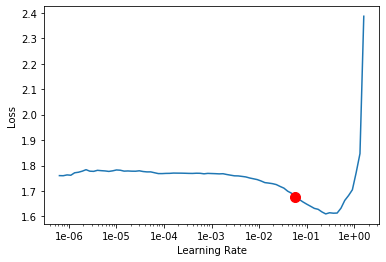

In [39]:
makeup_learner.lr_find()
makeup_learner.recorder.plot(suggestion=True)

In [40]:
makeup_learner.fit_one_cycle(1, max_lr=5e-02)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-04
Min loss divided by 10: 6.31E-08


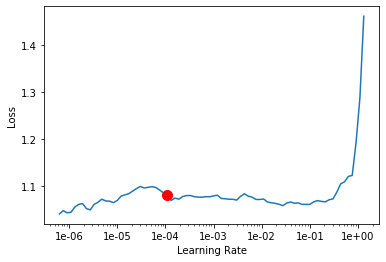

In [41]:
makeup_learner.lr_find()
makeup_learner.recorder.plot(suggestion=True)


In [42]:
makeup_learner.fit_one_cycle(1, 7e-05)


In [111]:
predictables_df = relevant_df.loc[100:150]

In [123]:
for index, row in predictables_df.iterrows():
    print(f"{row['product']} {row['brand']} {row['rating']} - Prediction: {makeup_learner.predict(row)}")

Arancia di Capri Acqua Di Parma 4 - Prediction: (Category 5, tensor(4), tensor([0.0766, 0.0603, 0.0962, 0.2183, 0.5485]))
Arancia di Capri Acqua Di Parma 4 - Prediction: (Category 5, tensor(4), tensor([0.1120, 0.0881, 0.1464, 0.2755, 0.3779]))
Ingrown Hair Treatment Anthony 5 - Prediction: (Category 5, tensor(4), tensor([0.0260, 0.0278, 0.0581, 0.2091, 0.6790]))
Arancia di Capri Acqua Di Parma 5 - Prediction: (Category 5, tensor(4), tensor([0.0690, 0.0519, 0.0770, 0.1754, 0.6267]))
Arancia di Capri Acqua Di Parma 5 - Prediction: (Category 5, tensor(4), tensor([0.0239, 0.0220, 0.0296, 0.0922, 0.8324]))
Arancia di Capri Acqua Di Parma 4 - Prediction: (Category 4, tensor(3), tensor([0.1020, 0.0994, 0.2058, 0.3953, 0.1975]))
Arancia di Capri Acqua Di Parma 4 - Prediction: (Category 5, tensor(4), tensor([0.0506, 0.0393, 0.0437, 0.0969, 0.7695]))
Arancia di Capri Acqua Di Parma 4 - Prediction: (Category 5, tensor(4), tensor([0.0563, 0.0461, 0.0659, 0.1570, 0.6747]))
Arancia di Capri Acqua Di

In [128]:
makeup_learner.pred_batch()

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [96]:
sum([0.2253, 0.1245, 0.1398, 0.1874, 0.3231])

1.0001